# ZJU Artificial Intelligence Safety HW01
Instructor: Jie Song

Requirements:
- Creating your own github account.
- Implementing your own deep neural network (in Pytorch, PaddlePaddle...).
- Training it on CIFAR10.
- Tuning a hyper-parameter and analyzing its effects on performance.
- Writing a README.md to report your findings.

## Import Packages

In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models

# For data preprocess
import numpy as np
import csv

# For the progress bar.
from tqdm import tqdm

# For plotting
import matplotlib.pyplot as plt

import os
import sys
import time

Ignore warnings.

In [2]:
import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)

## Hyper-parameters and configs

In [3]:
AVAIL_GPUS = min(1, torch.cuda.device_count())  # Check whether the GPU is available
NUM_WORKERS = int(os.cpu_count() / 2)
LOG_PATH = "./train.log"  # Record some information during the training
MODEL_PATH="./cnn.pth"  # The path for saving the model

In [4]:
'''Hyper-parameters'''
BATCH_SIZE = 128
LEARNING_RATE = 0.01
NUM_EPOCHS = 200

## Dataset, Data Loader, and Transforms

In [5]:
'''Data augmentation'''
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.5, 0.5, 0.5 ],
                         std  = [ 0.5, 0.5, 0.5 ]),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.5, 0.5, 0.5 ],
                         std  = [ 0.5, 0.5, 0.5 ]),
    ])

In [6]:
'''CIFAR-10 dataset'''
train_dataset = datasets.CIFAR10('./data', train=True, transform=transform_train, download=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform_test, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print(len(train_dataset))

Files already downloaded and verified
Files already downloaded and verified
50000


## Model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
model = Net()
if AVAIL_GPUS:
    model = model.cuda()

## Training

In [9]:
'''Loss function and optimizer'''
criterion = nn.CrossEntropyLoss()
def get_optimizer(epoch):
    return optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [10]:
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0

'''Training'''
def train(epoch):
    global train_loss_record
    global train_acc_record
    global LEARNING_RATE

    model.train()
    train_loss = 0.0
    train_acc = 0.0
    optimizer = get_optimizer(epoch)
    for i, data in tqdm(enumerate(train_loader, 1)):
        img, label = data
        # cuda
        if AVAIL_GPUS:
            img = img.cuda()
            label = label.cuda()
        img = Variable(img)
        label = Variable(label)
        
        optimizer.zero_grad()
        
        out = model(img)  # Forward Propagation
        loss = criterion(out, label)  # Loss
        
        train_loss += loss.item() * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        accuracy = (pred == label).float().mean()
        train_acc += num_correct.item()

        loss.backward()  # Backward Propagation
        optimizer.step()  # Optimizer update
    print("Finish %d epoch, Train loss: %.6f, Train acc@1: %.6f" % 
          (epoch + 1, 
           train_loss / (len(train_dataset)), 
           train_acc / (len(train_dataset))))
    with open(LOG_PATH, "a") as f:
        f.write("Finish %d epoch, Train loss: %.6f, Train acc@1: %.6f" % 
                (epoch + 1, 
                 train_loss / (len(train_dataset)),
                 train_acc / (len(train_dataset))))
        f.write("\n")
    train_loss_record.append(train_loss / (len(train_dataset)))
    train_acc_record.append(train_acc / (len(train_dataset)))

def test(epoch):
    global test_loss_record
    global test_acc_record
    global best_acc
    
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            if AVAIL_GPUS:
                img = Variable(img, volatile=True).cuda()
                label = Variable(label, volatile=True).cuda()
            else:
                img = Variable(img, volatile=True)
                label = Variable(label, volatile=True)
            out = model(img)
            loss = criterion(out, label)
            test_loss += loss.item() * label.size(0)
            _, pred = torch.max(out, 1)
            num_correct = (pred == label).sum()
            test_acc += num_correct.item()
    print("Test loss: %.6f, Test acc@1: %.6f" % (
        test_loss / (len(test_dataset)), 
        test_acc / (len(test_dataset))))
    with open(LOG_PATH, "a") as f:
        f.write("Test loss: %.6f, Test acc@1: %.6f" % (
                test_loss / (len(test_dataset)), 
                test_acc / (len(test_dataset))))
        f.write("\n")
    test_loss_record.append(test_loss / (len(test_dataset)))
    test_acc_record.append(test_acc / (len(test_dataset)))
    
    acc = 100. * test_acc / (len(test_dataset))
    if acc > best_acc:
        print("Saving Best model...\t\t\tTop1 = %.6f%%" %(acc))
        with open(LOG_PATH, "a") as f:
            f.write("Saving best model...\t\t\tTop1 = %.6f%%" %(acc))
            f.write("\n")
        torch.save(model.state_dict(), MODEL_PATH)  # Save the best model
        best_acc = acc

In [11]:
LOG_PATH="./train0.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn0.pth"
    
print("Model: CNN from Pytorch tutorial")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: SGD")
print("Learning rate: %d" % (LEARNING_RATE))
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: SGD")
    f.write("\n")
    f.write("Learning rate: %d" % (LEARNING_RATE))
    f.write("\n")

elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
    
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: CNN from Pytorch tutorial
Batch size: 128
Epoch num: 200
Optimizer: SGD
Learning rate: 0
---------- Training Epoch #0 ----------


391it [00:06, 62.40it/s] 

Finish 1 epoch, Train loss: 2.302632, Train acc@1: 0.100000


Test loss: 2.300785, Test acc@1: 0.100100
Saving Best model...			Top1 = 10.010000%
Elapsed time: 8.882205486297607
---------- Training Epoch #1 ----------


391it [00:03, 121.28it/s]

Finish 2 epoch, Train loss: 2.298500, Train acc@1: 0.109400


Test loss: 2.295466, Test acc@1: 0.133300
Saving Best model...			Top1 = 13.330000%
Elapsed time: 14.155866384506226
---------- Training Epoch #2 ----------


391it [00:03, 121.48it/s]

Finish 3 epoch, Train loss: 2.287858, Train acc@1: 0.173020


Test loss: 2.273612, Test acc@1: 0.195000
Saving Best model...			Top1 = 19.500000%
Elapsed time: 19.364596605300903
---------- Training Epoch #3 ----------


391it [00:03, 97.79it/s] 

Finish 4 epoch, Train loss: 2.189420, Train acc@1: 0.229700


Test loss: 2.053250, Test acc@1: 0.273800
Saving Best model...			Top1 = 27.380000%
Elapsed time: 25.38495635986328
---------- Training Epoch #4 ----------


391it [00:04, 97.13it/s] 

Finish 5 epoch, Train loss: 1.968336, Train acc@1: 0.292900


Test loss: 1.904220, Test acc@1: 0.314900
Saving Best model...			Top1 = 31.490000%
Elapsed time: 31.34335231781006
---------- Training Epoch #5 ----------


391it [00:03, 128.39it/s]

Finish 6 epoch, Train loss: 1.876955, Train acc@1: 0.324380


Test loss: 1.828220, Test acc@1: 0.348300
Saving Best model...			Top1 = 34.830000%
Elapsed time: 36.377108335494995
---------- Training Epoch #6 ----------


391it [00:03, 121.49it/s]

Finish 7 epoch, Train loss: 1.796698, Train acc@1: 0.353120


Test loss: 1.770678, Test acc@1: 0.366200
Saving Best model...			Top1 = 36.620000%
Elapsed time: 43.233155250549316
---------- Training Epoch #7 ----------


391it [00:03, 118.79it/s]

Finish 8 epoch, Train loss: 1.706320, Train acc@1: 0.383180


Test loss: 1.652939, Test acc@1: 0.397800
Saving Best model...			Top1 = 39.780000%
Elapsed time: 48.529669523239136
---------- Training Epoch #8 ----------


391it [00:03, 125.47it/s]

Finish 9 epoch, Train loss: 1.626320, Train acc@1: 0.410000


Test loss: 1.595968, Test acc@1: 0.415100
Saving Best model...			Top1 = 41.510000%
Elapsed time: 53.59673500061035
---------- Training Epoch #9 ----------


391it [00:03, 125.14it/s]

Finish 10 epoch, Train loss: 1.571222, Train acc@1: 0.430340


Test loss: 1.553419, Test acc@1: 0.435000
Saving Best model...			Top1 = 43.500000%
Elapsed time: 58.801527976989746
---------- Training Epoch #10 ----------


391it [00:03, 112.71it/s]

Finish 11 epoch, Train loss: 1.531315, Train acc@1: 0.445840


Test loss: 1.519500, Test acc@1: 0.447300
Saving Best model...			Top1 = 44.730000%
Elapsed time: 64.33190679550171
---------- Training Epoch #11 ----------


391it [00:03, 124.27it/s]

Finish 12 epoch, Train loss: 1.497309, Train acc@1: 0.457820


Test loss: 1.540625, Test acc@1: 0.445800
Elapsed time: 69.42123985290527
---------- Training Epoch #12 ----------


391it [00:03, 122.03it/s]

Finish 13 epoch, Train loss: 1.468565, Train acc@1: 0.468960


Test loss: 1.477676, Test acc@1: 0.464800
Saving Best model...			Top1 = 46.480000%
Elapsed time: 74.58016347885132
---------- Training Epoch #13 ----------


391it [00:03, 125.46it/s]

Finish 14 epoch, Train loss: 1.444028, Train acc@1: 0.481540


Test loss: 1.452160, Test acc@1: 0.470200
Saving Best model...			Top1 = 47.020000%
Elapsed time: 79.62706208229065
---------- Training Epoch #14 ----------


391it [00:03, 122.56it/s]

Finish 15 epoch, Train loss: 1.418388, Train acc@1: 0.489900


Test loss: 1.435571, Test acc@1: 0.487800
Saving Best model...			Top1 = 48.780000%
Elapsed time: 84.80865383148193
---------- Training Epoch #15 ----------


391it [00:03, 124.63it/s]

Finish 16 epoch, Train loss: 1.395151, Train acc@1: 0.500340


Test loss: 1.454227, Test acc@1: 0.477500
Elapsed time: 89.8601725101471
---------- Training Epoch #16 ----------


391it [00:03, 123.80it/s]

Finish 17 epoch, Train loss: 1.373061, Train acc@1: 0.510360


Test loss: 1.359801, Test acc@1: 0.511500
Saving Best model...			Top1 = 51.150000%
Elapsed time: 95.05673480033875
---------- Training Epoch #17 ----------


391it [00:03, 122.91it/s]

Finish 18 epoch, Train loss: 1.345122, Train acc@1: 0.521280


Test loss: 1.345578, Test acc@1: 0.521200
Saving Best model...			Top1 = 52.120000%
Elapsed time: 100.18853449821472
---------- Training Epoch #18 ----------


391it [00:03, 122.43it/s]

Finish 19 epoch, Train loss: 1.323797, Train acc@1: 0.527380


Test loss: 1.341696, Test acc@1: 0.519100
Elapsed time: 105.39005994796753
---------- Training Epoch #19 ----------


391it [00:03, 121.37it/s]

Finish 20 epoch, Train loss: 1.301492, Train acc@1: 0.539220


Test loss: 1.314467, Test acc@1: 0.527100
Saving Best model...			Top1 = 52.710000%
Elapsed time: 110.59153747558594
---------- Training Epoch #20 ----------


391it [00:03, 125.55it/s]

Finish 21 epoch, Train loss: 1.278875, Train acc@1: 0.547140


Test loss: 1.283920, Test acc@1: 0.545000
Saving Best model...			Top1 = 54.500000%
Elapsed time: 115.70175766944885
---------- Training Epoch #21 ----------


391it [00:03, 127.03it/s]

Finish 22 epoch, Train loss: 1.256886, Train acc@1: 0.554380


Test loss: 1.320034, Test acc@1: 0.534200
Elapsed time: 120.78590154647827
---------- Training Epoch #22 ----------


391it [00:03, 124.82it/s]

Finish 23 epoch, Train loss: 1.237152, Train acc@1: 0.562100


Test loss: 1.246197, Test acc@1: 0.559700
Saving Best model...			Top1 = 55.970000%
Elapsed time: 125.91530227661133
---------- Training Epoch #23 ----------


391it [00:04, 91.58it/s] 

Finish 24 epoch, Train loss: 1.217126, Train acc@1: 0.569000


Test loss: 1.286825, Test acc@1: 0.544800
Elapsed time: 132.1465699672699
---------- Training Epoch #24 ----------


391it [00:03, 130.11it/s]

Finish 25 epoch, Train loss: 1.201777, Train acc@1: 0.575800


Test loss: 1.219667, Test acc@1: 0.567200
Saving Best model...			Top1 = 56.720000%
Elapsed time: 137.0881326198578
---------- Training Epoch #25 ----------


391it [00:03, 125.49it/s]

Finish 26 epoch, Train loss: 1.181273, Train acc@1: 0.584020


Test loss: 1.233318, Test acc@1: 0.570500
Saving Best model...			Top1 = 57.050000%
Elapsed time: 142.16790127754211
---------- Training Epoch #26 ----------


391it [00:03, 127.91it/s]

Finish 27 epoch, Train loss: 1.163256, Train acc@1: 0.589760


Test loss: 1.209265, Test acc@1: 0.572700
Saving Best model...			Top1 = 57.270000%
Elapsed time: 147.28749537467957
---------- Training Epoch #27 ----------


391it [00:03, 123.82it/s]

Finish 28 epoch, Train loss: 1.150725, Train acc@1: 0.593600


Test loss: 1.258051, Test acc@1: 0.556100
Elapsed time: 152.44990730285645
---------- Training Epoch #28 ----------


391it [00:03, 125.17it/s]

Finish 29 epoch, Train loss: 1.133913, Train acc@1: 0.600480


Test loss: 1.186200, Test acc@1: 0.582700
Saving Best model...			Top1 = 58.270000%
Elapsed time: 157.51631951332092
---------- Training Epoch #29 ----------


391it [00:03, 126.95it/s]

Finish 30 epoch, Train loss: 1.120130, Train acc@1: 0.604700


Test loss: 1.164758, Test acc@1: 0.590700
Saving Best model...			Top1 = 59.070000%
Elapsed time: 162.57383131980896
---------- Training Epoch #30 ----------


391it [00:03, 123.76it/s]

Finish 31 epoch, Train loss: 1.108136, Train acc@1: 0.609600


Test loss: 1.197498, Test acc@1: 0.588100
Elapsed time: 167.80821180343628
---------- Training Epoch #31 ----------


391it [00:03, 125.29it/s]

Finish 32 epoch, Train loss: 1.092002, Train acc@1: 0.617280


Test loss: 1.153105, Test acc@1: 0.600800
Saving Best model...			Top1 = 60.080000%
Elapsed time: 172.95822072029114
---------- Training Epoch #32 ----------


391it [00:03, 123.01it/s]

Finish 33 epoch, Train loss: 1.079306, Train acc@1: 0.622040


Test loss: 1.148235, Test acc@1: 0.602600
Saving Best model...			Top1 = 60.260000%
Elapsed time: 178.15738916397095
---------- Training Epoch #33 ----------


391it [00:03, 123.41it/s]

Finish 34 epoch, Train loss: 1.067320, Train acc@1: 0.625900


Test loss: 1.144225, Test acc@1: 0.600700
Elapsed time: 183.38709926605225
---------- Training Epoch #34 ----------


391it [00:03, 124.98it/s]

Finish 35 epoch, Train loss: 1.055007, Train acc@1: 0.627560


Test loss: 1.135375, Test acc@1: 0.603200
Saving Best model...			Top1 = 60.320000%
Elapsed time: 188.48436617851257
---------- Training Epoch #35 ----------


391it [00:03, 122.31it/s]

Finish 36 epoch, Train loss: 1.044022, Train acc@1: 0.632840


Test loss: 1.139898, Test acc@1: 0.603200
Elapsed time: 193.70040822029114
---------- Training Epoch #36 ----------


391it [00:03, 123.76it/s]

Finish 37 epoch, Train loss: 1.035129, Train acc@1: 0.637040


Test loss: 1.118368, Test acc@1: 0.611500
Saving Best model...			Top1 = 61.150000%
Elapsed time: 199.29351019859314
---------- Training Epoch #37 ----------


391it [00:03, 120.25it/s]

Finish 38 epoch, Train loss: 1.021275, Train acc@1: 0.641940


Test loss: 1.087707, Test acc@1: 0.624000
Saving Best model...			Top1 = 62.400000%
Elapsed time: 204.53588104248047
---------- Training Epoch #38 ----------


391it [00:03, 124.65it/s]

Finish 39 epoch, Train loss: 1.012344, Train acc@1: 0.645700


Test loss: 1.109596, Test acc@1: 0.616000
Elapsed time: 209.63788080215454
---------- Training Epoch #39 ----------


391it [00:03, 123.60it/s]

Finish 40 epoch, Train loss: 1.000392, Train acc@1: 0.649520


Test loss: 1.068533, Test acc@1: 0.631300
Saving Best model...			Top1 = 63.130000%
Elapsed time: 214.82555437088013
---------- Training Epoch #40 ----------


391it [00:03, 124.65it/s]

Finish 41 epoch, Train loss: 0.990987, Train acc@1: 0.652880


Test loss: 1.069948, Test acc@1: 0.633200
Saving Best model...			Top1 = 63.320000%
Elapsed time: 219.92641854286194
---------- Training Epoch #41 ----------


391it [00:03, 120.05it/s]

Finish 42 epoch, Train loss: 0.978406, Train acc@1: 0.658500


Test loss: 1.150498, Test acc@1: 0.602400
Elapsed time: 225.0711796283722
---------- Training Epoch #42 ----------


391it [00:03, 120.42it/s]

Finish 43 epoch, Train loss: 0.968986, Train acc@1: 0.660680


Test loss: 1.203019, Test acc@1: 0.589600
Elapsed time: 230.25906133651733
---------- Training Epoch #43 ----------


391it [00:03, 124.55it/s]

Finish 44 epoch, Train loss: 0.957654, Train acc@1: 0.666180


Test loss: 1.079333, Test acc@1: 0.628000
Elapsed time: 235.33690810203552
---------- Training Epoch #44 ----------


391it [00:03, 122.13it/s]

Finish 45 epoch, Train loss: 0.948377, Train acc@1: 0.667500


Test loss: 1.114759, Test acc@1: 0.622000
Elapsed time: 240.50532007217407
---------- Training Epoch #45 ----------


391it [00:03, 120.90it/s]

Finish 46 epoch, Train loss: 0.938299, Train acc@1: 0.671400


Test loss: 1.057072, Test acc@1: 0.636900
Saving Best model...			Top1 = 63.690000%
Elapsed time: 245.76209688186646
---------- Training Epoch #46 ----------


391it [00:03, 124.13it/s]

Finish 47 epoch, Train loss: 0.928926, Train acc@1: 0.674840


Test loss: 1.089953, Test acc@1: 0.623900
Elapsed time: 250.87388730049133
---------- Training Epoch #47 ----------


391it [00:03, 121.72it/s]

Finish 48 epoch, Train loss: 0.922047, Train acc@1: 0.678420


Test loss: 1.068280, Test acc@1: 0.635800
Elapsed time: 256.0470871925354
---------- Training Epoch #48 ----------


391it [00:03, 123.85it/s]

Finish 49 epoch, Train loss: 0.912169, Train acc@1: 0.679840


Test loss: 1.095889, Test acc@1: 0.625400
Elapsed time: 261.13078689575195
---------- Training Epoch #49 ----------


391it [00:03, 121.54it/s]

Finish 50 epoch, Train loss: 0.903735, Train acc@1: 0.685440


Test loss: 1.037630, Test acc@1: 0.644400
Saving Best model...			Top1 = 64.440000%
Elapsed time: 266.3423547744751
---------- Training Epoch #50 ----------


391it [00:03, 124.78it/s]

Finish 51 epoch, Train loss: 0.892916, Train acc@1: 0.688800


Test loss: 1.030732, Test acc@1: 0.647600
Saving Best model...			Top1 = 64.760000%
Elapsed time: 271.41791701316833
---------- Training Epoch #51 ----------


391it [00:03, 128.79it/s]

Finish 52 epoch, Train loss: 0.882626, Train acc@1: 0.692480


Test loss: 1.052518, Test acc@1: 0.643200
Elapsed time: 276.4054877758026
---------- Training Epoch #52 ----------


391it [00:03, 122.39it/s]

Finish 53 epoch, Train loss: 0.878649, Train acc@1: 0.693860


Test loss: 1.039034, Test acc@1: 0.642500
Elapsed time: 281.57570934295654
---------- Training Epoch #53 ----------


391it [00:03, 124.56it/s]

Finish 54 epoch, Train loss: 0.867002, Train acc@1: 0.697180


Test loss: 1.006277, Test acc@1: 0.655500
Saving Best model...			Top1 = 65.550000%
Elapsed time: 286.70536637306213
---------- Training Epoch #54 ----------


391it [00:03, 122.54it/s]

Finish 55 epoch, Train loss: 0.859297, Train acc@1: 0.701320


Test loss: 1.023003, Test acc@1: 0.652000
Elapsed time: 291.860867023468
---------- Training Epoch #55 ----------


391it [00:03, 121.58it/s]

Finish 56 epoch, Train loss: 0.852806, Train acc@1: 0.704320


Test loss: 1.008220, Test acc@1: 0.655400
Elapsed time: 297.08407640457153
---------- Training Epoch #56 ----------


391it [00:03, 122.66it/s]


Finish 57 epoch, Train loss: 0.843667, Train acc@1: 0.706840
Test loss: 1.013144, Test acc@1: 0.655700
Saving Best model...			Top1 = 65.570000%
Elapsed time: 302.3064181804657
---------- Training Epoch #57 ----------


391it [00:03, 126.29it/s]

Finish 58 epoch, Train loss: 0.836836, Train acc@1: 0.707400


Test loss: 1.038738, Test acc@1: 0.644100
Elapsed time: 307.46722197532654
---------- Training Epoch #58 ----------


391it [00:03, 127.16it/s]

Finish 59 epoch, Train loss: 0.828885, Train acc@1: 0.710100


Test loss: 1.031354, Test acc@1: 0.644100
Elapsed time: 312.5291907787323
---------- Training Epoch #59 ----------


391it [00:03, 126.35it/s]

Finish 60 epoch, Train loss: 0.822905, Train acc@1: 0.714560


Test loss: 1.006865, Test acc@1: 0.656500
Saving Best model...			Top1 = 65.650000%
Elapsed time: 317.592848777771
---------- Training Epoch #60 ----------


391it [00:03, 128.20it/s]

Finish 61 epoch, Train loss: 0.810560, Train acc@1: 0.716760


Test loss: 1.026783, Test acc@1: 0.650500
Elapsed time: 322.6621992588043
---------- Training Epoch #61 ----------


391it [00:03, 124.23it/s]

Finish 62 epoch, Train loss: 0.805011, Train acc@1: 0.719360


Test loss: 1.144025, Test acc@1: 0.622000
Elapsed time: 327.79935216903687
---------- Training Epoch #62 ----------


391it [00:03, 122.66it/s]

Finish 63 epoch, Train loss: 0.799915, Train acc@1: 0.722240


Test loss: 1.004487, Test acc@1: 0.659700
Saving Best model...			Top1 = 65.970000%
Elapsed time: 333.0806529521942
---------- Training Epoch #63 ----------


391it [00:03, 128.32it/s]

Finish 64 epoch, Train loss: 0.793301, Train acc@1: 0.723700


Test loss: 1.022915, Test acc@1: 0.651700
Elapsed time: 338.1671504974365
---------- Training Epoch #64 ----------


391it [00:03, 125.38it/s]

Finish 65 epoch, Train loss: 0.784574, Train acc@1: 0.727220


Test loss: 1.038507, Test acc@1: 0.646200
Elapsed time: 343.26366209983826
---------- Training Epoch #65 ----------


391it [00:03, 126.64it/s]

Finish 66 epoch, Train loss: 0.777738, Train acc@1: 0.727820


Test loss: 1.035585, Test acc@1: 0.652800
Elapsed time: 348.3210527896881
---------- Training Epoch #66 ----------


391it [00:03, 125.41it/s]


Finish 67 epoch, Train loss: 0.770312, Train acc@1: 0.731640
Test loss: 0.987199, Test acc@1: 0.660400
Saving Best model...			Top1 = 66.040000%
Elapsed time: 353.4464039802551
---------- Training Epoch #67 ----------


391it [00:03, 124.31it/s]

Finish 68 epoch, Train loss: 0.765689, Train acc@1: 0.732440


Test loss: 1.027383, Test acc@1: 0.658200
Elapsed time: 358.65675950050354
---------- Training Epoch #68 ----------


391it [00:03, 121.16it/s]

Finish 69 epoch, Train loss: 0.760123, Train acc@1: 0.733860


Test loss: 1.021076, Test acc@1: 0.661300
Saving Best model...			Top1 = 66.130000%
Elapsed time: 363.7951476573944
---------- Training Epoch #69 ----------


391it [00:03, 123.67it/s]

Finish 70 epoch, Train loss: 0.751552, Train acc@1: 0.736100


Test loss: 1.003061, Test acc@1: 0.662100
Saving Best model...			Top1 = 66.210000%
Elapsed time: 368.8755102157593
---------- Training Epoch #70 ----------


391it [00:03, 125.11it/s]

Finish 71 epoch, Train loss: 0.746634, Train acc@1: 0.740740


Test loss: 1.016078, Test acc@1: 0.665600
Saving Best model...			Top1 = 66.560000%
Elapsed time: 373.96544790267944
---------- Training Epoch #71 ----------


391it [00:03, 128.07it/s]

Finish 72 epoch, Train loss: 0.737725, Train acc@1: 0.743120


Test loss: 1.035875, Test acc@1: 0.657400
Elapsed time: 378.99564266204834
---------- Training Epoch #72 ----------


391it [00:03, 128.24it/s]

Finish 73 epoch, Train loss: 0.734259, Train acc@1: 0.745760


Test loss: 1.050340, Test acc@1: 0.654400
Elapsed time: 383.9791102409363
---------- Training Epoch #73 ----------


391it [00:03, 121.43it/s]

Finish 74 epoch, Train loss: 0.728635, Train acc@1: 0.745800


Test loss: 1.038432, Test acc@1: 0.655500
Elapsed time: 389.19081926345825
---------- Training Epoch #74 ----------


391it [00:03, 123.09it/s]

Finish 75 epoch, Train loss: 0.722643, Train acc@1: 0.747720


Test loss: 1.025136, Test acc@1: 0.657400
Elapsed time: 394.2613892555237
---------- Training Epoch #75 ----------


391it [00:03, 125.88it/s]

Finish 76 epoch, Train loss: 0.713286, Train acc@1: 0.750360


Test loss: 1.000351, Test acc@1: 0.668300
Saving Best model...			Top1 = 66.830000%
Elapsed time: 399.3244893550873
---------- Training Epoch #76 ----------


391it [00:03, 126.10it/s]

Finish 77 epoch, Train loss: 0.706619, Train acc@1: 0.754280


Test loss: 1.021184, Test acc@1: 0.666000
Elapsed time: 404.3914031982422
---------- Training Epoch #77 ----------


391it [00:03, 125.17it/s]

Finish 78 epoch, Train loss: 0.700734, Train acc@1: 0.754300


Test loss: 1.006059, Test acc@1: 0.666800
Elapsed time: 409.4625849723816
---------- Training Epoch #78 ----------


391it [00:03, 123.06it/s]

Finish 79 epoch, Train loss: 0.695917, Train acc@1: 0.756720


Test loss: 1.065795, Test acc@1: 0.646100
Elapsed time: 414.54489278793335
---------- Training Epoch #79 ----------


391it [00:03, 127.10it/s]

Finish 80 epoch, Train loss: 0.689813, Train acc@1: 0.758200


Test loss: 1.015312, Test acc@1: 0.668300
Elapsed time: 419.56355023384094
---------- Training Epoch #80 ----------


391it [00:03, 125.00it/s]

Finish 81 epoch, Train loss: 0.685306, Train acc@1: 0.759820


Test loss: 1.022833, Test acc@1: 0.670400
Saving Best model...			Top1 = 67.040000%
Elapsed time: 424.69603657722473
---------- Training Epoch #81 ----------


391it [00:03, 121.33it/s]

Finish 82 epoch, Train loss: 0.678472, Train acc@1: 0.763060


Test loss: 1.055056, Test acc@1: 0.654500
Elapsed time: 429.88731479644775
---------- Training Epoch #82 ----------


391it [00:03, 125.86it/s]

Finish 83 epoch, Train loss: 0.669936, Train acc@1: 0.765040


Test loss: 1.010550, Test acc@1: 0.669000
Elapsed time: 434.9460029602051
---------- Training Epoch #83 ----------


391it [00:03, 128.11it/s]

Finish 84 epoch, Train loss: 0.665704, Train acc@1: 0.766080


Test loss: 1.041005, Test acc@1: 0.663600
Elapsed time: 439.9836163520813
---------- Training Epoch #84 ----------


391it [00:03, 123.09it/s]

Finish 85 epoch, Train loss: 0.661279, Train acc@1: 0.769900


Test loss: 1.023998, Test acc@1: 0.664600
Elapsed time: 445.1063241958618
---------- Training Epoch #85 ----------


391it [00:03, 124.05it/s]

Finish 86 epoch, Train loss: 0.654041, Train acc@1: 0.772060


Test loss: 1.118349, Test acc@1: 0.637200
Elapsed time: 450.3103995323181
---------- Training Epoch #86 ----------


391it [00:03, 125.56it/s]

Finish 87 epoch, Train loss: 0.649178, Train acc@1: 0.773360


Test loss: 1.051755, Test acc@1: 0.663400
Elapsed time: 455.4366970062256
---------- Training Epoch #87 ----------


391it [00:03, 124.23it/s]

Finish 88 epoch, Train loss: 0.641162, Train acc@1: 0.775220


Test loss: 1.033486, Test acc@1: 0.667500
Elapsed time: 460.5237910747528
---------- Training Epoch #88 ----------


391it [00:03, 125.88it/s]

Finish 89 epoch, Train loss: 0.638109, Train acc@1: 0.776300


Test loss: 1.059159, Test acc@1: 0.660600
Elapsed time: 465.6720645427704
---------- Training Epoch #89 ----------


391it [00:03, 126.62it/s]

Finish 90 epoch, Train loss: 0.630691, Train acc@1: 0.779960


Test loss: 1.094211, Test acc@1: 0.652900
Elapsed time: 470.734575510025
---------- Training Epoch #90 ----------


391it [00:03, 122.35it/s]

Finish 91 epoch, Train loss: 0.626700, Train acc@1: 0.779780


Test loss: 1.065366, Test acc@1: 0.663000
Elapsed time: 475.94564628601074
---------- Training Epoch #91 ----------


391it [00:03, 120.68it/s]

Finish 92 epoch, Train loss: 0.621835, Train acc@1: 0.782540


Test loss: 1.037780, Test acc@1: 0.664500
Elapsed time: 481.1324062347412
---------- Training Epoch #92 ----------


391it [00:03, 120.85it/s]

Finish 93 epoch, Train loss: 0.616470, Train acc@1: 0.784660


Test loss: 1.089442, Test acc@1: 0.657600
Elapsed time: 486.34799218177795
---------- Training Epoch #93 ----------


391it [00:03, 122.20it/s]


Finish 94 epoch, Train loss: 0.608017, Train acc@1: 0.786820
Test loss: 1.073150, Test acc@1: 0.660200
Elapsed time: 491.55779361724854
---------- Training Epoch #94 ----------


391it [00:03, 121.98it/s]

Finish 95 epoch, Train loss: 0.601249, Train acc@1: 0.790480


Test loss: 1.079821, Test acc@1: 0.660100
Elapsed time: 496.76842045783997
---------- Training Epoch #95 ----------


391it [00:03, 124.62it/s]

Finish 96 epoch, Train loss: 0.600322, Train acc@1: 0.790000


Test loss: 1.079841, Test acc@1: 0.660000
Elapsed time: 501.85652232170105
---------- Training Epoch #96 ----------


391it [00:03, 125.25it/s]

Finish 97 epoch, Train loss: 0.593057, Train acc@1: 0.791680


Test loss: 1.102093, Test acc@1: 0.664200
Elapsed time: 506.95031571388245
---------- Training Epoch #97 ----------


391it [00:03, 126.66it/s]

Finish 98 epoch, Train loss: 0.587757, Train acc@1: 0.794100


Test loss: 1.221964, Test acc@1: 0.632100
Elapsed time: 512.0748467445374
---------- Training Epoch #98 ----------


391it [00:03, 122.74it/s]

Finish 99 epoch, Train loss: 0.584286, Train acc@1: 0.795620


Test loss: 1.094335, Test acc@1: 0.660800
Elapsed time: 517.2639706134796
---------- Training Epoch #99 ----------


391it [00:03, 121.83it/s]

Finish 100 epoch, Train loss: 0.576870, Train acc@1: 0.798240


Test loss: 1.138026, Test acc@1: 0.652600
Elapsed time: 522.5018928050995
---------- Training Epoch #100 ----------


391it [00:03, 129.86it/s]

Finish 101 epoch, Train loss: 0.573967, Train acc@1: 0.801100


Test loss: 1.123204, Test acc@1: 0.657000
Elapsed time: 527.4449672698975
---------- Training Epoch #101 ----------


391it [00:03, 122.64it/s]

Finish 102 epoch, Train loss: 0.569685, Train acc@1: 0.799020


Test loss: 1.184284, Test acc@1: 0.644400
Elapsed time: 532.6170246601105
---------- Training Epoch #102 ----------


391it [00:03, 125.85it/s]

Finish 103 epoch, Train loss: 0.562050, Train acc@1: 0.804500


Test loss: 1.140319, Test acc@1: 0.649400
Elapsed time: 537.7532193660736
---------- Training Epoch #103 ----------


391it [00:03, 125.03it/s]

Finish 104 epoch, Train loss: 0.553970, Train acc@1: 0.804440


Test loss: 1.156989, Test acc@1: 0.658600
Elapsed time: 542.8679480552673
---------- Training Epoch #104 ----------


391it [00:03, 127.89it/s]

Finish 105 epoch, Train loss: 0.548352, Train acc@1: 0.808900


Test loss: 1.151781, Test acc@1: 0.651600
Elapsed time: 548.0040221214294
---------- Training Epoch #105 ----------


391it [00:03, 128.14it/s]

Finish 106 epoch, Train loss: 0.546011, Train acc@1: 0.807780


Test loss: 1.144221, Test acc@1: 0.651400
Elapsed time: 553.0619957447052
---------- Training Epoch #106 ----------


391it [00:03, 125.54it/s]

Finish 107 epoch, Train loss: 0.542302, Train acc@1: 0.809540


Test loss: 1.139531, Test acc@1: 0.659500
Elapsed time: 558.1981468200684
---------- Training Epoch #107 ----------


391it [00:03, 129.05it/s]

Finish 108 epoch, Train loss: 0.537196, Train acc@1: 0.812140


Test loss: 1.193563, Test acc@1: 0.647300
Elapsed time: 563.2356903553009
---------- Training Epoch #108 ----------


391it [00:03, 126.35it/s]

Finish 109 epoch, Train loss: 0.533028, Train acc@1: 0.814680


Test loss: 1.144377, Test acc@1: 0.659100
Elapsed time: 568.3412373065948
---------- Training Epoch #109 ----------


391it [00:03, 119.24it/s]

Finish 110 epoch, Train loss: 0.524379, Train acc@1: 0.817260


Test loss: 1.176872, Test acc@1: 0.655300
Elapsed time: 573.6340296268463
---------- Training Epoch #110 ----------


391it [00:03, 130.09it/s]

Finish 111 epoch, Train loss: 0.521343, Train acc@1: 0.817760


Test loss: 1.147026, Test acc@1: 0.661200
Elapsed time: 578.6914646625519
---------- Training Epoch #111 ----------


391it [00:03, 126.08it/s]


Finish 112 epoch, Train loss: 0.518972, Train acc@1: 0.818340
Test loss: 1.173027, Test acc@1: 0.657300
Elapsed time: 583.8921868801117
---------- Training Epoch #112 ----------


391it [00:03, 127.02it/s]

Finish 113 epoch, Train loss: 0.510645, Train acc@1: 0.821340


Test loss: 1.178395, Test acc@1: 0.656900
Elapsed time: 588.9636034965515
---------- Training Epoch #113 ----------


391it [00:03, 123.11it/s]

Finish 114 epoch, Train loss: 0.505232, Train acc@1: 0.824420


Test loss: 1.176709, Test acc@1: 0.657200
Elapsed time: 594.0667791366577
---------- Training Epoch #114 ----------


391it [00:03, 122.96it/s]

Finish 115 epoch, Train loss: 0.500474, Train acc@1: 0.824560


Test loss: 1.187318, Test acc@1: 0.657800
Elapsed time: 599.1819286346436
---------- Training Epoch #115 ----------


391it [00:03, 122.35it/s]

Finish 116 epoch, Train loss: 0.496703, Train acc@1: 0.824960


Test loss: 1.165634, Test acc@1: 0.665500
Elapsed time: 604.327714920044
---------- Training Epoch #116 ----------


391it [00:03, 124.63it/s]

Finish 117 epoch, Train loss: 0.494482, Train acc@1: 0.827900


Test loss: 1.188921, Test acc@1: 0.661800
Elapsed time: 609.433721780777
---------- Training Epoch #117 ----------


391it [00:03, 123.36it/s]

Finish 118 epoch, Train loss: 0.487732, Train acc@1: 0.829340


Test loss: 1.217933, Test acc@1: 0.655300
Elapsed time: 614.5847494602203
---------- Training Epoch #118 ----------


391it [00:03, 124.42it/s]

Finish 119 epoch, Train loss: 0.483114, Train acc@1: 0.830560


Test loss: 1.198100, Test acc@1: 0.653600
Elapsed time: 619.7084558010101
---------- Training Epoch #119 ----------


391it [00:03, 120.73it/s]

Finish 120 epoch, Train loss: 0.476060, Train acc@1: 0.832420


Test loss: 1.248069, Test acc@1: 0.649800
Elapsed time: 624.9026229381561
---------- Training Epoch #120 ----------


391it [00:03, 124.70it/s]

Finish 121 epoch, Train loss: 0.473107, Train acc@1: 0.834360


Test loss: 1.238305, Test acc@1: 0.653400
Elapsed time: 629.93519282341
---------- Training Epoch #121 ----------


391it [00:03, 126.71it/s]

Finish 122 epoch, Train loss: 0.471682, Train acc@1: 0.836460


Test loss: 1.224451, Test acc@1: 0.653300
Elapsed time: 634.939165353775
---------- Training Epoch #122 ----------


391it [00:03, 124.25it/s]

Finish 123 epoch, Train loss: 0.466282, Train acc@1: 0.838180


Test loss: 1.235732, Test acc@1: 0.656500
Elapsed time: 640.1300702095032
---------- Training Epoch #123 ----------


391it [00:03, 123.14it/s]

Finish 124 epoch, Train loss: 0.460517, Train acc@1: 0.838720


Test loss: 1.293038, Test acc@1: 0.647300
Elapsed time: 645.4307308197021
---------- Training Epoch #124 ----------


391it [00:03, 125.36it/s]

Finish 125 epoch, Train loss: 0.451147, Train acc@1: 0.842600


Test loss: 1.257713, Test acc@1: 0.646200
Elapsed time: 650.4648356437683
---------- Training Epoch #125 ----------


391it [00:03, 122.94it/s]

Finish 126 epoch, Train loss: 0.456313, Train acc@1: 0.839360


Test loss: 1.243767, Test acc@1: 0.652100
Elapsed time: 655.653805732727
---------- Training Epoch #126 ----------


391it [00:03, 122.31it/s]

Finish 127 epoch, Train loss: 0.445114, Train acc@1: 0.843500


Test loss: 1.300273, Test acc@1: 0.653000
Elapsed time: 660.7682797908783
---------- Training Epoch #127 ----------


391it [00:03, 128.20it/s]

Finish 128 epoch, Train loss: 0.439310, Train acc@1: 0.846800


Test loss: 1.351174, Test acc@1: 0.642200
Elapsed time: 665.797700881958
---------- Training Epoch #128 ----------


391it [00:03, 124.84it/s]

Finish 129 epoch, Train loss: 0.441446, Train acc@1: 0.844760


Test loss: 1.303167, Test acc@1: 0.649100
Elapsed time: 670.828547000885
---------- Training Epoch #129 ----------


391it [00:03, 123.89it/s]

Finish 130 epoch, Train loss: 0.432740, Train acc@1: 0.848580


Test loss: 1.373842, Test acc@1: 0.641600
Elapsed time: 676.0619580745697
---------- Training Epoch #130 ----------


391it [00:03, 122.96it/s]

Finish 131 epoch, Train loss: 0.429226, Train acc@1: 0.850020


Test loss: 1.438266, Test acc@1: 0.636100
Elapsed time: 681.2012984752655
---------- Training Epoch #131 ----------


391it [00:02, 130.99it/s]

Finish 132 epoch, Train loss: 0.423566, Train acc@1: 0.851720


Test loss: 1.324200, Test acc@1: 0.650600
Elapsed time: 686.2163276672363
---------- Training Epoch #132 ----------


391it [00:03, 125.81it/s]

Finish 133 epoch, Train loss: 0.423778, Train acc@1: 0.850080


Test loss: 1.343682, Test acc@1: 0.643800
Elapsed time: 691.3340039253235
---------- Training Epoch #133 ----------


391it [00:03, 124.86it/s]

Finish 134 epoch, Train loss: 0.412055, Train acc@1: 0.856020


Test loss: 1.379515, Test acc@1: 0.644700
Elapsed time: 696.5567290782928
---------- Training Epoch #134 ----------


391it [00:03, 125.31it/s]

Finish 135 epoch, Train loss: 0.410493, Train acc@1: 0.856960


Test loss: 1.358733, Test acc@1: 0.648100
Elapsed time: 701.6528027057648
---------- Training Epoch #135 ----------


391it [00:03, 126.13it/s]

Finish 136 epoch, Train loss: 0.409434, Train acc@1: 0.856000


Test loss: 1.349005, Test acc@1: 0.652300
Elapsed time: 706.7461385726929
---------- Training Epoch #136 ----------


391it [00:03, 123.11it/s]

Finish 137 epoch, Train loss: 0.405565, Train acc@1: 0.858500


Test loss: 1.365813, Test acc@1: 0.647100
Elapsed time: 711.9322080612183
---------- Training Epoch #137 ----------


391it [00:03, 126.46it/s]

Finish 138 epoch, Train loss: 0.400172, Train acc@1: 0.859920


Test loss: 1.366330, Test acc@1: 0.652300
Elapsed time: 717.0241329669952
---------- Training Epoch #138 ----------


391it [00:03, 122.90it/s]

Finish 139 epoch, Train loss: 0.393323, Train acc@1: 0.861940


Test loss: 1.400353, Test acc@1: 0.641400
Elapsed time: 722.1579644680023
---------- Training Epoch #139 ----------


391it [00:03, 121.19it/s]

Finish 140 epoch, Train loss: 0.387920, Train acc@1: 0.863660


Test loss: 1.432568, Test acc@1: 0.642700
Elapsed time: 727.332759141922
---------- Training Epoch #140 ----------


391it [00:03, 123.63it/s]

Finish 141 epoch, Train loss: 0.388517, Train acc@1: 0.864080


Test loss: 1.466399, Test acc@1: 0.639300
Elapsed time: 732.6188364028931
---------- Training Epoch #141 ----------


391it [00:03, 126.67it/s]

Finish 142 epoch, Train loss: 0.379012, Train acc@1: 0.867000


Test loss: 1.553301, Test acc@1: 0.629400
Elapsed time: 737.6801979541779
---------- Training Epoch #142 ----------


391it [00:03, 124.83it/s]

Finish 143 epoch, Train loss: 0.384582, Train acc@1: 0.863780


Test loss: 1.506713, Test acc@1: 0.631700
Elapsed time: 742.8749454021454
---------- Training Epoch #143 ----------


391it [00:03, 126.58it/s]

Finish 144 epoch, Train loss: 0.375926, Train acc@1: 0.866760


Test loss: 1.497352, Test acc@1: 0.643800
Elapsed time: 747.9788372516632
---------- Training Epoch #144 ----------


391it [00:03, 126.66it/s]

Finish 145 epoch, Train loss: 0.372760, Train acc@1: 0.869720


Test loss: 1.427957, Test acc@1: 0.651800
Elapsed time: 753.0358128547668
---------- Training Epoch #145 ----------


391it [00:03, 124.54it/s]

Finish 146 epoch, Train loss: 0.363894, Train acc@1: 0.872840


Test loss: 1.487787, Test acc@1: 0.644500
Elapsed time: 758.2091929912567
---------- Training Epoch #146 ----------


391it [00:03, 126.36it/s]

Finish 147 epoch, Train loss: 0.361559, Train acc@1: 0.872440


Test loss: 1.454457, Test acc@1: 0.651100
Elapsed time: 763.2699115276337
---------- Training Epoch #147 ----------


391it [00:03, 127.10it/s]


Finish 148 epoch, Train loss: 0.360757, Train acc@1: 0.873580
Test loss: 1.490633, Test acc@1: 0.644500
Elapsed time: 768.3609607219696
---------- Training Epoch #148 ----------


391it [00:03, 124.32it/s]

Finish 149 epoch, Train loss: 0.359206, Train acc@1: 0.873400


Test loss: 1.497797, Test acc@1: 0.646300
Elapsed time: 773.5261409282684
---------- Training Epoch #149 ----------


391it [00:03, 123.10it/s]

Finish 150 epoch, Train loss: 0.350320, Train acc@1: 0.877100


Test loss: 1.498993, Test acc@1: 0.644700
Elapsed time: 778.7851164340973
---------- Training Epoch #150 ----------


391it [00:03, 119.01it/s]

Finish 151 epoch, Train loss: 0.344762, Train acc@1: 0.880340


Test loss: 1.504656, Test acc@1: 0.646200
Elapsed time: 784.068440914154
---------- Training Epoch #151 ----------


391it [00:03, 126.00it/s]

Finish 152 epoch, Train loss: 0.342950, Train acc@1: 0.881200


Test loss: 1.498057, Test acc@1: 0.652600
Elapsed time: 789.0870788097382
---------- Training Epoch #152 ----------


391it [00:03, 123.59it/s]

Finish 153 epoch, Train loss: 0.339464, Train acc@1: 0.880000


Test loss: 1.610359, Test acc@1: 0.634800
Elapsed time: 794.2387957572937
---------- Training Epoch #153 ----------


391it [00:03, 128.73it/s]

Finish 154 epoch, Train loss: 0.343937, Train acc@1: 0.878620


Test loss: 1.590331, Test acc@1: 0.640300
Elapsed time: 799.2665946483612
---------- Training Epoch #154 ----------


391it [00:03, 124.10it/s]

Finish 155 epoch, Train loss: 0.331067, Train acc@1: 0.884180


Test loss: 1.633930, Test acc@1: 0.638000
Elapsed time: 804.3629956245422
---------- Training Epoch #155 ----------


391it [00:03, 124.91it/s]

Finish 156 epoch, Train loss: 0.333041, Train acc@1: 0.883400


Test loss: 1.679289, Test acc@1: 0.622600
Elapsed time: 809.4640324115753
---------- Training Epoch #156 ----------


391it [00:03, 120.38it/s]

Finish 157 epoch, Train loss: 0.325214, Train acc@1: 0.884920


Test loss: 1.589680, Test acc@1: 0.642100
Elapsed time: 814.727777004242
---------- Training Epoch #157 ----------


391it [00:03, 125.64it/s]

Finish 158 epoch, Train loss: 0.318309, Train acc@1: 0.887980


Test loss: 1.719437, Test acc@1: 0.636100
Elapsed time: 819.7894506454468
---------- Training Epoch #158 ----------


391it [00:03, 125.89it/s]

Finish 159 epoch, Train loss: 0.320400, Train acc@1: 0.886880


Test loss: 1.640093, Test acc@1: 0.638900
Elapsed time: 824.8693056106567
---------- Training Epoch #159 ----------


391it [00:03, 124.80it/s]

Finish 160 epoch, Train loss: 0.313861, Train acc@1: 0.889140


Test loss: 1.611827, Test acc@1: 0.647900
Elapsed time: 829.900797367096
---------- Training Epoch #160 ----------


391it [00:03, 124.04it/s]

Finish 161 epoch, Train loss: 0.308078, Train acc@1: 0.893060


Test loss: 1.632237, Test acc@1: 0.640300
Elapsed time: 834.9868519306183
---------- Training Epoch #161 ----------


391it [00:03, 128.58it/s]

Finish 162 epoch, Train loss: 0.313022, Train acc@1: 0.890860


Test loss: 1.683516, Test acc@1: 0.640100
Elapsed time: 839.9868233203888
---------- Training Epoch #162 ----------


391it [00:03, 125.02it/s]

Finish 163 epoch, Train loss: 0.307276, Train acc@1: 0.892520


Test loss: 1.617329, Test acc@1: 0.643800
Elapsed time: 845.0148947238922
---------- Training Epoch #163 ----------


391it [00:03, 124.07it/s]

Finish 164 epoch, Train loss: 0.299422, Train acc@1: 0.893740


Test loss: 1.698654, Test acc@1: 0.638600
Elapsed time: 850.1338982582092
---------- Training Epoch #164 ----------


391it [00:03, 125.48it/s]


Finish 165 epoch, Train loss: 0.302107, Train acc@1: 0.894260
Test loss: 1.744731, Test acc@1: 0.641000
Elapsed time: 855.2389702796936
---------- Training Epoch #165 ----------


391it [00:03, 122.49it/s]

Finish 166 epoch, Train loss: 0.284636, Train acc@1: 0.900700


Test loss: 1.676972, Test acc@1: 0.643500
Elapsed time: 860.3538563251495
---------- Training Epoch #166 ----------


391it [00:03, 126.24it/s]

Finish 167 epoch, Train loss: 0.291239, Train acc@1: 0.897360


Test loss: 1.977142, Test acc@1: 0.610400
Elapsed time: 865.4335870742798
---------- Training Epoch #167 ----------


391it [00:03, 125.80it/s]

Finish 168 epoch, Train loss: 0.294420, Train acc@1: 0.896100


Test loss: 1.878628, Test acc@1: 0.630300
Elapsed time: 870.460205078125
---------- Training Epoch #168 ----------


391it [00:03, 126.75it/s]

Finish 169 epoch, Train loss: 0.294470, Train acc@1: 0.895800


Test loss: 1.789059, Test acc@1: 0.642200
Elapsed time: 875.4651806354523
---------- Training Epoch #169 ----------


391it [00:03, 124.99it/s]

Finish 170 epoch, Train loss: 0.291338, Train acc@1: 0.898060


Test loss: 1.760493, Test acc@1: 0.637900
Elapsed time: 880.5357863903046
---------- Training Epoch #170 ----------


391it [00:03, 123.55it/s]

Finish 171 epoch, Train loss: 0.278358, Train acc@1: 0.902440


Test loss: 1.775159, Test acc@1: 0.636800
Elapsed time: 885.7198207378387
---------- Training Epoch #171 ----------


391it [00:03, 126.62it/s]

Finish 172 epoch, Train loss: 0.281935, Train acc@1: 0.902320


Test loss: 1.900518, Test acc@1: 0.604100
Elapsed time: 890.7830486297607
---------- Training Epoch #172 ----------


391it [00:03, 124.96it/s]

Finish 173 epoch, Train loss: 0.270580, Train acc@1: 0.905040


Test loss: 1.866847, Test acc@1: 0.631800
Elapsed time: 895.876030921936
---------- Training Epoch #173 ----------


391it [00:03, 125.86it/s]

Finish 174 epoch, Train loss: 0.267793, Train acc@1: 0.907440


Test loss: 1.838981, Test acc@1: 0.637000
Elapsed time: 900.9506011009216
---------- Training Epoch #174 ----------


391it [00:03, 125.96it/s]

Finish 175 epoch, Train loss: 0.262501, Train acc@1: 0.908520


Test loss: 1.817237, Test acc@1: 0.643800
Elapsed time: 905.9459438323975
---------- Training Epoch #175 ----------


391it [00:03, 125.66it/s]

Finish 176 epoch, Train loss: 0.281251, Train acc@1: 0.904020


Test loss: 1.778442, Test acc@1: 0.643400
Elapsed time: 911.02592253685
---------- Training Epoch #176 ----------


391it [00:03, 125.09it/s]

Finish 177 epoch, Train loss: 0.255520, Train acc@1: 0.911760


Test loss: 1.892661, Test acc@1: 0.639000
Elapsed time: 916.1538207530975
---------- Training Epoch #177 ----------


391it [00:03, 122.59it/s]

Finish 178 epoch, Train loss: 0.248245, Train acc@1: 0.913700


Test loss: 1.919992, Test acc@1: 0.632900
Elapsed time: 921.2364735603333
---------- Training Epoch #178 ----------


391it [00:03, 123.98it/s]

Finish 179 epoch, Train loss: 0.252280, Train acc@1: 0.911860


Test loss: 1.889914, Test acc@1: 0.636200
Elapsed time: 926.2915222644806
---------- Training Epoch #179 ----------


391it [00:03, 122.55it/s]

Finish 180 epoch, Train loss: 0.251278, Train acc@1: 0.911320


Test loss: 1.938273, Test acc@1: 0.630100
Elapsed time: 931.4915404319763
---------- Training Epoch #180 ----------


391it [00:03, 121.44it/s]

Finish 181 epoch, Train loss: 0.243162, Train acc@1: 0.916900


Test loss: 1.938865, Test acc@1: 0.635500
Elapsed time: 936.6267564296722
---------- Training Epoch #181 ----------


391it [00:03, 123.35it/s]

Finish 182 epoch, Train loss: 0.249891, Train acc@1: 0.913540


Test loss: 1.913298, Test acc@1: 0.633300
Elapsed time: 941.7299473285675
---------- Training Epoch #182 ----------


391it [00:03, 125.60it/s]

Finish 183 epoch, Train loss: 0.225053, Train acc@1: 0.921040


Test loss: 2.053714, Test acc@1: 0.627200
Elapsed time: 946.7861247062683
---------- Training Epoch #183 ----------


391it [00:03, 124.93it/s]

Finish 184 epoch, Train loss: 0.243509, Train acc@1: 0.915260


Test loss: 2.092622, Test acc@1: 0.616000
Elapsed time: 951.8723466396332
---------- Training Epoch #184 ----------


391it [00:03, 123.19it/s]

Finish 185 epoch, Train loss: 0.238562, Train acc@1: 0.916700


Test loss: 1.967433, Test acc@1: 0.629000
Elapsed time: 957.0176658630371
---------- Training Epoch #185 ----------


391it [00:03, 119.80it/s]

Finish 186 epoch, Train loss: 0.218282, Train acc@1: 0.925080


Test loss: 2.012916, Test acc@1: 0.636400
Elapsed time: 962.2059042453766
---------- Training Epoch #186 ----------


391it [00:03, 125.36it/s]

Finish 187 epoch, Train loss: 0.246115, Train acc@1: 0.914320


Test loss: 2.150592, Test acc@1: 0.624800
Elapsed time: 967.2767753601074
---------- Training Epoch #187 ----------


391it [00:03, 122.94it/s]

Finish 188 epoch, Train loss: 0.235181, Train acc@1: 0.918660


Test loss: 2.097772, Test acc@1: 0.631500
Elapsed time: 972.4957628250122
---------- Training Epoch #188 ----------


391it [00:03, 126.01it/s]

Finish 189 epoch, Train loss: 0.224350, Train acc@1: 0.919580


Test loss: 2.265486, Test acc@1: 0.613500
Elapsed time: 977.5337429046631
---------- Training Epoch #189 ----------


391it [00:02, 130.95it/s]

Finish 190 epoch, Train loss: 0.224715, Train acc@1: 0.922280


Test loss: 2.061096, Test acc@1: 0.632500
Elapsed time: 982.4847464561462
---------- Training Epoch #190 ----------


391it [00:03, 127.03it/s]

Finish 191 epoch, Train loss: 0.203535, Train acc@1: 0.930040


Test loss: 2.083959, Test acc@1: 0.628500
Elapsed time: 987.6084895133972
---------- Training Epoch #191 ----------


391it [00:03, 126.73it/s]

Finish 192 epoch, Train loss: 0.222285, Train acc@1: 0.923560


Test loss: 2.115991, Test acc@1: 0.630500
Elapsed time: 992.7227249145508
---------- Training Epoch #192 ----------


391it [00:03, 128.67it/s]

Finish 193 epoch, Train loss: 0.198416, Train acc@1: 0.932420


Test loss: 2.178318, Test acc@1: 0.635000
Elapsed time: 997.8315706253052
---------- Training Epoch #193 ----------


391it [00:03, 125.67it/s]

Finish 194 epoch, Train loss: 0.235379, Train acc@1: 0.917580


Test loss: 2.218326, Test acc@1: 0.623100
Elapsed time: 1002.9900918006897
---------- Training Epoch #194 ----------


391it [00:03, 128.71it/s]

Finish 195 epoch, Train loss: 0.214482, Train acc@1: 0.926300


Test loss: 2.186321, Test acc@1: 0.629700
Elapsed time: 1008.0090925693512
---------- Training Epoch #195 ----------


391it [00:03, 127.45it/s]

Finish 196 epoch, Train loss: 0.201738, Train acc@1: 0.930620


Test loss: 2.301876, Test acc@1: 0.624200
Elapsed time: 1013.1076180934906
---------- Training Epoch #196 ----------


391it [00:03, 127.94it/s]

Finish 197 epoch, Train loss: 0.191610, Train acc@1: 0.934120


Test loss: 2.280152, Test acc@1: 0.626000
Elapsed time: 1018.2571096420288
---------- Training Epoch #197 ----------


391it [00:03, 125.42it/s]

Finish 198 epoch, Train loss: 0.211462, Train acc@1: 0.928000


Test loss: 2.144031, Test acc@1: 0.631100
Elapsed time: 1023.4033348560333
---------- Training Epoch #198 ----------


391it [00:03, 123.51it/s]

Finish 199 epoch, Train loss: 0.198106, Train acc@1: 0.931060


Test loss: 2.214751, Test acc@1: 0.632900
Elapsed time: 1028.6224999427795
---------- Training Epoch #199 ----------


391it [00:03, 124.58it/s]

Finish 200 epoch, Train loss: 0.192076, Train acc@1: 0.933740


Test loss: 2.380435, Test acc@1: 0.612600
Elapsed time: 1033.7124297618866

Test results: Acc@1 = 67.040000%


In [12]:
# print(train_loss_record)
# print(test_loss_record)
# print(train_acc_record)
# print(test_acc_record)
with open(LOG_PATH, "a") as f:
    f.write("train_loss_record\n")
    f.write(str(train_loss_record))
    f.write("\n")
    f.write("test_loss_record\n")
    f.write(str(test_loss_record))
    f.write("\n")
    f.write("train_acc_record\n")
    f.write(str(train_acc_record))
    f.write("\n")
    f.write("test_acc_record\n")
    f.write(str(test_acc_record))
    f.write("\n")

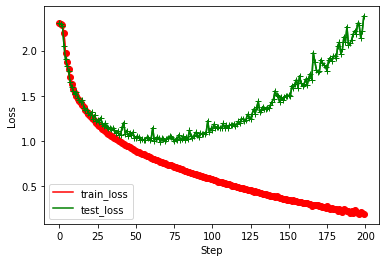

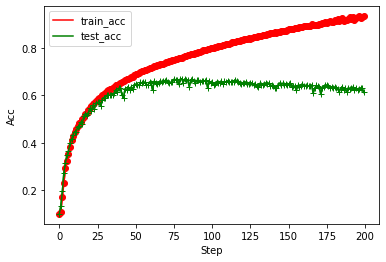

In [13]:
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

With the increase of epoch, train loss decreased continuously, but test loss decreased first and then increased. The performance was the best at about 70 rounds. Before 70 rounds, it was under-fitting, and after 70 rounds, it was over-fitting. As the training goes on, the complexity of the model will increase, and over-fitting is easy to occur when the model is overtrained.

## Tuning

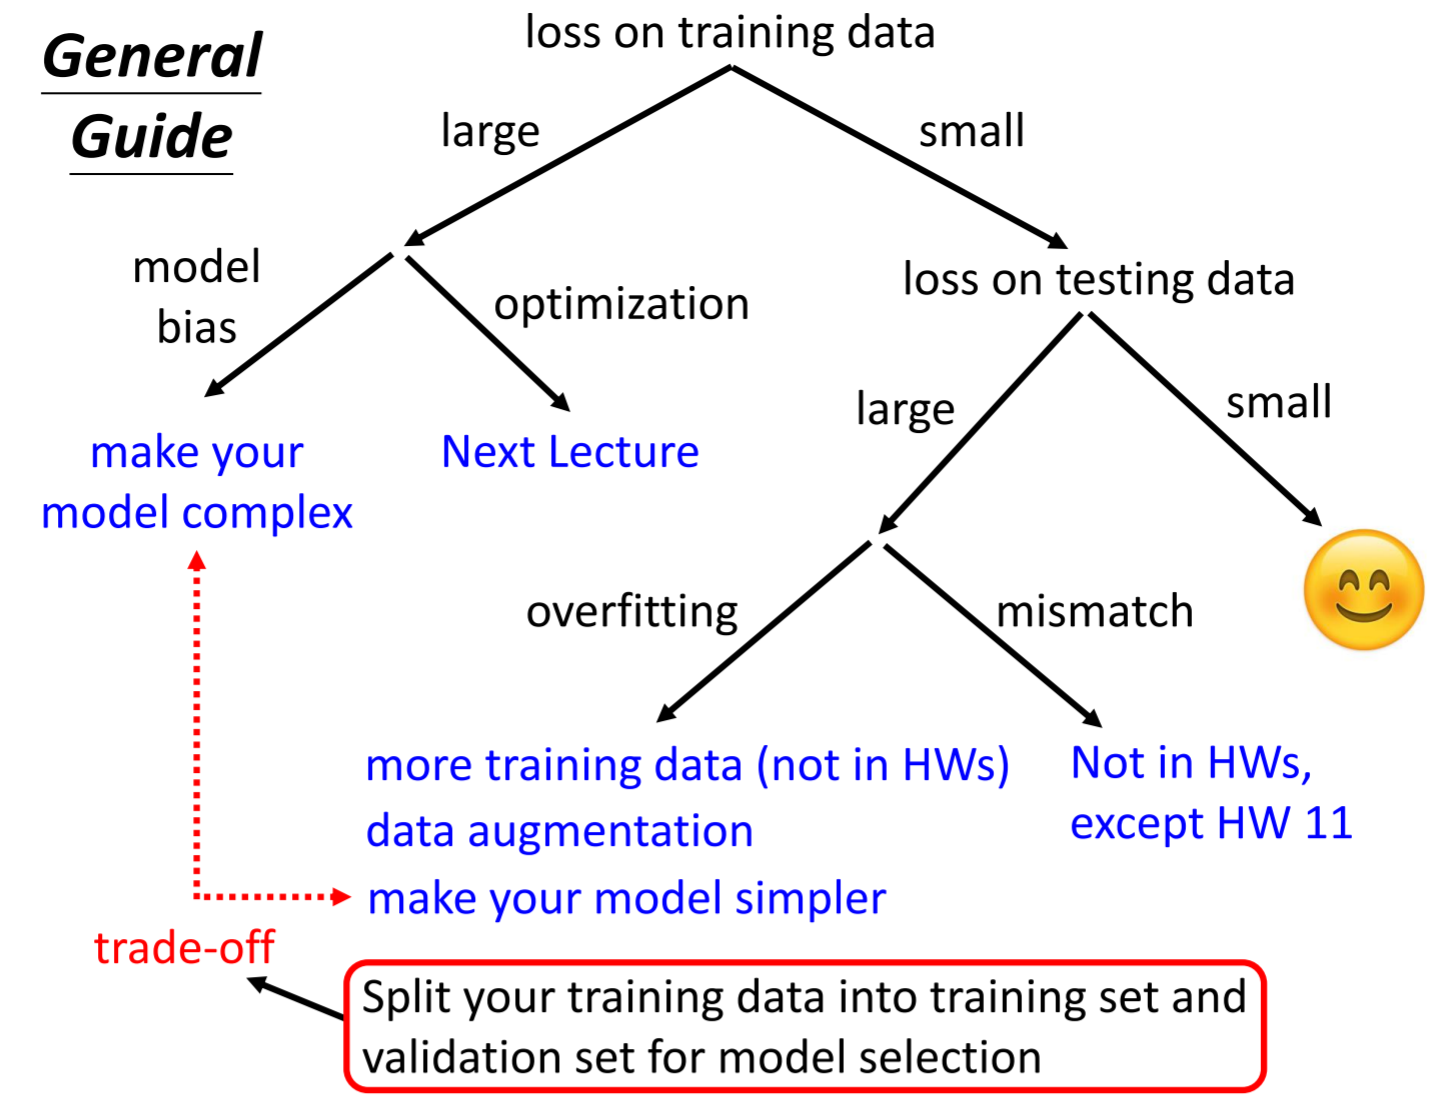

### 1. Learning rate

The initial learning rate was set to a very small value (1e-5) and then exponentially increased at each step (1.05 times) for training.

In [14]:
LOG_PATH="./train1.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn1.pth"
    
model = Net()
if AVAIL_GPUS:
    model = model.cuda()

BATCH_SIZE = 128
LEARNING_RATE = 1e-5
NUM_EPOCHS = 236  # 1.05**236*1e-5 = 1.002
print("Model: CNN from Pytorch tutorial")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: SGD")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: SGD")
    f.write("\n")
    f.write("Learning rate: %d" % (LEARNING_RATE))
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
    print("Learning rate: %f" % (LEARNING_RATE))
    with open(LOG_PATH, "a") as f:
        f.write("Learning rate: %f" % (LEARNING_RATE))
        f.write("\n")
        
    train(i)
    test(i)
    
    LEARNING_RATE = LEARNING_RATE * 1.05
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: CNN from Pytorch tutorial
Batch size: 128
Epoch num: 236
Optimizer: SGD
---------- Training Epoch #0 ----------
Learning rate: 0.000010


391it [00:03, 119.25it/s]

Finish 1 epoch, Train loss: 2.305524, Train acc@1: 0.100000


Test loss: 2.305559, Test acc@1: 0.100000
Saving Best model...			Top1 = 10.000000%
Elapsed time: 5.251787185668945
---------- Training Epoch #1 ----------
Learning rate: 0.000011


391it [00:03, 122.70it/s]

Finish 2 epoch, Train loss: 2.305517, Train acc@1: 0.100000


Test loss: 2.305552, Test acc@1: 0.100000
Elapsed time: 10.486459493637085
---------- Training Epoch #2 ----------
Learning rate: 0.000011


391it [00:03, 126.22it/s]

Finish 3 epoch, Train loss: 2.305511, Train acc@1: 0.100000


Test loss: 2.305545, Test acc@1: 0.100000
Elapsed time: 15.552536487579346
---------- Training Epoch #3 ----------
Learning rate: 0.000012


391it [00:03, 126.86it/s]

Finish 4 epoch, Train loss: 2.305504, Train acc@1: 0.100000


Test loss: 2.305538, Test acc@1: 0.100000
Elapsed time: 20.559625148773193
---------- Training Epoch #4 ----------
Learning rate: 0.000012


391it [00:03, 126.16it/s]

Finish 5 epoch, Train loss: 2.305497, Train acc@1: 0.100000


Test loss: 2.305531, Test acc@1: 0.100000
Elapsed time: 25.597540140151978
---------- Training Epoch #5 ----------
Learning rate: 0.000013


391it [00:03, 115.26it/s]

Finish 6 epoch, Train loss: 2.305489, Train acc@1: 0.100000


Test loss: 2.305523, Test acc@1: 0.100000
Elapsed time: 31.002952337265015
---------- Training Epoch #6 ----------
Learning rate: 0.000013


391it [00:03, 124.74it/s]

Finish 7 epoch, Train loss: 2.305481, Train acc@1: 0.100000


Test loss: 2.305515, Test acc@1: 0.100000
Elapsed time: 36.0867657661438
---------- Training Epoch #7 ----------
Learning rate: 0.000014


391it [00:03, 127.66it/s]

Finish 8 epoch, Train loss: 2.305473, Train acc@1: 0.100000


Test loss: 2.305506, Test acc@1: 0.100000
Elapsed time: 41.14831256866455
---------- Training Epoch #8 ----------
Learning rate: 0.000015


391it [00:03, 127.28it/s]

Finish 9 epoch, Train loss: 2.305464, Train acc@1: 0.100000


Test loss: 2.305498, Test acc@1: 0.100000
Elapsed time: 46.26683306694031
---------- Training Epoch #9 ----------
Learning rate: 0.000016


391it [00:03, 124.19it/s]

Finish 10 epoch, Train loss: 2.305455, Train acc@1: 0.100000


Test loss: 2.305488, Test acc@1: 0.100000
Elapsed time: 51.37292432785034
---------- Training Epoch #10 ----------
Learning rate: 0.000016


391it [00:03, 124.32it/s]

Finish 11 epoch, Train loss: 2.305446, Train acc@1: 0.100000


Test loss: 2.305478, Test acc@1: 0.100000
Elapsed time: 56.51313138008118
---------- Training Epoch #11 ----------
Learning rate: 0.000017


391it [00:03, 127.29it/s]

Finish 12 epoch, Train loss: 2.305435, Train acc@1: 0.100000


Test loss: 2.305468, Test acc@1: 0.100000
Elapsed time: 61.47989463806152
---------- Training Epoch #12 ----------
Learning rate: 0.000018


391it [00:03, 125.03it/s]

Finish 13 epoch, Train loss: 2.305425, Train acc@1: 0.100000


Test loss: 2.305457, Test acc@1: 0.100000
Elapsed time: 66.67209887504578
---------- Training Epoch #13 ----------
Learning rate: 0.000019


391it [00:03, 123.55it/s]

Finish 14 epoch, Train loss: 2.305414, Train acc@1: 0.100000


Test loss: 2.305445, Test acc@1: 0.100000
Elapsed time: 71.91641020774841
---------- Training Epoch #14 ----------
Learning rate: 0.000020


391it [00:03, 120.38it/s]

Finish 15 epoch, Train loss: 2.305402, Train acc@1: 0.100000


Test loss: 2.305434, Test acc@1: 0.100000
Elapsed time: 77.08924698829651
---------- Training Epoch #15 ----------
Learning rate: 0.000021


391it [00:03, 128.08it/s]

Finish 16 epoch, Train loss: 2.305390, Train acc@1: 0.100000


Test loss: 2.305421, Test acc@1: 0.100000
Elapsed time: 82.08328628540039
---------- Training Epoch #16 ----------
Learning rate: 0.000022


391it [00:03, 123.45it/s]

Finish 17 epoch, Train loss: 2.305378, Train acc@1: 0.100000


Test loss: 2.305408, Test acc@1: 0.100000
Elapsed time: 87.21160173416138
---------- Training Epoch #17 ----------
Learning rate: 0.000023


391it [00:03, 126.56it/s]

Finish 18 epoch, Train loss: 2.305364, Train acc@1: 0.100000


Test loss: 2.305394, Test acc@1: 0.100000
Elapsed time: 92.22030878067017
---------- Training Epoch #18 ----------
Learning rate: 0.000024


391it [00:03, 122.28it/s]

Finish 19 epoch, Train loss: 2.305350, Train acc@1: 0.100000


Test loss: 2.305380, Test acc@1: 0.100000
Elapsed time: 97.37283706665039
---------- Training Epoch #19 ----------
Learning rate: 0.000025


391it [00:03, 122.04it/s]

Finish 20 epoch, Train loss: 2.305336, Train acc@1: 0.100000


Test loss: 2.305365, Test acc@1: 0.100000
Elapsed time: 102.53615951538086
---------- Training Epoch #20 ----------
Learning rate: 0.000027


391it [00:03, 126.61it/s]

Finish 21 epoch, Train loss: 2.305320, Train acc@1: 0.100000


Test loss: 2.305349, Test acc@1: 0.100000
Elapsed time: 107.58411502838135
---------- Training Epoch #21 ----------
Learning rate: 0.000028


391it [00:03, 122.51it/s]

Finish 22 epoch, Train loss: 2.305304, Train acc@1: 0.100000


Test loss: 2.305332, Test acc@1: 0.100000
Elapsed time: 112.73127746582031
---------- Training Epoch #22 ----------
Learning rate: 0.000029


391it [00:03, 128.60it/s]

Finish 23 epoch, Train loss: 2.305288, Train acc@1: 0.100000


Test loss: 2.305315, Test acc@1: 0.100000
Elapsed time: 117.75513648986816
---------- Training Epoch #23 ----------
Learning rate: 0.000031


391it [00:03, 124.73it/s]

Finish 24 epoch, Train loss: 2.305270, Train acc@1: 0.100000


Test loss: 2.305297, Test acc@1: 0.100000
Elapsed time: 122.80051231384277
---------- Training Epoch #24 ----------
Learning rate: 0.000032


391it [00:03, 119.57it/s]

Finish 25 epoch, Train loss: 2.305252, Train acc@1: 0.100000


Test loss: 2.305278, Test acc@1: 0.100000
Elapsed time: 128.20421481132507
---------- Training Epoch #25 ----------
Learning rate: 0.000034


391it [00:03, 127.92it/s]

Finish 26 epoch, Train loss: 2.305232, Train acc@1: 0.100000


Test loss: 2.305258, Test acc@1: 0.100000
Elapsed time: 133.29885864257812
---------- Training Epoch #26 ----------
Learning rate: 0.000036


391it [00:03, 127.11it/s]

Finish 27 epoch, Train loss: 2.305212, Train acc@1: 0.100000


Test loss: 2.305237, Test acc@1: 0.100000
Elapsed time: 138.4602975845337
---------- Training Epoch #27 ----------
Learning rate: 0.000037


391it [00:03, 127.26it/s]

Finish 28 epoch, Train loss: 2.305191, Train acc@1: 0.100000


Test loss: 2.305215, Test acc@1: 0.100000
Elapsed time: 143.5467450618744
---------- Training Epoch #28 ----------
Learning rate: 0.000039


391it [00:03, 122.65it/s]

Finish 29 epoch, Train loss: 2.305169, Train acc@1: 0.100000


Test loss: 2.305192, Test acc@1: 0.100000
Elapsed time: 148.79667687416077
---------- Training Epoch #29 ----------
Learning rate: 0.000041


391it [00:03, 125.40it/s]

Finish 30 epoch, Train loss: 2.305146, Train acc@1: 0.100000


Test loss: 2.305168, Test acc@1: 0.100000
Elapsed time: 153.95794463157654
---------- Training Epoch #30 ----------
Learning rate: 0.000043


391it [00:03, 123.14it/s]

Finish 31 epoch, Train loss: 2.305122, Train acc@1: 0.100000


Test loss: 2.305143, Test acc@1: 0.100000
Elapsed time: 159.21613240242004
---------- Training Epoch #31 ----------
Learning rate: 0.000045


391it [00:03, 120.87it/s]

Finish 32 epoch, Train loss: 2.305097, Train acc@1: 0.100000


Test loss: 2.305117, Test acc@1: 0.100000
Elapsed time: 164.4941701889038
---------- Training Epoch #32 ----------
Learning rate: 0.000048


391it [00:02, 130.59it/s]

Finish 33 epoch, Train loss: 2.305070, Train acc@1: 0.100000


Test loss: 2.305089, Test acc@1: 0.100000
Elapsed time: 169.49050378799438
---------- Training Epoch #33 ----------
Learning rate: 0.000050


391it [00:03, 128.30it/s]

Finish 34 epoch, Train loss: 2.305042, Train acc@1: 0.100000


Test loss: 2.305061, Test acc@1: 0.100000
Elapsed time: 174.61448669433594
---------- Training Epoch #34 ----------
Learning rate: 0.000053


391it [00:03, 125.84it/s]

Finish 35 epoch, Train loss: 2.305013, Train acc@1: 0.100000


Test loss: 2.305031, Test acc@1: 0.100000
Elapsed time: 179.72362518310547
---------- Training Epoch #35 ----------
Learning rate: 0.000055


391it [00:03, 126.87it/s]

Finish 36 epoch, Train loss: 2.304983, Train acc@1: 0.100000


Test loss: 2.304999, Test acc@1: 0.100000
Elapsed time: 184.81983256340027
---------- Training Epoch #36 ----------
Learning rate: 0.000058


391it [00:03, 127.53it/s]

Finish 37 epoch, Train loss: 2.304951, Train acc@1: 0.100000


Test loss: 2.304967, Test acc@1: 0.100000
Elapsed time: 189.87426328659058
---------- Training Epoch #37 ----------
Learning rate: 0.000061


391it [00:03, 125.14it/s]

Finish 38 epoch, Train loss: 2.304919, Train acc@1: 0.100000


Test loss: 2.304933, Test acc@1: 0.100000
Elapsed time: 194.96765851974487
---------- Training Epoch #38 ----------
Learning rate: 0.000064


391it [00:03, 127.62it/s]

Finish 39 epoch, Train loss: 2.304884, Train acc@1: 0.100000


Test loss: 2.304897, Test acc@1: 0.100000
Elapsed time: 199.99356293678284
---------- Training Epoch #39 ----------
Learning rate: 0.000067


391it [00:02, 130.57it/s]

Finish 40 epoch, Train loss: 2.304848, Train acc@1: 0.100000


Test loss: 2.304860, Test acc@1: 0.100000
Elapsed time: 204.95093607902527
---------- Training Epoch #40 ----------
Learning rate: 0.000070


391it [00:03, 128.52it/s]

Finish 41 epoch, Train loss: 2.304810, Train acc@1: 0.100000


Test loss: 2.304821, Test acc@1: 0.100000
Elapsed time: 209.95897817611694
---------- Training Epoch #41 ----------
Learning rate: 0.000074


391it [00:03, 124.49it/s]

Finish 42 epoch, Train loss: 2.304771, Train acc@1: 0.100000


Test loss: 2.304780, Test acc@1: 0.100000
Elapsed time: 215.05968761444092
---------- Training Epoch #42 ----------
Learning rate: 0.000078


391it [00:03, 120.45it/s]

Finish 43 epoch, Train loss: 2.304730, Train acc@1: 0.100000


Test loss: 2.304738, Test acc@1: 0.100000
Elapsed time: 220.2387673854828
---------- Training Epoch #43 ----------
Learning rate: 0.000081


391it [00:03, 119.88it/s]

Finish 44 epoch, Train loss: 2.304687, Train acc@1: 0.100000


Test loss: 2.304694, Test acc@1: 0.100000
Elapsed time: 225.42282056808472
---------- Training Epoch #44 ----------
Learning rate: 0.000086


391it [00:03, 127.67it/s]

Finish 45 epoch, Train loss: 2.304642, Train acc@1: 0.100000


Test loss: 2.304648, Test acc@1: 0.100000
Elapsed time: 230.42127871513367
---------- Training Epoch #45 ----------
Learning rate: 0.000090


391it [00:03, 126.97it/s]

Finish 46 epoch, Train loss: 2.304596, Train acc@1: 0.100000


Test loss: 2.304600, Test acc@1: 0.100000
Elapsed time: 235.43448138237
---------- Training Epoch #46 ----------
Learning rate: 0.000094


391it [00:03, 124.82it/s]

Finish 47 epoch, Train loss: 2.304548, Train acc@1: 0.100000


Test loss: 2.304550, Test acc@1: 0.100000
Elapsed time: 240.54982352256775
---------- Training Epoch #47 ----------
Learning rate: 0.000099


391it [00:03, 126.00it/s]

Finish 48 epoch, Train loss: 2.304497, Train acc@1: 0.100000


Test loss: 2.304498, Test acc@1: 0.100000
Elapsed time: 245.65774130821228
---------- Training Epoch #48 ----------
Learning rate: 0.000104


391it [00:03, 123.76it/s]

Finish 49 epoch, Train loss: 2.304444, Train acc@1: 0.100000


Test loss: 2.304443, Test acc@1: 0.100000
Elapsed time: 250.82116293907166
---------- Training Epoch #49 ----------
Learning rate: 0.000109


391it [00:03, 119.11it/s]

Finish 50 epoch, Train loss: 2.304390, Train acc@1: 0.100000


Test loss: 2.304387, Test acc@1: 0.100000
Elapsed time: 256.035569190979
---------- Training Epoch #50 ----------
Learning rate: 0.000115


391it [00:03, 125.54it/s]

Finish 51 epoch, Train loss: 2.304333, Train acc@1: 0.100000


Test loss: 2.304328, Test acc@1: 0.100000
Elapsed time: 261.1389696598053
---------- Training Epoch #51 ----------
Learning rate: 0.000120


391it [00:03, 120.25it/s]

Finish 52 epoch, Train loss: 2.304273, Train acc@1: 0.100000


Test loss: 2.304267, Test acc@1: 0.100000
Elapsed time: 266.406423330307
---------- Training Epoch #52 ----------
Learning rate: 0.000126


391it [00:03, 120.27it/s]

Finish 53 epoch, Train loss: 2.304211, Train acc@1: 0.100000


Test loss: 2.304203, Test acc@1: 0.100000
Elapsed time: 271.6607041358948
---------- Training Epoch #53 ----------
Learning rate: 0.000133


391it [00:03, 126.03it/s]

Finish 54 epoch, Train loss: 2.304147, Train acc@1: 0.100000


Test loss: 2.304137, Test acc@1: 0.100000
Elapsed time: 276.7298393249512
---------- Training Epoch #54 ----------
Learning rate: 0.000139


391it [00:03, 121.60it/s]

Finish 55 epoch, Train loss: 2.304081, Train acc@1: 0.100000


Test loss: 2.304068, Test acc@1: 0.100000
Elapsed time: 281.8683760166168
---------- Training Epoch #55 ----------
Learning rate: 0.000146


391it [00:03, 123.61it/s]

Finish 56 epoch, Train loss: 2.304011, Train acc@1: 0.100000


Test loss: 2.303996, Test acc@1: 0.100000
Elapsed time: 287.0169270038605
---------- Training Epoch #56 ----------
Learning rate: 0.000154


391it [00:03, 121.99it/s]

Finish 57 epoch, Train loss: 2.303939, Train acc@1: 0.100000


Test loss: 2.303921, Test acc@1: 0.100000
Elapsed time: 292.16127824783325
---------- Training Epoch #57 ----------
Learning rate: 0.000161


391it [00:03, 121.36it/s]

Finish 58 epoch, Train loss: 2.303864, Train acc@1: 0.100000


Test loss: 2.303844, Test acc@1: 0.100000
Elapsed time: 297.25885128974915
---------- Training Epoch #58 ----------
Learning rate: 0.000169


391it [00:03, 122.49it/s]

Finish 59 epoch, Train loss: 2.303787, Train acc@1: 0.100000


Test loss: 2.303764, Test acc@1: 0.100000
Elapsed time: 302.4253399372101
---------- Training Epoch #59 ----------
Learning rate: 0.000178


391it [00:03, 127.16it/s]

Finish 60 epoch, Train loss: 2.303706, Train acc@1: 0.100000


Test loss: 2.303681, Test acc@1: 0.100000
Elapsed time: 307.4402470588684
---------- Training Epoch #60 ----------
Learning rate: 0.000187


391it [00:03, 126.58it/s]

Finish 61 epoch, Train loss: 2.303623, Train acc@1: 0.100000


Test loss: 2.303595, Test acc@1: 0.100000
Elapsed time: 312.46234917640686
---------- Training Epoch #61 ----------
Learning rate: 0.000196


391it [00:03, 122.02it/s]

Finish 62 epoch, Train loss: 2.303536, Train acc@1: 0.100000


Test loss: 2.303505, Test acc@1: 0.100000
Elapsed time: 317.5877058506012
---------- Training Epoch #62 ----------
Learning rate: 0.000206


391it [00:03, 124.56it/s]

Finish 63 epoch, Train loss: 2.303446, Train acc@1: 0.100000


Test loss: 2.303413, Test acc@1: 0.100000
Elapsed time: 322.65725445747375
---------- Training Epoch #63 ----------
Learning rate: 0.000216


391it [00:03, 122.21it/s]

Finish 64 epoch, Train loss: 2.303353, Train acc@1: 0.100000


Test loss: 2.303317, Test acc@1: 0.100000
Elapsed time: 327.82190227508545
---------- Training Epoch #64 ----------
Learning rate: 0.000227


391it [00:03, 126.47it/s]

Finish 65 epoch, Train loss: 2.303256, Train acc@1: 0.100000


Test loss: 2.303218, Test acc@1: 0.100000
Elapsed time: 332.91643500328064
---------- Training Epoch #65 ----------
Learning rate: 0.000238


391it [00:03, 125.71it/s]

Finish 66 epoch, Train loss: 2.303156, Train acc@1: 0.100000


Test loss: 2.303114, Test acc@1: 0.100000
Elapsed time: 338.02964091300964
---------- Training Epoch #66 ----------
Learning rate: 0.000250


391it [00:03, 125.84it/s]

Finish 67 epoch, Train loss: 2.303052, Train acc@1: 0.100000


Test loss: 2.303007, Test acc@1: 0.100000
Elapsed time: 343.0644111633301
---------- Training Epoch #67 ----------
Learning rate: 0.000263


391it [00:03, 122.95it/s]

Finish 68 epoch, Train loss: 2.302945, Train acc@1: 0.100000


Test loss: 2.302896, Test acc@1: 0.100000
Elapsed time: 348.20375514030457
---------- Training Epoch #68 ----------
Learning rate: 0.000276


391it [00:03, 125.46it/s]

Finish 69 epoch, Train loss: 2.302833, Train acc@1: 0.100000


Test loss: 2.302781, Test acc@1: 0.100000
Elapsed time: 353.30522632598877
---------- Training Epoch #69 ----------
Learning rate: 0.000290


391it [00:03, 124.11it/s]

Finish 70 epoch, Train loss: 2.302717, Train acc@1: 0.100000


Test loss: 2.302662, Test acc@1: 0.100000
Elapsed time: 358.48298954963684
---------- Training Epoch #70 ----------
Learning rate: 0.000304


391it [00:03, 123.89it/s]

Finish 71 epoch, Train loss: 2.302597, Train acc@1: 0.100000


Test loss: 2.302538, Test acc@1: 0.100000
Elapsed time: 363.62827587127686
---------- Training Epoch #71 ----------
Learning rate: 0.000319


391it [00:03, 126.82it/s]

Finish 72 epoch, Train loss: 2.302472, Train acc@1: 0.100000


Test loss: 2.302410, Test acc@1: 0.100000
Elapsed time: 368.73512291908264
---------- Training Epoch #72 ----------
Learning rate: 0.000335


391it [00:03, 123.36it/s]

Finish 73 epoch, Train loss: 2.302342, Train acc@1: 0.100000


Test loss: 2.302276, Test acc@1: 0.100000
Elapsed time: 373.96613788604736
---------- Training Epoch #73 ----------
Learning rate: 0.000352


391it [00:03, 120.14it/s]

Finish 74 epoch, Train loss: 2.302208, Train acc@1: 0.100000


Test loss: 2.302137, Test acc@1: 0.100000
Elapsed time: 379.2147169113159
---------- Training Epoch #74 ----------
Learning rate: 0.000370


391it [00:03, 123.01it/s]

Finish 75 epoch, Train loss: 2.302067, Train acc@1: 0.100000


Test loss: 2.301991, Test acc@1: 0.100000
Elapsed time: 384.37853622436523
---------- Training Epoch #75 ----------
Learning rate: 0.000388


391it [00:03, 126.93it/s]

Finish 76 epoch, Train loss: 2.301919, Train acc@1: 0.100000


Test loss: 2.301838, Test acc@1: 0.100000
Elapsed time: 389.4680790901184
---------- Training Epoch #76 ----------
Learning rate: 0.000408


391it [00:03, 125.06it/s]

Finish 77 epoch, Train loss: 2.301764, Train acc@1: 0.100020


Test loss: 2.301679, Test acc@1: 0.100000
Elapsed time: 394.6629545688629
---------- Training Epoch #77 ----------
Learning rate: 0.000428


391it [00:03, 126.10it/s]

Finish 78 epoch, Train loss: 2.301602, Train acc@1: 0.100020


Test loss: 2.301510, Test acc@1: 0.100000
Elapsed time: 399.7559177875519
---------- Training Epoch #78 ----------
Learning rate: 0.000450


391it [00:03, 125.20it/s]

Finish 79 epoch, Train loss: 2.301431, Train acc@1: 0.100000


Test loss: 2.301333, Test acc@1: 0.100000
Elapsed time: 404.8621301651001
---------- Training Epoch #79 ----------
Learning rate: 0.000472


391it [00:03, 127.76it/s]

Finish 80 epoch, Train loss: 2.301251, Train acc@1: 0.100060


Test loss: 2.301146, Test acc@1: 0.100100
Saving Best model...			Top1 = 10.010000%
Elapsed time: 409.8848865032196
---------- Training Epoch #80 ----------
Learning rate: 0.000496


391it [00:03, 125.66it/s]

Finish 81 epoch, Train loss: 2.301060, Train acc@1: 0.100160


Test loss: 2.300947, Test acc@1: 0.100100
Elapsed time: 415.03531670570374
---------- Training Epoch #81 ----------
Learning rate: 0.000520


391it [00:03, 125.67it/s]

Finish 82 epoch, Train loss: 2.300856, Train acc@1: 0.100220


Test loss: 2.300734, Test acc@1: 0.100200
Saving Best model...			Top1 = 10.020000%
Elapsed time: 420.12020683288574
---------- Training Epoch #82 ----------
Learning rate: 0.000546


391it [00:02, 130.47it/s]

Finish 83 epoch, Train loss: 2.300639, Train acc@1: 0.100340


Test loss: 2.300506, Test acc@1: 0.100800
Saving Best model...			Top1 = 10.080000%
Elapsed time: 425.17261147499084
---------- Training Epoch #83 ----------
Learning rate: 0.000574


391it [00:03, 126.73it/s]

Finish 84 epoch, Train loss: 2.300406, Train acc@1: 0.100800


Test loss: 2.300261, Test acc@1: 0.101300
Saving Best model...			Top1 = 10.130000%
Elapsed time: 430.29328441619873
---------- Training Epoch #84 ----------
Learning rate: 0.000602


391it [00:03, 123.79it/s]

Finish 85 epoch, Train loss: 2.300154, Train acc@1: 0.101040


Test loss: 2.299994, Test acc@1: 0.102200
Saving Best model...			Top1 = 10.220000%
Elapsed time: 435.36892580986023
---------- Training Epoch #85 ----------
Learning rate: 0.000633


391it [00:03, 124.83it/s]

Finish 86 epoch, Train loss: 2.299878, Train acc@1: 0.101780


Test loss: 2.299702, Test acc@1: 0.102700
Saving Best model...			Top1 = 10.270000%
Elapsed time: 440.4973449707031
---------- Training Epoch #86 ----------
Learning rate: 0.000664


391it [00:03, 126.07it/s]

Finish 87 epoch, Train loss: 2.299576, Train acc@1: 0.102720


Test loss: 2.299380, Test acc@1: 0.104200
Saving Best model...			Top1 = 10.420000%
Elapsed time: 445.55813908576965
---------- Training Epoch #87 ----------
Learning rate: 0.000697


391it [00:03, 125.04it/s]

Finish 88 epoch, Train loss: 2.299241, Train acc@1: 0.104360


Test loss: 2.299022, Test acc@1: 0.105400
Saving Best model...			Top1 = 10.540000%
Elapsed time: 450.68642115592957
---------- Training Epoch #88 ----------
Learning rate: 0.000732


391it [00:03, 124.26it/s]

Finish 89 epoch, Train loss: 2.298867, Train acc@1: 0.106380


Test loss: 2.298619, Test acc@1: 0.108000
Saving Best model...			Top1 = 10.800000%
Elapsed time: 455.7598044872284
---------- Training Epoch #89 ----------
Learning rate: 0.000769


391it [00:03, 121.83it/s]

Finish 90 epoch, Train loss: 2.298444, Train acc@1: 0.108380


Test loss: 2.298162, Test acc@1: 0.109900
Saving Best model...			Top1 = 10.990000%
Elapsed time: 460.9978756904602
---------- Training Epoch #90 ----------
Learning rate: 0.000807


391it [00:03, 123.05it/s]


Finish 91 epoch, Train loss: 2.297960, Train acc@1: 0.110480
Test loss: 2.297635, Test acc@1: 0.112400
Saving Best model...			Top1 = 11.240000%
Elapsed time: 466.11462593078613
---------- Training Epoch #91 ----------
Learning rate: 0.000848


391it [00:03, 126.03it/s]

Finish 92 epoch, Train loss: 2.297399, Train acc@1: 0.114160


Test loss: 2.297021, Test acc@1: 0.116300
Saving Best model...			Top1 = 11.630000%
Elapsed time: 471.1414864063263
---------- Training Epoch #92 ----------
Learning rate: 0.000890


391it [00:03, 123.31it/s]

Finish 93 epoch, Train loss: 2.296739, Train acc@1: 0.118660


Test loss: 2.296293, Test acc@1: 0.120200
Saving Best model...			Top1 = 12.020000%
Elapsed time: 476.27479457855225
---------- Training Epoch #93 ----------
Learning rate: 0.000935


391it [00:03, 126.42it/s]

Finish 94 epoch, Train loss: 2.295950, Train acc@1: 0.122520


Test loss: 2.295413, Test acc@1: 0.124600
Saving Best model...			Top1 = 12.460000%
Elapsed time: 481.2862014770508
---------- Training Epoch #94 ----------
Learning rate: 0.000981


391it [00:03, 122.73it/s]

Finish 95 epoch, Train loss: 2.294987, Train acc@1: 0.126320


Test loss: 2.294332, Test acc@1: 0.129600
Saving Best model...			Top1 = 12.960000%
Elapsed time: 486.3983118534088
---------- Training Epoch #95 ----------
Learning rate: 0.001030


391it [00:03, 123.74it/s]

Finish 96 epoch, Train loss: 2.293792, Train acc@1: 0.130500


Test loss: 2.292976, Test acc@1: 0.133700
Saving Best model...			Top1 = 13.370000%
Elapsed time: 491.6093089580536
---------- Training Epoch #96 ----------
Learning rate: 0.001082


391it [00:03, 121.09it/s]

Finish 97 epoch, Train loss: 2.292289, Train acc@1: 0.135300


Test loss: 2.291265, Test acc@1: 0.138400
Saving Best model...			Top1 = 13.840000%
Elapsed time: 496.87965297698975
---------- Training Epoch #97 ----------
Learning rate: 0.001136


391it [00:03, 120.21it/s]

Finish 98 epoch, Train loss: 2.290381, Train acc@1: 0.140000


Test loss: 2.289064, Test acc@1: 0.147900
Saving Best model...			Top1 = 14.790000%
Elapsed time: 502.1364860534668
---------- Training Epoch #98 ----------
Learning rate: 0.001193


391it [00:03, 127.67it/s]

Finish 99 epoch, Train loss: 2.287899, Train acc@1: 0.149380


Test loss: 2.286137, Test acc@1: 0.159900
Saving Best model...			Top1 = 15.990000%
Elapsed time: 507.206059217453
---------- Training Epoch #99 ----------
Learning rate: 0.001252


391it [00:03, 127.99it/s]

Finish 100 epoch, Train loss: 2.284530, Train acc@1: 0.166240


Test loss: 2.282065, Test acc@1: 0.179700
Saving Best model...			Top1 = 17.970000%
Elapsed time: 512.2032833099365
---------- Training Epoch #100 ----------
Learning rate: 0.001315


391it [00:03, 124.27it/s]

Finish 101 epoch, Train loss: 2.279728, Train acc@1: 0.192360


Test loss: 2.276101, Test acc@1: 0.207700
Saving Best model...			Top1 = 20.770000%
Elapsed time: 517.3358747959137
---------- Training Epoch #101 ----------
Learning rate: 0.001381


391it [00:03, 122.58it/s]

Finish 102 epoch, Train loss: 2.272450, Train acc@1: 0.214800


Test loss: 2.266795, Test acc@1: 0.231500
Saving Best model...			Top1 = 23.150000%
Elapsed time: 522.4864182472229
---------- Training Epoch #102 ----------
Learning rate: 0.001450


391it [00:03, 123.73it/s]

Finish 103 epoch, Train loss: 2.260690, Train acc@1: 0.229340


Test loss: 2.251323, Test acc@1: 0.237400
Saving Best model...			Top1 = 23.740000%
Elapsed time: 527.697760105133
---------- Training Epoch #103 ----------
Learning rate: 0.001522


391it [00:03, 123.66it/s]

Finish 104 epoch, Train loss: 2.240425, Train acc@1: 0.232420


Test loss: 2.224033, Test acc@1: 0.236300
Elapsed time: 532.798761844635
---------- Training Epoch #104 ----------
Learning rate: 0.001598


391it [00:03, 126.88it/s]

Finish 105 epoch, Train loss: 2.205008, Train acc@1: 0.231920


Test loss: 2.177920, Test acc@1: 0.237400
Elapsed time: 537.7820515632629
---------- Training Epoch #105 ----------
Learning rate: 0.001678


391it [00:03, 126.65it/s]

Finish 106 epoch, Train loss: 2.151156, Train acc@1: 0.237480


Test loss: 2.115272, Test acc@1: 0.248100
Saving Best model...			Top1 = 24.810000%
Elapsed time: 542.7871725559235
---------- Training Epoch #106 ----------
Learning rate: 0.001762


391it [00:03, 123.12it/s]

Finish 107 epoch, Train loss: 2.087075, Train acc@1: 0.256160


Test loss: 2.049604, Test acc@1: 0.264700
Saving Best model...			Top1 = 26.470000%
Elapsed time: 547.92294049263
---------- Training Epoch #107 ----------
Learning rate: 0.001850


391it [00:03, 125.30it/s]

Finish 108 epoch, Train loss: 2.027053, Train acc@1: 0.271080


Test loss: 1.996033, Test acc@1: 0.276900
Saving Best model...			Top1 = 27.690000%
Elapsed time: 552.9716999530792
---------- Training Epoch #108 ----------
Learning rate: 0.001943


391it [00:03, 123.47it/s]

Finish 109 epoch, Train loss: 1.981890, Train acc@1: 0.283060


Test loss: 1.959109, Test acc@1: 0.286700
Saving Best model...			Top1 = 28.670000%
Elapsed time: 558.089189529419
---------- Training Epoch #109 ----------
Learning rate: 0.002040


391it [00:03, 126.20it/s]

Finish 110 epoch, Train loss: 1.951071, Train acc@1: 0.292100


Test loss: 1.932920, Test acc@1: 0.300100
Saving Best model...			Top1 = 30.010000%
Elapsed time: 563.1271805763245
---------- Training Epoch #110 ----------
Learning rate: 0.002142


391it [00:03, 127.49it/s]

Finish 111 epoch, Train loss: 1.926564, Train acc@1: 0.301480


Test loss: 1.909223, Test acc@1: 0.302200
Saving Best model...			Top1 = 30.220000%
Elapsed time: 568.1501059532166
---------- Training Epoch #111 ----------
Learning rate: 0.002249


391it [00:03, 125.03it/s]

Finish 112 epoch, Train loss: 1.903525, Train acc@1: 0.308160


Test loss: 1.885445, Test acc@1: 0.312500
Saving Best model...			Top1 = 31.250000%
Elapsed time: 573.2280485630035
---------- Training Epoch #112 ----------
Learning rate: 0.002362


391it [00:03, 127.53it/s]

Finish 113 epoch, Train loss: 1.880486, Train acc@1: 0.316280


Test loss: 1.862422, Test acc@1: 0.321700
Saving Best model...			Top1 = 32.170000%
Elapsed time: 578.3159987926483
---------- Training Epoch #113 ----------
Learning rate: 0.002480


391it [00:03, 120.72it/s]

Finish 114 epoch, Train loss: 1.857649, Train acc@1: 0.322780


Test loss: 1.839280, Test acc@1: 0.331300
Saving Best model...			Top1 = 33.130000%
Elapsed time: 583.4743876457214
---------- Training Epoch #114 ----------
Learning rate: 0.002604


391it [00:03, 127.42it/s]

Finish 115 epoch, Train loss: 1.834319, Train acc@1: 0.331660


Test loss: 1.818149, Test acc@1: 0.338400
Saving Best model...			Top1 = 33.840000%
Elapsed time: 588.5793707370758
---------- Training Epoch #115 ----------
Learning rate: 0.002734


391it [00:03, 125.48it/s]

Finish 116 epoch, Train loss: 1.811032, Train acc@1: 0.340940


Test loss: 1.790756, Test acc@1: 0.351700
Saving Best model...			Top1 = 35.170000%
Elapsed time: 593.6657230854034
---------- Training Epoch #116 ----------
Learning rate: 0.002871


391it [00:03, 128.19it/s]

Finish 117 epoch, Train loss: 1.787415, Train acc@1: 0.349920


Test loss: 1.765989, Test acc@1: 0.358500
Saving Best model...			Top1 = 35.850000%
Elapsed time: 598.6662652492523
---------- Training Epoch #117 ----------
Learning rate: 0.003014


391it [00:03, 122.69it/s]

Finish 118 epoch, Train loss: 1.764422, Train acc@1: 0.357240


Test loss: 1.749467, Test acc@1: 0.364300
Saving Best model...			Top1 = 36.430000%
Elapsed time: 603.8580572605133
---------- Training Epoch #118 ----------
Learning rate: 0.003165


391it [00:03, 124.43it/s]

Finish 119 epoch, Train loss: 1.743276, Train acc@1: 0.364380


Test loss: 1.725602, Test acc@1: 0.370000
Saving Best model...			Top1 = 37.000000%
Elapsed time: 608.9898307323456
---------- Training Epoch #119 ----------
Learning rate: 0.003323


391it [00:03, 128.96it/s]

Finish 120 epoch, Train loss: 1.723053, Train acc@1: 0.372000


Test loss: 1.705019, Test acc@1: 0.378400
Saving Best model...			Top1 = 37.840000%
Elapsed time: 614.0621123313904
---------- Training Epoch #120 ----------
Learning rate: 0.003489


391it [00:03, 127.70it/s]

Finish 121 epoch, Train loss: 1.703708, Train acc@1: 0.377780


Test loss: 1.688314, Test acc@1: 0.381400
Saving Best model...			Top1 = 38.140000%
Elapsed time: 619.2053768634796
---------- Training Epoch #121 ----------
Learning rate: 0.003664


391it [00:03, 129.36it/s]

Finish 122 epoch, Train loss: 1.684584, Train acc@1: 0.384060


Test loss: 1.672880, Test acc@1: 0.390500
Saving Best model...			Top1 = 39.050000%
Elapsed time: 624.2396385669708
---------- Training Epoch #122 ----------
Learning rate: 0.003847


391it [00:03, 119.59it/s]

Finish 123 epoch, Train loss: 1.666826, Train acc@1: 0.390640


Test loss: 1.648343, Test acc@1: 0.396200
Saving Best model...			Top1 = 39.620000%
Elapsed time: 629.5726656913757
---------- Training Epoch #123 ----------
Learning rate: 0.004039


391it [00:03, 127.79it/s]

Finish 124 epoch, Train loss: 1.647260, Train acc@1: 0.398380


Test loss: 1.637304, Test acc@1: 0.401300
Saving Best model...			Top1 = 40.130000%
Elapsed time: 634.668952703476
---------- Training Epoch #124 ----------
Learning rate: 0.004241


391it [00:03, 123.92it/s]

Finish 125 epoch, Train loss: 1.628658, Train acc@1: 0.403900


Test loss: 1.613936, Test acc@1: 0.404400
Saving Best model...			Top1 = 40.440000%
Elapsed time: 639.8477489948273
---------- Training Epoch #125 ----------
Learning rate: 0.004453


391it [00:03, 122.74it/s]

Finish 126 epoch, Train loss: 1.609706, Train acc@1: 0.411700


Test loss: 1.594611, Test acc@1: 0.411900
Saving Best model...			Top1 = 41.190000%
Elapsed time: 645.055846452713
---------- Training Epoch #126 ----------
Learning rate: 0.004676


391it [00:03, 125.87it/s]

Finish 127 epoch, Train loss: 1.590540, Train acc@1: 0.419840


Test loss: 1.611047, Test acc@1: 0.406000
Elapsed time: 650.2386252880096
---------- Training Epoch #127 ----------
Learning rate: 0.004910


391it [00:03, 127.43it/s]

Finish 128 epoch, Train loss: 1.572557, Train acc@1: 0.425360


Test loss: 1.570983, Test acc@1: 0.425000
Saving Best model...			Top1 = 42.500000%
Elapsed time: 655.2365520000458
---------- Training Epoch #128 ----------
Learning rate: 0.005155


391it [00:03, 126.48it/s]

Finish 129 epoch, Train loss: 1.553697, Train acc@1: 0.434160


Test loss: 1.548835, Test acc@1: 0.428200
Saving Best model...			Top1 = 42.820000%
Elapsed time: 660.3459212779999
---------- Training Epoch #129 ----------
Learning rate: 0.005413


391it [00:03, 125.49it/s]

Finish 130 epoch, Train loss: 1.533734, Train acc@1: 0.442180


Test loss: 1.519171, Test acc@1: 0.443900
Saving Best model...			Top1 = 44.390000%
Elapsed time: 665.4842960834503
---------- Training Epoch #130 ----------
Learning rate: 0.005683


391it [00:03, 125.41it/s]

Finish 131 epoch, Train loss: 1.516318, Train acc@1: 0.447720


Test loss: 1.522478, Test acc@1: 0.443200
Elapsed time: 670.5147762298584
---------- Training Epoch #131 ----------
Learning rate: 0.005968


391it [00:03, 126.18it/s]

Finish 132 epoch, Train loss: 1.496316, Train acc@1: 0.458320


Test loss: 1.536918, Test acc@1: 0.450100
Saving Best model...			Top1 = 45.010000%
Elapsed time: 675.5574910640717
---------- Training Epoch #132 ----------
Learning rate: 0.006266


391it [00:03, 121.67it/s]

Finish 133 epoch, Train loss: 1.477245, Train acc@1: 0.463840


Test loss: 1.471787, Test acc@1: 0.465700
Saving Best model...			Top1 = 46.570000%
Elapsed time: 680.7231032848358
---------- Training Epoch #133 ----------
Learning rate: 0.006579


391it [00:03, 124.31it/s]

Finish 134 epoch, Train loss: 1.457968, Train acc@1: 0.472880


Test loss: 1.464588, Test acc@1: 0.469300
Saving Best model...			Top1 = 46.930000%
Elapsed time: 685.8216133117676
---------- Training Epoch #134 ----------
Learning rate: 0.006908


391it [00:03, 124.20it/s]

Finish 135 epoch, Train loss: 1.438266, Train acc@1: 0.480880


Test loss: 1.444867, Test acc@1: 0.483100
Saving Best model...			Top1 = 48.310000%
Elapsed time: 690.9412248134613
---------- Training Epoch #135 ----------
Learning rate: 0.007254


391it [00:03, 121.66it/s]

Finish 136 epoch, Train loss: 1.419725, Train acc@1: 0.488040


Test loss: 1.444707, Test acc@1: 0.479200
Elapsed time: 696.0570979118347
---------- Training Epoch #136 ----------
Learning rate: 0.007616


391it [00:03, 126.90it/s]

Finish 137 epoch, Train loss: 1.400786, Train acc@1: 0.494700


Test loss: 1.419597, Test acc@1: 0.488900
Saving Best model...			Top1 = 48.890000%
Elapsed time: 701.0986449718475
---------- Training Epoch #137 ----------
Learning rate: 0.007997


391it [00:03, 122.38it/s]

Finish 138 epoch, Train loss: 1.384383, Train acc@1: 0.500740


Test loss: 1.387208, Test acc@1: 0.505300
Saving Best model...			Top1 = 50.530000%
Elapsed time: 706.2228798866272
---------- Training Epoch #138 ----------
Learning rate: 0.008397


391it [00:03, 122.13it/s]

Finish 139 epoch, Train loss: 1.368027, Train acc@1: 0.508320


Test loss: 1.399195, Test acc@1: 0.498000
Elapsed time: 711.3581941127777
---------- Training Epoch #139 ----------
Learning rate: 0.008817


391it [00:03, 123.88it/s]

Finish 140 epoch, Train loss: 1.345788, Train acc@1: 0.517360


Test loss: 1.341214, Test acc@1: 0.518900
Saving Best model...			Top1 = 51.890000%
Elapsed time: 716.6070301532745
---------- Training Epoch #140 ----------
Learning rate: 0.009258


391it [00:03, 123.42it/s]

Finish 141 epoch, Train loss: 1.331183, Train acc@1: 0.523460


Test loss: 1.444393, Test acc@1: 0.496600
Elapsed time: 721.8598735332489
---------- Training Epoch #141 ----------
Learning rate: 0.009721


391it [00:03, 125.25it/s]

Finish 142 epoch, Train loss: 1.312908, Train acc@1: 0.528560


Test loss: 1.377971, Test acc@1: 0.505600
Elapsed time: 726.9631624221802
---------- Training Epoch #142 ----------
Learning rate: 0.010207


391it [00:03, 122.97it/s]

Finish 143 epoch, Train loss: 1.293529, Train acc@1: 0.537220


Test loss: 1.380368, Test acc@1: 0.507000
Elapsed time: 732.0525348186493
---------- Training Epoch #143 ----------
Learning rate: 0.010717


391it [00:03, 127.36it/s]

Finish 144 epoch, Train loss: 1.275819, Train acc@1: 0.544880


Test loss: 1.303157, Test acc@1: 0.534400
Saving Best model...			Top1 = 53.440000%
Elapsed time: 737.0883724689484
---------- Training Epoch #144 ----------
Learning rate: 0.011253


391it [00:03, 121.85it/s]

Finish 145 epoch, Train loss: 1.258220, Train acc@1: 0.552720


Test loss: 1.277217, Test acc@1: 0.544700
Saving Best model...			Top1 = 54.470000%
Elapsed time: 742.2727966308594
---------- Training Epoch #145 ----------
Learning rate: 0.011815


391it [00:03, 121.17it/s]

Finish 146 epoch, Train loss: 1.238821, Train acc@1: 0.558800


Test loss: 1.259008, Test acc@1: 0.556200
Saving Best model...			Top1 = 55.620000%
Elapsed time: 747.4228463172913
---------- Training Epoch #146 ----------
Learning rate: 0.012406


391it [00:03, 120.45it/s]

Finish 147 epoch, Train loss: 1.227190, Train acc@1: 0.563420


Test loss: 1.241779, Test acc@1: 0.557600
Saving Best model...			Top1 = 55.760000%
Elapsed time: 752.6816186904907
---------- Training Epoch #147 ----------
Learning rate: 0.013026


391it [00:03, 129.37it/s]

Finish 148 epoch, Train loss: 1.212371, Train acc@1: 0.569360


Test loss: 1.340986, Test acc@1: 0.530900
Elapsed time: 757.6535143852234
---------- Training Epoch #148 ----------
Learning rate: 0.013678


391it [00:03, 117.80it/s]

Finish 149 epoch, Train loss: 1.193630, Train acc@1: 0.576280


Test loss: 1.272950, Test acc@1: 0.543600
Elapsed time: 762.9432685375214
---------- Training Epoch #149 ----------
Learning rate: 0.014362


391it [00:03, 122.29it/s]

Finish 150 epoch, Train loss: 1.175181, Train acc@1: 0.583560


Test loss: 1.255767, Test acc@1: 0.558900
Saving Best model...			Top1 = 55.890000%
Elapsed time: 768.1657025814056
---------- Training Epoch #150 ----------
Learning rate: 0.015080


391it [00:03, 121.04it/s]

Finish 151 epoch, Train loss: 1.161721, Train acc@1: 0.590920


Test loss: 1.187738, Test acc@1: 0.582800
Saving Best model...			Top1 = 58.280000%
Elapsed time: 773.4129748344421
---------- Training Epoch #151 ----------
Learning rate: 0.015834


391it [00:03, 123.27it/s]

Finish 152 epoch, Train loss: 1.149754, Train acc@1: 0.594060


Test loss: 1.243870, Test acc@1: 0.568300
Elapsed time: 778.5971691608429
---------- Training Epoch #152 ----------
Learning rate: 0.016625


391it [00:03, 123.81it/s]

Finish 153 epoch, Train loss: 1.135181, Train acc@1: 0.598020


Test loss: 1.189449, Test acc@1: 0.584600
Saving Best model...			Top1 = 58.460000%
Elapsed time: 783.8060832023621
---------- Training Epoch #153 ----------
Learning rate: 0.017457


391it [00:03, 124.57it/s]

Finish 154 epoch, Train loss: 1.123164, Train acc@1: 0.602540


Test loss: 1.175328, Test acc@1: 0.584200
Elapsed time: 788.9347355365753
---------- Training Epoch #154 ----------
Learning rate: 0.018330


391it [00:03, 121.08it/s]

Finish 155 epoch, Train loss: 1.103318, Train acc@1: 0.611100


Test loss: 1.195029, Test acc@1: 0.580700
Elapsed time: 794.2726764678955
---------- Training Epoch #155 ----------
Learning rate: 0.019246


391it [00:03, 124.99it/s]

Finish 156 epoch, Train loss: 1.096179, Train acc@1: 0.614340


Test loss: 1.205317, Test acc@1: 0.578100
Elapsed time: 799.4957168102264
---------- Training Epoch #156 ----------
Learning rate: 0.020208


391it [00:03, 121.38it/s]

Finish 157 epoch, Train loss: 1.076487, Train acc@1: 0.619180


Test loss: 1.175026, Test acc@1: 0.588100
Saving Best model...			Top1 = 58.810000%
Elapsed time: 804.7416574954987
---------- Training Epoch #157 ----------
Learning rate: 0.021219


391it [00:03, 122.34it/s]

Finish 158 epoch, Train loss: 1.067830, Train acc@1: 0.622240


Test loss: 1.167981, Test acc@1: 0.589900
Saving Best model...			Top1 = 58.990000%
Elapsed time: 809.9239392280579
---------- Training Epoch #158 ----------
Learning rate: 0.022280


391it [00:03, 124.31it/s]

Finish 159 epoch, Train loss: 1.055338, Train acc@1: 0.627320


Test loss: 1.107661, Test acc@1: 0.606900
Saving Best model...			Top1 = 60.690000%
Elapsed time: 815.0934090614319
---------- Training Epoch #159 ----------
Learning rate: 0.023394


391it [00:03, 123.64it/s]

Finish 160 epoch, Train loss: 1.044408, Train acc@1: 0.632920


Test loss: 1.167573, Test acc@1: 0.585200
Elapsed time: 820.3673491477966
---------- Training Epoch #160 ----------
Learning rate: 0.024563


391it [00:03, 128.59it/s]

Finish 161 epoch, Train loss: 1.023933, Train acc@1: 0.636200


Test loss: 1.112011, Test acc@1: 0.611900
Saving Best model...			Top1 = 61.190000%
Elapsed time: 825.5172097682953
---------- Training Epoch #161 ----------
Learning rate: 0.025792


391it [00:03, 123.88it/s]

Finish 162 epoch, Train loss: 1.015493, Train acc@1: 0.639460


Test loss: 1.098428, Test acc@1: 0.614300
Saving Best model...			Top1 = 61.430000%
Elapsed time: 830.6986155509949
---------- Training Epoch #162 ----------
Learning rate: 0.027081


391it [00:03, 123.48it/s]

Finish 163 epoch, Train loss: 1.003681, Train acc@1: 0.643720


Test loss: 1.086674, Test acc@1: 0.617400
Saving Best model...			Top1 = 61.740000%
Elapsed time: 835.8445956707001
---------- Training Epoch #163 ----------
Learning rate: 0.028435


391it [00:03, 126.58it/s]

Finish 164 epoch, Train loss: 0.993246, Train acc@1: 0.649640


Test loss: 1.162026, Test acc@1: 0.590600
Elapsed time: 840.850959777832
---------- Training Epoch #164 ----------
Learning rate: 0.029857


391it [00:03, 127.28it/s]

Finish 165 epoch, Train loss: 0.983572, Train acc@1: 0.651120


Test loss: 1.118450, Test acc@1: 0.607600
Elapsed time: 845.8553466796875
---------- Training Epoch #165 ----------
Learning rate: 0.031350


391it [00:03, 125.99it/s]

Finish 166 epoch, Train loss: 0.963284, Train acc@1: 0.660400


Test loss: 1.191872, Test acc@1: 0.592400
Elapsed time: 850.934451341629
---------- Training Epoch #166 ----------
Learning rate: 0.032917


391it [00:03, 122.58it/s]

Finish 167 epoch, Train loss: 0.957902, Train acc@1: 0.663720


Test loss: 1.161944, Test acc@1: 0.606300
Elapsed time: 856.0627450942993
---------- Training Epoch #167 ----------
Learning rate: 0.034563


391it [00:03, 121.38it/s]

Finish 168 epoch, Train loss: 0.940440, Train acc@1: 0.666880


Test loss: 1.114128, Test acc@1: 0.612500
Elapsed time: 861.2220547199249
---------- Training Epoch #168 ----------
Learning rate: 0.036291


391it [00:03, 123.38it/s]

Finish 169 epoch, Train loss: 0.927828, Train acc@1: 0.673720


Test loss: 1.069851, Test acc@1: 0.628400
Saving Best model...			Top1 = 62.840000%
Elapsed time: 866.3865339756012
---------- Training Epoch #169 ----------
Learning rate: 0.038106


391it [00:03, 125.89it/s]

Finish 170 epoch, Train loss: 0.917125, Train acc@1: 0.675160


Test loss: 1.147703, Test acc@1: 0.607600
Elapsed time: 871.4523980617523
---------- Training Epoch #170 ----------
Learning rate: 0.040011


391it [00:03, 120.98it/s]

Finish 171 epoch, Train loss: 0.905510, Train acc@1: 0.680700


Test loss: 1.109846, Test acc@1: 0.621700
Elapsed time: 876.7072007656097
---------- Training Epoch #171 ----------
Learning rate: 0.042012


391it [00:03, 124.86it/s]

Finish 172 epoch, Train loss: 0.899817, Train acc@1: 0.682500


Test loss: 1.102724, Test acc@1: 0.617100
Elapsed time: 881.8686392307281
---------- Training Epoch #172 ----------
Learning rate: 0.044112


391it [00:03, 126.93it/s]

Finish 173 epoch, Train loss: 0.879616, Train acc@1: 0.690620


Test loss: 1.350903, Test acc@1: 0.558300
Elapsed time: 886.872151851654
---------- Training Epoch #173 ----------
Learning rate: 0.046318


391it [00:03, 122.34it/s]

Finish 174 epoch, Train loss: 0.865875, Train acc@1: 0.695600


Test loss: 1.207863, Test acc@1: 0.595000
Elapsed time: 892.0703666210175
---------- Training Epoch #174 ----------
Learning rate: 0.048634


391it [00:03, 124.99it/s]

Finish 175 epoch, Train loss: 0.855719, Train acc@1: 0.698940


Test loss: 1.110961, Test acc@1: 0.618300
Elapsed time: 897.1633198261261
---------- Training Epoch #175 ----------
Learning rate: 0.051065


391it [00:03, 125.67it/s]

Finish 176 epoch, Train loss: 0.849519, Train acc@1: 0.701000


Test loss: 1.207329, Test acc@1: 0.598200
Elapsed time: 902.2729539871216
---------- Training Epoch #176 ----------
Learning rate: 0.053619


391it [00:03, 126.90it/s]

Finish 177 epoch, Train loss: 0.839049, Train acc@1: 0.703760


Test loss: 1.178322, Test acc@1: 0.610600
Elapsed time: 907.3229761123657
---------- Training Epoch #177 ----------
Learning rate: 0.056300


391it [00:03, 126.10it/s]

Finish 178 epoch, Train loss: 0.829364, Train acc@1: 0.706260


Test loss: 1.312526, Test acc@1: 0.581300
Elapsed time: 912.3306860923767
---------- Training Epoch #178 ----------
Learning rate: 0.059115


391it [00:03, 122.79it/s]

Finish 179 epoch, Train loss: 0.819047, Train acc@1: 0.710780


Test loss: 1.238105, Test acc@1: 0.589000
Elapsed time: 917.4871056079865
---------- Training Epoch #179 ----------
Learning rate: 0.062070


391it [00:03, 124.68it/s]

Finish 180 epoch, Train loss: 0.804205, Train acc@1: 0.717840


Test loss: 1.138561, Test acc@1: 0.616100
Elapsed time: 922.6451947689056
---------- Training Epoch #180 ----------
Learning rate: 0.065174


391it [00:03, 124.45it/s]

Finish 181 epoch, Train loss: 0.794453, Train acc@1: 0.720860


Test loss: 1.236010, Test acc@1: 0.605800
Elapsed time: 927.7333590984344
---------- Training Epoch #181 ----------
Learning rate: 0.068433


391it [00:03, 124.11it/s]

Finish 182 epoch, Train loss: 0.778188, Train acc@1: 0.726720


Test loss: 1.253557, Test acc@1: 0.610600
Elapsed time: 932.8292446136475
---------- Training Epoch #182 ----------
Learning rate: 0.071854


391it [00:03, 127.06it/s]

Finish 183 epoch, Train loss: 0.775495, Train acc@1: 0.726460


Test loss: 1.209581, Test acc@1: 0.621000
Elapsed time: 937.9444589614868
---------- Training Epoch #183 ----------
Learning rate: 0.075447


391it [00:03, 123.07it/s]

Finish 184 epoch, Train loss: 0.774352, Train acc@1: 0.727580


Test loss: 1.201370, Test acc@1: 0.615400
Elapsed time: 943.0521464347839
---------- Training Epoch #184 ----------
Learning rate: 0.079219


391it [00:03, 127.15it/s]

Finish 185 epoch, Train loss: 0.761853, Train acc@1: 0.729820


Test loss: 1.281798, Test acc@1: 0.606200
Elapsed time: 948.100417137146
---------- Training Epoch #185 ----------
Learning rate: 0.083180


391it [00:03, 125.05it/s]

Finish 186 epoch, Train loss: 0.750861, Train acc@1: 0.734980


Test loss: 1.232099, Test acc@1: 0.612200
Elapsed time: 953.1665275096893
---------- Training Epoch #186 ----------
Learning rate: 0.087339


391it [00:03, 123.20it/s]

Finish 187 epoch, Train loss: 0.741218, Train acc@1: 0.739540


Test loss: 1.360678, Test acc@1: 0.588600
Elapsed time: 958.286155462265
---------- Training Epoch #187 ----------
Learning rate: 0.091706


391it [00:03, 122.92it/s]

Finish 188 epoch, Train loss: 0.741505, Train acc@1: 0.738420


Test loss: 1.238111, Test acc@1: 0.610700
Elapsed time: 963.4272496700287
---------- Training Epoch #188 ----------
Learning rate: 0.096292


391it [00:03, 122.00it/s]

Finish 189 epoch, Train loss: 0.735436, Train acc@1: 0.741940


Test loss: 1.296883, Test acc@1: 0.601500
Elapsed time: 968.597375869751
---------- Training Epoch #189 ----------
Learning rate: 0.101106


391it [00:03, 122.62it/s]

Finish 190 epoch, Train loss: 0.731904, Train acc@1: 0.742980


Test loss: 1.291024, Test acc@1: 0.599200
Elapsed time: 973.7139828205109
---------- Training Epoch #190 ----------
Learning rate: 0.106161


391it [00:03, 127.28it/s]

Finish 191 epoch, Train loss: 0.723155, Train acc@1: 0.744520


Test loss: 1.364095, Test acc@1: 0.600000
Elapsed time: 978.7754111289978
---------- Training Epoch #191 ----------
Learning rate: 0.111470


391it [00:03, 122.19it/s]

Finish 192 epoch, Train loss: 0.725318, Train acc@1: 0.743300


Test loss: 1.455109, Test acc@1: 0.577600
Elapsed time: 984.0373764038086
---------- Training Epoch #192 ----------
Learning rate: 0.117043


391it [00:03, 124.04it/s]

Finish 193 epoch, Train loss: 0.718237, Train acc@1: 0.744920


Test loss: 1.925627, Test acc@1: 0.518600
Elapsed time: 989.2327959537506
---------- Training Epoch #193 ----------
Learning rate: 0.122895


391it [00:03, 125.08it/s]

Finish 194 epoch, Train loss: 0.736349, Train acc@1: 0.740460


Test loss: 1.286136, Test acc@1: 0.613800
Elapsed time: 994.362462759018
---------- Training Epoch #194 ----------
Learning rate: 0.129040


391it [00:03, 118.67it/s]

Finish 195 epoch, Train loss: 0.719047, Train acc@1: 0.747380


Test loss: 1.505284, Test acc@1: 0.556800
Elapsed time: 999.6874384880066
---------- Training Epoch #195 ----------
Learning rate: 0.135492


391it [00:03, 125.18it/s]

Finish 196 epoch, Train loss: 0.721565, Train acc@1: 0.744540


Test loss: 1.372896, Test acc@1: 0.581800
Elapsed time: 1004.7880108356476
---------- Training Epoch #196 ----------
Learning rate: 0.142266


391it [00:03, 121.00it/s]

Finish 197 epoch, Train loss: 0.722047, Train acc@1: 0.747920


Test loss: 1.465990, Test acc@1: 0.571200
Elapsed time: 1009.997882604599
---------- Training Epoch #197 ----------
Learning rate: 0.149380


391it [00:03, 126.58it/s]

Finish 198 epoch, Train loss: 0.719307, Train acc@1: 0.746060


Test loss: 1.536827, Test acc@1: 0.563400
Elapsed time: 1015.0647041797638
---------- Training Epoch #198 ----------
Learning rate: 0.156849


391it [00:03, 123.85it/s]

Finish 199 epoch, Train loss: 0.726523, Train acc@1: 0.745560


Test loss: 1.427423, Test acc@1: 0.580700
Elapsed time: 1020.219565153122
---------- Training Epoch #199 ----------
Learning rate: 0.164691


391it [00:03, 125.26it/s]

Finish 200 epoch, Train loss: 0.732666, Train acc@1: 0.742900


Test loss: 1.648995, Test acc@1: 0.541600
Elapsed time: 1025.366351366043
---------- Training Epoch #200 ----------
Learning rate: 0.172926


391it [00:03, 126.82it/s]

Finish 201 epoch, Train loss: 0.740938, Train acc@1: 0.739820


Test loss: 1.593407, Test acc@1: 0.565300
Elapsed time: 1030.4601802825928
---------- Training Epoch #201 ----------
Learning rate: 0.181572


391it [00:03, 121.62it/s]


Finish 202 epoch, Train loss: 0.740845, Train acc@1: 0.742260
Test loss: 1.415505, Test acc@1: 0.598500
Elapsed time: 1035.634265422821
---------- Training Epoch #202 ----------
Learning rate: 0.190651


391it [00:03, 129.79it/s]

Finish 203 epoch, Train loss: 0.762079, Train acc@1: 0.736960


Test loss: 1.499044, Test acc@1: 0.573900
Elapsed time: 1040.6265888214111
---------- Training Epoch #203 ----------
Learning rate: 0.200183


391it [00:03, 124.43it/s]

Finish 204 epoch, Train loss: 0.767410, Train acc@1: 0.731140


Test loss: 1.527129, Test acc@1: 0.570100
Elapsed time: 1045.7411465644836
---------- Training Epoch #204 ----------
Learning rate: 0.210192


391it [00:03, 125.58it/s]

Finish 205 epoch, Train loss: 0.783691, Train acc@1: 0.730240


Test loss: 1.519883, Test acc@1: 0.565800
Elapsed time: 1050.7877900600433
---------- Training Epoch #205 ----------
Learning rate: 0.220702


391it [00:03, 126.78it/s]

Finish 206 epoch, Train loss: 0.796608, Train acc@1: 0.723280


Test loss: 1.575380, Test acc@1: 0.550300
Elapsed time: 1055.7855582237244
---------- Training Epoch #206 ----------
Learning rate: 0.231737


391it [00:03, 125.09it/s]

Finish 207 epoch, Train loss: 0.819257, Train acc@1: 0.716020


Test loss: 1.579851, Test acc@1: 0.545300
Elapsed time: 1060.9218776226044
---------- Training Epoch #207 ----------
Learning rate: 0.243324


391it [00:03, 127.93it/s]

Finish 208 epoch, Train loss: 0.829588, Train acc@1: 0.715660


Test loss: 1.519891, Test acc@1: 0.559400
Elapsed time: 1065.9156875610352
---------- Training Epoch #208 ----------
Learning rate: 0.255490


391it [00:03, 127.17it/s]

Finish 209 epoch, Train loss: 0.842654, Train acc@1: 0.711420


Test loss: 1.364897, Test acc@1: 0.588300
Elapsed time: 1070.9721682071686
---------- Training Epoch #209 ----------
Learning rate: 0.268265


391it [00:03, 126.40it/s]

Finish 210 epoch, Train loss: 0.852277, Train acc@1: 0.708580


Test loss: 1.555279, Test acc@1: 0.559500
Elapsed time: 1075.9890110492706
---------- Training Epoch #210 ----------
Learning rate: 0.281678


391it [00:03, 125.03it/s]

Finish 211 epoch, Train loss: 0.885939, Train acc@1: 0.696460


Test loss: 1.491475, Test acc@1: 0.553600
Elapsed time: 1081.1262211799622
---------- Training Epoch #211 ----------
Learning rate: 0.295762


391it [00:03, 123.93it/s]

Finish 212 epoch, Train loss: 0.889700, Train acc@1: 0.696480


Test loss: 1.489415, Test acc@1: 0.574700
Elapsed time: 1086.2768015861511
---------- Training Epoch #212 ----------
Learning rate: 0.310550


391it [00:03, 124.68it/s]

Finish 213 epoch, Train loss: 0.917117, Train acc@1: 0.686640


Test loss: 1.634478, Test acc@1: 0.538300
Elapsed time: 1091.3333888053894
---------- Training Epoch #213 ----------
Learning rate: 0.326077


391it [00:03, 126.52it/s]

Finish 214 epoch, Train loss: 0.951221, Train acc@1: 0.678460


Test loss: 1.609266, Test acc@1: 0.553500
Elapsed time: 1096.404631137848
---------- Training Epoch #214 ----------
Learning rate: 0.342381


391it [00:03, 122.53it/s]

Finish 215 epoch, Train loss: 0.969450, Train acc@1: 0.674020


Test loss: 1.606901, Test acc@1: 0.545600
Elapsed time: 1101.60129404068
---------- Training Epoch #215 ----------
Learning rate: 0.359500


391it [00:03, 127.10it/s]

Finish 216 epoch, Train loss: 0.995130, Train acc@1: 0.665600


Test loss: 1.477864, Test acc@1: 0.571700
Elapsed time: 1106.668015241623
---------- Training Epoch #216 ----------
Learning rate: 0.377475


391it [00:03, 123.72it/s]

Finish 217 epoch, Train loss: 1.016493, Train acc@1: 0.661980


Test loss: 1.633104, Test acc@1: 0.538300
Elapsed time: 1111.8561389446259
---------- Training Epoch #217 ----------
Learning rate: 0.396349


391it [00:03, 121.28it/s]

Finish 218 epoch, Train loss: 1.064862, Train acc@1: 0.648820


Test loss: 1.633006, Test acc@1: 0.504000
Elapsed time: 1117.1256411075592
---------- Training Epoch #218 ----------
Learning rate: 0.416167


391it [00:03, 121.73it/s]

Finish 219 epoch, Train loss: 1.082185, Train acc@1: 0.641100


Test loss: 1.588715, Test acc@1: 0.525400
Elapsed time: 1122.3250858783722
---------- Training Epoch #219 ----------
Learning rate: 0.436975


391it [00:03, 119.60it/s]

Finish 220 epoch, Train loss: 1.096830, Train acc@1: 0.635320


Test loss: 1.514982, Test acc@1: 0.532700
Elapsed time: 1127.608907699585
---------- Training Epoch #220 ----------
Learning rate: 0.458824


391it [00:03, 125.80it/s]

Finish 221 epoch, Train loss: 1.143288, Train acc@1: 0.620960


Test loss: 1.586770, Test acc@1: 0.533000
Elapsed time: 1132.6240253448486
---------- Training Epoch #221 ----------
Learning rate: 0.481765


391it [00:03, 128.51it/s]

Finish 222 epoch, Train loss: 1.180045, Train acc@1: 0.612160


Test loss: 1.605436, Test acc@1: 0.518200
Elapsed time: 1137.5732278823853
---------- Training Epoch #222 ----------
Learning rate: 0.505853


391it [00:03, 125.73it/s]

Finish 223 epoch, Train loss: 1.210757, Train acc@1: 0.601600


Test loss: 1.510513, Test acc@1: 0.537000
Elapsed time: 1142.6545944213867
---------- Training Epoch #223 ----------
Learning rate: 0.531146


391it [00:03, 123.35it/s]

Finish 224 epoch, Train loss: 1.210840, Train acc@1: 0.601420


Test loss: 1.846138, Test acc@1: 0.461900
Elapsed time: 1147.7428164482117
---------- Training Epoch #224 ----------
Learning rate: 0.557703


391it [00:03, 128.20it/s]

Finish 225 epoch, Train loss: 1.240375, Train acc@1: 0.592700


Test loss: 1.839677, Test acc@1: 0.494800
Elapsed time: 1152.7474756240845
---------- Training Epoch #225 ----------
Learning rate: 0.585588


391it [00:03, 121.98it/s]

Finish 226 epoch, Train loss: 1.280929, Train acc@1: 0.579480


Test loss: 1.699397, Test acc@1: 0.515300
Elapsed time: 1157.870533466339
---------- Training Epoch #226 ----------
Learning rate: 0.614868


391it [00:03, 123.73it/s]

Finish 227 epoch, Train loss: 1.320599, Train acc@1: 0.569160


Test loss: 1.634990, Test acc@1: 0.495400
Elapsed time: 1163.0128939151764
---------- Training Epoch #227 ----------
Learning rate: 0.645611


391it [00:03, 123.27it/s]

Finish 228 epoch, Train loss: 1.358545, Train acc@1: 0.558760


Test loss: 1.639566, Test acc@1: 0.466600
Elapsed time: 1168.1903808116913
---------- Training Epoch #228 ----------
Learning rate: 0.677891


391it [00:03, 123.52it/s]

Finish 229 epoch, Train loss: 1.372667, Train acc@1: 0.553480


Test loss: 1.792535, Test acc@1: 0.460900
Elapsed time: 1173.3351709842682
---------- Training Epoch #229 ----------
Learning rate: 0.711786


391it [00:03, 125.86it/s]

Finish 230 epoch, Train loss: 1.423316, Train acc@1: 0.537700


Test loss: 1.580530, Test acc@1: 0.496000
Elapsed time: 1178.3520209789276
---------- Training Epoch #230 ----------
Learning rate: 0.747375


391it [00:03, 123.20it/s]

Finish 231 epoch, Train loss: 1.474582, Train acc@1: 0.520600


Test loss: 1.808150, Test acc@1: 0.413900
Elapsed time: 1183.4170093536377
---------- Training Epoch #231 ----------
Learning rate: 0.784744


391it [00:03, 123.35it/s]

Finish 232 epoch, Train loss: 1.504924, Train acc@1: 0.512840


Test loss: 1.658290, Test acc@1: 0.455400
Elapsed time: 1188.5545654296875
---------- Training Epoch #232 ----------
Learning rate: 0.823981


391it [00:03, 116.43it/s]

Finish 233 epoch, Train loss: 1.544680, Train acc@1: 0.497260


Test loss: 1.784143, Test acc@1: 0.388900
Elapsed time: 1193.8654160499573
---------- Training Epoch #233 ----------
Learning rate: 0.865180


391it [00:03, 126.21it/s]

Finish 234 epoch, Train loss: 1.572231, Train acc@1: 0.485200


Test loss: 1.605967, Test acc@1: 0.475800
Elapsed time: 1198.9748556613922
---------- Training Epoch #234 ----------
Learning rate: 0.908439


391it [00:03, 123.68it/s]

Finish 235 epoch, Train loss: 1.634761, Train acc@1: 0.466300


Test loss: 1.950370, Test acc@1: 0.414200
Elapsed time: 1204.0707249641418
---------- Training Epoch #235 ----------
Learning rate: 0.953861


391it [00:03, 127.71it/s]

Finish 236 epoch, Train loss: 1.686701, Train acc@1: 0.446540


Test loss: 1.912409, Test acc@1: 0.393000
Elapsed time: 1209.0646696090698

Test results: Acc@1 = 62.840000%


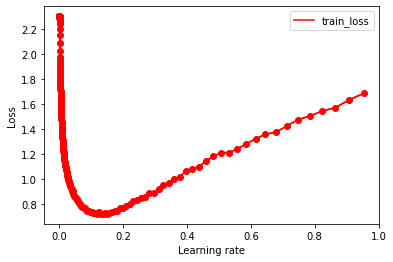

In [15]:
x1=[1e-5*(1.05**i) for i in range(NUM_EPOCHS)]
y1=train_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
plt.plot(x1,y1,'ro-')
# plt.title('Learning curve')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.legend()
plt.show()

I chose a learning rate of 0.1 and started training again(It is best to choose the learning rate when loss decreases fastest).

In [16]:
LOG_PATH="./train2.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn2.pth"
    
model = Net()
if AVAIL_GPUS:
    model = model.cuda()

BATCH_SIZE = 128
LEARNING_RATE = 0.1
NUM_EPOCHS = 100
print("Model: CNN from Pytorch tutorial")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: SGD")
print("Learning rate: %f" % (LEARNING_RATE))
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: SGD")
    f.write("\n")
    f.write("Learning rate: %d" % (LEARNING_RATE))
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: CNN from Pytorch tutorial
Batch size: 128
Epoch num: 100
Optimizer: SGD
Learning rate: 0.100000
---------- Training Epoch #0 ----------


391it [00:03, 127.38it/s]

Finish 1 epoch, Train loss: 1.980456, Train acc@1: 0.270420


Test loss: 1.672527, Test acc@1: 0.404300
Saving Best model...			Top1 = 40.430000%
Elapsed time: 4.976109981536865
---------- Training Epoch #1 ----------


391it [00:03, 129.52it/s]


Finish 2 epoch, Train loss: 1.590838, Train acc@1: 0.422860
Test loss: 1.596282, Test acc@1: 0.418500
Saving Best model...			Top1 = 41.850000%
Elapsed time: 9.993536233901978
---------- Training Epoch #2 ----------


391it [00:03, 126.96it/s]

Finish 3 epoch, Train loss: 1.440733, Train acc@1: 0.480440


Test loss: 1.478337, Test acc@1: 0.470800
Saving Best model...			Top1 = 47.080000%
Elapsed time: 15.083720445632935
---------- Training Epoch #3 ----------


391it [00:03, 125.74it/s]

Finish 4 epoch, Train loss: 1.348379, Train acc@1: 0.520140


Test loss: 1.392090, Test acc@1: 0.513400
Saving Best model...			Top1 = 51.340000%
Elapsed time: 20.223025798797607
---------- Training Epoch #4 ----------


391it [00:03, 119.28it/s]

Finish 5 epoch, Train loss: 1.267800, Train acc@1: 0.548520


Test loss: 1.318974, Test acc@1: 0.525000
Saving Best model...			Top1 = 52.500000%
Elapsed time: 25.53861951828003
---------- Training Epoch #5 ----------


391it [00:03, 124.47it/s]

Finish 6 epoch, Train loss: 1.206198, Train acc@1: 0.569700


Test loss: 1.276199, Test acc@1: 0.553300
Saving Best model...			Top1 = 55.330000%
Elapsed time: 30.806347370147705
---------- Training Epoch #6 ----------


391it [00:03, 126.59it/s]

Finish 7 epoch, Train loss: 1.140999, Train acc@1: 0.594720


Test loss: 1.190934, Test acc@1: 0.576700
Saving Best model...			Top1 = 57.670000%
Elapsed time: 35.87980365753174
---------- Training Epoch #7 ----------


391it [00:03, 125.94it/s]

Finish 8 epoch, Train loss: 1.095046, Train acc@1: 0.611560


Test loss: 1.179704, Test acc@1: 0.586600
Saving Best model...			Top1 = 58.660000%
Elapsed time: 40.96591114997864
---------- Training Epoch #8 ----------


391it [00:03, 125.02it/s]

Finish 9 epoch, Train loss: 1.048109, Train acc@1: 0.629260


Test loss: 1.204209, Test acc@1: 0.577600
Elapsed time: 46.1016058921814
---------- Training Epoch #9 ----------


391it [00:03, 127.86it/s]

Finish 10 epoch, Train loss: 1.004225, Train acc@1: 0.644880


Test loss: 1.174117, Test acc@1: 0.591700
Saving Best model...			Top1 = 59.170000%
Elapsed time: 51.16603708267212
---------- Training Epoch #10 ----------


391it [00:03, 127.71it/s]

Finish 11 epoch, Train loss: 0.966536, Train acc@1: 0.656740


Test loss: 1.134191, Test acc@1: 0.613000
Saving Best model...			Top1 = 61.300000%
Elapsed time: 56.23769164085388
---------- Training Epoch #11 ----------


391it [00:03, 123.67it/s]

Finish 12 epoch, Train loss: 0.926838, Train acc@1: 0.671740


Test loss: 1.185312, Test acc@1: 0.599000
Elapsed time: 61.36680722236633
---------- Training Epoch #12 ----------


391it [00:03, 124.49it/s]

Finish 13 epoch, Train loss: 0.890546, Train acc@1: 0.685300


Test loss: 1.166308, Test acc@1: 0.600100
Elapsed time: 66.53403663635254
---------- Training Epoch #13 ----------


391it [00:03, 123.47it/s]

Finish 14 epoch, Train loss: 0.858740, Train acc@1: 0.695960


Test loss: 1.167207, Test acc@1: 0.604600
Elapsed time: 71.65331315994263
---------- Training Epoch #14 ----------


391it [00:03, 125.28it/s]

Finish 15 epoch, Train loss: 0.823796, Train acc@1: 0.708040


Test loss: 1.162837, Test acc@1: 0.609200
Elapsed time: 76.75841927528381
---------- Training Epoch #15 ----------


391it [00:03, 126.77it/s]

Finish 16 epoch, Train loss: 0.799113, Train acc@1: 0.717160


Test loss: 1.181746, Test acc@1: 0.613800
Saving Best model...			Top1 = 61.380000%
Elapsed time: 81.81041264533997
---------- Training Epoch #16 ----------


391it [00:03, 121.77it/s]

Finish 17 epoch, Train loss: 0.773946, Train acc@1: 0.726420


Test loss: 1.346504, Test acc@1: 0.582000
Elapsed time: 87.0143210887909
---------- Training Epoch #17 ----------


391it [00:03, 125.26it/s]

Finish 18 epoch, Train loss: 0.745140, Train acc@1: 0.735540


Test loss: 1.253066, Test acc@1: 0.602100
Elapsed time: 92.1592230796814
---------- Training Epoch #18 ----------


391it [00:03, 121.53it/s]

Finish 19 epoch, Train loss: 0.724129, Train acc@1: 0.741140


Test loss: 1.326805, Test acc@1: 0.584900
Elapsed time: 97.32968759536743
---------- Training Epoch #19 ----------


391it [00:03, 125.45it/s]

Finish 20 epoch, Train loss: 0.697722, Train acc@1: 0.751440


Test loss: 1.301024, Test acc@1: 0.601500
Elapsed time: 102.37739205360413
---------- Training Epoch #20 ----------


391it [00:03, 124.19it/s]

Finish 21 epoch, Train loss: 0.677724, Train acc@1: 0.759200


Test loss: 1.279171, Test acc@1: 0.616200
Saving Best model...			Top1 = 61.620000%
Elapsed time: 107.53536701202393
---------- Training Epoch #21 ----------


391it [00:03, 126.72it/s]

Finish 22 epoch, Train loss: 0.653427, Train acc@1: 0.764040


Test loss: 1.417138, Test acc@1: 0.587200
Elapsed time: 112.63200259208679
---------- Training Epoch #22 ----------


391it [00:03, 124.90it/s]

Finish 23 epoch, Train loss: 0.638793, Train acc@1: 0.770600


Test loss: 1.454131, Test acc@1: 0.577800
Elapsed time: 117.77250242233276
---------- Training Epoch #23 ----------


391it [00:03, 121.10it/s]

Finish 24 epoch, Train loss: 0.615208, Train acc@1: 0.778440


Test loss: 1.389427, Test acc@1: 0.601600
Elapsed time: 122.95014190673828
---------- Training Epoch #24 ----------


391it [00:03, 125.93it/s]

Finish 25 epoch, Train loss: 0.602737, Train acc@1: 0.784860


Test loss: 1.363427, Test acc@1: 0.604500
Elapsed time: 128.06953740119934
---------- Training Epoch #25 ----------


391it [00:03, 124.28it/s]

Finish 26 epoch, Train loss: 0.577470, Train acc@1: 0.792460


Test loss: 1.390560, Test acc@1: 0.609900
Elapsed time: 133.18465924263
---------- Training Epoch #26 ----------


391it [00:03, 129.13it/s]

Finish 27 epoch, Train loss: 0.566279, Train acc@1: 0.795600


Test loss: 1.476159, Test acc@1: 0.597700
Elapsed time: 138.28455090522766
---------- Training Epoch #27 ----------


391it [00:03, 125.39it/s]

Finish 28 epoch, Train loss: 0.552329, Train acc@1: 0.801300


Test loss: 1.543323, Test acc@1: 0.595400
Elapsed time: 143.35363864898682
---------- Training Epoch #28 ----------


391it [00:03, 126.42it/s]


Finish 29 epoch, Train loss: 0.539564, Train acc@1: 0.806720
Test loss: 1.493371, Test acc@1: 0.597200
Elapsed time: 148.34594702720642
---------- Training Epoch #29 ----------


391it [00:03, 122.14it/s]

Finish 30 epoch, Train loss: 0.524265, Train acc@1: 0.809780


Test loss: 1.680182, Test acc@1: 0.580700
Elapsed time: 153.50300431251526
---------- Training Epoch #30 ----------


391it [00:03, 124.99it/s]

Finish 31 epoch, Train loss: 0.505525, Train acc@1: 0.817160


Test loss: 1.643457, Test acc@1: 0.588200
Elapsed time: 158.64865374565125
---------- Training Epoch #31 ----------


391it [00:03, 124.21it/s]

Finish 32 epoch, Train loss: 0.498742, Train acc@1: 0.819900


Test loss: 1.616983, Test acc@1: 0.586400
Elapsed time: 163.7011594772339
---------- Training Epoch #32 ----------


391it [00:03, 124.87it/s]

Finish 33 epoch, Train loss: 0.489509, Train acc@1: 0.823600


Test loss: 1.787901, Test acc@1: 0.576400
Elapsed time: 168.89468002319336
---------- Training Epoch #33 ----------


391it [00:03, 126.59it/s]

Finish 34 epoch, Train loss: 0.477231, Train acc@1: 0.828380


Test loss: 1.670711, Test acc@1: 0.598700
Elapsed time: 174.0404155254364
---------- Training Epoch #34 ----------


391it [00:03, 123.84it/s]

Finish 35 epoch, Train loss: 0.467213, Train acc@1: 0.831600


Test loss: 1.721254, Test acc@1: 0.591700
Elapsed time: 179.25313782691956
---------- Training Epoch #35 ----------


391it [00:03, 124.68it/s]

Finish 36 epoch, Train loss: 0.457814, Train acc@1: 0.834880


Test loss: 1.788227, Test acc@1: 0.587000
Elapsed time: 184.34557390213013
---------- Training Epoch #36 ----------


391it [00:03, 129.17it/s]

Finish 37 epoch, Train loss: 0.442974, Train acc@1: 0.841020


Test loss: 1.943325, Test acc@1: 0.567400
Elapsed time: 189.34794664382935
---------- Training Epoch #37 ----------


391it [00:03, 121.80it/s]

Finish 38 epoch, Train loss: 0.441862, Train acc@1: 0.840660


Test loss: 1.822278, Test acc@1: 0.594800
Elapsed time: 194.53145790100098
---------- Training Epoch #38 ----------


391it [00:03, 124.76it/s]

Finish 39 epoch, Train loss: 0.428162, Train acc@1: 0.844660


Test loss: 1.985284, Test acc@1: 0.575400
Elapsed time: 199.63803100585938
---------- Training Epoch #39 ----------


391it [00:03, 121.81it/s]

Finish 40 epoch, Train loss: 0.415052, Train acc@1: 0.849500


Test loss: 2.006453, Test acc@1: 0.579800
Elapsed time: 204.84270405769348
---------- Training Epoch #40 ----------


391it [00:03, 126.59it/s]

Finish 41 epoch, Train loss: 0.418505, Train acc@1: 0.850080


Test loss: 1.928541, Test acc@1: 0.575000
Elapsed time: 209.88832998275757
---------- Training Epoch #41 ----------


391it [00:03, 121.68it/s]

Finish 42 epoch, Train loss: 0.422060, Train acc@1: 0.848000


Test loss: 1.922521, Test acc@1: 0.582400
Elapsed time: 215.10287380218506
---------- Training Epoch #42 ----------


391it [00:03, 125.51it/s]

Finish 43 epoch, Train loss: 0.396078, Train acc@1: 0.856420


Test loss: 1.974669, Test acc@1: 0.584200
Elapsed time: 220.21126222610474
---------- Training Epoch #43 ----------


391it [00:03, 122.91it/s]

Finish 44 epoch, Train loss: 0.383407, Train acc@1: 0.862440


Test loss: 2.017695, Test acc@1: 0.591300
Elapsed time: 225.4463975429535
---------- Training Epoch #44 ----------


391it [00:03, 129.02it/s]

Finish 45 epoch, Train loss: 0.397499, Train acc@1: 0.856500


Test loss: 2.035714, Test acc@1: 0.591200
Elapsed time: 230.4174928665161
---------- Training Epoch #45 ----------


391it [00:03, 128.02it/s]

Finish 46 epoch, Train loss: 0.392143, Train acc@1: 0.858880


Test loss: 2.070607, Test acc@1: 0.584900
Elapsed time: 235.5314438343048
---------- Training Epoch #46 ----------


391it [00:03, 129.17it/s]

Finish 47 epoch, Train loss: 0.366450, Train acc@1: 0.868380


Test loss: 2.212939, Test acc@1: 0.583200
Elapsed time: 240.57143568992615
---------- Training Epoch #47 ----------


391it [00:03, 125.44it/s]

Finish 48 epoch, Train loss: 0.374174, Train acc@1: 0.865460


Test loss: 2.145142, Test acc@1: 0.588000
Elapsed time: 245.6962926387787
---------- Training Epoch #48 ----------


391it [00:03, 125.32it/s]

Finish 49 epoch, Train loss: 0.360476, Train acc@1: 0.871100


Test loss: 2.210912, Test acc@1: 0.579400
Elapsed time: 250.8265678882599
---------- Training Epoch #49 ----------


391it [00:03, 129.72it/s]

Finish 50 epoch, Train loss: 0.364335, Train acc@1: 0.870540


Test loss: 2.646924, Test acc@1: 0.534000
Elapsed time: 255.91040682792664
---------- Training Epoch #50 ----------


391it [00:03, 122.87it/s]

Finish 51 epoch, Train loss: 0.369385, Train acc@1: 0.869040


Test loss: 2.153706, Test acc@1: 0.584200
Elapsed time: 261.1949055194855
---------- Training Epoch #51 ----------


391it [00:03, 124.95it/s]

Finish 52 epoch, Train loss: 0.351075, Train acc@1: 0.875400


Test loss: 2.276337, Test acc@1: 0.569400
Elapsed time: 266.3341865539551
---------- Training Epoch #52 ----------


391it [00:03, 129.02it/s]

Finish 53 epoch, Train loss: 0.356484, Train acc@1: 0.872740


Test loss: 2.455436, Test acc@1: 0.565300
Elapsed time: 271.4405963420868
---------- Training Epoch #53 ----------


391it [00:03, 128.36it/s]

Finish 54 epoch, Train loss: 0.350907, Train acc@1: 0.875780


Test loss: 2.350197, Test acc@1: 0.575900
Elapsed time: 276.5497531890869
---------- Training Epoch #54 ----------


391it [00:03, 127.15it/s]

Finish 55 epoch, Train loss: 0.337045, Train acc@1: 0.879520


Test loss: 2.583252, Test acc@1: 0.560200
Elapsed time: 281.5314357280731
---------- Training Epoch #55 ----------


391it [00:03, 124.20it/s]

Finish 56 epoch, Train loss: 0.336373, Train acc@1: 0.880880


Test loss: 2.548813, Test acc@1: 0.575000
Elapsed time: 286.6809687614441
---------- Training Epoch #56 ----------


391it [00:03, 123.70it/s]

Finish 57 epoch, Train loss: 0.334658, Train acc@1: 0.880220


Test loss: 2.591175, Test acc@1: 0.570200
Elapsed time: 291.9338068962097
---------- Training Epoch #57 ----------


391it [00:03, 120.64it/s]

Finish 58 epoch, Train loss: 0.324928, Train acc@1: 0.885600


Test loss: 2.575598, Test acc@1: 0.565600
Elapsed time: 297.1770098209381
---------- Training Epoch #58 ----------


391it [00:03, 123.54it/s]

Finish 59 epoch, Train loss: 0.333348, Train acc@1: 0.883900


Test loss: 2.489115, Test acc@1: 0.576500
Elapsed time: 302.27583479881287
---------- Training Epoch #59 ----------


391it [00:03, 126.67it/s]

Finish 60 epoch, Train loss: 0.312927, Train acc@1: 0.888160


Test loss: 2.546810, Test acc@1: 0.577800
Elapsed time: 307.3121783733368
---------- Training Epoch #60 ----------


391it [00:03, 124.35it/s]

Finish 61 epoch, Train loss: 0.323772, Train acc@1: 0.884520


Test loss: 2.574468, Test acc@1: 0.573700
Elapsed time: 312.49270701408386
---------- Training Epoch #61 ----------


391it [00:03, 126.01it/s]

Finish 62 epoch, Train loss: 0.315953, Train acc@1: 0.887880


Test loss: 2.581725, Test acc@1: 0.578300
Elapsed time: 317.59311389923096
---------- Training Epoch #62 ----------


391it [00:03, 122.92it/s]

Finish 63 epoch, Train loss: 0.311305, Train acc@1: 0.888660


Test loss: 2.738041, Test acc@1: 0.568600
Elapsed time: 322.80435514450073
---------- Training Epoch #63 ----------


391it [00:03, 125.78it/s]

Finish 64 epoch, Train loss: 0.331996, Train acc@1: 0.883880


Test loss: 2.581254, Test acc@1: 0.578800
Elapsed time: 327.90242052078247
---------- Training Epoch #64 ----------


391it [00:03, 121.41it/s]

Finish 65 epoch, Train loss: 0.305238, Train acc@1: 0.892960


Test loss: 3.208384, Test acc@1: 0.542200
Elapsed time: 333.1296133995056
---------- Training Epoch #65 ----------


391it [00:03, 120.48it/s]

Finish 66 epoch, Train loss: 0.318547, Train acc@1: 0.887880


Test loss: 2.754009, Test acc@1: 0.569600
Elapsed time: 338.4604694843292
---------- Training Epoch #66 ----------


391it [00:03, 119.55it/s]

Finish 67 epoch, Train loss: 0.326971, Train acc@1: 0.888420


Test loss: 2.717986, Test acc@1: 0.560000
Elapsed time: 343.81066703796387
---------- Training Epoch #67 ----------


391it [00:03, 129.38it/s]

Finish 68 epoch, Train loss: 0.304640, Train acc@1: 0.891760


Test loss: 2.714657, Test acc@1: 0.569300
Elapsed time: 348.8191328048706
---------- Training Epoch #68 ----------


391it [00:03, 126.20it/s]

Finish 69 epoch, Train loss: 0.302807, Train acc@1: 0.895040


Test loss: 2.973196, Test acc@1: 0.551100
Elapsed time: 353.83433771133423
---------- Training Epoch #69 ----------


391it [00:03, 127.16it/s]

Finish 70 epoch, Train loss: 0.297073, Train acc@1: 0.897040


Test loss: 2.807668, Test acc@1: 0.578000
Elapsed time: 358.8950047492981
---------- Training Epoch #70 ----------


391it [00:03, 123.61it/s]

Finish 71 epoch, Train loss: 0.308829, Train acc@1: 0.893600


Test loss: 2.735524, Test acc@1: 0.572200
Elapsed time: 364.05314087867737
---------- Training Epoch #71 ----------


391it [00:03, 124.47it/s]

Finish 72 epoch, Train loss: 0.312692, Train acc@1: 0.892940


Test loss: 2.776797, Test acc@1: 0.559700
Elapsed time: 369.1036615371704
---------- Training Epoch #72 ----------


391it [00:03, 125.72it/s]

Finish 73 epoch, Train loss: 0.288230, Train acc@1: 0.900120


Test loss: 2.893699, Test acc@1: 0.560400
Elapsed time: 374.24729013442993
---------- Training Epoch #73 ----------


391it [00:03, 125.46it/s]

Finish 74 epoch, Train loss: 0.295402, Train acc@1: 0.896160


Test loss: 3.063414, Test acc@1: 0.548700
Elapsed time: 379.3552918434143
---------- Training Epoch #74 ----------


391it [00:03, 124.94it/s]

Finish 75 epoch, Train loss: 0.291437, Train acc@1: 0.898320


Test loss: 3.065610, Test acc@1: 0.564300
Elapsed time: 384.4310019016266
---------- Training Epoch #75 ----------


391it [00:03, 125.57it/s]

Finish 76 epoch, Train loss: 0.294851, Train acc@1: 0.898000


Test loss: 3.037070, Test acc@1: 0.562900
Elapsed time: 389.5701937675476
---------- Training Epoch #76 ----------


391it [00:03, 121.64it/s]

Finish 77 epoch, Train loss: 0.287719, Train acc@1: 0.898580


Test loss: 2.983529, Test acc@1: 0.562500
Elapsed time: 394.68212604522705
---------- Training Epoch #77 ----------


391it [00:03, 124.24it/s]

Finish 78 epoch, Train loss: 0.285731, Train acc@1: 0.902340


Test loss: 3.661074, Test acc@1: 0.519000
Elapsed time: 399.7796127796173
---------- Training Epoch #78 ----------


391it [00:03, 121.65it/s]

Finish 79 epoch, Train loss: 0.304945, Train acc@1: 0.894120


Test loss: 3.014991, Test acc@1: 0.573500
Elapsed time: 404.9646406173706
---------- Training Epoch #79 ----------


391it [00:03, 126.02it/s]

Finish 80 epoch, Train loss: 0.288968, Train acc@1: 0.901460


Test loss: 3.035581, Test acc@1: 0.567600
Elapsed time: 410.06642174720764
---------- Training Epoch #80 ----------


391it [00:03, 126.44it/s]

Finish 81 epoch, Train loss: 0.285253, Train acc@1: 0.901040


Test loss: 3.034255, Test acc@1: 0.562200
Elapsed time: 415.1473021507263
---------- Training Epoch #81 ----------


391it [00:03, 123.56it/s]

Finish 82 epoch, Train loss: 0.260271, Train acc@1: 0.911440


Test loss: 3.344704, Test acc@1: 0.555900
Elapsed time: 420.3766748905182
---------- Training Epoch #82 ----------


391it [00:03, 121.44it/s]

Finish 83 epoch, Train loss: 0.290469, Train acc@1: 0.902580


Test loss: 3.367008, Test acc@1: 0.561800
Elapsed time: 425.6266620159149
---------- Training Epoch #83 ----------


391it [00:03, 123.69it/s]

Finish 84 epoch, Train loss: 0.288139, Train acc@1: 0.902420


Test loss: 3.123905, Test acc@1: 0.563000
Elapsed time: 430.8155221939087
---------- Training Epoch #84 ----------


391it [00:03, 128.87it/s]

Finish 85 epoch, Train loss: 0.296137, Train acc@1: 0.899220


Test loss: 3.193474, Test acc@1: 0.559400
Elapsed time: 435.9049220085144
---------- Training Epoch #85 ----------


391it [00:03, 126.35it/s]

Finish 86 epoch, Train loss: 0.273285, Train acc@1: 0.905800


Test loss: 3.171731, Test acc@1: 0.569700
Elapsed time: 441.0556402206421
---------- Training Epoch #86 ----------


391it [00:03, 127.85it/s]

Finish 87 epoch, Train loss: 0.266201, Train acc@1: 0.908560


Test loss: 3.293506, Test acc@1: 0.557100
Elapsed time: 446.1004288196564
---------- Training Epoch #87 ----------


391it [00:03, 127.60it/s]

Finish 88 epoch, Train loss: 0.318586, Train acc@1: 0.893920


Test loss: 3.339327, Test acc@1: 0.555100
Elapsed time: 451.2336776256561
---------- Training Epoch #88 ----------


391it [00:03, 125.47it/s]

Finish 89 epoch, Train loss: 0.270170, Train acc@1: 0.908400


Test loss: 3.270277, Test acc@1: 0.546600
Elapsed time: 456.412437915802
---------- Training Epoch #89 ----------


391it [00:03, 124.07it/s]

Finish 90 epoch, Train loss: 0.292633, Train acc@1: 0.901580


Test loss: 3.370537, Test acc@1: 0.555300
Elapsed time: 461.573002576828
---------- Training Epoch #90 ----------


391it [00:03, 123.82it/s]

Finish 91 epoch, Train loss: 0.278608, Train acc@1: 0.904880


Test loss: 3.301104, Test acc@1: 0.569300
Elapsed time: 466.6819076538086
---------- Training Epoch #91 ----------


391it [00:03, 122.29it/s]

Finish 92 epoch, Train loss: 0.265021, Train acc@1: 0.909980


Test loss: 3.660535, Test acc@1: 0.557500
Elapsed time: 471.8469479084015
---------- Training Epoch #92 ----------


391it [00:03, 119.45it/s]


Finish 93 epoch, Train loss: 0.285835, Train acc@1: 0.904080
Test loss: 3.471775, Test acc@1: 0.550300
Elapsed time: 477.1247351169586
---------- Training Epoch #93 ----------


391it [00:03, 122.35it/s]

Finish 94 epoch, Train loss: 0.277345, Train acc@1: 0.907560


Test loss: 3.337913, Test acc@1: 0.564500
Elapsed time: 482.27960181236267
---------- Training Epoch #94 ----------


391it [00:03, 128.59it/s]

Finish 95 epoch, Train loss: 0.265883, Train acc@1: 0.912020


Test loss: 3.235106, Test acc@1: 0.562400
Elapsed time: 487.31259512901306
---------- Training Epoch #95 ----------


391it [00:03, 120.41it/s]

Finish 96 epoch, Train loss: 0.251742, Train acc@1: 0.915460


Test loss: 3.376423, Test acc@1: 0.572000
Elapsed time: 492.5483229160309
---------- Training Epoch #96 ----------


391it [00:03, 124.81it/s]

Finish 97 epoch, Train loss: 0.284863, Train acc@1: 0.907180


Test loss: 3.391109, Test acc@1: 0.563100
Elapsed time: 497.6882474422455
---------- Training Epoch #97 ----------


391it [00:03, 126.57it/s]

Finish 98 epoch, Train loss: 0.286687, Train acc@1: 0.905180


Test loss: 3.409593, Test acc@1: 0.563800
Elapsed time: 502.75671315193176
---------- Training Epoch #98 ----------


391it [00:03, 126.54it/s]

Finish 99 epoch, Train loss: 0.295225, Train acc@1: 0.902540


Test loss: 3.384875, Test acc@1: 0.562300
Elapsed time: 507.8928220272064
---------- Training Epoch #99 ----------


391it [00:03, 122.32it/s]

Finish 100 epoch, Train loss: 0.286854, Train acc@1: 0.903680


Test loss: 3.544568, Test acc@1: 0.557300
Elapsed time: 513.0350787639618

Test results: Acc@1 = 61.620000%


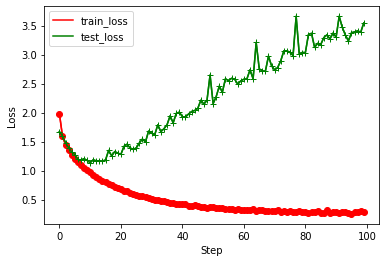

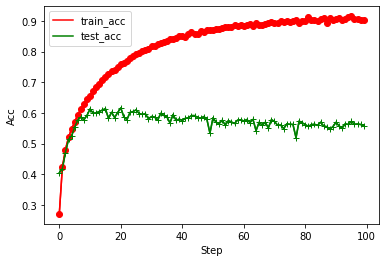

In [17]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

We can see that convergence is much faster, about 20 steps to get to the optimal value.

### 2. Momentum and weight decay
Momentum can accelerate convergence in gradient descent, and weight decay is L2 regularization, which reduces the problem of model over-fitting to some extent.

In [18]:
LOG_PATH="./train3.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn3.pth"
    
model = Net()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 100
LEARNING_RATE = 0.1
print("Model: CNN from Pytorch tutorial")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: SGD")
print("Learning rate: %f" % (LEARNING_RATE))
print("Momentum: %f" % (0.9))
print("Weight decay: %f" % (5e-4))
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: SGD")
    f.write("\n")
    f.write("Learning rate: %f" % (LEARNING_RATE))
    f.write("\n")
    f.write("Momentum: %f" % (0.9))
    f.write("\n")
    f.write("Weight decay: %f" % (5e-4))
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: CNN from Pytorch tutorial
Batch size: 128
Epoch num: 100
Optimizer: SGD
Learning rate: 0.100000
Momentum: 0.900000
Weight decay: 0.000500
---------- Training Epoch #0 ----------


391it [00:03, 122.06it/s]

Finish 1 epoch, Train loss: 1.745441, Train acc@1: 0.353620


Test loss: 1.516952, Test acc@1: 0.447400
Saving Best model...			Top1 = 44.740000%
Elapsed time: 5.200493097305298
---------- Training Epoch #1 ----------


391it [00:03, 122.21it/s]

Finish 2 epoch, Train loss: 1.463321, Train acc@1: 0.474060


Test loss: 1.428905, Test acc@1: 0.495800
Saving Best model...			Top1 = 49.580000%
Elapsed time: 10.380454778671265
---------- Training Epoch #2 ----------


391it [00:03, 124.27it/s]

Finish 3 epoch, Train loss: 1.380237, Train acc@1: 0.511840


Test loss: 1.349129, Test acc@1: 0.535200
Saving Best model...			Top1 = 53.520000%
Elapsed time: 15.516757249832153
---------- Training Epoch #3 ----------


391it [00:03, 121.82it/s]

Finish 4 epoch, Train loss: 1.330848, Train acc@1: 0.532920


Test loss: 1.303965, Test acc@1: 0.543000
Saving Best model...			Top1 = 54.300000%
Elapsed time: 20.706133127212524
---------- Training Epoch #4 ----------


391it [00:03, 122.41it/s]

Finish 5 epoch, Train loss: 1.278963, Train acc@1: 0.556280


Test loss: 1.291565, Test acc@1: 0.549000
Saving Best model...			Top1 = 54.900000%
Elapsed time: 25.885186195373535
---------- Training Epoch #5 ----------


391it [00:03, 121.26it/s]

Finish 6 epoch, Train loss: 1.252328, Train acc@1: 0.565940


Test loss: 1.317690, Test acc@1: 0.533200
Elapsed time: 31.171588897705078
---------- Training Epoch #6 ----------


391it [00:03, 118.33it/s]

Finish 7 epoch, Train loss: 1.239829, Train acc@1: 0.570180


Test loss: 1.306894, Test acc@1: 0.544600
Elapsed time: 36.52243494987488
---------- Training Epoch #7 ----------


391it [00:03, 119.88it/s]

Finish 8 epoch, Train loss: 1.203733, Train acc@1: 0.583800


Test loss: 1.267947, Test acc@1: 0.560200
Saving Best model...			Top1 = 56.020000%
Elapsed time: 41.73039960861206
---------- Training Epoch #8 ----------


391it [00:03, 124.39it/s]

Finish 9 epoch, Train loss: 1.211553, Train acc@1: 0.582900


Test loss: 1.431987, Test acc@1: 0.521400
Elapsed time: 46.8840606212616
---------- Training Epoch #9 ----------


391it [00:03, 122.22it/s]

Finish 10 epoch, Train loss: 1.194829, Train acc@1: 0.591760


Test loss: 1.287824, Test acc@1: 0.563700
Saving Best model...			Top1 = 56.370000%
Elapsed time: 52.02579593658447
---------- Training Epoch #10 ----------


391it [00:03, 122.41it/s]

Finish 11 epoch, Train loss: 1.168767, Train acc@1: 0.598020


Test loss: 1.265149, Test acc@1: 0.560600
Elapsed time: 57.18450713157654
---------- Training Epoch #11 ----------


391it [00:03, 119.89it/s]

Finish 12 epoch, Train loss: 1.157885, Train acc@1: 0.603520


Test loss: 1.310765, Test acc@1: 0.562400
Elapsed time: 62.43890976905823
---------- Training Epoch #12 ----------


391it [00:03, 125.31it/s]

Finish 13 epoch, Train loss: 1.147223, Train acc@1: 0.605360


Test loss: 1.286241, Test acc@1: 0.552900
Elapsed time: 67.56992602348328
---------- Training Epoch #13 ----------


391it [00:03, 120.57it/s]

Finish 14 epoch, Train loss: 1.141683, Train acc@1: 0.609560


Test loss: 1.402296, Test acc@1: 0.530100
Elapsed time: 72.90113615989685
---------- Training Epoch #14 ----------


391it [00:03, 124.49it/s]

Finish 15 epoch, Train loss: 1.132975, Train acc@1: 0.610120


Test loss: 1.239289, Test acc@1: 0.580400
Saving Best model...			Top1 = 58.040000%
Elapsed time: 78.06516766548157
---------- Training Epoch #15 ----------


391it [00:03, 127.35it/s]

Finish 16 epoch, Train loss: 1.128122, Train acc@1: 0.612520


Test loss: 1.229364, Test acc@1: 0.596000
Saving Best model...			Top1 = 59.600000%
Elapsed time: 83.16855788230896
---------- Training Epoch #16 ----------


391it [00:03, 122.18it/s]

Finish 17 epoch, Train loss: 1.146059, Train acc@1: 0.607280


Test loss: 1.304216, Test acc@1: 0.565100
Elapsed time: 88.36254954338074
---------- Training Epoch #17 ----------


391it [00:03, 122.28it/s]

Finish 18 epoch, Train loss: 1.136473, Train acc@1: 0.609300


Test loss: 1.243112, Test acc@1: 0.574200
Elapsed time: 93.48651885986328
---------- Training Epoch #18 ----------


391it [00:03, 126.24it/s]

Finish 19 epoch, Train loss: 1.128970, Train acc@1: 0.614100


Test loss: 1.302431, Test acc@1: 0.563800
Elapsed time: 98.55359554290771
---------- Training Epoch #19 ----------


391it [00:03, 124.46it/s]

Finish 20 epoch, Train loss: 1.145591, Train acc@1: 0.608420


Test loss: 1.263231, Test acc@1: 0.574600
Elapsed time: 103.77817487716675
---------- Training Epoch #20 ----------


391it [00:03, 124.19it/s]

Finish 21 epoch, Train loss: 1.126083, Train acc@1: 0.613320


Test loss: 1.219841, Test acc@1: 0.579900
Elapsed time: 108.86299514770508
---------- Training Epoch #21 ----------


391it [00:03, 118.47it/s]

Finish 22 epoch, Train loss: 1.121521, Train acc@1: 0.620280


Test loss: 1.222206, Test acc@1: 0.586700
Elapsed time: 114.14836812019348
---------- Training Epoch #22 ----------


391it [00:03, 125.27it/s]

Finish 23 epoch, Train loss: 1.109335, Train acc@1: 0.622680


Test loss: 1.256165, Test acc@1: 0.584700
Elapsed time: 119.29239988327026
---------- Training Epoch #23 ----------


391it [00:03, 124.71it/s]

Finish 24 epoch, Train loss: 1.127000, Train acc@1: 0.612440


Test loss: 1.219291, Test acc@1: 0.589900
Elapsed time: 124.31204223632812
---------- Training Epoch #24 ----------


391it [00:03, 122.91it/s]

Finish 25 epoch, Train loss: 1.100204, Train acc@1: 0.625040


Test loss: 1.239555, Test acc@1: 0.582300
Elapsed time: 129.42717146873474
---------- Training Epoch #25 ----------


391it [00:03, 121.49it/s]

Finish 26 epoch, Train loss: 1.120814, Train acc@1: 0.616260


Test loss: 1.292911, Test acc@1: 0.563200
Elapsed time: 134.65054559707642
---------- Training Epoch #26 ----------


391it [00:03, 126.15it/s]

Finish 27 epoch, Train loss: 1.120298, Train acc@1: 0.620500


Test loss: 1.298672, Test acc@1: 0.567300
Elapsed time: 139.69448256492615
---------- Training Epoch #27 ----------


391it [00:03, 125.03it/s]

Finish 28 epoch, Train loss: 1.093303, Train acc@1: 0.630300


Test loss: 1.271696, Test acc@1: 0.587700
Elapsed time: 144.7890419960022
---------- Training Epoch #28 ----------


391it [00:03, 123.28it/s]

Finish 29 epoch, Train loss: 1.088321, Train acc@1: 0.625320


Test loss: 1.164430, Test acc@1: 0.606500
Saving Best model...			Top1 = 60.650000%
Elapsed time: 149.91243314743042
---------- Training Epoch #29 ----------


391it [00:03, 123.89it/s]

Finish 30 epoch, Train loss: 1.094732, Train acc@1: 0.629740


Test loss: 1.218496, Test acc@1: 0.590900
Elapsed time: 155.02163076400757
---------- Training Epoch #30 ----------


391it [00:03, 121.29it/s]

Finish 31 epoch, Train loss: 1.094040, Train acc@1: 0.628540


Test loss: 1.248600, Test acc@1: 0.582300
Elapsed time: 160.2644226551056
---------- Training Epoch #31 ----------


391it [00:03, 117.21it/s]

Finish 32 epoch, Train loss: 1.102404, Train acc@1: 0.624660


Test loss: 1.258652, Test acc@1: 0.584700
Elapsed time: 165.55350613594055
---------- Training Epoch #32 ----------


391it [00:03, 122.92it/s]

Finish 33 epoch, Train loss: 1.102939, Train acc@1: 0.626420


Test loss: 1.268103, Test acc@1: 0.586200
Elapsed time: 170.6792254447937
---------- Training Epoch #33 ----------


391it [00:03, 124.28it/s]

Finish 34 epoch, Train loss: 1.110419, Train acc@1: 0.625060


Test loss: 1.246974, Test acc@1: 0.594000
Elapsed time: 175.75071740150452
---------- Training Epoch #34 ----------


391it [00:03, 124.24it/s]

Finish 35 epoch, Train loss: 1.106683, Train acc@1: 0.624600


Test loss: 1.215749, Test acc@1: 0.599800
Elapsed time: 180.83227968215942
---------- Training Epoch #35 ----------


391it [00:03, 125.61it/s]

Finish 36 epoch, Train loss: 1.077408, Train acc@1: 0.633980


Test loss: 1.254161, Test acc@1: 0.566200
Elapsed time: 185.91879987716675
---------- Training Epoch #36 ----------


391it [00:03, 122.19it/s]

Finish 37 epoch, Train loss: 1.070810, Train acc@1: 0.636620


Test loss: 1.213425, Test acc@1: 0.609300
Saving Best model...			Top1 = 60.930000%
Elapsed time: 191.12126660346985
---------- Training Epoch #37 ----------


391it [00:03, 121.04it/s]

Finish 38 epoch, Train loss: 1.084493, Train acc@1: 0.634100


Test loss: 1.274690, Test acc@1: 0.566400
Elapsed time: 196.34425497055054
---------- Training Epoch #38 ----------


391it [00:03, 123.77it/s]

Finish 39 epoch, Train loss: 1.094168, Train acc@1: 0.629440


Test loss: 1.304480, Test acc@1: 0.560000
Elapsed time: 201.42461133003235
---------- Training Epoch #39 ----------


391it [00:03, 124.79it/s]


Finish 40 epoch, Train loss: 1.082606, Train acc@1: 0.632880
Test loss: 1.234677, Test acc@1: 0.578200
Elapsed time: 206.535218000412
---------- Training Epoch #40 ----------


391it [00:03, 124.85it/s]

Finish 41 epoch, Train loss: 1.074038, Train acc@1: 0.637100


Test loss: 1.238382, Test acc@1: 0.583600
Elapsed time: 211.64511823654175
---------- Training Epoch #41 ----------


391it [00:03, 121.99it/s]

Finish 42 epoch, Train loss: 1.081875, Train acc@1: 0.633560


Test loss: 1.194311, Test acc@1: 0.599900
Elapsed time: 216.89032793045044
---------- Training Epoch #42 ----------


391it [00:03, 122.99it/s]

Finish 43 epoch, Train loss: 1.089198, Train acc@1: 0.633780


Test loss: 1.212602, Test acc@1: 0.598900
Elapsed time: 222.20897340774536
---------- Training Epoch #43 ----------


391it [00:03, 124.13it/s]

Finish 44 epoch, Train loss: 1.096688, Train acc@1: 0.629720


Test loss: 1.271893, Test acc@1: 0.584800
Elapsed time: 227.3843445777893
---------- Training Epoch #44 ----------


391it [00:03, 128.57it/s]

Finish 45 epoch, Train loss: 1.083966, Train acc@1: 0.633580


Test loss: 1.255068, Test acc@1: 0.584000
Elapsed time: 232.4989743232727
---------- Training Epoch #45 ----------


391it [00:03, 124.19it/s]


Finish 46 epoch, Train loss: 1.083067, Train acc@1: 0.634440
Test loss: 1.246740, Test acc@1: 0.578700
Elapsed time: 237.68128037452698
---------- Training Epoch #46 ----------


391it [00:03, 125.54it/s]

Finish 47 epoch, Train loss: 1.079620, Train acc@1: 0.633920


Test loss: 1.247167, Test acc@1: 0.589700
Elapsed time: 242.87413954734802
---------- Training Epoch #47 ----------


391it [00:03, 125.92it/s]


Finish 48 epoch, Train loss: 1.089995, Train acc@1: 0.632560
Test loss: 1.222295, Test acc@1: 0.595400
Elapsed time: 248.00504064559937
---------- Training Epoch #48 ----------


391it [00:03, 120.97it/s]

Finish 49 epoch, Train loss: 1.073584, Train acc@1: 0.634640


Test loss: 1.237247, Test acc@1: 0.598400
Elapsed time: 253.27221512794495
---------- Training Epoch #49 ----------


391it [00:03, 123.22it/s]

Finish 50 epoch, Train loss: 1.081699, Train acc@1: 0.634080


Test loss: 1.190949, Test acc@1: 0.609800
Saving Best model...			Top1 = 60.980000%
Elapsed time: 258.3576776981354
---------- Training Epoch #50 ----------


391it [00:03, 122.27it/s]


Finish 51 epoch, Train loss: 1.065455, Train acc@1: 0.638760
Test loss: 1.249562, Test acc@1: 0.585200
Elapsed time: 263.588835477829
---------- Training Epoch #51 ----------


391it [00:03, 119.78it/s]

Finish 52 epoch, Train loss: 1.084367, Train acc@1: 0.632980


Test loss: 1.219184, Test acc@1: 0.596700
Elapsed time: 269.05163764953613
---------- Training Epoch #52 ----------


391it [00:03, 123.81it/s]

Finish 53 epoch, Train loss: 1.081124, Train acc@1: 0.633800


Test loss: 1.329661, Test acc@1: 0.569300
Elapsed time: 274.1862859725952
---------- Training Epoch #53 ----------


391it [00:03, 120.76it/s]

Finish 54 epoch, Train loss: 1.086673, Train acc@1: 0.632200


Test loss: 1.168646, Test acc@1: 0.614500
Saving Best model...			Top1 = 61.450000%
Elapsed time: 279.3764443397522
---------- Training Epoch #54 ----------


391it [00:03, 124.76it/s]

Finish 55 epoch, Train loss: 1.071457, Train acc@1: 0.636860


Test loss: 1.323869, Test acc@1: 0.572700
Elapsed time: 284.49603295326233
---------- Training Epoch #55 ----------


391it [00:03, 118.14it/s]

Finish 56 epoch, Train loss: 1.077010, Train acc@1: 0.637520


Test loss: 1.253265, Test acc@1: 0.583400
Elapsed time: 289.83798694610596
---------- Training Epoch #56 ----------


391it [00:03, 124.62it/s]

Finish 57 epoch, Train loss: 1.088767, Train acc@1: 0.634140


Test loss: 1.279052, Test acc@1: 0.562400
Elapsed time: 294.93425250053406
---------- Training Epoch #57 ----------


391it [00:03, 119.98it/s]

Finish 58 epoch, Train loss: 1.083238, Train acc@1: 0.632100


Test loss: 1.252025, Test acc@1: 0.583000
Elapsed time: 300.20620036125183
---------- Training Epoch #58 ----------


391it [00:03, 119.46it/s]

Finish 59 epoch, Train loss: 1.085466, Train acc@1: 0.633720


Test loss: 1.184263, Test acc@1: 0.610400
Elapsed time: 305.45483684539795
---------- Training Epoch #59 ----------


391it [00:03, 125.22it/s]

Finish 60 epoch, Train loss: 1.057582, Train acc@1: 0.642800


Test loss: 1.212274, Test acc@1: 0.592000
Elapsed time: 310.5789613723755
---------- Training Epoch #60 ----------


391it [00:03, 122.48it/s]

Finish 61 epoch, Train loss: 1.063948, Train acc@1: 0.639420


Test loss: 1.256722, Test acc@1: 0.588200
Elapsed time: 315.6797766685486
---------- Training Epoch #61 ----------


391it [00:03, 120.77it/s]

Finish 62 epoch, Train loss: 1.077733, Train acc@1: 0.635460


Test loss: 1.190177, Test acc@1: 0.603200
Elapsed time: 320.9483149051666
---------- Training Epoch #62 ----------


391it [00:03, 125.23it/s]

Finish 63 epoch, Train loss: 1.081081, Train acc@1: 0.635100


Test loss: 1.313420, Test acc@1: 0.567700
Elapsed time: 326.03658962249756
---------- Training Epoch #63 ----------


391it [00:03, 118.61it/s]

Finish 64 epoch, Train loss: 1.067396, Train acc@1: 0.636800


Test loss: 1.235911, Test acc@1: 0.593900
Elapsed time: 331.33133912086487
---------- Training Epoch #64 ----------


391it [00:03, 120.34it/s]

Finish 65 epoch, Train loss: 1.099262, Train acc@1: 0.629340


Test loss: 1.288928, Test acc@1: 0.572100
Elapsed time: 336.5360143184662
---------- Training Epoch #65 ----------


391it [00:03, 127.60it/s]

Finish 66 epoch, Train loss: 1.077690, Train acc@1: 0.635100


Test loss: 1.299613, Test acc@1: 0.576000
Elapsed time: 341.5647757053375
---------- Training Epoch #66 ----------


391it [00:03, 120.32it/s]

Finish 67 epoch, Train loss: 1.063099, Train acc@1: 0.641940


Test loss: 1.241604, Test acc@1: 0.583500
Elapsed time: 346.7945737838745
---------- Training Epoch #67 ----------


391it [00:03, 119.76it/s]

Finish 68 epoch, Train loss: 1.074937, Train acc@1: 0.636980


Test loss: 1.249838, Test acc@1: 0.580600
Elapsed time: 352.0796232223511
---------- Training Epoch #68 ----------


391it [00:03, 120.95it/s]

Finish 69 epoch, Train loss: 1.062761, Train acc@1: 0.639520


Test loss: 1.179619, Test acc@1: 0.604600
Elapsed time: 357.3257248401642
---------- Training Epoch #69 ----------


391it [00:03, 122.31it/s]

Finish 70 epoch, Train loss: 1.090179, Train acc@1: 0.631840


Test loss: 1.257370, Test acc@1: 0.582200
Elapsed time: 362.4930121898651
---------- Training Epoch #70 ----------


391it [00:03, 125.88it/s]

Finish 71 epoch, Train loss: 1.074442, Train acc@1: 0.637220


Test loss: 1.223336, Test acc@1: 0.597100
Elapsed time: 367.5909388065338
---------- Training Epoch #71 ----------


391it [00:03, 123.19it/s]

Finish 72 epoch, Train loss: 1.060635, Train acc@1: 0.640340


Test loss: 1.159690, Test acc@1: 0.609300
Elapsed time: 372.72505950927734
---------- Training Epoch #72 ----------


391it [00:03, 127.93it/s]

Finish 73 epoch, Train loss: 1.067491, Train acc@1: 0.639080


Test loss: 1.183010, Test acc@1: 0.609000
Elapsed time: 377.75647258758545
---------- Training Epoch #73 ----------


391it [00:03, 125.39it/s]

Finish 74 epoch, Train loss: 1.075252, Train acc@1: 0.637680


Test loss: 1.247810, Test acc@1: 0.587100
Elapsed time: 382.92712664604187
---------- Training Epoch #74 ----------


391it [00:03, 120.56it/s]

Finish 75 epoch, Train loss: 1.056083, Train acc@1: 0.643200


Test loss: 1.227767, Test acc@1: 0.593300
Elapsed time: 388.24568605422974
---------- Training Epoch #75 ----------


391it [00:03, 126.77it/s]

Finish 76 epoch, Train loss: 1.057317, Train acc@1: 0.645380


Test loss: 1.221463, Test acc@1: 0.597900
Elapsed time: 393.33323907852173
---------- Training Epoch #76 ----------


391it [00:03, 124.41it/s]

Finish 77 epoch, Train loss: 1.071787, Train acc@1: 0.638920


Test loss: 1.222821, Test acc@1: 0.591600
Elapsed time: 398.44926738739014
---------- Training Epoch #77 ----------


391it [00:03, 121.80it/s]

Finish 78 epoch, Train loss: 1.070040, Train acc@1: 0.637900


Test loss: 1.252132, Test acc@1: 0.583200
Elapsed time: 403.6351342201233
---------- Training Epoch #78 ----------


391it [00:03, 123.08it/s]

Finish 79 epoch, Train loss: 1.065917, Train acc@1: 0.641880


Test loss: 1.257296, Test acc@1: 0.574700
Elapsed time: 408.83533477783203
---------- Training Epoch #79 ----------


391it [00:03, 125.31it/s]

Finish 80 epoch, Train loss: 1.075789, Train acc@1: 0.635760


Test loss: 1.214888, Test acc@1: 0.601500
Elapsed time: 413.97803807258606
---------- Training Epoch #80 ----------


391it [00:03, 119.02it/s]

Finish 81 epoch, Train loss: 1.058136, Train acc@1: 0.642440


Test loss: 1.297583, Test acc@1: 0.581600
Elapsed time: 419.24259901046753
---------- Training Epoch #81 ----------


391it [00:03, 125.97it/s]

Finish 82 epoch, Train loss: 1.055728, Train acc@1: 0.643320


Test loss: 1.280393, Test acc@1: 0.573900
Elapsed time: 424.3207848072052
---------- Training Epoch #82 ----------


391it [00:03, 119.13it/s]

Finish 83 epoch, Train loss: 1.063801, Train acc@1: 0.641880


Test loss: 1.255380, Test acc@1: 0.586500
Elapsed time: 429.53009819984436
---------- Training Epoch #83 ----------


391it [00:03, 124.11it/s]

Finish 84 epoch, Train loss: 1.061470, Train acc@1: 0.644560


Test loss: 1.300112, Test acc@1: 0.584900
Elapsed time: 434.68856549263
---------- Training Epoch #84 ----------


391it [00:03, 120.69it/s]

Finish 85 epoch, Train loss: 1.067029, Train acc@1: 0.639960


Test loss: 1.193120, Test acc@1: 0.590100
Elapsed time: 439.9628930091858
---------- Training Epoch #85 ----------


391it [00:03, 122.70it/s]

Finish 86 epoch, Train loss: 1.063476, Train acc@1: 0.643580


Test loss: 1.255699, Test acc@1: 0.582900
Elapsed time: 445.2310154438019
---------- Training Epoch #86 ----------


391it [00:03, 120.11it/s]

Finish 87 epoch, Train loss: 1.067873, Train acc@1: 0.639780


Test loss: 1.266628, Test acc@1: 0.577700
Elapsed time: 450.41748309135437
---------- Training Epoch #87 ----------


391it [00:03, 120.97it/s]

Finish 88 epoch, Train loss: 1.058515, Train acc@1: 0.644480


Test loss: 1.264807, Test acc@1: 0.589500
Elapsed time: 455.6849436759949
---------- Training Epoch #88 ----------


391it [00:03, 123.48it/s]

Finish 89 epoch, Train loss: 1.088349, Train acc@1: 0.634140


Test loss: 1.240823, Test acc@1: 0.585000
Elapsed time: 460.758065700531
---------- Training Epoch #89 ----------


391it [00:03, 123.22it/s]

Finish 90 epoch, Train loss: 1.077725, Train acc@1: 0.638240


Test loss: 1.285754, Test acc@1: 0.578100
Elapsed time: 465.825941324234
---------- Training Epoch #90 ----------


391it [00:03, 126.68it/s]

Finish 91 epoch, Train loss: 1.078709, Train acc@1: 0.637340


Test loss: 1.216543, Test acc@1: 0.593000
Elapsed time: 470.86573553085327
---------- Training Epoch #91 ----------


391it [00:03, 123.84it/s]

Finish 92 epoch, Train loss: 1.084186, Train acc@1: 0.636560


Test loss: 1.260993, Test acc@1: 0.579500
Elapsed time: 475.9298219680786
---------- Training Epoch #92 ----------


391it [00:03, 120.80it/s]

Finish 93 epoch, Train loss: 1.079858, Train acc@1: 0.636880


Test loss: 1.162061, Test acc@1: 0.605500
Elapsed time: 481.06324005126953
---------- Training Epoch #93 ----------


391it [00:03, 118.86it/s]

Finish 94 epoch, Train loss: 1.069067, Train acc@1: 0.640020


Test loss: 1.237742, Test acc@1: 0.583300
Elapsed time: 486.3088028430939
---------- Training Epoch #94 ----------


391it [00:03, 123.55it/s]

Finish 95 epoch, Train loss: 1.068529, Train acc@1: 0.637620


Test loss: 1.233363, Test acc@1: 0.597200
Elapsed time: 491.37103247642517
---------- Training Epoch #95 ----------


391it [00:03, 124.28it/s]

Finish 96 epoch, Train loss: 1.072813, Train acc@1: 0.640140


Test loss: 1.284394, Test acc@1: 0.573200
Elapsed time: 496.4233968257904
---------- Training Epoch #96 ----------


391it [00:03, 121.58it/s]

Finish 97 epoch, Train loss: 1.073564, Train acc@1: 0.636260


Test loss: 1.264704, Test acc@1: 0.586900
Elapsed time: 501.6597580909729
---------- Training Epoch #97 ----------


391it [00:03, 123.09it/s]

Finish 98 epoch, Train loss: 1.082813, Train acc@1: 0.636240


Test loss: 1.304627, Test acc@1: 0.566000
Elapsed time: 506.7979054450989
---------- Training Epoch #98 ----------


391it [00:03, 120.90it/s]

Finish 99 epoch, Train loss: 1.067220, Train acc@1: 0.641420


Test loss: 1.300337, Test acc@1: 0.564800
Elapsed time: 511.9799540042877
---------- Training Epoch #99 ----------


391it [00:03, 121.61it/s]

Finish 100 epoch, Train loss: 1.071335, Train acc@1: 0.638800


Test loss: 1.276053, Test acc@1: 0.595400
Elapsed time: 517.2448861598969

Test results: Acc@1 = 61.450000%


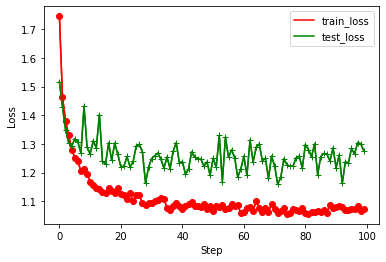

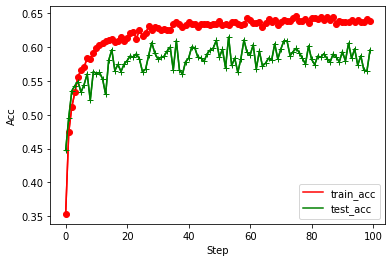

In [19]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

### 3. Change optimizer
Adam: RMSProp + Momentum

In [20]:
LOG_PATH="./train4.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn4.pth"
    
model = Net()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 100
print("Model: CNN from Pytorch tutorial")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: CNN from Pytorch tutorial
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:03, 109.96it/s]

Finish 1 epoch, Train loss: 1.716487, Train acc@1: 0.372620


Test loss: 1.513483, Test acc@1: 0.449300
Saving Best model...			Top1 = 44.930000%
Elapsed time: 5.667855262756348
---------- Training Epoch #1 ----------


391it [00:03, 114.12it/s]

Finish 2 epoch, Train loss: 1.457292, Train acc@1: 0.473860


Test loss: 1.379165, Test acc@1: 0.505000
Saving Best model...			Top1 = 50.500000%
Elapsed time: 11.126756429672241
---------- Training Epoch #2 ----------


391it [00:03, 115.07it/s]

Finish 3 epoch, Train loss: 1.350625, Train acc@1: 0.513340


Test loss: 1.378566, Test acc@1: 0.504900
Elapsed time: 16.487988471984863
---------- Training Epoch #3 ----------


391it [00:03, 113.75it/s]


Finish 4 epoch, Train loss: 1.262042, Train acc@1: 0.550600
Test loss: 1.239620, Test acc@1: 0.553600
Saving Best model...			Top1 = 55.360000%
Elapsed time: 21.915283203125
---------- Training Epoch #4 ----------


391it [00:03, 112.11it/s]

Finish 5 epoch, Train loss: 1.191988, Train acc@1: 0.575620


Test loss: 1.187207, Test acc@1: 0.577700
Saving Best model...			Top1 = 57.770000%
Elapsed time: 27.346003532409668
---------- Training Epoch #5 ----------


391it [00:03, 112.77it/s]

Finish 6 epoch, Train loss: 1.136357, Train acc@1: 0.597060


Test loss: 1.166636, Test acc@1: 0.584900
Saving Best model...			Top1 = 58.490000%
Elapsed time: 32.78485655784607
---------- Training Epoch #6 ----------


391it [00:03, 108.63it/s]

Finish 7 epoch, Train loss: 1.098040, Train acc@1: 0.611300


Test loss: 1.136768, Test acc@1: 0.597900
Saving Best model...			Top1 = 59.790000%
Elapsed time: 38.378759145736694
---------- Training Epoch #7 ----------


391it [00:03, 112.42it/s]

Finish 8 epoch, Train loss: 1.055008, Train acc@1: 0.627640


Test loss: 1.111622, Test acc@1: 0.605900
Saving Best model...			Top1 = 60.590000%
Elapsed time: 43.81107497215271
---------- Training Epoch #8 ----------


391it [00:03, 109.07it/s]

Finish 9 epoch, Train loss: 1.024879, Train acc@1: 0.638180


Test loss: 1.084412, Test acc@1: 0.616400
Saving Best model...			Top1 = 61.640000%
Elapsed time: 49.42848300933838
---------- Training Epoch #9 ----------


391it [00:03, 113.53it/s]

Finish 10 epoch, Train loss: 0.985613, Train acc@1: 0.652500


Test loss: 1.077331, Test acc@1: 0.617600
Saving Best model...			Top1 = 61.760000%
Elapsed time: 54.92188906669617
---------- Training Epoch #10 ----------


391it [00:03, 112.12it/s]

Finish 11 epoch, Train loss: 0.961492, Train acc@1: 0.660820


Test loss: 1.048279, Test acc@1: 0.634300
Saving Best model...			Top1 = 63.430000%
Elapsed time: 60.45313000679016
---------- Training Epoch #11 ----------


391it [00:03, 114.45it/s]

Finish 12 epoch, Train loss: 0.931925, Train acc@1: 0.671040


Test loss: 1.048121, Test acc@1: 0.632900
Elapsed time: 65.7874584197998
---------- Training Epoch #12 ----------


391it [00:03, 115.24it/s]

Finish 13 epoch, Train loss: 0.909145, Train acc@1: 0.680400


Test loss: 1.056053, Test acc@1: 0.631900
Elapsed time: 71.24279713630676
---------- Training Epoch #13 ----------


391it [00:03, 111.67it/s]

Finish 14 epoch, Train loss: 0.883922, Train acc@1: 0.688820


Test loss: 1.053998, Test acc@1: 0.637800
Saving Best model...			Top1 = 63.780000%
Elapsed time: 76.69497537612915
---------- Training Epoch #14 ----------


391it [00:03, 111.52it/s]

Finish 15 epoch, Train loss: 0.861976, Train acc@1: 0.693900


Test loss: 1.048651, Test acc@1: 0.641900
Saving Best model...			Top1 = 64.190000%
Elapsed time: 82.19089078903198
---------- Training Epoch #15 ----------


391it [00:03, 115.53it/s]

Finish 16 epoch, Train loss: 0.842717, Train acc@1: 0.702880


Test loss: 1.041320, Test acc@1: 0.641400
Elapsed time: 87.54090094566345
---------- Training Epoch #16 ----------


391it [00:03, 115.59it/s]

Finish 17 epoch, Train loss: 0.825729, Train acc@1: 0.709460


Test loss: 1.050679, Test acc@1: 0.643900
Saving Best model...			Top1 = 64.390000%
Elapsed time: 92.9333598613739
---------- Training Epoch #17 ----------


391it [00:03, 114.96it/s]

Finish 18 epoch, Train loss: 0.808509, Train acc@1: 0.715840


Test loss: 1.033248, Test acc@1: 0.649200
Saving Best model...			Top1 = 64.920000%
Elapsed time: 98.37527418136597
---------- Training Epoch #18 ----------


391it [00:03, 112.90it/s]

Finish 19 epoch, Train loss: 0.792181, Train acc@1: 0.720680


Test loss: 1.032180, Test acc@1: 0.652000
Saving Best model...			Top1 = 65.200000%
Elapsed time: 103.85380458831787
---------- Training Epoch #19 ----------


391it [00:03, 113.64it/s]

Finish 20 epoch, Train loss: 0.778770, Train acc@1: 0.726600


Test loss: 1.027090, Test acc@1: 0.654700
Saving Best model...			Top1 = 65.470000%
Elapsed time: 109.25493168830872
---------- Training Epoch #20 ----------


391it [00:03, 108.31it/s]

Finish 21 epoch, Train loss: 0.759027, Train acc@1: 0.731740


Test loss: 1.049434, Test acc@1: 0.649400
Elapsed time: 114.90212202072144
---------- Training Epoch #21 ----------


391it [00:03, 114.43it/s]

Finish 22 epoch, Train loss: 0.742940, Train acc@1: 0.739660


Test loss: 1.085520, Test acc@1: 0.641800
Elapsed time: 120.34947967529297
---------- Training Epoch #22 ----------


391it [00:03, 111.88it/s]

Finish 23 epoch, Train loss: 0.729634, Train acc@1: 0.742760


Test loss: 1.046673, Test acc@1: 0.656000
Saving Best model...			Top1 = 65.600000%
Elapsed time: 125.8359580039978
---------- Training Epoch #23 ----------


391it [00:03, 114.08it/s]

Finish 24 epoch, Train loss: 0.714813, Train acc@1: 0.748740


Test loss: 1.053625, Test acc@1: 0.649800
Elapsed time: 131.19768643379211
---------- Training Epoch #24 ----------


391it [00:03, 112.72it/s]

Finish 25 epoch, Train loss: 0.707801, Train acc@1: 0.751980


Test loss: 1.067909, Test acc@1: 0.646200
Elapsed time: 136.66796374320984
---------- Training Epoch #25 ----------


391it [00:03, 111.54it/s]

Finish 26 epoch, Train loss: 0.689019, Train acc@1: 0.757100


Test loss: 1.115606, Test acc@1: 0.638300
Elapsed time: 142.12405586242676
---------- Training Epoch #26 ----------


391it [00:03, 115.17it/s]

Finish 27 epoch, Train loss: 0.678679, Train acc@1: 0.759180


Test loss: 1.068767, Test acc@1: 0.645400
Elapsed time: 147.46359395980835
---------- Training Epoch #27 ----------


391it [00:03, 112.27it/s]

Finish 28 epoch, Train loss: 0.665790, Train acc@1: 0.765400


Test loss: 1.097409, Test acc@1: 0.648900
Elapsed time: 152.94292426109314
---------- Training Epoch #28 ----------


391it [00:03, 109.44it/s]

Finish 29 epoch, Train loss: 0.656075, Train acc@1: 0.768120


Test loss: 1.098779, Test acc@1: 0.649700
Elapsed time: 158.56048893928528
---------- Training Epoch #29 ----------


391it [00:03, 110.22it/s]

Finish 30 epoch, Train loss: 0.644441, Train acc@1: 0.773100


Test loss: 1.102662, Test acc@1: 0.651500
Elapsed time: 164.12843132019043
---------- Training Epoch #30 ----------


391it [00:03, 103.79it/s]

Finish 31 epoch, Train loss: 0.632485, Train acc@1: 0.777740


Test loss: 1.103106, Test acc@1: 0.647800
Elapsed time: 169.99525952339172
---------- Training Epoch #31 ----------


391it [00:03, 110.59it/s]

Finish 32 epoch, Train loss: 0.619980, Train acc@1: 0.780240


Test loss: 1.116084, Test acc@1: 0.649800
Elapsed time: 175.57849717140198
---------- Training Epoch #32 ----------


391it [00:03, 110.87it/s]

Finish 33 epoch, Train loss: 0.609832, Train acc@1: 0.784820


Test loss: 1.132938, Test acc@1: 0.645400
Elapsed time: 181.13538599014282
---------- Training Epoch #33 ----------


391it [00:03, 112.79it/s]

Finish 34 epoch, Train loss: 0.602471, Train acc@1: 0.787440


Test loss: 1.146804, Test acc@1: 0.640600
Elapsed time: 186.6636621952057
---------- Training Epoch #34 ----------


391it [00:03, 110.82it/s]

Finish 35 epoch, Train loss: 0.594125, Train acc@1: 0.788700


Test loss: 1.155955, Test acc@1: 0.643900
Elapsed time: 192.20519375801086
---------- Training Epoch #35 ----------


391it [00:03, 107.37it/s]

Finish 36 epoch, Train loss: 0.584659, Train acc@1: 0.794300


Test loss: 1.179000, Test acc@1: 0.638000
Elapsed time: 197.8552737236023
---------- Training Epoch #36 ----------


391it [00:03, 112.62it/s]

Finish 37 epoch, Train loss: 0.574034, Train acc@1: 0.795620


Test loss: 1.170337, Test acc@1: 0.644900
Elapsed time: 203.31930088996887
---------- Training Epoch #37 ----------


391it [00:03, 114.17it/s]

Finish 38 epoch, Train loss: 0.566991, Train acc@1: 0.798680


Test loss: 1.204970, Test acc@1: 0.641400
Elapsed time: 208.67540645599365
---------- Training Epoch #38 ----------


391it [00:03, 107.55it/s]


Finish 39 epoch, Train loss: 0.556194, Train acc@1: 0.803160
Test loss: 1.192829, Test acc@1: 0.640500
Elapsed time: 214.2694215774536
---------- Training Epoch #39 ----------


391it [00:03, 112.43it/s]

Finish 40 epoch, Train loss: 0.555066, Train acc@1: 0.804220


Test loss: 1.210256, Test acc@1: 0.640500
Elapsed time: 219.76213264465332
---------- Training Epoch #40 ----------


391it [00:03, 109.66it/s]

Finish 41 epoch, Train loss: 0.542810, Train acc@1: 0.808500


Test loss: 1.258047, Test acc@1: 0.634900
Elapsed time: 225.33501482009888
---------- Training Epoch #41 ----------


391it [00:03, 110.36it/s]


Finish 42 epoch, Train loss: 0.533871, Train acc@1: 0.810520
Test loss: 1.225639, Test acc@1: 0.642900
Elapsed time: 230.86439156532288
---------- Training Epoch #42 ----------


391it [00:03, 109.67it/s]

Finish 43 epoch, Train loss: 0.526147, Train acc@1: 0.813860


Test loss: 1.195339, Test acc@1: 0.643800
Elapsed time: 236.38621306419373
---------- Training Epoch #43 ----------


391it [00:03, 111.33it/s]

Finish 44 epoch, Train loss: 0.524351, Train acc@1: 0.813980


Test loss: 1.232067, Test acc@1: 0.643300
Elapsed time: 241.88097667694092
---------- Training Epoch #44 ----------


391it [00:03, 111.12it/s]

Finish 45 epoch, Train loss: 0.513375, Train acc@1: 0.815980


Test loss: 1.274896, Test acc@1: 0.638700
Elapsed time: 247.40973782539368
---------- Training Epoch #45 ----------


391it [00:03, 114.96it/s]

Finish 46 epoch, Train loss: 0.507429, Train acc@1: 0.818200


Test loss: 1.268803, Test acc@1: 0.633700
Elapsed time: 252.73163056373596
---------- Training Epoch #46 ----------


391it [00:03, 111.78it/s]

Finish 47 epoch, Train loss: 0.502370, Train acc@1: 0.820920


Test loss: 1.271302, Test acc@1: 0.635600
Elapsed time: 258.1781532764435
---------- Training Epoch #47 ----------


391it [00:03, 113.86it/s]

Finish 48 epoch, Train loss: 0.494825, Train acc@1: 0.823780


Test loss: 1.289573, Test acc@1: 0.635400
Elapsed time: 263.6189229488373
---------- Training Epoch #48 ----------


391it [00:03, 111.05it/s]

Finish 49 epoch, Train loss: 0.487868, Train acc@1: 0.827320


Test loss: 1.300125, Test acc@1: 0.636900
Elapsed time: 269.1283552646637
---------- Training Epoch #49 ----------


391it [00:03, 111.62it/s]

Finish 50 epoch, Train loss: 0.480432, Train acc@1: 0.829460


Test loss: 1.338606, Test acc@1: 0.631100
Elapsed time: 274.68316173553467
---------- Training Epoch #50 ----------


391it [00:03, 108.33it/s]

Finish 51 epoch, Train loss: 0.473890, Train acc@1: 0.831860


Test loss: 1.318581, Test acc@1: 0.636400
Elapsed time: 280.3971140384674
---------- Training Epoch #51 ----------


391it [00:03, 113.68it/s]


Finish 52 epoch, Train loss: 0.470677, Train acc@1: 0.832540
Test loss: 1.380173, Test acc@1: 0.629600
Elapsed time: 285.8778438568115
---------- Training Epoch #52 ----------


391it [00:03, 109.39it/s]

Finish 53 epoch, Train loss: 0.461316, Train acc@1: 0.837520


Test loss: 1.352687, Test acc@1: 0.632800
Elapsed time: 291.4000594615936
---------- Training Epoch #53 ----------


391it [00:03, 110.09it/s]

Finish 54 epoch, Train loss: 0.452701, Train acc@1: 0.839380


Test loss: 1.393161, Test acc@1: 0.632200
Elapsed time: 296.9615466594696
---------- Training Epoch #54 ----------


391it [00:03, 115.21it/s]

Finish 55 epoch, Train loss: 0.450907, Train acc@1: 0.838580


Test loss: 1.383361, Test acc@1: 0.629800
Elapsed time: 302.29645013809204
---------- Training Epoch #55 ----------


391it [00:03, 112.40it/s]

Finish 56 epoch, Train loss: 0.445140, Train acc@1: 0.841120


Test loss: 1.380561, Test acc@1: 0.630700
Elapsed time: 307.702264547348
---------- Training Epoch #56 ----------


391it [00:03, 114.15it/s]

Finish 57 epoch, Train loss: 0.443724, Train acc@1: 0.843140


Test loss: 1.416961, Test acc@1: 0.628300
Elapsed time: 313.1819381713867
---------- Training Epoch #57 ----------


391it [00:03, 113.21it/s]

Finish 58 epoch, Train loss: 0.434503, Train acc@1: 0.845220


Test loss: 1.389329, Test acc@1: 0.631700
Elapsed time: 318.5967798233032
---------- Training Epoch #58 ----------


391it [00:03, 107.91it/s]

Finish 59 epoch, Train loss: 0.430548, Train acc@1: 0.845040


Test loss: 1.442335, Test acc@1: 0.630700
Elapsed time: 324.2147216796875
---------- Training Epoch #59 ----------


391it [00:03, 113.14it/s]

Finish 60 epoch, Train loss: 0.423837, Train acc@1: 0.850820


Test loss: 1.438880, Test acc@1: 0.623900
Elapsed time: 329.66232442855835
---------- Training Epoch #60 ----------


391it [00:03, 115.47it/s]

Finish 61 epoch, Train loss: 0.419388, Train acc@1: 0.850360


Test loss: 1.467777, Test acc@1: 0.630300
Elapsed time: 335.0908889770508
---------- Training Epoch #61 ----------


391it [00:03, 114.42it/s]

Finish 62 epoch, Train loss: 0.416388, Train acc@1: 0.850880


Test loss: 1.474650, Test acc@1: 0.633700
Elapsed time: 340.55550622940063
---------- Training Epoch #62 ----------


391it [00:03, 108.61it/s]

Finish 63 epoch, Train loss: 0.407014, Train acc@1: 0.853280


Test loss: 1.482623, Test acc@1: 0.632600
Elapsed time: 346.1123261451721
---------- Training Epoch #63 ----------


391it [00:03, 114.93it/s]

Finish 64 epoch, Train loss: 0.405629, Train acc@1: 0.854500


Test loss: 1.507593, Test acc@1: 0.628300
Elapsed time: 351.5022909641266
---------- Training Epoch #64 ----------


391it [00:03, 111.58it/s]

Finish 65 epoch, Train loss: 0.401502, Train acc@1: 0.855580


Test loss: 1.561686, Test acc@1: 0.623100
Elapsed time: 357.0887644290924
---------- Training Epoch #65 ----------


391it [00:03, 112.10it/s]

Finish 66 epoch, Train loss: 0.398053, Train acc@1: 0.857960


Test loss: 1.499320, Test acc@1: 0.625200
Elapsed time: 362.5701355934143
---------- Training Epoch #66 ----------


391it [00:03, 116.92it/s]

Finish 67 epoch, Train loss: 0.393958, Train acc@1: 0.859720


Test loss: 1.547552, Test acc@1: 0.626100
Elapsed time: 367.8636817932129
---------- Training Epoch #67 ----------


391it [00:03, 113.02it/s]

Finish 68 epoch, Train loss: 0.386468, Train acc@1: 0.861220


Test loss: 1.560795, Test acc@1: 0.623200
Elapsed time: 373.2930099964142
---------- Training Epoch #68 ----------


391it [00:03, 113.44it/s]

Finish 69 epoch, Train loss: 0.382743, Train acc@1: 0.863180


Test loss: 1.560142, Test acc@1: 0.619200
Elapsed time: 378.7139096260071
---------- Training Epoch #69 ----------


391it [00:03, 113.85it/s]

Finish 70 epoch, Train loss: 0.377451, Train acc@1: 0.863120


Test loss: 1.583299, Test acc@1: 0.625700
Elapsed time: 384.14102244377136
---------- Training Epoch #70 ----------


391it [00:03, 109.26it/s]

Finish 71 epoch, Train loss: 0.378032, Train acc@1: 0.865100


Test loss: 1.620525, Test acc@1: 0.622000
Elapsed time: 389.8387682437897
---------- Training Epoch #71 ----------


391it [00:03, 110.19it/s]

Finish 72 epoch, Train loss: 0.367422, Train acc@1: 0.868960


Test loss: 1.602242, Test acc@1: 0.627000
Elapsed time: 395.4738826751709
---------- Training Epoch #72 ----------


391it [00:03, 113.10it/s]

Finish 73 epoch, Train loss: 0.373486, Train acc@1: 0.865860


Test loss: 1.614663, Test acc@1: 0.624000
Elapsed time: 400.9335079193115
---------- Training Epoch #73 ----------


391it [00:03, 110.74it/s]

Finish 74 epoch, Train loss: 0.365621, Train acc@1: 0.868940


Test loss: 1.670668, Test acc@1: 0.621200
Elapsed time: 406.5147590637207
---------- Training Epoch #74 ----------


391it [00:03, 109.23it/s]

Finish 75 epoch, Train loss: 0.356355, Train acc@1: 0.872800


Test loss: 1.665040, Test acc@1: 0.628900
Elapsed time: 412.1206998825073
---------- Training Epoch #75 ----------


391it [00:03, 114.70it/s]

Finish 76 epoch, Train loss: 0.357688, Train acc@1: 0.870700


Test loss: 1.653965, Test acc@1: 0.622500
Elapsed time: 417.4763822555542
---------- Training Epoch #76 ----------


391it [00:03, 112.69it/s]

Finish 77 epoch, Train loss: 0.347648, Train acc@1: 0.874440


Test loss: 1.749704, Test acc@1: 0.620200
Elapsed time: 422.8931725025177
---------- Training Epoch #77 ----------


391it [00:03, 115.33it/s]

Finish 78 epoch, Train loss: 0.354943, Train acc@1: 0.871700


Test loss: 1.695651, Test acc@1: 0.617000
Elapsed time: 428.2166430950165
---------- Training Epoch #78 ----------


391it [00:03, 110.23it/s]

Finish 79 epoch, Train loss: 0.345849, Train acc@1: 0.873820


Test loss: 1.680566, Test acc@1: 0.621700
Elapsed time: 433.75494503974915
---------- Training Epoch #79 ----------


391it [00:03, 110.67it/s]

Finish 80 epoch, Train loss: 0.341740, Train acc@1: 0.876060


Test loss: 1.697321, Test acc@1: 0.616600
Elapsed time: 439.35991311073303
---------- Training Epoch #80 ----------


391it [00:03, 109.90it/s]

Finish 81 epoch, Train loss: 0.335370, Train acc@1: 0.879620


Test loss: 1.720540, Test acc@1: 0.621900
Elapsed time: 444.90631461143494
---------- Training Epoch #81 ----------


391it [00:03, 112.53it/s]

Finish 82 epoch, Train loss: 0.338971, Train acc@1: 0.875660


Test loss: 1.765454, Test acc@1: 0.619200
Elapsed time: 450.49001598358154
---------- Training Epoch #82 ----------


391it [00:03, 113.96it/s]

Finish 83 epoch, Train loss: 0.330083, Train acc@1: 0.879620


Test loss: 1.753860, Test acc@1: 0.616600
Elapsed time: 455.9753587245941
---------- Training Epoch #83 ----------


391it [00:03, 114.44it/s]


Finish 84 epoch, Train loss: 0.331745, Train acc@1: 0.879620
Test loss: 1.765972, Test acc@1: 0.620200
Elapsed time: 461.40250277519226
---------- Training Epoch #84 ----------


391it [00:03, 114.00it/s]

Finish 85 epoch, Train loss: 0.327987, Train acc@1: 0.879420


Test loss: 1.795786, Test acc@1: 0.623900
Elapsed time: 466.9801073074341
---------- Training Epoch #85 ----------


391it [00:03, 114.65it/s]

Finish 86 epoch, Train loss: 0.320364, Train acc@1: 0.883480


Test loss: 1.808771, Test acc@1: 0.617300
Elapsed time: 472.33977913856506
---------- Training Epoch #86 ----------


391it [00:03, 114.12it/s]


Finish 87 epoch, Train loss: 0.319278, Train acc@1: 0.884880
Test loss: 1.802089, Test acc@1: 0.616000
Elapsed time: 477.72464656829834
---------- Training Epoch #87 ----------


391it [00:03, 114.14it/s]

Finish 88 epoch, Train loss: 0.315530, Train acc@1: 0.885380


Test loss: 1.803575, Test acc@1: 0.622300
Elapsed time: 483.1167335510254
---------- Training Epoch #88 ----------


391it [00:03, 113.67it/s]

Finish 89 epoch, Train loss: 0.313932, Train acc@1: 0.886600


Test loss: 1.857058, Test acc@1: 0.614500
Elapsed time: 488.48675632476807
---------- Training Epoch #89 ----------


391it [00:03, 113.20it/s]

Finish 90 epoch, Train loss: 0.315976, Train acc@1: 0.884120


Test loss: 1.843455, Test acc@1: 0.617000
Elapsed time: 493.9666244983673
---------- Training Epoch #90 ----------


391it [00:03, 112.32it/s]

Finish 91 epoch, Train loss: 0.309411, Train acc@1: 0.886840


Test loss: 1.876487, Test acc@1: 0.615400
Elapsed time: 499.4496920108795
---------- Training Epoch #91 ----------


391it [00:03, 115.95it/s]

Finish 92 epoch, Train loss: 0.300514, Train acc@1: 0.889720


Test loss: 1.858169, Test acc@1: 0.622800
Elapsed time: 504.8164179325104
---------- Training Epoch #92 ----------


391it [00:03, 115.95it/s]

Finish 93 epoch, Train loss: 0.305082, Train acc@1: 0.889820


Test loss: 1.857596, Test acc@1: 0.620800
Elapsed time: 510.1896724700928
---------- Training Epoch #93 ----------


391it [00:03, 111.82it/s]

Finish 94 epoch, Train loss: 0.307451, Train acc@1: 0.888520


Test loss: 1.946431, Test acc@1: 0.614200
Elapsed time: 515.7662305831909
---------- Training Epoch #94 ----------


391it [00:03, 110.95it/s]

Finish 95 epoch, Train loss: 0.296483, Train acc@1: 0.892000


Test loss: 1.925886, Test acc@1: 0.619000
Elapsed time: 521.3054237365723
---------- Training Epoch #95 ----------


391it [00:03, 113.82it/s]

Finish 96 epoch, Train loss: 0.298199, Train acc@1: 0.891180


Test loss: 1.985119, Test acc@1: 0.612100
Elapsed time: 526.7351562976837
---------- Training Epoch #96 ----------


391it [00:03, 115.41it/s]

Finish 97 epoch, Train loss: 0.295253, Train acc@1: 0.892500


Test loss: 1.918301, Test acc@1: 0.613900
Elapsed time: 532.0811452865601
---------- Training Epoch #97 ----------


391it [00:03, 109.18it/s]

Finish 98 epoch, Train loss: 0.296738, Train acc@1: 0.891980


Test loss: 1.942224, Test acc@1: 0.622000
Elapsed time: 537.6376221179962
---------- Training Epoch #98 ----------


391it [00:03, 114.66it/s]

Finish 99 epoch, Train loss: 0.291158, Train acc@1: 0.894020


Test loss: 1.927301, Test acc@1: 0.617300
Elapsed time: 543.0817406177521
---------- Training Epoch #99 ----------


391it [00:03, 112.86it/s]

Finish 100 epoch, Train loss: 0.285820, Train acc@1: 0.895240


Test loss: 1.952417, Test acc@1: 0.620200
Elapsed time: 548.5183763504028

Test results: Acc@1 = 65.600000%


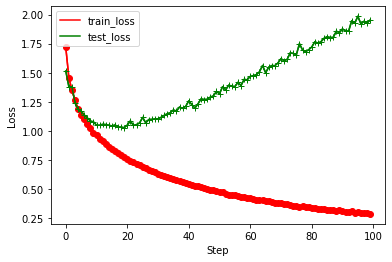

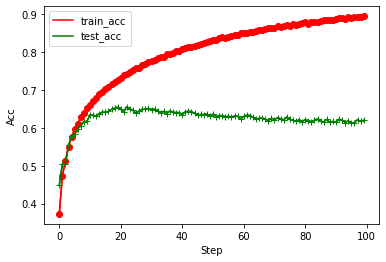

In [21]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

### 4. Batch size
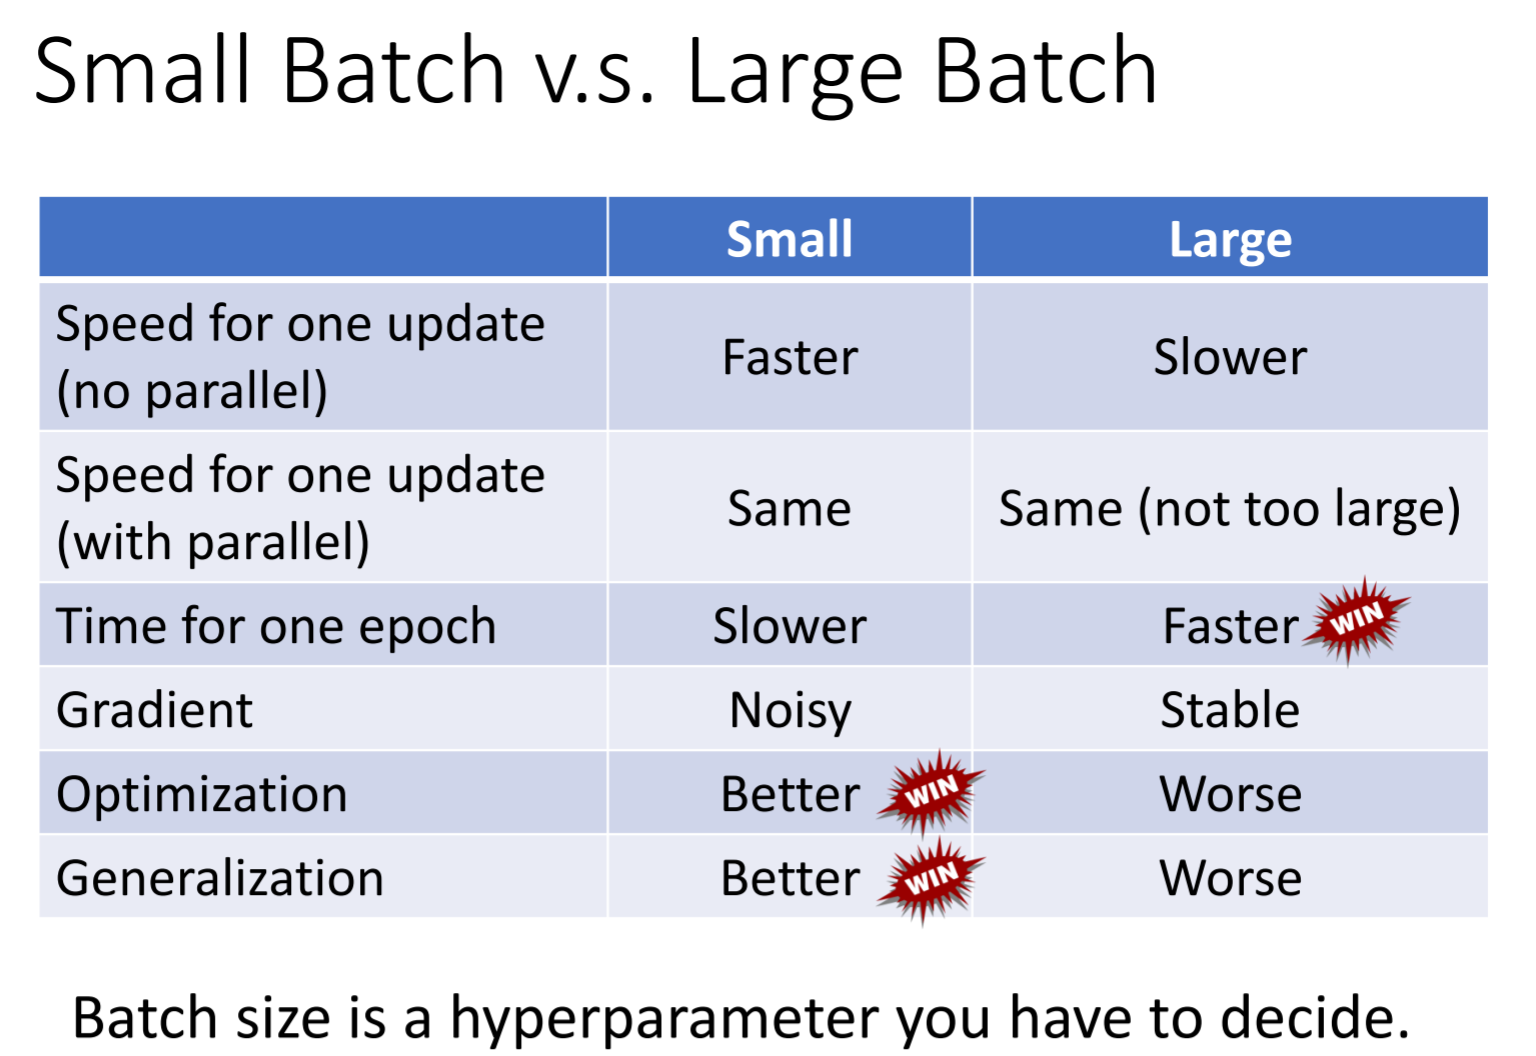

In [22]:
train_loss_record_lst = []
test_loss_record_lst = []
train_acc_record_lst = []
test_acc_record_lst = []

BATCH_SIZE = 32
log_id = 5
while BATCH_SIZE <= 256: 
    train_dataset = datasets.CIFAR10('./data', train=True, transform=transform_train, download=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    test_dataset = datasets.CIFAR10('./data', train=False, transform=transform_test, download=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    LOG_PATH="./train" + str(log_id) + ".log"
    if os.path.exists(LOG_PATH):
        os.remove(LOG_PATH)
    MODEL_PATH="./cnn" + str(log_id) + ".pth"

    model = Net()
    if AVAIL_GPUS:
        model = model.cuda()

    def get_optimizer(epoch):
        return optim.Adam(model.parameters(), weight_decay=5e-4)

    NUM_EPOCHS = 100
    print("Model: CNN from Pytorch tutorial")
    print("Batch size: %d" % (BATCH_SIZE))
    print("Epoch num: %d" % (NUM_EPOCHS))
    print("Optimizer: Adam")
    with open(LOG_PATH, "a") as f:
        f.write("Model: CNN from Pytorch tutorial")
        f.write("\n")
        f.write("Batch size: %d" % (BATCH_SIZE))
        f.write("\n")
        f.write("Epoch num: %d" % (NUM_EPOCHS))
        f.write("\n")
        f.write("Optimizer: Adam")
        f.write("\n")

    train_loss_record = []
    test_loss_record = []
    train_acc_record = []
    test_acc_record = []
    best_acc = 0
    elapsed_time = 0
    for i in range(NUM_EPOCHS):
        start_time = time.time()

        print("-"*10, "Training Epoch #%d" % (i), "-"*10)
        with open(LOG_PATH, "a") as f:
            f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
            f.write("\n")

        train(i)
        test(i)

        epoch_time = time.time() - start_time
        elapsed_time += epoch_time
        print('Elapsed time: %s' % str(elapsed_time))
        with open(LOG_PATH, "a") as f:
            f.write('Elapsed time: %s' % str(elapsed_time))
            f.write("\n")
    print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    with open(LOG_PATH, "a") as f:
        f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
        f.write("\n")
        
    log_id += 1
    BATCH_SIZE *= 2
    
    train_loss_record_lst.append(train_loss_record)
    test_loss_record_lst.append(test_loss_record)
    train_acc_record_lst.append(train_acc_record)
    test_acc_record_lst.append(test_acc_record)

Files already downloaded and verified
Files already downloaded and verified
Model: CNN from Pytorch tutorial
Batch size: 32
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


1563it [00:11, 136.64it/s]

Finish 1 epoch, Train loss: 1.624309, Train acc@1: 0.405020


Test loss: 1.458102, Test acc@1: 0.470100
Saving Best model...			Top1 = 47.010000%
Elapsed time: 13.867951154708862
---------- Training Epoch #1 ----------


1563it [00:11, 138.38it/s]

Finish 2 epoch, Train loss: 1.321208, Train acc@1: 0.521460


Test loss: 1.236252, Test acc@1: 0.556900
Saving Best model...			Top1 = 55.690000%
Elapsed time: 27.616615295410156
---------- Training Epoch #2 ----------


1563it [00:11, 133.12it/s]


Finish 3 epoch, Train loss: 1.194216, Train acc@1: 0.574300
Test loss: 1.218379, Test acc@1: 0.562100
Saving Best model...			Top1 = 56.210000%
Elapsed time: 41.79036903381348
---------- Training Epoch #3 ----------


1563it [00:11, 140.77it/s]


Finish 4 epoch, Train loss: 1.120175, Train acc@1: 0.603220
Test loss: 1.137694, Test acc@1: 0.599800
Saving Best model...			Top1 = 59.980000%
Elapsed time: 55.28056359291077
---------- Training Epoch #4 ----------


1563it [00:11, 136.67it/s]


Finish 5 epoch, Train loss: 1.056614, Train acc@1: 0.626440
Test loss: 1.101394, Test acc@1: 0.614100
Saving Best model...			Top1 = 61.410000%
Elapsed time: 69.19431352615356
---------- Training Epoch #5 ----------


1563it [00:11, 139.27it/s]

Finish 6 epoch, Train loss: 1.008736, Train acc@1: 0.644400


Test loss: 1.087600, Test acc@1: 0.616300
Saving Best model...			Top1 = 61.630000%
Elapsed time: 82.8685929775238
---------- Training Epoch #6 ----------


1563it [00:11, 134.52it/s]

Finish 7 epoch, Train loss: 0.966377, Train acc@1: 0.660240


Test loss: 1.067248, Test acc@1: 0.636100
Saving Best model...			Top1 = 63.610000%
Elapsed time: 96.79126930236816
---------- Training Epoch #7 ----------


1563it [00:11, 138.50it/s]


Finish 8 epoch, Train loss: 0.933154, Train acc@1: 0.670520
Test loss: 1.134286, Test acc@1: 0.611400
Elapsed time: 110.55539226531982
---------- Training Epoch #8 ----------


1563it [00:11, 135.39it/s]

Finish 9 epoch, Train loss: 0.904369, Train acc@1: 0.681640


Test loss: 1.087371, Test acc@1: 0.620800
Elapsed time: 124.63574886322021
---------- Training Epoch #9 ----------


1563it [00:11, 135.86it/s]

Finish 10 epoch, Train loss: 0.874611, Train acc@1: 0.691820


Test loss: 1.036738, Test acc@1: 0.638200
Saving Best model...			Top1 = 63.820000%
Elapsed time: 138.5789566040039
---------- Training Epoch #10 ----------


1563it [00:11, 138.39it/s]

Finish 11 epoch, Train loss: 0.853247, Train acc@1: 0.698480


Test loss: 1.084978, Test acc@1: 0.631000
Elapsed time: 152.22303938865662
---------- Training Epoch #11 ----------


1563it [00:11, 137.06it/s]

Finish 12 epoch, Train loss: 0.834470, Train acc@1: 0.705420


Test loss: 1.040844, Test acc@1: 0.635600
Elapsed time: 166.1040289402008
---------- Training Epoch #12 ----------


1563it [00:11, 136.10it/s]

Finish 13 epoch, Train loss: 0.811235, Train acc@1: 0.714140


Test loss: 1.062521, Test acc@1: 0.635300
Elapsed time: 180.10972428321838
---------- Training Epoch #13 ----------


1563it [00:11, 132.63it/s]

Finish 14 epoch, Train loss: 0.790780, Train acc@1: 0.719640


Test loss: 1.055585, Test acc@1: 0.637400
Elapsed time: 194.28714179992676
---------- Training Epoch #14 ----------


1563it [00:11, 137.12it/s]

Finish 15 epoch, Train loss: 0.771877, Train acc@1: 0.726420


Test loss: 1.071891, Test acc@1: 0.643600
Saving Best model...			Top1 = 64.360000%
Elapsed time: 208.14466881752014
---------- Training Epoch #15 ----------


1563it [00:11, 135.05it/s]

Finish 16 epoch, Train loss: 0.762058, Train acc@1: 0.728920


Test loss: 1.059947, Test acc@1: 0.643500
Elapsed time: 222.05701994895935
---------- Training Epoch #16 ----------


1563it [00:11, 132.74it/s]

Finish 17 epoch, Train loss: 0.750062, Train acc@1: 0.735020


Test loss: 1.052022, Test acc@1: 0.647700
Saving Best model...			Top1 = 64.770000%
Elapsed time: 236.15296959877014
---------- Training Epoch #17 ----------


1563it [00:11, 134.07it/s]

Finish 18 epoch, Train loss: 0.735407, Train acc@1: 0.738500


Test loss: 1.058515, Test acc@1: 0.645400
Elapsed time: 250.34710812568665
---------- Training Epoch #18 ----------


1563it [00:11, 141.10it/s]

Finish 19 epoch, Train loss: 0.718880, Train acc@1: 0.744180


Test loss: 1.081590, Test acc@1: 0.642100
Elapsed time: 263.91653299331665
---------- Training Epoch #19 ----------


1563it [00:11, 138.43it/s]

Finish 20 epoch, Train loss: 0.709447, Train acc@1: 0.747160


Test loss: 1.067498, Test acc@1: 0.638600
Elapsed time: 277.5513038635254
---------- Training Epoch #20 ----------


1563it [00:11, 138.78it/s]

Finish 21 epoch, Train loss: 0.696632, Train acc@1: 0.752520


Test loss: 1.090634, Test acc@1: 0.639100
Elapsed time: 291.20549750328064
---------- Training Epoch #21 ----------


1563it [00:11, 135.22it/s]

Finish 22 epoch, Train loss: 0.685981, Train acc@1: 0.756540


Test loss: 1.102414, Test acc@1: 0.640100
Elapsed time: 305.2436442375183
---------- Training Epoch #22 ----------


1563it [00:11, 137.31it/s]

Finish 23 epoch, Train loss: 0.676170, Train acc@1: 0.760060


Test loss: 1.078908, Test acc@1: 0.641700
Elapsed time: 319.06352496147156
---------- Training Epoch #23 ----------


1563it [00:11, 140.13it/s]

Finish 24 epoch, Train loss: 0.665631, Train acc@1: 0.763100


Test loss: 1.183246, Test acc@1: 0.631400
Elapsed time: 332.52435541152954
---------- Training Epoch #24 ----------


1563it [00:11, 133.19it/s]

Finish 25 epoch, Train loss: 0.658430, Train acc@1: 0.765880


Test loss: 1.162959, Test acc@1: 0.638700
Elapsed time: 346.64753437042236
---------- Training Epoch #25 ----------


1563it [00:11, 139.65it/s]

Finish 26 epoch, Train loss: 0.649761, Train acc@1: 0.768680


Test loss: 1.131078, Test acc@1: 0.636900
Elapsed time: 360.2869701385498
---------- Training Epoch #26 ----------


1563it [00:11, 136.04it/s]

Finish 27 epoch, Train loss: 0.636308, Train acc@1: 0.772280


Test loss: 1.177292, Test acc@1: 0.635100
Elapsed time: 374.139874458313
---------- Training Epoch #27 ----------


1563it [00:11, 137.09it/s]

Finish 28 epoch, Train loss: 0.632351, Train acc@1: 0.773240


Test loss: 1.150114, Test acc@1: 0.640500
Elapsed time: 387.94539880752563
---------- Training Epoch #28 ----------


1563it [00:11, 135.49it/s]

Finish 29 epoch, Train loss: 0.628685, Train acc@1: 0.774780


Test loss: 1.157625, Test acc@1: 0.630600
Elapsed time: 401.90850806236267
---------- Training Epoch #29 ----------


1563it [00:11, 138.94it/s]

Finish 30 epoch, Train loss: 0.619615, Train acc@1: 0.779500


Test loss: 1.186261, Test acc@1: 0.634600
Elapsed time: 415.6363875865936
---------- Training Epoch #30 ----------


1563it [00:11, 137.99it/s]

Finish 31 epoch, Train loss: 0.609822, Train acc@1: 0.781700


Test loss: 1.180240, Test acc@1: 0.628200
Elapsed time: 429.40853691101074
---------- Training Epoch #31 ----------


1563it [00:11, 134.00it/s]


Finish 32 epoch, Train loss: 0.605235, Train acc@1: 0.783260
Test loss: 1.169832, Test acc@1: 0.633200
Elapsed time: 443.4517593383789
---------- Training Epoch #32 ----------


1563it [00:11, 136.55it/s]

Finish 33 epoch, Train loss: 0.600575, Train acc@1: 0.786960


Test loss: 1.178485, Test acc@1: 0.634200
Elapsed time: 457.4047224521637
---------- Training Epoch #33 ----------


1563it [00:11, 134.41it/s]

Finish 34 epoch, Train loss: 0.592281, Train acc@1: 0.787500


Test loss: 1.199884, Test acc@1: 0.629100
Elapsed time: 471.4449288845062
---------- Training Epoch #34 ----------


1563it [00:11, 141.71it/s]

Finish 35 epoch, Train loss: 0.585521, Train acc@1: 0.789220


Test loss: 1.217403, Test acc@1: 0.630300
Elapsed time: 484.9143579006195
---------- Training Epoch #35 ----------


1563it [00:11, 133.56it/s]

Finish 36 epoch, Train loss: 0.579693, Train acc@1: 0.793200


Test loss: 1.221300, Test acc@1: 0.622700
Elapsed time: 499.051944732666
---------- Training Epoch #36 ----------


1563it [00:11, 138.04it/s]

Finish 37 epoch, Train loss: 0.576759, Train acc@1: 0.792020


Test loss: 1.223029, Test acc@1: 0.628400
Elapsed time: 512.8009188175201
---------- Training Epoch #37 ----------


1563it [00:11, 135.09it/s]

Finish 38 epoch, Train loss: 0.571372, Train acc@1: 0.795140


Test loss: 1.264501, Test acc@1: 0.631600
Elapsed time: 526.7973806858063
---------- Training Epoch #38 ----------


1563it [00:11, 134.68it/s]

Finish 39 epoch, Train loss: 0.564336, Train acc@1: 0.797400


Test loss: 1.225063, Test acc@1: 0.629900
Elapsed time: 540.8698346614838
---------- Training Epoch #39 ----------


1563it [00:11, 135.91it/s]

Finish 40 epoch, Train loss: 0.562023, Train acc@1: 0.799640


Test loss: 1.233318, Test acc@1: 0.632100
Elapsed time: 554.8451249599457
---------- Training Epoch #40 ----------


1563it [00:11, 141.07it/s]

Finish 41 epoch, Train loss: 0.553791, Train acc@1: 0.800940


Test loss: 1.272568, Test acc@1: 0.630700
Elapsed time: 568.3105306625366
---------- Training Epoch #41 ----------


1563it [00:11, 136.57it/s]

Finish 42 epoch, Train loss: 0.554178, Train acc@1: 0.800480


Test loss: 1.271404, Test acc@1: 0.630500
Elapsed time: 582.1423721313477
---------- Training Epoch #42 ----------


1563it [00:11, 136.24it/s]

Finish 43 epoch, Train loss: 0.543223, Train acc@1: 0.806220


Test loss: 1.296184, Test acc@1: 0.625300
Elapsed time: 596.1262056827545
---------- Training Epoch #43 ----------


1563it [00:11, 134.91it/s]

Finish 44 epoch, Train loss: 0.551294, Train acc@1: 0.800220


Test loss: 1.259597, Test acc@1: 0.627400
Elapsed time: 610.1973805427551
---------- Training Epoch #44 ----------


1563it [00:11, 135.55it/s]

Finish 45 epoch, Train loss: 0.541419, Train acc@1: 0.803440


Test loss: 1.338091, Test acc@1: 0.629500
Elapsed time: 624.1473724842072
---------- Training Epoch #45 ----------


1563it [00:11, 135.19it/s]

Finish 46 epoch, Train loss: 0.533851, Train acc@1: 0.808700


Test loss: 1.293884, Test acc@1: 0.628800
Elapsed time: 638.1802382469177
---------- Training Epoch #46 ----------


1563it [00:11, 136.89it/s]

Finish 47 epoch, Train loss: 0.536108, Train acc@1: 0.807320


Test loss: 1.276964, Test acc@1: 0.630100
Elapsed time: 651.9979116916656
---------- Training Epoch #47 ----------


1563it [00:11, 137.77it/s]

Finish 48 epoch, Train loss: 0.529164, Train acc@1: 0.808940


Test loss: 1.314914, Test acc@1: 0.623400
Elapsed time: 665.7867577075958
---------- Training Epoch #48 ----------


1563it [00:11, 140.25it/s]

Finish 49 epoch, Train loss: 0.525704, Train acc@1: 0.810220


Test loss: 1.352117, Test acc@1: 0.624100
Elapsed time: 679.3256442546844
---------- Training Epoch #49 ----------


1563it [00:11, 139.65it/s]

Finish 50 epoch, Train loss: 0.520855, Train acc@1: 0.812440


Test loss: 1.312370, Test acc@1: 0.624900
Elapsed time: 692.9386324882507
---------- Training Epoch #50 ----------


1563it [00:11, 137.86it/s]

Finish 51 epoch, Train loss: 0.522431, Train acc@1: 0.811300


Test loss: 1.343124, Test acc@1: 0.620800
Elapsed time: 706.8035004138947
---------- Training Epoch #51 ----------


1563it [00:11, 135.89it/s]

Finish 52 epoch, Train loss: 0.515365, Train acc@1: 0.814640


Test loss: 1.332214, Test acc@1: 0.612200
Elapsed time: 720.7842590808868
---------- Training Epoch #52 ----------


1563it [00:11, 137.71it/s]


Finish 53 epoch, Train loss: 0.517992, Train acc@1: 0.814820
Test loss: 1.353028, Test acc@1: 0.620800
Elapsed time: 734.5422554016113
---------- Training Epoch #53 ----------


1563it [00:11, 140.86it/s]

Finish 54 epoch, Train loss: 0.510217, Train acc@1: 0.816600


Test loss: 1.375921, Test acc@1: 0.614600
Elapsed time: 748.0451579093933
---------- Training Epoch #54 ----------


1563it [00:11, 137.03it/s]

Finish 55 epoch, Train loss: 0.509476, Train acc@1: 0.814360


Test loss: 1.380496, Test acc@1: 0.618500
Elapsed time: 761.8953197002411
---------- Training Epoch #55 ----------


1563it [00:11, 136.70it/s]

Finish 56 epoch, Train loss: 0.502715, Train acc@1: 0.818520


Test loss: 1.372856, Test acc@1: 0.622700
Elapsed time: 775.7884857654572
---------- Training Epoch #56 ----------


1563it [00:11, 138.19it/s]

Finish 57 epoch, Train loss: 0.499081, Train acc@1: 0.819520


Test loss: 1.388119, Test acc@1: 0.616600
Elapsed time: 789.4996049404144
---------- Training Epoch #57 ----------


1563it [00:11, 138.38it/s]

Finish 58 epoch, Train loss: 0.501552, Train acc@1: 0.818800


Test loss: 1.384422, Test acc@1: 0.619000
Elapsed time: 803.2490947246552
---------- Training Epoch #58 ----------


1563it [00:11, 137.14it/s]

Finish 59 epoch, Train loss: 0.502768, Train acc@1: 0.818380


Test loss: 1.405345, Test acc@1: 0.621600
Elapsed time: 817.1117312908173
---------- Training Epoch #59 ----------


1563it [00:11, 135.81it/s]

Finish 60 epoch, Train loss: 0.494951, Train acc@1: 0.820720


Test loss: 1.405421, Test acc@1: 0.616800
Elapsed time: 831.0640749931335
---------- Training Epoch #60 ----------


1563it [00:11, 135.03it/s]

Finish 61 epoch, Train loss: 0.490891, Train acc@1: 0.823240


Test loss: 1.419928, Test acc@1: 0.617700
Elapsed time: 844.9953389167786
---------- Training Epoch #61 ----------


1563it [00:11, 138.89it/s]

Finish 62 epoch, Train loss: 0.487074, Train acc@1: 0.824500


Test loss: 1.447130, Test acc@1: 0.614300
Elapsed time: 858.5530843734741
---------- Training Epoch #62 ----------


1563it [00:11, 135.41it/s]

Finish 63 epoch, Train loss: 0.487988, Train acc@1: 0.823620


Test loss: 1.502550, Test acc@1: 0.610000
Elapsed time: 872.540821313858
---------- Training Epoch #63 ----------


1563it [00:11, 135.02it/s]

Finish 64 epoch, Train loss: 0.488346, Train acc@1: 0.822980


Test loss: 1.423089, Test acc@1: 0.613400
Elapsed time: 886.5357449054718
---------- Training Epoch #64 ----------


1563it [00:11, 134.01it/s]

Finish 65 epoch, Train loss: 0.481679, Train acc@1: 0.825420


Test loss: 1.428007, Test acc@1: 0.621800
Elapsed time: 900.5812261104584
---------- Training Epoch #65 ----------


1563it [00:11, 133.34it/s]


Finish 66 epoch, Train loss: 0.477790, Train acc@1: 0.827620
Test loss: 1.432138, Test acc@1: 0.619100
Elapsed time: 914.8083374500275
---------- Training Epoch #66 ----------


1563it [00:11, 135.45it/s]

Finish 67 epoch, Train loss: 0.476011, Train acc@1: 0.828380


Test loss: 1.445780, Test acc@1: 0.614700
Elapsed time: 928.816663980484
---------- Training Epoch #67 ----------


1563it [00:11, 138.41it/s]

Finish 68 epoch, Train loss: 0.474699, Train acc@1: 0.827860


Test loss: 1.449418, Test acc@1: 0.618000
Elapsed time: 942.558943271637
---------- Training Epoch #68 ----------


1563it [00:11, 133.75it/s]

Finish 69 epoch, Train loss: 0.470962, Train acc@1: 0.828780


Test loss: 1.450594, Test acc@1: 0.627900
Elapsed time: 956.6495571136475
---------- Training Epoch #69 ----------


1563it [00:11, 134.27it/s]

Finish 70 epoch, Train loss: 0.472594, Train acc@1: 0.828200


Test loss: 1.462743, Test acc@1: 0.614800
Elapsed time: 970.6771266460419
---------- Training Epoch #70 ----------


1563it [00:11, 134.57it/s]

Finish 71 epoch, Train loss: 0.468675, Train acc@1: 0.830720


Test loss: 1.421145, Test acc@1: 0.619100
Elapsed time: 984.7374296188354
---------- Training Epoch #71 ----------


1563it [00:11, 135.58it/s]

Finish 72 epoch, Train loss: 0.468775, Train acc@1: 0.829880


Test loss: 1.457666, Test acc@1: 0.619700
Elapsed time: 998.7332139015198
---------- Training Epoch #72 ----------


1563it [00:11, 135.47it/s]

Finish 73 epoch, Train loss: 0.466985, Train acc@1: 0.830540


Test loss: 1.477940, Test acc@1: 0.608600
Elapsed time: 1012.7480580806732
---------- Training Epoch #73 ----------


1563it [00:11, 134.42it/s]

Finish 74 epoch, Train loss: 0.467514, Train acc@1: 0.830640


Test loss: 1.503090, Test acc@1: 0.610700
Elapsed time: 1026.7976467609406
---------- Training Epoch #74 ----------


1563it [00:11, 135.10it/s]

Finish 75 epoch, Train loss: 0.458934, Train acc@1: 0.834740


Test loss: 1.510535, Test acc@1: 0.612800
Elapsed time: 1040.8596613407135
---------- Training Epoch #75 ----------


1563it [00:11, 137.26it/s]

Finish 76 epoch, Train loss: 0.461078, Train acc@1: 0.832320


Test loss: 1.487844, Test acc@1: 0.607300
Elapsed time: 1054.7226748466492
---------- Training Epoch #76 ----------


1563it [00:11, 136.07it/s]

Finish 77 epoch, Train loss: 0.457096, Train acc@1: 0.834300


Test loss: 1.470735, Test acc@1: 0.612500
Elapsed time: 1068.6641430854797
---------- Training Epoch #77 ----------


1563it [00:11, 137.68it/s]

Finish 78 epoch, Train loss: 0.457724, Train acc@1: 0.834520


Test loss: 1.505678, Test acc@1: 0.610300
Elapsed time: 1082.4483432769775
---------- Training Epoch #78 ----------


1563it [00:11, 137.29it/s]

Finish 79 epoch, Train loss: 0.455472, Train acc@1: 0.833860


Test loss: 1.478963, Test acc@1: 0.614200
Elapsed time: 1096.2453277111053
---------- Training Epoch #79 ----------


1563it [00:11, 135.45it/s]

Finish 80 epoch, Train loss: 0.453514, Train acc@1: 0.835560


Test loss: 1.505568, Test acc@1: 0.612400
Elapsed time: 1110.1918454170227
---------- Training Epoch #80 ----------


1563it [00:11, 134.93it/s]


Finish 81 epoch, Train loss: 0.456178, Train acc@1: 0.833260
Test loss: 1.519752, Test acc@1: 0.607000
Elapsed time: 1124.137607574463
---------- Training Epoch #81 ----------


1563it [00:11, 136.22it/s]

Finish 82 epoch, Train loss: 0.450776, Train acc@1: 0.836640


Test loss: 1.517430, Test acc@1: 0.616700
Elapsed time: 1137.9348340034485
---------- Training Epoch #82 ----------


1563it [00:11, 133.28it/s]

Finish 83 epoch, Train loss: 0.449402, Train acc@1: 0.838280


Test loss: 1.528561, Test acc@1: 0.603400
Elapsed time: 1152.0427322387695
---------- Training Epoch #83 ----------


1563it [00:11, 134.40it/s]

Finish 84 epoch, Train loss: 0.450893, Train acc@1: 0.837480


Test loss: 1.513884, Test acc@1: 0.614800
Elapsed time: 1166.0122394561768
---------- Training Epoch #84 ----------


1563it [00:11, 135.25it/s]

Finish 85 epoch, Train loss: 0.444174, Train acc@1: 0.838800


Test loss: 1.556245, Test acc@1: 0.615800
Elapsed time: 1179.9978215694427
---------- Training Epoch #85 ----------


1563it [00:11, 136.61it/s]

Finish 86 epoch, Train loss: 0.445488, Train acc@1: 0.838740


Test loss: 1.559056, Test acc@1: 0.602000
Elapsed time: 1193.889104127884
---------- Training Epoch #86 ----------


1563it [00:11, 136.82it/s]

Finish 87 epoch, Train loss: 0.444717, Train acc@1: 0.839220


Test loss: 1.521688, Test acc@1: 0.615100
Elapsed time: 1207.692941904068
---------- Training Epoch #87 ----------


1563it [00:11, 138.48it/s]

Finish 88 epoch, Train loss: 0.442758, Train acc@1: 0.839400


Test loss: 1.553773, Test acc@1: 0.615900
Elapsed time: 1221.4158322811127
---------- Training Epoch #88 ----------


1563it [00:11, 133.79it/s]

Finish 89 epoch, Train loss: 0.441598, Train acc@1: 0.838940


Test loss: 1.550154, Test acc@1: 0.607000
Elapsed time: 1235.495008468628
---------- Training Epoch #89 ----------


1563it [00:11, 133.03it/s]

Finish 90 epoch, Train loss: 0.440085, Train acc@1: 0.841140


Test loss: 1.572468, Test acc@1: 0.608200
Elapsed time: 1249.5870316028595
---------- Training Epoch #90 ----------


1563it [00:11, 133.87it/s]

Finish 91 epoch, Train loss: 0.439737, Train acc@1: 0.839800


Test loss: 1.545955, Test acc@1: 0.613500
Elapsed time: 1263.701148033142
---------- Training Epoch #91 ----------


1563it [00:11, 139.11it/s]

Finish 92 epoch, Train loss: 0.436620, Train acc@1: 0.841420


Test loss: 1.622953, Test acc@1: 0.610600
Elapsed time: 1277.3896751403809
---------- Training Epoch #92 ----------


1563it [00:11, 137.46it/s]

Finish 93 epoch, Train loss: 0.435339, Train acc@1: 0.843120


Test loss: 1.553417, Test acc@1: 0.616900
Elapsed time: 1291.1995995044708
---------- Training Epoch #93 ----------


1563it [00:11, 135.20it/s]

Finish 94 epoch, Train loss: 0.430482, Train acc@1: 0.843040


Test loss: 1.583938, Test acc@1: 0.604700
Elapsed time: 1305.2266368865967
---------- Training Epoch #94 ----------


1563it [00:11, 138.95it/s]

Finish 95 epoch, Train loss: 0.435194, Train acc@1: 0.841320


Test loss: 1.590777, Test acc@1: 0.604700
Elapsed time: 1318.8464074134827
---------- Training Epoch #95 ----------


1563it [00:11, 136.11it/s]

Finish 96 epoch, Train loss: 0.434815, Train acc@1: 0.842780


Test loss: 1.599497, Test acc@1: 0.604400
Elapsed time: 1332.735891342163
---------- Training Epoch #96 ----------


1563it [00:11, 134.68it/s]

Finish 97 epoch, Train loss: 0.430289, Train acc@1: 0.843240


Test loss: 1.580886, Test acc@1: 0.612300
Elapsed time: 1346.8038575649261
---------- Training Epoch #97 ----------


1563it [00:11, 134.43it/s]

Finish 98 epoch, Train loss: 0.429721, Train acc@1: 0.843820


Test loss: 1.617587, Test acc@1: 0.607200
Elapsed time: 1360.8969185352325
---------- Training Epoch #98 ----------


1563it [00:11, 134.15it/s]

Finish 99 epoch, Train loss: 0.428555, Train acc@1: 0.845400


Test loss: 1.578382, Test acc@1: 0.612200
Elapsed time: 1374.9148490428925
---------- Training Epoch #99 ----------


1563it [00:11, 134.16it/s]

Finish 100 epoch, Train loss: 0.427754, Train acc@1: 0.844780


Test loss: 1.608478, Test acc@1: 0.606800
Elapsed time: 1388.9549746513367

Test results: Acc@1 = 64.770000%
Files already downloaded and verified
Files already downloaded and verified
Model: CNN from Pytorch tutorial
Batch size: 64
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


782it [00:06, 124.56it/s]

Finish 1 epoch, Train loss: 1.675096, Train acc@1: 0.387460


Test loss: 1.443051, Test acc@1: 0.475600
Saving Best model...			Top1 = 47.560000%
Elapsed time: 8.429413795471191
---------- Training Epoch #1 ----------


782it [00:06, 122.89it/s]

Finish 2 epoch, Train loss: 1.360083, Train acc@1: 0.511100


Test loss: 1.295614, Test acc@1: 0.528600
Saving Best model...			Top1 = 52.860000%
Elapsed time: 17.030919790267944
---------- Training Epoch #2 ----------


782it [00:06, 127.56it/s]

Finish 3 epoch, Train loss: 1.249568, Train acc@1: 0.555480


Test loss: 1.218811, Test acc@1: 0.569800
Saving Best model...			Top1 = 56.980000%
Elapsed time: 25.409152507781982
---------- Training Epoch #3 ----------


782it [00:06, 124.34it/s]

Finish 4 epoch, Train loss: 1.172399, Train acc@1: 0.582860


Test loss: 1.187741, Test acc@1: 0.584200
Saving Best model...			Top1 = 58.420000%
Elapsed time: 33.827882051467896
---------- Training Epoch #4 ----------


782it [00:06, 124.71it/s]

Finish 5 epoch, Train loss: 1.112278, Train acc@1: 0.605860


Test loss: 1.138524, Test acc@1: 0.598800
Saving Best model...			Top1 = 59.880000%
Elapsed time: 42.35436415672302
---------- Training Epoch #5 ----------


782it [00:06, 122.97it/s]

Finish 6 epoch, Train loss: 1.058163, Train acc@1: 0.624960


Test loss: 1.122028, Test acc@1: 0.600900
Saving Best model...			Top1 = 60.090000%
Elapsed time: 50.929116010665894
---------- Training Epoch #6 ----------


782it [00:06, 128.15it/s]

Finish 7 epoch, Train loss: 1.017770, Train acc@1: 0.640300


Test loss: 1.125681, Test acc@1: 0.607600
Saving Best model...			Top1 = 60.760000%
Elapsed time: 59.32820510864258
---------- Training Epoch #7 ----------


782it [00:06, 126.30it/s]

Finish 8 epoch, Train loss: 0.981558, Train acc@1: 0.650620


Test loss: 1.078725, Test acc@1: 0.615600
Saving Best model...			Top1 = 61.560000%
Elapsed time: 67.6849479675293
---------- Training Epoch #8 ----------


782it [00:06, 125.33it/s]

Finish 9 epoch, Train loss: 0.944583, Train acc@1: 0.665880


Test loss: 1.101313, Test acc@1: 0.615800
Saving Best model...			Top1 = 61.580000%
Elapsed time: 76.07071828842163
---------- Training Epoch #9 ----------


782it [00:06, 127.11it/s]

Finish 10 epoch, Train loss: 0.912618, Train acc@1: 0.679600


Test loss: 1.069867, Test acc@1: 0.627000
Saving Best model...			Top1 = 62.700000%
Elapsed time: 84.47513937950134
---------- Training Epoch #10 ----------


782it [00:06, 124.62it/s]

Finish 11 epoch, Train loss: 0.882163, Train acc@1: 0.690260


Test loss: 1.057652, Test acc@1: 0.628600
Saving Best model...			Top1 = 62.860000%
Elapsed time: 92.99277830123901
---------- Training Epoch #11 ----------


782it [00:06, 123.12it/s]

Finish 12 epoch, Train loss: 0.857934, Train acc@1: 0.698860


Test loss: 1.043768, Test acc@1: 0.637300
Saving Best model...			Top1 = 63.730000%
Elapsed time: 101.60856413841248
---------- Training Epoch #12 ----------


782it [00:06, 122.32it/s]

Finish 13 epoch, Train loss: 0.832777, Train acc@1: 0.706480


Test loss: 1.049876, Test acc@1: 0.634200
Elapsed time: 110.30608582496643
---------- Training Epoch #13 ----------


782it [00:06, 122.78it/s]

Finish 14 epoch, Train loss: 0.813827, Train acc@1: 0.711780


Test loss: 1.049678, Test acc@1: 0.639400
Saving Best model...			Top1 = 63.940000%
Elapsed time: 118.920156955719
---------- Training Epoch #14 ----------


782it [00:06, 128.24it/s]

Finish 15 epoch, Train loss: 0.794123, Train acc@1: 0.719380


Test loss: 1.036555, Test acc@1: 0.640600
Saving Best model...			Top1 = 64.060000%
Elapsed time: 127.23133134841919
---------- Training Epoch #15 ----------


782it [00:06, 125.14it/s]

Finish 16 epoch, Train loss: 0.774292, Train acc@1: 0.725980


Test loss: 1.041044, Test acc@1: 0.641300
Saving Best model...			Top1 = 64.130000%
Elapsed time: 135.71148133277893
---------- Training Epoch #16 ----------


782it [00:06, 124.73it/s]

Finish 17 epoch, Train loss: 0.761493, Train acc@1: 0.731620


Test loss: 1.056716, Test acc@1: 0.647600
Saving Best model...			Top1 = 64.760000%
Elapsed time: 144.2523865699768
---------- Training Epoch #17 ----------


782it [00:06, 124.29it/s]

Finish 18 epoch, Train loss: 0.744483, Train acc@1: 0.736220


Test loss: 1.063938, Test acc@1: 0.639200
Elapsed time: 152.74725365638733
---------- Training Epoch #18 ----------


782it [00:06, 124.08it/s]

Finish 19 epoch, Train loss: 0.726453, Train acc@1: 0.744660


Test loss: 1.104214, Test acc@1: 0.633300
Elapsed time: 161.32605242729187
---------- Training Epoch #19 ----------


782it [00:06, 124.78it/s]


Finish 20 epoch, Train loss: 0.706016, Train acc@1: 0.750380
Test loss: 1.094408, Test acc@1: 0.635300
Elapsed time: 169.78206133842468
---------- Training Epoch #20 ----------


782it [00:06, 122.60it/s]

Finish 21 epoch, Train loss: 0.698342, Train acc@1: 0.752260


Test loss: 1.099999, Test acc@1: 0.644300
Elapsed time: 178.40781831741333
---------- Training Epoch #21 ----------


782it [00:06, 122.92it/s]

Finish 22 epoch, Train loss: 0.680752, Train acc@1: 0.759380


Test loss: 1.110061, Test acc@1: 0.632000
Elapsed time: 186.99552416801453
---------- Training Epoch #22 ----------


782it [00:06, 125.40it/s]

Finish 23 epoch, Train loss: 0.667703, Train acc@1: 0.763560


Test loss: 1.126948, Test acc@1: 0.633000
Elapsed time: 195.4663941860199
---------- Training Epoch #23 ----------


782it [00:05, 133.24it/s]

Finish 24 epoch, Train loss: 0.654680, Train acc@1: 0.766660


Test loss: 1.109492, Test acc@1: 0.642700
Elapsed time: 203.6120982170105
---------- Training Epoch #24 ----------


782it [00:06, 127.96it/s]

Finish 25 epoch, Train loss: 0.642376, Train acc@1: 0.771600


Test loss: 1.154258, Test acc@1: 0.636100
Elapsed time: 211.96353030204773
---------- Training Epoch #25 ----------


782it [00:06, 127.18it/s]

Finish 26 epoch, Train loss: 0.631507, Train acc@1: 0.774100


Test loss: 1.135885, Test acc@1: 0.639300
Elapsed time: 220.33794522285461
---------- Training Epoch #26 ----------


782it [00:06, 126.03it/s]

Finish 27 epoch, Train loss: 0.620330, Train acc@1: 0.779920


Test loss: 1.159745, Test acc@1: 0.637800
Elapsed time: 228.7968819141388
---------- Training Epoch #27 ----------


782it [00:06, 121.13it/s]

Finish 28 epoch, Train loss: 0.610682, Train acc@1: 0.784540


Test loss: 1.175007, Test acc@1: 0.627600
Elapsed time: 237.49369144439697
---------- Training Epoch #28 ----------


782it [00:06, 122.00it/s]

Finish 29 epoch, Train loss: 0.603297, Train acc@1: 0.782040


Test loss: 1.176645, Test acc@1: 0.637800
Elapsed time: 246.09805727005005
---------- Training Epoch #29 ----------


782it [00:06, 126.06it/s]

Finish 30 epoch, Train loss: 0.592339, Train acc@1: 0.788740


Test loss: 1.195737, Test acc@1: 0.634700
Elapsed time: 254.56413984298706
---------- Training Epoch #30 ----------


782it [00:06, 126.97it/s]

Finish 31 epoch, Train loss: 0.583225, Train acc@1: 0.789700


Test loss: 1.203515, Test acc@1: 0.633800
Elapsed time: 262.8499472141266
---------- Training Epoch #31 ----------


782it [00:06, 123.47it/s]

Finish 32 epoch, Train loss: 0.577552, Train acc@1: 0.793000


Test loss: 1.254823, Test acc@1: 0.626000
Elapsed time: 271.3908567428589
---------- Training Epoch #32 ----------


782it [00:06, 126.25it/s]

Finish 33 epoch, Train loss: 0.564323, Train acc@1: 0.797860


Test loss: 1.250231, Test acc@1: 0.628200
Elapsed time: 279.82961893081665
---------- Training Epoch #33 ----------


782it [00:06, 124.30it/s]

Finish 34 epoch, Train loss: 0.553041, Train acc@1: 0.803100


Test loss: 1.241406, Test acc@1: 0.627400
Elapsed time: 288.2680230140686
---------- Training Epoch #34 ----------


782it [00:06, 122.11it/s]

Finish 35 epoch, Train loss: 0.548238, Train acc@1: 0.803820


Test loss: 1.301828, Test acc@1: 0.621800
Elapsed time: 296.8416748046875
---------- Training Epoch #35 ----------


782it [00:06, 127.17it/s]

Finish 36 epoch, Train loss: 0.537422, Train acc@1: 0.807240


Test loss: 1.262082, Test acc@1: 0.630400
Elapsed time: 305.21377754211426
---------- Training Epoch #36 ----------


782it [00:06, 123.44it/s]

Finish 37 epoch, Train loss: 0.532138, Train acc@1: 0.811500


Test loss: 1.301375, Test acc@1: 0.624100
Elapsed time: 313.72213649749756
---------- Training Epoch #37 ----------


782it [00:06, 122.48it/s]

Finish 38 epoch, Train loss: 0.522145, Train acc@1: 0.814580


Test loss: 1.327257, Test acc@1: 0.625500
Elapsed time: 322.4200384616852
---------- Training Epoch #38 ----------


782it [00:05, 131.36it/s]

Finish 39 epoch, Train loss: 0.515162, Train acc@1: 0.816460


Test loss: 1.305425, Test acc@1: 0.634200
Elapsed time: 330.6245822906494
---------- Training Epoch #39 ----------


782it [00:06, 125.67it/s]

Finish 40 epoch, Train loss: 0.511427, Train acc@1: 0.815000


Test loss: 1.306132, Test acc@1: 0.630900
Elapsed time: 339.0505015850067
---------- Training Epoch #40 ----------


782it [00:06, 125.90it/s]

Finish 41 epoch, Train loss: 0.501641, Train acc@1: 0.818100


Test loss: 1.337414, Test acc@1: 0.626200
Elapsed time: 347.448251247406
---------- Training Epoch #41 ----------


782it [00:06, 126.11it/s]

Finish 42 epoch, Train loss: 0.497878, Train acc@1: 0.820640


Test loss: 1.349039, Test acc@1: 0.621200
Elapsed time: 355.8737509250641
---------- Training Epoch #42 ----------


782it [00:06, 128.83it/s]

Finish 43 epoch, Train loss: 0.487926, Train acc@1: 0.823800


Test loss: 1.378281, Test acc@1: 0.628200
Elapsed time: 364.1145989894867
---------- Training Epoch #43 ----------


782it [00:06, 124.32it/s]

Finish 44 epoch, Train loss: 0.485527, Train acc@1: 0.825140


Test loss: 1.369705, Test acc@1: 0.631800
Elapsed time: 372.597127199173
---------- Training Epoch #44 ----------


782it [00:06, 122.41it/s]

Finish 45 epoch, Train loss: 0.482794, Train acc@1: 0.824980


Test loss: 1.461112, Test acc@1: 0.615300
Elapsed time: 381.16560077667236
---------- Training Epoch #45 ----------


782it [00:06, 127.24it/s]

Finish 46 epoch, Train loss: 0.470552, Train acc@1: 0.830100


Test loss: 1.440362, Test acc@1: 0.618600
Elapsed time: 389.5341169834137
---------- Training Epoch #46 ----------


782it [00:06, 124.66it/s]


Finish 47 epoch, Train loss: 0.466811, Train acc@1: 0.831140
Test loss: 1.437111, Test acc@1: 0.629200
Elapsed time: 398.0016348361969
---------- Training Epoch #47 ----------


782it [00:06, 121.21it/s]

Finish 48 epoch, Train loss: 0.469983, Train acc@1: 0.830200


Test loss: 1.430191, Test acc@1: 0.618300
Elapsed time: 406.5857501029968
---------- Training Epoch #48 ----------


782it [00:06, 124.61it/s]

Finish 49 epoch, Train loss: 0.458014, Train acc@1: 0.834760


Test loss: 1.415579, Test acc@1: 0.628100
Elapsed time: 415.01548528671265
---------- Training Epoch #49 ----------


782it [00:06, 123.44it/s]

Finish 50 epoch, Train loss: 0.449902, Train acc@1: 0.838700


Test loss: 1.473806, Test acc@1: 0.621100
Elapsed time: 423.58112812042236
---------- Training Epoch #50 ----------


782it [00:06, 126.58it/s]

Finish 51 epoch, Train loss: 0.444733, Train acc@1: 0.839920


Test loss: 1.499650, Test acc@1: 0.620000
Elapsed time: 431.89316391944885
---------- Training Epoch #51 ----------


782it [00:06, 126.83it/s]

Finish 52 epoch, Train loss: 0.444833, Train acc@1: 0.838420


Test loss: 1.502306, Test acc@1: 0.618000
Elapsed time: 440.3256890773773
---------- Training Epoch #52 ----------


782it [00:06, 123.24it/s]

Finish 53 epoch, Train loss: 0.433976, Train acc@1: 0.841680


Test loss: 1.506589, Test acc@1: 0.612400
Elapsed time: 448.90091013908386
---------- Training Epoch #53 ----------


782it [00:06, 127.51it/s]

Finish 54 epoch, Train loss: 0.427409, Train acc@1: 0.843780


Test loss: 1.574450, Test acc@1: 0.610500
Elapsed time: 457.2892370223999
---------- Training Epoch #54 ----------


782it [00:06, 126.94it/s]

Finish 55 epoch, Train loss: 0.434065, Train acc@1: 0.843080


Test loss: 1.532217, Test acc@1: 0.618800
Elapsed time: 465.68484354019165
---------- Training Epoch #55 ----------


782it [00:06, 127.36it/s]

Finish 56 epoch, Train loss: 0.422740, Train acc@1: 0.845840


Test loss: 1.538232, Test acc@1: 0.622200
Elapsed time: 473.9358112812042
---------- Training Epoch #56 ----------


782it [00:06, 124.93it/s]

Finish 57 epoch, Train loss: 0.419010, Train acc@1: 0.847380


Test loss: 1.540192, Test acc@1: 0.615700
Elapsed time: 482.40754795074463
---------- Training Epoch #57 ----------


782it [00:06, 124.68it/s]

Finish 58 epoch, Train loss: 0.414044, Train acc@1: 0.848660


Test loss: 1.557366, Test acc@1: 0.624700
Elapsed time: 490.885466337204
---------- Training Epoch #58 ----------


782it [00:06, 123.59it/s]

Finish 59 epoch, Train loss: 0.416261, Train acc@1: 0.849600


Test loss: 1.536527, Test acc@1: 0.617800
Elapsed time: 499.4659581184387
---------- Training Epoch #59 ----------


782it [00:06, 127.96it/s]

Finish 60 epoch, Train loss: 0.406533, Train acc@1: 0.852040


Test loss: 1.602477, Test acc@1: 0.619300
Elapsed time: 507.72780871391296
---------- Training Epoch #60 ----------


782it [00:06, 126.11it/s]

Finish 61 epoch, Train loss: 0.402760, Train acc@1: 0.853200


Test loss: 1.596192, Test acc@1: 0.621400
Elapsed time: 516.1224048137665
---------- Training Epoch #61 ----------


782it [00:06, 126.95it/s]

Finish 62 epoch, Train loss: 0.397554, Train acc@1: 0.855220


Test loss: 1.626907, Test acc@1: 0.618600
Elapsed time: 524.4749586582184
---------- Training Epoch #62 ----------


782it [00:06, 123.91it/s]

Finish 63 epoch, Train loss: 0.398683, Train acc@1: 0.855060


Test loss: 1.641184, Test acc@1: 0.615200
Elapsed time: 533.0088045597076
---------- Training Epoch #63 ----------


782it [00:06, 126.00it/s]

Finish 64 epoch, Train loss: 0.393200, Train acc@1: 0.856540


Test loss: 1.683933, Test acc@1: 0.613700
Elapsed time: 541.346625328064
---------- Training Epoch #64 ----------


782it [00:06, 124.73it/s]


Finish 65 epoch, Train loss: 0.388441, Train acc@1: 0.858440
Test loss: 1.676631, Test acc@1: 0.614200
Elapsed time: 549.883467912674
---------- Training Epoch #65 ----------


782it [00:06, 128.62it/s]

Finish 66 epoch, Train loss: 0.381948, Train acc@1: 0.861520


Test loss: 1.734253, Test acc@1: 0.611100
Elapsed time: 558.1754035949707
---------- Training Epoch #66 ----------


782it [00:06, 128.01it/s]

Finish 67 epoch, Train loss: 0.386481, Train acc@1: 0.861020


Test loss: 1.626938, Test acc@1: 0.622100
Elapsed time: 566.5003712177277
---------- Training Epoch #67 ----------


782it [00:06, 125.85it/s]

Finish 68 epoch, Train loss: 0.375154, Train acc@1: 0.862040


Test loss: 1.685396, Test acc@1: 0.609500
Elapsed time: 574.8608345985413
---------- Training Epoch #68 ----------


782it [00:06, 125.32it/s]

Finish 69 epoch, Train loss: 0.375957, Train acc@1: 0.862740


Test loss: 1.707920, Test acc@1: 0.612000
Elapsed time: 583.249392747879
---------- Training Epoch #69 ----------


782it [00:06, 120.19it/s]

Finish 70 epoch, Train loss: 0.374475, Train acc@1: 0.863880


Test loss: 1.706904, Test acc@1: 0.619700
Elapsed time: 591.9366343021393
---------- Training Epoch #70 ----------


782it [00:06, 123.93it/s]

Finish 71 epoch, Train loss: 0.369480, Train acc@1: 0.865980


Test loss: 1.720538, Test acc@1: 0.611500
Elapsed time: 600.4377846717834
---------- Training Epoch #71 ----------


782it [00:06, 124.66it/s]

Finish 72 epoch, Train loss: 0.370054, Train acc@1: 0.862620


Test loss: 1.697626, Test acc@1: 0.620500
Elapsed time: 608.9869775772095
---------- Training Epoch #72 ----------


782it [00:06, 128.43it/s]

Finish 73 epoch, Train loss: 0.365401, Train acc@1: 0.867040


Test loss: 1.734279, Test acc@1: 0.612000
Elapsed time: 617.2674927711487
---------- Training Epoch #73 ----------


782it [00:06, 123.97it/s]

Finish 74 epoch, Train loss: 0.366148, Train acc@1: 0.866600


Test loss: 1.703773, Test acc@1: 0.615800
Elapsed time: 625.8420689105988
---------- Training Epoch #74 ----------


782it [00:06, 127.63it/s]

Finish 75 epoch, Train loss: 0.367770, Train acc@1: 0.866360


Test loss: 1.715222, Test acc@1: 0.612300
Elapsed time: 634.1309244632721
---------- Training Epoch #75 ----------


782it [00:06, 122.18it/s]

Finish 76 epoch, Train loss: 0.353471, Train acc@1: 0.870840


Test loss: 1.820932, Test acc@1: 0.613000
Elapsed time: 642.7575123310089
---------- Training Epoch #76 ----------


782it [00:06, 120.92it/s]

Finish 77 epoch, Train loss: 0.359648, Train acc@1: 0.869340


Test loss: 1.732041, Test acc@1: 0.616300
Elapsed time: 651.407232761383
---------- Training Epoch #77 ----------


782it [00:06, 126.77it/s]

Finish 78 epoch, Train loss: 0.352547, Train acc@1: 0.871620


Test loss: 1.777216, Test acc@1: 0.610600
Elapsed time: 659.7433571815491
---------- Training Epoch #78 ----------


782it [00:06, 124.10it/s]


Finish 79 epoch, Train loss: 0.343902, Train acc@1: 0.874280
Test loss: 1.791853, Test acc@1: 0.610800
Elapsed time: 668.1991062164307
---------- Training Epoch #79 ----------


782it [00:06, 122.11it/s]

Finish 80 epoch, Train loss: 0.352177, Train acc@1: 0.868900


Test loss: 1.796569, Test acc@1: 0.605500
Elapsed time: 676.7424428462982
---------- Training Epoch #80 ----------


782it [00:06, 124.52it/s]

Finish 81 epoch, Train loss: 0.351721, Train acc@1: 0.871500


Test loss: 1.811157, Test acc@1: 0.601200
Elapsed time: 685.2372884750366
---------- Training Epoch #81 ----------


782it [00:06, 123.55it/s]

Finish 82 epoch, Train loss: 0.351788, Train acc@1: 0.872200


Test loss: 1.843990, Test acc@1: 0.606500
Elapsed time: 693.779308795929
---------- Training Epoch #82 ----------


782it [00:06, 119.80it/s]

Finish 83 epoch, Train loss: 0.344978, Train acc@1: 0.874240


Test loss: 1.785041, Test acc@1: 0.601800
Elapsed time: 702.4050228595734
---------- Training Epoch #83 ----------


782it [00:06, 129.56it/s]

Finish 84 epoch, Train loss: 0.343664, Train acc@1: 0.873480


Test loss: 1.812917, Test acc@1: 0.610700
Elapsed time: 710.6694490909576
---------- Training Epoch #84 ----------


782it [00:06, 126.51it/s]

Finish 85 epoch, Train loss: 0.340846, Train acc@1: 0.874440


Test loss: 1.837869, Test acc@1: 0.616700
Elapsed time: 719.063549041748
---------- Training Epoch #85 ----------


782it [00:06, 127.77it/s]


Finish 86 epoch, Train loss: 0.336667, Train acc@1: 0.875300
Test loss: 1.810222, Test acc@1: 0.610500
Elapsed time: 727.4017977714539
---------- Training Epoch #86 ----------


782it [00:06, 125.58it/s]

Finish 87 epoch, Train loss: 0.337537, Train acc@1: 0.876400


Test loss: 1.852028, Test acc@1: 0.605700
Elapsed time: 735.8374350070953
---------- Training Epoch #87 ----------


782it [00:06, 126.49it/s]

Finish 88 epoch, Train loss: 0.339889, Train acc@1: 0.876160


Test loss: 1.840171, Test acc@1: 0.611100
Elapsed time: 744.1678597927094
---------- Training Epoch #88 ----------


782it [00:06, 126.96it/s]

Finish 89 epoch, Train loss: 0.334208, Train acc@1: 0.876300


Test loss: 1.906958, Test acc@1: 0.601400
Elapsed time: 752.5393800735474
---------- Training Epoch #89 ----------


782it [00:05, 130.45it/s]

Finish 90 epoch, Train loss: 0.329269, Train acc@1: 0.879220


Test loss: 1.843966, Test acc@1: 0.605800
Elapsed time: 760.7038049697876
---------- Training Epoch #90 ----------


782it [00:06, 123.61it/s]

Finish 91 epoch, Train loss: 0.328454, Train acc@1: 0.878320


Test loss: 1.836866, Test acc@1: 0.608000
Elapsed time: 769.2338819503784
---------- Training Epoch #91 ----------


782it [00:06, 124.76it/s]

Finish 92 epoch, Train loss: 0.327588, Train acc@1: 0.880680


Test loss: 1.878910, Test acc@1: 0.605300
Elapsed time: 777.6912786960602
---------- Training Epoch #92 ----------


782it [00:06, 128.37it/s]

Finish 93 epoch, Train loss: 0.333765, Train acc@1: 0.877240


Test loss: 1.931416, Test acc@1: 0.603100
Elapsed time: 785.981440782547
---------- Training Epoch #93 ----------


782it [00:06, 122.98it/s]

Finish 94 epoch, Train loss: 0.327807, Train acc@1: 0.880080


Test loss: 1.921011, Test acc@1: 0.601100
Elapsed time: 794.5050885677338
---------- Training Epoch #94 ----------


782it [00:06, 124.67it/s]

Finish 95 epoch, Train loss: 0.321671, Train acc@1: 0.880320


Test loss: 1.870857, Test acc@1: 0.611500
Elapsed time: 803.0353238582611
---------- Training Epoch #95 ----------


782it [00:06, 128.55it/s]

Finish 96 epoch, Train loss: 0.319878, Train acc@1: 0.883360


Test loss: 1.934914, Test acc@1: 0.607300
Elapsed time: 811.3535771369934
---------- Training Epoch #96 ----------


782it [00:06, 125.20it/s]

Finish 97 epoch, Train loss: 0.318799, Train acc@1: 0.883520


Test loss: 1.913544, Test acc@1: 0.610000
Elapsed time: 819.8035411834717
---------- Training Epoch #97 ----------


782it [00:06, 130.14it/s]

Finish 98 epoch, Train loss: 0.321977, Train acc@1: 0.883300


Test loss: 1.898160, Test acc@1: 0.608100
Elapsed time: 827.9628119468689
---------- Training Epoch #98 ----------


782it [00:06, 122.65it/s]

Finish 99 epoch, Train loss: 0.314466, Train acc@1: 0.883820


Test loss: 1.974773, Test acc@1: 0.604800
Elapsed time: 836.5447018146515
---------- Training Epoch #99 ----------


782it [00:06, 125.68it/s]

Finish 100 epoch, Train loss: 0.314699, Train acc@1: 0.885300


Test loss: 1.918991, Test acc@1: 0.610400
Elapsed time: 844.9508743286133

Test results: Acc@1 = 64.760000%
Files already downloaded and verified
Files already downloaded and verified
Model: CNN from Pytorch tutorial
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:03, 112.47it/s]

Finish 1 epoch, Train loss: 1.743674, Train acc@1: 0.357660


Test loss: 1.494813, Test acc@1: 0.458600
Saving Best model...			Top1 = 45.860000%
Elapsed time: 5.5027947425842285
---------- Training Epoch #1 ----------


391it [00:03, 113.06it/s]

Finish 2 epoch, Train loss: 1.443434, Train acc@1: 0.471140


Test loss: 1.363965, Test acc@1: 0.509500
Saving Best model...			Top1 = 50.950000%
Elapsed time: 10.96848201751709
---------- Training Epoch #2 ----------


391it [00:03, 112.03it/s]

Finish 3 epoch, Train loss: 1.339086, Train acc@1: 0.513560


Test loss: 1.320221, Test acc@1: 0.519500
Saving Best model...			Top1 = 51.950000%
Elapsed time: 16.49569272994995
---------- Training Epoch #3 ----------


391it [00:03, 112.85it/s]

Finish 4 epoch, Train loss: 1.257971, Train acc@1: 0.546500


Test loss: 1.244275, Test acc@1: 0.549300
Saving Best model...			Top1 = 54.930000%
Elapsed time: 21.974031686782837
---------- Training Epoch #4 ----------


391it [00:03, 114.60it/s]

Finish 5 epoch, Train loss: 1.197514, Train acc@1: 0.569960


Test loss: 1.219702, Test acc@1: 0.560500
Saving Best model...			Top1 = 56.050000%
Elapsed time: 28.01091980934143
---------- Training Epoch #5 ----------


391it [00:03, 112.28it/s]

Finish 6 epoch, Train loss: 1.144745, Train acc@1: 0.590720


Test loss: 1.148584, Test acc@1: 0.588100
Saving Best model...			Top1 = 58.810000%
Elapsed time: 33.61193084716797
---------- Training Epoch #6 ----------


391it [00:03, 117.47it/s]

Finish 7 epoch, Train loss: 1.097079, Train acc@1: 0.610960


Test loss: 1.146278, Test acc@1: 0.597400
Saving Best model...			Top1 = 59.740000%
Elapsed time: 38.974987745285034
---------- Training Epoch #7 ----------


391it [00:03, 115.20it/s]

Finish 8 epoch, Train loss: 1.056573, Train acc@1: 0.624700


Test loss: 1.157836, Test acc@1: 0.588400
Elapsed time: 44.371041774749756
---------- Training Epoch #8 ----------


391it [00:03, 108.25it/s]

Finish 9 epoch, Train loss: 1.019294, Train acc@1: 0.639900


Test loss: 1.086090, Test acc@1: 0.619300
Saving Best model...			Top1 = 61.930000%
Elapsed time: 50.082202434539795
---------- Training Epoch #9 ----------


391it [00:03, 111.87it/s]

Finish 10 epoch, Train loss: 0.983159, Train acc@1: 0.655360


Test loss: 1.090679, Test acc@1: 0.615100
Elapsed time: 55.58500599861145
---------- Training Epoch #10 ----------


391it [00:03, 113.01it/s]

Finish 11 epoch, Train loss: 0.949351, Train acc@1: 0.665180


Test loss: 1.046493, Test acc@1: 0.634100
Saving Best model...			Top1 = 63.410000%
Elapsed time: 61.09392285346985
---------- Training Epoch #11 ----------


391it [00:03, 117.75it/s]

Finish 12 epoch, Train loss: 0.918916, Train acc@1: 0.676260


Test loss: 1.048739, Test acc@1: 0.635400
Saving Best model...			Top1 = 63.540000%
Elapsed time: 66.42870688438416
---------- Training Epoch #12 ----------


391it [00:03, 112.16it/s]

Finish 13 epoch, Train loss: 0.896405, Train acc@1: 0.684240


Test loss: 1.049041, Test acc@1: 0.631900
Elapsed time: 71.9676160812378
---------- Training Epoch #13 ----------


391it [00:03, 111.35it/s]


Finish 14 epoch, Train loss: 0.875999, Train acc@1: 0.691300
Test loss: 1.047893, Test acc@1: 0.640300
Saving Best model...			Top1 = 64.030000%
Elapsed time: 77.54941868782043
---------- Training Epoch #14 ----------


391it [00:03, 113.35it/s]

Finish 15 epoch, Train loss: 0.852503, Train acc@1: 0.698580


Test loss: 1.036867, Test acc@1: 0.639900
Elapsed time: 83.12578177452087
---------- Training Epoch #15 ----------


391it [00:03, 111.36it/s]

Finish 16 epoch, Train loss: 0.829329, Train acc@1: 0.706860


Test loss: 1.020460, Test acc@1: 0.648700
Saving Best model...			Top1 = 64.870000%
Elapsed time: 88.73334956169128
---------- Training Epoch #16 ----------


391it [00:03, 110.35it/s]

Finish 17 epoch, Train loss: 0.810941, Train acc@1: 0.713460


Test loss: 1.022882, Test acc@1: 0.642100
Elapsed time: 94.37570691108704
---------- Training Epoch #17 ----------


391it [00:03, 117.49it/s]

Finish 18 epoch, Train loss: 0.793059, Train acc@1: 0.721720


Test loss: 1.033750, Test acc@1: 0.645500
Elapsed time: 99.78107261657715
---------- Training Epoch #18 ----------


391it [00:03, 117.89it/s]

Finish 19 epoch, Train loss: 0.776390, Train acc@1: 0.726160


Test loss: 1.078297, Test acc@1: 0.635100
Elapsed time: 105.14648485183716
---------- Training Epoch #19 ----------


391it [00:03, 113.85it/s]

Finish 20 epoch, Train loss: 0.761308, Train acc@1: 0.732460


Test loss: 1.025347, Test acc@1: 0.653300
Saving Best model...			Top1 = 65.330000%
Elapsed time: 110.64516353607178
---------- Training Epoch #20 ----------


391it [00:03, 114.90it/s]

Finish 21 epoch, Train loss: 0.742553, Train acc@1: 0.738120


Test loss: 1.019100, Test acc@1: 0.653300
Elapsed time: 116.01602745056152
---------- Training Epoch #21 ----------


391it [00:03, 113.56it/s]

Finish 22 epoch, Train loss: 0.733252, Train acc@1: 0.741220


Test loss: 1.043018, Test acc@1: 0.650800
Elapsed time: 121.4813404083252
---------- Training Epoch #22 ----------


391it [00:03, 111.22it/s]

Finish 23 epoch, Train loss: 0.712234, Train acc@1: 0.748380


Test loss: 1.025284, Test acc@1: 0.657700
Saving Best model...			Top1 = 65.770000%
Elapsed time: 127.06698989868164
---------- Training Epoch #23 ----------


391it [00:03, 112.68it/s]

Finish 24 epoch, Train loss: 0.700872, Train acc@1: 0.751280


Test loss: 1.029261, Test acc@1: 0.663700
Saving Best model...			Top1 = 66.370000%
Elapsed time: 132.50721406936646
---------- Training Epoch #24 ----------


391it [00:03, 114.90it/s]

Finish 25 epoch, Train loss: 0.689909, Train acc@1: 0.755760


Test loss: 1.061480, Test acc@1: 0.651100
Elapsed time: 138.0621461868286
---------- Training Epoch #25 ----------


391it [00:03, 118.29it/s]

Finish 26 epoch, Train loss: 0.678654, Train acc@1: 0.759460


Test loss: 1.057467, Test acc@1: 0.654200
Elapsed time: 143.41669178009033
---------- Training Epoch #26 ----------


391it [00:03, 114.73it/s]

Finish 27 epoch, Train loss: 0.664539, Train acc@1: 0.764460


Test loss: 1.055093, Test acc@1: 0.653300
Elapsed time: 148.8906877040863
---------- Training Epoch #27 ----------


391it [00:03, 114.88it/s]

Finish 28 epoch, Train loss: 0.647666, Train acc@1: 0.771900


Test loss: 1.076100, Test acc@1: 0.656200
Elapsed time: 154.39948678016663
---------- Training Epoch #28 ----------


391it [00:03, 113.70it/s]

Finish 29 epoch, Train loss: 0.645633, Train acc@1: 0.770480


Test loss: 1.089259, Test acc@1: 0.657600
Elapsed time: 159.89184141159058
---------- Training Epoch #29 ----------


391it [00:03, 113.42it/s]

Finish 30 epoch, Train loss: 0.633602, Train acc@1: 0.775640


Test loss: 1.074125, Test acc@1: 0.654100
Elapsed time: 165.31297516822815
---------- Training Epoch #30 ----------


391it [00:03, 113.12it/s]

Finish 31 epoch, Train loss: 0.619704, Train acc@1: 0.780380


Test loss: 1.099461, Test acc@1: 0.652500
Elapsed time: 170.73614478111267
---------- Training Epoch #31 ----------


391it [00:03, 111.99it/s]

Finish 32 epoch, Train loss: 0.610957, Train acc@1: 0.783800


Test loss: 1.107918, Test acc@1: 0.646100
Elapsed time: 176.26783967018127
---------- Training Epoch #32 ----------


391it [00:03, 108.59it/s]

Finish 33 epoch, Train loss: 0.598602, Train acc@1: 0.788480


Test loss: 1.118864, Test acc@1: 0.655000
Elapsed time: 181.9075767993927
---------- Training Epoch #33 ----------


391it [00:03, 112.48it/s]

Finish 34 epoch, Train loss: 0.594629, Train acc@1: 0.789220


Test loss: 1.144782, Test acc@1: 0.642100
Elapsed time: 187.36227679252625
---------- Training Epoch #34 ----------


391it [00:03, 107.09it/s]

Finish 35 epoch, Train loss: 0.578933, Train acc@1: 0.794780


Test loss: 1.161690, Test acc@1: 0.643900
Elapsed time: 193.0574016571045
---------- Training Epoch #35 ----------


391it [00:03, 113.23it/s]


Finish 36 epoch, Train loss: 0.571607, Train acc@1: 0.798200
Test loss: 1.204717, Test acc@1: 0.641800
Elapsed time: 198.56997561454773
---------- Training Epoch #36 ----------


391it [00:03, 113.47it/s]

Finish 37 epoch, Train loss: 0.565745, Train acc@1: 0.799860


Test loss: 1.172994, Test acc@1: 0.642600
Elapsed time: 204.09662652015686
---------- Training Epoch #37 ----------


391it [00:03, 113.17it/s]

Finish 38 epoch, Train loss: 0.553011, Train acc@1: 0.803820


Test loss: 1.170462, Test acc@1: 0.649500
Elapsed time: 209.58927154541016
---------- Training Epoch #38 ----------


391it [00:03, 109.63it/s]

Finish 39 epoch, Train loss: 0.539223, Train acc@1: 0.807360


Test loss: 1.192755, Test acc@1: 0.650300
Elapsed time: 215.18267703056335
---------- Training Epoch #39 ----------


391it [00:03, 115.34it/s]

Finish 40 epoch, Train loss: 0.538115, Train acc@1: 0.807340


Test loss: 1.185977, Test acc@1: 0.651900
Elapsed time: 220.54911947250366
---------- Training Epoch #40 ----------


391it [00:03, 114.98it/s]

Finish 41 epoch, Train loss: 0.531983, Train acc@1: 0.809860


Test loss: 1.208537, Test acc@1: 0.651400
Elapsed time: 225.93067407608032
---------- Training Epoch #41 ----------


391it [00:03, 115.13it/s]

Finish 42 epoch, Train loss: 0.526479, Train acc@1: 0.813440


Test loss: 1.189502, Test acc@1: 0.651100
Elapsed time: 231.32189226150513
---------- Training Epoch #42 ----------


391it [00:03, 110.66it/s]

Finish 43 epoch, Train loss: 0.515210, Train acc@1: 0.816340


Test loss: 1.255357, Test acc@1: 0.646000
Elapsed time: 237.06195855140686
---------- Training Epoch #43 ----------


391it [00:03, 114.37it/s]

Finish 44 epoch, Train loss: 0.506604, Train acc@1: 0.818560


Test loss: 1.266652, Test acc@1: 0.638200
Elapsed time: 242.4956510066986
---------- Training Epoch #44 ----------


391it [00:03, 118.31it/s]

Finish 45 epoch, Train loss: 0.502425, Train acc@1: 0.819640


Test loss: 1.238827, Test acc@1: 0.640300
Elapsed time: 247.86437058448792
---------- Training Epoch #45 ----------


391it [00:03, 113.40it/s]

Finish 46 epoch, Train loss: 0.490148, Train acc@1: 0.824900


Test loss: 1.274365, Test acc@1: 0.645800
Elapsed time: 253.3809084892273
---------- Training Epoch #46 ----------


391it [00:03, 111.07it/s]

Finish 47 epoch, Train loss: 0.489396, Train acc@1: 0.823040


Test loss: 1.258092, Test acc@1: 0.640700
Elapsed time: 258.95389914512634
---------- Training Epoch #47 ----------


391it [00:03, 110.74it/s]

Finish 48 epoch, Train loss: 0.484442, Train acc@1: 0.826340


Test loss: 1.279613, Test acc@1: 0.644300
Elapsed time: 264.5832853317261
---------- Training Epoch #48 ----------


391it [00:03, 116.04it/s]

Finish 49 epoch, Train loss: 0.477451, Train acc@1: 0.829340


Test loss: 1.338189, Test acc@1: 0.640700
Elapsed time: 270.0795121192932
---------- Training Epoch #49 ----------


391it [00:03, 108.53it/s]

Finish 50 epoch, Train loss: 0.466078, Train acc@1: 0.833900


Test loss: 1.338511, Test acc@1: 0.640300
Elapsed time: 275.7575190067291
---------- Training Epoch #50 ----------


391it [00:03, 115.42it/s]

Finish 51 epoch, Train loss: 0.459502, Train acc@1: 0.834640


Test loss: 1.335327, Test acc@1: 0.637800
Elapsed time: 281.32190704345703
---------- Training Epoch #51 ----------


391it [00:03, 111.30it/s]

Finish 52 epoch, Train loss: 0.455819, Train acc@1: 0.836100


Test loss: 1.353025, Test acc@1: 0.634800
Elapsed time: 286.9388601779938
---------- Training Epoch #52 ----------


391it [00:03, 112.13it/s]

Finish 53 epoch, Train loss: 0.446635, Train acc@1: 0.839100


Test loss: 1.418698, Test acc@1: 0.623300
Elapsed time: 292.43714451789856
---------- Training Epoch #53 ----------


391it [00:03, 111.96it/s]

Finish 54 epoch, Train loss: 0.445986, Train acc@1: 0.839740


Test loss: 1.363173, Test acc@1: 0.637100
Elapsed time: 297.9794661998749
---------- Training Epoch #54 ----------


391it [00:03, 106.95it/s]

Finish 55 epoch, Train loss: 0.438030, Train acc@1: 0.843300


Test loss: 1.399368, Test acc@1: 0.627900
Elapsed time: 303.7123477458954
---------- Training Epoch #55 ----------


391it [00:03, 109.59it/s]

Finish 56 epoch, Train loss: 0.433059, Train acc@1: 0.844200


Test loss: 1.378389, Test acc@1: 0.641100
Elapsed time: 309.47811555862427
---------- Training Epoch #56 ----------


391it [00:03, 112.42it/s]

Finish 57 epoch, Train loss: 0.426699, Train acc@1: 0.844920


Test loss: 1.428431, Test acc@1: 0.630000
Elapsed time: 314.9798173904419
---------- Training Epoch #57 ----------


391it [00:03, 108.79it/s]

Finish 58 epoch, Train loss: 0.421572, Train acc@1: 0.848340


Test loss: 1.428399, Test acc@1: 0.637800
Elapsed time: 320.6542625427246
---------- Training Epoch #58 ----------


391it [00:03, 111.27it/s]

Finish 59 epoch, Train loss: 0.419659, Train acc@1: 0.847720


Test loss: 1.443358, Test acc@1: 0.633600
Elapsed time: 326.15375423431396
---------- Training Epoch #59 ----------


391it [00:03, 114.53it/s]


Finish 60 epoch, Train loss: 0.404964, Train acc@1: 0.854000
Test loss: 1.466106, Test acc@1: 0.633700
Elapsed time: 331.5474600791931
---------- Training Epoch #60 ----------


391it [00:03, 108.26it/s]

Finish 61 epoch, Train loss: 0.409677, Train acc@1: 0.850720


Test loss: 1.467983, Test acc@1: 0.629200
Elapsed time: 337.2316997051239
---------- Training Epoch #61 ----------


391it [00:03, 113.08it/s]

Finish 62 epoch, Train loss: 0.404306, Train acc@1: 0.852780


Test loss: 1.469096, Test acc@1: 0.637700
Elapsed time: 342.787091255188
---------- Training Epoch #62 ----------


391it [00:03, 112.16it/s]

Finish 63 epoch, Train loss: 0.399602, Train acc@1: 0.855600


Test loss: 1.495211, Test acc@1: 0.629500
Elapsed time: 348.31136989593506
---------- Training Epoch #63 ----------


391it [00:03, 111.09it/s]

Finish 64 epoch, Train loss: 0.387826, Train acc@1: 0.858460


Test loss: 1.497874, Test acc@1: 0.630500
Elapsed time: 353.88783836364746
---------- Training Epoch #64 ----------


391it [00:03, 112.05it/s]

Finish 65 epoch, Train loss: 0.385521, Train acc@1: 0.860860


Test loss: 1.518824, Test acc@1: 0.630700
Elapsed time: 359.44317150115967
---------- Training Epoch #65 ----------


391it [00:03, 114.78it/s]

Finish 66 epoch, Train loss: 0.383603, Train acc@1: 0.860500


Test loss: 1.540279, Test acc@1: 0.627200
Elapsed time: 364.9159891605377
---------- Training Epoch #66 ----------


391it [00:03, 117.20it/s]

Finish 67 epoch, Train loss: 0.378607, Train acc@1: 0.862780


Test loss: 1.570296, Test acc@1: 0.627100
Elapsed time: 370.23043513298035
---------- Training Epoch #67 ----------


391it [00:03, 112.77it/s]

Finish 68 epoch, Train loss: 0.376754, Train acc@1: 0.861820


Test loss: 1.591893, Test acc@1: 0.620600
Elapsed time: 375.76561427116394
---------- Training Epoch #68 ----------


391it [00:03, 115.28it/s]

Finish 69 epoch, Train loss: 0.372433, Train acc@1: 0.865580


Test loss: 1.608078, Test acc@1: 0.623400
Elapsed time: 381.14175844192505
---------- Training Epoch #69 ----------


391it [00:03, 112.94it/s]

Finish 70 epoch, Train loss: 0.365407, Train acc@1: 0.866720


Test loss: 1.624748, Test acc@1: 0.623600
Elapsed time: 386.5811417102814
---------- Training Epoch #70 ----------


391it [00:03, 110.43it/s]

Finish 71 epoch, Train loss: 0.361611, Train acc@1: 0.870320


Test loss: 1.598415, Test acc@1: 0.628200
Elapsed time: 392.08474683761597
---------- Training Epoch #71 ----------


391it [00:03, 116.80it/s]

Finish 72 epoch, Train loss: 0.358547, Train acc@1: 0.869800


Test loss: 1.649573, Test acc@1: 0.622700
Elapsed time: 397.4636721611023
---------- Training Epoch #72 ----------


391it [00:03, 113.66it/s]

Finish 73 epoch, Train loss: 0.354657, Train acc@1: 0.871340


Test loss: 1.659540, Test acc@1: 0.625800
Elapsed time: 402.9311943054199
---------- Training Epoch #73 ----------


391it [00:03, 108.16it/s]

Finish 74 epoch, Train loss: 0.345408, Train acc@1: 0.874940


Test loss: 1.654352, Test acc@1: 0.627000
Elapsed time: 408.6853895187378
---------- Training Epoch #74 ----------


391it [00:03, 108.97it/s]

Finish 75 epoch, Train loss: 0.339768, Train acc@1: 0.875660


Test loss: 1.668990, Test acc@1: 0.628200
Elapsed time: 414.3488349914551
---------- Training Epoch #75 ----------


391it [00:03, 112.53it/s]

Finish 76 epoch, Train loss: 0.340448, Train acc@1: 0.877780


Test loss: 1.701036, Test acc@1: 0.620800
Elapsed time: 419.79909920692444
---------- Training Epoch #76 ----------


391it [00:03, 112.68it/s]

Finish 77 epoch, Train loss: 0.337434, Train acc@1: 0.877680


Test loss: 1.691039, Test acc@1: 0.623800
Elapsed time: 425.359561920166
---------- Training Epoch #77 ----------


391it [00:03, 116.87it/s]

Finish 78 epoch, Train loss: 0.334576, Train acc@1: 0.879340


Test loss: 1.702015, Test acc@1: 0.626800
Elapsed time: 430.68830919265747
---------- Training Epoch #78 ----------


391it [00:03, 115.96it/s]

Finish 79 epoch, Train loss: 0.333208, Train acc@1: 0.879880


Test loss: 1.743609, Test acc@1: 0.622400
Elapsed time: 436.2459352016449
---------- Training Epoch #79 ----------


391it [00:03, 110.97it/s]

Finish 80 epoch, Train loss: 0.329074, Train acc@1: 0.879980


Test loss: 1.720804, Test acc@1: 0.618600
Elapsed time: 441.83834624290466
---------- Training Epoch #80 ----------


391it [00:03, 112.53it/s]

Finish 81 epoch, Train loss: 0.330413, Train acc@1: 0.879880


Test loss: 1.768743, Test acc@1: 0.622200
Elapsed time: 447.3422050476074
---------- Training Epoch #81 ----------


391it [00:03, 113.13it/s]

Finish 82 epoch, Train loss: 0.321594, Train acc@1: 0.883040


Test loss: 1.737924, Test acc@1: 0.618400
Elapsed time: 452.8925292491913
---------- Training Epoch #82 ----------


391it [00:03, 113.21it/s]

Finish 83 epoch, Train loss: 0.318822, Train acc@1: 0.883520


Test loss: 1.777456, Test acc@1: 0.626600
Elapsed time: 458.4111838340759
---------- Training Epoch #83 ----------


391it [00:03, 114.09it/s]


Finish 84 epoch, Train loss: 0.317493, Train acc@1: 0.884800
Test loss: 1.796063, Test acc@1: 0.623300
Elapsed time: 463.92288541793823
---------- Training Epoch #84 ----------


391it [00:03, 111.78it/s]

Finish 85 epoch, Train loss: 0.316752, Train acc@1: 0.885700


Test loss: 1.767538, Test acc@1: 0.619700
Elapsed time: 469.55500960350037
---------- Training Epoch #85 ----------


391it [00:03, 112.70it/s]

Finish 86 epoch, Train loss: 0.313034, Train acc@1: 0.885880


Test loss: 1.798070, Test acc@1: 0.622200
Elapsed time: 475.1321494579315
---------- Training Epoch #86 ----------


391it [00:03, 109.58it/s]

Finish 87 epoch, Train loss: 0.312164, Train acc@1: 0.887800


Test loss: 1.879182, Test acc@1: 0.609900
Elapsed time: 480.75699949264526
---------- Training Epoch #87 ----------


391it [00:03, 117.06it/s]

Finish 88 epoch, Train loss: 0.302934, Train acc@1: 0.890360


Test loss: 1.839726, Test acc@1: 0.620700
Elapsed time: 486.1526882648468
---------- Training Epoch #88 ----------


391it [00:03, 114.09it/s]

Finish 89 epoch, Train loss: 0.307713, Train acc@1: 0.888160


Test loss: 1.854135, Test acc@1: 0.618200
Elapsed time: 491.6353130340576
---------- Training Epoch #89 ----------


391it [00:03, 111.97it/s]

Finish 90 epoch, Train loss: 0.296190, Train acc@1: 0.893560


Test loss: 1.851363, Test acc@1: 0.614700
Elapsed time: 497.2115533351898
---------- Training Epoch #90 ----------


391it [00:03, 110.33it/s]

Finish 91 epoch, Train loss: 0.295363, Train acc@1: 0.892580


Test loss: 1.857267, Test acc@1: 0.620000
Elapsed time: 502.7192270755768
---------- Training Epoch #91 ----------


391it [00:03, 112.42it/s]

Finish 92 epoch, Train loss: 0.290660, Train acc@1: 0.894700


Test loss: 1.919694, Test acc@1: 0.620500
Elapsed time: 508.2711684703827
---------- Training Epoch #92 ----------


391it [00:03, 112.25it/s]

Finish 93 epoch, Train loss: 0.289315, Train acc@1: 0.895280


Test loss: 1.914392, Test acc@1: 0.616100
Elapsed time: 513.8926203250885
---------- Training Epoch #93 ----------


391it [00:03, 112.22it/s]

Finish 94 epoch, Train loss: 0.289172, Train acc@1: 0.896420


Test loss: 1.910581, Test acc@1: 0.617600
Elapsed time: 519.4428279399872
---------- Training Epoch #94 ----------


391it [00:03, 115.47it/s]

Finish 95 epoch, Train loss: 0.282081, Train acc@1: 0.898800


Test loss: 1.908091, Test acc@1: 0.618100
Elapsed time: 524.8774993419647
---------- Training Epoch #95 ----------


391it [00:03, 115.69it/s]

Finish 96 epoch, Train loss: 0.289399, Train acc@1: 0.894880


Test loss: 1.949832, Test acc@1: 0.617700
Elapsed time: 530.2514324188232
---------- Training Epoch #96 ----------


391it [00:03, 114.38it/s]

Finish 97 epoch, Train loss: 0.280002, Train acc@1: 0.898540


Test loss: 1.981872, Test acc@1: 0.616000
Elapsed time: 535.7845175266266
---------- Training Epoch #97 ----------


391it [00:03, 115.03it/s]

Finish 98 epoch, Train loss: 0.280437, Train acc@1: 0.897980


Test loss: 1.957704, Test acc@1: 0.611200
Elapsed time: 541.2330396175385
---------- Training Epoch #98 ----------


391it [00:03, 111.55it/s]

Finish 99 epoch, Train loss: 0.276473, Train acc@1: 0.898980


Test loss: 1.987539, Test acc@1: 0.618100
Elapsed time: 546.7235240936279
---------- Training Epoch #99 ----------


391it [00:03, 111.09it/s]

Finish 100 epoch, Train loss: 0.272505, Train acc@1: 0.902400


Test loss: 2.031201, Test acc@1: 0.615100
Elapsed time: 552.2337584495544

Test results: Acc@1 = 66.370000%
Files already downloaded and verified
Files already downloaded and verified
Model: CNN from Pytorch tutorial
Batch size: 256
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


196it [00:02, 67.18it/s]

Finish 1 epoch, Train loss: 1.811882, Train acc@1: 0.338620


Test loss: 1.598930, Test acc@1: 0.425100
Saving Best model...			Top1 = 42.510000%
Elapsed time: 4.94341516494751
---------- Training Epoch #1 ----------


196it [00:02, 65.56it/s]

Finish 2 epoch, Train loss: 1.537913, Train acc@1: 0.441640


Test loss: 1.460756, Test acc@1: 0.474600
Saving Best model...			Top1 = 47.460000%
Elapsed time: 9.984849214553833
---------- Training Epoch #2 ----------


196it [00:03, 63.96it/s]

Finish 3 epoch, Train loss: 1.422945, Train acc@1: 0.488160


Test loss: 1.378911, Test acc@1: 0.508200
Saving Best model...			Top1 = 50.820000%
Elapsed time: 15.176551342010498
---------- Training Epoch #3 ----------


196it [00:02, 68.74it/s]

Finish 4 epoch, Train loss: 1.338335, Train acc@1: 0.519980


Test loss: 1.329862, Test acc@1: 0.527700
Saving Best model...			Top1 = 52.770000%
Elapsed time: 20.067041397094727
---------- Training Epoch #4 ----------


196it [00:02, 65.51it/s]

Finish 5 epoch, Train loss: 1.273637, Train acc@1: 0.547420


Test loss: 1.294390, Test acc@1: 0.543100
Saving Best model...			Top1 = 54.310000%
Elapsed time: 25.085275650024414
---------- Training Epoch #5 ----------


196it [00:02, 67.53it/s]

Finish 6 epoch, Train loss: 1.224638, Train acc@1: 0.567620


Test loss: 1.225244, Test acc@1: 0.564300
Saving Best model...			Top1 = 56.430000%
Elapsed time: 30.00327730178833
---------- Training Epoch #6 ----------


196it [00:02, 70.73it/s]

Finish 7 epoch, Train loss: 1.181866, Train acc@1: 0.583340


Test loss: 1.197215, Test acc@1: 0.576200
Saving Best model...			Top1 = 57.620000%
Elapsed time: 34.79432988166809
---------- Training Epoch #7 ----------


196it [00:02, 66.56it/s]

Finish 8 epoch, Train loss: 1.147545, Train acc@1: 0.596320


Test loss: 1.163645, Test acc@1: 0.590500
Saving Best model...			Top1 = 59.050000%
Elapsed time: 39.76784014701843
---------- Training Epoch #8 ----------


196it [00:02, 66.94it/s]

Finish 9 epoch, Train loss: 1.120549, Train acc@1: 0.606440


Test loss: 1.167709, Test acc@1: 0.591900
Saving Best model...			Top1 = 59.190000%
Elapsed time: 44.72391700744629
---------- Training Epoch #9 ----------


196it [00:02, 67.52it/s]

Finish 10 epoch, Train loss: 1.088085, Train acc@1: 0.617320


Test loss: 1.128751, Test acc@1: 0.602400
Saving Best model...			Top1 = 60.240000%
Elapsed time: 49.75078821182251
---------- Training Epoch #10 ----------


196it [00:02, 67.76it/s]

Finish 11 epoch, Train loss: 1.061218, Train acc@1: 0.626080


Test loss: 1.111522, Test acc@1: 0.606500
Saving Best model...			Top1 = 60.650000%
Elapsed time: 54.72581624984741
---------- Training Epoch #11 ----------


196it [00:02, 68.73it/s]

Finish 12 epoch, Train loss: 1.041423, Train acc@1: 0.633020


Test loss: 1.101054, Test acc@1: 0.610200
Saving Best model...			Top1 = 61.020000%
Elapsed time: 59.616759061813354
---------- Training Epoch #12 ----------


196it [00:02, 67.74it/s]

Finish 13 epoch, Train loss: 1.015860, Train acc@1: 0.643260


Test loss: 1.099566, Test acc@1: 0.614600
Saving Best model...			Top1 = 61.460000%
Elapsed time: 64.49353957176208
---------- Training Epoch #13 ----------


196it [00:02, 69.26it/s]

Finish 14 epoch, Train loss: 0.997328, Train acc@1: 0.650800


Test loss: 1.083125, Test acc@1: 0.617900
Saving Best model...			Top1 = 61.790000%
Elapsed time: 69.25603890419006
---------- Training Epoch #14 ----------


196it [00:02, 69.27it/s]

Finish 15 epoch, Train loss: 0.976971, Train acc@1: 0.655020


Test loss: 1.075500, Test acc@1: 0.622600
Saving Best model...			Top1 = 62.260000%
Elapsed time: 74.04877233505249
---------- Training Epoch #15 ----------


196it [00:02, 67.17it/s]

Finish 16 epoch, Train loss: 0.954933, Train acc@1: 0.664900


Test loss: 1.111958, Test acc@1: 0.614700
Elapsed time: 78.96933102607727
---------- Training Epoch #16 ----------


196it [00:02, 68.75it/s]

Finish 17 epoch, Train loss: 0.938563, Train acc@1: 0.671320


Test loss: 1.077878, Test acc@1: 0.618600
Elapsed time: 83.86937308311462
---------- Training Epoch #17 ----------


196it [00:02, 68.21it/s]

Finish 18 epoch, Train loss: 0.920933, Train acc@1: 0.678480


Test loss: 1.056141, Test acc@1: 0.628000
Saving Best model...			Top1 = 62.800000%
Elapsed time: 88.76800298690796
---------- Training Epoch #18 ----------


196it [00:02, 68.52it/s]

Finish 19 epoch, Train loss: 0.903735, Train acc@1: 0.683480


Test loss: 1.044572, Test acc@1: 0.637400
Saving Best model...			Top1 = 63.740000%
Elapsed time: 93.67046189308167
---------- Training Epoch #19 ----------


196it [00:02, 67.85it/s]

Finish 20 epoch, Train loss: 0.883143, Train acc@1: 0.690680


Test loss: 1.064038, Test acc@1: 0.628200
Elapsed time: 98.60679268836975
---------- Training Epoch #20 ----------


196it [00:02, 67.33it/s]

Finish 21 epoch, Train loss: 0.867113, Train acc@1: 0.696360


Test loss: 1.068985, Test acc@1: 0.630300
Elapsed time: 103.51356959342957
---------- Training Epoch #21 ----------


196it [00:02, 66.68it/s]

Finish 22 epoch, Train loss: 0.848600, Train acc@1: 0.702260


Test loss: 1.059632, Test acc@1: 0.633500
Elapsed time: 108.42703199386597
---------- Training Epoch #22 ----------


196it [00:02, 66.85it/s]

Finish 23 epoch, Train loss: 0.831985, Train acc@1: 0.708960


Test loss: 1.052847, Test acc@1: 0.634800
Elapsed time: 113.31195211410522
---------- Training Epoch #23 ----------


196it [00:02, 66.31it/s]

Finish 24 epoch, Train loss: 0.819298, Train acc@1: 0.713420


Test loss: 1.050742, Test acc@1: 0.635200
Elapsed time: 118.2448182106018
---------- Training Epoch #24 ----------


196it [00:02, 66.08it/s]

Finish 25 epoch, Train loss: 0.803882, Train acc@1: 0.718280


Test loss: 1.078345, Test acc@1: 0.633900
Elapsed time: 123.13409352302551
---------- Training Epoch #25 ----------


196it [00:02, 67.55it/s]

Finish 26 epoch, Train loss: 0.790672, Train acc@1: 0.722140


Test loss: 1.068357, Test acc@1: 0.638200
Saving Best model...			Top1 = 63.820000%
Elapsed time: 127.95713376998901
---------- Training Epoch #26 ----------


196it [00:02, 65.99it/s]

Finish 27 epoch, Train loss: 0.779438, Train acc@1: 0.727300


Test loss: 1.094786, Test acc@1: 0.624800
Elapsed time: 132.87997794151306
---------- Training Epoch #27 ----------


196it [00:02, 67.07it/s]

Finish 28 epoch, Train loss: 0.762841, Train acc@1: 0.733080


Test loss: 1.049143, Test acc@1: 0.645200
Saving Best model...			Top1 = 64.520000%
Elapsed time: 137.80730628967285
---------- Training Epoch #28 ----------


196it [00:03, 62.79it/s]

Finish 29 epoch, Train loss: 0.752151, Train acc@1: 0.737340


Test loss: 1.066307, Test acc@1: 0.639600
Elapsed time: 142.94918298721313
---------- Training Epoch #29 ----------


196it [00:02, 70.71it/s]

Finish 30 epoch, Train loss: 0.737247, Train acc@1: 0.740500


Test loss: 1.056591, Test acc@1: 0.642900
Elapsed time: 147.79344081878662
---------- Training Epoch #30 ----------


196it [00:02, 68.03it/s]

Finish 31 epoch, Train loss: 0.726355, Train acc@1: 0.745820


Test loss: 1.066127, Test acc@1: 0.640600
Elapsed time: 152.7087128162384
---------- Training Epoch #31 ----------


196it [00:02, 66.26it/s]

Finish 32 epoch, Train loss: 0.712008, Train acc@1: 0.751560


Test loss: 1.097033, Test acc@1: 0.636000
Elapsed time: 157.58801102638245
---------- Training Epoch #32 ----------


196it [00:02, 65.94it/s]

Finish 33 epoch, Train loss: 0.703938, Train acc@1: 0.753420


Test loss: 1.066916, Test acc@1: 0.642500
Elapsed time: 162.55654430389404
---------- Training Epoch #33 ----------


196it [00:03, 65.07it/s]


Finish 34 epoch, Train loss: 0.695840, Train acc@1: 0.755180
Test loss: 1.050258, Test acc@1: 0.645200
Elapsed time: 167.57186555862427
---------- Training Epoch #34 ----------


196it [00:02, 69.90it/s]

Finish 35 epoch, Train loss: 0.682540, Train acc@1: 0.760720


Test loss: 1.096518, Test acc@1: 0.634700
Elapsed time: 172.3149127960205
---------- Training Epoch #35 ----------


196it [00:02, 66.16it/s]

Finish 36 epoch, Train loss: 0.671542, Train acc@1: 0.764320


Test loss: 1.098264, Test acc@1: 0.633900
Elapsed time: 177.25045228004456
---------- Training Epoch #36 ----------


196it [00:02, 66.31it/s]

Finish 37 epoch, Train loss: 0.662217, Train acc@1: 0.767240


Test loss: 1.083379, Test acc@1: 0.643500
Elapsed time: 182.22049760818481
---------- Training Epoch #37 ----------


196it [00:02, 67.29it/s]

Finish 38 epoch, Train loss: 0.649435, Train acc@1: 0.772360


Test loss: 1.100917, Test acc@1: 0.638300
Elapsed time: 187.13939881324768
---------- Training Epoch #38 ----------


196it [00:02, 68.27it/s]

Finish 39 epoch, Train loss: 0.641728, Train acc@1: 0.774500


Test loss: 1.086718, Test acc@1: 0.645400
Saving Best model...			Top1 = 64.540000%
Elapsed time: 191.9239377975464
---------- Training Epoch #39 ----------


196it [00:02, 68.23it/s]

Finish 40 epoch, Train loss: 0.628740, Train acc@1: 0.779380


Test loss: 1.101016, Test acc@1: 0.641600
Elapsed time: 196.8330204486847
---------- Training Epoch #40 ----------


196it [00:02, 68.63it/s]

Finish 41 epoch, Train loss: 0.621685, Train acc@1: 0.781600


Test loss: 1.124353, Test acc@1: 0.638400
Elapsed time: 201.68127298355103
---------- Training Epoch #41 ----------


196it [00:02, 66.03it/s]

Finish 42 epoch, Train loss: 0.610164, Train acc@1: 0.785240


Test loss: 1.124108, Test acc@1: 0.642200
Elapsed time: 206.60944747924805
---------- Training Epoch #42 ----------


196it [00:02, 66.85it/s]

Finish 43 epoch, Train loss: 0.603621, Train acc@1: 0.787620


Test loss: 1.127797, Test acc@1: 0.638200
Elapsed time: 211.5948097705841
---------- Training Epoch #43 ----------


196it [00:03, 64.55it/s]

Finish 44 epoch, Train loss: 0.597449, Train acc@1: 0.789900


Test loss: 1.130999, Test acc@1: 0.637300
Elapsed time: 216.64445972442627
---------- Training Epoch #44 ----------


196it [00:02, 66.58it/s]

Finish 45 epoch, Train loss: 0.583579, Train acc@1: 0.794160


Test loss: 1.180189, Test acc@1: 0.629200
Elapsed time: 221.52697372436523
---------- Training Epoch #45 ----------


196it [00:02, 65.53it/s]

Finish 46 epoch, Train loss: 0.579797, Train acc@1: 0.795520


Test loss: 1.161438, Test acc@1: 0.636000
Elapsed time: 226.53854322433472
---------- Training Epoch #46 ----------


196it [00:02, 65.84it/s]

Finish 47 epoch, Train loss: 0.570846, Train acc@1: 0.797280


Test loss: 1.196561, Test acc@1: 0.628500
Elapsed time: 231.5538935661316
---------- Training Epoch #47 ----------


196it [00:02, 66.40it/s]

Finish 48 epoch, Train loss: 0.564938, Train acc@1: 0.801520


Test loss: 1.197270, Test acc@1: 0.639400
Elapsed time: 236.55960083007812
---------- Training Epoch #48 ----------


196it [00:02, 65.43it/s]

Finish 49 epoch, Train loss: 0.552337, Train acc@1: 0.806120


Test loss: 1.199176, Test acc@1: 0.635200
Elapsed time: 241.5097632408142
---------- Training Epoch #49 ----------


196it [00:02, 67.82it/s]

Finish 50 epoch, Train loss: 0.544596, Train acc@1: 0.807920


Test loss: 1.214551, Test acc@1: 0.633800
Elapsed time: 246.42232823371887
---------- Training Epoch #50 ----------


196it [00:02, 69.47it/s]

Finish 51 epoch, Train loss: 0.536855, Train acc@1: 0.811800


Test loss: 1.237735, Test acc@1: 0.635900
Elapsed time: 251.20941066741943
---------- Training Epoch #51 ----------


196it [00:02, 67.70it/s]

Finish 52 epoch, Train loss: 0.527641, Train acc@1: 0.813520


Test loss: 1.233732, Test acc@1: 0.633000
Elapsed time: 256.01794242858887
---------- Training Epoch #52 ----------


196it [00:02, 65.51it/s]

Finish 53 epoch, Train loss: 0.520088, Train acc@1: 0.817480


Test loss: 1.247706, Test acc@1: 0.631400
Elapsed time: 261.09181809425354
---------- Training Epoch #53 ----------


196it [00:02, 69.21it/s]

Finish 54 epoch, Train loss: 0.513328, Train acc@1: 0.817600


Test loss: 1.277175, Test acc@1: 0.628100
Elapsed time: 265.9039297103882
---------- Training Epoch #54 ----------


196it [00:03, 63.17it/s]

Finish 55 epoch, Train loss: 0.502318, Train acc@1: 0.822720


Test loss: 1.292874, Test acc@1: 0.633900
Elapsed time: 271.10661482810974
---------- Training Epoch #55 ----------


196it [00:02, 69.65it/s]

Finish 56 epoch, Train loss: 0.498997, Train acc@1: 0.824280


Test loss: 1.293937, Test acc@1: 0.628100
Elapsed time: 275.9715905189514
---------- Training Epoch #56 ----------


196it [00:02, 67.55it/s]

Finish 57 epoch, Train loss: 0.492822, Train acc@1: 0.824760


Test loss: 1.301699, Test acc@1: 0.626600
Elapsed time: 280.8711311817169
---------- Training Epoch #57 ----------


196it [00:02, 70.20it/s]

Finish 58 epoch, Train loss: 0.486099, Train acc@1: 0.827820


Test loss: 1.291821, Test acc@1: 0.628500
Elapsed time: 285.63745975494385
---------- Training Epoch #58 ----------


196it [00:02, 69.07it/s]

Finish 59 epoch, Train loss: 0.479251, Train acc@1: 0.832240


Test loss: 1.298425, Test acc@1: 0.632800
Elapsed time: 290.4438509941101
---------- Training Epoch #59 ----------


196it [00:02, 70.89it/s]

Finish 60 epoch, Train loss: 0.469795, Train acc@1: 0.833900


Test loss: 1.312673, Test acc@1: 0.626100
Elapsed time: 295.2128942012787
---------- Training Epoch #60 ----------


196it [00:02, 68.11it/s]

Finish 61 epoch, Train loss: 0.469484, Train acc@1: 0.833940


Test loss: 1.320914, Test acc@1: 0.629200
Elapsed time: 300.1559591293335
---------- Training Epoch #61 ----------


196it [00:02, 68.68it/s]

Finish 62 epoch, Train loss: 0.461038, Train acc@1: 0.836940


Test loss: 1.358255, Test acc@1: 0.628300
Elapsed time: 305.17082953453064
---------- Training Epoch #62 ----------


196it [00:02, 68.58it/s]

Finish 63 epoch, Train loss: 0.456551, Train acc@1: 0.838880


Test loss: 1.350761, Test acc@1: 0.629300
Elapsed time: 310.0593149662018
---------- Training Epoch #63 ----------


196it [00:02, 70.74it/s]

Finish 64 epoch, Train loss: 0.447151, Train acc@1: 0.842340


Test loss: 1.360637, Test acc@1: 0.630600
Elapsed time: 314.872211933136
---------- Training Epoch #64 ----------


196it [00:02, 71.41it/s]

Finish 65 epoch, Train loss: 0.442523, Train acc@1: 0.843720


Test loss: 1.395985, Test acc@1: 0.623200
Elapsed time: 319.57567858695984
---------- Training Epoch #65 ----------


196it [00:02, 70.81it/s]


Finish 66 epoch, Train loss: 0.437239, Train acc@1: 0.844600
Test loss: 1.413488, Test acc@1: 0.621200
Elapsed time: 324.3508496284485
---------- Training Epoch #66 ----------


196it [00:02, 70.16it/s]

Finish 67 epoch, Train loss: 0.433967, Train acc@1: 0.847520


Test loss: 1.423344, Test acc@1: 0.618600
Elapsed time: 329.18493270874023
---------- Training Epoch #67 ----------


196it [00:02, 66.62it/s]

Finish 68 epoch, Train loss: 0.427487, Train acc@1: 0.849120


Test loss: 1.410608, Test acc@1: 0.623600
Elapsed time: 334.07736992836
---------- Training Epoch #68 ----------


196it [00:02, 67.07it/s]

Finish 69 epoch, Train loss: 0.420237, Train acc@1: 0.850780


Test loss: 1.438611, Test acc@1: 0.625800
Elapsed time: 339.0321431159973
---------- Training Epoch #69 ----------


196it [00:02, 69.63it/s]

Finish 70 epoch, Train loss: 0.424115, Train acc@1: 0.849340


Test loss: 1.492149, Test acc@1: 0.614200
Elapsed time: 343.8476560115814
---------- Training Epoch #70 ----------


196it [00:02, 65.71it/s]

Finish 71 epoch, Train loss: 0.409783, Train acc@1: 0.854860


Test loss: 1.490300, Test acc@1: 0.622000
Elapsed time: 348.8359122276306
---------- Training Epoch #71 ----------


196it [00:02, 70.74it/s]


Finish 72 epoch, Train loss: 0.404089, Train acc@1: 0.856500
Test loss: 1.476119, Test acc@1: 0.620900
Elapsed time: 353.6498086452484
---------- Training Epoch #72 ----------


196it [00:02, 65.81it/s]

Finish 73 epoch, Train loss: 0.401276, Train acc@1: 0.857900


Test loss: 1.502446, Test acc@1: 0.620800
Elapsed time: 358.5847849845886
---------- Training Epoch #73 ----------


196it [00:02, 68.32it/s]

Finish 74 epoch, Train loss: 0.390472, Train acc@1: 0.859740


Test loss: 1.522473, Test acc@1: 0.623100
Elapsed time: 363.43620347976685
---------- Training Epoch #74 ----------


196it [00:02, 67.60it/s]

Finish 75 epoch, Train loss: 0.386282, Train acc@1: 0.862940


Test loss: 1.534664, Test acc@1: 0.621300
Elapsed time: 368.30666303634644
---------- Training Epoch #75 ----------


196it [00:02, 68.42it/s]

Finish 76 epoch, Train loss: 0.383706, Train acc@1: 0.864220


Test loss: 1.539504, Test acc@1: 0.613700
Elapsed time: 373.2165653705597
---------- Training Epoch #76 ----------


196it [00:03, 65.29it/s]

Finish 77 epoch, Train loss: 0.374361, Train acc@1: 0.866860


Test loss: 1.562100, Test acc@1: 0.624800
Elapsed time: 378.31410670280457
---------- Training Epoch #77 ----------


196it [00:02, 69.01it/s]

Finish 78 epoch, Train loss: 0.371324, Train acc@1: 0.867600


Test loss: 1.579704, Test acc@1: 0.614700
Elapsed time: 383.1618535518646
---------- Training Epoch #78 ----------


196it [00:02, 68.23it/s]

Finish 79 epoch, Train loss: 0.365137, Train acc@1: 0.870380


Test loss: 1.620854, Test acc@1: 0.610600
Elapsed time: 387.9892575740814
---------- Training Epoch #79 ----------


196it [00:02, 68.16it/s]

Finish 80 epoch, Train loss: 0.366241, Train acc@1: 0.869920


Test loss: 1.621027, Test acc@1: 0.616000
Elapsed time: 392.78013277053833
---------- Training Epoch #80 ----------


196it [00:02, 67.39it/s]

Finish 81 epoch, Train loss: 0.362818, Train acc@1: 0.869380


Test loss: 1.623436, Test acc@1: 0.615900
Elapsed time: 397.7435157299042
---------- Training Epoch #81 ----------


196it [00:03, 63.23it/s]

Finish 82 epoch, Train loss: 0.346261, Train acc@1: 0.878000


Test loss: 1.665546, Test acc@1: 0.618900
Elapsed time: 402.84759616851807
---------- Training Epoch #82 ----------


196it [00:02, 66.69it/s]

Finish 83 epoch, Train loss: 0.350428, Train acc@1: 0.876180


Test loss: 1.658099, Test acc@1: 0.613200
Elapsed time: 407.76821637153625
---------- Training Epoch #83 ----------


196it [00:02, 66.09it/s]

Finish 84 epoch, Train loss: 0.355348, Train acc@1: 0.873060


Test loss: 1.664939, Test acc@1: 0.607900
Elapsed time: 412.89019536972046
---------- Training Epoch #84 ----------


196it [00:02, 66.50it/s]

Finish 85 epoch, Train loss: 0.344663, Train acc@1: 0.876960


Test loss: 1.682095, Test acc@1: 0.619300
Elapsed time: 417.7924118041992
---------- Training Epoch #85 ----------


196it [00:02, 67.06it/s]

Finish 86 epoch, Train loss: 0.336555, Train acc@1: 0.879800


Test loss: 1.668404, Test acc@1: 0.618100
Elapsed time: 422.69391775131226
---------- Training Epoch #86 ----------


196it [00:02, 66.05it/s]

Finish 87 epoch, Train loss: 0.335005, Train acc@1: 0.880820


Test loss: 1.760210, Test acc@1: 0.610000
Elapsed time: 427.55147099494934
---------- Training Epoch #87 ----------


196it [00:02, 67.26it/s]

Finish 88 epoch, Train loss: 0.328247, Train acc@1: 0.881320


Test loss: 1.716571, Test acc@1: 0.612800
Elapsed time: 432.46045756340027
---------- Training Epoch #88 ----------


196it [00:02, 65.47it/s]

Finish 89 epoch, Train loss: 0.323080, Train acc@1: 0.886380


Test loss: 1.714223, Test acc@1: 0.611600
Elapsed time: 437.41120409965515
---------- Training Epoch #89 ----------


196it [00:02, 65.56it/s]

Finish 90 epoch, Train loss: 0.323497, Train acc@1: 0.884920


Test loss: 1.779756, Test acc@1: 0.610100
Elapsed time: 442.3480019569397
---------- Training Epoch #90 ----------


196it [00:02, 67.87it/s]


Finish 91 epoch, Train loss: 0.317662, Train acc@1: 0.886300
Test loss: 1.764027, Test acc@1: 0.611000
Elapsed time: 447.1875591278076
---------- Training Epoch #91 ----------


196it [00:02, 66.14it/s]

Finish 92 epoch, Train loss: 0.313448, Train acc@1: 0.887680


Test loss: 1.810072, Test acc@1: 0.613500
Elapsed time: 452.1216995716095
---------- Training Epoch #92 ----------


196it [00:02, 67.64it/s]

Finish 93 epoch, Train loss: 0.307924, Train acc@1: 0.891320


Test loss: 1.841871, Test acc@1: 0.608800
Elapsed time: 457.03797698020935
---------- Training Epoch #93 ----------


196it [00:02, 65.61it/s]

Finish 94 epoch, Train loss: 0.305190, Train acc@1: 0.891220


Test loss: 1.853510, Test acc@1: 0.606800
Elapsed time: 461.9694929122925
---------- Training Epoch #94 ----------


196it [00:02, 68.56it/s]

Finish 95 epoch, Train loss: 0.297719, Train acc@1: 0.894260


Test loss: 1.854869, Test acc@1: 0.607000
Elapsed time: 466.7818853855133
---------- Training Epoch #95 ----------


196it [00:02, 66.34it/s]

Finish 96 epoch, Train loss: 0.294659, Train acc@1: 0.893600


Test loss: 1.839726, Test acc@1: 0.614400
Elapsed time: 471.7773947715759
---------- Training Epoch #96 ----------


196it [00:02, 68.25it/s]

Finish 97 epoch, Train loss: 0.294560, Train acc@1: 0.894520


Test loss: 1.894795, Test acc@1: 0.612500
Elapsed time: 476.6054515838623
---------- Training Epoch #97 ----------


196it [00:02, 65.94it/s]

Finish 98 epoch, Train loss: 0.291855, Train acc@1: 0.895540


Test loss: 1.883209, Test acc@1: 0.611000
Elapsed time: 481.5086829662323
---------- Training Epoch #98 ----------


196it [00:02, 68.88it/s]

Finish 99 epoch, Train loss: 0.295771, Train acc@1: 0.893400


Test loss: 1.858856, Test acc@1: 0.608600
Elapsed time: 486.29273891448975
---------- Training Epoch #99 ----------


196it [00:02, 69.75it/s]

Finish 100 epoch, Train loss: 0.286695, Train acc@1: 0.897200


Test loss: 1.952700, Test acc@1: 0.608000
Elapsed time: 491.07262134552

Test results: Acc@1 = 64.540000%


Batch size: 32


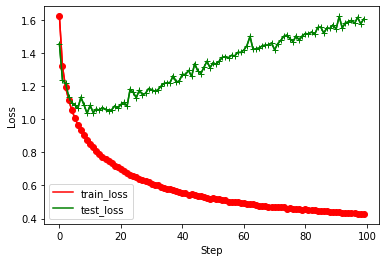

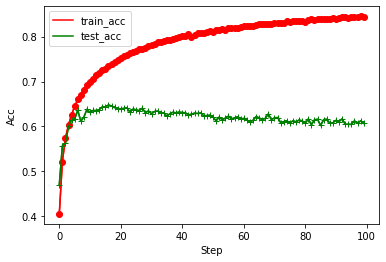

Batch size: 64


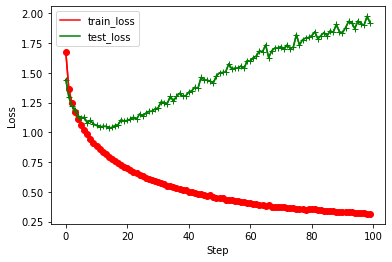

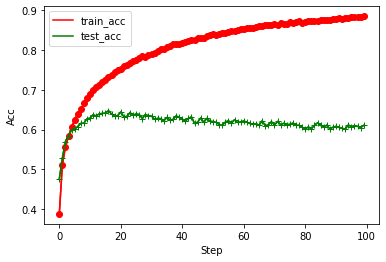

Batch size: 128


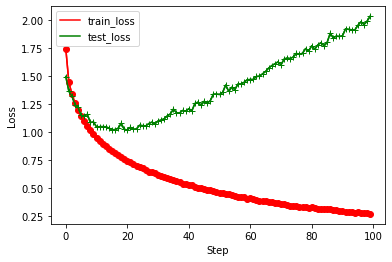

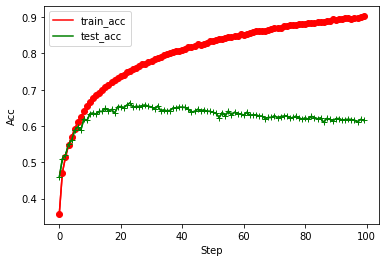

Batch size: 256


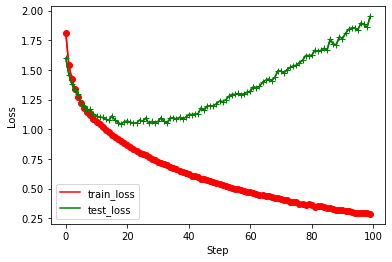

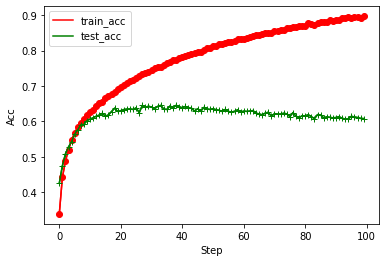

In [23]:
for i in range(len(train_loss_record_lst)):
    print("Batch size: %d" % (32 * (2 ** i)))
    x1=[i for i in range(NUM_EPOCHS)]
    y1=train_loss_record_lst[i]
    x2=x1
    y2=test_loss_record_lst[i]
    l1=plt.plot(x1,y1,'r-',label='train_loss')
    l2=plt.plot(x2,y2,'g-',label='test_loss')
    plt.plot(x1,y1,'ro-',x2,y2,'g+-')
    # plt.title('Learning curve')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    x1=[i for i in range(NUM_EPOCHS)]
    y1=train_acc_record_lst[i]
    x2=x1
    y2=test_acc_record_lst[i]
    l1=plt.plot(x1,y1,'r-',label='train_acc')
    l2=plt.plot(x2,y2,'g-',label='test_acc')
    plt.plot(x1,y1,'ro-',x2,y2,'g+-')
    # plt.title('Learning curve')
    plt.xlabel('Step')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

Theoretically, small batch size is easier to optimize and has better generalization ability, and with a larger batch size, each epoch of training takes less time and training is faster.

In this case, the batch size has no effect on the test acc, the possible reason is that all of them have reached the optimal value.

### 5. Make model more complex
It can be seen that the optimization effect is not obvious after adjusting parameters. Train loss and test loss are both relatively high, which should be **Model Bias**.

Next, I used some more complex models.

- VGG-19
- VGG-19 with batch normalization
- ResNet-18
- ResNet-50
- ResNet-152
- Densenet-121

In [24]:
LOG_PATH="./train9.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn9.pth"
    
model = models.resnet18()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
train_dataset = datasets.CIFAR10('./data', train=True, transform=transform_train, download=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform_test, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
NUM_EPOCHS = 100
print("Model: Resnet-18")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Files already downloaded and verified
Files already downloaded and verified
Model: Resnet-18
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:17, 22.39it/s]

Finish 1 epoch, Train loss: 1.400554, Train acc@1: 0.511920


Test loss: 1.219732, Test acc@1: 0.578000
Saving Best model...			Top1 = 57.800000%
Elapsed time: 19.705326557159424
---------- Training Epoch #1 ----------


391it [00:15, 25.65it/s]

Finish 2 epoch, Train loss: 1.033346, Train acc@1: 0.638660


Test loss: 1.012075, Test acc@1: 0.645800
Saving Best model...			Top1 = 64.580000%
Elapsed time: 37.31898331642151
---------- Training Epoch #2 ----------


391it [00:16, 24.10it/s]

Finish 3 epoch, Train loss: 0.862950, Train acc@1: 0.701100


Test loss: 0.997512, Test acc@1: 0.671500
Saving Best model...			Top1 = 67.150000%
Elapsed time: 55.907511472702026
---------- Training Epoch #3 ----------


391it [00:15, 24.56it/s]

Finish 4 epoch, Train loss: 0.752312, Train acc@1: 0.743420


Test loss: 0.811283, Test acc@1: 0.725900
Saving Best model...			Top1 = 72.590000%
Elapsed time: 74.13778924942017
---------- Training Epoch #4 ----------


391it [00:15, 25.46it/s]

Finish 5 epoch, Train loss: 0.661372, Train acc@1: 0.773800


Test loss: 0.906565, Test acc@1: 0.699500
Elapsed time: 91.74316811561584
---------- Training Epoch #5 ----------


391it [00:16, 24.15it/s]

Finish 6 epoch, Train loss: 0.581723, Train acc@1: 0.800700


Test loss: 0.786295, Test acc@1: 0.737400
Saving Best model...			Top1 = 73.740000%
Elapsed time: 110.22181844711304
---------- Training Epoch #6 ----------


391it [00:16, 23.85it/s]

Finish 7 epoch, Train loss: 0.515702, Train acc@1: 0.824520


Test loss: 0.736972, Test acc@1: 0.754900
Saving Best model...			Top1 = 75.490000%
Elapsed time: 128.90174889564514
---------- Training Epoch #7 ----------


391it [00:15, 25.36it/s]

Finish 8 epoch, Train loss: 0.457913, Train acc@1: 0.842220


Test loss: 0.779967, Test acc@1: 0.744500
Elapsed time: 146.50561666488647
---------- Training Epoch #8 ----------


391it [00:15, 25.11it/s]

Finish 9 epoch, Train loss: 0.401794, Train acc@1: 0.862760


Test loss: 0.746558, Test acc@1: 0.760700
Saving Best model...			Top1 = 76.070000%
Elapsed time: 164.37978053092957
---------- Training Epoch #9 ----------


391it [00:17, 22.62it/s]


Finish 10 epoch, Train loss: 0.362643, Train acc@1: 0.877320
Test loss: 0.769223, Test acc@1: 0.761000
Saving Best model...			Top1 = 76.100000%
Elapsed time: 183.94994235038757
---------- Training Epoch #10 ----------


391it [00:16, 23.85it/s]

Finish 11 epoch, Train loss: 0.322682, Train acc@1: 0.890060


Test loss: 0.821680, Test acc@1: 0.755900
Elapsed time: 202.55120730400085
---------- Training Epoch #11 ----------


391it [00:15, 25.96it/s]

Finish 12 epoch, Train loss: 0.295482, Train acc@1: 0.898760


Test loss: 0.852548, Test acc@1: 0.758200
Elapsed time: 219.88094997406006
---------- Training Epoch #12 ----------


391it [00:15, 25.52it/s]

Finish 13 epoch, Train loss: 0.265410, Train acc@1: 0.908900


Test loss: 0.803047, Test acc@1: 0.764900
Saving Best model...			Top1 = 76.490000%
Elapsed time: 237.47099232673645
---------- Training Epoch #13 ----------


391it [00:15, 25.63it/s]

Finish 14 epoch, Train loss: 0.242731, Train acc@1: 0.917300


Test loss: 0.871315, Test acc@1: 0.754500
Elapsed time: 254.91330575942993
---------- Training Epoch #14 ----------


391it [00:15, 25.57it/s]

Finish 15 epoch, Train loss: 0.230947, Train acc@1: 0.919940


Test loss: 0.863902, Test acc@1: 0.756600
Elapsed time: 272.4564411640167
---------- Training Epoch #15 ----------


391it [00:14, 26.58it/s]

Finish 16 epoch, Train loss: 0.220126, Train acc@1: 0.925480


Test loss: 0.905950, Test acc@1: 0.747400
Elapsed time: 289.30957889556885
---------- Training Epoch #16 ----------


391it [00:15, 24.70it/s]

Finish 17 epoch, Train loss: 0.207241, Train acc@1: 0.929400


Test loss: 0.867610, Test acc@1: 0.763000
Elapsed time: 307.4344689846039
---------- Training Epoch #17 ----------


391it [00:15, 25.23it/s]

Finish 18 epoch, Train loss: 0.197201, Train acc@1: 0.932980


Test loss: 0.940665, Test acc@1: 0.749500
Elapsed time: 325.206209897995
---------- Training Epoch #18 ----------


391it [00:15, 25.78it/s]

Finish 19 epoch, Train loss: 0.184526, Train acc@1: 0.936060


Test loss: 0.904924, Test acc@1: 0.757700
Elapsed time: 342.59513306617737
---------- Training Epoch #19 ----------


391it [00:15, 25.93it/s]

Finish 20 epoch, Train loss: 0.182729, Train acc@1: 0.937120


Test loss: 0.882372, Test acc@1: 0.760900
Elapsed time: 359.7924897670746
---------- Training Epoch #20 ----------


391it [00:16, 24.26it/s]

Finish 21 epoch, Train loss: 0.178868, Train acc@1: 0.939140


Test loss: 0.938629, Test acc@1: 0.753900
Elapsed time: 378.0892014503479
---------- Training Epoch #21 ----------


391it [00:15, 26.00it/s]

Finish 22 epoch, Train loss: 0.170595, Train acc@1: 0.942100


Test loss: 0.959933, Test acc@1: 0.751400
Elapsed time: 395.3803930282593
---------- Training Epoch #22 ----------


391it [00:15, 24.91it/s]


Finish 23 epoch, Train loss: 0.168769, Train acc@1: 0.943120
Test loss: 0.937134, Test acc@1: 0.754700
Elapsed time: 413.224289894104
---------- Training Epoch #23 ----------


391it [00:15, 26.06it/s]

Finish 24 epoch, Train loss: 0.159664, Train acc@1: 0.945500


Test loss: 0.974274, Test acc@1: 0.761200
Elapsed time: 430.5050048828125
---------- Training Epoch #24 ----------


391it [00:15, 25.27it/s]

Finish 25 epoch, Train loss: 0.165337, Train acc@1: 0.943820


Test loss: 0.905221, Test acc@1: 0.764300
Elapsed time: 448.2114210128784
---------- Training Epoch #25 ----------


391it [00:15, 25.83it/s]

Finish 26 epoch, Train loss: 0.156081, Train acc@1: 0.946940


Test loss: 0.940950, Test acc@1: 0.760800
Elapsed time: 465.54451394081116
---------- Training Epoch #26 ----------


391it [00:15, 25.35it/s]

Finish 27 epoch, Train loss: 0.155276, Train acc@1: 0.947500


Test loss: 0.944220, Test acc@1: 0.758500
Elapsed time: 483.2226400375366
---------- Training Epoch #27 ----------


391it [00:15, 26.06it/s]

Finish 28 epoch, Train loss: 0.149672, Train acc@1: 0.947640


Test loss: 0.960933, Test acc@1: 0.757100
Elapsed time: 500.5098752975464
---------- Training Epoch #28 ----------


391it [00:15, 25.66it/s]

Finish 29 epoch, Train loss: 0.149155, Train acc@1: 0.949120


Test loss: 0.985345, Test acc@1: 0.754700
Elapsed time: 517.8963508605957
---------- Training Epoch #29 ----------


391it [00:16, 24.33it/s]

Finish 30 epoch, Train loss: 0.149992, Train acc@1: 0.949040


Test loss: 1.002891, Test acc@1: 0.751900
Elapsed time: 536.2479681968689
---------- Training Epoch #30 ----------


391it [00:16, 23.54it/s]

Finish 31 epoch, Train loss: 0.146933, Train acc@1: 0.950180


Test loss: 0.980651, Test acc@1: 0.762400
Elapsed time: 555.002151966095
---------- Training Epoch #31 ----------


391it [00:15, 25.56it/s]

Finish 32 epoch, Train loss: 0.145707, Train acc@1: 0.950460


Test loss: 0.966058, Test acc@1: 0.754900
Elapsed time: 572.4718592166901
---------- Training Epoch #32 ----------


391it [00:15, 25.91it/s]

Finish 33 epoch, Train loss: 0.143426, Train acc@1: 0.950980


Test loss: 0.973230, Test acc@1: 0.757300
Elapsed time: 589.8791260719299
---------- Training Epoch #33 ----------


391it [00:15, 25.46it/s]

Finish 34 epoch, Train loss: 0.145304, Train acc@1: 0.950740


Test loss: 0.964666, Test acc@1: 0.761400
Elapsed time: 607.4403524398804
---------- Training Epoch #34 ----------


391it [00:15, 25.48it/s]

Finish 35 epoch, Train loss: 0.139785, Train acc@1: 0.951940


Test loss: 0.986042, Test acc@1: 0.758000
Elapsed time: 624.9515790939331
---------- Training Epoch #35 ----------


391it [00:14, 26.96it/s]

Finish 36 epoch, Train loss: 0.138323, Train acc@1: 0.953180


Test loss: 0.957992, Test acc@1: 0.761700
Elapsed time: 641.7133328914642
---------- Training Epoch #36 ----------


391it [00:14, 26.45it/s]

Finish 37 epoch, Train loss: 0.134277, Train acc@1: 0.953600


Test loss: 0.934240, Test acc@1: 0.762200
Elapsed time: 658.7722194194794
---------- Training Epoch #37 ----------


391it [00:15, 25.16it/s]

Finish 38 epoch, Train loss: 0.136041, Train acc@1: 0.953260


Test loss: 0.978355, Test acc@1: 0.756900
Elapsed time: 676.6220219135284
---------- Training Epoch #38 ----------


391it [00:15, 24.56it/s]

Finish 39 epoch, Train loss: 0.134610, Train acc@1: 0.954280


Test loss: 0.985762, Test acc@1: 0.762300
Elapsed time: 694.7044274806976
---------- Training Epoch #39 ----------


391it [00:15, 25.50it/s]


Finish 40 epoch, Train loss: 0.134999, Train acc@1: 0.953080
Test loss: 0.994200, Test acc@1: 0.758700
Elapsed time: 712.7447669506073
---------- Training Epoch #40 ----------


391it [00:15, 25.77it/s]

Finish 41 epoch, Train loss: 0.129750, Train acc@1: 0.956060


Test loss: 0.977072, Test acc@1: 0.761500
Elapsed time: 730.240816116333
---------- Training Epoch #41 ----------


391it [00:15, 24.86it/s]

Finish 42 epoch, Train loss: 0.130717, Train acc@1: 0.955180


Test loss: 0.983755, Test acc@1: 0.759200
Elapsed time: 748.1071894168854
---------- Training Epoch #42 ----------


391it [00:14, 26.43it/s]

Finish 43 epoch, Train loss: 0.127184, Train acc@1: 0.956180


Test loss: 0.996283, Test acc@1: 0.762400
Elapsed time: 765.1671407222748
---------- Training Epoch #43 ----------


391it [00:15, 24.57it/s]

Finish 44 epoch, Train loss: 0.128544, Train acc@1: 0.956440


Test loss: 0.966498, Test acc@1: 0.761000
Elapsed time: 783.2769057750702
---------- Training Epoch #44 ----------


391it [00:14, 26.19it/s]

Finish 45 epoch, Train loss: 0.128585, Train acc@1: 0.956460


Test loss: 1.007241, Test acc@1: 0.758600
Elapsed time: 800.459246635437
---------- Training Epoch #45 ----------


391it [00:15, 24.90it/s]

Finish 46 epoch, Train loss: 0.129016, Train acc@1: 0.955400


Test loss: 1.007952, Test acc@1: 0.757000
Elapsed time: 818.4159734249115
---------- Training Epoch #46 ----------


391it [00:15, 24.91it/s]

Finish 47 epoch, Train loss: 0.128714, Train acc@1: 0.956940


Test loss: 1.020780, Test acc@1: 0.759900
Elapsed time: 836.4192705154419
---------- Training Epoch #47 ----------


391it [00:15, 25.53it/s]

Finish 48 epoch, Train loss: 0.126868, Train acc@1: 0.956640


Test loss: 1.035763, Test acc@1: 0.754700
Elapsed time: 853.9986925125122
---------- Training Epoch #48 ----------


391it [00:15, 25.53it/s]

Finish 49 epoch, Train loss: 0.123616, Train acc@1: 0.957880


Test loss: 1.068216, Test acc@1: 0.750000
Elapsed time: 871.5057783126831
---------- Training Epoch #49 ----------


391it [00:15, 25.45it/s]

Finish 50 epoch, Train loss: 0.122904, Train acc@1: 0.958480


Test loss: 1.028694, Test acc@1: 0.752900
Elapsed time: 889.0762984752655
---------- Training Epoch #50 ----------


391it [00:15, 25.43it/s]

Finish 51 epoch, Train loss: 0.121592, Train acc@1: 0.958520


Test loss: 1.016915, Test acc@1: 0.757100
Elapsed time: 906.7097096443176
---------- Training Epoch #51 ----------


391it [00:16, 24.26it/s]

Finish 52 epoch, Train loss: 0.123649, Train acc@1: 0.959120


Test loss: 1.004821, Test acc@1: 0.757000
Elapsed time: 925.0365917682648
---------- Training Epoch #52 ----------


391it [00:15, 25.31it/s]

Finish 53 epoch, Train loss: 0.119377, Train acc@1: 0.959540


Test loss: 1.013916, Test acc@1: 0.759100
Elapsed time: 942.7147126197815
---------- Training Epoch #53 ----------


391it [00:15, 25.78it/s]

Finish 54 epoch, Train loss: 0.116891, Train acc@1: 0.959740


Test loss: 1.029496, Test acc@1: 0.757400
Elapsed time: 960.0214006900787
---------- Training Epoch #54 ----------


391it [00:15, 25.61it/s]

Finish 55 epoch, Train loss: 0.117078, Train acc@1: 0.960060


Test loss: 1.010992, Test acc@1: 0.760900
Elapsed time: 977.5059962272644
---------- Training Epoch #55 ----------


391it [00:15, 25.73it/s]

Finish 56 epoch, Train loss: 0.119596, Train acc@1: 0.959220


Test loss: 1.031896, Test acc@1: 0.753700
Elapsed time: 994.840541601181
---------- Training Epoch #56 ----------


391it [00:14, 26.09it/s]

Finish 57 epoch, Train loss: 0.119785, Train acc@1: 0.960200


Test loss: 1.009501, Test acc@1: 0.756400
Elapsed time: 1011.9768018722534
---------- Training Epoch #57 ----------


391it [00:16, 24.39it/s]

Finish 58 epoch, Train loss: 0.114218, Train acc@1: 0.961380


Test loss: 1.029440, Test acc@1: 0.759200
Elapsed time: 1030.1893110275269
---------- Training Epoch #58 ----------


391it [00:15, 25.38it/s]

Finish 59 epoch, Train loss: 0.117155, Train acc@1: 0.959820


Test loss: 1.029170, Test acc@1: 0.755000
Elapsed time: 1047.8088901042938
---------- Training Epoch #59 ----------


391it [00:14, 26.17it/s]

Finish 60 epoch, Train loss: 0.118481, Train acc@1: 0.959460


Test loss: 1.020869, Test acc@1: 0.759500
Elapsed time: 1064.9262685775757
---------- Training Epoch #60 ----------


391it [00:15, 25.93it/s]

Finish 61 epoch, Train loss: 0.119838, Train acc@1: 0.959100


Test loss: 0.995652, Test acc@1: 0.760100
Elapsed time: 1082.1804823875427
---------- Training Epoch #61 ----------


391it [00:15, 25.06it/s]

Finish 62 epoch, Train loss: 0.118320, Train acc@1: 0.959840


Test loss: 1.053127, Test acc@1: 0.756800
Elapsed time: 1100.0116424560547
---------- Training Epoch #62 ----------


391it [00:15, 25.60it/s]

Finish 63 epoch, Train loss: 0.111436, Train acc@1: 0.961960


Test loss: 1.053884, Test acc@1: 0.753300
Elapsed time: 1117.4673855304718
---------- Training Epoch #63 ----------


391it [00:16, 23.97it/s]

Finish 64 epoch, Train loss: 0.113683, Train acc@1: 0.961580


Test loss: 1.002622, Test acc@1: 0.766000
Saving Best model...			Top1 = 76.600000%
Elapsed time: 1136.0973591804504
---------- Training Epoch #64 ----------


391it [00:15, 24.85it/s]

Finish 65 epoch, Train loss: 0.117917, Train acc@1: 0.959480


Test loss: 0.999304, Test acc@1: 0.763700
Elapsed time: 1154.0457055568695
---------- Training Epoch #65 ----------


391it [00:15, 25.32it/s]

Finish 66 epoch, Train loss: 0.116198, Train acc@1: 0.960740


Test loss: 0.997341, Test acc@1: 0.760000
Elapsed time: 1171.768814086914
---------- Training Epoch #66 ----------


391it [00:15, 25.43it/s]

Finish 67 epoch, Train loss: 0.115376, Train acc@1: 0.961880


Test loss: 1.127935, Test acc@1: 0.747000
Elapsed time: 1189.3196139335632
---------- Training Epoch #67 ----------


391it [00:15, 25.68it/s]

Finish 68 epoch, Train loss: 0.112333, Train acc@1: 0.962060


Test loss: 1.033962, Test acc@1: 0.758100
Elapsed time: 1207.2777330875397
---------- Training Epoch #68 ----------


391it [00:15, 25.51it/s]

Finish 69 epoch, Train loss: 0.115566, Train acc@1: 0.961100


Test loss: 1.000561, Test acc@1: 0.758700
Elapsed time: 1224.7761754989624
---------- Training Epoch #69 ----------


391it [00:15, 25.66it/s]

Finish 70 epoch, Train loss: 0.117978, Train acc@1: 0.960160


Test loss: 1.024731, Test acc@1: 0.761700
Elapsed time: 1242.319016456604
---------- Training Epoch #70 ----------


391it [00:15, 25.60it/s]

Finish 71 epoch, Train loss: 0.113395, Train acc@1: 0.961940


Test loss: 1.035298, Test acc@1: 0.756800
Elapsed time: 1259.7248797416687
---------- Training Epoch #71 ----------


391it [00:15, 25.10it/s]

Finish 72 epoch, Train loss: 0.114170, Train acc@1: 0.961900


Test loss: 1.011224, Test acc@1: 0.757200
Elapsed time: 1277.5169761180878
---------- Training Epoch #72 ----------


391it [00:15, 25.57it/s]

Finish 73 epoch, Train loss: 0.111663, Train acc@1: 0.962480


Test loss: 1.056492, Test acc@1: 0.755300
Elapsed time: 1295.1573774814606
---------- Training Epoch #73 ----------


391it [00:15, 24.95it/s]

Finish 74 epoch, Train loss: 0.114150, Train acc@1: 0.960980


Test loss: 0.980510, Test acc@1: 0.761400
Elapsed time: 1313.0819687843323
---------- Training Epoch #74 ----------


391it [00:14, 26.49it/s]

Finish 75 epoch, Train loss: 0.114832, Train acc@1: 0.960820


Test loss: 1.046144, Test acc@1: 0.751400
Elapsed time: 1330.10023021698
---------- Training Epoch #75 ----------


391it [00:15, 25.45it/s]

Finish 76 epoch, Train loss: 0.112900, Train acc@1: 0.962360


Test loss: 1.041004, Test acc@1: 0.757100
Elapsed time: 1347.6749935150146
---------- Training Epoch #76 ----------


391it [00:14, 26.23it/s]

Finish 77 epoch, Train loss: 0.111763, Train acc@1: 0.962160


Test loss: 1.052676, Test acc@1: 0.757600
Elapsed time: 1364.799961090088
---------- Training Epoch #77 ----------


391it [00:15, 25.35it/s]

Finish 78 epoch, Train loss: 0.109374, Train acc@1: 0.962760


Test loss: 1.046724, Test acc@1: 0.750500
Elapsed time: 1382.4120173454285
---------- Training Epoch #78 ----------


391it [00:15, 26.01it/s]

Finish 79 epoch, Train loss: 0.112367, Train acc@1: 0.962960


Test loss: 1.054823, Test acc@1: 0.759000
Elapsed time: 1399.5984334945679
---------- Training Epoch #79 ----------


391it [00:15, 25.44it/s]

Finish 80 epoch, Train loss: 0.109035, Train acc@1: 0.963440


Test loss: 1.085210, Test acc@1: 0.753000
Elapsed time: 1417.1959929466248
---------- Training Epoch #80 ----------


391it [00:15, 25.61it/s]


Finish 81 epoch, Train loss: 0.108496, Train acc@1: 0.964000
Test loss: 1.064515, Test acc@1: 0.751000
Elapsed time: 1434.7085106372833
---------- Training Epoch #81 ----------


391it [00:15, 25.71it/s]

Finish 82 epoch, Train loss: 0.108114, Train acc@1: 0.963220


Test loss: 1.048204, Test acc@1: 0.754600
Elapsed time: 1452.1794316768646
---------- Training Epoch #82 ----------


391it [00:14, 26.27it/s]

Finish 83 epoch, Train loss: 0.106740, Train acc@1: 0.963120


Test loss: 1.046189, Test acc@1: 0.759900
Elapsed time: 1469.3238534927368
---------- Training Epoch #83 ----------


391it [00:15, 25.96it/s]

Finish 84 epoch, Train loss: 0.110586, Train acc@1: 0.962960


Test loss: 1.048663, Test acc@1: 0.752200
Elapsed time: 1486.5470113754272
---------- Training Epoch #84 ----------


391it [00:14, 26.16it/s]

Finish 85 epoch, Train loss: 0.109040, Train acc@1: 0.963900


Test loss: 1.033726, Test acc@1: 0.761400
Elapsed time: 1503.810742855072
---------- Training Epoch #85 ----------


391it [00:15, 25.01it/s]

Finish 86 epoch, Train loss: 0.108663, Train acc@1: 0.963840


Test loss: 1.087659, Test acc@1: 0.751000
Elapsed time: 1521.6307363510132
---------- Training Epoch #86 ----------


391it [00:15, 26.04it/s]

Finish 87 epoch, Train loss: 0.112494, Train acc@1: 0.961760


Test loss: 1.067876, Test acc@1: 0.750300
Elapsed time: 1538.966017961502
---------- Training Epoch #87 ----------


391it [00:15, 25.73it/s]

Finish 88 epoch, Train loss: 0.101602, Train acc@1: 0.966360


Test loss: 1.036742, Test acc@1: 0.766400
Saving Best model...			Top1 = 76.640000%
Elapsed time: 1556.6685857772827
---------- Training Epoch #88 ----------


391it [00:15, 25.45it/s]

Finish 89 epoch, Train loss: 0.109008, Train acc@1: 0.963340


Test loss: 1.045111, Test acc@1: 0.751200
Elapsed time: 1574.227463722229
---------- Training Epoch #89 ----------


391it [00:14, 26.46it/s]


Finish 90 epoch, Train loss: 0.105619, Train acc@1: 0.964460
Test loss: 1.040488, Test acc@1: 0.758800
Elapsed time: 1591.3204889297485
---------- Training Epoch #90 ----------


391it [00:15, 24.94it/s]

Finish 91 epoch, Train loss: 0.105163, Train acc@1: 0.964660


Test loss: 1.059067, Test acc@1: 0.757700
Elapsed time: 1609.258388519287
---------- Training Epoch #91 ----------


391it [00:15, 25.94it/s]

Finish 92 epoch, Train loss: 0.108111, Train acc@1: 0.963480


Test loss: 1.035231, Test acc@1: 0.757800
Elapsed time: 1626.6016459465027
---------- Training Epoch #92 ----------


391it [00:15, 25.39it/s]

Finish 93 epoch, Train loss: 0.105493, Train acc@1: 0.963920


Test loss: 1.073513, Test acc@1: 0.748200
Elapsed time: 1644.5240318775177
---------- Training Epoch #93 ----------


391it [00:14, 26.60it/s]

Finish 94 epoch, Train loss: 0.104538, Train acc@1: 0.964660


Test loss: 1.033727, Test acc@1: 0.763200
Elapsed time: 1661.4425449371338
---------- Training Epoch #94 ----------


391it [00:15, 25.71it/s]


Finish 95 epoch, Train loss: 0.110002, Train acc@1: 0.963480
Test loss: 1.044481, Test acc@1: 0.754500
Elapsed time: 1678.8956561088562
---------- Training Epoch #95 ----------


391it [00:15, 25.79it/s]

Finish 96 epoch, Train loss: 0.104754, Train acc@1: 0.964560


Test loss: 1.043348, Test acc@1: 0.758200
Elapsed time: 1696.2485098838806
---------- Training Epoch #96 ----------


391it [00:15, 25.82it/s]

Finish 97 epoch, Train loss: 0.107920, Train acc@1: 0.964500


Test loss: 1.087370, Test acc@1: 0.753100
Elapsed time: 1713.6261520385742
---------- Training Epoch #97 ----------


391it [00:15, 25.66it/s]

Finish 98 epoch, Train loss: 0.105327, Train acc@1: 0.964700


Test loss: 1.048133, Test acc@1: 0.752600
Elapsed time: 1730.9899282455444
---------- Training Epoch #98 ----------


391it [00:15, 25.76it/s]

Finish 99 epoch, Train loss: 0.106071, Train acc@1: 0.964080


Test loss: 1.073860, Test acc@1: 0.753800
Elapsed time: 1748.405842781067
---------- Training Epoch #99 ----------


391it [00:15, 24.78it/s]

Finish 100 epoch, Train loss: 0.103089, Train acc@1: 0.965080


Test loss: 1.061691, Test acc@1: 0.755400
Elapsed time: 1766.495016336441

Test results: Acc@1 = 76.640000%


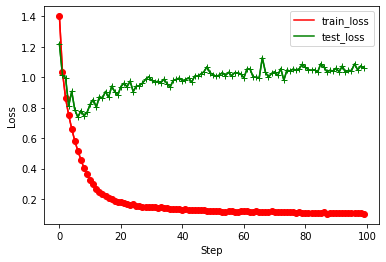

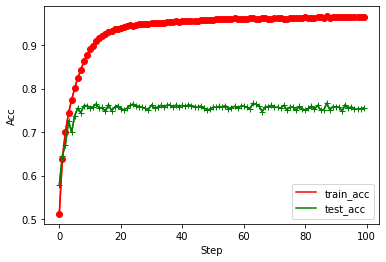

In [25]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [26]:
LOG_PATH="./train10.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn10.pth"
    
model = models.resnet50()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 100
print("Model: Resnet-50")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: Resnet-50
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:37, 10.47it/s]

Finish 1 epoch, Train loss: 1.786487, Train acc@1: 0.392020


Test loss: 1.431800, Test acc@1: 0.483200
Saving Best model...			Top1 = 48.320000%
Elapsed time: 40.33898949623108
---------- Training Epoch #1 ----------


391it [00:36, 10.73it/s]

Finish 2 epoch, Train loss: 1.422992, Train acc@1: 0.505640


Test loss: 1.253575, Test acc@1: 0.556800
Saving Best model...			Top1 = 55.680000%
Elapsed time: 79.87989139556885
---------- Training Epoch #2 ----------


391it [00:35, 10.90it/s]

Finish 3 epoch, Train loss: 1.148715, Train acc@1: 0.602040


Test loss: 1.126103, Test acc@1: 0.611600
Saving Best model...			Top1 = 61.160000%
Elapsed time: 118.84694242477417
---------- Training Epoch #3 ----------


391it [00:35, 10.93it/s]

Finish 4 epoch, Train loss: 0.978664, Train acc@1: 0.662660


Test loss: 1.046501, Test acc@1: 0.642500
Saving Best model...			Top1 = 64.250000%
Elapsed time: 157.77684092521667
---------- Training Epoch #4 ----------


391it [00:35, 10.87it/s]

Finish 5 epoch, Train loss: 0.849440, Train acc@1: 0.710220


Test loss: 0.948433, Test acc@1: 0.677000
Saving Best model...			Top1 = 67.700000%
Elapsed time: 196.7884223461151
---------- Training Epoch #5 ----------


391it [00:35, 10.98it/s]

Finish 6 epoch, Train loss: 0.752912, Train acc@1: 0.743760


Test loss: 0.924436, Test acc@1: 0.690900
Saving Best model...			Top1 = 69.090000%
Elapsed time: 235.5991988182068
---------- Training Epoch #6 ----------


391it [00:37, 10.57it/s]


Finish 7 epoch, Train loss: 0.675281, Train acc@1: 0.770100
Test loss: 0.808273, Test acc@1: 0.724900
Saving Best model...			Top1 = 72.490000%
Elapsed time: 275.77534651756287
---------- Training Epoch #7 ----------


391it [00:33, 11.72it/s]

Finish 8 epoch, Train loss: 0.601694, Train acc@1: 0.795600


Test loss: 0.795852, Test acc@1: 0.738600
Saving Best model...			Top1 = 73.860000%
Elapsed time: 313.1819911003113
---------- Training Epoch #8 ----------


391it [00:35, 10.93it/s]

Finish 9 epoch, Train loss: 0.551125, Train acc@1: 0.812840


Test loss: 0.760427, Test acc@1: 0.747400
Saving Best model...			Top1 = 74.740000%
Elapsed time: 352.36682200431824
---------- Training Epoch #9 ----------


391it [00:36, 10.66it/s]

Finish 10 epoch, Train loss: 0.503750, Train acc@1: 0.829280


Test loss: 0.872187, Test acc@1: 0.724700
Elapsed time: 392.3308050632477
---------- Training Epoch #10 ----------


391it [00:36, 10.80it/s]

Finish 11 epoch, Train loss: 0.461683, Train acc@1: 0.843160


Test loss: 0.764506, Test acc@1: 0.752600
Saving Best model...			Top1 = 75.260000%
Elapsed time: 431.6763379573822
---------- Training Epoch #11 ----------


391it [00:34, 11.22it/s]

Finish 12 epoch, Train loss: 0.428485, Train acc@1: 0.855340


Test loss: 0.779295, Test acc@1: 0.754200
Saving Best model...			Top1 = 75.420000%
Elapsed time: 469.7645525932312
---------- Training Epoch #12 ----------


391it [00:36, 10.71it/s]

Finish 13 epoch, Train loss: 0.396794, Train acc@1: 0.864680


Test loss: 0.812732, Test acc@1: 0.751500
Elapsed time: 509.2361776828766
---------- Training Epoch #13 ----------


391it [00:35, 11.04it/s]

Finish 14 epoch, Train loss: 0.363556, Train acc@1: 0.877520


Test loss: 0.721365, Test acc@1: 0.769200
Saving Best model...			Top1 = 76.920000%
Elapsed time: 547.7162551879883
---------- Training Epoch #14 ----------


391it [00:35, 11.00it/s]

Finish 15 epoch, Train loss: 0.348683, Train acc@1: 0.882220


Test loss: 0.756738, Test acc@1: 0.770200
Saving Best model...			Top1 = 77.020000%
Elapsed time: 586.3890373706818
---------- Training Epoch #15 ----------


391it [00:35, 11.00it/s]

Finish 16 epoch, Train loss: 0.319098, Train acc@1: 0.892600


Test loss: 0.771632, Test acc@1: 0.768800
Elapsed time: 624.8007156848907
---------- Training Epoch #16 ----------


391it [00:36, 10.78it/s]

Finish 17 epoch, Train loss: 0.305533, Train acc@1: 0.897200


Test loss: 0.731361, Test acc@1: 0.778100
Saving Best model...			Top1 = 77.810000%
Elapsed time: 664.2541358470917
---------- Training Epoch #17 ----------


391it [00:35, 11.00it/s]

Finish 18 epoch, Train loss: 0.290152, Train acc@1: 0.901520


Test loss: 0.792200, Test acc@1: 0.761200
Elapsed time: 702.6460146903992
---------- Training Epoch #18 ----------


391it [00:35, 11.00it/s]

Finish 19 epoch, Train loss: 0.281135, Train acc@1: 0.904620


Test loss: 0.759580, Test acc@1: 0.770300
Elapsed time: 741.1056280136108
---------- Training Epoch #19 ----------


391it [00:34, 11.25it/s]

Finish 20 epoch, Train loss: 0.273049, Train acc@1: 0.906520


Test loss: 0.782207, Test acc@1: 0.775600
Elapsed time: 778.6301362514496
---------- Training Epoch #20 ----------


391it [00:35, 10.98it/s]

Finish 21 epoch, Train loss: 0.254816, Train acc@1: 0.914880


Test loss: 0.783409, Test acc@1: 0.769700
Elapsed time: 817.1563415527344
---------- Training Epoch #21 ----------


391it [00:35, 11.00it/s]

Finish 22 epoch, Train loss: 0.251394, Train acc@1: 0.914960


Test loss: 0.797765, Test acc@1: 0.768100
Elapsed time: 855.5892856121063
---------- Training Epoch #22 ----------


391it [00:35, 11.02it/s]

Finish 23 epoch, Train loss: 0.243221, Train acc@1: 0.918020


Test loss: 0.845915, Test acc@1: 0.764100
Elapsed time: 894.8772618770599
---------- Training Epoch #23 ----------


391it [00:35, 10.92it/s]

Finish 24 epoch, Train loss: 0.233198, Train acc@1: 0.921180


Test loss: 0.818724, Test acc@1: 0.758100
Elapsed time: 933.5357122421265
---------- Training Epoch #24 ----------


391it [00:35, 11.08it/s]

Finish 25 epoch, Train loss: 0.234322, Train acc@1: 0.919960


Test loss: 0.799606, Test acc@1: 0.773700
Elapsed time: 971.7939250469208
---------- Training Epoch #25 ----------


391it [00:36, 10.71it/s]

Finish 26 epoch, Train loss: 0.227715, Train acc@1: 0.923080


Test loss: 0.786500, Test acc@1: 0.773400
Elapsed time: 1011.2858638763428
---------- Training Epoch #26 ----------


391it [00:35, 10.92it/s]

Finish 27 epoch, Train loss: 0.209929, Train acc@1: 0.928660


Test loss: 0.832476, Test acc@1: 0.770400
Elapsed time: 1050.088998556137
---------- Training Epoch #27 ----------


391it [00:36, 10.76it/s]

Finish 28 epoch, Train loss: 0.203823, Train acc@1: 0.929580


Test loss: 0.812183, Test acc@1: 0.780000
Saving Best model...			Top1 = 78.000000%
Elapsed time: 1089.945256471634
---------- Training Epoch #28 ----------


391it [00:35, 10.87it/s]

Finish 29 epoch, Train loss: 0.202650, Train acc@1: 0.930580


Test loss: 0.836020, Test acc@1: 0.770500
Elapsed time: 1128.7271845340729
---------- Training Epoch #29 ----------


391it [00:34, 11.34it/s]


Finish 30 epoch, Train loss: 0.202406, Train acc@1: 0.932040
Test loss: 0.835362, Test acc@1: 0.769200
Elapsed time: 1166.129413843155
---------- Training Epoch #30 ----------


391it [00:35, 11.01it/s]

Finish 31 epoch, Train loss: 0.197732, Train acc@1: 0.933740


Test loss: 0.814637, Test acc@1: 0.774800
Elapsed time: 1204.8985576629639
---------- Training Epoch #31 ----------


391it [00:35, 10.93it/s]

Finish 32 epoch, Train loss: 0.199480, Train acc@1: 0.932480


Test loss: 0.806321, Test acc@1: 0.776600
Elapsed time: 1243.506210565567
---------- Training Epoch #32 ----------


391it [00:35, 11.01it/s]

Finish 33 epoch, Train loss: 0.198109, Train acc@1: 0.933180


Test loss: 0.840562, Test acc@1: 0.765900
Elapsed time: 1281.9873807430267
---------- Training Epoch #33 ----------


391it [00:35, 10.94it/s]

Finish 34 epoch, Train loss: 0.197205, Train acc@1: 0.932940


Test loss: 0.795386, Test acc@1: 0.778100
Elapsed time: 1320.6308853626251
---------- Training Epoch #34 ----------


391it [00:35, 11.08it/s]

Finish 35 epoch, Train loss: 0.186561, Train acc@1: 0.936600


Test loss: 0.846699, Test acc@1: 0.769400
Elapsed time: 1358.7855541706085
---------- Training Epoch #35 ----------


391it [00:35, 10.91it/s]

Finish 36 epoch, Train loss: 0.183578, Train acc@1: 0.937140


Test loss: 0.869711, Test acc@1: 0.772000
Elapsed time: 1397.6128499507904
---------- Training Epoch #36 ----------


391it [00:35, 10.88it/s]

Finish 37 epoch, Train loss: 0.183549, Train acc@1: 0.938200


Test loss: 0.849559, Test acc@1: 0.773600
Elapsed time: 1436.4226081371307
---------- Training Epoch #37 ----------


391it [00:30, 12.69it/s]

Finish 38 epoch, Train loss: 0.184031, Train acc@1: 0.938840


Test loss: 0.848938, Test acc@1: 0.772900
Elapsed time: 1470.1867377758026
---------- Training Epoch #38 ----------


391it [00:34, 11.26it/s]

Finish 39 epoch, Train loss: 0.180753, Train acc@1: 0.939260


Test loss: 0.884717, Test acc@1: 0.767900
Elapsed time: 1507.794156551361
---------- Training Epoch #39 ----------


391it [00:35, 10.95it/s]

Finish 40 epoch, Train loss: 0.178441, Train acc@1: 0.939180


Test loss: 0.827203, Test acc@1: 0.778700
Elapsed time: 1547.0028049945831
---------- Training Epoch #40 ----------


391it [00:36, 10.78it/s]

Finish 41 epoch, Train loss: 0.177890, Train acc@1: 0.939520


Test loss: 0.871545, Test acc@1: 0.766000
Elapsed time: 1586.217036485672
---------- Training Epoch #41 ----------


391it [00:35, 10.96it/s]

Finish 42 epoch, Train loss: 0.176463, Train acc@1: 0.940240


Test loss: 0.897518, Test acc@1: 0.765600
Elapsed time: 1624.7797102928162
---------- Training Epoch #42 ----------


391it [00:35, 10.98it/s]

Finish 43 epoch, Train loss: 0.170694, Train acc@1: 0.942360


Test loss: 0.875003, Test acc@1: 0.774200
Elapsed time: 1663.2701604366302
---------- Training Epoch #43 ----------


391it [00:35, 11.16it/s]

Finish 44 epoch, Train loss: 0.172384, Train acc@1: 0.942460


Test loss: 0.828118, Test acc@1: 0.774100
Elapsed time: 1701.189185142517
---------- Training Epoch #44 ----------


391it [00:35, 11.09it/s]

Finish 45 epoch, Train loss: 0.167389, Train acc@1: 0.943240


Test loss: 0.850323, Test acc@1: 0.772300
Elapsed time: 1739.291228055954
---------- Training Epoch #45 ----------


391it [00:34, 11.20it/s]

Finish 46 epoch, Train loss: 0.164221, Train acc@1: 0.943340


Test loss: 0.826327, Test acc@1: 0.785900
Saving Best model...			Top1 = 78.590000%
Elapsed time: 1777.4105575084686
---------- Training Epoch #46 ----------


391it [00:35, 11.15it/s]

Finish 47 epoch, Train loss: 0.164176, Train acc@1: 0.943780


Test loss: 0.876263, Test acc@1: 0.775800
Elapsed time: 1815.3916792869568
---------- Training Epoch #47 ----------


391it [00:34, 11.35it/s]

Finish 48 epoch, Train loss: 0.165513, Train acc@1: 0.943340


Test loss: 0.822988, Test acc@1: 0.782400
Elapsed time: 1852.729617357254
---------- Training Epoch #48 ----------


391it [00:33, 11.60it/s]

Finish 49 epoch, Train loss: 0.161044, Train acc@1: 0.945720


Test loss: 0.834751, Test acc@1: 0.777200
Elapsed time: 1889.3653781414032
---------- Training Epoch #49 ----------


391it [00:35, 11.10it/s]

Finish 50 epoch, Train loss: 0.161847, Train acc@1: 0.944660


Test loss: 0.805067, Test acc@1: 0.785400
Elapsed time: 1927.4930579662323
---------- Training Epoch #50 ----------


391it [00:35, 11.01it/s]

Finish 51 epoch, Train loss: 0.160515, Train acc@1: 0.945040


Test loss: 0.871397, Test acc@1: 0.772100
Elapsed time: 1965.90208029747
---------- Training Epoch #51 ----------


391it [00:35, 11.04it/s]

Finish 52 epoch, Train loss: 0.157393, Train acc@1: 0.946300


Test loss: 0.890963, Test acc@1: 0.765000
Elapsed time: 2004.142523765564
---------- Training Epoch #52 ----------


391it [00:33, 11.61it/s]

Finish 53 epoch, Train loss: 0.158158, Train acc@1: 0.945480


Test loss: 0.872922, Test acc@1: 0.771200
Elapsed time: 2040.7421219348907
---------- Training Epoch #53 ----------


391it [00:35, 10.98it/s]

Finish 54 epoch, Train loss: 0.156077, Train acc@1: 0.946620


Test loss: 0.859856, Test acc@1: 0.778000
Elapsed time: 2079.221410036087
---------- Training Epoch #54 ----------


391it [00:35, 11.13it/s]

Finish 55 epoch, Train loss: 0.155160, Train acc@1: 0.947020


Test loss: 0.875483, Test acc@1: 0.774200
Elapsed time: 2117.2649216651917
---------- Training Epoch #55 ----------


391it [00:35, 11.04it/s]

Finish 56 epoch, Train loss: 0.155487, Train acc@1: 0.947680


Test loss: 0.852078, Test acc@1: 0.779300
Elapsed time: 2155.6279933452606
---------- Training Epoch #56 ----------


391it [00:35, 10.93it/s]

Finish 57 epoch, Train loss: 0.151871, Train acc@1: 0.949200


Test loss: 0.880418, Test acc@1: 0.769400
Elapsed time: 2194.6984865665436
---------- Training Epoch #57 ----------


391it [00:35, 11.08it/s]

Finish 58 epoch, Train loss: 0.155827, Train acc@1: 0.946760


Test loss: 0.863686, Test acc@1: 0.781200
Elapsed time: 2232.8275060653687
---------- Training Epoch #58 ----------


391it [00:35, 10.94it/s]

Finish 59 epoch, Train loss: 0.152712, Train acc@1: 0.948100


Test loss: 0.886191, Test acc@1: 0.769600
Elapsed time: 2271.4710392951965
---------- Training Epoch #59 ----------


391it [00:35, 11.07it/s]

Finish 60 epoch, Train loss: 0.144962, Train acc@1: 0.950180


Test loss: 0.874454, Test acc@1: 0.769500
Elapsed time: 2309.594599723816
---------- Training Epoch #60 ----------


391it [00:35, 11.00it/s]

Finish 61 epoch, Train loss: 0.152705, Train acc@1: 0.949440


Test loss: 0.915548, Test acc@1: 0.767300
Elapsed time: 2347.992290019989
---------- Training Epoch #61 ----------


391it [00:35, 10.91it/s]

Finish 62 epoch, Train loss: 0.151437, Train acc@1: 0.948940


Test loss: 0.860265, Test acc@1: 0.775900
Elapsed time: 2386.756034851074
---------- Training Epoch #62 ----------


391it [00:35, 10.90it/s]

Finish 63 epoch, Train loss: 0.152560, Train acc@1: 0.948880


Test loss: 0.852967, Test acc@1: 0.775500
Elapsed time: 2425.388736963272
---------- Training Epoch #63 ----------


391it [00:35, 11.11it/s]

Finish 64 epoch, Train loss: 0.149218, Train acc@1: 0.950080


Test loss: 0.879647, Test acc@1: 0.774900
Elapsed time: 2463.883305311203
---------- Training Epoch #64 ----------


391it [00:36, 10.69it/s]

Finish 65 epoch, Train loss: 0.150989, Train acc@1: 0.949480


Test loss: 0.858172, Test acc@1: 0.775300
Elapsed time: 2503.393834590912
---------- Training Epoch #65 ----------


391it [00:33, 11.57it/s]

Finish 66 epoch, Train loss: 0.145011, Train acc@1: 0.951180


Test loss: 0.975668, Test acc@1: 0.752900
Elapsed time: 2540.5126078128815
---------- Training Epoch #66 ----------


391it [00:35, 10.98it/s]

Finish 67 epoch, Train loss: 0.146103, Train acc@1: 0.951120


Test loss: 0.906767, Test acc@1: 0.768400
Elapsed time: 2579.0061185359955
---------- Training Epoch #67 ----------


391it [00:35, 10.89it/s]

Finish 68 epoch, Train loss: 0.143368, Train acc@1: 0.951160


Test loss: 0.876585, Test acc@1: 0.775600
Elapsed time: 2618.524264574051
---------- Training Epoch #68 ----------


391it [00:34, 11.26it/s]

Finish 69 epoch, Train loss: 0.141076, Train acc@1: 0.952420


Test loss: 0.898017, Test acc@1: 0.775500
Elapsed time: 2656.6004564762115
---------- Training Epoch #69 ----------


391it [00:35, 11.05it/s]

Finish 70 epoch, Train loss: 0.139348, Train acc@1: 0.951780


Test loss: 0.897068, Test acc@1: 0.772900
Elapsed time: 2694.787537097931
---------- Training Epoch #70 ----------


391it [00:36, 10.66it/s]

Finish 71 epoch, Train loss: 0.141868, Train acc@1: 0.952280


Test loss: 0.900501, Test acc@1: 0.765900
Elapsed time: 2734.3125190734863
---------- Training Epoch #71 ----------


391it [00:35, 10.92it/s]

Finish 72 epoch, Train loss: 0.143404, Train acc@1: 0.950860


Test loss: 0.902553, Test acc@1: 0.768900
Elapsed time: 2772.971916437149
---------- Training Epoch #72 ----------


391it [00:35, 11.07it/s]

Finish 73 epoch, Train loss: 0.140909, Train acc@1: 0.951940


Test loss: 0.928255, Test acc@1: 0.768000
Elapsed time: 2811.2972486019135
---------- Training Epoch #73 ----------


391it [00:33, 11.55it/s]

Finish 74 epoch, Train loss: 0.141144, Train acc@1: 0.952760


Test loss: 0.880359, Test acc@1: 0.779200
Elapsed time: 2848.02512049675
---------- Training Epoch #74 ----------


391it [00:35, 11.10it/s]

Finish 75 epoch, Train loss: 0.145254, Train acc@1: 0.951520


Test loss: 0.862098, Test acc@1: 0.774400
Elapsed time: 2886.321208715439
---------- Training Epoch #75 ----------


391it [00:35, 10.99it/s]

Finish 76 epoch, Train loss: 0.142026, Train acc@1: 0.951300


Test loss: 0.863614, Test acc@1: 0.777200
Elapsed time: 2924.7968509197235
---------- Training Epoch #76 ----------


391it [00:35, 11.07it/s]

Finish 77 epoch, Train loss: 0.136634, Train acc@1: 0.953620


Test loss: 0.912055, Test acc@1: 0.770300
Elapsed time: 2963.0846660137177
---------- Training Epoch #77 ----------


391it [00:35, 11.12it/s]

Finish 78 epoch, Train loss: 0.137400, Train acc@1: 0.953340


Test loss: 0.953126, Test acc@1: 0.765600
Elapsed time: 3001.134322166443
---------- Training Epoch #78 ----------


391it [00:35, 10.92it/s]

Finish 79 epoch, Train loss: 0.138375, Train acc@1: 0.952980


Test loss: 0.871104, Test acc@1: 0.775700
Elapsed time: 3040.222964525223
---------- Training Epoch #79 ----------


391it [00:36, 10.79it/s]

Finish 80 epoch, Train loss: 0.141838, Train acc@1: 0.953180


Test loss: 0.877427, Test acc@1: 0.771500
Elapsed time: 3079.7262523174286
---------- Training Epoch #80 ----------


391it [00:35, 11.08it/s]

Finish 81 epoch, Train loss: 0.137489, Train acc@1: 0.953400


Test loss: 0.941047, Test acc@1: 0.769700
Elapsed time: 3117.9418082237244
---------- Training Epoch #81 ----------


391it [00:35, 10.89it/s]

Finish 82 epoch, Train loss: 0.138050, Train acc@1: 0.953980


Test loss: 0.911580, Test acc@1: 0.773200
Elapsed time: 3157.712062358856
---------- Training Epoch #82 ----------


391it [00:35, 11.07it/s]

Finish 83 epoch, Train loss: 0.138679, Train acc@1: 0.953760


Test loss: 0.851074, Test acc@1: 0.779300
Elapsed time: 3195.9368255138397
---------- Training Epoch #83 ----------


391it [00:36, 10.73it/s]

Finish 84 epoch, Train loss: 0.140058, Train acc@1: 0.952700


Test loss: 0.903473, Test acc@1: 0.767400
Elapsed time: 3235.36962389946
---------- Training Epoch #84 ----------


391it [00:36, 10.68it/s]

Finish 85 epoch, Train loss: 0.136391, Train acc@1: 0.954060


Test loss: 0.870234, Test acc@1: 0.781700
Elapsed time: 3274.8890998363495
---------- Training Epoch #85 ----------


391it [00:35, 11.14it/s]

Finish 86 epoch, Train loss: 0.138774, Train acc@1: 0.953480


Test loss: 0.867165, Test acc@1: 0.780800
Elapsed time: 3312.8575563430786
---------- Training Epoch #86 ----------


391it [00:35, 11.15it/s]

Finish 87 epoch, Train loss: 0.133661, Train acc@1: 0.955680


Test loss: 0.890148, Test acc@1: 0.776800
Elapsed time: 3350.9108386039734
---------- Training Epoch #87 ----------


391it [00:35, 10.92it/s]

Finish 88 epoch, Train loss: 0.135035, Train acc@1: 0.953720


Test loss: 0.884578, Test acc@1: 0.778500
Elapsed time: 3389.6193268299103
---------- Training Epoch #88 ----------


391it [00:35, 11.06it/s]

Finish 89 epoch, Train loss: 0.136945, Train acc@1: 0.953600


Test loss: 0.886723, Test acc@1: 0.772200
Elapsed time: 3428.240228176117
---------- Training Epoch #89 ----------


391it [00:36, 10.72it/s]

Finish 90 epoch, Train loss: 0.131359, Train acc@1: 0.955000


Test loss: 0.916672, Test acc@1: 0.774400
Elapsed time: 3467.717490673065
---------- Training Epoch #90 ----------


391it [00:35, 11.07it/s]

Finish 91 epoch, Train loss: 0.131177, Train acc@1: 0.954380


Test loss: 0.907178, Test acc@1: 0.774800
Elapsed time: 3505.998034477234
---------- Training Epoch #91 ----------


391it [00:35, 10.89it/s]

Finish 92 epoch, Train loss: 0.137800, Train acc@1: 0.954380


Test loss: 0.891007, Test acc@1: 0.772600
Elapsed time: 3545.6860172748566
---------- Training Epoch #92 ----------


391it [00:35, 10.91it/s]

Finish 93 epoch, Train loss: 0.132569, Train acc@1: 0.955000


Test loss: 0.894008, Test acc@1: 0.772900
Elapsed time: 3584.40753865242
---------- Training Epoch #93 ----------


391it [00:36, 10.63it/s]

Finish 94 epoch, Train loss: 0.132514, Train acc@1: 0.954760


Test loss: 0.904846, Test acc@1: 0.778200
Elapsed time: 3623.9856519699097
---------- Training Epoch #94 ----------


391it [00:36, 10.68it/s]

Finish 95 epoch, Train loss: 0.132478, Train acc@1: 0.955120


Test loss: 0.918079, Test acc@1: 0.773700
Elapsed time: 3663.4046750068665
---------- Training Epoch #95 ----------


391it [00:36, 10.77it/s]

Finish 96 epoch, Train loss: 0.131986, Train acc@1: 0.955740


Test loss: 0.881606, Test acc@1: 0.779700
Elapsed time: 3703.022668361664
---------- Training Epoch #96 ----------


391it [00:36, 10.66it/s]

Finish 97 epoch, Train loss: 0.129926, Train acc@1: 0.955620


Test loss: 0.935591, Test acc@1: 0.770100
Elapsed time: 3743.042654275894
---------- Training Epoch #97 ----------


391it [00:35, 10.99it/s]

Finish 98 epoch, Train loss: 0.127749, Train acc@1: 0.956500


Test loss: 0.882821, Test acc@1: 0.779200
Elapsed time: 3781.5760867595673
---------- Training Epoch #98 ----------


391it [00:35, 10.92it/s]

Finish 99 epoch, Train loss: 0.135366, Train acc@1: 0.953640


Test loss: 0.903945, Test acc@1: 0.776200
Elapsed time: 3820.1826708316803
---------- Training Epoch #99 ----------


391it [00:35, 10.99it/s]

Finish 100 epoch, Train loss: 0.131299, Train acc@1: 0.956500


Test loss: 0.900661, Test acc@1: 0.774300
Elapsed time: 3859.0661997795105

Test results: Acc@1 = 78.590000%


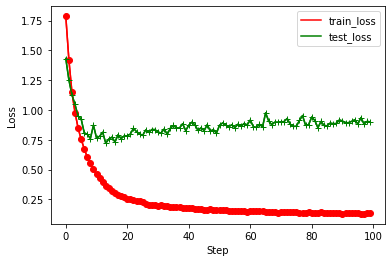

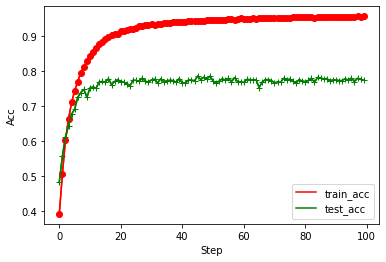

In [27]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [28]:
LOG_PATH="./train11.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn11.pth"
    
model = models.resnet152()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 100
print("Model: Resnet-152")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: Resnet-152
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [01:17,  5.04it/s]

Finish 1 epoch, Train loss: 2.030507, Train acc@1: 0.289040


Test loss: 1.663701, Test acc@1: 0.387800
Saving Best model...			Top1 = 38.780000%
Elapsed time: 82.71258473396301
---------- Training Epoch #1 ----------


391it [01:14,  5.23it/s]

Finish 2 epoch, Train loss: 1.740800, Train acc@1: 0.389760


Test loss: 1.525984, Test acc@1: 0.448200
Saving Best model...			Top1 = 44.820000%
Elapsed time: 163.50770473480225
---------- Training Epoch #2 ----------


391it [01:17,  5.02it/s]

Finish 3 epoch, Train loss: 1.499343, Train acc@1: 0.465940


Test loss: 1.376044, Test acc@1: 0.497200
Saving Best model...			Top1 = 49.720000%
Elapsed time: 246.85023856163025
---------- Training Epoch #3 ----------


391it [01:18,  4.99it/s]

Finish 4 epoch, Train loss: 1.203544, Train acc@1: 0.576980


Test loss: 1.111117, Test acc@1: 0.616300
Saving Best model...			Top1 = 61.630000%
Elapsed time: 330.77447152137756
---------- Training Epoch #4 ----------


391it [01:15,  5.16it/s]

Finish 5 epoch, Train loss: 0.992320, Train acc@1: 0.654060


Test loss: 0.948598, Test acc@1: 0.671300
Saving Best model...			Top1 = 67.130000%
Elapsed time: 411.9755599498749
---------- Training Epoch #5 ----------


391it [01:16,  5.10it/s]

Finish 6 epoch, Train loss: 0.854978, Train acc@1: 0.705240


Test loss: 0.859275, Test acc@1: 0.708900
Saving Best model...			Top1 = 70.890000%
Elapsed time: 494.1718316078186
---------- Training Epoch #6 ----------


391it [01:16,  5.11it/s]

Finish 7 epoch, Train loss: 0.757912, Train acc@1: 0.739540


Test loss: 0.839766, Test acc@1: 0.711100
Saving Best model...			Top1 = 71.110000%
Elapsed time: 576.1425127983093
---------- Training Epoch #7 ----------


391it [01:18,  4.99it/s]

Finish 8 epoch, Train loss: 0.681676, Train acc@1: 0.766800


Test loss: 0.854728, Test acc@1: 0.717000
Saving Best model...			Top1 = 71.700000%
Elapsed time: 659.9662082195282
---------- Training Epoch #8 ----------


391it [01:17,  5.04it/s]

Finish 9 epoch, Train loss: 0.613363, Train acc@1: 0.790260


Test loss: 0.800225, Test acc@1: 0.725100
Saving Best model...			Top1 = 72.510000%
Elapsed time: 743.5215651988983
---------- Training Epoch #9 ----------


391it [01:16,  5.08it/s]

Finish 10 epoch, Train loss: 0.563955, Train acc@1: 0.809060


Test loss: 0.756464, Test acc@1: 0.748800
Saving Best model...			Top1 = 74.880000%
Elapsed time: 825.7714726924896
---------- Training Epoch #10 ----------


391it [01:13,  5.32it/s]

Finish 11 epoch, Train loss: 0.508871, Train acc@1: 0.827220


Test loss: 0.753026, Test acc@1: 0.753100
Saving Best model...			Top1 = 75.310000%
Elapsed time: 904.551483631134
---------- Training Epoch #11 ----------


391it [01:16,  5.08it/s]

Finish 12 epoch, Train loss: 0.462516, Train acc@1: 0.844400


Test loss: 0.763334, Test acc@1: 0.749000
Elapsed time: 986.5607540607452
---------- Training Epoch #12 ----------


391it [01:17,  5.06it/s]

Finish 13 epoch, Train loss: 0.432922, Train acc@1: 0.852740


Test loss: 0.783314, Test acc@1: 0.752100
Elapsed time: 1068.5215792655945
---------- Training Epoch #13 ----------


391it [01:17,  5.05it/s]

Finish 14 epoch, Train loss: 0.398121, Train acc@1: 0.864500


Test loss: 0.800865, Test acc@1: 0.751100
Elapsed time: 1150.610030412674
---------- Training Epoch #14 ----------


391it [01:15,  5.21it/s]

Finish 15 epoch, Train loss: 0.366579, Train acc@1: 0.874080


Test loss: 0.757255, Test acc@1: 0.763200
Saving Best model...			Top1 = 76.320000%
Elapsed time: 1231.0254197120667
---------- Training Epoch #15 ----------


391it [01:15,  5.17it/s]

Finish 16 epoch, Train loss: 0.342664, Train acc@1: 0.883940


Test loss: 0.733285, Test acc@1: 0.773800
Saving Best model...			Top1 = 77.380000%
Elapsed time: 1312.1117527484894
---------- Training Epoch #16 ----------


391it [01:14,  5.28it/s]

Finish 17 epoch, Train loss: 0.326407, Train acc@1: 0.888700


Test loss: 0.792014, Test acc@1: 0.757500
Elapsed time: 1390.842363834381
---------- Training Epoch #17 ----------


391it [01:17,  5.08it/s]

Finish 18 epoch, Train loss: 0.310682, Train acc@1: 0.895060


Test loss: 0.749614, Test acc@1: 0.771700
Elapsed time: 1473.3487296104431
---------- Training Epoch #18 ----------


391it [01:17,  5.03it/s]

Finish 19 epoch, Train loss: 0.289120, Train acc@1: 0.901640


Test loss: 0.796628, Test acc@1: 0.764400
Elapsed time: 1556.8238563537598
---------- Training Epoch #19 ----------


391it [01:14,  5.26it/s]

Finish 20 epoch, Train loss: 0.278644, Train acc@1: 0.906200


Test loss: 0.824149, Test acc@1: 0.755900
Elapsed time: 1635.7529447078705
---------- Training Epoch #20 ----------


391it [01:17,  5.03it/s]

Finish 21 epoch, Train loss: 0.266081, Train acc@1: 0.910140


Test loss: 0.797136, Test acc@1: 0.768600
Elapsed time: 1718.1412625312805
---------- Training Epoch #21 ----------


391it [01:15,  5.20it/s]

Finish 22 epoch, Train loss: 0.251209, Train acc@1: 0.915840


Test loss: 0.810291, Test acc@1: 0.767200
Elapsed time: 1798.1997411251068
---------- Training Epoch #22 ----------


391it [01:15,  5.18it/s]

Finish 23 epoch, Train loss: 0.242092, Train acc@1: 0.917760


Test loss: 0.880261, Test acc@1: 0.749900
Elapsed time: 1878.335776567459
---------- Training Epoch #23 ----------


391it [01:16,  5.08it/s]

Finish 24 epoch, Train loss: 0.237448, Train acc@1: 0.918980


Test loss: 0.829480, Test acc@1: 0.761200
Elapsed time: 1959.941722869873
---------- Training Epoch #24 ----------


391it [01:19,  4.94it/s]

Finish 25 epoch, Train loss: 0.235556, Train acc@1: 0.920720


Test loss: 0.814242, Test acc@1: 0.762000
Elapsed time: 2043.8680801391602
---------- Training Epoch #25 ----------


391it [01:16,  5.10it/s]

Finish 26 epoch, Train loss: 0.223859, Train acc@1: 0.923820


Test loss: 0.851732, Test acc@1: 0.763800
Elapsed time: 2125.227761745453
---------- Training Epoch #26 ----------


391it [01:18,  4.95it/s]

Finish 27 epoch, Train loss: 0.221066, Train acc@1: 0.925660


Test loss: 0.856843, Test acc@1: 0.765500
Elapsed time: 2208.8668253421783
---------- Training Epoch #27 ----------


391it [01:16,  5.11it/s]

Finish 28 epoch, Train loss: 0.207305, Train acc@1: 0.930980


Test loss: 0.867212, Test acc@1: 0.758700
Elapsed time: 2290.1200325489044
---------- Training Epoch #28 ----------


391it [01:15,  5.20it/s]

Finish 29 epoch, Train loss: 0.205238, Train acc@1: 0.929960


Test loss: 0.891075, Test acc@1: 0.756500
Elapsed time: 2369.9645850658417
---------- Training Epoch #29 ----------


391it [01:15,  5.15it/s]

Finish 30 epoch, Train loss: 0.202409, Train acc@1: 0.931460


Test loss: 0.874667, Test acc@1: 0.762500
Elapsed time: 2450.5812215805054
---------- Training Epoch #30 ----------


391it [01:17,  5.06it/s]

Finish 31 epoch, Train loss: 0.196318, Train acc@1: 0.934460


Test loss: 0.882506, Test acc@1: 0.761900
Elapsed time: 2532.449132204056
---------- Training Epoch #31 ----------


391it [01:15,  5.16it/s]

Finish 32 epoch, Train loss: 0.197381, Train acc@1: 0.934580


Test loss: 0.839771, Test acc@1: 0.770200
Elapsed time: 2612.898293018341
---------- Training Epoch #32 ----------


391it [01:16,  5.08it/s]

Finish 33 epoch, Train loss: 0.190883, Train acc@1: 0.935440


Test loss: 0.842024, Test acc@1: 0.768600
Elapsed time: 2695.190078020096
---------- Training Epoch #33 ----------


391it [01:18,  4.99it/s]

Finish 34 epoch, Train loss: 0.191011, Train acc@1: 0.935720


Test loss: 0.868690, Test acc@1: 0.764600
Elapsed time: 2778.249785900116
---------- Training Epoch #34 ----------


391it [01:17,  5.06it/s]

Finish 35 epoch, Train loss: 0.192326, Train acc@1: 0.935280


Test loss: 0.869656, Test acc@1: 0.765100
Elapsed time: 2860.2546491622925
---------- Training Epoch #35 ----------


391it [01:19,  4.95it/s]

Finish 36 epoch, Train loss: 0.187993, Train acc@1: 0.936160


Test loss: 0.833302, Test acc@1: 0.772900
Elapsed time: 2944.005955696106
---------- Training Epoch #36 ----------


391it [01:16,  5.10it/s]

Finish 37 epoch, Train loss: 0.185308, Train acc@1: 0.937660


Test loss: 0.887507, Test acc@1: 0.768000
Elapsed time: 3025.5231018066406
---------- Training Epoch #37 ----------


391it [01:15,  5.16it/s]

Finish 38 epoch, Train loss: 0.179649, Train acc@1: 0.938380


Test loss: 0.888852, Test acc@1: 0.759100
Elapsed time: 3106.774867773056
---------- Training Epoch #38 ----------


391it [01:18,  4.99it/s]

Finish 39 epoch, Train loss: 0.176661, Train acc@1: 0.939560


Test loss: 0.852859, Test acc@1: 0.773000
Elapsed time: 3190.600747823715
---------- Training Epoch #39 ----------


391it [01:16,  5.14it/s]

Finish 40 epoch, Train loss: 0.180561, Train acc@1: 0.938940


Test loss: 0.890300, Test acc@1: 0.760700
Elapsed time: 3272.24280834198
---------- Training Epoch #40 ----------


391it [01:16,  5.12it/s]

Finish 41 epoch, Train loss: 0.172619, Train acc@1: 0.941920


Test loss: 0.889640, Test acc@1: 0.765700
Elapsed time: 3353.2545716762543
---------- Training Epoch #41 ----------


391it [01:13,  5.32it/s]

Finish 42 epoch, Train loss: 0.171109, Train acc@1: 0.941680


Test loss: 0.827426, Test acc@1: 0.778400
Saving Best model...			Top1 = 77.840000%
Elapsed time: 3432.3164081573486
---------- Training Epoch #42 ----------


391it [01:18,  5.01it/s]

Finish 43 epoch, Train loss: 0.172281, Train acc@1: 0.941060


Test loss: 0.868900, Test acc@1: 0.769600
Elapsed time: 3515.8345839977264
---------- Training Epoch #43 ----------


391it [01:18,  5.01it/s]

Finish 44 epoch, Train loss: 0.168121, Train acc@1: 0.943160


Test loss: 0.823305, Test acc@1: 0.775600
Elapsed time: 3598.5449924468994
---------- Training Epoch #44 ----------


391it [01:14,  5.27it/s]

Finish 45 epoch, Train loss: 0.169240, Train acc@1: 0.944360


Test loss: 0.871392, Test acc@1: 0.771800
Elapsed time: 3678.2137751579285
---------- Training Epoch #45 ----------


391it [01:14,  5.26it/s]

Finish 46 epoch, Train loss: 0.165866, Train acc@1: 0.942780


Test loss: 0.957247, Test acc@1: 0.757300
Elapsed time: 3757.3200368881226
---------- Training Epoch #46 ----------


391it [01:15,  5.19it/s]

Finish 47 epoch, Train loss: 0.167374, Train acc@1: 0.941780


Test loss: 0.892231, Test acc@1: 0.768100
Elapsed time: 3837.407501935959
---------- Training Epoch #47 ----------


391it [01:17,  5.06it/s]

Finish 48 epoch, Train loss: 0.166382, Train acc@1: 0.944240


Test loss: 0.912332, Test acc@1: 0.762400
Elapsed time: 3919.364193916321
---------- Training Epoch #48 ----------


391it [01:18,  4.98it/s]

Finish 49 epoch, Train loss: 0.159102, Train acc@1: 0.946240


Test loss: 0.915298, Test acc@1: 0.763200
Elapsed time: 4002.5736787319183
---------- Training Epoch #49 ----------


391it [01:17,  5.06it/s]

Finish 50 epoch, Train loss: 0.156604, Train acc@1: 0.946720


Test loss: 0.846598, Test acc@1: 0.779000
Saving Best model...			Top1 = 77.900000%
Elapsed time: 4085.289009332657
---------- Training Epoch #50 ----------


391it [01:14,  5.24it/s]

Finish 51 epoch, Train loss: 0.156067, Train acc@1: 0.947520


Test loss: 0.935348, Test acc@1: 0.764600
Elapsed time: 4165.305214881897
---------- Training Epoch #51 ----------


391it [01:17,  5.06it/s]

Finish 52 epoch, Train loss: 0.155180, Train acc@1: 0.947200


Test loss: 0.910117, Test acc@1: 0.774000
Elapsed time: 4247.23565030098
---------- Training Epoch #52 ----------


391it [01:16,  5.10it/s]

Finish 53 epoch, Train loss: 0.154988, Train acc@1: 0.946260


Test loss: 0.926130, Test acc@1: 0.770900
Elapsed time: 4328.575681686401
---------- Training Epoch #53 ----------


391it [01:15,  5.16it/s]

Finish 54 epoch, Train loss: 0.158981, Train acc@1: 0.945420


Test loss: 0.887711, Test acc@1: 0.775900
Elapsed time: 4408.933600187302
---------- Training Epoch #54 ----------


391it [01:16,  5.11it/s]

Finish 55 epoch, Train loss: 0.155628, Train acc@1: 0.947220


Test loss: 0.881078, Test acc@1: 0.771700
Elapsed time: 4490.946364402771
---------- Training Epoch #55 ----------


391it [01:16,  5.14it/s]

Finish 56 epoch, Train loss: 0.156124, Train acc@1: 0.946100


Test loss: 0.910090, Test acc@1: 0.766000
Elapsed time: 4571.836920499802
---------- Training Epoch #56 ----------


391it [01:15,  5.18it/s]

Finish 57 epoch, Train loss: 0.153496, Train acc@1: 0.947260


Test loss: 0.884547, Test acc@1: 0.769500
Elapsed time: 4652.900234937668
---------- Training Epoch #57 ----------


391it [01:18,  5.00it/s]

Finish 58 epoch, Train loss: 0.154702, Train acc@1: 0.946440


Test loss: 0.944448, Test acc@1: 0.764100
Elapsed time: 4735.715753793716
---------- Training Epoch #58 ----------


391it [01:16,  5.13it/s]

Finish 59 epoch, Train loss: 0.155265, Train acc@1: 0.947580


Test loss: 0.891484, Test acc@1: 0.771300
Elapsed time: 4816.634783267975
---------- Training Epoch #59 ----------


391it [01:17,  5.02it/s]

Finish 60 epoch, Train loss: 0.153467, Train acc@1: 0.948260


Test loss: 0.935186, Test acc@1: 0.763900
Elapsed time: 4899.221848249435
---------- Training Epoch #60 ----------


391it [01:15,  5.19it/s]

Finish 61 epoch, Train loss: 0.146993, Train acc@1: 0.949800


Test loss: 0.936973, Test acc@1: 0.767500
Elapsed time: 4979.212042808533
---------- Training Epoch #61 ----------


391it [01:16,  5.09it/s]

Finish 62 epoch, Train loss: 0.148968, Train acc@1: 0.950760


Test loss: 0.954988, Test acc@1: 0.759700
Elapsed time: 5061.505036830902
---------- Training Epoch #62 ----------


391it [01:16,  5.12it/s]

Finish 63 epoch, Train loss: 0.151242, Train acc@1: 0.949500


Test loss: 0.899949, Test acc@1: 0.765600
Elapsed time: 5142.484419345856
---------- Training Epoch #63 ----------


391it [01:17,  5.05it/s]

Finish 64 epoch, Train loss: 0.144973, Train acc@1: 0.951200


Test loss: 0.915544, Test acc@1: 0.769700
Elapsed time: 5224.61971116066
---------- Training Epoch #64 ----------


391it [01:16,  5.14it/s]

Finish 65 epoch, Train loss: 0.144992, Train acc@1: 0.951100


Test loss: 0.872105, Test acc@1: 0.772400
Elapsed time: 5305.4480900764465
---------- Training Epoch #65 ----------


391it [01:18,  4.96it/s]

Finish 66 epoch, Train loss: 0.144286, Train acc@1: 0.950680


Test loss: 0.874998, Test acc@1: 0.777000
Elapsed time: 5389.778525352478
---------- Training Epoch #66 ----------


391it [01:17,  5.06it/s]

Finish 67 epoch, Train loss: 0.149575, Train acc@1: 0.949520


Test loss: 0.876700, Test acc@1: 0.779500
Saving Best model...			Top1 = 77.950000%
Elapsed time: 5472.5123908519745
---------- Training Epoch #67 ----------


391it [01:13,  5.30it/s]

Finish 68 epoch, Train loss: 0.141724, Train acc@1: 0.951160


Test loss: 0.910669, Test acc@1: 0.774100
Elapsed time: 5550.996929883957
---------- Training Epoch #68 ----------


391it [01:17,  5.07it/s]

Finish 69 epoch, Train loss: 0.139888, Train acc@1: 0.951280


Test loss: 0.885113, Test acc@1: 0.772900
Elapsed time: 5632.820518016815
---------- Training Epoch #69 ----------


391it [01:16,  5.09it/s]

Finish 70 epoch, Train loss: 0.144952, Train acc@1: 0.951200


Test loss: 0.928310, Test acc@1: 0.766900
Elapsed time: 5714.4314506053925
---------- Training Epoch #70 ----------


391it [01:12,  5.43it/s]

Finish 71 epoch, Train loss: 0.143148, Train acc@1: 0.952040


Test loss: 0.901232, Test acc@1: 0.770300
Elapsed time: 5791.086248874664
---------- Training Epoch #71 ----------


391it [01:12,  5.40it/s]

Finish 72 epoch, Train loss: 0.142741, Train acc@1: 0.951740


Test loss: 0.943003, Test acc@1: 0.770400
Elapsed time: 5868.302431821823
---------- Training Epoch #72 ----------


391it [01:16,  5.14it/s]

Finish 73 epoch, Train loss: 0.140232, Train acc@1: 0.952960


Test loss: 0.874448, Test acc@1: 0.777100
Elapsed time: 5949.109491825104
---------- Training Epoch #73 ----------


391it [01:13,  5.30it/s]

Finish 74 epoch, Train loss: 0.145016, Train acc@1: 0.950860


Test loss: 0.904203, Test acc@1: 0.778500
Elapsed time: 6027.616040945053
---------- Training Epoch #74 ----------


391it [01:16,  5.12it/s]

Finish 75 epoch, Train loss: 0.137220, Train acc@1: 0.953100


Test loss: 0.948587, Test acc@1: 0.768600
Elapsed time: 6108.696905851364
---------- Training Epoch #75 ----------


391it [01:17,  5.07it/s]

Finish 76 epoch, Train loss: 0.138897, Train acc@1: 0.953240


Test loss: 0.888886, Test acc@1: 0.774500
Elapsed time: 6191.095072984695
---------- Training Epoch #76 ----------


391it [01:12,  5.40it/s]

Finish 77 epoch, Train loss: 0.140161, Train acc@1: 0.952360


Test loss: 0.894413, Test acc@1: 0.773200
Elapsed time: 6268.125873327255
---------- Training Epoch #77 ----------


391it [01:15,  5.18it/s]

Finish 78 epoch, Train loss: 0.142677, Train acc@1: 0.951940


Test loss: 0.942431, Test acc@1: 0.764000
Elapsed time: 6348.207208633423
---------- Training Epoch #78 ----------


391it [01:17,  5.04it/s]

Finish 79 epoch, Train loss: 0.138222, Train acc@1: 0.952520


Test loss: 0.918326, Test acc@1: 0.769900
Elapsed time: 6431.151489496231
---------- Training Epoch #79 ----------


391it [01:17,  5.07it/s]

Finish 80 epoch, Train loss: 0.136231, Train acc@1: 0.953820


Test loss: 0.920366, Test acc@1: 0.770700
Elapsed time: 6512.879169225693
---------- Training Epoch #80 ----------


391it [01:17,  5.05it/s]

Finish 81 epoch, Train loss: 0.135023, Train acc@1: 0.954460


Test loss: 0.938164, Test acc@1: 0.769600
Elapsed time: 6594.989038705826
---------- Training Epoch #81 ----------


391it [01:17,  5.04it/s]

Finish 82 epoch, Train loss: 0.138181, Train acc@1: 0.953160


Test loss: 0.906659, Test acc@1: 0.774500
Elapsed time: 6677.251099824905
---------- Training Epoch #82 ----------


391it [01:16,  5.12it/s]

Finish 83 epoch, Train loss: 0.135269, Train acc@1: 0.955160


Test loss: 0.931134, Test acc@1: 0.765100
Elapsed time: 6758.214066743851
---------- Training Epoch #83 ----------


391it [01:17,  5.06it/s]

Finish 84 epoch, Train loss: 0.133870, Train acc@1: 0.954880


Test loss: 0.937055, Test acc@1: 0.769300
Elapsed time: 6840.182899713516
---------- Training Epoch #84 ----------


391it [01:13,  5.34it/s]

Finish 85 epoch, Train loss: 0.137800, Train acc@1: 0.953380


Test loss: 0.918621, Test acc@1: 0.774500
Elapsed time: 6918.119429826736
---------- Training Epoch #85 ----------


391it [01:17,  5.03it/s]

Finish 86 epoch, Train loss: 0.138158, Train acc@1: 0.954080


Test loss: 0.896601, Test acc@1: 0.776400
Elapsed time: 7000.493273019791
---------- Training Epoch #86 ----------


391it [01:15,  5.19it/s]

Finish 87 epoch, Train loss: 0.137451, Train acc@1: 0.952780


Test loss: 0.938406, Test acc@1: 0.771600
Elapsed time: 7080.616569042206
---------- Training Epoch #87 ----------


391it [01:17,  5.07it/s]

Finish 88 epoch, Train loss: 0.136360, Train acc@1: 0.953700


Test loss: 0.924722, Test acc@1: 0.776200
Elapsed time: 7162.410851955414
---------- Training Epoch #88 ----------


391it [01:16,  5.09it/s]

Finish 89 epoch, Train loss: 0.139836, Train acc@1: 0.952660


Test loss: 0.890273, Test acc@1: 0.775800
Elapsed time: 7243.953168869019
---------- Training Epoch #89 ----------


391it [01:15,  5.17it/s]

Finish 90 epoch, Train loss: 0.136956, Train acc@1: 0.953400


Test loss: 0.952481, Test acc@1: 0.770900
Elapsed time: 7325.212834358215
---------- Training Epoch #90 ----------


391it [01:17,  5.07it/s]

Finish 91 epoch, Train loss: 0.133470, Train acc@1: 0.954580


Test loss: 0.926168, Test acc@1: 0.769200
Elapsed time: 7407.951288938522
---------- Training Epoch #91 ----------


391it [01:17,  5.06it/s]

Finish 92 epoch, Train loss: 0.134439, Train acc@1: 0.954980


Test loss: 0.988937, Test acc@1: 0.761500
Elapsed time: 7490.008256435394
---------- Training Epoch #92 ----------


391it [01:16,  5.08it/s]

Finish 93 epoch, Train loss: 0.132261, Train acc@1: 0.955840


Test loss: 0.936375, Test acc@1: 0.768000
Elapsed time: 7571.670132637024
---------- Training Epoch #93 ----------


391it [01:16,  5.09it/s]

Finish 94 epoch, Train loss: 0.130326, Train acc@1: 0.955900


Test loss: 0.932252, Test acc@1: 0.768700
Elapsed time: 7653.960819721222
---------- Training Epoch #94 ----------


391it [01:14,  5.24it/s]

Finish 95 epoch, Train loss: 0.130916, Train acc@1: 0.955240


Test loss: 0.912953, Test acc@1: 0.769300
Elapsed time: 7733.334804534912
---------- Training Epoch #95 ----------


391it [01:19,  4.91it/s]

Finish 96 epoch, Train loss: 0.133592, Train acc@1: 0.955180


Test loss: 0.900968, Test acc@1: 0.774400
Elapsed time: 7817.738901376724
---------- Training Epoch #96 ----------


391it [01:15,  5.21it/s]

Finish 97 epoch, Train loss: 0.134246, Train acc@1: 0.953960


Test loss: 0.910181, Test acc@1: 0.774700
Elapsed time: 7897.474425315857
---------- Training Epoch #97 ----------


391it [01:16,  5.12it/s]

Finish 98 epoch, Train loss: 0.133354, Train acc@1: 0.954920


Test loss: 0.932623, Test acc@1: 0.767200
Elapsed time: 7979.353479385376
---------- Training Epoch #98 ----------


391it [01:15,  5.18it/s]

Finish 99 epoch, Train loss: 0.130882, Train acc@1: 0.955800


Test loss: 0.979132, Test acc@1: 0.767900
Elapsed time: 8059.355788946152
---------- Training Epoch #99 ----------


391it [01:15,  5.15it/s]

Finish 100 epoch, Train loss: 0.134163, Train acc@1: 0.954620


Test loss: 0.905160, Test acc@1: 0.773000
Elapsed time: 8139.923057794571

Test results: Acc@1 = 77.950000%


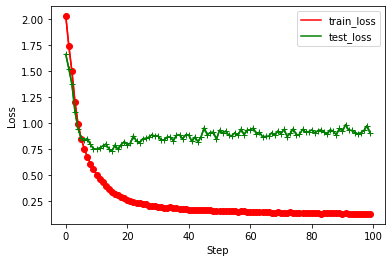

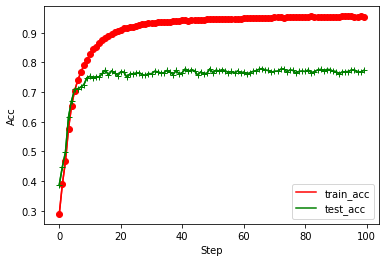

In [29]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [30]:
LOG_PATH="./train12.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn12.pth"
    
model = models.vgg19()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 100
print("Model: VGG-19")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: VGG-19
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:49,  7.91it/s]

Finish 1 epoch, Train loss: 2.504035, Train acc@1: 0.103920


Test loss: 2.325481, Test acc@1: 0.100000
Saving Best model...			Top1 = 10.000000%
Elapsed time: 53.7304470539093
---------- Training Epoch #1 ----------


391it [00:45,  8.59it/s]

Finish 2 epoch, Train loss: 2.347431, Train acc@1: 0.100440


Test loss: 2.315254, Test acc@1: 0.100000
Elapsed time: 102.16495490074158
---------- Training Epoch #2 ----------


391it [00:43,  8.91it/s]

Finish 3 epoch, Train loss: 2.339932, Train acc@1: 0.099520


Test loss: 2.319868, Test acc@1: 0.100000
Elapsed time: 149.03176045417786
---------- Training Epoch #3 ----------


391it [00:46,  8.44it/s]

Finish 4 epoch, Train loss: 2.338156, Train acc@1: 0.097880


Test loss: 2.317771, Test acc@1: 0.100000
Elapsed time: 198.40642309188843
---------- Training Epoch #4 ----------


391it [00:43,  8.98it/s]

Finish 5 epoch, Train loss: 2.333845, Train acc@1: 0.103140


Test loss: 2.311189, Test acc@1: 0.100000
Elapsed time: 245.00039625167847
---------- Training Epoch #5 ----------


391it [00:42,  9.15it/s]

Finish 6 epoch, Train loss: 2.331606, Train acc@1: 0.101000


Test loss: 2.315721, Test acc@1: 0.100000
Elapsed time: 290.74624943733215
---------- Training Epoch #6 ----------


391it [00:42,  9.16it/s]

Finish 7 epoch, Train loss: 2.331368, Train acc@1: 0.100800


Test loss: 2.317499, Test acc@1: 0.100000
Elapsed time: 336.4111897945404
---------- Training Epoch #7 ----------


391it [00:42,  9.15it/s]

Finish 8 epoch, Train loss: 2.328046, Train acc@1: 0.098400


Test loss: 2.320077, Test acc@1: 0.100000
Elapsed time: 382.49879217147827
---------- Training Epoch #8 ----------


391it [00:42,  9.15it/s]

Finish 9 epoch, Train loss: 2.326962, Train acc@1: 0.098820


Test loss: 2.308638, Test acc@1: 0.100000
Elapsed time: 428.19182300567627
---------- Training Epoch #9 ----------


391it [00:42,  9.16it/s]

Finish 10 epoch, Train loss: 2.327037, Train acc@1: 0.101280


Test loss: 2.313655, Test acc@1: 0.100000
Elapsed time: 473.876953125
---------- Training Epoch #10 ----------


391it [00:44,  8.86it/s]

Finish 11 epoch, Train loss: 2.325178, Train acc@1: 0.102320


Test loss: 2.316848, Test acc@1: 0.100000
Elapsed time: 520.9977586269379
---------- Training Epoch #11 ----------


391it [00:46,  8.49it/s]

Finish 12 epoch, Train loss: 2.323630, Train acc@1: 0.099280


Test loss: 2.314114, Test acc@1: 0.100000
Elapsed time: 570.4988808631897
---------- Training Epoch #12 ----------


391it [00:45,  8.63it/s]

Finish 13 epoch, Train loss: 2.323800, Train acc@1: 0.096300


Test loss: 2.316656, Test acc@1: 0.100000
Elapsed time: 618.7398207187653
---------- Training Epoch #13 ----------


391it [00:44,  8.80it/s]

Finish 14 epoch, Train loss: 2.322393, Train acc@1: 0.099640


Test loss: 2.316013, Test acc@1: 0.100000
Elapsed time: 666.1597635746002
---------- Training Epoch #14 ----------


391it [00:42,  9.16it/s]

Finish 15 epoch, Train loss: 2.322503, Train acc@1: 0.100080


Test loss: 2.309299, Test acc@1: 0.100000
Elapsed time: 711.7956824302673
---------- Training Epoch #15 ----------


391it [00:42,  9.17it/s]

Finish 16 epoch, Train loss: 2.321228, Train acc@1: 0.098320


Test loss: 2.310971, Test acc@1: 0.100000
Elapsed time: 757.3671586513519
---------- Training Epoch #16 ----------


391it [00:42,  9.18it/s]

Finish 17 epoch, Train loss: 2.321544, Train acc@1: 0.100580


Test loss: 2.313797, Test acc@1: 0.100000
Elapsed time: 802.8793239593506
---------- Training Epoch #17 ----------


391it [00:42,  9.17it/s]

Finish 18 epoch, Train loss: 2.321401, Train acc@1: 0.100140


Test loss: 2.312631, Test acc@1: 0.100000
Elapsed time: 848.5421736240387
---------- Training Epoch #18 ----------


391it [00:43,  8.90it/s]

Finish 19 epoch, Train loss: 2.320816, Train acc@1: 0.099480


Test loss: 2.312741, Test acc@1: 0.100000
Elapsed time: 895.4964666366577
---------- Training Epoch #19 ----------


391it [00:42,  9.17it/s]

Finish 20 epoch, Train loss: 2.320309, Train acc@1: 0.098260


Test loss: 2.307590, Test acc@1: 0.100000
Elapsed time: 941.1325850486755
---------- Training Epoch #20 ----------


391it [00:44,  8.77it/s]

Finish 21 epoch, Train loss: 2.319466, Train acc@1: 0.099540


Test loss: 2.313307, Test acc@1: 0.100000
Elapsed time: 988.6978812217712
---------- Training Epoch #21 ----------


391it [00:42,  9.16it/s]

Finish 22 epoch, Train loss: 2.319113, Train acc@1: 0.100000


Test loss: 2.308704, Test acc@1: 0.100000
Elapsed time: 1034.3628537654877
---------- Training Epoch #22 ----------


391it [00:42,  9.16it/s]

Finish 23 epoch, Train loss: 2.320038, Train acc@1: 0.100320


Test loss: 2.311204, Test acc@1: 0.100000
Elapsed time: 1079.9712300300598
---------- Training Epoch #23 ----------


391it [00:42,  9.16it/s]

Finish 24 epoch, Train loss: 2.318302, Train acc@1: 0.099980


Test loss: 2.316816, Test acc@1: 0.100000
Elapsed time: 1126.731112241745
---------- Training Epoch #24 ----------


391it [00:44,  8.86it/s]

Finish 25 epoch, Train loss: 2.318640, Train acc@1: 0.099500


Test loss: 2.310755, Test acc@1: 0.100000
Elapsed time: 1173.808268547058
---------- Training Epoch #25 ----------


391it [00:44,  8.82it/s]

Finish 26 epoch, Train loss: 2.318100, Train acc@1: 0.097480


Test loss: 2.317849, Test acc@1: 0.100000
Elapsed time: 1221.247080564499
---------- Training Epoch #26 ----------


391it [00:42,  9.16it/s]

Finish 27 epoch, Train loss: 2.318538, Train acc@1: 0.097980


Test loss: 2.309285, Test acc@1: 0.100000
Elapsed time: 1267.3026695251465
---------- Training Epoch #27 ----------


391it [00:44,  8.85it/s]

Finish 28 epoch, Train loss: 2.317431, Train acc@1: 0.100740


Test loss: 2.315017, Test acc@1: 0.100000
Elapsed time: 1314.4117324352264
---------- Training Epoch #28 ----------


391it [00:42,  9.17it/s]

Finish 29 epoch, Train loss: 2.317952, Train acc@1: 0.100720


Test loss: 2.308114, Test acc@1: 0.100000
Elapsed time: 1360.0675394535065
---------- Training Epoch #29 ----------


391it [00:44,  8.88it/s]

Finish 30 epoch, Train loss: 2.317887, Train acc@1: 0.099240


Test loss: 2.310068, Test acc@1: 0.100000
Elapsed time: 1407.0858585834503
---------- Training Epoch #30 ----------


391it [00:42,  9.16it/s]

Finish 31 epoch, Train loss: 2.317193, Train acc@1: 0.101040


Test loss: 2.307762, Test acc@1: 0.100000
Elapsed time: 1452.7070169448853
---------- Training Epoch #31 ----------


391it [00:42,  9.17it/s]

Finish 32 epoch, Train loss: 2.318398, Train acc@1: 0.099360


Test loss: 2.312050, Test acc@1: 0.100000
Elapsed time: 1498.276596546173
---------- Training Epoch #32 ----------


391it [00:42,  9.16it/s]

Finish 33 epoch, Train loss: 2.317381, Train acc@1: 0.100220


Test loss: 2.311507, Test acc@1: 0.100000
Elapsed time: 1543.9671828746796
---------- Training Epoch #33 ----------


391it [00:42,  9.16it/s]

Finish 34 epoch, Train loss: 2.317228, Train acc@1: 0.101140


Test loss: 2.309763, Test acc@1: 0.100000
Elapsed time: 1589.7129712104797
---------- Training Epoch #34 ----------


391it [00:45,  8.62it/s]

Finish 35 epoch, Train loss: 2.317487, Train acc@1: 0.100420


Test loss: 2.307948, Test acc@1: 0.100000
Elapsed time: 1637.9780299663544
---------- Training Epoch #35 ----------


391it [00:44,  8.84it/s]

Finish 36 epoch, Train loss: 2.316228, Train acc@1: 0.100680


Test loss: 2.311355, Test acc@1: 0.100000
Elapsed time: 1686.4511077404022
---------- Training Epoch #36 ----------


391it [00:45,  8.62it/s]

Finish 37 epoch, Train loss: 2.316616, Train acc@1: 0.099920


Test loss: 2.308603, Test acc@1: 0.100000
Elapsed time: 1734.821920633316
---------- Training Epoch #37 ----------


391it [00:47,  8.23it/s]

Finish 38 epoch, Train loss: 2.316990, Train acc@1: 0.101740


Test loss: 2.310560, Test acc@1: 0.100000
Elapsed time: 1785.7782382965088
---------- Training Epoch #38 ----------


391it [00:44,  8.72it/s]

Finish 39 epoch, Train loss: 2.317700, Train acc@1: 0.100500


Test loss: 2.311813, Test acc@1: 0.100000
Elapsed time: 1833.5093250274658
---------- Training Epoch #39 ----------


391it [00:44,  8.84it/s]

Finish 40 epoch, Train loss: 2.316640, Train acc@1: 0.098860


Test loss: 2.313233, Test acc@1: 0.100000
Elapsed time: 1880.7711434364319
---------- Training Epoch #40 ----------


391it [00:42,  9.17it/s]

Finish 41 epoch, Train loss: 2.316501, Train acc@1: 0.101460


Test loss: 2.309791, Test acc@1: 0.100000
Elapsed time: 1926.3216879367828
---------- Training Epoch #41 ----------


391it [00:42,  9.17it/s]

Finish 42 epoch, Train loss: 2.316231, Train acc@1: 0.100640


Test loss: 2.311567, Test acc@1: 0.100000
Elapsed time: 1971.9947698116302
---------- Training Epoch #42 ----------


391it [00:42,  9.16it/s]

Finish 43 epoch, Train loss: 2.316562, Train acc@1: 0.099640


Test loss: 2.312809, Test acc@1: 0.100000
Elapsed time: 2017.6251180171967
---------- Training Epoch #43 ----------


391it [00:42,  9.16it/s]

Finish 44 epoch, Train loss: 2.316881, Train acc@1: 0.100440


Test loss: 2.312899, Test acc@1: 0.100000
Elapsed time: 2063.213700771332
---------- Training Epoch #44 ----------


391it [00:42,  9.16it/s]

Finish 45 epoch, Train loss: 2.316494, Train acc@1: 0.100920


Test loss: 2.308315, Test acc@1: 0.100000
Elapsed time: 2108.8891336917877
---------- Training Epoch #45 ----------


391it [00:43,  8.89it/s]

Finish 46 epoch, Train loss: 2.317096, Train acc@1: 0.097920


Test loss: 2.310641, Test acc@1: 0.100000
Elapsed time: 2155.9442353248596
---------- Training Epoch #46 ----------


391it [00:44,  8.87it/s]

Finish 47 epoch, Train loss: 2.316044, Train acc@1: 0.099520


Test loss: 2.312142, Test acc@1: 0.100000
Elapsed time: 2202.907215118408
---------- Training Epoch #47 ----------


391it [00:42,  9.16it/s]

Finish 48 epoch, Train loss: 2.315885, Train acc@1: 0.099900


Test loss: 2.314472, Test acc@1: 0.100000
Elapsed time: 2248.5594193935394
---------- Training Epoch #48 ----------


391it [00:42,  9.18it/s]

Finish 49 epoch, Train loss: 2.316846, Train acc@1: 0.099740


Test loss: 2.308501, Test acc@1: 0.100000
Elapsed time: 2294.1832282543182
---------- Training Epoch #49 ----------


391it [00:42,  9.16it/s]

Finish 50 epoch, Train loss: 2.316141, Train acc@1: 0.101080


Test loss: 2.312895, Test acc@1: 0.100000
Elapsed time: 2339.876429796219
---------- Training Epoch #50 ----------


391it [00:42,  9.17it/s]

Finish 51 epoch, Train loss: 2.316576, Train acc@1: 0.099320


Test loss: 2.308042, Test acc@1: 0.100000
Elapsed time: 2385.5006699562073
---------- Training Epoch #51 ----------


391it [00:42,  9.15it/s]

Finish 52 epoch, Train loss: 2.316234, Train acc@1: 0.101060


Test loss: 2.308331, Test acc@1: 0.100000
Elapsed time: 2431.2064492702484
---------- Training Epoch #52 ----------


391it [00:43,  8.89it/s]

Finish 53 epoch, Train loss: 2.315871, Train acc@1: 0.099980


Test loss: 2.312005, Test acc@1: 0.100000
Elapsed time: 2478.1644401550293
---------- Training Epoch #53 ----------


391it [00:43,  8.90it/s]


Finish 54 epoch, Train loss: 2.317225, Train acc@1: 0.098400
Test loss: 2.309781, Test acc@1: 0.100000
Elapsed time: 2524.9919822216034
---------- Training Epoch #54 ----------


391it [00:42,  9.17it/s]

Finish 55 epoch, Train loss: 2.315806, Train acc@1: 0.099720


Test loss: 2.307900, Test acc@1: 0.100000
Elapsed time: 2570.537579536438
---------- Training Epoch #55 ----------


391it [00:44,  8.86it/s]

Finish 56 epoch, Train loss: 2.316324, Train acc@1: 0.098280


Test loss: 2.314404, Test acc@1: 0.100000
Elapsed time: 2617.7002897262573
---------- Training Epoch #56 ----------


391it [00:42,  9.16it/s]

Finish 57 epoch, Train loss: 2.316568, Train acc@1: 0.097440


Test loss: 2.306823, Test acc@1: 0.100000
Elapsed time: 2664.0323474407196
---------- Training Epoch #57 ----------


391it [00:42,  9.17it/s]


Finish 58 epoch, Train loss: 2.315273, Train acc@1: 0.099440
Test loss: 2.309167, Test acc@1: 0.100000
Elapsed time: 2709.714294195175
---------- Training Epoch #58 ----------


391it [00:42,  9.17it/s]


Finish 59 epoch, Train loss: 2.316514, Train acc@1: 0.099560
Test loss: 2.310379, Test acc@1: 0.100000
Elapsed time: 2755.812642812729
---------- Training Epoch #59 ----------


391it [00:45,  8.57it/s]

Finish 60 epoch, Train loss: 2.315908, Train acc@1: 0.101620


Test loss: 2.308685, Test acc@1: 0.100000
Elapsed time: 2804.405553817749
---------- Training Epoch #60 ----------


391it [00:42,  9.17it/s]

Finish 61 epoch, Train loss: 2.315291, Train acc@1: 0.098700


Test loss: 2.316142, Test acc@1: 0.100000
Elapsed time: 2850.062352657318
---------- Training Epoch #61 ----------


391it [00:44,  8.79it/s]

Finish 62 epoch, Train loss: 2.316139, Train acc@1: 0.099500


Test loss: 2.306448, Test acc@1: 0.100000
Elapsed time: 2897.4773592948914
---------- Training Epoch #62 ----------


391it [00:42,  9.17it/s]

Finish 63 epoch, Train loss: 2.315945, Train acc@1: 0.100960


Test loss: 2.307831, Test acc@1: 0.100000
Elapsed time: 2943.0684978961945
---------- Training Epoch #63 ----------


391it [00:44,  8.80it/s]

Finish 64 epoch, Train loss: 2.315824, Train acc@1: 0.099740


Test loss: 2.316472, Test acc@1: 0.100000
Elapsed time: 2990.507105112076
---------- Training Epoch #64 ----------


391it [00:42,  9.17it/s]

Finish 65 epoch, Train loss: 2.315713, Train acc@1: 0.100620


Test loss: 2.312205, Test acc@1: 0.100000
Elapsed time: 3036.1116228103638
---------- Training Epoch #65 ----------


391it [00:44,  8.81it/s]

Finish 66 epoch, Train loss: 2.316224, Train acc@1: 0.101580


Test loss: 2.311235, Test acc@1: 0.100000
Elapsed time: 3083.481642484665
---------- Training Epoch #66 ----------


391it [00:42,  9.17it/s]

Finish 67 epoch, Train loss: 2.315710, Train acc@1: 0.100940


Test loss: 2.306993, Test acc@1: 0.100000
Elapsed time: 3129.0796177387238
---------- Training Epoch #67 ----------


391it [00:42,  9.16it/s]

Finish 68 epoch, Train loss: 2.315747, Train acc@1: 0.100960


Test loss: 2.312558, Test acc@1: 0.100000
Elapsed time: 3174.7407648563385
---------- Training Epoch #68 ----------


391it [00:42,  9.17it/s]

Finish 69 epoch, Train loss: 2.316008, Train acc@1: 0.099000


Test loss: 2.308059, Test acc@1: 0.100000
Elapsed time: 3220.3958501815796
---------- Training Epoch #69 ----------


391it [00:42,  9.16it/s]

Finish 70 epoch, Train loss: 2.316584, Train acc@1: 0.097280


Test loss: 2.311895, Test acc@1: 0.100000
Elapsed time: 3266.0058064460754
---------- Training Epoch #70 ----------


391it [00:43,  8.92it/s]

Finish 71 epoch, Train loss: 2.315461, Train acc@1: 0.099900


Test loss: 2.311482, Test acc@1: 0.100000
Elapsed time: 3312.8189878463745
---------- Training Epoch #71 ----------


391it [00:42,  9.15it/s]

Finish 72 epoch, Train loss: 2.314605, Train acc@1: 0.101660


Test loss: 2.312048, Test acc@1: 0.100000
Elapsed time: 3358.533692598343
---------- Training Epoch #72 ----------


391it [00:44,  8.78it/s]

Finish 73 epoch, Train loss: 2.317012, Train acc@1: 0.100260


Test loss: 2.312257, Test acc@1: 0.100000
Elapsed time: 3406.0523064136505
---------- Training Epoch #73 ----------


391it [00:42,  9.17it/s]

Finish 74 epoch, Train loss: 2.316323, Train acc@1: 0.098920


Test loss: 2.309298, Test acc@1: 0.100000
Elapsed time: 3451.6434395313263
---------- Training Epoch #74 ----------


391it [00:42,  9.15it/s]

Finish 75 epoch, Train loss: 2.315604, Train acc@1: 0.100920


Test loss: 2.310452, Test acc@1: 0.100000
Elapsed time: 3497.345060110092
---------- Training Epoch #75 ----------


391it [00:47,  8.26it/s]

Finish 76 epoch, Train loss: 2.316089, Train acc@1: 0.100020


Test loss: 2.317306, Test acc@1: 0.100000
Elapsed time: 3547.609972000122
---------- Training Epoch #76 ----------


391it [00:42,  9.17it/s]

Finish 77 epoch, Train loss: 2.315033, Train acc@1: 0.100820


Test loss: 2.311606, Test acc@1: 0.100000
Elapsed time: 3593.2005105018616
---------- Training Epoch #77 ----------


391it [00:44,  8.84it/s]

Finish 78 epoch, Train loss: 2.314935, Train acc@1: 0.101220


Test loss: 2.308893, Test acc@1: 0.100000
Elapsed time: 3640.477260351181
---------- Training Epoch #78 ----------


391it [00:42,  9.16it/s]

Finish 79 epoch, Train loss: 2.315133, Train acc@1: 0.098220


Test loss: 2.308860, Test acc@1: 0.100000
Elapsed time: 3686.1597068309784
---------- Training Epoch #79 ----------


391it [00:42,  9.16it/s]

Finish 80 epoch, Train loss: 2.315930, Train acc@1: 0.099940


Test loss: 2.310689, Test acc@1: 0.100000
Elapsed time: 3731.7918457984924
---------- Training Epoch #80 ----------


391it [00:42,  9.16it/s]

Finish 81 epoch, Train loss: 2.316489, Train acc@1: 0.101780


Test loss: 2.310507, Test acc@1: 0.100000
Elapsed time: 3777.9229080677032
---------- Training Epoch #81 ----------


391it [00:42,  9.16it/s]

Finish 82 epoch, Train loss: 2.317063, Train acc@1: 0.099500


Test loss: 2.310515, Test acc@1: 0.100000
Elapsed time: 3823.4933454990387
---------- Training Epoch #82 ----------


391it [00:45,  8.52it/s]

Finish 83 epoch, Train loss: 2.315860, Train acc@1: 0.098400


Test loss: 2.315573, Test acc@1: 0.100000
Elapsed time: 3872.328757762909
---------- Training Epoch #83 ----------


391it [00:44,  8.85it/s]

Finish 84 epoch, Train loss: 2.315760, Train acc@1: 0.102200


Test loss: 2.313507, Test acc@1: 0.100000
Elapsed time: 3919.4575634002686
---------- Training Epoch #84 ----------


391it [00:42,  9.17it/s]

Finish 85 epoch, Train loss: 2.316449, Train acc@1: 0.096960


Test loss: 2.311230, Test acc@1: 0.100000
Elapsed time: 3965.058270215988
---------- Training Epoch #85 ----------


391it [00:42,  9.16it/s]

Finish 86 epoch, Train loss: 2.315165, Train acc@1: 0.099240


Test loss: 2.313293, Test acc@1: 0.100000
Elapsed time: 4010.701558113098
---------- Training Epoch #86 ----------


391it [00:42,  9.16it/s]

Finish 87 epoch, Train loss: 2.315604, Train acc@1: 0.099320


Test loss: 2.311338, Test acc@1: 0.100000
Elapsed time: 4056.3559226989746
---------- Training Epoch #87 ----------


391it [00:42,  9.18it/s]

Finish 88 epoch, Train loss: 2.315454, Train acc@1: 0.100760


Test loss: 2.314688, Test acc@1: 0.100000
Elapsed time: 4101.918270349503
---------- Training Epoch #88 ----------


391it [00:42,  9.16it/s]

Finish 89 epoch, Train loss: 2.315647, Train acc@1: 0.098280


Test loss: 2.310347, Test acc@1: 0.100000
Elapsed time: 4147.656294584274
---------- Training Epoch #89 ----------


391it [00:43,  8.93it/s]

Finish 90 epoch, Train loss: 2.315975, Train acc@1: 0.099160


Test loss: 2.309839, Test acc@1: 0.100000
Elapsed time: 4194.42831492424
---------- Training Epoch #90 ----------


391it [00:44,  8.80it/s]

Finish 91 epoch, Train loss: 2.315433, Train acc@1: 0.099280


Test loss: 2.312131, Test acc@1: 0.100000
Elapsed time: 4241.954771280289
---------- Training Epoch #91 ----------


391it [00:42,  9.16it/s]

Finish 92 epoch, Train loss: 2.315868, Train acc@1: 0.101760


Test loss: 2.311919, Test acc@1: 0.100000
Elapsed time: 4287.647177457809
---------- Training Epoch #92 ----------


391it [00:42,  9.16it/s]

Finish 93 epoch, Train loss: 2.315338, Train acc@1: 0.099680


Test loss: 2.309911, Test acc@1: 0.100000
Elapsed time: 4333.310025691986
---------- Training Epoch #93 ----------


391it [00:42,  9.17it/s]

Finish 94 epoch, Train loss: 2.315146, Train acc@1: 0.099100


Test loss: 2.308809, Test acc@1: 0.100000
Elapsed time: 4378.922452688217
---------- Training Epoch #94 ----------


391it [00:42,  9.17it/s]

Finish 95 epoch, Train loss: 2.314667, Train acc@1: 0.103120


Test loss: 2.314085, Test acc@1: 0.100000
Elapsed time: 4424.628207445145
---------- Training Epoch #95 ----------


391it [00:42,  9.16it/s]

Finish 96 epoch, Train loss: 2.314792, Train acc@1: 0.100320


Test loss: 2.309428, Test acc@1: 0.100000
Elapsed time: 4470.329531669617
---------- Training Epoch #96 ----------


391it [00:42,  9.17it/s]

Finish 97 epoch, Train loss: 2.315407, Train acc@1: 0.100500


Test loss: 2.309666, Test acc@1: 0.100000
Elapsed time: 4515.944007158279
---------- Training Epoch #97 ----------


391it [00:42,  9.17it/s]

Finish 98 epoch, Train loss: 2.314811, Train acc@1: 0.102160


Test loss: 2.307508, Test acc@1: 0.100000
Elapsed time: 4561.566675662994
---------- Training Epoch #98 ----------


391it [00:42,  9.17it/s]

Finish 99 epoch, Train loss: 2.315051, Train acc@1: 0.101040


Test loss: 2.312370, Test acc@1: 0.100000
Elapsed time: 4607.239780902863
---------- Training Epoch #99 ----------


391it [00:44,  8.85it/s]

Finish 100 epoch, Train loss: 2.315676, Train acc@1: 0.099480


Test loss: 2.308957, Test acc@1: 0.100000
Elapsed time: 4654.362108230591

Test results: Acc@1 = 10.000000%


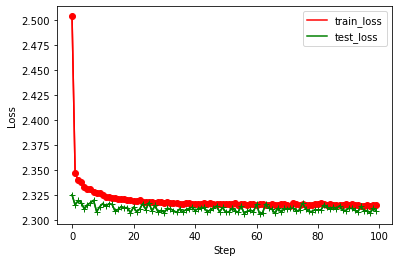

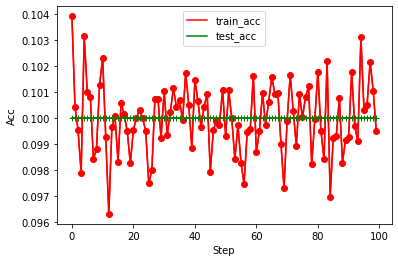

In [31]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [32]:
LOG_PATH="./train13.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn13.pth"
    
model = models.vgg19_bn()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 100
print("Model: VGG-19 with batch normalization")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: VGG-19 with batch normalization
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:48,  8.04it/s]

Finish 1 epoch, Train loss: 3.364819, Train acc@1: 0.099580


Test loss: 2.315463, Test acc@1: 0.099700
Saving Best model...			Top1 = 9.970000%
Elapsed time: 52.9121675491333
---------- Training Epoch #1 ----------


391it [00:48,  8.00it/s]

Finish 2 epoch, Train loss: 2.318897, Train acc@1: 0.145540


Test loss: 2.047553, Test acc@1: 0.185700
Saving Best model...			Top1 = 18.570000%
Elapsed time: 107.11450600624084
---------- Training Epoch #2 ----------


391it [00:49,  7.82it/s]

Finish 3 epoch, Train loss: 2.162535, Train acc@1: 0.202820


Test loss: 1.928121, Test acc@1: 0.223200
Saving Best model...			Top1 = 22.320000%
Elapsed time: 162.62501311302185
---------- Training Epoch #3 ----------


391it [00:47,  8.22it/s]

Finish 4 epoch, Train loss: 2.021477, Train acc@1: 0.218440


Test loss: 1.818066, Test acc@1: 0.249400
Saving Best model...			Top1 = 24.940000%
Elapsed time: 215.6323184967041
---------- Training Epoch #4 ----------


391it [00:45,  8.54it/s]

Finish 5 epoch, Train loss: 1.955751, Train acc@1: 0.269640


Test loss: 1.735286, Test acc@1: 0.322500
Saving Best model...			Top1 = 32.250000%
Elapsed time: 266.7750520706177
---------- Training Epoch #5 ----------


391it [00:47,  8.32it/s]

Finish 6 epoch, Train loss: 1.839465, Train acc@1: 0.317180


Test loss: 1.708628, Test acc@1: 0.332400
Saving Best model...			Top1 = 33.240000%
Elapsed time: 319.2618203163147
---------- Training Epoch #6 ----------


391it [00:44,  8.75it/s]

Finish 7 epoch, Train loss: 1.653668, Train acc@1: 0.385140


Test loss: 1.448684, Test acc@1: 0.452600
Saving Best model...			Top1 = 45.260000%
Elapsed time: 369.45863008499146
---------- Training Epoch #7 ----------


391it [00:45,  8.56it/s]

Finish 8 epoch, Train loss: 1.523530, Train acc@1: 0.445840


Test loss: 1.347932, Test acc@1: 0.512600
Saving Best model...			Top1 = 51.260000%
Elapsed time: 421.25093483924866
---------- Training Epoch #8 ----------


391it [00:48,  8.01it/s]

Finish 9 epoch, Train loss: 1.414859, Train acc@1: 0.491000


Test loss: 1.200500, Test acc@1: 0.556300
Saving Best model...			Top1 = 55.630000%
Elapsed time: 475.95365834236145
---------- Training Epoch #9 ----------


391it [00:46,  8.46it/s]

Finish 10 epoch, Train loss: 1.203714, Train acc@1: 0.578440


Test loss: 1.036665, Test acc@1: 0.641800
Saving Best model...			Top1 = 64.180000%
Elapsed time: 527.5951488018036
---------- Training Epoch #10 ----------


391it [00:48,  8.13it/s]

Finish 11 epoch, Train loss: 1.028309, Train acc@1: 0.648720


Test loss: 1.003185, Test acc@1: 0.664000
Saving Best model...			Top1 = 66.400000%
Elapsed time: 581.1417665481567
---------- Training Epoch #11 ----------


391it [00:44,  8.71it/s]

Finish 12 epoch, Train loss: 0.907380, Train acc@1: 0.695040


Test loss: 0.893969, Test acc@1: 0.701800
Saving Best model...			Top1 = 70.180000%
Elapsed time: 631.3592851161957
---------- Training Epoch #12 ----------


391it [00:48,  8.06it/s]

Finish 13 epoch, Train loss: 0.815104, Train acc@1: 0.729540


Test loss: 1.011746, Test acc@1: 0.666000
Elapsed time: 682.9268281459808
---------- Training Epoch #13 ----------


391it [00:49,  7.91it/s]

Finish 14 epoch, Train loss: 0.722618, Train acc@1: 0.762900


Test loss: 0.771336, Test acc@1: 0.749500
Saving Best model...			Top1 = 74.950000%
Elapsed time: 737.7971258163452
---------- Training Epoch #14 ----------


391it [00:47,  8.15it/s]

Finish 15 epoch, Train loss: 0.650408, Train acc@1: 0.793480


Test loss: 0.714815, Test acc@1: 0.771300
Saving Best model...			Top1 = 77.130000%
Elapsed time: 791.2344989776611
---------- Training Epoch #15 ----------


391it [00:47,  8.21it/s]

Finish 16 epoch, Train loss: 0.596993, Train acc@1: 0.810300


Test loss: 0.725569, Test acc@1: 0.777100
Saving Best model...			Top1 = 77.710000%
Elapsed time: 844.4407405853271
---------- Training Epoch #16 ----------


391it [00:44,  8.73it/s]

Finish 17 epoch, Train loss: 0.542985, Train acc@1: 0.829880


Test loss: 0.720898, Test acc@1: 0.772400
Elapsed time: 892.3254437446594
---------- Training Epoch #17 ----------


391it [00:44,  8.74it/s]

Finish 18 epoch, Train loss: 0.508732, Train acc@1: 0.841080


Test loss: 0.742978, Test acc@1: 0.776500
Elapsed time: 940.669949054718
---------- Training Epoch #18 ----------


391it [00:44,  8.72it/s]

Finish 19 epoch, Train loss: 0.463533, Train acc@1: 0.856500


Test loss: 0.757798, Test acc@1: 0.779800
Saving Best model...			Top1 = 77.980000%
Elapsed time: 991.0314116477966
---------- Training Epoch #19 ----------


391it [00:47,  8.30it/s]

Finish 20 epoch, Train loss: 0.443820, Train acc@1: 0.864820


Test loss: 0.568215, Test acc@1: 0.823500
Saving Best model...			Top1 = 82.350000%
Elapsed time: 1043.5793447494507
---------- Training Epoch #20 ----------


391it [00:44,  8.73it/s]

Finish 21 epoch, Train loss: 0.414382, Train acc@1: 0.874560


Test loss: 0.730584, Test acc@1: 0.800500
Elapsed time: 1091.4934816360474
---------- Training Epoch #21 ----------


391it [00:45,  8.53it/s]

Finish 22 epoch, Train loss: 0.390120, Train acc@1: 0.884400


Test loss: 0.661525, Test acc@1: 0.812800
Elapsed time: 1141.3052060604095
---------- Training Epoch #22 ----------


391it [00:48,  8.13it/s]

Finish 23 epoch, Train loss: 0.368531, Train acc@1: 0.889300


Test loss: 0.600374, Test acc@1: 0.823700
Saving Best model...			Top1 = 82.370000%
Elapsed time: 1194.7722697257996
---------- Training Epoch #23 ----------


391it [00:46,  8.45it/s]

Finish 24 epoch, Train loss: 0.349519, Train acc@1: 0.896280


Test loss: 0.645261, Test acc@1: 0.820800
Elapsed time: 1244.577345609665
---------- Training Epoch #24 ----------


391it [00:45,  8.51it/s]

Finish 25 epoch, Train loss: 0.320812, Train acc@1: 0.903300


Test loss: 0.773938, Test acc@1: 0.794900
Elapsed time: 1294.108996629715
---------- Training Epoch #25 ----------


391it [00:45,  8.55it/s]

Finish 26 epoch, Train loss: 0.315785, Train acc@1: 0.906820


Test loss: 0.638626, Test acc@1: 0.823200
Elapsed time: 1342.9638965129852
---------- Training Epoch #26 ----------


391it [00:45,  8.57it/s]

Finish 27 epoch, Train loss: 0.289866, Train acc@1: 0.915420


Test loss: 0.606066, Test acc@1: 0.831700
Saving Best model...			Top1 = 83.170000%
Elapsed time: 1394.021996498108
---------- Training Epoch #27 ----------


391it [00:50,  7.75it/s]

Finish 28 epoch, Train loss: 0.290181, Train acc@1: 0.915760


Test loss: 0.557488, Test acc@1: 0.850200
Saving Best model...			Top1 = 85.020000%
Elapsed time: 1450.0958938598633
---------- Training Epoch #28 ----------


391it [00:48,  8.03it/s]

Finish 29 epoch, Train loss: 0.266220, Train acc@1: 0.922020


Test loss: 0.701995, Test acc@1: 0.824400
Elapsed time: 1501.9821927547455
---------- Training Epoch #29 ----------


391it [00:47,  8.31it/s]

Finish 30 epoch, Train loss: 0.257856, Train acc@1: 0.925280


Test loss: 0.644595, Test acc@1: 0.835000
Elapsed time: 1552.1947124004364
---------- Training Epoch #30 ----------


391it [00:44,  8.75it/s]

Finish 31 epoch, Train loss: 0.260848, Train acc@1: 0.924360


Test loss: 0.588193, Test acc@1: 0.840900
Elapsed time: 1600.9571523666382
---------- Training Epoch #31 ----------


391it [00:44,  8.75it/s]

Finish 32 epoch, Train loss: 0.238524, Train acc@1: 0.931600


Test loss: 0.613073, Test acc@1: 0.835100
Elapsed time: 1648.7081122398376
---------- Training Epoch #32 ----------


391it [00:46,  8.42it/s]

Finish 33 epoch, Train loss: 0.264634, Train acc@1: 0.924140


Test loss: 0.668903, Test acc@1: 0.822100
Elapsed time: 1698.1961424350739
---------- Training Epoch #33 ----------


391it [00:45,  8.57it/s]

Finish 34 epoch, Train loss: 0.226316, Train acc@1: 0.935800


Test loss: 0.822739, Test acc@1: 0.822600
Elapsed time: 1748.067656993866
---------- Training Epoch #34 ----------


391it [00:47,  8.23it/s]

Finish 35 epoch, Train loss: 0.227010, Train acc@1: 0.936140


Test loss: 0.725044, Test acc@1: 0.819700
Elapsed time: 1799.1409332752228
---------- Training Epoch #35 ----------


391it [00:47,  8.28it/s]

Finish 36 epoch, Train loss: 0.221844, Train acc@1: 0.937120


Test loss: 0.671094, Test acc@1: 0.831600
Elapsed time: 1849.5035438537598
---------- Training Epoch #36 ----------


391it [00:44,  8.72it/s]

Finish 37 epoch, Train loss: 0.224939, Train acc@1: 0.936780


Test loss: 0.606063, Test acc@1: 0.837400
Elapsed time: 1898.0143795013428
---------- Training Epoch #37 ----------


391it [00:44,  8.77it/s]

Finish 38 epoch, Train loss: 0.217454, Train acc@1: 0.938280


Test loss: 0.621913, Test acc@1: 0.842000
Elapsed time: 1945.7105419635773
---------- Training Epoch #38 ----------


391it [00:45,  8.54it/s]

Finish 39 epoch, Train loss: 0.211170, Train acc@1: 0.939400


Test loss: 0.573932, Test acc@1: 0.850800
Saving Best model...			Top1 = 85.080000%
Elapsed time: 1997.0283546447754
---------- Training Epoch #39 ----------


391it [00:46,  8.42it/s]

Finish 40 epoch, Train loss: 0.200823, Train acc@1: 0.942600


Test loss: 0.692121, Test acc@1: 0.835200
Elapsed time: 2046.6205625534058
---------- Training Epoch #40 ----------


391it [00:44,  8.72it/s]

Finish 41 epoch, Train loss: 0.202840, Train acc@1: 0.943940


Test loss: 0.629725, Test acc@1: 0.841200
Elapsed time: 2094.493560552597
---------- Training Epoch #41 ----------


391it [00:44,  8.74it/s]

Finish 42 epoch, Train loss: 0.195296, Train acc@1: 0.944480


Test loss: 0.717729, Test acc@1: 0.828600
Elapsed time: 2142.4460768699646
---------- Training Epoch #42 ----------


391it [00:44,  8.72it/s]

Finish 43 epoch, Train loss: 0.195236, Train acc@1: 0.945740


Test loss: 0.602950, Test acc@1: 0.844400
Elapsed time: 2190.403316259384
---------- Training Epoch #43 ----------


391it [00:44,  8.73it/s]

Finish 44 epoch, Train loss: 0.190401, Train acc@1: 0.946420


Test loss: 0.707602, Test acc@1: 0.822200
Elapsed time: 2238.388905763626
---------- Training Epoch #44 ----------


391it [00:44,  8.74it/s]

Finish 45 epoch, Train loss: 0.183547, Train acc@1: 0.949360


Test loss: 0.750960, Test acc@1: 0.820300
Elapsed time: 2286.1935300827026
---------- Training Epoch #45 ----------


391it [00:44,  8.72it/s]

Finish 46 epoch, Train loss: 0.190183, Train acc@1: 0.947120


Test loss: 0.755888, Test acc@1: 0.814100
Elapsed time: 2334.1442017555237
---------- Training Epoch #46 ----------


391it [00:48,  8.09it/s]

Finish 47 epoch, Train loss: 0.182097, Train acc@1: 0.950920


Test loss: 0.630544, Test acc@1: 0.848400
Elapsed time: 2385.646394252777
---------- Training Epoch #47 ----------


391it [00:46,  8.39it/s]

Finish 48 epoch, Train loss: 0.183535, Train acc@1: 0.950700


Test loss: 0.815791, Test acc@1: 0.815700
Elapsed time: 2435.392069339752
---------- Training Epoch #48 ----------


391it [00:44,  8.76it/s]

Finish 49 epoch, Train loss: 0.177522, Train acc@1: 0.951420


Test loss: 0.608191, Test acc@1: 0.845800
Elapsed time: 2483.1566104888916
---------- Training Epoch #49 ----------


391it [00:44,  8.75it/s]

Finish 50 epoch, Train loss: 0.172720, Train acc@1: 0.953160


Test loss: 0.654034, Test acc@1: 0.845400
Elapsed time: 2530.9483506679535
---------- Training Epoch #50 ----------


391it [00:44,  8.72it/s]

Finish 51 epoch, Train loss: 0.172380, Train acc@1: 0.952800


Test loss: 0.691122, Test acc@1: 0.836800
Elapsed time: 2578.91602063179
---------- Training Epoch #51 ----------


391it [00:44,  8.71it/s]

Finish 52 epoch, Train loss: 0.170861, Train acc@1: 0.953220


Test loss: 0.657087, Test acc@1: 0.841200
Elapsed time: 2626.9254603385925
---------- Training Epoch #52 ----------


391it [00:47,  8.27it/s]

Finish 53 epoch, Train loss: 0.166560, Train acc@1: 0.953760


Test loss: 0.597225, Test acc@1: 0.849700
Elapsed time: 2677.341975212097
---------- Training Epoch #53 ----------


391it [00:45,  8.55it/s]

Finish 54 epoch, Train loss: 0.168381, Train acc@1: 0.954460


Test loss: 0.679478, Test acc@1: 0.841100
Elapsed time: 2726.650199651718
---------- Training Epoch #54 ----------


391it [00:44,  8.76it/s]

Finish 55 epoch, Train loss: 0.166899, Train acc@1: 0.954700


Test loss: 0.686776, Test acc@1: 0.844600
Elapsed time: 2775.453152179718
---------- Training Epoch #55 ----------


391it [00:47,  8.23it/s]

Finish 56 epoch, Train loss: 0.167574, Train acc@1: 0.954140


Test loss: 0.679013, Test acc@1: 0.834700
Elapsed time: 2825.9896042346954
---------- Training Epoch #56 ----------


391it [00:46,  8.48it/s]

Finish 57 epoch, Train loss: 0.167665, Train acc@1: 0.954140


Test loss: 0.608768, Test acc@1: 0.851400
Saving Best model...			Top1 = 85.140000%
Elapsed time: 2877.6211409568787
---------- Training Epoch #57 ----------


391it [00:47,  8.22it/s]

Finish 58 epoch, Train loss: 0.163795, Train acc@1: 0.956200


Test loss: 0.668546, Test acc@1: 0.842300
Elapsed time: 2928.3316502571106
---------- Training Epoch #58 ----------


391it [00:44,  8.71it/s]

Finish 59 epoch, Train loss: 0.160644, Train acc@1: 0.957160


Test loss: 0.814946, Test acc@1: 0.819100
Elapsed time: 2976.3015456199646
---------- Training Epoch #59 ----------


391it [00:45,  8.54it/s]

Finish 60 epoch, Train loss: 0.161887, Train acc@1: 0.955840


Test loss: 0.629945, Test acc@1: 0.854300
Saving Best model...			Top1 = 85.430000%
Elapsed time: 3027.483439207077
---------- Training Epoch #60 ----------


391it [00:47,  8.25it/s]

Finish 61 epoch, Train loss: 0.154285, Train acc@1: 0.957520


Test loss: 0.703850, Test acc@1: 0.840600
Elapsed time: 3077.9747309684753
---------- Training Epoch #61 ----------


391it [00:45,  8.51it/s]

Finish 62 epoch, Train loss: 0.154476, Train acc@1: 0.958260


Test loss: 0.589547, Test acc@1: 0.850000
Elapsed time: 3127.0008709430695
---------- Training Epoch #62 ----------


391it [00:44,  8.73it/s]

Finish 63 epoch, Train loss: 0.153303, Train acc@1: 0.958640


Test loss: 0.709518, Test acc@1: 0.843500
Elapsed time: 3175.451187610626
---------- Training Epoch #63 ----------


391it [00:46,  8.45it/s]

Finish 64 epoch, Train loss: 0.159507, Train acc@1: 0.957200


Test loss: 0.742623, Test acc@1: 0.835400
Elapsed time: 3225.2984080314636
---------- Training Epoch #64 ----------


391it [00:45,  8.52it/s]

Finish 65 epoch, Train loss: 0.150458, Train acc@1: 0.959360


Test loss: 0.699358, Test acc@1: 0.833600
Elapsed time: 3274.3255348205566
---------- Training Epoch #65 ----------


391it [00:45,  8.55it/s]

Finish 66 epoch, Train loss: 0.152261, Train acc@1: 0.958580


Test loss: 0.714234, Test acc@1: 0.838700
Elapsed time: 3323.787243127823
---------- Training Epoch #66 ----------


391it [00:47,  8.28it/s]

Finish 67 epoch, Train loss: 0.148708, Train acc@1: 0.960820


Test loss: 0.651109, Test acc@1: 0.843000
Elapsed time: 3374.1373295783997
---------- Training Epoch #67 ----------


391it [00:45,  8.51it/s]

Finish 68 epoch, Train loss: 0.139478, Train acc@1: 0.962320


Test loss: 0.842470, Test acc@1: 0.832000
Elapsed time: 3424.2431225776672
---------- Training Epoch #68 ----------


391it [00:47,  8.30it/s]

Finish 69 epoch, Train loss: 0.155632, Train acc@1: 0.958980


Test loss: 0.680406, Test acc@1: 0.847600
Elapsed time: 3475.320875644684
---------- Training Epoch #69 ----------


391it [00:47,  8.18it/s]

Finish 70 epoch, Train loss: 0.149110, Train acc@1: 0.959600


Test loss: 0.858651, Test acc@1: 0.805500
Elapsed time: 3526.672039270401
---------- Training Epoch #70 ----------


391it [00:47,  8.25it/s]

Finish 71 epoch, Train loss: 0.151219, Train acc@1: 0.959240


Test loss: 0.718507, Test acc@1: 0.839400
Elapsed time: 3577.200522661209
---------- Training Epoch #71 ----------


391it [00:48,  8.04it/s]

Finish 72 epoch, Train loss: 0.141874, Train acc@1: 0.961060


Test loss: 0.622915, Test acc@1: 0.849600
Elapsed time: 3628.927283525467
---------- Training Epoch #72 ----------


391it [00:48,  7.99it/s]

Finish 73 epoch, Train loss: 0.141649, Train acc@1: 0.962740


Test loss: 0.691210, Test acc@1: 0.836200
Elapsed time: 3680.9325206279755
---------- Training Epoch #73 ----------


391it [00:45,  8.52it/s]

Finish 74 epoch, Train loss: 0.140244, Train acc@1: 0.962600


Test loss: 0.701177, Test acc@1: 0.835100
Elapsed time: 3729.940434217453
---------- Training Epoch #74 ----------


391it [00:44,  8.75it/s]

Finish 75 epoch, Train loss: 0.145642, Train acc@1: 0.960800


Test loss: 0.633882, Test acc@1: 0.847600
Elapsed time: 3777.7271304130554
---------- Training Epoch #75 ----------


391it [00:44,  8.75it/s]

Finish 76 epoch, Train loss: 0.143169, Train acc@1: 0.962160


Test loss: 0.730121, Test acc@1: 0.838400
Elapsed time: 3825.590056657791
---------- Training Epoch #76 ----------


391it [00:47,  8.29it/s]

Finish 77 epoch, Train loss: 0.137787, Train acc@1: 0.961880


Test loss: 0.635965, Test acc@1: 0.846100
Elapsed time: 3875.8618426322937
---------- Training Epoch #77 ----------


391it [00:45,  8.51it/s]

Finish 78 epoch, Train loss: 0.141011, Train acc@1: 0.962400


Test loss: 0.724425, Test acc@1: 0.840300
Elapsed time: 3924.8981981277466
---------- Training Epoch #78 ----------


391it [00:44,  8.73it/s]

Finish 79 epoch, Train loss: 0.140000, Train acc@1: 0.962880


Test loss: 0.812019, Test acc@1: 0.826300
Elapsed time: 3972.8477823734283
---------- Training Epoch #79 ----------


391it [00:46,  8.43it/s]

Finish 80 epoch, Train loss: 0.134279, Train acc@1: 0.964740


Test loss: 0.669420, Test acc@1: 0.845900
Elapsed time: 4022.359589099884
---------- Training Epoch #80 ----------


391it [00:44,  8.75it/s]

Finish 81 epoch, Train loss: 0.133213, Train acc@1: 0.964400


Test loss: 0.720462, Test acc@1: 0.838200
Elapsed time: 4070.1056723594666
---------- Training Epoch #81 ----------


391it [00:44,  8.74it/s]

Finish 82 epoch, Train loss: 0.135165, Train acc@1: 0.964120


Test loss: 0.688678, Test acc@1: 0.839300
Elapsed time: 4117.898506641388
---------- Training Epoch #82 ----------


391it [00:44,  8.70it/s]

Finish 83 epoch, Train loss: 0.140509, Train acc@1: 0.961920


Test loss: 0.671454, Test acc@1: 0.849700
Elapsed time: 4165.905871629715
---------- Training Epoch #83 ----------


391it [00:44,  8.75it/s]

Finish 84 epoch, Train loss: 0.140893, Train acc@1: 0.961260


Test loss: 0.741061, Test acc@1: 0.843500
Elapsed time: 4213.798060894012
---------- Training Epoch #84 ----------


391it [00:44,  8.74it/s]

Finish 85 epoch, Train loss: 0.136520, Train acc@1: 0.963500


Test loss: 0.674463, Test acc@1: 0.848500
Elapsed time: 4261.656007528305
---------- Training Epoch #85 ----------


391it [00:44,  8.74it/s]

Finish 86 epoch, Train loss: 0.132286, Train acc@1: 0.965000


Test loss: 0.625631, Test acc@1: 0.853700
Elapsed time: 4309.568958997726
---------- Training Epoch #86 ----------


391it [00:44,  8.74it/s]

Finish 87 epoch, Train loss: 0.132090, Train acc@1: 0.964580


Test loss: 0.789013, Test acc@1: 0.827300
Elapsed time: 4357.4003529548645
---------- Training Epoch #87 ----------


391it [00:44,  8.74it/s]

Finish 88 epoch, Train loss: 0.128659, Train acc@1: 0.964920


Test loss: 0.671092, Test acc@1: 0.848000
Elapsed time: 4405.226248502731
---------- Training Epoch #88 ----------


391it [00:44,  8.72it/s]

Finish 89 epoch, Train loss: 0.134987, Train acc@1: 0.964300


Test loss: 0.806536, Test acc@1: 0.828100
Elapsed time: 4453.2145483493805
---------- Training Epoch #89 ----------


391it [00:44,  8.75it/s]

Finish 90 epoch, Train loss: 0.129559, Train acc@1: 0.966000


Test loss: 0.673011, Test acc@1: 0.847200
Elapsed time: 4500.973497390747
---------- Training Epoch #90 ----------


391it [00:44,  8.74it/s]

Finish 91 epoch, Train loss: 0.134707, Train acc@1: 0.963660


Test loss: 0.868769, Test acc@1: 0.823400
Elapsed time: 4548.836660861969
---------- Training Epoch #91 ----------


391it [00:44,  8.72it/s]

Finish 92 epoch, Train loss: 0.134889, Train acc@1: 0.964280


Test loss: 0.777587, Test acc@1: 0.836700
Elapsed time: 4596.816167593002
---------- Training Epoch #92 ----------


391it [00:46,  8.34it/s]

Finish 93 epoch, Train loss: 0.132594, Train acc@1: 0.965240


Test loss: 0.733215, Test acc@1: 0.840800
Elapsed time: 4647.6669590473175
---------- Training Epoch #93 ----------


391it [00:44,  8.75it/s]

Finish 94 epoch, Train loss: 0.129461, Train acc@1: 0.966000


Test loss: 0.734222, Test acc@1: 0.844400
Elapsed time: 4696.436427354813
---------- Training Epoch #94 ----------


391it [00:47,  8.16it/s]

Finish 95 epoch, Train loss: 0.129759, Train acc@1: 0.965980


Test loss: 0.666890, Test acc@1: 0.840800
Elapsed time: 4748.412044763565
---------- Training Epoch #95 ----------


391it [00:46,  8.44it/s]

Finish 96 epoch, Train loss: 0.130858, Train acc@1: 0.964760


Test loss: 0.790476, Test acc@1: 0.827400
Elapsed time: 4797.851152181625
---------- Training Epoch #96 ----------


391it [00:45,  8.55it/s]

Finish 97 epoch, Train loss: 0.130417, Train acc@1: 0.965760


Test loss: 0.730302, Test acc@1: 0.834900
Elapsed time: 4846.622610330582
---------- Training Epoch #97 ----------


391it [00:44,  8.77it/s]

Finish 98 epoch, Train loss: 0.131391, Train acc@1: 0.965240


Test loss: 0.819509, Test acc@1: 0.828300
Elapsed time: 4894.3079788684845
---------- Training Epoch #98 ----------


391it [00:44,  8.72it/s]

Finish 99 epoch, Train loss: 0.132620, Train acc@1: 0.965540


Test loss: 0.645511, Test acc@1: 0.843900
Elapsed time: 4942.23996424675
---------- Training Epoch #99 ----------


391it [00:44,  8.74it/s]

Finish 100 epoch, Train loss: 0.131911, Train acc@1: 0.965240


Test loss: 0.781360, Test acc@1: 0.842700
Elapsed time: 4990.091088056564

Test results: Acc@1 = 85.430000%


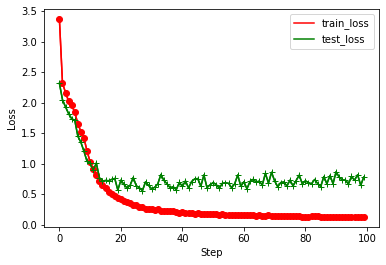

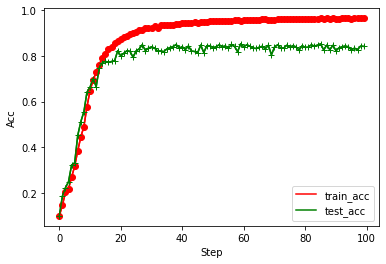

In [33]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [34]:
LOG_PATH="./train14.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn14.pth"
    
model = models.densenet121()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 100
print("Model: Densenet-121")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: Densenet-121
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [01:06,  5.86it/s]

Finish 1 epoch, Train loss: 1.436060, Train acc@1: 0.495380


Test loss: 1.227095, Test acc@1: 0.562900
Saving Best model...			Top1 = 56.290000%
Elapsed time: 71.1184344291687
---------- Training Epoch #1 ----------


391it [01:03,  6.11it/s]

Finish 2 epoch, Train loss: 1.040533, Train acc@1: 0.633200


Test loss: 0.938062, Test acc@1: 0.674000
Saving Best model...			Top1 = 67.400000%
Elapsed time: 139.50757694244385
---------- Training Epoch #2 ----------


391it [01:01,  6.36it/s]

Finish 3 epoch, Train loss: 0.848796, Train acc@1: 0.703240


Test loss: 0.830135, Test acc@1: 0.708200
Saving Best model...			Top1 = 70.820000%
Elapsed time: 205.1734049320221
---------- Training Epoch #3 ----------


391it [01:06,  5.91it/s]

Finish 4 epoch, Train loss: 0.736595, Train acc@1: 0.744340


Test loss: 0.786424, Test acc@1: 0.726700
Saving Best model...			Top1 = 72.670000%
Elapsed time: 275.5468852519989
---------- Training Epoch #4 ----------


391it [01:05,  5.96it/s]

Finish 5 epoch, Train loss: 0.648706, Train acc@1: 0.775600


Test loss: 0.791098, Test acc@1: 0.723200
Elapsed time: 345.14536118507385
---------- Training Epoch #5 ----------


391it [01:03,  6.13it/s]

Finish 6 epoch, Train loss: 0.588543, Train acc@1: 0.796420


Test loss: 0.794043, Test acc@1: 0.728400
Saving Best model...			Top1 = 72.840000%
Elapsed time: 413.4997811317444
---------- Training Epoch #6 ----------


391it [01:03,  6.20it/s]

Finish 7 epoch, Train loss: 0.525786, Train acc@1: 0.817780


Test loss: 0.732104, Test acc@1: 0.755300
Saving Best model...			Top1 = 75.530000%
Elapsed time: 480.7372522354126
---------- Training Epoch #7 ----------


391it [01:03,  6.16it/s]

Finish 8 epoch, Train loss: 0.482480, Train acc@1: 0.833060


Test loss: 0.709179, Test acc@1: 0.764700
Saving Best model...			Top1 = 76.470000%
Elapsed time: 549.1059188842773
---------- Training Epoch #8 ----------


391it [01:05,  5.98it/s]

Finish 9 epoch, Train loss: 0.435125, Train acc@1: 0.850040


Test loss: 0.787237, Test acc@1: 0.745500
Elapsed time: 618.6068584918976
---------- Training Epoch #9 ----------


391it [01:03,  6.18it/s]

Finish 10 epoch, Train loss: 0.404994, Train acc@1: 0.859940


Test loss: 0.695099, Test acc@1: 0.770100
Saving Best model...			Top1 = 77.010000%
Elapsed time: 685.9562520980835
---------- Training Epoch #10 ----------


391it [01:05,  6.00it/s]

Finish 11 epoch, Train loss: 0.373481, Train acc@1: 0.870980


Test loss: 0.744415, Test acc@1: 0.759500
Elapsed time: 755.1572539806366
---------- Training Epoch #11 ----------


391it [01:04,  6.07it/s]

Finish 12 epoch, Train loss: 0.348029, Train acc@1: 0.879480


Test loss: 0.773908, Test acc@1: 0.756500
Elapsed time: 823.66211104393
---------- Training Epoch #12 ----------


391it [01:02,  6.27it/s]

Finish 13 epoch, Train loss: 0.319972, Train acc@1: 0.888340


Test loss: 0.725327, Test acc@1: 0.770100
Elapsed time: 890.6925404071808
---------- Training Epoch #13 ----------


391it [01:02,  6.22it/s]

Finish 14 epoch, Train loss: 0.301772, Train acc@1: 0.894480


Test loss: 0.731698, Test acc@1: 0.771400
Saving Best model...			Top1 = 77.140000%
Elapsed time: 957.7308914661407
---------- Training Epoch #14 ----------


391it [01:06,  5.92it/s]

Finish 15 epoch, Train loss: 0.285495, Train acc@1: 0.901320


Test loss: 0.769442, Test acc@1: 0.759800
Elapsed time: 1027.9588117599487
---------- Training Epoch #15 ----------


391it [01:00,  6.44it/s]

Finish 16 epoch, Train loss: 0.267277, Train acc@1: 0.906620


Test loss: 0.832239, Test acc@1: 0.750800
Elapsed time: 1092.7504184246063
---------- Training Epoch #16 ----------


391it [01:04,  6.06it/s]

Finish 17 epoch, Train loss: 0.257922, Train acc@1: 0.910480


Test loss: 0.737293, Test acc@1: 0.780500
Saving Best model...			Top1 = 78.050000%
Elapsed time: 1161.9123091697693
---------- Training Epoch #17 ----------


391it [01:05,  5.95it/s]

Finish 18 epoch, Train loss: 0.244034, Train acc@1: 0.913620


Test loss: 0.784081, Test acc@1: 0.770100
Elapsed time: 1231.559410572052
---------- Training Epoch #18 ----------


391it [01:06,  5.87it/s]

Finish 19 epoch, Train loss: 0.237780, Train acc@1: 0.916060


Test loss: 0.787995, Test acc@1: 0.770800
Elapsed time: 1302.5744030475616
---------- Training Epoch #19 ----------


391it [01:03,  6.19it/s]

Finish 20 epoch, Train loss: 0.231251, Train acc@1: 0.919200


Test loss: 0.775854, Test acc@1: 0.778000
Elapsed time: 1369.765814781189
---------- Training Epoch #20 ----------


391it [01:04,  6.04it/s]

Finish 21 epoch, Train loss: 0.220254, Train acc@1: 0.922720


Test loss: 0.764361, Test acc@1: 0.784400
Saving Best model...			Top1 = 78.440000%
Elapsed time: 1438.804241657257
---------- Training Epoch #21 ----------


391it [01:04,  6.04it/s]

Finish 22 epoch, Train loss: 0.212427, Train acc@1: 0.925860


Test loss: 0.781618, Test acc@1: 0.777200
Elapsed time: 1507.6038908958435
---------- Training Epoch #22 ----------


391it [01:01,  6.34it/s]

Finish 23 epoch, Train loss: 0.210480, Train acc@1: 0.927260


Test loss: 0.778033, Test acc@1: 0.775300
Elapsed time: 1573.8140976428986
---------- Training Epoch #23 ----------


391it [01:00,  6.43it/s]

Finish 24 epoch, Train loss: 0.208538, Train acc@1: 0.927180


Test loss: 0.739362, Test acc@1: 0.787900
Saving Best model...			Top1 = 78.790000%
Elapsed time: 1638.8001923561096
---------- Training Epoch #24 ----------


391it [01:03,  6.12it/s]

Finish 25 epoch, Train loss: 0.200462, Train acc@1: 0.929960


Test loss: 0.786675, Test acc@1: 0.776700
Elapsed time: 1706.7471463680267
---------- Training Epoch #25 ----------


391it [01:04,  6.08it/s]

Finish 26 epoch, Train loss: 0.196241, Train acc@1: 0.932540


Test loss: 0.761861, Test acc@1: 0.786700
Elapsed time: 1775.1950242519379
---------- Training Epoch #26 ----------


391it [01:04,  6.10it/s]

Finish 27 epoch, Train loss: 0.192529, Train acc@1: 0.932380


Test loss: 0.818278, Test acc@1: 0.776000
Elapsed time: 1843.4404492378235
---------- Training Epoch #27 ----------


391it [00:58,  6.67it/s]

Finish 28 epoch, Train loss: 0.186778, Train acc@1: 0.934540


Test loss: 0.818051, Test acc@1: 0.775800
Elapsed time: 1906.0328600406647
---------- Training Epoch #28 ----------


391it [01:04,  6.07it/s]

Finish 29 epoch, Train loss: 0.188024, Train acc@1: 0.933820


Test loss: 0.768489, Test acc@1: 0.784700
Elapsed time: 1974.6398022174835
---------- Training Epoch #29 ----------


391it [01:03,  6.11it/s]

Finish 30 epoch, Train loss: 0.179385, Train acc@1: 0.936260


Test loss: 0.811018, Test acc@1: 0.777400
Elapsed time: 2042.6527361869812
---------- Training Epoch #30 ----------


391it [01:02,  6.25it/s]

Finish 31 epoch, Train loss: 0.178720, Train acc@1: 0.937620


Test loss: 0.805072, Test acc@1: 0.777300
Elapsed time: 2109.2876873016357
---------- Training Epoch #31 ----------


391it [01:03,  6.12it/s]

Finish 32 epoch, Train loss: 0.178482, Train acc@1: 0.938680


Test loss: 0.803752, Test acc@1: 0.777800
Elapsed time: 2177.152903318405
---------- Training Epoch #32 ----------


391it [01:00,  6.46it/s]

Finish 33 epoch, Train loss: 0.172182, Train acc@1: 0.940420


Test loss: 0.850281, Test acc@1: 0.769600
Elapsed time: 2242.3064880371094
---------- Training Epoch #33 ----------


391it [01:06,  5.90it/s]

Finish 34 epoch, Train loss: 0.175591, Train acc@1: 0.938520


Test loss: 0.782723, Test acc@1: 0.786600
Elapsed time: 2312.560662508011
---------- Training Epoch #34 ----------


391it [01:06,  5.91it/s]

Finish 35 epoch, Train loss: 0.169076, Train acc@1: 0.942180


Test loss: 0.795478, Test acc@1: 0.783700
Elapsed time: 2382.78879404068
---------- Training Epoch #35 ----------


391it [01:05,  5.98it/s]

Finish 36 epoch, Train loss: 0.163760, Train acc@1: 0.942840


Test loss: 0.789612, Test acc@1: 0.786700
Elapsed time: 2452.675572872162
---------- Training Epoch #36 ----------


391it [01:04,  6.11it/s]

Finish 37 epoch, Train loss: 0.168645, Train acc@1: 0.940740


Test loss: 0.769670, Test acc@1: 0.786000
Elapsed time: 2520.8165521621704
---------- Training Epoch #37 ----------


391it [01:05,  6.00it/s]

Finish 38 epoch, Train loss: 0.164740, Train acc@1: 0.943060


Test loss: 0.813810, Test acc@1: 0.781200
Elapsed time: 2590.1203849315643
---------- Training Epoch #38 ----------


391it [01:04,  6.02it/s]

Finish 39 epoch, Train loss: 0.159086, Train acc@1: 0.944680


Test loss: 0.853575, Test acc@1: 0.778100
Elapsed time: 2659.121208667755
---------- Training Epoch #39 ----------


391it [01:04,  6.02it/s]

Finish 40 epoch, Train loss: 0.160779, Train acc@1: 0.943960


Test loss: 0.833788, Test acc@1: 0.780400
Elapsed time: 2728.792683362961
---------- Training Epoch #40 ----------


391it [01:05,  5.99it/s]

Finish 41 epoch, Train loss: 0.158657, Train acc@1: 0.944340


Test loss: 0.808833, Test acc@1: 0.790700
Saving Best model...			Top1 = 79.070000%
Elapsed time: 2798.25098323822
---------- Training Epoch #41 ----------


391it [01:06,  5.89it/s]

Finish 42 epoch, Train loss: 0.159843, Train acc@1: 0.944140


Test loss: 0.855420, Test acc@1: 0.771000
Elapsed time: 2868.6127829551697
---------- Training Epoch #42 ----------


391it [01:05,  5.93it/s]

Finish 43 epoch, Train loss: 0.155922, Train acc@1: 0.945540


Test loss: 0.805860, Test acc@1: 0.780900
Elapsed time: 2938.669248342514
---------- Training Epoch #43 ----------


391it [01:06,  5.86it/s]

Finish 44 epoch, Train loss: 0.154498, Train acc@1: 0.945900


Test loss: 0.797227, Test acc@1: 0.786800
Elapsed time: 3009.5626351833344
---------- Training Epoch #44 ----------


391it [01:07,  5.83it/s]

Finish 45 epoch, Train loss: 0.149777, Train acc@1: 0.948020


Test loss: 0.890768, Test acc@1: 0.774900
Elapsed time: 3080.635307788849
---------- Training Epoch #45 ----------


391it [01:08,  5.73it/s]

Finish 46 epoch, Train loss: 0.149511, Train acc@1: 0.948520


Test loss: 0.834329, Test acc@1: 0.780700
Elapsed time: 3152.9135794639587
---------- Training Epoch #46 ----------


391it [01:10,  5.55it/s]

Finish 47 epoch, Train loss: 0.155639, Train acc@1: 0.945940


Test loss: 0.818118, Test acc@1: 0.784400
Elapsed time: 3228.3282475471497
---------- Training Epoch #47 ----------


391it [01:23,  4.70it/s]

Finish 48 epoch, Train loss: 0.152344, Train acc@1: 0.946420


Test loss: 0.796913, Test acc@1: 0.784600
Elapsed time: 3317.026291847229
---------- Training Epoch #48 ----------


391it [01:22,  4.74it/s]

Finish 49 epoch, Train loss: 0.147940, Train acc@1: 0.949140


Test loss: 0.800798, Test acc@1: 0.786800
Elapsed time: 3404.78285074234
---------- Training Epoch #49 ----------


391it [01:22,  4.74it/s]

Finish 50 epoch, Train loss: 0.148157, Train acc@1: 0.948400


Test loss: 0.818663, Test acc@1: 0.787100
Elapsed time: 3492.581027507782
---------- Training Epoch #50 ----------


391it [01:23,  4.67it/s]

Finish 51 epoch, Train loss: 0.146604, Train acc@1: 0.948920


Test loss: 0.808236, Test acc@1: 0.786600
Elapsed time: 3581.3663623332977
---------- Training Epoch #51 ----------


391it [01:23,  4.71it/s]

Finish 52 epoch, Train loss: 0.148150, Train acc@1: 0.947840


Test loss: 0.788947, Test acc@1: 0.788600
Elapsed time: 3670.2493081092834
---------- Training Epoch #52 ----------


391it [01:22,  4.75it/s]

Finish 53 epoch, Train loss: 0.144274, Train acc@1: 0.950500


Test loss: 0.838827, Test acc@1: 0.780800
Elapsed time: 3757.7277665138245
---------- Training Epoch #53 ----------


391it [01:22,  4.74it/s]

Finish 54 epoch, Train loss: 0.147061, Train acc@1: 0.948520


Test loss: 0.795030, Test acc@1: 0.782900
Elapsed time: 3845.366576194763
---------- Training Epoch #54 ----------


391it [01:22,  4.73it/s]

Finish 55 epoch, Train loss: 0.144258, Train acc@1: 0.949460


Test loss: 0.810815, Test acc@1: 0.783200
Elapsed time: 3932.9702055454254
---------- Training Epoch #55 ----------


391it [01:22,  4.74it/s]

Finish 56 epoch, Train loss: 0.141241, Train acc@1: 0.951760


Test loss: 0.783005, Test acc@1: 0.791800
Saving Best model...			Top1 = 79.180000%
Elapsed time: 4020.884402513504
---------- Training Epoch #56 ----------


391it [01:24,  4.61it/s]

Finish 57 epoch, Train loss: 0.141796, Train acc@1: 0.949840


Test loss: 0.824219, Test acc@1: 0.782600
Elapsed time: 4110.744019031525
---------- Training Epoch #57 ----------


391it [01:23,  4.70it/s]

Finish 58 epoch, Train loss: 0.144905, Train acc@1: 0.949740


Test loss: 0.807319, Test acc@1: 0.793700
Saving Best model...			Top1 = 79.370000%
Elapsed time: 4199.544551610947
---------- Training Epoch #58 ----------


391it [01:23,  4.67it/s]

Finish 59 epoch, Train loss: 0.141399, Train acc@1: 0.950880


Test loss: 0.817670, Test acc@1: 0.786300
Elapsed time: 4288.320135831833
---------- Training Epoch #59 ----------


391it [01:09,  5.65it/s]

Finish 60 epoch, Train loss: 0.138732, Train acc@1: 0.951160


Test loss: 0.789560, Test acc@1: 0.793700
Elapsed time: 4361.811512470245
---------- Training Epoch #60 ----------


391it [01:06,  5.92it/s]

Finish 61 epoch, Train loss: 0.139523, Train acc@1: 0.951660


Test loss: 0.842108, Test acc@1: 0.782100
Elapsed time: 4432.236959218979
---------- Training Epoch #61 ----------


391it [01:05,  6.01it/s]

Finish 62 epoch, Train loss: 0.140044, Train acc@1: 0.952000


Test loss: 0.902245, Test acc@1: 0.772500
Elapsed time: 4502.107913732529
---------- Training Epoch #62 ----------


391it [01:06,  5.90it/s]

Finish 63 epoch, Train loss: 0.138147, Train acc@1: 0.951700


Test loss: 0.858686, Test acc@1: 0.786500
Elapsed time: 4572.594971895218
---------- Training Epoch #63 ----------


391it [01:05,  5.96it/s]

Finish 64 epoch, Train loss: 0.133049, Train acc@1: 0.954040


Test loss: 0.804451, Test acc@1: 0.791200
Elapsed time: 4642.427410364151
---------- Training Epoch #64 ----------


391it [01:02,  6.25it/s]

Finish 65 epoch, Train loss: 0.134343, Train acc@1: 0.952940


Test loss: 0.795337, Test acc@1: 0.790600
Elapsed time: 4709.058660268784
---------- Training Epoch #65 ----------


391it [01:05,  5.93it/s]

Finish 66 epoch, Train loss: 0.138209, Train acc@1: 0.951340


Test loss: 0.832730, Test acc@1: 0.782200
Elapsed time: 4778.970486402512
---------- Training Epoch #66 ----------


391it [01:07,  5.79it/s]

Finish 67 epoch, Train loss: 0.135441, Train acc@1: 0.952800


Test loss: 0.848271, Test acc@1: 0.782000
Elapsed time: 4850.806939601898
---------- Training Epoch #67 ----------


391it [01:04,  6.09it/s]

Finish 68 epoch, Train loss: 0.137617, Train acc@1: 0.951220


Test loss: 0.854132, Test acc@1: 0.779300
Elapsed time: 4918.999487400055
---------- Training Epoch #68 ----------


391it [01:08,  5.69it/s]

Finish 69 epoch, Train loss: 0.138065, Train acc@1: 0.951980


Test loss: 0.805010, Test acc@1: 0.792000
Elapsed time: 4992.047595739365
---------- Training Epoch #69 ----------


391it [01:06,  5.87it/s]

Finish 70 epoch, Train loss: 0.132232, Train acc@1: 0.953760


Test loss: 0.812650, Test acc@1: 0.785800
Elapsed time: 5062.840041637421
---------- Training Epoch #70 ----------


391it [01:06,  5.84it/s]

Finish 71 epoch, Train loss: 0.132623, Train acc@1: 0.953900


Test loss: 0.813730, Test acc@1: 0.791600
Elapsed time: 5133.800223112106
---------- Training Epoch #71 ----------


391it [01:06,  5.89it/s]

Finish 72 epoch, Train loss: 0.133511, Train acc@1: 0.952760


Test loss: 0.797634, Test acc@1: 0.790600
Elapsed time: 5204.171639442444
---------- Training Epoch #72 ----------


391it [01:06,  5.87it/s]

Finish 73 epoch, Train loss: 0.132585, Train acc@1: 0.953860


Test loss: 0.796461, Test acc@1: 0.793500
Elapsed time: 5274.888873100281
---------- Training Epoch #73 ----------


391it [01:04,  6.04it/s]

Finish 74 epoch, Train loss: 0.132801, Train acc@1: 0.953240


Test loss: 0.889157, Test acc@1: 0.778700
Elapsed time: 5343.752825260162
---------- Training Epoch #74 ----------


391it [01:03,  6.13it/s]

Finish 75 epoch, Train loss: 0.132439, Train acc@1: 0.954440


Test loss: 0.837600, Test acc@1: 0.782400
Elapsed time: 5411.674181222916
---------- Training Epoch #75 ----------


391it [01:07,  5.80it/s]

Finish 76 epoch, Train loss: 0.138638, Train acc@1: 0.951600


Test loss: 0.830255, Test acc@1: 0.779600
Elapsed time: 5483.291709184647
---------- Training Epoch #76 ----------


391it [01:06,  5.86it/s]

Finish 77 epoch, Train loss: 0.130700, Train acc@1: 0.953880


Test loss: 0.814260, Test acc@1: 0.786800
Elapsed time: 5554.0980768203735
---------- Training Epoch #77 ----------


391it [01:06,  5.87it/s]

Finish 78 epoch, Train loss: 0.133976, Train acc@1: 0.953920


Test loss: 0.819774, Test acc@1: 0.785800
Elapsed time: 5624.783262729645
---------- Training Epoch #78 ----------


391it [01:04,  6.11it/s]

Finish 79 epoch, Train loss: 0.131025, Train acc@1: 0.954360


Test loss: 0.933842, Test acc@1: 0.768300
Elapsed time: 5692.953860998154
---------- Training Epoch #79 ----------


391it [01:06,  5.88it/s]

Finish 80 epoch, Train loss: 0.128623, Train acc@1: 0.955200


Test loss: 0.804668, Test acc@1: 0.800300
Saving Best model...			Top1 = 80.030000%
Elapsed time: 5763.812775611877
---------- Training Epoch #80 ----------


391it [01:03,  6.18it/s]

Finish 81 epoch, Train loss: 0.136440, Train acc@1: 0.952460


Test loss: 0.794158, Test acc@1: 0.797400
Elapsed time: 5831.265755176544
---------- Training Epoch #81 ----------


391it [01:08,  5.73it/s]

Finish 82 epoch, Train loss: 0.130222, Train acc@1: 0.953720


Test loss: 0.807709, Test acc@1: 0.796200
Elapsed time: 5903.611428499222
---------- Training Epoch #82 ----------


391it [01:06,  5.86it/s]

Finish 83 epoch, Train loss: 0.128762, Train acc@1: 0.955440


Test loss: 0.859041, Test acc@1: 0.784700
Elapsed time: 5974.327085018158
---------- Training Epoch #83 ----------


391it [01:08,  5.74it/s]

Finish 84 epoch, Train loss: 0.129628, Train acc@1: 0.955440


Test loss: 0.811414, Test acc@1: 0.794400
Elapsed time: 6046.699191808701
---------- Training Epoch #84 ----------


391it [01:06,  5.85it/s]

Finish 85 epoch, Train loss: 0.118023, Train acc@1: 0.959840


Test loss: 0.845411, Test acc@1: 0.790200
Elapsed time: 6117.719438314438
---------- Training Epoch #85 ----------


391it [01:08,  5.72it/s]

Finish 86 epoch, Train loss: 0.125721, Train acc@1: 0.956260


Test loss: 0.866223, Test acc@1: 0.786100
Elapsed time: 6190.142072916031
---------- Training Epoch #86 ----------


391it [01:09,  5.63it/s]

Finish 87 epoch, Train loss: 0.126898, Train acc@1: 0.956160


Test loss: 0.863032, Test acc@1: 0.779700
Elapsed time: 6263.687725782394
---------- Training Epoch #87 ----------


391it [01:08,  5.72it/s]

Finish 88 epoch, Train loss: 0.122887, Train acc@1: 0.957900


Test loss: 0.780951, Test acc@1: 0.797700
Elapsed time: 6336.055012702942
---------- Training Epoch #88 ----------


391it [01:05,  5.95it/s]

Finish 89 epoch, Train loss: 0.127900, Train acc@1: 0.956040


Test loss: 0.870081, Test acc@1: 0.782900
Elapsed time: 6405.869034051895
---------- Training Epoch #89 ----------


391it [01:01,  6.39it/s]

Finish 90 epoch, Train loss: 0.127739, Train acc@1: 0.956200


Test loss: 0.849637, Test acc@1: 0.780700
Elapsed time: 6471.168987035751
---------- Training Epoch #90 ----------


391it [01:06,  5.87it/s]

Finish 91 epoch, Train loss: 0.127517, Train acc@1: 0.955980


Test loss: 0.813185, Test acc@1: 0.790300
Elapsed time: 6542.1103303432465
---------- Training Epoch #91 ----------


391it [01:13,  5.36it/s]

Finish 92 epoch, Train loss: 0.121412, Train acc@1: 0.958100


Test loss: 0.880538, Test acc@1: 0.777100
Elapsed time: 6620.001678943634
---------- Training Epoch #92 ----------


391it [01:20,  4.87it/s]

Finish 93 epoch, Train loss: 0.121911, Train acc@1: 0.958120


Test loss: 0.817042, Test acc@1: 0.793100
Elapsed time: 6705.273361682892
---------- Training Epoch #93 ----------


391it [01:19,  4.92it/s]

Finish 94 epoch, Train loss: 0.123786, Train acc@1: 0.955680


Test loss: 0.856491, Test acc@1: 0.778900
Elapsed time: 6789.934205293655
---------- Training Epoch #94 ----------


391it [01:19,  4.95it/s]

Finish 95 epoch, Train loss: 0.122146, Train acc@1: 0.958160


Test loss: 0.863874, Test acc@1: 0.779000
Elapsed time: 6874.022828102112
---------- Training Epoch #95 ----------


391it [01:20,  4.85it/s]

Finish 96 epoch, Train loss: 0.123927, Train acc@1: 0.956860


Test loss: 0.806928, Test acc@1: 0.795000
Elapsed time: 6959.919108390808
---------- Training Epoch #96 ----------


391it [01:20,  4.84it/s]

Finish 97 epoch, Train loss: 0.122167, Train acc@1: 0.957060


Test loss: 0.896107, Test acc@1: 0.775000
Elapsed time: 7045.734927892685
---------- Training Epoch #97 ----------


391it [01:18,  4.98it/s]

Finish 98 epoch, Train loss: 0.124473, Train acc@1: 0.956520


Test loss: 0.832765, Test acc@1: 0.789800
Elapsed time: 7129.366147041321
---------- Training Epoch #98 ----------


391it [01:07,  5.78it/s]

Finish 99 epoch, Train loss: 0.123957, Train acc@1: 0.957560


Test loss: 0.812357, Test acc@1: 0.787900
Elapsed time: 7201.226931095123
---------- Training Epoch #99 ----------


391it [01:07,  5.83it/s]

Finish 100 epoch, Train loss: 0.122000, Train acc@1: 0.956900


Test loss: 0.885845, Test acc@1: 0.780000
Elapsed time: 7272.963304042816

Test results: Acc@1 = 80.030000%


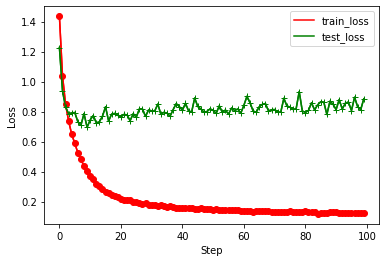

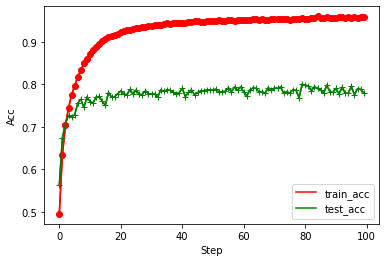

In [35]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [36]:
LOG_PATH="./train15.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn15.pth"
    
model = models.densenet201()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 100
print("Model: Densenet-201")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: Densenet-201
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [01:45,  3.70it/s]

Finish 1 epoch, Train loss: 1.449638, Train acc@1: 0.486740


Test loss: 1.236143, Test acc@1: 0.559400
Saving Best model...			Top1 = 55.940000%
Elapsed time: 111.70966339111328
---------- Training Epoch #1 ----------


391it [01:39,  3.94it/s]

Finish 2 epoch, Train loss: 1.061193, Train acc@1: 0.626260


Test loss: 1.026785, Test acc@1: 0.639300
Saving Best model...			Top1 = 63.930000%
Elapsed time: 217.6209535598755
---------- Training Epoch #2 ----------


391it [01:42,  3.83it/s]

Finish 3 epoch, Train loss: 0.868509, Train acc@1: 0.698880


Test loss: 0.931419, Test acc@1: 0.680300
Saving Best model...			Top1 = 68.030000%
Elapsed time: 325.5248212814331
---------- Training Epoch #3 ----------


391it [01:38,  3.98it/s]

Finish 4 epoch, Train loss: 0.743848, Train acc@1: 0.743440


Test loss: 0.850059, Test acc@1: 0.705400
Saving Best model...			Top1 = 70.540000%
Elapsed time: 430.55096650123596
---------- Training Epoch #4 ----------


391it [01:42,  3.83it/s]

Finish 5 epoch, Train loss: 0.664082, Train acc@1: 0.770460


Test loss: 0.838995, Test acc@1: 0.718200
Saving Best model...			Top1 = 71.820000%
Elapsed time: 538.6872916221619
---------- Training Epoch #5 ----------


391it [01:45,  3.72it/s]

Finish 6 epoch, Train loss: 0.595044, Train acc@1: 0.793420


Test loss: 0.919272, Test acc@1: 0.689900
Elapsed time: 649.2619278430939
---------- Training Epoch #6 ----------


391it [01:44,  3.74it/s]

Finish 7 epoch, Train loss: 0.538168, Train acc@1: 0.813580


Test loss: 0.743358, Test acc@1: 0.751400
Saving Best model...			Top1 = 75.140000%
Elapsed time: 760.4459207057953
---------- Training Epoch #7 ----------


391it [01:45,  3.72it/s]

Finish 8 epoch, Train loss: 0.487837, Train acc@1: 0.831080


Test loss: 0.717982, Test acc@1: 0.761100
Saving Best model...			Top1 = 76.110000%
Elapsed time: 872.3159594535828
---------- Training Epoch #8 ----------


391it [01:51,  3.51it/s]

Finish 9 epoch, Train loss: 0.445186, Train acc@1: 0.847200


Test loss: 0.705177, Test acc@1: 0.767500
Saving Best model...			Top1 = 76.750000%
Elapsed time: 989.7411780357361
---------- Training Epoch #9 ----------


391it [01:53,  3.46it/s]

Finish 10 epoch, Train loss: 0.411852, Train acc@1: 0.858400


Test loss: 0.960768, Test acc@1: 0.707100
Elapsed time: 1108.9267482757568
---------- Training Epoch #10 ----------


391it [01:53,  3.44it/s]

Finish 11 epoch, Train loss: 0.375316, Train acc@1: 0.869020


Test loss: 0.782507, Test acc@1: 0.751000
Elapsed time: 1229.2179164886475
---------- Training Epoch #11 ----------


391it [01:53,  3.43it/s]

Finish 12 epoch, Train loss: 0.350707, Train acc@1: 0.878720


Test loss: 0.740590, Test acc@1: 0.758600
Elapsed time: 1349.3432505130768
---------- Training Epoch #12 ----------


391it [01:54,  3.40it/s]

Finish 13 epoch, Train loss: 0.331107, Train acc@1: 0.885180


Test loss: 0.730806, Test acc@1: 0.767600
Saving Best model...			Top1 = 76.760000%
Elapsed time: 1470.9321949481964
---------- Training Epoch #13 ----------


391it [01:55,  3.40it/s]

Finish 14 epoch, Train loss: 0.308469, Train acc@1: 0.891340


Test loss: 0.749183, Test acc@1: 0.775900
Saving Best model...			Top1 = 77.590000%
Elapsed time: 1592.1266050338745
---------- Training Epoch #14 ----------


391it [01:54,  3.41it/s]

Finish 15 epoch, Train loss: 0.290541, Train acc@1: 0.900280


Test loss: 0.715286, Test acc@1: 0.773600
Elapsed time: 1712.7971353530884
---------- Training Epoch #15 ----------


391it [01:54,  3.40it/s]

Finish 16 epoch, Train loss: 0.277212, Train acc@1: 0.904140


Test loss: 0.786594, Test acc@1: 0.766700
Elapsed time: 1833.806800365448
---------- Training Epoch #16 ----------


391it [01:51,  3.51it/s]

Finish 17 epoch, Train loss: 0.259929, Train acc@1: 0.909800


Test loss: 0.822140, Test acc@1: 0.764500
Elapsed time: 1951.6688177585602
---------- Training Epoch #17 ----------


391it [01:47,  3.65it/s]

Finish 18 epoch, Train loss: 0.253468, Train acc@1: 0.911720


Test loss: 0.755339, Test acc@1: 0.774600
Elapsed time: 2064.818478822708
---------- Training Epoch #18 ----------


391it [01:42,  3.82it/s]

Finish 19 epoch, Train loss: 0.243950, Train acc@1: 0.915160


Test loss: 0.816649, Test acc@1: 0.758300
Elapsed time: 2172.929229259491
---------- Training Epoch #19 ----------


391it [01:41,  3.87it/s]

Finish 20 epoch, Train loss: 0.233238, Train acc@1: 0.918100


Test loss: 0.801497, Test acc@1: 0.768400
Elapsed time: 2279.737333536148
---------- Training Epoch #20 ----------


391it [01:42,  3.81it/s]

Finish 21 epoch, Train loss: 0.225111, Train acc@1: 0.921980


Test loss: 0.873757, Test acc@1: 0.761400
Elapsed time: 2387.7088255882263
---------- Training Epoch #21 ----------


391it [01:42,  3.82it/s]

Finish 22 epoch, Train loss: 0.214449, Train acc@1: 0.925120


Test loss: 0.998527, Test acc@1: 0.740500
Elapsed time: 2495.6825873851776
---------- Training Epoch #22 ----------


391it [01:41,  3.84it/s]

Finish 23 epoch, Train loss: 0.213225, Train acc@1: 0.925080


Test loss: 0.781452, Test acc@1: 0.779000
Saving Best model...			Top1 = 77.900000%
Elapsed time: 2603.1491873264313
---------- Training Epoch #23 ----------


391it [01:42,  3.81it/s]

Finish 24 epoch, Train loss: 0.208087, Train acc@1: 0.928860


Test loss: 0.826672, Test acc@1: 0.771200
Elapsed time: 2711.5491802692413
---------- Training Epoch #24 ----------


391it [01:40,  3.90it/s]

Finish 25 epoch, Train loss: 0.204409, Train acc@1: 0.929180


Test loss: 0.850940, Test acc@1: 0.760800
Elapsed time: 2818.105658531189
---------- Training Epoch #25 ----------


391it [01:38,  3.96it/s]

Finish 26 epoch, Train loss: 0.200978, Train acc@1: 0.928220


Test loss: 0.808215, Test acc@1: 0.772500
Elapsed time: 2922.9965896606445
---------- Training Epoch #26 ----------


391it [01:42,  3.83it/s]

Finish 27 epoch, Train loss: 0.194232, Train acc@1: 0.932740


Test loss: 0.786898, Test acc@1: 0.777200
Elapsed time: 3031.3606770038605
---------- Training Epoch #27 ----------


391it [01:44,  3.75it/s]

Finish 28 epoch, Train loss: 0.188674, Train acc@1: 0.934720


Test loss: 0.805709, Test acc@1: 0.777400
Elapsed time: 3141.7179090976715
---------- Training Epoch #28 ----------


391it [01:41,  3.85it/s]

Finish 29 epoch, Train loss: 0.189191, Train acc@1: 0.933220


Test loss: 0.817203, Test acc@1: 0.773800
Elapsed time: 3248.7493884563446
---------- Training Epoch #29 ----------


391it [01:43,  3.80it/s]

Finish 30 epoch, Train loss: 0.182117, Train acc@1: 0.936980


Test loss: 0.819590, Test acc@1: 0.779400
Saving Best model...			Top1 = 77.940000%
Elapsed time: 3358.2468450069427
---------- Training Epoch #30 ----------


391it [01:38,  3.98it/s]

Finish 31 epoch, Train loss: 0.181888, Train acc@1: 0.936880


Test loss: 0.837066, Test acc@1: 0.777000
Elapsed time: 3462.544275045395
---------- Training Epoch #31 ----------


391it [01:41,  3.86it/s]

Finish 32 epoch, Train loss: 0.179268, Train acc@1: 0.937440


Test loss: 0.781200, Test acc@1: 0.785700
Saving Best model...			Top1 = 78.570000%
Elapsed time: 3569.9142718315125
---------- Training Epoch #32 ----------


391it [01:42,  3.83it/s]

Finish 33 epoch, Train loss: 0.174691, Train acc@1: 0.938480


Test loss: 0.826564, Test acc@1: 0.773300
Elapsed time: 3677.7241723537445
---------- Training Epoch #33 ----------


391it [01:43,  3.77it/s]

Finish 34 epoch, Train loss: 0.168467, Train acc@1: 0.940940


Test loss: 0.823382, Test acc@1: 0.777800
Elapsed time: 3787.1548941135406
---------- Training Epoch #34 ----------


391it [01:38,  3.96it/s]

Finish 35 epoch, Train loss: 0.166490, Train acc@1: 0.942400


Test loss: 0.799541, Test acc@1: 0.784100
Elapsed time: 3891.380036830902
---------- Training Epoch #35 ----------


391it [01:40,  3.91it/s]

Finish 36 epoch, Train loss: 0.165655, Train acc@1: 0.943340


Test loss: 0.832393, Test acc@1: 0.774200
Elapsed time: 3997.876086950302
---------- Training Epoch #36 ----------


391it [01:41,  3.85it/s]

Finish 37 epoch, Train loss: 0.168844, Train acc@1: 0.941020


Test loss: 0.823468, Test acc@1: 0.774800
Elapsed time: 4104.926902294159
---------- Training Epoch #37 ----------


391it [01:43,  3.79it/s]

Finish 38 epoch, Train loss: 0.167708, Train acc@1: 0.942340


Test loss: 0.808475, Test acc@1: 0.781200
Elapsed time: 4214.285265922546
---------- Training Epoch #38 ----------


391it [01:42,  3.81it/s]

Finish 39 epoch, Train loss: 0.166133, Train acc@1: 0.941520


Test loss: 0.832647, Test acc@1: 0.776400
Elapsed time: 4323.198742389679
---------- Training Epoch #39 ----------


391it [01:41,  3.86it/s]

Finish 40 epoch, Train loss: 0.157572, Train acc@1: 0.945820


Test loss: 0.878708, Test acc@1: 0.770300
Elapsed time: 4429.839308261871
---------- Training Epoch #40 ----------


391it [01:43,  3.79it/s]

Finish 41 epoch, Train loss: 0.157020, Train acc@1: 0.944220


Test loss: 0.796591, Test acc@1: 0.790900
Saving Best model...			Top1 = 79.090000%
Elapsed time: 4538.793636083603
---------- Training Epoch #41 ----------


391it [01:41,  3.85it/s]

Finish 42 epoch, Train loss: 0.159979, Train acc@1: 0.943440


Test loss: 0.851534, Test acc@1: 0.778700
Elapsed time: 4646.729974985123
---------- Training Epoch #42 ----------


391it [01:38,  3.95it/s]

Finish 43 epoch, Train loss: 0.157834, Train acc@1: 0.945620


Test loss: 0.825790, Test acc@1: 0.777500
Elapsed time: 4751.976265907288
---------- Training Epoch #43 ----------


391it [01:41,  3.84it/s]

Finish 44 epoch, Train loss: 0.156983, Train acc@1: 0.944840


Test loss: 0.824478, Test acc@1: 0.775500
Elapsed time: 4859.373403310776
---------- Training Epoch #44 ----------


391it [01:38,  3.96it/s]

Finish 45 epoch, Train loss: 0.154897, Train acc@1: 0.947000


Test loss: 0.898189, Test acc@1: 0.770700
Elapsed time: 4964.50098323822
---------- Training Epoch #45 ----------


391it [01:42,  3.81it/s]

Finish 46 epoch, Train loss: 0.157104, Train acc@1: 0.944920


Test loss: 0.884821, Test acc@1: 0.775300
Elapsed time: 5073.2509553432465
---------- Training Epoch #46 ----------


391it [01:44,  3.73it/s]

Finish 47 epoch, Train loss: 0.156112, Train acc@1: 0.946140


Test loss: 0.890951, Test acc@1: 0.768100
Elapsed time: 5184.360600709915
---------- Training Epoch #47 ----------


391it [01:43,  3.78it/s]

Finish 48 epoch, Train loss: 0.154583, Train acc@1: 0.946640


Test loss: 0.798430, Test acc@1: 0.785700
Elapsed time: 5294.200460195541
---------- Training Epoch #48 ----------


391it [01:42,  3.81it/s]

Finish 49 epoch, Train loss: 0.147802, Train acc@1: 0.947680


Test loss: 0.808677, Test acc@1: 0.785100
Elapsed time: 5402.94663476944
---------- Training Epoch #49 ----------


391it [01:41,  3.84it/s]

Finish 50 epoch, Train loss: 0.149795, Train acc@1: 0.947460


Test loss: 0.846694, Test acc@1: 0.781200
Elapsed time: 5510.383838653564
---------- Training Epoch #50 ----------


391it [01:41,  3.85it/s]

Finish 51 epoch, Train loss: 0.147706, Train acc@1: 0.948800


Test loss: 0.858303, Test acc@1: 0.776800
Elapsed time: 5617.342098712921
---------- Training Epoch #51 ----------


391it [01:45,  3.70it/s]

Finish 52 epoch, Train loss: 0.148551, Train acc@1: 0.948300


Test loss: 0.824843, Test acc@1: 0.780100
Elapsed time: 5729.384011745453
---------- Training Epoch #52 ----------


391it [01:43,  3.77it/s]

Finish 53 epoch, Train loss: 0.145089, Train acc@1: 0.948880


Test loss: 0.854890, Test acc@1: 0.784300
Elapsed time: 5838.813055515289
---------- Training Epoch #53 ----------


391it [01:42,  3.81it/s]

Finish 54 epoch, Train loss: 0.144769, Train acc@1: 0.949320


Test loss: 0.810298, Test acc@1: 0.780200
Elapsed time: 5947.902905702591
---------- Training Epoch #54 ----------


391it [01:42,  3.83it/s]

Finish 55 epoch, Train loss: 0.142073, Train acc@1: 0.951000


Test loss: 0.781636, Test acc@1: 0.794900
Saving Best model...			Top1 = 79.490000%
Elapsed time: 6055.960031986237
---------- Training Epoch #55 ----------


391it [01:41,  3.86it/s]

Finish 56 epoch, Train loss: 0.148526, Train acc@1: 0.948560


Test loss: 0.844624, Test acc@1: 0.778700
Elapsed time: 6162.812054872513
---------- Training Epoch #56 ----------


391it [01:41,  3.83it/s]

Finish 57 epoch, Train loss: 0.143805, Train acc@1: 0.949500


Test loss: 0.836774, Test acc@1: 0.778100
Elapsed time: 6270.999215841293
---------- Training Epoch #57 ----------


391it [01:41,  3.85it/s]

Finish 58 epoch, Train loss: 0.143385, Train acc@1: 0.949820


Test loss: 0.852690, Test acc@1: 0.779100
Elapsed time: 6378.1859402656555
---------- Training Epoch #58 ----------


391it [01:41,  3.85it/s]

Finish 59 epoch, Train loss: 0.137555, Train acc@1: 0.951700


Test loss: 0.899215, Test acc@1: 0.768000
Elapsed time: 6485.275735139847
---------- Training Epoch #59 ----------


391it [01:38,  3.95it/s]

Finish 60 epoch, Train loss: 0.145346, Train acc@1: 0.949920


Test loss: 0.812386, Test acc@1: 0.790500
Elapsed time: 6589.641063451767
---------- Training Epoch #60 ----------


391it [01:40,  3.90it/s]

Finish 61 epoch, Train loss: 0.143156, Train acc@1: 0.949620


Test loss: 0.844252, Test acc@1: 0.782600
Elapsed time: 6695.502969503403
---------- Training Epoch #61 ----------


391it [01:40,  3.90it/s]

Finish 62 epoch, Train loss: 0.145938, Train acc@1: 0.950560


Test loss: 0.808079, Test acc@1: 0.782300
Elapsed time: 6801.265143632889
---------- Training Epoch #62 ----------


391it [01:40,  3.89it/s]

Finish 63 epoch, Train loss: 0.143423, Train acc@1: 0.949940


Test loss: 0.881841, Test acc@1: 0.770900
Elapsed time: 6907.848815202713
---------- Training Epoch #63 ----------


391it [01:38,  3.97it/s]

Finish 64 epoch, Train loss: 0.140592, Train acc@1: 0.950240


Test loss: 0.825831, Test acc@1: 0.787700
Elapsed time: 7012.479408979416
---------- Training Epoch #64 ----------


391it [01:41,  3.85it/s]

Finish 65 epoch, Train loss: 0.136884, Train acc@1: 0.953620


Test loss: 0.855606, Test acc@1: 0.776500
Elapsed time: 7119.703859090805
---------- Training Epoch #65 ----------


391it [01:40,  3.90it/s]

Finish 66 epoch, Train loss: 0.139211, Train acc@1: 0.951780


Test loss: 0.845953, Test acc@1: 0.785900
Elapsed time: 7225.789253950119
---------- Training Epoch #66 ----------


391it [01:44,  3.76it/s]

Finish 67 epoch, Train loss: 0.135273, Train acc@1: 0.953120


Test loss: 0.875648, Test acc@1: 0.785800
Elapsed time: 7335.6494109630585
---------- Training Epoch #67 ----------


391it [01:43,  3.79it/s]

Finish 68 epoch, Train loss: 0.136482, Train acc@1: 0.952240


Test loss: 0.868857, Test acc@1: 0.774300
Elapsed time: 7444.49182844162
---------- Training Epoch #68 ----------


391it [01:42,  3.81it/s]

Finish 69 epoch, Train loss: 0.133018, Train acc@1: 0.954320


Test loss: 0.857319, Test acc@1: 0.780600
Elapsed time: 7552.762744665146
---------- Training Epoch #69 ----------


391it [01:43,  3.78it/s]

Finish 70 epoch, Train loss: 0.131634, Train acc@1: 0.954140


Test loss: 0.848194, Test acc@1: 0.782500
Elapsed time: 7661.589901685715
---------- Training Epoch #70 ----------


391it [01:40,  3.88it/s]

Finish 71 epoch, Train loss: 0.135717, Train acc@1: 0.953020


Test loss: 0.857356, Test acc@1: 0.784200
Elapsed time: 7768.613750934601
---------- Training Epoch #71 ----------


391it [01:41,  3.87it/s]

Finish 72 epoch, Train loss: 0.136268, Train acc@1: 0.952700


Test loss: 0.805206, Test acc@1: 0.795000
Saving Best model...			Top1 = 79.500000%
Elapsed time: 7875.480535745621
---------- Training Epoch #72 ----------


391it [01:41,  3.86it/s]

Finish 73 epoch, Train loss: 0.138239, Train acc@1: 0.951840


Test loss: 0.885923, Test acc@1: 0.779900
Elapsed time: 7982.183740615845
---------- Training Epoch #73 ----------


391it [01:43,  3.77it/s]

Finish 74 epoch, Train loss: 0.135899, Train acc@1: 0.952320


Test loss: 0.881509, Test acc@1: 0.773000
Elapsed time: 8091.2859671115875
---------- Training Epoch #74 ----------


391it [01:39,  3.94it/s]

Finish 75 epoch, Train loss: 0.128224, Train acc@1: 0.955500


Test loss: 0.841926, Test acc@1: 0.786700
Elapsed time: 8196.63154888153
---------- Training Epoch #75 ----------


391it [01:42,  3.81it/s]

Finish 76 epoch, Train loss: 0.132760, Train acc@1: 0.954560


Test loss: 0.845814, Test acc@1: 0.790500
Elapsed time: 8304.51733660698
---------- Training Epoch #76 ----------


391it [01:43,  3.77it/s]

Finish 77 epoch, Train loss: 0.134301, Train acc@1: 0.953860


Test loss: 0.796996, Test acc@1: 0.791600
Elapsed time: 8413.702073574066
---------- Training Epoch #77 ----------


391it [01:39,  3.92it/s]

Finish 78 epoch, Train loss: 0.135226, Train acc@1: 0.953540


Test loss: 0.835036, Test acc@1: 0.787700
Elapsed time: 8519.003350257874
---------- Training Epoch #78 ----------


391it [01:43,  3.79it/s]

Finish 79 epoch, Train loss: 0.133603, Train acc@1: 0.953460


Test loss: 0.915666, Test acc@1: 0.766300
Elapsed time: 8628.098789930344
---------- Training Epoch #79 ----------


391it [01:39,  3.92it/s]

Finish 80 epoch, Train loss: 0.129827, Train acc@1: 0.955700


Test loss: 0.853984, Test acc@1: 0.782400
Elapsed time: 8733.563588619232
---------- Training Epoch #80 ----------


391it [01:40,  3.88it/s]

Finish 81 epoch, Train loss: 0.126876, Train acc@1: 0.955320


Test loss: 0.849982, Test acc@1: 0.782000
Elapsed time: 8839.989815235138
---------- Training Epoch #81 ----------


391it [01:44,  3.76it/s]

Finish 82 epoch, Train loss: 0.132022, Train acc@1: 0.953080


Test loss: 0.871059, Test acc@1: 0.777700
Elapsed time: 8949.924431562424
---------- Training Epoch #82 ----------


391it [01:42,  3.80it/s]

Finish 83 epoch, Train loss: 0.129686, Train acc@1: 0.954680


Test loss: 0.864282, Test acc@1: 0.781800
Elapsed time: 9058.997612476349
---------- Training Epoch #83 ----------


391it [01:44,  3.74it/s]

Finish 84 epoch, Train loss: 0.130016, Train acc@1: 0.955800


Test loss: 0.835224, Test acc@1: 0.787300
Elapsed time: 9169.706890583038
---------- Training Epoch #84 ----------


391it [01:40,  3.89it/s]

Finish 85 epoch, Train loss: 0.130695, Train acc@1: 0.954860


Test loss: 0.853161, Test acc@1: 0.788700
Elapsed time: 9276.557180643082
---------- Training Epoch #85 ----------


391it [01:38,  3.96it/s]

Finish 86 epoch, Train loss: 0.126048, Train acc@1: 0.956080


Test loss: 0.871622, Test acc@1: 0.783400
Elapsed time: 9380.82720541954
---------- Training Epoch #86 ----------


391it [01:42,  3.81it/s]

Finish 87 epoch, Train loss: 0.125735, Train acc@1: 0.956500


Test loss: 0.830313, Test acc@1: 0.789900
Elapsed time: 9489.51704120636
---------- Training Epoch #87 ----------


391it [01:45,  3.71it/s]

Finish 88 epoch, Train loss: 0.134695, Train acc@1: 0.953340


Test loss: 0.797940, Test acc@1: 0.794800
Elapsed time: 9601.451984167099
---------- Training Epoch #88 ----------


391it [01:40,  3.90it/s]

Finish 89 epoch, Train loss: 0.128621, Train acc@1: 0.955020


Test loss: 0.837625, Test acc@1: 0.791200
Elapsed time: 9707.188408613205
---------- Training Epoch #89 ----------


391it [01:41,  3.84it/s]

Finish 90 epoch, Train loss: 0.129340, Train acc@1: 0.954340


Test loss: 0.943511, Test acc@1: 0.777000
Elapsed time: 9814.640137910843
---------- Training Epoch #90 ----------


391it [01:40,  3.89it/s]

Finish 91 epoch, Train loss: 0.126099, Train acc@1: 0.955500


Test loss: 0.801821, Test acc@1: 0.789500
Elapsed time: 9920.920537471771
---------- Training Epoch #91 ----------


391it [01:44,  3.75it/s]

Finish 92 epoch, Train loss: 0.128424, Train acc@1: 0.957040


Test loss: 0.855480, Test acc@1: 0.783100
Elapsed time: 10031.180317401886
---------- Training Epoch #92 ----------


391it [01:39,  3.93it/s]

Finish 93 epoch, Train loss: 0.131244, Train acc@1: 0.954440


Test loss: 0.837037, Test acc@1: 0.781900
Elapsed time: 10136.686196565628
---------- Training Epoch #93 ----------


391it [01:43,  3.78it/s]

Finish 94 epoch, Train loss: 0.124808, Train acc@1: 0.956660


Test loss: 0.825178, Test acc@1: 0.788800
Elapsed time: 10246.49012041092
---------- Training Epoch #94 ----------


391it [01:45,  3.70it/s]

Finish 95 epoch, Train loss: 0.123427, Train acc@1: 0.956780


Test loss: 0.839647, Test acc@1: 0.779500
Elapsed time: 10358.17090010643
---------- Training Epoch #95 ----------


391it [01:40,  3.89it/s]

Finish 96 epoch, Train loss: 0.126197, Train acc@1: 0.957000


Test loss: 0.782525, Test acc@1: 0.797300
Saving Best model...			Top1 = 79.730000%
Elapsed time: 10464.505477905273
---------- Training Epoch #96 ----------


391it [01:41,  3.85it/s]

Finish 97 epoch, Train loss: 0.126641, Train acc@1: 0.956240


Test loss: 0.903827, Test acc@1: 0.778400
Elapsed time: 10571.502739667892
---------- Training Epoch #97 ----------


391it [01:45,  3.70it/s]

Finish 98 epoch, Train loss: 0.129271, Train acc@1: 0.954840


Test loss: 0.794281, Test acc@1: 0.788300
Elapsed time: 10682.985369682312
---------- Training Epoch #98 ----------


391it [01:43,  3.79it/s]

Finish 99 epoch, Train loss: 0.118591, Train acc@1: 0.959520


Test loss: 0.856188, Test acc@1: 0.789300
Elapsed time: 10791.555974721909
---------- Training Epoch #99 ----------


391it [01:44,  3.73it/s]

Finish 100 epoch, Train loss: 0.121029, Train acc@1: 0.958220


Test loss: 0.843197, Test acc@1: 0.789400
Elapsed time: 10901.930150270462

Test results: Acc@1 = 79.730000%


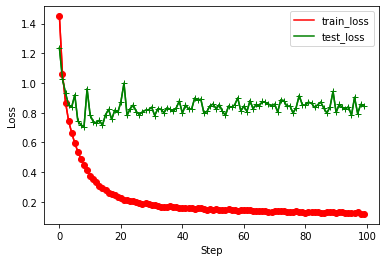

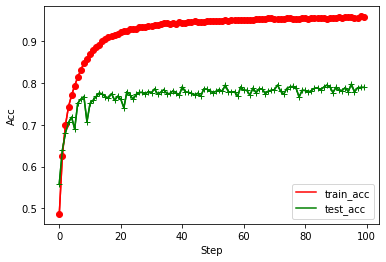

In [37]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

### 6. Data augmentation

In [38]:
'''Data augmentation'''
transform_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.4914, 0.4822, 0.4465 ],
                         std  = [ 0.2023, 0.1994, 0.2010 ]),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.4914, 0.4822, 0.4465 ],
                         std  = [ 0.2023, 0.1994, 0.2010 ]),
    ])

In [39]:
'''CIFAR-10 dataset'''
train_dataset = datasets.CIFAR10('./data', train=True, transform=transform_train, download=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform_test, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print(len(train_dataset))

Files already downloaded and verified
Files already downloaded and verified
50000


In [40]:
LOG_PATH="./train16.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn16.pth"
    
model = models.resnet18()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 200
print("Model: Resnet-18")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: Resnet-18
Batch size: 128
Epoch num: 200
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:15, 25.75it/s]

Finish 1 epoch, Train loss: 1.598892, Train acc@1: 0.431900


Test loss: 1.380676, Test acc@1: 0.509500
Saving Best model...			Top1 = 50.950000%
Elapsed time: 17.453144073486328
---------- Training Epoch #1 ----------


391it [00:14, 27.10it/s]

Finish 2 epoch, Train loss: 1.232670, Train acc@1: 0.562920


Test loss: 1.419852, Test acc@1: 0.523500
Saving Best model...			Top1 = 52.350000%
Elapsed time: 34.24143719673157
---------- Training Epoch #2 ----------


391it [00:15, 25.11it/s]

Finish 3 epoch, Train loss: 1.070391, Train acc@1: 0.623360


Test loss: 1.076574, Test acc@1: 0.625500
Saving Best model...			Top1 = 62.550000%
Elapsed time: 52.12238025665283
---------- Training Epoch #3 ----------


391it [00:14, 26.70it/s]

Finish 4 epoch, Train loss: 0.979851, Train acc@1: 0.659040


Test loss: 1.005909, Test acc@1: 0.653500
Saving Best model...			Top1 = 65.350000%
Elapsed time: 69.11146092414856
---------- Training Epoch #4 ----------


391it [00:15, 25.39it/s]

Finish 5 epoch, Train loss: 0.891926, Train acc@1: 0.692920


Test loss: 0.965907, Test acc@1: 0.673300
Saving Best model...			Top1 = 67.330000%
Elapsed time: 86.89109444618225
---------- Training Epoch #5 ----------


391it [00:15, 25.00it/s]

Finish 6 epoch, Train loss: 0.835420, Train acc@1: 0.711260


Test loss: 0.834190, Test acc@1: 0.717300
Saving Best model...			Top1 = 71.730000%
Elapsed time: 104.8972065448761
---------- Training Epoch #6 ----------


391it [00:14, 27.53it/s]

Finish 7 epoch, Train loss: 0.800888, Train acc@1: 0.725360


Test loss: 0.827041, Test acc@1: 0.721000
Saving Best model...			Top1 = 72.100000%
Elapsed time: 121.45924067497253
---------- Training Epoch #7 ----------


391it [00:16, 23.58it/s]

Finish 8 epoch, Train loss: 0.761354, Train acc@1: 0.739240


Test loss: 0.736239, Test acc@1: 0.746800
Saving Best model...			Top1 = 74.680000%
Elapsed time: 140.3201882839203
---------- Training Epoch #8 ----------


391it [00:15, 25.05it/s]

Finish 9 epoch, Train loss: 0.730486, Train acc@1: 0.748560


Test loss: 0.790537, Test acc@1: 0.728700
Elapsed time: 158.15214943885803
---------- Training Epoch #9 ----------


391it [00:16, 23.62it/s]

Finish 10 epoch, Train loss: 0.708183, Train acc@1: 0.759180


Test loss: 0.721746, Test acc@1: 0.751800
Saving Best model...			Top1 = 75.180000%
Elapsed time: 177.0919680595398
---------- Training Epoch #10 ----------


391it [00:15, 24.55it/s]

Finish 11 epoch, Train loss: 0.680420, Train acc@1: 0.765160


Test loss: 0.699504, Test acc@1: 0.757200
Saving Best model...			Top1 = 75.720000%
Elapsed time: 195.31474041938782
---------- Training Epoch #11 ----------


391it [00:15, 25.45it/s]

Finish 12 epoch, Train loss: 0.663236, Train acc@1: 0.771480


Test loss: 0.702429, Test acc@1: 0.761400
Saving Best model...			Top1 = 76.140000%
Elapsed time: 213.11755418777466
---------- Training Epoch #12 ----------


391it [00:15, 26.05it/s]

Finish 13 epoch, Train loss: 0.643747, Train acc@1: 0.778120


Test loss: 0.676319, Test acc@1: 0.764100
Saving Best model...			Top1 = 76.410000%
Elapsed time: 230.4979166984558
---------- Training Epoch #13 ----------


391it [00:15, 25.55it/s]

Finish 14 epoch, Train loss: 0.626950, Train acc@1: 0.786420


Test loss: 0.647087, Test acc@1: 0.774800
Saving Best model...			Top1 = 77.480000%
Elapsed time: 248.29353880882263
---------- Training Epoch #14 ----------


391it [00:15, 25.84it/s]

Finish 15 epoch, Train loss: 0.617790, Train acc@1: 0.788300


Test loss: 0.635723, Test acc@1: 0.781300
Saving Best model...			Top1 = 78.130000%
Elapsed time: 265.70982933044434
---------- Training Epoch #15 ----------


391it [00:16, 24.02it/s]

Finish 16 epoch, Train loss: 0.601908, Train acc@1: 0.793080


Test loss: 0.612712, Test acc@1: 0.791500
Saving Best model...			Top1 = 79.150000%
Elapsed time: 284.2194163799286
---------- Training Epoch #16 ----------


391it [00:15, 25.69it/s]

Finish 17 epoch, Train loss: 0.590813, Train acc@1: 0.797360


Test loss: 0.613961, Test acc@1: 0.787900
Elapsed time: 301.70028042793274
---------- Training Epoch #17 ----------


391it [00:15, 25.76it/s]

Finish 18 epoch, Train loss: 0.577978, Train acc@1: 0.802480


Test loss: 0.646198, Test acc@1: 0.782400
Elapsed time: 319.1305663585663
---------- Training Epoch #18 ----------


391it [00:15, 25.86it/s]

Finish 19 epoch, Train loss: 0.568157, Train acc@1: 0.805400


Test loss: 0.628741, Test acc@1: 0.788100
Elapsed time: 336.4914710521698
---------- Training Epoch #19 ----------


391it [00:16, 23.95it/s]

Finish 20 epoch, Train loss: 0.559160, Train acc@1: 0.811160


Test loss: 0.654887, Test acc@1: 0.779900
Elapsed time: 355.1057860851288
---------- Training Epoch #20 ----------


391it [00:15, 26.03it/s]

Finish 21 epoch, Train loss: 0.555965, Train acc@1: 0.809560


Test loss: 0.570525, Test acc@1: 0.804700
Saving Best model...			Top1 = 80.470000%
Elapsed time: 372.4832921028137
---------- Training Epoch #21 ----------


391it [00:15, 25.97it/s]


Finish 22 epoch, Train loss: 0.545421, Train acc@1: 0.813440
Test loss: 0.610596, Test acc@1: 0.794500
Elapsed time: 389.72267413139343
---------- Training Epoch #22 ----------


391it [00:15, 25.20it/s]

Finish 23 epoch, Train loss: 0.541411, Train acc@1: 0.815720


Test loss: 0.567285, Test acc@1: 0.806100
Saving Best model...			Top1 = 80.610000%
Elapsed time: 407.6039652824402
---------- Training Epoch #23 ----------


391it [00:15, 25.54it/s]

Finish 24 epoch, Train loss: 0.535897, Train acc@1: 0.818460


Test loss: 0.619660, Test acc@1: 0.795200
Elapsed time: 425.1036219596863
---------- Training Epoch #24 ----------


391it [00:15, 24.63it/s]

Finish 25 epoch, Train loss: 0.525106, Train acc@1: 0.819140


Test loss: 0.587936, Test acc@1: 0.798400
Elapsed time: 443.8731598854065
---------- Training Epoch #25 ----------


391it [00:15, 25.29it/s]

Finish 26 epoch, Train loss: 0.522705, Train acc@1: 0.822400


Test loss: 0.585617, Test acc@1: 0.805400
Elapsed time: 461.60749864578247
---------- Training Epoch #26 ----------


391it [00:15, 25.63it/s]

Finish 27 epoch, Train loss: 0.513574, Train acc@1: 0.822580


Test loss: 0.557384, Test acc@1: 0.805800
Elapsed time: 479.0334093570709
---------- Training Epoch #27 ----------


391it [00:15, 25.17it/s]

Finish 28 epoch, Train loss: 0.516094, Train acc@1: 0.823220


Test loss: 0.569938, Test acc@1: 0.811900
Saving Best model...			Top1 = 81.190000%
Elapsed time: 496.93466091156006
---------- Training Epoch #28 ----------


391it [00:15, 25.11it/s]

Finish 29 epoch, Train loss: 0.507421, Train acc@1: 0.826920


Test loss: 0.575822, Test acc@1: 0.806600
Elapsed time: 514.7435233592987
---------- Training Epoch #29 ----------


391it [00:15, 25.47it/s]

Finish 30 epoch, Train loss: 0.502833, Train acc@1: 0.828420


Test loss: 0.558930, Test acc@1: 0.808900
Elapsed time: 532.2880203723907
---------- Training Epoch #30 ----------


391it [00:15, 25.16it/s]

Finish 31 epoch, Train loss: 0.499886, Train acc@1: 0.829040


Test loss: 0.536137, Test acc@1: 0.819700
Saving Best model...			Top1 = 81.970000%
Elapsed time: 550.223870754242
---------- Training Epoch #31 ----------


391it [00:15, 25.02it/s]

Finish 32 epoch, Train loss: 0.490317, Train acc@1: 0.832160


Test loss: 0.566921, Test acc@1: 0.809700
Elapsed time: 568.2319533824921
---------- Training Epoch #32 ----------


391it [00:15, 25.43it/s]

Finish 33 epoch, Train loss: 0.495150, Train acc@1: 0.830980


Test loss: 0.602376, Test acc@1: 0.799900
Elapsed time: 586.2655708789825
---------- Training Epoch #33 ----------


391it [00:15, 25.01it/s]

Finish 34 epoch, Train loss: 0.485753, Train acc@1: 0.832660


Test loss: 0.537924, Test acc@1: 0.817600
Elapsed time: 604.116331577301
---------- Training Epoch #34 ----------


391it [00:14, 26.35it/s]

Finish 35 epoch, Train loss: 0.481971, Train acc@1: 0.835800


Test loss: 0.578157, Test acc@1: 0.805100
Elapsed time: 621.2218792438507
---------- Training Epoch #35 ----------


391it [00:15, 24.85it/s]

Finish 36 epoch, Train loss: 0.474401, Train acc@1: 0.837860


Test loss: 0.570539, Test acc@1: 0.809100
Elapsed time: 639.230105638504
---------- Training Epoch #36 ----------


391it [00:15, 25.05it/s]

Finish 37 epoch, Train loss: 0.473206, Train acc@1: 0.838180


Test loss: 0.543218, Test acc@1: 0.816500
Elapsed time: 657.292932510376
---------- Training Epoch #37 ----------


391it [00:15, 24.56it/s]

Finish 38 epoch, Train loss: 0.471882, Train acc@1: 0.839800


Test loss: 0.546036, Test acc@1: 0.820800
Saving Best model...			Top1 = 82.080000%
Elapsed time: 675.5505719184875
---------- Training Epoch #38 ----------


391it [00:15, 25.89it/s]

Finish 39 epoch, Train loss: 0.471719, Train acc@1: 0.838360


Test loss: 0.544886, Test acc@1: 0.816400
Elapsed time: 692.8785092830658
---------- Training Epoch #39 ----------


391it [00:15, 25.34it/s]

Finish 40 epoch, Train loss: 0.473669, Train acc@1: 0.839000


Test loss: 0.590304, Test acc@1: 0.803400
Elapsed time: 710.5508482456207
---------- Training Epoch #40 ----------


391it [00:16, 24.18it/s]

Finish 41 epoch, Train loss: 0.459218, Train acc@1: 0.842600


Test loss: 0.533878, Test acc@1: 0.816200
Elapsed time: 728.9845139980316
---------- Training Epoch #41 ----------


391it [00:14, 26.87it/s]

Finish 42 epoch, Train loss: 0.461874, Train acc@1: 0.841760


Test loss: 0.562202, Test acc@1: 0.815200
Elapsed time: 745.8521375656128
---------- Training Epoch #42 ----------


391it [00:14, 26.63it/s]

Finish 43 epoch, Train loss: 0.459969, Train acc@1: 0.842340


Test loss: 0.549720, Test acc@1: 0.815200
Elapsed time: 762.725567817688
---------- Training Epoch #43 ----------


391it [00:15, 25.92it/s]

Finish 44 epoch, Train loss: 0.457564, Train acc@1: 0.841860


Test loss: 0.546229, Test acc@1: 0.815500
Elapsed time: 780.0296094417572
---------- Training Epoch #44 ----------


391it [00:16, 24.10it/s]

Finish 45 epoch, Train loss: 0.450452, Train acc@1: 0.847180


Test loss: 0.513881, Test acc@1: 0.828400
Saving Best model...			Top1 = 82.840000%
Elapsed time: 798.5145087242126
---------- Training Epoch #45 ----------


391it [00:15, 25.20it/s]

Finish 46 epoch, Train loss: 0.450747, Train acc@1: 0.845960


Test loss: 0.527181, Test acc@1: 0.820700
Elapsed time: 816.2101302146912
---------- Training Epoch #46 ----------


391it [00:15, 25.80it/s]

Finish 47 epoch, Train loss: 0.452103, Train acc@1: 0.844800


Test loss: 0.511641, Test acc@1: 0.825400
Elapsed time: 833.5371198654175
---------- Training Epoch #47 ----------


391it [00:15, 25.18it/s]

Finish 48 epoch, Train loss: 0.450625, Train acc@1: 0.845600


Test loss: 0.521122, Test acc@1: 0.821900
Elapsed time: 851.2408125400543
---------- Training Epoch #48 ----------


391it [00:14, 26.25it/s]

Finish 49 epoch, Train loss: 0.446392, Train acc@1: 0.846120


Test loss: 0.492699, Test acc@1: 0.834400
Saving Best model...			Top1 = 83.440000%
Elapsed time: 868.5368728637695
---------- Training Epoch #49 ----------


391it [00:15, 25.86it/s]

Finish 50 epoch, Train loss: 0.445027, Train acc@1: 0.847360


Test loss: 0.551562, Test acc@1: 0.816300
Elapsed time: 885.8619527816772
---------- Training Epoch #50 ----------


391it [00:15, 25.03it/s]

Finish 51 epoch, Train loss: 0.449692, Train acc@1: 0.845020


Test loss: 0.528724, Test acc@1: 0.823300
Elapsed time: 903.7640969753265
---------- Training Epoch #51 ----------


391it [00:15, 25.79it/s]

Finish 52 epoch, Train loss: 0.442528, Train acc@1: 0.848520


Test loss: 0.519631, Test acc@1: 0.827700
Elapsed time: 921.1299664974213
---------- Training Epoch #52 ----------


391it [00:15, 25.63it/s]

Finish 53 epoch, Train loss: 0.440319, Train acc@1: 0.850060


Test loss: 0.581954, Test acc@1: 0.805000
Elapsed time: 938.7522447109222
---------- Training Epoch #53 ----------


391it [00:15, 25.65it/s]

Finish 54 epoch, Train loss: 0.436232, Train acc@1: 0.849440


Test loss: 0.504989, Test acc@1: 0.832100
Elapsed time: 956.3644421100616
---------- Training Epoch #54 ----------


391it [00:15, 25.40it/s]

Finish 55 epoch, Train loss: 0.434134, Train acc@1: 0.851760


Test loss: 0.523449, Test acc@1: 0.822000
Elapsed time: 974.1222610473633
---------- Training Epoch #55 ----------


391it [00:15, 24.61it/s]

Finish 56 epoch, Train loss: 0.431928, Train acc@1: 0.853040


Test loss: 0.560817, Test acc@1: 0.815800
Elapsed time: 992.4111106395721
---------- Training Epoch #56 ----------


391it [00:15, 24.97it/s]

Finish 57 epoch, Train loss: 0.432601, Train acc@1: 0.854120


Test loss: 0.536846, Test acc@1: 0.822800
Elapsed time: 1010.461259841919
---------- Training Epoch #57 ----------


391it [00:16, 23.87it/s]

Finish 58 epoch, Train loss: 0.432068, Train acc@1: 0.851240


Test loss: 0.505311, Test acc@1: 0.834200
Elapsed time: 1029.206203699112
---------- Training Epoch #58 ----------


391it [00:17, 22.51it/s]

Finish 59 epoch, Train loss: 0.430060, Train acc@1: 0.853700


Test loss: 0.499049, Test acc@1: 0.833900
Elapsed time: 1048.9935007095337
---------- Training Epoch #59 ----------


391it [00:15, 25.15it/s]

Finish 60 epoch, Train loss: 0.427733, Train acc@1: 0.852920


Test loss: 0.609076, Test acc@1: 0.805400
Elapsed time: 1066.9484086036682
---------- Training Epoch #60 ----------


391it [00:15, 24.79it/s]

Finish 61 epoch, Train loss: 0.428949, Train acc@1: 0.854080


Test loss: 0.500923, Test acc@1: 0.831200
Elapsed time: 1085.1280913352966
---------- Training Epoch #61 ----------


391it [00:16, 23.45it/s]

Finish 62 epoch, Train loss: 0.427572, Train acc@1: 0.854060


Test loss: 0.506532, Test acc@1: 0.830200
Elapsed time: 1104.1274554729462
---------- Training Epoch #62 ----------


391it [00:16, 23.33it/s]

Finish 63 epoch, Train loss: 0.427694, Train acc@1: 0.853240


Test loss: 0.553115, Test acc@1: 0.820400
Elapsed time: 1123.284759759903
---------- Training Epoch #63 ----------


391it [00:15, 25.00it/s]

Finish 64 epoch, Train loss: 0.422929, Train acc@1: 0.855640


Test loss: 0.510521, Test acc@1: 0.823700
Elapsed time: 1141.2271950244904
---------- Training Epoch #64 ----------


391it [00:15, 24.66it/s]

Finish 65 epoch, Train loss: 0.422062, Train acc@1: 0.855540


Test loss: 0.527557, Test acc@1: 0.827000
Elapsed time: 1159.4241826534271
---------- Training Epoch #65 ----------


391it [00:15, 25.34it/s]

Finish 66 epoch, Train loss: 0.419596, Train acc@1: 0.854580


Test loss: 0.532242, Test acc@1: 0.822300
Elapsed time: 1177.1955337524414
---------- Training Epoch #66 ----------


391it [00:15, 25.09it/s]

Finish 67 epoch, Train loss: 0.420628, Train acc@1: 0.855660


Test loss: 0.549417, Test acc@1: 0.816200
Elapsed time: 1195.057303905487
---------- Training Epoch #67 ----------


391it [00:15, 26.05it/s]

Finish 68 epoch, Train loss: 0.416957, Train acc@1: 0.856980


Test loss: 0.512009, Test acc@1: 0.828000
Elapsed time: 1212.426064491272
---------- Training Epoch #68 ----------


391it [00:15, 25.10it/s]

Finish 69 epoch, Train loss: 0.418175, Train acc@1: 0.855320


Test loss: 0.538165, Test acc@1: 0.821700
Elapsed time: 1230.3801577091217
---------- Training Epoch #69 ----------


391it [00:15, 24.64it/s]

Finish 70 epoch, Train loss: 0.415091, Train acc@1: 0.858020


Test loss: 0.532817, Test acc@1: 0.825500
Elapsed time: 1248.5588929653168
---------- Training Epoch #70 ----------


391it [00:16, 24.20it/s]

Finish 71 epoch, Train loss: 0.419205, Train acc@1: 0.857160


Test loss: 0.515966, Test acc@1: 0.828400
Elapsed time: 1266.9844074249268
---------- Training Epoch #71 ----------


391it [00:15, 25.32it/s]

Finish 72 epoch, Train loss: 0.412325, Train acc@1: 0.860000


Test loss: 0.522313, Test acc@1: 0.827200
Elapsed time: 1284.7911124229431
---------- Training Epoch #72 ----------


391it [00:15, 25.07it/s]

Finish 73 epoch, Train loss: 0.411585, Train acc@1: 0.860180


Test loss: 0.582193, Test acc@1: 0.812200
Elapsed time: 1302.760141134262
---------- Training Epoch #73 ----------


391it [00:16, 23.55it/s]

Finish 74 epoch, Train loss: 0.411758, Train acc@1: 0.858680


Test loss: 0.504649, Test acc@1: 0.835000
Saving Best model...			Top1 = 83.500000%
Elapsed time: 1321.8851127624512
---------- Training Epoch #74 ----------


391it [00:15, 25.37it/s]

Finish 75 epoch, Train loss: 0.419413, Train acc@1: 0.856820


Test loss: 0.503274, Test acc@1: 0.832600
Elapsed time: 1339.7609763145447
---------- Training Epoch #75 ----------


391it [00:15, 25.14it/s]

Finish 76 epoch, Train loss: 0.412179, Train acc@1: 0.858280


Test loss: 0.534102, Test acc@1: 0.821500
Elapsed time: 1357.6909296512604
---------- Training Epoch #76 ----------


391it [00:16, 24.42it/s]

Finish 77 epoch, Train loss: 0.411767, Train acc@1: 0.858520


Test loss: 0.543368, Test acc@1: 0.820200
Elapsed time: 1376.060133934021
---------- Training Epoch #77 ----------


391it [00:15, 25.05it/s]

Finish 78 epoch, Train loss: 0.403232, Train acc@1: 0.861540


Test loss: 0.506572, Test acc@1: 0.835700
Saving Best model...			Top1 = 83.570000%
Elapsed time: 1394.323946237564
---------- Training Epoch #78 ----------


391it [00:16, 23.83it/s]

Finish 79 epoch, Train loss: 0.415235, Train acc@1: 0.858500


Test loss: 0.534637, Test acc@1: 0.822300
Elapsed time: 1413.100930929184
---------- Training Epoch #79 ----------


391it [00:16, 24.02it/s]

Finish 80 epoch, Train loss: 0.402463, Train acc@1: 0.861480


Test loss: 0.577709, Test acc@1: 0.814500
Elapsed time: 1431.6593453884125
---------- Training Epoch #80 ----------


391it [00:15, 25.32it/s]

Finish 81 epoch, Train loss: 0.403022, Train acc@1: 0.861180


Test loss: 0.530727, Test acc@1: 0.825400
Elapsed time: 1449.5065574645996
---------- Training Epoch #81 ----------


391it [00:15, 25.03it/s]

Finish 82 epoch, Train loss: 0.404359, Train acc@1: 0.860300


Test loss: 0.508098, Test acc@1: 0.830500
Elapsed time: 1467.5461597442627
---------- Training Epoch #82 ----------


391it [00:16, 24.14it/s]

Finish 83 epoch, Train loss: 0.398917, Train acc@1: 0.863460


Test loss: 0.537793, Test acc@1: 0.822300
Elapsed time: 1486.1523599624634
---------- Training Epoch #83 ----------


391it [00:15, 25.62it/s]


Finish 84 epoch, Train loss: 0.404184, Train acc@1: 0.860560
Test loss: 0.536120, Test acc@1: 0.821800
Elapsed time: 1503.7137315273285
---------- Training Epoch #84 ----------


391it [00:15, 25.71it/s]

Finish 85 epoch, Train loss: 0.401306, Train acc@1: 0.863600


Test loss: 0.541953, Test acc@1: 0.821600
Elapsed time: 1521.245675086975
---------- Training Epoch #85 ----------


391it [00:15, 25.35it/s]


Finish 86 epoch, Train loss: 0.405482, Train acc@1: 0.860340
Test loss: 0.479672, Test acc@1: 0.838200
Saving Best model...			Top1 = 83.820000%
Elapsed time: 1539.1321756839752
---------- Training Epoch #86 ----------


391it [00:15, 25.30it/s]

Finish 87 epoch, Train loss: 0.402206, Train acc@1: 0.863240


Test loss: 0.540120, Test acc@1: 0.822200
Elapsed time: 1556.857757806778
---------- Training Epoch #87 ----------


391it [00:15, 25.45it/s]

Finish 88 epoch, Train loss: 0.403469, Train acc@1: 0.862440


Test loss: 0.632589, Test acc@1: 0.796600
Elapsed time: 1574.562800168991
---------- Training Epoch #88 ----------


391it [00:15, 25.74it/s]

Finish 89 epoch, Train loss: 0.403290, Train acc@1: 0.862360


Test loss: 0.500490, Test acc@1: 0.834400
Elapsed time: 1592.0475013256073
---------- Training Epoch #89 ----------


391it [00:15, 25.69it/s]

Finish 90 epoch, Train loss: 0.398826, Train acc@1: 0.863680


Test loss: 0.504212, Test acc@1: 0.829300
Elapsed time: 1609.6305496692657
---------- Training Epoch #90 ----------


391it [00:16, 24.00it/s]

Finish 91 epoch, Train loss: 0.396600, Train acc@1: 0.864360


Test loss: 0.495257, Test acc@1: 0.833500
Elapsed time: 1628.358745098114
---------- Training Epoch #91 ----------


391it [00:15, 25.15it/s]

Finish 92 epoch, Train loss: 0.395481, Train acc@1: 0.863700


Test loss: 0.505477, Test acc@1: 0.836900
Elapsed time: 1646.3087389469147
---------- Training Epoch #92 ----------


391it [00:16, 23.58it/s]

Finish 93 epoch, Train loss: 0.397690, Train acc@1: 0.863280


Test loss: 0.500528, Test acc@1: 0.839000
Saving Best model...			Top1 = 83.900000%
Elapsed time: 1665.2324345111847
---------- Training Epoch #93 ----------


391it [00:15, 24.91it/s]

Finish 94 epoch, Train loss: 0.395889, Train acc@1: 0.863140


Test loss: 0.500446, Test acc@1: 0.833200
Elapsed time: 1683.314439535141
---------- Training Epoch #94 ----------


391it [00:15, 25.24it/s]

Finish 95 epoch, Train loss: 0.395896, Train acc@1: 0.863700


Test loss: 0.494954, Test acc@1: 0.839000
Elapsed time: 1701.1014709472656
---------- Training Epoch #95 ----------


391it [00:15, 24.62it/s]

Finish 96 epoch, Train loss: 0.395685, Train acc@1: 0.863980


Test loss: 0.497367, Test acc@1: 0.834400
Elapsed time: 1719.4102609157562
---------- Training Epoch #96 ----------


391it [00:15, 25.16it/s]

Finish 97 epoch, Train loss: 0.397991, Train acc@1: 0.864060


Test loss: 0.486870, Test acc@1: 0.840600
Saving Best model...			Top1 = 84.060000%
Elapsed time: 1737.3606417179108
---------- Training Epoch #97 ----------


391it [00:15, 25.10it/s]

Finish 98 epoch, Train loss: 0.394258, Train acc@1: 0.865260


Test loss: 0.537696, Test acc@1: 0.825300
Elapsed time: 1755.4056794643402
---------- Training Epoch #98 ----------


391it [00:15, 24.70it/s]

Finish 99 epoch, Train loss: 0.394169, Train acc@1: 0.865500


Test loss: 0.513745, Test acc@1: 0.827300
Elapsed time: 1773.6688349246979
---------- Training Epoch #99 ----------


391it [00:15, 24.53it/s]

Finish 100 epoch, Train loss: 0.388981, Train acc@1: 0.865980


Test loss: 0.494648, Test acc@1: 0.835200
Elapsed time: 1791.85591506958
---------- Training Epoch #100 ----------


391it [00:15, 25.19it/s]

Finish 101 epoch, Train loss: 0.391754, Train acc@1: 0.866420


Test loss: 0.499831, Test acc@1: 0.834500
Elapsed time: 1809.7009904384613
---------- Training Epoch #101 ----------


391it [00:15, 25.61it/s]

Finish 102 epoch, Train loss: 0.390431, Train acc@1: 0.865940


Test loss: 0.492271, Test acc@1: 0.838000
Elapsed time: 1827.2906696796417
---------- Training Epoch #102 ----------


391it [00:16, 23.59it/s]

Finish 103 epoch, Train loss: 0.389794, Train acc@1: 0.867040


Test loss: 0.519313, Test acc@1: 0.834400
Elapsed time: 1846.2854385375977
---------- Training Epoch #103 ----------


391it [00:15, 25.32it/s]

Finish 104 epoch, Train loss: 0.389917, Train acc@1: 0.866520


Test loss: 0.494086, Test acc@1: 0.835000
Elapsed time: 1864.1010520458221
---------- Training Epoch #104 ----------


391it [00:15, 25.46it/s]

Finish 105 epoch, Train loss: 0.388279, Train acc@1: 0.866720


Test loss: 0.529779, Test acc@1: 0.824500
Elapsed time: 1881.8663005828857
---------- Training Epoch #105 ----------


391it [00:15, 24.91it/s]

Finish 106 epoch, Train loss: 0.388920, Train acc@1: 0.867640


Test loss: 0.493567, Test acc@1: 0.839200
Elapsed time: 1899.9672145843506
---------- Training Epoch #106 ----------


391it [00:15, 25.45it/s]

Finish 107 epoch, Train loss: 0.384152, Train acc@1: 0.867060


Test loss: 0.515252, Test acc@1: 0.830600
Elapsed time: 1917.6854312419891
---------- Training Epoch #107 ----------


391it [00:16, 23.34it/s]

Finish 108 epoch, Train loss: 0.385829, Train acc@1: 0.867300


Test loss: 0.493407, Test acc@1: 0.839400
Elapsed time: 1936.7427124977112
---------- Training Epoch #108 ----------


391it [00:15, 24.92it/s]

Finish 109 epoch, Train loss: 0.384842, Train acc@1: 0.868440


Test loss: 0.514429, Test acc@1: 0.829200
Elapsed time: 1954.7185027599335
---------- Training Epoch #109 ----------


391it [00:15, 25.69it/s]

Finish 110 epoch, Train loss: 0.389028, Train acc@1: 0.866760


Test loss: 0.540137, Test acc@1: 0.823900
Elapsed time: 1972.3423459529877
---------- Training Epoch #110 ----------


391it [00:15, 24.65it/s]

Finish 111 epoch, Train loss: 0.385718, Train acc@1: 0.866180


Test loss: 0.481779, Test acc@1: 0.840700
Saving Best model...			Top1 = 84.070000%
Elapsed time: 1990.5918810367584
---------- Training Epoch #111 ----------


391it [00:15, 25.77it/s]

Finish 112 epoch, Train loss: 0.390915, Train acc@1: 0.865820


Test loss: 0.504126, Test acc@1: 0.835000
Elapsed time: 2008.314953804016
---------- Training Epoch #112 ----------


391it [00:15, 25.13it/s]

Finish 113 epoch, Train loss: 0.387404, Train acc@1: 0.867120


Test loss: 0.503032, Test acc@1: 0.832100
Elapsed time: 2026.2623980045319
---------- Training Epoch #113 ----------


391it [00:15, 24.93it/s]

Finish 114 epoch, Train loss: 0.383769, Train acc@1: 0.868640


Test loss: 0.529749, Test acc@1: 0.819300
Elapsed time: 2044.295785665512
---------- Training Epoch #114 ----------


391it [00:16, 23.76it/s]

Finish 115 epoch, Train loss: 0.379667, Train acc@1: 0.869080


Test loss: 0.531468, Test acc@1: 0.827100
Elapsed time: 2063.16051197052
---------- Training Epoch #115 ----------


391it [00:15, 25.60it/s]

Finish 116 epoch, Train loss: 0.378306, Train acc@1: 0.871240


Test loss: 0.513423, Test acc@1: 0.831600
Elapsed time: 2080.7282869815826
---------- Training Epoch #116 ----------


391it [00:15, 24.83it/s]

Finish 117 epoch, Train loss: 0.380913, Train acc@1: 0.869120


Test loss: 0.516128, Test acc@1: 0.832000
Elapsed time: 2098.8128612041473
---------- Training Epoch #117 ----------


391it [00:15, 25.30it/s]

Finish 118 epoch, Train loss: 0.381816, Train acc@1: 0.869380


Test loss: 0.485418, Test acc@1: 0.843500
Saving Best model...			Top1 = 84.350000%
Elapsed time: 2116.6300094127655
---------- Training Epoch #118 ----------


391it [00:16, 24.06it/s]

Finish 119 epoch, Train loss: 0.380346, Train acc@1: 0.870020


Test loss: 0.583284, Test acc@1: 0.815900
Elapsed time: 2135.221213579178
---------- Training Epoch #119 ----------


391it [00:15, 25.62it/s]

Finish 120 epoch, Train loss: 0.383602, Train acc@1: 0.868540


Test loss: 0.518460, Test acc@1: 0.834400
Elapsed time: 2152.8185064792633
---------- Training Epoch #120 ----------


391it [00:15, 24.98it/s]

Finish 121 epoch, Train loss: 0.380444, Train acc@1: 0.869840


Test loss: 0.524092, Test acc@1: 0.830400
Elapsed time: 2170.7914729118347
---------- Training Epoch #121 ----------


391it [00:14, 26.83it/s]

Finish 122 epoch, Train loss: 0.380496, Train acc@1: 0.870280


Test loss: 0.542036, Test acc@1: 0.821200
Elapsed time: 2187.7431166172028
---------- Training Epoch #122 ----------


391it [00:15, 25.36it/s]

Finish 123 epoch, Train loss: 0.377791, Train acc@1: 0.870120


Test loss: 0.514600, Test acc@1: 0.833200
Elapsed time: 2205.5423040390015
---------- Training Epoch #123 ----------


391it [00:15, 25.59it/s]

Finish 124 epoch, Train loss: 0.378753, Train acc@1: 0.868020


Test loss: 0.492978, Test acc@1: 0.834600
Elapsed time: 2223.247728586197
---------- Training Epoch #124 ----------


391it [00:16, 23.35it/s]

Finish 125 epoch, Train loss: 0.381655, Train acc@1: 0.868620


Test loss: 0.503012, Test acc@1: 0.832500
Elapsed time: 2242.3758165836334
---------- Training Epoch #125 ----------


391it [00:15, 26.04it/s]

Finish 126 epoch, Train loss: 0.378445, Train acc@1: 0.870800


Test loss: 0.493520, Test acc@1: 0.838000
Elapsed time: 2259.760665178299
---------- Training Epoch #126 ----------


391it [00:15, 25.12it/s]

Finish 127 epoch, Train loss: 0.380641, Train acc@1: 0.870120


Test loss: 0.480570, Test acc@1: 0.838000
Elapsed time: 2277.6543006896973
---------- Training Epoch #127 ----------


391it [00:15, 24.82it/s]

Finish 128 epoch, Train loss: 0.379898, Train acc@1: 0.869460


Test loss: 0.496753, Test acc@1: 0.832700
Elapsed time: 2295.798146724701
---------- Training Epoch #128 ----------


391it [00:15, 25.19it/s]


Finish 129 epoch, Train loss: 0.381210, Train acc@1: 0.869300
Test loss: 0.554761, Test acc@1: 0.818500
Elapsed time: 2313.711437225342
---------- Training Epoch #129 ----------


391it [00:15, 25.10it/s]

Finish 130 epoch, Train loss: 0.377662, Train acc@1: 0.869540


Test loss: 0.484697, Test acc@1: 0.838900
Elapsed time: 2331.5987300872803
---------- Training Epoch #130 ----------


391it [00:16, 24.07it/s]


Finish 131 epoch, Train loss: 0.378415, Train acc@1: 0.869900
Test loss: 0.500458, Test acc@1: 0.837600
Elapsed time: 2350.303293943405
---------- Training Epoch #131 ----------


391it [00:16, 23.19it/s]

Finish 132 epoch, Train loss: 0.377384, Train acc@1: 0.870260


Test loss: 0.501861, Test acc@1: 0.834900
Elapsed time: 2369.6885085105896
---------- Training Epoch #132 ----------


391it [00:15, 25.58it/s]

Finish 133 epoch, Train loss: 0.376284, Train acc@1: 0.869340


Test loss: 0.465290, Test acc@1: 0.846500
Saving Best model...			Top1 = 84.650000%
Elapsed time: 2387.5012259483337
---------- Training Epoch #133 ----------


391it [00:15, 25.68it/s]

Finish 134 epoch, Train loss: 0.376089, Train acc@1: 0.869880


Test loss: 0.502023, Test acc@1: 0.837300
Elapsed time: 2405.1823897361755
---------- Training Epoch #134 ----------


391it [00:16, 23.49it/s]

Finish 135 epoch, Train loss: 0.372526, Train acc@1: 0.870180


Test loss: 0.547626, Test acc@1: 0.825100
Elapsed time: 2424.336744070053
---------- Training Epoch #135 ----------


391it [00:15, 24.94it/s]

Finish 136 epoch, Train loss: 0.377108, Train acc@1: 0.869640


Test loss: 0.494745, Test acc@1: 0.838400
Elapsed time: 2442.4933927059174
---------- Training Epoch #136 ----------


391it [00:15, 25.32it/s]

Finish 137 epoch, Train loss: 0.373667, Train acc@1: 0.871340


Test loss: 0.494920, Test acc@1: 0.836100
Elapsed time: 2460.5030999183655
---------- Training Epoch #137 ----------


391it [00:15, 25.59it/s]

Finish 138 epoch, Train loss: 0.371424, Train acc@1: 0.872300


Test loss: 0.480243, Test acc@1: 0.842000
Elapsed time: 2478.2779886722565
---------- Training Epoch #138 ----------


391it [00:15, 24.88it/s]

Finish 139 epoch, Train loss: 0.374380, Train acc@1: 0.870860


Test loss: 0.512780, Test acc@1: 0.830300
Elapsed time: 2496.454684972763
---------- Training Epoch #139 ----------


391it [00:16, 23.34it/s]

Finish 140 epoch, Train loss: 0.377730, Train acc@1: 0.870360


Test loss: 0.497984, Test acc@1: 0.839000
Elapsed time: 2515.606597185135
---------- Training Epoch #140 ----------


391it [00:15, 25.44it/s]

Finish 141 epoch, Train loss: 0.374487, Train acc@1: 0.871400


Test loss: 0.522191, Test acc@1: 0.834800
Elapsed time: 2533.4873197078705
---------- Training Epoch #141 ----------


391it [00:15, 25.31it/s]

Finish 142 epoch, Train loss: 0.372981, Train acc@1: 0.871680


Test loss: 0.550322, Test acc@1: 0.822900
Elapsed time: 2551.2909982204437
---------- Training Epoch #142 ----------


391it [00:15, 25.53it/s]

Finish 143 epoch, Train loss: 0.374276, Train acc@1: 0.871260


Test loss: 0.475017, Test acc@1: 0.841900
Elapsed time: 2569.0169665813446
---------- Training Epoch #143 ----------


391it [00:15, 25.41it/s]

Finish 144 epoch, Train loss: 0.373653, Train acc@1: 0.872480


Test loss: 0.511599, Test acc@1: 0.831000
Elapsed time: 2586.7615036964417
---------- Training Epoch #144 ----------


391it [00:15, 25.86it/s]

Finish 145 epoch, Train loss: 0.369556, Train acc@1: 0.872720


Test loss: 0.493126, Test acc@1: 0.841100
Elapsed time: 2604.2537693977356
---------- Training Epoch #145 ----------


391it [00:15, 24.79it/s]


Finish 146 epoch, Train loss: 0.377312, Train acc@1: 0.870680
Test loss: 0.504967, Test acc@1: 0.836400
Elapsed time: 2622.3130362033844
---------- Training Epoch #146 ----------


391it [00:15, 25.69it/s]

Finish 147 epoch, Train loss: 0.377391, Train acc@1: 0.869380


Test loss: 0.490915, Test acc@1: 0.844800
Elapsed time: 2639.8333621025085
---------- Training Epoch #147 ----------


391it [00:16, 23.45it/s]

Finish 148 epoch, Train loss: 0.373279, Train acc@1: 0.872360


Test loss: 0.504448, Test acc@1: 0.836000
Elapsed time: 2658.8835117816925
---------- Training Epoch #148 ----------


391it [00:15, 24.76it/s]

Finish 149 epoch, Train loss: 0.373316, Train acc@1: 0.872000


Test loss: 0.480255, Test acc@1: 0.837100
Elapsed time: 2676.9928109645844
---------- Training Epoch #149 ----------


391it [00:15, 25.44it/s]

Finish 150 epoch, Train loss: 0.368060, Train acc@1: 0.873760


Test loss: 0.489451, Test acc@1: 0.840800
Elapsed time: 2694.69380903244
---------- Training Epoch #150 ----------


391it [00:16, 24.00it/s]

Finish 151 epoch, Train loss: 0.369539, Train acc@1: 0.873400


Test loss: 0.571210, Test acc@1: 0.817400
Elapsed time: 2713.3776862621307
---------- Training Epoch #151 ----------


391it [00:15, 25.51it/s]

Finish 152 epoch, Train loss: 0.370683, Train acc@1: 0.872000


Test loss: 0.502605, Test acc@1: 0.839200
Elapsed time: 2730.9837515354156
---------- Training Epoch #152 ----------


391it [00:15, 25.30it/s]

Finish 153 epoch, Train loss: 0.371370, Train acc@1: 0.871640


Test loss: 0.489003, Test acc@1: 0.839500
Elapsed time: 2748.6777079105377
---------- Training Epoch #153 ----------


391it [00:15, 25.41it/s]

Finish 154 epoch, Train loss: 0.370835, Train acc@1: 0.872840


Test loss: 0.505128, Test acc@1: 0.834400
Elapsed time: 2766.361357688904
---------- Training Epoch #154 ----------


391it [00:15, 25.59it/s]

Finish 155 epoch, Train loss: 0.366610, Train acc@1: 0.875000


Test loss: 0.500475, Test acc@1: 0.837100
Elapsed time: 2784.0858035087585
---------- Training Epoch #155 ----------


391it [00:15, 25.39it/s]


Finish 156 epoch, Train loss: 0.373045, Train acc@1: 0.871660
Test loss: 0.495559, Test acc@1: 0.835200
Elapsed time: 2801.8627603054047
---------- Training Epoch #156 ----------


391it [00:15, 24.89it/s]

Finish 157 epoch, Train loss: 0.373404, Train acc@1: 0.870600


Test loss: 0.468320, Test acc@1: 0.842800
Elapsed time: 2819.9006147384644
---------- Training Epoch #157 ----------


391it [00:15, 25.58it/s]

Finish 158 epoch, Train loss: 0.370708, Train acc@1: 0.871700


Test loss: 0.543394, Test acc@1: 0.823000
Elapsed time: 2837.525566339493
---------- Training Epoch #158 ----------


391it [00:15, 25.30it/s]

Finish 159 epoch, Train loss: 0.365710, Train acc@1: 0.874120


Test loss: 0.516773, Test acc@1: 0.827900
Elapsed time: 2855.3032126426697
---------- Training Epoch #159 ----------


391it [00:15, 25.17it/s]

Finish 160 epoch, Train loss: 0.373956, Train acc@1: 0.871120


Test loss: 0.523734, Test acc@1: 0.827500
Elapsed time: 2873.1369211673737
---------- Training Epoch #160 ----------


391it [00:15, 25.05it/s]

Finish 161 epoch, Train loss: 0.373966, Train acc@1: 0.873480


Test loss: 0.493243, Test acc@1: 0.839700
Elapsed time: 2891.1499292850494
---------- Training Epoch #161 ----------


391it [00:15, 25.37it/s]

Finish 162 epoch, Train loss: 0.369185, Train acc@1: 0.872400


Test loss: 0.503052, Test acc@1: 0.839000
Elapsed time: 2909.037365913391
---------- Training Epoch #162 ----------


391it [00:15, 25.15it/s]

Finish 163 epoch, Train loss: 0.369158, Train acc@1: 0.873460


Test loss: 0.484414, Test acc@1: 0.840800
Elapsed time: 2926.9495384693146
---------- Training Epoch #163 ----------


391it [00:15, 25.88it/s]

Finish 164 epoch, Train loss: 0.370460, Train acc@1: 0.872860


Test loss: 0.475507, Test acc@1: 0.841200
Elapsed time: 2944.4145641326904
---------- Training Epoch #164 ----------


391it [00:16, 23.97it/s]


Finish 165 epoch, Train loss: 0.361909, Train acc@1: 0.874560
Test loss: 0.478615, Test acc@1: 0.841900
Elapsed time: 2963.1879563331604
---------- Training Epoch #165 ----------


391it [00:16, 24.18it/s]

Finish 166 epoch, Train loss: 0.369120, Train acc@1: 0.874420


Test loss: 0.524337, Test acc@1: 0.829400
Elapsed time: 2981.7719020843506
---------- Training Epoch #166 ----------


391it [00:15, 25.67it/s]


Finish 167 epoch, Train loss: 0.365879, Train acc@1: 0.875180
Test loss: 0.500332, Test acc@1: 0.837500
Elapsed time: 2999.412506580353
---------- Training Epoch #167 ----------


391it [00:14, 26.11it/s]

Finish 168 epoch, Train loss: 0.365388, Train acc@1: 0.874060


Test loss: 0.482327, Test acc@1: 0.841500
Elapsed time: 3016.6788425445557
---------- Training Epoch #168 ----------


391it [00:16, 24.20it/s]

Finish 169 epoch, Train loss: 0.366459, Train acc@1: 0.874020


Test loss: 0.506265, Test acc@1: 0.833800
Elapsed time: 3035.282551765442
---------- Training Epoch #169 ----------


391it [00:16, 24.00it/s]

Finish 170 epoch, Train loss: 0.366832, Train acc@1: 0.873460


Test loss: 0.472899, Test acc@1: 0.842900
Elapsed time: 3053.9156725406647
---------- Training Epoch #170 ----------


391it [00:15, 25.41it/s]

Finish 171 epoch, Train loss: 0.366862, Train acc@1: 0.873300


Test loss: 0.541713, Test acc@1: 0.825100
Elapsed time: 3071.615752696991
---------- Training Epoch #171 ----------


391it [00:15, 25.22it/s]

Finish 172 epoch, Train loss: 0.363560, Train acc@1: 0.874180


Test loss: 0.505014, Test acc@1: 0.834500
Elapsed time: 3089.484843492508
---------- Training Epoch #172 ----------


391it [00:15, 25.06it/s]

Finish 173 epoch, Train loss: 0.366771, Train acc@1: 0.873700


Test loss: 0.493943, Test acc@1: 0.838200
Elapsed time: 3107.5426239967346
---------- Training Epoch #173 ----------


391it [00:15, 25.00it/s]

Finish 174 epoch, Train loss: 0.362775, Train acc@1: 0.876140


Test loss: 0.479580, Test acc@1: 0.842300
Elapsed time: 3125.52916264534
---------- Training Epoch #174 ----------


391it [00:15, 24.61it/s]

Finish 175 epoch, Train loss: 0.364127, Train acc@1: 0.874760


Test loss: 0.538511, Test acc@1: 0.828000
Elapsed time: 3143.793787240982
---------- Training Epoch #175 ----------


391it [00:15, 25.93it/s]

Finish 176 epoch, Train loss: 0.366557, Train acc@1: 0.874560


Test loss: 0.583153, Test acc@1: 0.818800
Elapsed time: 3161.2065064907074
---------- Training Epoch #176 ----------


391it [00:14, 26.10it/s]

Finish 177 epoch, Train loss: 0.363131, Train acc@1: 0.874740


Test loss: 0.459985, Test acc@1: 0.849000
Saving Best model...			Top1 = 84.900000%
Elapsed time: 3178.6429409980774
---------- Training Epoch #177 ----------


391it [00:15, 24.68it/s]

Finish 178 epoch, Train loss: 0.365872, Train acc@1: 0.873660


Test loss: 0.504426, Test acc@1: 0.835200
Elapsed time: 3196.835535287857
---------- Training Epoch #178 ----------


391it [00:15, 25.13it/s]

Finish 179 epoch, Train loss: 0.364395, Train acc@1: 0.874540


Test loss: 0.546151, Test acc@1: 0.819900
Elapsed time: 3214.702126979828
---------- Training Epoch #179 ----------


391it [00:15, 25.34it/s]


Finish 180 epoch, Train loss: 0.366039, Train acc@1: 0.874640
Test loss: 0.514568, Test acc@1: 0.833500
Elapsed time: 3232.4182863235474
---------- Training Epoch #180 ----------


391it [00:16, 24.33it/s]

Finish 181 epoch, Train loss: 0.364338, Train acc@1: 0.874220


Test loss: 0.502808, Test acc@1: 0.837300
Elapsed time: 3250.840588092804
---------- Training Epoch #181 ----------


391it [00:15, 24.81it/s]

Finish 182 epoch, Train loss: 0.363168, Train acc@1: 0.875480


Test loss: 0.519317, Test acc@1: 0.833300
Elapsed time: 3268.8782510757446
---------- Training Epoch #182 ----------


391it [00:16, 24.09it/s]

Finish 183 epoch, Train loss: 0.368232, Train acc@1: 0.872160


Test loss: 0.519925, Test acc@1: 0.831300
Elapsed time: 3287.411762237549
---------- Training Epoch #183 ----------


391it [00:15, 25.64it/s]

Finish 184 epoch, Train loss: 0.365011, Train acc@1: 0.873440


Test loss: 0.507146, Test acc@1: 0.832600
Elapsed time: 3305.100571870804
---------- Training Epoch #184 ----------


391it [00:15, 25.47it/s]

Finish 185 epoch, Train loss: 0.365072, Train acc@1: 0.874600


Test loss: 0.522880, Test acc@1: 0.829500
Elapsed time: 3322.7152376174927
---------- Training Epoch #185 ----------


391it [00:16, 23.43it/s]

Finish 186 epoch, Train loss: 0.361678, Train acc@1: 0.874920


Test loss: 0.502632, Test acc@1: 0.838000
Elapsed time: 3341.682636499405
---------- Training Epoch #186 ----------


391it [00:15, 25.66it/s]

Finish 187 epoch, Train loss: 0.360222, Train acc@1: 0.877620


Test loss: 0.530882, Test acc@1: 0.825400
Elapsed time: 3359.2219574451447
---------- Training Epoch #187 ----------


391it [00:16, 24.00it/s]

Finish 188 epoch, Train loss: 0.361337, Train acc@1: 0.875460


Test loss: 0.492363, Test acc@1: 0.842100
Elapsed time: 3377.8298528194427
---------- Training Epoch #188 ----------


391it [00:15, 25.86it/s]

Finish 189 epoch, Train loss: 0.361279, Train acc@1: 0.876060


Test loss: 0.601031, Test acc@1: 0.815600
Elapsed time: 3395.2618103027344
---------- Training Epoch #189 ----------


391it [00:16, 24.25it/s]

Finish 190 epoch, Train loss: 0.358705, Train acc@1: 0.875580


Test loss: 0.474784, Test acc@1: 0.848600
Elapsed time: 3414.2410457134247
---------- Training Epoch #190 ----------


391it [00:15, 26.01it/s]

Finish 191 epoch, Train loss: 0.363050, Train acc@1: 0.875100


Test loss: 0.487614, Test acc@1: 0.837500
Elapsed time: 3431.5979039669037
---------- Training Epoch #191 ----------


391it [00:16, 24.35it/s]

Finish 192 epoch, Train loss: 0.365283, Train acc@1: 0.875540


Test loss: 0.464863, Test acc@1: 0.847400
Elapsed time: 3450.079612016678
---------- Training Epoch #192 ----------


391it [00:17, 22.79it/s]

Finish 193 epoch, Train loss: 0.363609, Train acc@1: 0.875580


Test loss: 0.505697, Test acc@1: 0.832800
Elapsed time: 3469.7190556526184
---------- Training Epoch #193 ----------


391it [00:15, 25.69it/s]

Finish 194 epoch, Train loss: 0.360823, Train acc@1: 0.875340


Test loss: 0.493495, Test acc@1: 0.839300
Elapsed time: 3487.295628786087
---------- Training Epoch #194 ----------


391it [00:16, 24.12it/s]

Finish 195 epoch, Train loss: 0.363982, Train acc@1: 0.874640


Test loss: 0.496538, Test acc@1: 0.835000
Elapsed time: 3505.896530151367
---------- Training Epoch #195 ----------


391it [00:15, 25.25it/s]

Finish 196 epoch, Train loss: 0.362591, Train acc@1: 0.876340


Test loss: 0.505090, Test acc@1: 0.836800
Elapsed time: 3523.6350824832916
---------- Training Epoch #196 ----------


391it [00:16, 23.51it/s]

Finish 197 epoch, Train loss: 0.361430, Train acc@1: 0.874920


Test loss: 0.512584, Test acc@1: 0.835000
Elapsed time: 3542.6289694309235
---------- Training Epoch #197 ----------


391it [00:15, 25.03it/s]

Finish 198 epoch, Train loss: 0.368086, Train acc@1: 0.874020


Test loss: 0.475216, Test acc@1: 0.843500
Elapsed time: 3560.6958422660828
---------- Training Epoch #198 ----------


391it [00:15, 25.09it/s]

Finish 199 epoch, Train loss: 0.363829, Train acc@1: 0.875400


Test loss: 0.520067, Test acc@1: 0.832500
Elapsed time: 3578.818570613861
---------- Training Epoch #199 ----------


391it [00:15, 25.25it/s]

Finish 200 epoch, Train loss: 0.358858, Train acc@1: 0.876060


Test loss: 0.504425, Test acc@1: 0.835800
Elapsed time: 3596.703856229782

Test results: Acc@1 = 84.900000%


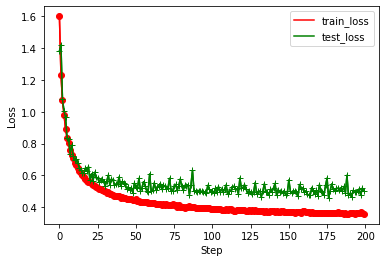

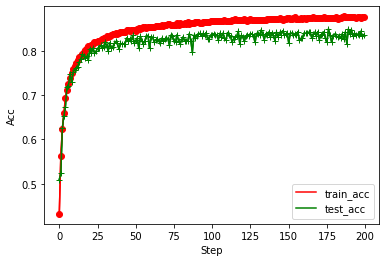

In [41]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [42]:
LOG_PATH="./train17.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn17.pth"
    
model = models.resnet50()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 200
print("Model: Resnet-50")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: Resnet-50
Batch size: 128
Epoch num: 200
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:38, 10.28it/s]

Finish 1 epoch, Train loss: 1.912550, Train acc@1: 0.333340


Test loss: 1.594889, Test acc@1: 0.422000
Saving Best model...			Top1 = 42.200000%
Elapsed time: 41.40090847015381
---------- Training Epoch #1 ----------


391it [00:36, 10.77it/s]

Finish 2 epoch, Train loss: 1.661195, Train acc@1: 0.414080


Test loss: 1.573918, Test acc@1: 0.446400
Saving Best model...			Top1 = 44.640000%
Elapsed time: 81.06961369514465
---------- Training Epoch #2 ----------


391it [00:35, 10.90it/s]

Finish 3 epoch, Train loss: 1.374447, Train acc@1: 0.510320


Test loss: 1.345934, Test acc@1: 0.533300
Saving Best model...			Top1 = 53.330000%
Elapsed time: 120.3159909248352
---------- Training Epoch #3 ----------


391it [00:35, 11.09it/s]

Finish 4 epoch, Train loss: 1.183400, Train acc@1: 0.585180


Test loss: 1.062357, Test acc@1: 0.626900
Saving Best model...			Top1 = 62.690000%
Elapsed time: 159.92321467399597
---------- Training Epoch #4 ----------


391it [00:37, 10.53it/s]

Finish 5 epoch, Train loss: 1.068294, Train acc@1: 0.629400


Test loss: 1.063347, Test acc@1: 0.622000
Elapsed time: 200.0143597126007
---------- Training Epoch #5 ----------


391it [00:37, 10.37it/s]

Finish 6 epoch, Train loss: 0.977154, Train acc@1: 0.661540


Test loss: 1.001404, Test acc@1: 0.651600
Saving Best model...			Top1 = 65.160000%
Elapsed time: 240.9542999267578
---------- Training Epoch #6 ----------


391it [00:36, 10.77it/s]

Finish 7 epoch, Train loss: 0.908022, Train acc@1: 0.690320


Test loss: 0.897221, Test acc@1: 0.691800
Saving Best model...			Top1 = 69.180000%
Elapsed time: 280.55206060409546
---------- Training Epoch #7 ----------


391it [00:35, 10.94it/s]

Finish 8 epoch, Train loss: 0.859065, Train acc@1: 0.706760


Test loss: 0.853866, Test acc@1: 0.712500
Saving Best model...			Top1 = 71.250000%
Elapsed time: 319.7044208049774
---------- Training Epoch #8 ----------


391it [00:35, 11.02it/s]

Finish 9 epoch, Train loss: 0.809979, Train acc@1: 0.725840


Test loss: 0.816338, Test acc@1: 0.725000
Saving Best model...			Top1 = 72.500000%
Elapsed time: 358.4750142097473
---------- Training Epoch #9 ----------


391it [00:35, 10.99it/s]

Finish 10 epoch, Train loss: 0.770565, Train acc@1: 0.738180


Test loss: 0.765448, Test acc@1: 0.736900
Saving Best model...			Top1 = 73.690000%
Elapsed time: 397.4234881401062
---------- Training Epoch #10 ----------


391it [00:36, 10.81it/s]

Finish 11 epoch, Train loss: 0.738962, Train acc@1: 0.749720


Test loss: 0.721766, Test acc@1: 0.755000
Saving Best model...			Top1 = 75.500000%
Elapsed time: 437.05678033828735
---------- Training Epoch #11 ----------


391it [00:36, 10.64it/s]

Finish 12 epoch, Train loss: 0.708828, Train acc@1: 0.759780


Test loss: 0.750113, Test acc@1: 0.747700
Elapsed time: 476.8106906414032
---------- Training Epoch #12 ----------


391it [00:35, 10.92it/s]

Finish 13 epoch, Train loss: 0.691191, Train acc@1: 0.764300


Test loss: 0.708978, Test acc@1: 0.762700
Saving Best model...			Top1 = 76.270000%
Elapsed time: 515.952073097229
---------- Training Epoch #13 ----------


391it [00:35, 10.90it/s]

Finish 14 epoch, Train loss: 0.671748, Train acc@1: 0.772680


Test loss: 0.798873, Test acc@1: 0.733700
Elapsed time: 555.0138437747955
---------- Training Epoch #14 ----------


391it [00:35, 10.93it/s]

Finish 15 epoch, Train loss: 0.653800, Train acc@1: 0.776880


Test loss: 0.695685, Test acc@1: 0.769000
Saving Best model...			Top1 = 76.900000%
Elapsed time: 595.0250074863434
---------- Training Epoch #15 ----------


391it [00:36, 10.84it/s]

Finish 16 epoch, Train loss: 0.635652, Train acc@1: 0.785920


Test loss: 0.634466, Test acc@1: 0.788700
Saving Best model...			Top1 = 78.870000%
Elapsed time: 634.4654166698456
---------- Training Epoch #16 ----------


391it [00:35, 10.87it/s]

Finish 17 epoch, Train loss: 0.620534, Train acc@1: 0.791000


Test loss: 0.661058, Test acc@1: 0.772500
Elapsed time: 673.4617660045624
---------- Training Epoch #17 ----------


391it [00:34, 11.42it/s]

Finish 18 epoch, Train loss: 0.607445, Train acc@1: 0.794660


Test loss: 0.682039, Test acc@1: 0.768800
Elapsed time: 710.6785583496094
---------- Training Epoch #18 ----------


391it [00:35, 10.98it/s]

Finish 19 epoch, Train loss: 0.598542, Train acc@1: 0.797580


Test loss: 0.672839, Test acc@1: 0.771400
Elapsed time: 749.4570560455322
---------- Training Epoch #19 ----------


391it [00:37, 10.54it/s]

Finish 20 epoch, Train loss: 0.582027, Train acc@1: 0.801320


Test loss: 0.678401, Test acc@1: 0.773100
Elapsed time: 789.6455783843994
---------- Training Epoch #20 ----------


391it [00:36, 10.75it/s]

Finish 21 epoch, Train loss: 0.571932, Train acc@1: 0.804080


Test loss: 0.611913, Test acc@1: 0.794400
Saving Best model...			Top1 = 79.440000%
Elapsed time: 829.2540917396545
---------- Training Epoch #21 ----------


391it [00:35, 10.86it/s]

Finish 22 epoch, Train loss: 0.559568, Train acc@1: 0.810920


Test loss: 0.596962, Test acc@1: 0.802600
Saving Best model...			Top1 = 80.260000%
Elapsed time: 868.6118519306183
---------- Training Epoch #22 ----------


391it [00:35, 10.99it/s]

Finish 23 epoch, Train loss: 0.551866, Train acc@1: 0.812000


Test loss: 0.655061, Test acc@1: 0.785400
Elapsed time: 907.4867429733276
---------- Training Epoch #23 ----------


391it [00:35, 10.88it/s]


Finish 24 epoch, Train loss: 0.553132, Train acc@1: 0.813920
Test loss: 0.581588, Test acc@1: 0.804000
Saving Best model...			Top1 = 80.400000%
Elapsed time: 946.7730760574341
---------- Training Epoch #24 ----------


391it [00:35, 11.07it/s]

Finish 25 epoch, Train loss: 0.540622, Train acc@1: 0.814520


Test loss: 0.576726, Test acc@1: 0.803200
Elapsed time: 985.6908164024353
---------- Training Epoch #25 ----------


391it [00:36, 10.74it/s]

Finish 26 epoch, Train loss: 0.533435, Train acc@1: 0.819480


Test loss: 0.612524, Test acc@1: 0.796000
Elapsed time: 1025.128963470459
---------- Training Epoch #26 ----------


391it [00:36, 10.73it/s]

Finish 27 epoch, Train loss: 0.522777, Train acc@1: 0.823860


Test loss: 0.682710, Test acc@1: 0.770600
Elapsed time: 1064.7178795337677
---------- Training Epoch #27 ----------


391it [00:37, 10.37it/s]

Finish 28 epoch, Train loss: 0.512080, Train acc@1: 0.828080


Test loss: 0.564951, Test acc@1: 0.813500
Saving Best model...			Top1 = 81.350000%
Elapsed time: 1105.9009811878204
---------- Training Epoch #28 ----------


391it [00:35, 10.96it/s]

Finish 29 epoch, Train loss: 0.513476, Train acc@1: 0.825960


Test loss: 0.616178, Test acc@1: 0.796600
Elapsed time: 1144.7304208278656
---------- Training Epoch #29 ----------


391it [00:35, 10.98it/s]


Finish 30 epoch, Train loss: 0.504354, Train acc@1: 0.830240
Test loss: 0.584530, Test acc@1: 0.809200
Elapsed time: 1183.5635876655579
---------- Training Epoch #30 ----------


391it [00:37, 10.55it/s]

Finish 31 epoch, Train loss: 0.499500, Train acc@1: 0.831160


Test loss: 0.624552, Test acc@1: 0.797800
Elapsed time: 1223.7904088497162
---------- Training Epoch #31 ----------


391it [00:35, 10.89it/s]

Finish 32 epoch, Train loss: 0.498885, Train acc@1: 0.831180


Test loss: 0.591464, Test acc@1: 0.801000
Elapsed time: 1262.7929151058197
---------- Training Epoch #32 ----------


391it [00:35, 10.92it/s]

Finish 33 epoch, Train loss: 0.494697, Train acc@1: 0.832800


Test loss: 0.649571, Test acc@1: 0.789800
Elapsed time: 1301.6825354099274
---------- Training Epoch #33 ----------


391it [00:36, 10.77it/s]

Finish 34 epoch, Train loss: 0.483393, Train acc@1: 0.835680


Test loss: 0.609595, Test acc@1: 0.802500
Elapsed time: 1341.0557057857513
---------- Training Epoch #34 ----------


391it [00:36, 10.85it/s]

Finish 35 epoch, Train loss: 0.482195, Train acc@1: 0.835720


Test loss: 0.553478, Test acc@1: 0.816400
Saving Best model...			Top1 = 81.640000%
Elapsed time: 1380.8760557174683
---------- Training Epoch #35 ----------


391it [00:34, 11.25it/s]

Finish 36 epoch, Train loss: 0.481882, Train acc@1: 0.838780


Test loss: 0.513522, Test acc@1: 0.823000
Saving Best model...			Top1 = 82.300000%
Elapsed time: 1419.442434310913
---------- Training Epoch #36 ----------


391it [00:35, 11.16it/s]

Finish 37 epoch, Train loss: 0.474950, Train acc@1: 0.839020


Test loss: 0.617055, Test acc@1: 0.797200
Elapsed time: 1457.583679676056
---------- Training Epoch #37 ----------


391it [00:36, 10.82it/s]

Finish 38 epoch, Train loss: 0.470041, Train acc@1: 0.838500


Test loss: 0.586786, Test acc@1: 0.804800
Elapsed time: 1496.7515902519226
---------- Training Epoch #38 ----------


391it [00:35, 11.09it/s]

Finish 39 epoch, Train loss: 0.462911, Train acc@1: 0.842920


Test loss: 0.539379, Test acc@1: 0.814900
Elapsed time: 1534.9723935127258
---------- Training Epoch #39 ----------


391it [00:36, 10.85it/s]

Finish 40 epoch, Train loss: 0.462604, Train acc@1: 0.842780


Test loss: 0.578518, Test acc@1: 0.812300
Elapsed time: 1574.1493911743164
---------- Training Epoch #40 ----------


391it [00:37, 10.55it/s]

Finish 41 epoch, Train loss: 0.456211, Train acc@1: 0.844980


Test loss: 0.542478, Test acc@1: 0.825400
Saving Best model...			Top1 = 82.540000%
Elapsed time: 1614.9395756721497
---------- Training Epoch #41 ----------


391it [00:37, 10.32it/s]

Finish 42 epoch, Train loss: 0.453480, Train acc@1: 0.845380


Test loss: 0.590509, Test acc@1: 0.802400
Elapsed time: 1656.7906880378723
---------- Training Epoch #42 ----------


391it [00:35, 10.92it/s]

Finish 43 epoch, Train loss: 0.447425, Train acc@1: 0.847400


Test loss: 0.556832, Test acc@1: 0.814200
Elapsed time: 1695.6057839393616
---------- Training Epoch #43 ----------


391it [00:35, 10.99it/s]

Finish 44 epoch, Train loss: 0.452353, Train acc@1: 0.846420


Test loss: 0.564716, Test acc@1: 0.813200
Elapsed time: 1734.321283340454
---------- Training Epoch #44 ----------


391it [00:37, 10.44it/s]

Finish 45 epoch, Train loss: 0.445977, Train acc@1: 0.849240


Test loss: 0.575523, Test acc@1: 0.807200
Elapsed time: 1774.8418955802917
---------- Training Epoch #45 ----------


391it [00:36, 10.82it/s]

Finish 46 epoch, Train loss: 0.442658, Train acc@1: 0.849400


Test loss: 0.529574, Test acc@1: 0.826100
Saving Best model...			Top1 = 82.610000%
Elapsed time: 1814.4414126873016
---------- Training Epoch #46 ----------


391it [00:35, 10.88it/s]


Finish 47 epoch, Train loss: 0.435727, Train acc@1: 0.851320
Test loss: 0.558353, Test acc@1: 0.820500
Elapsed time: 1853.4497618675232
---------- Training Epoch #47 ----------


391it [00:36, 10.78it/s]

Finish 48 epoch, Train loss: 0.429657, Train acc@1: 0.854440


Test loss: 0.528243, Test acc@1: 0.826500
Saving Best model...			Top1 = 82.650000%
Elapsed time: 1893.4017732143402
---------- Training Epoch #48 ----------


391it [00:36, 10.79it/s]


Finish 49 epoch, Train loss: 0.436585, Train acc@1: 0.851840
Test loss: 0.576012, Test acc@1: 0.811200
Elapsed time: 1932.6402714252472
---------- Training Epoch #49 ----------


391it [00:36, 10.82it/s]

Finish 50 epoch, Train loss: 0.430298, Train acc@1: 0.852400


Test loss: 0.540025, Test acc@1: 0.822000
Elapsed time: 1971.9135296344757
---------- Training Epoch #50 ----------


391it [00:35, 10.94it/s]

Finish 51 epoch, Train loss: 0.430467, Train acc@1: 0.853980


Test loss: 0.540617, Test acc@1: 0.823200
Elapsed time: 2010.7750153541565
---------- Training Epoch #51 ----------


391it [00:36, 10.83it/s]

Finish 52 epoch, Train loss: 0.424576, Train acc@1: 0.854740


Test loss: 0.542741, Test acc@1: 0.815700
Elapsed time: 2049.904672384262
---------- Training Epoch #52 ----------


391it [00:35, 10.91it/s]

Finish 53 epoch, Train loss: 0.425527, Train acc@1: 0.855780


Test loss: 0.534851, Test acc@1: 0.819600
Elapsed time: 2089.843553543091
---------- Training Epoch #53 ----------


391it [00:36, 10.59it/s]

Finish 54 epoch, Train loss: 0.424721, Train acc@1: 0.855080


Test loss: 0.565136, Test acc@1: 0.814400
Elapsed time: 2129.8590211868286
---------- Training Epoch #54 ----------


391it [00:35, 11.13it/s]

Finish 55 epoch, Train loss: 0.421024, Train acc@1: 0.855420


Test loss: 0.607723, Test acc@1: 0.806600
Elapsed time: 2168.2138640880585
---------- Training Epoch #55 ----------


391it [00:35, 11.05it/s]

Finish 56 epoch, Train loss: 0.417654, Train acc@1: 0.857260


Test loss: 0.543036, Test acc@1: 0.822800
Elapsed time: 2207.476321697235
---------- Training Epoch #56 ----------


391it [00:36, 10.77it/s]

Finish 57 epoch, Train loss: 0.412386, Train acc@1: 0.861080


Test loss: 0.510854, Test acc@1: 0.835800
Saving Best model...			Top1 = 83.580000%
Elapsed time: 2247.3029067516327
---------- Training Epoch #57 ----------


391it [00:36, 10.80it/s]

Finish 58 epoch, Train loss: 0.416237, Train acc@1: 0.858440


Test loss: 0.574305, Test acc@1: 0.812900
Elapsed time: 2286.7223813533783
---------- Training Epoch #58 ----------


391it [00:36, 10.84it/s]

Finish 59 epoch, Train loss: 0.412427, Train acc@1: 0.862080


Test loss: 0.505110, Test acc@1: 0.835700
Elapsed time: 2325.870543718338
---------- Training Epoch #59 ----------


391it [00:34, 11.47it/s]

Finish 60 epoch, Train loss: 0.411163, Train acc@1: 0.860480


Test loss: 0.503217, Test acc@1: 0.826500
Elapsed time: 2363.0914080142975
---------- Training Epoch #60 ----------


391it [00:35, 11.02it/s]

Finish 61 epoch, Train loss: 0.406792, Train acc@1: 0.860880


Test loss: 0.527697, Test acc@1: 0.831700
Elapsed time: 2401.5723996162415
---------- Training Epoch #61 ----------


391it [00:35, 11.08it/s]

Finish 62 epoch, Train loss: 0.406731, Train acc@1: 0.861260


Test loss: 0.521968, Test acc@1: 0.824800
Elapsed time: 2439.7610816955566
---------- Training Epoch #62 ----------


391it [00:36, 10.83it/s]

Finish 63 epoch, Train loss: 0.406045, Train acc@1: 0.861600


Test loss: 0.501489, Test acc@1: 0.834200
Elapsed time: 2478.875955581665
---------- Training Epoch #63 ----------


391it [00:34, 11.20it/s]

Finish 64 epoch, Train loss: 0.403213, Train acc@1: 0.862520


Test loss: 0.509216, Test acc@1: 0.829600
Elapsed time: 2516.7080957889557
---------- Training Epoch #64 ----------


391it [00:35, 10.95it/s]

Finish 65 epoch, Train loss: 0.404859, Train acc@1: 0.861800


Test loss: 0.563080, Test acc@1: 0.816200
Elapsed time: 2555.80624294281
---------- Training Epoch #65 ----------


391it [00:35, 10.89it/s]

Finish 66 epoch, Train loss: 0.397189, Train acc@1: 0.864600


Test loss: 0.495304, Test acc@1: 0.836000
Saving Best model...			Top1 = 83.600000%
Elapsed time: 2595.016645669937
---------- Training Epoch #66 ----------


391it [00:35, 10.97it/s]

Finish 67 epoch, Train loss: 0.395899, Train acc@1: 0.866920


Test loss: 0.565398, Test acc@1: 0.819300
Elapsed time: 2633.628577232361
---------- Training Epoch #67 ----------


391it [00:36, 10.73it/s]

Finish 68 epoch, Train loss: 0.393966, Train acc@1: 0.865820


Test loss: 0.538105, Test acc@1: 0.824700
Elapsed time: 2673.8583920001984
---------- Training Epoch #68 ----------


391it [00:35, 10.91it/s]

Finish 69 epoch, Train loss: 0.391692, Train acc@1: 0.866720


Test loss: 0.503945, Test acc@1: 0.833000
Elapsed time: 2712.625228881836
---------- Training Epoch #69 ----------


391it [00:37, 10.34it/s]

Finish 70 epoch, Train loss: 0.395987, Train acc@1: 0.865300


Test loss: 0.524870, Test acc@1: 0.829000
Elapsed time: 2753.4385600090027
---------- Training Epoch #70 ----------


391it [00:36, 10.81it/s]

Finish 71 epoch, Train loss: 0.393744, Train acc@1: 0.866220


Test loss: 0.493288, Test acc@1: 0.834200
Elapsed time: 2793.3835179805756
---------- Training Epoch #71 ----------


391it [00:34, 11.29it/s]

Finish 72 epoch, Train loss: 0.389072, Train acc@1: 0.866180


Test loss: 0.533246, Test acc@1: 0.827500
Elapsed time: 2830.9619109630585
---------- Training Epoch #72 ----------


391it [00:36, 10.73it/s]

Finish 73 epoch, Train loss: 0.391018, Train acc@1: 0.867120


Test loss: 0.495013, Test acc@1: 0.835900
Elapsed time: 2870.3600449562073
---------- Training Epoch #73 ----------


391it [00:36, 10.74it/s]

Finish 74 epoch, Train loss: 0.388146, Train acc@1: 0.867080


Test loss: 0.503701, Test acc@1: 0.831600
Elapsed time: 2909.771460533142
---------- Training Epoch #74 ----------


391it [00:35, 11.07it/s]

Finish 75 epoch, Train loss: 0.378241, Train acc@1: 0.870280


Test loss: 0.516464, Test acc@1: 0.833300
Elapsed time: 2947.9949626922607
---------- Training Epoch #75 ----------


391it [00:33, 11.63it/s]

Finish 76 epoch, Train loss: 0.388617, Train acc@1: 0.867060


Test loss: 0.503578, Test acc@1: 0.831900
Elapsed time: 2985.8076174259186
---------- Training Epoch #76 ----------


391it [00:36, 10.68it/s]

Finish 77 epoch, Train loss: 0.388276, Train acc@1: 0.866160


Test loss: 0.502717, Test acc@1: 0.836300
Saving Best model...			Top1 = 83.630000%
Elapsed time: 3025.6570177078247
---------- Training Epoch #77 ----------


391it [00:35, 10.94it/s]

Finish 78 epoch, Train loss: 0.387022, Train acc@1: 0.867280


Test loss: 0.519777, Test acc@1: 0.828400
Elapsed time: 3064.401458978653
---------- Training Epoch #78 ----------


391it [00:35, 10.97it/s]

Finish 79 epoch, Train loss: 0.383798, Train acc@1: 0.867580


Test loss: 0.515269, Test acc@1: 0.836400
Saving Best model...			Top1 = 83.640000%
Elapsed time: 3103.3409509658813
---------- Training Epoch #79 ----------


391it [00:35, 10.96it/s]

Finish 80 epoch, Train loss: 0.386173, Train acc@1: 0.867060


Test loss: 0.522183, Test acc@1: 0.832500
Elapsed time: 3141.974079847336
---------- Training Epoch #80 ----------


391it [00:35, 11.03it/s]

Finish 81 epoch, Train loss: 0.376682, Train acc@1: 0.871560


Test loss: 0.484934, Test acc@1: 0.840300
Saving Best model...			Top1 = 84.030000%
Elapsed time: 3180.5839030742645
---------- Training Epoch #81 ----------


391it [00:37, 10.32it/s]

Finish 82 epoch, Train loss: 0.377146, Train acc@1: 0.870480


Test loss: 0.491951, Test acc@1: 0.842900
Saving Best model...			Top1 = 84.290000%
Elapsed time: 3221.8669395446777
---------- Training Epoch #82 ----------


391it [00:34, 11.46it/s]

Finish 83 epoch, Train loss: 0.377289, Train acc@1: 0.871000


Test loss: 0.528411, Test acc@1: 0.829900
Elapsed time: 3258.9360847473145
---------- Training Epoch #83 ----------


391it [00:34, 11.24it/s]

Finish 84 epoch, Train loss: 0.379907, Train acc@1: 0.870300


Test loss: 0.475647, Test acc@1: 0.845800
Saving Best model...			Top1 = 84.580000%
Elapsed time: 3296.9932572841644
---------- Training Epoch #84 ----------


391it [00:37, 10.55it/s]

Finish 85 epoch, Train loss: 0.375622, Train acc@1: 0.870920


Test loss: 0.479524, Test acc@1: 0.844600
Elapsed time: 3336.993359565735
---------- Training Epoch #85 ----------


391it [00:36, 10.62it/s]

Finish 86 epoch, Train loss: 0.367207, Train acc@1: 0.875360


Test loss: 0.513622, Test acc@1: 0.834100
Elapsed time: 3377.1048667430878
---------- Training Epoch #86 ----------


391it [00:36, 10.83it/s]

Finish 87 epoch, Train loss: 0.372994, Train acc@1: 0.872920


Test loss: 0.554236, Test acc@1: 0.820200
Elapsed time: 3416.1853625774384
---------- Training Epoch #87 ----------


391it [00:35, 10.99it/s]

Finish 88 epoch, Train loss: 0.372199, Train acc@1: 0.874640


Test loss: 0.481247, Test acc@1: 0.841500
Elapsed time: 3454.79718208313
---------- Training Epoch #88 ----------


391it [00:35, 10.97it/s]

Finish 89 epoch, Train loss: 0.368815, Train acc@1: 0.874500


Test loss: 0.464504, Test acc@1: 0.847600
Saving Best model...			Top1 = 84.760000%
Elapsed time: 3493.672916650772
---------- Training Epoch #89 ----------


391it [00:36, 10.75it/s]

Finish 90 epoch, Train loss: 0.372086, Train acc@1: 0.872780


Test loss: 0.497703, Test acc@1: 0.837900
Elapsed time: 3532.918860912323
---------- Training Epoch #90 ----------


391it [00:36, 10.60it/s]

Finish 91 epoch, Train loss: 0.370569, Train acc@1: 0.873800


Test loss: 0.481498, Test acc@1: 0.841600
Elapsed time: 3572.752737045288
---------- Training Epoch #91 ----------


391it [00:35, 11.01it/s]

Finish 92 epoch, Train loss: 0.372701, Train acc@1: 0.872640


Test loss: 0.542874, Test acc@1: 0.822800
Elapsed time: 3611.267908811569
---------- Training Epoch #92 ----------


391it [00:36, 10.76it/s]

Finish 93 epoch, Train loss: 0.371737, Train acc@1: 0.873960


Test loss: 0.484949, Test acc@1: 0.840800
Elapsed time: 3650.518934726715
---------- Training Epoch #93 ----------


391it [00:36, 10.72it/s]

Finish 94 epoch, Train loss: 0.365867, Train acc@1: 0.876520


Test loss: 0.523835, Test acc@1: 0.833800
Elapsed time: 3690.045243024826
---------- Training Epoch #94 ----------


391it [00:35, 10.91it/s]

Finish 95 epoch, Train loss: 0.368190, Train acc@1: 0.874520


Test loss: 0.489361, Test acc@1: 0.837600
Elapsed time: 3728.819192171097
---------- Training Epoch #95 ----------


391it [00:35, 10.98it/s]


Finish 96 epoch, Train loss: 0.364540, Train acc@1: 0.875020
Test loss: 0.511085, Test acc@1: 0.831900
Elapsed time: 3767.341946363449
---------- Training Epoch #96 ----------


391it [00:34, 11.44it/s]

Finish 97 epoch, Train loss: 0.363826, Train acc@1: 0.875920


Test loss: 0.480160, Test acc@1: 0.841300
Elapsed time: 3804.480000257492
---------- Training Epoch #97 ----------


391it [00:35, 11.02it/s]

Finish 98 epoch, Train loss: 0.357665, Train acc@1: 0.878240


Test loss: 0.474054, Test acc@1: 0.841200
Elapsed time: 3842.894636631012
---------- Training Epoch #98 ----------


391it [00:35, 11.03it/s]

Finish 99 epoch, Train loss: 0.362789, Train acc@1: 0.875600


Test loss: 0.527899, Test acc@1: 0.825200
Elapsed time: 3881.457009077072
---------- Training Epoch #99 ----------


391it [00:36, 10.73it/s]

Finish 100 epoch, Train loss: 0.361838, Train acc@1: 0.877660


Test loss: 0.555039, Test acc@1: 0.823000
Elapsed time: 3920.8948168754578
---------- Training Epoch #100 ----------


391it [00:35, 10.92it/s]

Finish 101 epoch, Train loss: 0.362971, Train acc@1: 0.876200


Test loss: 0.498804, Test acc@1: 0.839900
Elapsed time: 3959.7167897224426
---------- Training Epoch #101 ----------


391it [00:34, 11.42it/s]

Finish 102 epoch, Train loss: 0.356220, Train acc@1: 0.876840


Test loss: 0.489610, Test acc@1: 0.837200
Elapsed time: 3996.767575979233
---------- Training Epoch #102 ----------


391it [00:35, 10.97it/s]

Finish 103 epoch, Train loss: 0.357180, Train acc@1: 0.879680


Test loss: 0.506206, Test acc@1: 0.836100
Elapsed time: 4035.3723130226135
---------- Training Epoch #103 ----------


391it [00:35, 10.94it/s]

Finish 104 epoch, Train loss: 0.358323, Train acc@1: 0.878760


Test loss: 0.503463, Test acc@1: 0.831200
Elapsed time: 4074.157170534134
---------- Training Epoch #104 ----------


391it [00:37, 10.50it/s]

Finish 105 epoch, Train loss: 0.360857, Train acc@1: 0.876620


Test loss: 0.477276, Test acc@1: 0.842200
Elapsed time: 4114.340080499649
---------- Training Epoch #105 ----------


391it [00:34, 11.17it/s]

Finish 106 epoch, Train loss: 0.355084, Train acc@1: 0.879280


Test loss: 0.485517, Test acc@1: 0.840600
Elapsed time: 4152.240575790405
---------- Training Epoch #106 ----------


391it [00:36, 10.59it/s]

Finish 107 epoch, Train loss: 0.356826, Train acc@1: 0.879940


Test loss: 0.470466, Test acc@1: 0.845100
Elapsed time: 4192.1527717113495
---------- Training Epoch #107 ----------


391it [00:35, 11.15it/s]

Finish 108 epoch, Train loss: 0.356238, Train acc@1: 0.877760


Test loss: 0.516958, Test acc@1: 0.835000
Elapsed time: 4230.162027597427
---------- Training Epoch #108 ----------


391it [00:35, 11.02it/s]

Finish 109 epoch, Train loss: 0.357313, Train acc@1: 0.877760


Test loss: 0.483580, Test acc@1: 0.840200
Elapsed time: 4268.976653575897
---------- Training Epoch #109 ----------


391it [00:36, 10.63it/s]

Finish 110 epoch, Train loss: 0.354766, Train acc@1: 0.878440


Test loss: 0.484802, Test acc@1: 0.844200
Elapsed time: 4308.676091194153
---------- Training Epoch #110 ----------


391it [00:35, 10.96it/s]

Finish 111 epoch, Train loss: 0.351725, Train acc@1: 0.880740


Test loss: 0.510309, Test acc@1: 0.836200
Elapsed time: 4347.330486774445
---------- Training Epoch #111 ----------


391it [00:36, 10.81it/s]

Finish 112 epoch, Train loss: 0.353801, Train acc@1: 0.879080


Test loss: 0.500458, Test acc@1: 0.842400
Elapsed time: 4386.599784612656
---------- Training Epoch #112 ----------


391it [00:34, 11.18it/s]

Finish 113 epoch, Train loss: 0.356576, Train acc@1: 0.878020


Test loss: 0.475198, Test acc@1: 0.842100
Elapsed time: 4424.468461751938
---------- Training Epoch #113 ----------


391it [00:35, 10.97it/s]

Finish 114 epoch, Train loss: 0.347542, Train acc@1: 0.880100


Test loss: 0.499907, Test acc@1: 0.836100
Elapsed time: 4463.051872253418
---------- Training Epoch #114 ----------


391it [00:36, 10.68it/s]

Finish 115 epoch, Train loss: 0.349453, Train acc@1: 0.880780


Test loss: 0.504340, Test acc@1: 0.839200
Elapsed time: 4502.548642396927
---------- Training Epoch #115 ----------


391it [00:35, 11.06it/s]

Finish 116 epoch, Train loss: 0.353634, Train acc@1: 0.879620


Test loss: 0.533750, Test acc@1: 0.828400
Elapsed time: 4541.690192461014
---------- Training Epoch #116 ----------


391it [00:36, 10.86it/s]

Finish 117 epoch, Train loss: 0.347439, Train acc@1: 0.882020


Test loss: 0.499862, Test acc@1: 0.835400
Elapsed time: 4580.621036529541
---------- Training Epoch #117 ----------


391it [00:34, 11.19it/s]

Finish 118 epoch, Train loss: 0.349733, Train acc@1: 0.879980


Test loss: 0.499082, Test acc@1: 0.836800
Elapsed time: 4618.397993803024
---------- Training Epoch #118 ----------


391it [00:35, 10.96it/s]

Finish 119 epoch, Train loss: 0.343933, Train acc@1: 0.883340


Test loss: 0.488050, Test acc@1: 0.842500
Elapsed time: 4657.0297791957855
---------- Training Epoch #119 ----------


391it [00:34, 11.19it/s]

Finish 120 epoch, Train loss: 0.346749, Train acc@1: 0.881360


Test loss: 0.470740, Test acc@1: 0.846200
Elapsed time: 4694.996968746185
---------- Training Epoch #120 ----------


391it [00:35, 11.12it/s]

Finish 121 epoch, Train loss: 0.349307, Train acc@1: 0.881180


Test loss: 0.475213, Test acc@1: 0.845300
Elapsed time: 4733.062530755997
---------- Training Epoch #121 ----------


391it [00:35, 11.08it/s]

Finish 122 epoch, Train loss: 0.343917, Train acc@1: 0.882320


Test loss: 0.515733, Test acc@1: 0.834800
Elapsed time: 4771.435057878494
---------- Training Epoch #122 ----------


391it [00:37, 10.49it/s]

Finish 123 epoch, Train loss: 0.345091, Train acc@1: 0.881160


Test loss: 0.465065, Test acc@1: 0.846700
Elapsed time: 4811.6712300777435
---------- Training Epoch #123 ----------


391it [00:35, 10.89it/s]

Finish 124 epoch, Train loss: 0.346552, Train acc@1: 0.880020


Test loss: 0.594949, Test acc@1: 0.814700
Elapsed time: 4850.543185472488
---------- Training Epoch #124 ----------


391it [00:35, 10.87it/s]

Finish 125 epoch, Train loss: 0.344645, Train acc@1: 0.880640


Test loss: 0.472921, Test acc@1: 0.848400
Saving Best model...			Top1 = 84.840000%
Elapsed time: 4889.786321401596
---------- Training Epoch #125 ----------


391it [00:36, 10.62it/s]

Finish 126 epoch, Train loss: 0.347377, Train acc@1: 0.882180


Test loss: 0.550325, Test acc@1: 0.825700
Elapsed time: 4929.519833564758
---------- Training Epoch #126 ----------


391it [00:36, 10.82it/s]

Finish 127 epoch, Train loss: 0.337393, Train acc@1: 0.883840


Test loss: 0.476933, Test acc@1: 0.843700
Elapsed time: 4968.596594810486
---------- Training Epoch #127 ----------


391it [00:35, 11.08it/s]

Finish 128 epoch, Train loss: 0.344659, Train acc@1: 0.883000


Test loss: 0.486536, Test acc@1: 0.841200
Elapsed time: 5006.901389122009
---------- Training Epoch #128 ----------


391it [00:35, 11.08it/s]

Finish 129 epoch, Train loss: 0.342443, Train acc@1: 0.882700


Test loss: 0.492802, Test acc@1: 0.841300
Elapsed time: 5045.205508708954
---------- Training Epoch #129 ----------


391it [00:35, 11.10it/s]

Finish 130 epoch, Train loss: 0.340301, Train acc@1: 0.883720


Test loss: 0.486572, Test acc@1: 0.839800
Elapsed time: 5083.3909068107605
---------- Training Epoch #130 ----------


391it [00:35, 10.94it/s]

Finish 131 epoch, Train loss: 0.338981, Train acc@1: 0.883700


Test loss: 0.489773, Test acc@1: 0.837600
Elapsed time: 5122.134292840958
---------- Training Epoch #131 ----------


391it [00:33, 11.51it/s]

Finish 132 epoch, Train loss: 0.339146, Train acc@1: 0.885200


Test loss: 0.472656, Test acc@1: 0.847200
Elapsed time: 5159.3778529167175
---------- Training Epoch #132 ----------


391it [00:36, 10.78it/s]

Finish 133 epoch, Train loss: 0.336470, Train acc@1: 0.882980


Test loss: 0.506445, Test acc@1: 0.840500
Elapsed time: 5198.572790145874
---------- Training Epoch #133 ----------


391it [00:33, 11.59it/s]

Finish 134 epoch, Train loss: 0.339234, Train acc@1: 0.885320


Test loss: 0.478561, Test acc@1: 0.844100
Elapsed time: 5235.368690252304
---------- Training Epoch #134 ----------


391it [00:35, 11.09it/s]

Finish 135 epoch, Train loss: 0.336604, Train acc@1: 0.883860


Test loss: 0.487766, Test acc@1: 0.845900
Elapsed time: 5273.547434329987
---------- Training Epoch #135 ----------


391it [00:35, 11.13it/s]

Finish 136 epoch, Train loss: 0.340095, Train acc@1: 0.883740


Test loss: 0.486008, Test acc@1: 0.842700
Elapsed time: 5311.752559423447
---------- Training Epoch #136 ----------


391it [00:35, 11.00it/s]

Finish 137 epoch, Train loss: 0.336649, Train acc@1: 0.884080


Test loss: 0.510742, Test acc@1: 0.836700
Elapsed time: 5350.383411169052
---------- Training Epoch #137 ----------


391it [00:36, 10.82it/s]

Finish 138 epoch, Train loss: 0.335570, Train acc@1: 0.886120


Test loss: 0.491988, Test acc@1: 0.839900
Elapsed time: 5389.497754812241
---------- Training Epoch #138 ----------


391it [00:36, 10.66it/s]

Finish 139 epoch, Train loss: 0.335483, Train acc@1: 0.885600


Test loss: 0.510072, Test acc@1: 0.835200
Elapsed time: 5429.18553686142
---------- Training Epoch #139 ----------


391it [00:36, 10.86it/s]

Finish 140 epoch, Train loss: 0.336382, Train acc@1: 0.884660


Test loss: 0.479582, Test acc@1: 0.843200
Elapsed time: 5468.100676059723
---------- Training Epoch #140 ----------


391it [00:35, 11.11it/s]

Finish 141 epoch, Train loss: 0.334599, Train acc@1: 0.884820


Test loss: 0.474058, Test acc@1: 0.845000
Elapsed time: 5506.260048151016
---------- Training Epoch #141 ----------


391it [00:36, 10.80it/s]

Finish 142 epoch, Train loss: 0.336645, Train acc@1: 0.886680


Test loss: 0.470148, Test acc@1: 0.845800
Elapsed time: 5545.735867261887
---------- Training Epoch #142 ----------


391it [00:35, 11.09it/s]

Finish 143 epoch, Train loss: 0.333113, Train acc@1: 0.886380


Test loss: 0.465260, Test acc@1: 0.846700
Elapsed time: 5584.000057220459
---------- Training Epoch #143 ----------


391it [00:35, 11.10it/s]

Finish 144 epoch, Train loss: 0.332029, Train acc@1: 0.885580


Test loss: 0.550198, Test acc@1: 0.824500
Elapsed time: 5622.133449316025
---------- Training Epoch #144 ----------


391it [00:36, 10.78it/s]

Finish 145 epoch, Train loss: 0.328913, Train acc@1: 0.887380


Test loss: 0.465434, Test acc@1: 0.848700
Saving Best model...			Top1 = 84.870000%
Elapsed time: 5661.70628452301
---------- Training Epoch #145 ----------


391it [00:36, 10.86it/s]

Finish 146 epoch, Train loss: 0.327819, Train acc@1: 0.887740


Test loss: 0.482643, Test acc@1: 0.844700
Elapsed time: 5700.715659856796
---------- Training Epoch #146 ----------


391it [00:35, 10.93it/s]

Finish 147 epoch, Train loss: 0.328941, Train acc@1: 0.887380


Test loss: 0.473524, Test acc@1: 0.849200
Saving Best model...			Top1 = 84.920000%
Elapsed time: 5740.174564361572
---------- Training Epoch #147 ----------


391it [00:36, 10.77it/s]

Finish 148 epoch, Train loss: 0.331656, Train acc@1: 0.886200


Test loss: 0.458757, Test acc@1: 0.852600
Saving Best model...			Top1 = 85.260000%
Elapsed time: 5779.762400865555
---------- Training Epoch #148 ----------


391it [00:37, 10.34it/s]

Finish 149 epoch, Train loss: 0.333080, Train acc@1: 0.884900


Test loss: 0.515281, Test acc@1: 0.840100
Elapsed time: 5821.091874361038
---------- Training Epoch #149 ----------


391it [00:35, 11.08it/s]

Finish 150 epoch, Train loss: 0.331444, Train acc@1: 0.886780


Test loss: 0.520342, Test acc@1: 0.834200
Elapsed time: 5859.36642575264
---------- Training Epoch #150 ----------


391it [00:34, 11.21it/s]

Finish 151 epoch, Train loss: 0.331914, Train acc@1: 0.885980


Test loss: 0.466495, Test acc@1: 0.847000
Elapsed time: 5897.1814069747925
---------- Training Epoch #151 ----------


391it [00:36, 10.81it/s]

Finish 152 epoch, Train loss: 0.331905, Train acc@1: 0.885060


Test loss: 0.491311, Test acc@1: 0.843600
Elapsed time: 5936.299299955368
---------- Training Epoch #152 ----------


391it [00:35, 11.00it/s]

Finish 153 epoch, Train loss: 0.329541, Train acc@1: 0.887160


Test loss: 0.475748, Test acc@1: 0.848600
Elapsed time: 5974.753728866577
---------- Training Epoch #153 ----------


391it [00:36, 10.77it/s]

Finish 154 epoch, Train loss: 0.329029, Train acc@1: 0.886820


Test loss: 0.470720, Test acc@1: 0.847700
Elapsed time: 6013.957809925079
---------- Training Epoch #154 ----------


391it [00:35, 11.15it/s]

Finish 155 epoch, Train loss: 0.328700, Train acc@1: 0.886900


Test loss: 0.507600, Test acc@1: 0.836900
Elapsed time: 6051.9034948349
---------- Training Epoch #155 ----------


391it [00:35, 10.90it/s]

Finish 156 epoch, Train loss: 0.328145, Train acc@1: 0.887780


Test loss: 0.469161, Test acc@1: 0.847900
Elapsed time: 6091.945368528366
---------- Training Epoch #156 ----------


391it [00:35, 10.94it/s]

Finish 157 epoch, Train loss: 0.323894, Train acc@1: 0.889400


Test loss: 0.489848, Test acc@1: 0.847000
Elapsed time: 6130.592987537384
---------- Training Epoch #157 ----------


391it [00:35, 10.90it/s]

Finish 158 epoch, Train loss: 0.324995, Train acc@1: 0.887840


Test loss: 0.565218, Test acc@1: 0.827800
Elapsed time: 6169.447403430939
---------- Training Epoch #158 ----------


391it [00:35, 10.88it/s]

Finish 159 epoch, Train loss: 0.329381, Train acc@1: 0.886780


Test loss: 0.470045, Test acc@1: 0.847200
Elapsed time: 6208.335394620895
---------- Training Epoch #159 ----------


391it [00:36, 10.86it/s]

Finish 160 epoch, Train loss: 0.325426, Train acc@1: 0.887920


Test loss: 0.501515, Test acc@1: 0.841000
Elapsed time: 6247.367392063141
---------- Training Epoch #160 ----------


391it [00:36, 10.80it/s]

Finish 161 epoch, Train loss: 0.329527, Train acc@1: 0.886060


Test loss: 0.503019, Test acc@1: 0.836100
Elapsed time: 6286.632047891617
---------- Training Epoch #161 ----------


391it [00:35, 11.07it/s]

Finish 162 epoch, Train loss: 0.327193, Train acc@1: 0.889480


Test loss: 0.481615, Test acc@1: 0.843700
Elapsed time: 6324.8703553676605
---------- Training Epoch #162 ----------


391it [00:36, 10.63it/s]


Finish 163 epoch, Train loss: 0.323856, Train acc@1: 0.888140
Test loss: 0.468843, Test acc@1: 0.843100
Elapsed time: 6364.639130830765
---------- Training Epoch #163 ----------


391it [00:34, 11.22it/s]

Finish 164 epoch, Train loss: 0.321657, Train acc@1: 0.888720


Test loss: 0.543463, Test acc@1: 0.830100
Elapsed time: 6402.470413208008
---------- Training Epoch #164 ----------


391it [00:35, 11.12it/s]

Finish 165 epoch, Train loss: 0.329935, Train acc@1: 0.886660


Test loss: 0.503458, Test acc@1: 0.841700
Elapsed time: 6440.581247091293
---------- Training Epoch #165 ----------


391it [00:35, 10.96it/s]

Finish 166 epoch, Train loss: 0.324648, Train acc@1: 0.887840


Test loss: 0.482981, Test acc@1: 0.844800
Elapsed time: 6479.196586608887
---------- Training Epoch #166 ----------


391it [00:36, 10.80it/s]

Finish 167 epoch, Train loss: 0.321718, Train acc@1: 0.889660


Test loss: 0.469753, Test acc@1: 0.846400
Elapsed time: 6518.374464035034
---------- Training Epoch #167 ----------


391it [00:35, 10.92it/s]

Finish 168 epoch, Train loss: 0.327073, Train acc@1: 0.888180


Test loss: 0.469776, Test acc@1: 0.849100
Elapsed time: 6557.184910774231
---------- Training Epoch #168 ----------


391it [00:35, 11.00it/s]

Finish 169 epoch, Train loss: 0.322153, Train acc@1: 0.889520


Test loss: 0.483313, Test acc@1: 0.847900
Elapsed time: 6596.152998685837
---------- Training Epoch #169 ----------


391it [00:33, 11.61it/s]

Finish 170 epoch, Train loss: 0.325450, Train acc@1: 0.886940


Test loss: 0.488295, Test acc@1: 0.847400
Elapsed time: 6633.499197006226
---------- Training Epoch #170 ----------


391it [00:35, 10.89it/s]

Finish 171 epoch, Train loss: 0.323597, Train acc@1: 0.887280


Test loss: 0.517044, Test acc@1: 0.831800
Elapsed time: 6672.3643527030945
---------- Training Epoch #171 ----------


391it [00:35, 11.12it/s]

Finish 172 epoch, Train loss: 0.328808, Train acc@1: 0.888200


Test loss: 0.503276, Test acc@1: 0.835200
Elapsed time: 6710.374622583389
---------- Training Epoch #172 ----------


391it [00:35, 10.90it/s]

Finish 173 epoch, Train loss: 0.326751, Train acc@1: 0.888180


Test loss: 0.441962, Test acc@1: 0.855200
Saving Best model...			Top1 = 85.520000%
Elapsed time: 6750.26690196991
---------- Training Epoch #173 ----------


391it [00:36, 10.66it/s]

Finish 174 epoch, Train loss: 0.326233, Train acc@1: 0.888100


Test loss: 0.452858, Test acc@1: 0.855300
Saving Best model...			Top1 = 85.530000%
Elapsed time: 6790.331879854202
---------- Training Epoch #174 ----------


391it [00:35, 11.04it/s]

Finish 175 epoch, Train loss: 0.323024, Train acc@1: 0.889300


Test loss: 0.461034, Test acc@1: 0.851400
Elapsed time: 6828.696533679962
---------- Training Epoch #175 ----------


391it [00:33, 11.69it/s]

Finish 176 epoch, Train loss: 0.321015, Train acc@1: 0.888380


Test loss: 0.457963, Test acc@1: 0.851900
Elapsed time: 6865.1384880542755
---------- Training Epoch #176 ----------


391it [00:36, 10.62it/s]

Finish 177 epoch, Train loss: 0.319508, Train acc@1: 0.890620


Test loss: 0.518397, Test acc@1: 0.836700
Elapsed time: 6905.0163497924805
---------- Training Epoch #177 ----------


391it [00:37, 10.49it/s]


Finish 178 epoch, Train loss: 0.324178, Train acc@1: 0.887780
Test loss: 0.462333, Test acc@1: 0.850800
Elapsed time: 6945.2267055511475
---------- Training Epoch #178 ----------


391it [00:36, 10.71it/s]

Finish 179 epoch, Train loss: 0.320111, Train acc@1: 0.889600


Test loss: 0.519057, Test acc@1: 0.837700
Elapsed time: 6985.102071046829
---------- Training Epoch #179 ----------


391it [00:35, 11.15it/s]

Finish 180 epoch, Train loss: 0.324883, Train acc@1: 0.888380


Test loss: 0.459788, Test acc@1: 0.853900
Elapsed time: 7023.158281803131
---------- Training Epoch #180 ----------


391it [00:35, 10.93it/s]

Finish 181 epoch, Train loss: 0.318598, Train acc@1: 0.891320


Test loss: 0.478824, Test acc@1: 0.847600
Elapsed time: 7061.853063106537
---------- Training Epoch #181 ----------


391it [00:35, 10.86it/s]

Finish 182 epoch, Train loss: 0.324419, Train acc@1: 0.887500


Test loss: 0.511013, Test acc@1: 0.838700
Elapsed time: 7101.095911026001
---------- Training Epoch #182 ----------


391it [00:34, 11.25it/s]

Finish 183 epoch, Train loss: 0.322940, Train acc@1: 0.889620


Test loss: 0.515834, Test acc@1: 0.838500
Elapsed time: 7138.806124448776
---------- Training Epoch #183 ----------


391it [00:35, 10.89it/s]

Finish 184 epoch, Train loss: 0.320389, Train acc@1: 0.890240


Test loss: 0.498786, Test acc@1: 0.841100
Elapsed time: 7177.607472419739
---------- Training Epoch #184 ----------


391it [00:35, 10.99it/s]

Finish 185 epoch, Train loss: 0.315929, Train acc@1: 0.892160


Test loss: 0.462088, Test acc@1: 0.853300
Elapsed time: 7216.1292934417725
---------- Training Epoch #185 ----------


391it [00:36, 10.84it/s]

Finish 186 epoch, Train loss: 0.326073, Train acc@1: 0.888060


Test loss: 0.487316, Test acc@1: 0.842900
Elapsed time: 7255.13866353035
---------- Training Epoch #186 ----------


391it [00:34, 11.26it/s]

Finish 187 epoch, Train loss: 0.320440, Train acc@1: 0.889440


Test loss: 0.446967, Test acc@1: 0.856700
Saving Best model...			Top1 = 85.670000%
Elapsed time: 7293.211607694626
---------- Training Epoch #187 ----------


391it [00:36, 10.84it/s]

Finish 188 epoch, Train loss: 0.324422, Train acc@1: 0.886860


Test loss: 0.516749, Test acc@1: 0.834900
Elapsed time: 7333.177162885666
---------- Training Epoch #188 ----------


391it [00:35, 10.96it/s]

Finish 189 epoch, Train loss: 0.319354, Train acc@1: 0.890540


Test loss: 0.466903, Test acc@1: 0.849800
Elapsed time: 7371.883202314377
---------- Training Epoch #189 ----------


391it [00:35, 11.08it/s]

Finish 190 epoch, Train loss: 0.318133, Train acc@1: 0.890400


Test loss: 0.487562, Test acc@1: 0.846400
Elapsed time: 7410.254121541977
---------- Training Epoch #190 ----------


391it [00:34, 11.30it/s]

Finish 191 epoch, Train loss: 0.320702, Train acc@1: 0.890200


Test loss: 0.491579, Test acc@1: 0.844100
Elapsed time: 7448.318438053131
---------- Training Epoch #191 ----------


391it [00:37, 10.37it/s]

Finish 192 epoch, Train loss: 0.316199, Train acc@1: 0.891900


Test loss: 0.477630, Test acc@1: 0.845800
Elapsed time: 7489.010478258133
---------- Training Epoch #192 ----------


391it [00:36, 10.62it/s]

Finish 193 epoch, Train loss: 0.318813, Train acc@1: 0.890900


Test loss: 0.516200, Test acc@1: 0.833500
Elapsed time: 7528.834953069687
---------- Training Epoch #193 ----------


391it [00:35, 10.91it/s]

Finish 194 epoch, Train loss: 0.317261, Train acc@1: 0.890820


Test loss: 0.522538, Test acc@1: 0.832800
Elapsed time: 7567.742675542831
---------- Training Epoch #194 ----------


391it [00:35, 10.94it/s]

Finish 195 epoch, Train loss: 0.317404, Train acc@1: 0.890860


Test loss: 0.495310, Test acc@1: 0.839600
Elapsed time: 7606.445618391037
---------- Training Epoch #195 ----------


391it [00:37, 10.45it/s]

Finish 196 epoch, Train loss: 0.320681, Train acc@1: 0.889960


Test loss: 0.478581, Test acc@1: 0.848100
Elapsed time: 7646.804352283478
---------- Training Epoch #196 ----------


391it [00:35, 10.90it/s]

Finish 197 epoch, Train loss: 0.316159, Train acc@1: 0.891580


Test loss: 0.483459, Test acc@1: 0.846500
Elapsed time: 7685.561338424683
---------- Training Epoch #197 ----------


391it [00:36, 10.78it/s]

Finish 198 epoch, Train loss: 0.319857, Train acc@1: 0.889120


Test loss: 0.494214, Test acc@1: 0.842400
Elapsed time: 7725.149330377579
---------- Training Epoch #198 ----------


391it [00:35, 11.03it/s]

Finish 199 epoch, Train loss: 0.311183, Train acc@1: 0.893220


Test loss: 0.494958, Test acc@1: 0.846000
Elapsed time: 7763.591837406158
---------- Training Epoch #199 ----------


391it [00:35, 10.87it/s]

Finish 200 epoch, Train loss: 0.315216, Train acc@1: 0.891280


Test loss: 0.489690, Test acc@1: 0.844000
Elapsed time: 7803.452448606491

Test results: Acc@1 = 85.670000%


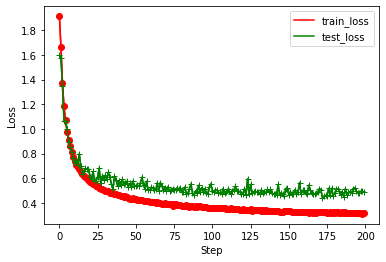

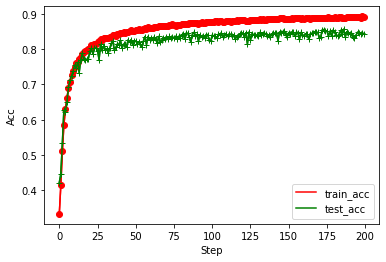

In [43]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [44]:
LOG_PATH="./train18.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn18.pth"
    
model = models.resnet152()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 200
print("Model: Resnet-152")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: Resnet-152
Batch size: 128
Epoch num: 200
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [01:20,  4.83it/s]

Finish 1 epoch, Train loss: 2.160563, Train acc@1: 0.239740


Test loss: 1.772119, Test acc@1: 0.326900
Saving Best model...			Top1 = 32.690000%
Elapsed time: 86.2581934928894
---------- Training Epoch #1 ----------


391it [01:24,  4.60it/s]

Finish 2 epoch, Train loss: 1.892458, Train acc@1: 0.310720


Test loss: 5.719447, Test acc@1: 0.292200
Elapsed time: 177.15918350219727
---------- Training Epoch #2 ----------


391it [01:29,  4.37it/s]

Finish 3 epoch, Train loss: 1.608114, Train acc@1: 0.418940


Test loss: 1.372736, Test acc@1: 0.505400
Saving Best model...			Top1 = 50.540000%
Elapsed time: 273.2793951034546
---------- Training Epoch #3 ----------


391it [01:30,  4.34it/s]

Finish 4 epoch, Train loss: 1.392949, Train acc@1: 0.503960


Test loss: 1.246866, Test acc@1: 0.560200
Saving Best model...			Top1 = 56.020000%
Elapsed time: 369.7060532569885
---------- Training Epoch #4 ----------


391it [01:28,  4.42it/s]

Finish 5 epoch, Train loss: 1.194205, Train acc@1: 0.576460


Test loss: 1.199719, Test acc@1: 0.578600
Saving Best model...			Top1 = 57.860000%
Elapsed time: 464.3115563392639
---------- Training Epoch #5 ----------


391it [01:31,  4.27it/s]

Finish 6 epoch, Train loss: 1.072233, Train acc@1: 0.623240


Test loss: 1.025808, Test acc@1: 0.634900
Saving Best model...			Top1 = 63.490000%
Elapsed time: 561.8778264522552
---------- Training Epoch #6 ----------


391it [01:27,  4.46it/s]

Finish 7 epoch, Train loss: 0.973116, Train acc@1: 0.662160


Test loss: 0.876193, Test acc@1: 0.702300
Saving Best model...			Top1 = 70.230000%
Elapsed time: 656.1187272071838
---------- Training Epoch #7 ----------


391it [01:30,  4.30it/s]

Finish 8 epoch, Train loss: 0.905418, Train acc@1: 0.686380


Test loss: 0.934671, Test acc@1: 0.680300
Elapsed time: 751.7958626747131
---------- Training Epoch #8 ----------


391it [01:15,  5.17it/s]

Finish 9 epoch, Train loss: 0.853325, Train acc@1: 0.706600


Test loss: 0.901469, Test acc@1: 0.694700
Elapsed time: 833.0691347122192
---------- Training Epoch #9 ----------


391it [01:17,  5.03it/s]

Finish 10 epoch, Train loss: 0.803330, Train acc@1: 0.725400


Test loss: 0.781886, Test acc@1: 0.738700
Saving Best model...			Top1 = 73.870000%
Elapsed time: 916.3410794734955
---------- Training Epoch #10 ----------


391it [01:19,  4.91it/s]

Finish 11 epoch, Train loss: 0.767160, Train acc@1: 0.739720


Test loss: 0.834002, Test acc@1: 0.725200
Elapsed time: 1001.623419046402
---------- Training Epoch #11 ----------


391it [01:16,  5.11it/s]

Finish 12 epoch, Train loss: 0.740428, Train acc@1: 0.745800


Test loss: 0.763631, Test acc@1: 0.744000
Saving Best model...			Top1 = 74.400000%
Elapsed time: 1084.0274622440338
---------- Training Epoch #12 ----------


391it [01:22,  4.72it/s]

Finish 13 epoch, Train loss: 0.717044, Train acc@1: 0.757380


Test loss: 0.798037, Test acc@1: 0.728200
Elapsed time: 1171.8360369205475
---------- Training Epoch #13 ----------


391it [01:30,  4.34it/s]

Finish 14 epoch, Train loss: 0.686730, Train acc@1: 0.767620


Test loss: 0.679183, Test acc@1: 0.765500
Saving Best model...			Top1 = 76.550000%
Elapsed time: 1268.8247735500336
---------- Training Epoch #14 ----------


391it [01:30,  4.32it/s]

Finish 15 epoch, Train loss: 0.670175, Train acc@1: 0.773800


Test loss: 0.712042, Test acc@1: 0.760200
Elapsed time: 1364.8685534000397
---------- Training Epoch #15 ----------


391it [01:22,  4.71it/s]

Finish 16 epoch, Train loss: 0.655231, Train acc@1: 0.777980


Test loss: 0.661980, Test acc@1: 0.776300
Saving Best model...			Top1 = 77.630000%
Elapsed time: 1453.958958864212
---------- Training Epoch #16 ----------


391it [01:16,  5.11it/s]

Finish 17 epoch, Train loss: 0.633651, Train acc@1: 0.783080


Test loss: 0.741783, Test acc@1: 0.749500
Elapsed time: 1535.2527613639832
---------- Training Epoch #17 ----------


391it [01:18,  4.97it/s]

Finish 18 epoch, Train loss: 0.627918, Train acc@1: 0.788260


Test loss: 0.688550, Test acc@1: 0.771200
Elapsed time: 1618.6964058876038
---------- Training Epoch #18 ----------


391it [01:14,  5.24it/s]

Finish 19 epoch, Train loss: 0.603664, Train acc@1: 0.796060


Test loss: 0.651616, Test acc@1: 0.780600
Saving Best model...			Top1 = 78.060000%
Elapsed time: 1699.0062973499298
---------- Training Epoch #19 ----------


391it [01:17,  5.07it/s]

Finish 20 epoch, Train loss: 0.597565, Train acc@1: 0.796400


Test loss: 0.646411, Test acc@1: 0.784200
Saving Best model...			Top1 = 78.420000%
Elapsed time: 1781.8341517448425
---------- Training Epoch #20 ----------


391it [01:15,  5.17it/s]

Finish 21 epoch, Train loss: 0.587043, Train acc@1: 0.802520


Test loss: 0.644747, Test acc@1: 0.779700
Elapsed time: 1862.1653337478638
---------- Training Epoch #21 ----------


391it [01:18,  4.98it/s]

Finish 22 epoch, Train loss: 0.570829, Train acc@1: 0.806440


Test loss: 0.665581, Test acc@1: 0.776700
Elapsed time: 1945.5838441848755
---------- Training Epoch #22 ----------


391it [01:20,  4.88it/s]

Finish 23 epoch, Train loss: 0.568511, Train acc@1: 0.807440


Test loss: 0.643434, Test acc@1: 0.782400
Elapsed time: 2030.5472040176392
---------- Training Epoch #23 ----------


391it [01:19,  4.90it/s]

Finish 24 epoch, Train loss: 0.558827, Train acc@1: 0.808480


Test loss: 0.630536, Test acc@1: 0.788500
Saving Best model...			Top1 = 78.850000%
Elapsed time: 2116.0180106163025
---------- Training Epoch #24 ----------


391it [01:19,  4.93it/s]

Finish 25 epoch, Train loss: 0.547757, Train acc@1: 0.814680


Test loss: 0.638983, Test acc@1: 0.788700
Saving Best model...			Top1 = 78.870000%
Elapsed time: 2201.4348578453064
---------- Training Epoch #25 ----------


391it [01:16,  5.14it/s]

Finish 26 epoch, Train loss: 0.539252, Train acc@1: 0.816380


Test loss: 0.593180, Test acc@1: 0.799000
Saving Best model...			Top1 = 79.900000%
Elapsed time: 2283.09938454628
---------- Training Epoch #26 ----------


391it [01:15,  5.20it/s]

Finish 27 epoch, Train loss: 0.531594, Train acc@1: 0.819300


Test loss: 0.629054, Test acc@1: 0.794000
Elapsed time: 2363.0991718769073
---------- Training Epoch #27 ----------


391it [01:16,  5.11it/s]

Finish 28 epoch, Train loss: 0.525222, Train acc@1: 0.821480


Test loss: 0.610921, Test acc@1: 0.796900
Elapsed time: 2445.186641931534
---------- Training Epoch #28 ----------


391it [01:34,  4.13it/s]

Finish 29 epoch, Train loss: 0.520863, Train acc@1: 0.822980


Test loss: 0.598823, Test acc@1: 0.798400
Elapsed time: 2546.271684885025
---------- Training Epoch #29 ----------


391it [01:30,  4.31it/s]

Finish 30 epoch, Train loss: 0.513053, Train acc@1: 0.824760


Test loss: 0.615327, Test acc@1: 0.792600
Elapsed time: 2643.3484270572662
---------- Training Epoch #30 ----------


391it [01:33,  4.19it/s]

Finish 31 epoch, Train loss: 0.508562, Train acc@1: 0.827720


Test loss: 0.576541, Test acc@1: 0.803400
Saving Best model...			Top1 = 80.340000%
Elapsed time: 2744.005364179611
---------- Training Epoch #31 ----------


391it [01:42,  3.82it/s]

Finish 32 epoch, Train loss: 0.499046, Train acc@1: 0.829740


Test loss: 0.580346, Test acc@1: 0.810700
Saving Best model...			Top1 = 81.070000%
Elapsed time: 2854.321911096573
---------- Training Epoch #32 ----------


391it [01:45,  3.71it/s]

Finish 33 epoch, Train loss: 0.489272, Train acc@1: 0.833560


Test loss: 0.579994, Test acc@1: 0.808200
Elapsed time: 2966.262266397476
---------- Training Epoch #33 ----------


391it [01:49,  3.58it/s]

Finish 34 epoch, Train loss: 0.493796, Train acc@1: 0.834060


Test loss: 0.585232, Test acc@1: 0.803800
Elapsed time: 3082.367091655731
---------- Training Epoch #34 ----------


391it [01:47,  3.62it/s]

Finish 35 epoch, Train loss: 0.481910, Train acc@1: 0.836500


Test loss: 0.564569, Test acc@1: 0.811100
Saving Best model...			Top1 = 81.110000%
Elapsed time: 3198.2231183052063
---------- Training Epoch #35 ----------


391it [01:46,  3.67it/s]

Finish 36 epoch, Train loss: 0.481462, Train acc@1: 0.836060


Test loss: 0.591526, Test acc@1: 0.805800
Elapsed time: 3311.0920214653015
---------- Training Epoch #36 ----------


391it [01:48,  3.60it/s]

Finish 37 epoch, Train loss: 0.475458, Train acc@1: 0.840040


Test loss: 0.599924, Test acc@1: 0.800700
Elapsed time: 3426.096445798874
---------- Training Epoch #37 ----------


391it [01:45,  3.71it/s]

Finish 38 epoch, Train loss: 0.474072, Train acc@1: 0.839020


Test loss: 0.585997, Test acc@1: 0.807700
Elapsed time: 3538.0213446617126
---------- Training Epoch #38 ----------


391it [01:24,  4.64it/s]

Finish 39 epoch, Train loss: 0.470647, Train acc@1: 0.841200


Test loss: 0.574025, Test acc@1: 0.815900
Saving Best model...			Top1 = 81.590000%
Elapsed time: 3628.007824897766
---------- Training Epoch #39 ----------


391it [01:17,  5.08it/s]

Finish 40 epoch, Train loss: 0.465469, Train acc@1: 0.841540


Test loss: 0.607274, Test acc@1: 0.806100
Elapsed time: 3709.878173828125
---------- Training Epoch #40 ----------


391it [01:13,  5.33it/s]

Finish 41 epoch, Train loss: 0.465084, Train acc@1: 0.842400


Test loss: 0.537046, Test acc@1: 0.820900
Saving Best model...			Top1 = 82.090000%
Elapsed time: 3788.856984615326
---------- Training Epoch #41 ----------


391it [01:18,  4.95it/s]

Finish 42 epoch, Train loss: 0.456669, Train acc@1: 0.844400


Test loss: 0.584420, Test acc@1: 0.806500
Elapsed time: 3873.3359072208405
---------- Training Epoch #42 ----------


391it [01:22,  4.73it/s]

Finish 43 epoch, Train loss: 0.453901, Train acc@1: 0.845520


Test loss: 0.562938, Test acc@1: 0.813500
Elapsed time: 3961.7257907390594
---------- Training Epoch #43 ----------


391it [01:45,  3.72it/s]

Finish 44 epoch, Train loss: 0.451790, Train acc@1: 0.846020


Test loss: 0.523274, Test acc@1: 0.830600
Saving Best model...			Top1 = 83.060000%
Elapsed time: 4074.328446149826
---------- Training Epoch #44 ----------


391it [01:49,  3.57it/s]

Finish 45 epoch, Train loss: 0.446788, Train acc@1: 0.848120


Test loss: 0.553534, Test acc@1: 0.815400
Elapsed time: 4190.687259674072
---------- Training Epoch #45 ----------


391it [01:36,  4.03it/s]

Finish 46 epoch, Train loss: 0.444578, Train acc@1: 0.849980


Test loss: 0.583732, Test acc@1: 0.807700
Elapsed time: 4294.076342821121
---------- Training Epoch #46 ----------


391it [01:32,  4.24it/s]

Finish 47 epoch, Train loss: 0.445041, Train acc@1: 0.849240


Test loss: 0.495419, Test acc@1: 0.835500
Saving Best model...			Top1 = 83.550000%
Elapsed time: 4393.7401123046875
---------- Training Epoch #47 ----------


391it [01:31,  4.26it/s]

Finish 48 epoch, Train loss: 0.438185, Train acc@1: 0.849860


Test loss: 0.537627, Test acc@1: 0.822300
Elapsed time: 4491.763116359711
---------- Training Epoch #48 ----------


391it [01:30,  4.34it/s]

Finish 49 epoch, Train loss: 0.435997, Train acc@1: 0.851840


Test loss: 0.526071, Test acc@1: 0.823300
Elapsed time: 4588.459149599075
---------- Training Epoch #49 ----------


391it [01:31,  4.28it/s]

Finish 50 epoch, Train loss: 0.437028, Train acc@1: 0.852600


Test loss: 0.514465, Test acc@1: 0.827800
Elapsed time: 4686.004142284393
---------- Training Epoch #50 ----------


391it [01:40,  3.89it/s]

Finish 51 epoch, Train loss: 0.431903, Train acc@1: 0.852500


Test loss: 0.546337, Test acc@1: 0.817000
Elapsed time: 4792.7966549396515
---------- Training Epoch #51 ----------


391it [01:47,  3.62it/s]

Finish 52 epoch, Train loss: 0.432642, Train acc@1: 0.853600


Test loss: 0.537456, Test acc@1: 0.826300
Elapsed time: 4907.454188346863
---------- Training Epoch #52 ----------


391it [01:32,  4.25it/s]

Finish 53 epoch, Train loss: 0.426142, Train acc@1: 0.855300


Test loss: 0.524048, Test acc@1: 0.827400
Elapsed time: 5006.1916847229
---------- Training Epoch #53 ----------


391it [01:30,  4.30it/s]

Finish 54 epoch, Train loss: 0.420510, Train acc@1: 0.857420


Test loss: 0.560433, Test acc@1: 0.814500
Elapsed time: 5102.838254451752
---------- Training Epoch #54 ----------


391it [01:31,  4.29it/s]

Finish 55 epoch, Train loss: 0.417954, Train acc@1: 0.857640


Test loss: 0.519673, Test acc@1: 0.827400
Elapsed time: 5201.158091545105
---------- Training Epoch #55 ----------


391it [01:29,  4.37it/s]

Finish 56 epoch, Train loss: 0.418260, Train acc@1: 0.858440


Test loss: 0.505763, Test acc@1: 0.828100
Elapsed time: 5296.873059272766
---------- Training Epoch #56 ----------


391it [01:33,  4.19it/s]

Finish 57 epoch, Train loss: 0.417471, Train acc@1: 0.858080


Test loss: 0.492623, Test acc@1: 0.835500
Elapsed time: 5396.151211738586
---------- Training Epoch #57 ----------


391it [01:37,  3.99it/s]

Finish 58 epoch, Train loss: 0.421365, Train acc@1: 0.856080


Test loss: 0.564348, Test acc@1: 0.815400
Elapsed time: 5500.551753759384
---------- Training Epoch #58 ----------


391it [01:53,  3.46it/s]

Finish 59 epoch, Train loss: 0.414774, Train acc@1: 0.858980


Test loss: 0.521617, Test acc@1: 0.825800
Elapsed time: 5620.511730670929
---------- Training Epoch #59 ----------


391it [01:48,  3.61it/s]

Finish 60 epoch, Train loss: 0.416167, Train acc@1: 0.859380


Test loss: 0.532913, Test acc@1: 0.831700
Elapsed time: 5734.999863386154
---------- Training Epoch #60 ----------


391it [01:22,  4.75it/s]

Finish 61 epoch, Train loss: 0.416392, Train acc@1: 0.857320


Test loss: 0.566103, Test acc@1: 0.816000
Elapsed time: 5822.733426332474
---------- Training Epoch #61 ----------


391it [01:33,  4.18it/s]

Finish 62 epoch, Train loss: 0.416762, Train acc@1: 0.857580


Test loss: 0.555565, Test acc@1: 0.819400
Elapsed time: 5922.47776889801
---------- Training Epoch #62 ----------


391it [01:33,  4.20it/s]

Finish 63 epoch, Train loss: 0.405722, Train acc@1: 0.860460


Test loss: 0.506208, Test acc@1: 0.831400
Elapsed time: 6021.978492259979
---------- Training Epoch #63 ----------


391it [01:40,  3.90it/s]

Finish 64 epoch, Train loss: 0.405547, Train acc@1: 0.862400


Test loss: 0.474384, Test acc@1: 0.840500
Saving Best model...			Top1 = 84.050000%
Elapsed time: 6129.468991994858
---------- Training Epoch #64 ----------


391it [01:42,  3.82it/s]

Finish 65 epoch, Train loss: 0.399495, Train acc@1: 0.863520


Test loss: 0.517595, Test acc@1: 0.827300
Elapsed time: 6238.250226974487
---------- Training Epoch #65 ----------


391it [01:44,  3.74it/s]

Finish 66 epoch, Train loss: 0.394274, Train acc@1: 0.864720


Test loss: 0.490019, Test acc@1: 0.838000
Elapsed time: 6350.153128147125
---------- Training Epoch #66 ----------


391it [01:43,  3.79it/s]


Finish 67 epoch, Train loss: 0.396810, Train acc@1: 0.865740
Test loss: 0.539010, Test acc@1: 0.828000
Elapsed time: 6459.804789066315
---------- Training Epoch #67 ----------


391it [01:42,  3.80it/s]

Finish 68 epoch, Train loss: 0.399300, Train acc@1: 0.863420


Test loss: 0.510891, Test acc@1: 0.832400
Elapsed time: 6568.871075391769
---------- Training Epoch #68 ----------


391it [01:33,  4.18it/s]

Finish 69 epoch, Train loss: 0.398870, Train acc@1: 0.863440


Test loss: 0.485124, Test acc@1: 0.837700
Elapsed time: 6668.652231454849
---------- Training Epoch #69 ----------


391it [01:32,  4.22it/s]

Finish 70 epoch, Train loss: 0.398825, Train acc@1: 0.863940


Test loss: 0.524331, Test acc@1: 0.830400
Elapsed time: 6767.671169042587
---------- Training Epoch #70 ----------


391it [01:30,  4.33it/s]

Finish 71 epoch, Train loss: 0.393778, Train acc@1: 0.865340


Test loss: 0.512071, Test acc@1: 0.832600
Elapsed time: 6863.600872039795
---------- Training Epoch #71 ----------


391it [01:29,  4.37it/s]

Finish 72 epoch, Train loss: 0.392833, Train acc@1: 0.866620


Test loss: 0.542166, Test acc@1: 0.822900
Elapsed time: 6959.351219892502
---------- Training Epoch #72 ----------


391it [01:28,  4.41it/s]

Finish 73 epoch, Train loss: 0.389795, Train acc@1: 0.867860


Test loss: 0.522917, Test acc@1: 0.828900
Elapsed time: 7054.58455491066
---------- Training Epoch #73 ----------


391it [01:31,  4.30it/s]

Finish 74 epoch, Train loss: 0.387141, Train acc@1: 0.867820


Test loss: 0.529834, Test acc@1: 0.830700
Elapsed time: 7151.829794883728
---------- Training Epoch #74 ----------


391it [01:29,  4.36it/s]

Finish 75 epoch, Train loss: 0.389244, Train acc@1: 0.867660


Test loss: 0.508062, Test acc@1: 0.829900
Elapsed time: 7247.994290828705
---------- Training Epoch #75 ----------


391it [01:27,  4.48it/s]

Finish 76 epoch, Train loss: 0.390099, Train acc@1: 0.867480


Test loss: 0.555433, Test acc@1: 0.820400
Elapsed time: 7341.7041981220245
---------- Training Epoch #76 ----------


391it [01:29,  4.35it/s]

Finish 77 epoch, Train loss: 0.384446, Train acc@1: 0.869200


Test loss: 0.499103, Test acc@1: 0.837600
Elapsed time: 7437.8690350055695
---------- Training Epoch #77 ----------


391it [01:31,  4.28it/s]

Finish 78 epoch, Train loss: 0.385023, Train acc@1: 0.866880


Test loss: 0.503819, Test acc@1: 0.834600
Elapsed time: 7535.686332941055
---------- Training Epoch #78 ----------


391it [01:30,  4.31it/s]

Finish 79 epoch, Train loss: 0.380106, Train acc@1: 0.869420


Test loss: 0.482147, Test acc@1: 0.838900
Elapsed time: 7632.59926199913
---------- Training Epoch #79 ----------


391it [01:32,  4.24it/s]

Finish 80 epoch, Train loss: 0.380507, Train acc@1: 0.869840


Test loss: 0.507412, Test acc@1: 0.831500
Elapsed time: 7730.437427520752
---------- Training Epoch #80 ----------


391it [01:30,  4.34it/s]

Finish 81 epoch, Train loss: 0.379475, Train acc@1: 0.869880


Test loss: 0.500022, Test acc@1: 0.835500
Elapsed time: 7826.949343204498
---------- Training Epoch #81 ----------


391it [01:30,  4.30it/s]

Finish 82 epoch, Train loss: 0.379215, Train acc@1: 0.869560


Test loss: 0.524276, Test acc@1: 0.828300
Elapsed time: 7924.167979001999
---------- Training Epoch #82 ----------


391it [01:32,  4.24it/s]

Finish 83 epoch, Train loss: 0.378431, Train acc@1: 0.870500


Test loss: 0.489492, Test acc@1: 0.840400
Elapsed time: 8021.947236776352
---------- Training Epoch #83 ----------


391it [01:32,  4.24it/s]

Finish 84 epoch, Train loss: 0.376616, Train acc@1: 0.871100


Test loss: 0.494949, Test acc@1: 0.837400
Elapsed time: 8120.370269536972
---------- Training Epoch #84 ----------


391it [01:31,  4.27it/s]

Finish 85 epoch, Train loss: 0.374446, Train acc@1: 0.871440


Test loss: 0.495894, Test acc@1: 0.836500
Elapsed time: 8218.255993127823
---------- Training Epoch #85 ----------


391it [01:32,  4.24it/s]

Finish 86 epoch, Train loss: 0.375842, Train acc@1: 0.870840


Test loss: 0.475130, Test acc@1: 0.842000
Saving Best model...			Top1 = 84.200000%
Elapsed time: 8317.287924051285
---------- Training Epoch #86 ----------


391it [01:31,  4.27it/s]

Finish 87 epoch, Train loss: 0.372722, Train acc@1: 0.873140


Test loss: 0.487159, Test acc@1: 0.842300
Saving Best model...			Top1 = 84.230000%
Elapsed time: 8416.163000822067
---------- Training Epoch #87 ----------


391it [01:32,  4.23it/s]

Finish 88 epoch, Train loss: 0.378048, Train acc@1: 0.869940


Test loss: 0.478065, Test acc@1: 0.841500
Elapsed time: 8514.821120262146
---------- Training Epoch #88 ----------


391it [01:31,  4.27it/s]

Finish 89 epoch, Train loss: 0.375120, Train acc@1: 0.871280


Test loss: 0.474930, Test acc@1: 0.848400
Saving Best model...			Top1 = 84.840000%
Elapsed time: 8613.46975183487
---------- Training Epoch #89 ----------


391it [01:32,  4.23it/s]

Finish 90 epoch, Train loss: 0.369081, Train acc@1: 0.873620


Test loss: 0.487357, Test acc@1: 0.842900
Elapsed time: 8712.420844554901
---------- Training Epoch #90 ----------


391it [01:30,  4.34it/s]

Finish 91 epoch, Train loss: 0.368701, Train acc@1: 0.874800


Test loss: 0.527309, Test acc@1: 0.828300
Elapsed time: 8808.79790854454
---------- Training Epoch #91 ----------


391it [01:33,  4.20it/s]

Finish 92 epoch, Train loss: 0.370898, Train acc@1: 0.872980


Test loss: 0.520735, Test acc@1: 0.829200
Elapsed time: 8908.221618890762
---------- Training Epoch #92 ----------


391it [01:30,  4.31it/s]

Finish 93 epoch, Train loss: 0.366114, Train acc@1: 0.873560


Test loss: 0.493341, Test acc@1: 0.840100
Elapsed time: 9005.18343925476
---------- Training Epoch #93 ----------


391it [01:31,  4.28it/s]

Finish 94 epoch, Train loss: 0.366714, Train acc@1: 0.873020


Test loss: 0.531174, Test acc@1: 0.828400
Elapsed time: 9102.910821199417
---------- Training Epoch #94 ----------


391it [01:31,  4.29it/s]

Finish 95 epoch, Train loss: 0.361818, Train acc@1: 0.875960


Test loss: 0.473482, Test acc@1: 0.843800
Elapsed time: 9199.942341804504
---------- Training Epoch #95 ----------


391it [01:30,  4.30it/s]

Finish 96 epoch, Train loss: 0.369151, Train acc@1: 0.873420


Test loss: 0.498998, Test acc@1: 0.834700
Elapsed time: 9297.19743180275
---------- Training Epoch #96 ----------


391it [01:31,  4.26it/s]

Finish 97 epoch, Train loss: 0.371249, Train acc@1: 0.872780


Test loss: 0.488028, Test acc@1: 0.842000
Elapsed time: 9395.44423031807
---------- Training Epoch #97 ----------


391it [01:30,  4.33it/s]

Finish 98 epoch, Train loss: 0.365171, Train acc@1: 0.874920


Test loss: 0.484282, Test acc@1: 0.840800
Elapsed time: 9491.683234214783
---------- Training Epoch #98 ----------


391it [01:30,  4.33it/s]

Finish 99 epoch, Train loss: 0.363870, Train acc@1: 0.876000


Test loss: 0.488658, Test acc@1: 0.841300
Elapsed time: 9589.216311216354
---------- Training Epoch #99 ----------


391it [01:31,  4.26it/s]

Finish 100 epoch, Train loss: 0.360689, Train acc@1: 0.874180


Test loss: 0.487092, Test acc@1: 0.845700
Elapsed time: 9687.317389965057
---------- Training Epoch #100 ----------


391it [01:30,  4.33it/s]

Finish 101 epoch, Train loss: 0.366253, Train acc@1: 0.874240


Test loss: 0.507995, Test acc@1: 0.832400
Elapsed time: 9784.799940347672
---------- Training Epoch #101 ----------


391it [01:31,  4.30it/s]

Finish 102 epoch, Train loss: 0.362261, Train acc@1: 0.875920


Test loss: 0.507296, Test acc@1: 0.835100
Elapsed time: 9881.519386529922
---------- Training Epoch #102 ----------


391it [01:32,  4.25it/s]

Finish 103 epoch, Train loss: 0.358981, Train acc@1: 0.877500


Test loss: 0.527788, Test acc@1: 0.828100
Elapsed time: 9979.849322795868
---------- Training Epoch #103 ----------


391it [01:32,  4.25it/s]

Finish 104 epoch, Train loss: 0.356917, Train acc@1: 0.877040


Test loss: 0.513485, Test acc@1: 0.831400
Elapsed time: 10078.325974464417
---------- Training Epoch #104 ----------


391it [01:32,  4.22it/s]

Finish 105 epoch, Train loss: 0.358347, Train acc@1: 0.877200


Test loss: 0.484538, Test acc@1: 0.846900
Elapsed time: 10176.660666942596
---------- Training Epoch #105 ----------


391it [01:31,  4.26it/s]

Finish 106 epoch, Train loss: 0.357466, Train acc@1: 0.878020


Test loss: 0.525440, Test acc@1: 0.831100
Elapsed time: 10274.83552646637
---------- Training Epoch #106 ----------


391it [01:28,  4.41it/s]

Finish 107 epoch, Train loss: 0.359359, Train acc@1: 0.877420


Test loss: 0.466571, Test acc@1: 0.846600
Elapsed time: 10369.900512456894
---------- Training Epoch #107 ----------


391it [01:29,  4.39it/s]

Finish 108 epoch, Train loss: 0.354890, Train acc@1: 0.879180


Test loss: 0.471876, Test acc@1: 0.845000
Elapsed time: 10465.383189201355
---------- Training Epoch #108 ----------


391it [01:32,  4.24it/s]

Finish 109 epoch, Train loss: 0.359848, Train acc@1: 0.875400


Test loss: 0.482935, Test acc@1: 0.842100
Elapsed time: 10564.02382850647
---------- Training Epoch #109 ----------


391it [01:31,  4.27it/s]

Finish 110 epoch, Train loss: 0.354170, Train acc@1: 0.878180


Test loss: 0.453730, Test acc@1: 0.851600
Saving Best model...			Top1 = 85.160000%
Elapsed time: 10662.751743078232
---------- Training Epoch #110 ----------


391it [01:31,  4.25it/s]

Finish 111 epoch, Train loss: 0.352742, Train acc@1: 0.880740


Test loss: 0.507298, Test acc@1: 0.838300
Elapsed time: 10761.001029729843
---------- Training Epoch #111 ----------


391it [01:32,  4.22it/s]

Finish 112 epoch, Train loss: 0.356112, Train acc@1: 0.877560


Test loss: 0.525656, Test acc@1: 0.831800
Elapsed time: 10859.69530248642
---------- Training Epoch #112 ----------


391it [01:31,  4.25it/s]

Finish 113 epoch, Train loss: 0.350733, Train acc@1: 0.881300


Test loss: 0.491247, Test acc@1: 0.839400
Elapsed time: 10958.672157049179
---------- Training Epoch #113 ----------


391it [01:31,  4.29it/s]

Finish 114 epoch, Train loss: 0.352638, Train acc@1: 0.878440


Test loss: 0.553522, Test acc@1: 0.820500
Elapsed time: 11056.23918914795
---------- Training Epoch #114 ----------


391it [01:32,  4.25it/s]

Finish 115 epoch, Train loss: 0.350968, Train acc@1: 0.878860


Test loss: 0.484909, Test acc@1: 0.839600
Elapsed time: 11154.563484191895
---------- Training Epoch #115 ----------


391it [01:22,  4.74it/s]

Finish 116 epoch, Train loss: 0.352488, Train acc@1: 0.879000


Test loss: 0.508088, Test acc@1: 0.837800
Elapsed time: 11241.894347906113
---------- Training Epoch #116 ----------


391it [01:14,  5.24it/s]

Finish 117 epoch, Train loss: 0.353484, Train acc@1: 0.879160


Test loss: 0.516379, Test acc@1: 0.832000
Elapsed time: 11321.384541511536
---------- Training Epoch #117 ----------


391it [01:15,  5.17it/s]

Finish 118 epoch, Train loss: 0.355025, Train acc@1: 0.878440


Test loss: 0.494546, Test acc@1: 0.837800
Elapsed time: 11402.276025295258
---------- Training Epoch #118 ----------


391it [01:19,  4.95it/s]

Finish 119 epoch, Train loss: 0.349050, Train acc@1: 0.881000


Test loss: 0.470640, Test acc@1: 0.846400
Elapsed time: 11486.169486522675
---------- Training Epoch #119 ----------


391it [01:16,  5.09it/s]

Finish 120 epoch, Train loss: 0.353327, Train acc@1: 0.877800


Test loss: 0.486048, Test acc@1: 0.837700
Elapsed time: 11567.777943849564
---------- Training Epoch #120 ----------


391it [01:15,  5.19it/s]

Finish 121 epoch, Train loss: 0.345036, Train acc@1: 0.881520


Test loss: 0.537771, Test acc@1: 0.831300
Elapsed time: 11647.810490369797
---------- Training Epoch #121 ----------


391it [01:16,  5.08it/s]

Finish 122 epoch, Train loss: 0.346900, Train acc@1: 0.880840


Test loss: 0.465951, Test acc@1: 0.846500
Elapsed time: 11729.543351888657
---------- Training Epoch #122 ----------


391it [01:21,  4.80it/s]

Finish 123 epoch, Train loss: 0.350839, Train acc@1: 0.877680


Test loss: 0.510697, Test acc@1: 0.834200
Elapsed time: 11816.030764341354
---------- Training Epoch #123 ----------


391it [01:22,  4.75it/s]

Finish 124 epoch, Train loss: 0.345100, Train acc@1: 0.881620


Test loss: 0.504996, Test acc@1: 0.835400
Elapsed time: 11904.144260883331
---------- Training Epoch #124 ----------


391it [01:22,  4.73it/s]

Finish 125 epoch, Train loss: 0.343566, Train acc@1: 0.882860


Test loss: 0.500085, Test acc@1: 0.843500
Elapsed time: 11992.046773195267
---------- Training Epoch #125 ----------


391it [01:23,  4.66it/s]

Finish 126 epoch, Train loss: 0.343641, Train acc@1: 0.881320


Test loss: 0.485024, Test acc@1: 0.841400
Elapsed time: 12080.981469869614
---------- Training Epoch #126 ----------


391it [01:21,  4.82it/s]

Finish 127 epoch, Train loss: 0.340921, Train acc@1: 0.883380


Test loss: 0.537946, Test acc@1: 0.830400
Elapsed time: 12167.151119470596
---------- Training Epoch #127 ----------


391it [01:21,  4.82it/s]

Finish 128 epoch, Train loss: 0.348492, Train acc@1: 0.880300


Test loss: 0.472031, Test acc@1: 0.844600
Elapsed time: 12253.21929860115
---------- Training Epoch #128 ----------


391it [01:24,  4.63it/s]

Finish 129 epoch, Train loss: 0.343642, Train acc@1: 0.880900


Test loss: 0.477097, Test acc@1: 0.844300
Elapsed time: 12342.933470249176
---------- Training Epoch #129 ----------


391it [01:22,  4.72it/s]

Finish 130 epoch, Train loss: 0.343095, Train acc@1: 0.882000


Test loss: 0.514601, Test acc@1: 0.834800
Elapsed time: 12431.687847852707
---------- Training Epoch #130 ----------


391it [01:23,  4.71it/s]

Finish 131 epoch, Train loss: 0.346130, Train acc@1: 0.882760


Test loss: 0.480346, Test acc@1: 0.844600
Elapsed time: 12519.863720178604
---------- Training Epoch #131 ----------


391it [01:25,  4.58it/s]

Finish 132 epoch, Train loss: 0.338732, Train acc@1: 0.883900


Test loss: 0.505709, Test acc@1: 0.834000
Elapsed time: 12612.338702201843
---------- Training Epoch #132 ----------


391it [01:38,  3.97it/s]

Finish 133 epoch, Train loss: 0.339428, Train acc@1: 0.884400


Test loss: 0.461992, Test acc@1: 0.848000
Elapsed time: 12717.357294797897
---------- Training Epoch #133 ----------


391it [01:36,  4.04it/s]

Finish 134 epoch, Train loss: 0.339694, Train acc@1: 0.882840


Test loss: 0.498393, Test acc@1: 0.839700
Elapsed time: 12821.699923276901
---------- Training Epoch #134 ----------


391it [01:40,  3.87it/s]

Finish 135 epoch, Train loss: 0.332125, Train acc@1: 0.886120


Test loss: 0.546370, Test acc@1: 0.825000
Elapsed time: 12930.015432357788
---------- Training Epoch #135 ----------


391it [01:39,  3.94it/s]

Finish 136 epoch, Train loss: 0.340133, Train acc@1: 0.883480


Test loss: 0.437636, Test acc@1: 0.856800
Saving Best model...			Top1 = 85.680000%
Elapsed time: 13036.44782423973
---------- Training Epoch #136 ----------


391it [01:39,  3.93it/s]

Finish 137 epoch, Train loss: 0.334693, Train acc@1: 0.885140


Test loss: 0.468612, Test acc@1: 0.848100
Elapsed time: 13142.60040807724
---------- Training Epoch #137 ----------


391it [01:38,  3.98it/s]

Finish 138 epoch, Train loss: 0.334059, Train acc@1: 0.884620


Test loss: 0.482889, Test acc@1: 0.843100
Elapsed time: 13248.328608751297
---------- Training Epoch #138 ----------


391it [01:39,  3.92it/s]

Finish 139 epoch, Train loss: 0.337663, Train acc@1: 0.883280


Test loss: 0.485886, Test acc@1: 0.843400
Elapsed time: 13354.013936758041
---------- Training Epoch #139 ----------


391it [01:38,  3.97it/s]

Finish 140 epoch, Train loss: 0.333788, Train acc@1: 0.886820


Test loss: 0.501934, Test acc@1: 0.837800
Elapsed time: 13458.909579277039
---------- Training Epoch #140 ----------


391it [01:38,  3.97it/s]

Finish 141 epoch, Train loss: 0.345345, Train acc@1: 0.881740


Test loss: 0.540182, Test acc@1: 0.825400
Elapsed time: 13563.914227247238
---------- Training Epoch #141 ----------


391it [01:41,  3.85it/s]

Finish 142 epoch, Train loss: 0.339321, Train acc@1: 0.883420


Test loss: 0.475701, Test acc@1: 0.844200
Elapsed time: 13672.12068605423
---------- Training Epoch #142 ----------


391it [01:40,  3.89it/s]

Finish 143 epoch, Train loss: 0.333245, Train acc@1: 0.884480


Test loss: 0.495317, Test acc@1: 0.838000
Elapsed time: 13779.069578170776
---------- Training Epoch #143 ----------


391it [01:37,  4.01it/s]

Finish 144 epoch, Train loss: 0.333062, Train acc@1: 0.885600


Test loss: 0.534240, Test acc@1: 0.831800
Elapsed time: 13882.62132358551
---------- Training Epoch #144 ----------


391it [01:32,  4.24it/s]

Finish 145 epoch, Train loss: 0.333193, Train acc@1: 0.885220


Test loss: 0.502182, Test acc@1: 0.839200
Elapsed time: 13982.29233455658
---------- Training Epoch #145 ----------


391it [01:32,  4.24it/s]

Finish 146 epoch, Train loss: 0.335742, Train acc@1: 0.883520


Test loss: 0.462800, Test acc@1: 0.850300
Elapsed time: 14080.618843793869
---------- Training Epoch #146 ----------


391it [01:30,  4.30it/s]

Finish 147 epoch, Train loss: 0.328484, Train acc@1: 0.886740


Test loss: 0.492099, Test acc@1: 0.843300
Elapsed time: 14178.822908878326
---------- Training Epoch #147 ----------


391it [01:32,  4.22it/s]

Finish 148 epoch, Train loss: 0.327741, Train acc@1: 0.887480


Test loss: 0.488662, Test acc@1: 0.839600
Elapsed time: 14277.74685549736
---------- Training Epoch #148 ----------


391it [01:33,  4.20it/s]

Finish 149 epoch, Train loss: 0.331919, Train acc@1: 0.885800


Test loss: 0.453776, Test acc@1: 0.852000
Elapsed time: 14376.795986413956
---------- Training Epoch #149 ----------


391it [01:31,  4.27it/s]

Finish 150 epoch, Train loss: 0.331277, Train acc@1: 0.885720


Test loss: 0.495484, Test acc@1: 0.838700
Elapsed time: 14474.599757432938
---------- Training Epoch #150 ----------


391it [01:32,  4.21it/s]

Finish 151 epoch, Train loss: 0.336534, Train acc@1: 0.883280


Test loss: 0.511255, Test acc@1: 0.834800
Elapsed time: 14573.634966135025
---------- Training Epoch #151 ----------


391it [01:32,  4.24it/s]

Finish 152 epoch, Train loss: 0.329089, Train acc@1: 0.887400


Test loss: 0.520415, Test acc@1: 0.834400
Elapsed time: 14672.293516635895
---------- Training Epoch #152 ----------


391it [01:33,  4.20it/s]

Finish 153 epoch, Train loss: 0.330136, Train acc@1: 0.886160


Test loss: 0.473103, Test acc@1: 0.847600
Elapsed time: 14771.923481941223
---------- Training Epoch #153 ----------


391it [01:31,  4.27it/s]

Finish 154 epoch, Train loss: 0.327490, Train acc@1: 0.887120


Test loss: 0.495969, Test acc@1: 0.844400
Elapsed time: 14870.831529378891
---------- Training Epoch #154 ----------


391it [01:31,  4.29it/s]

Finish 155 epoch, Train loss: 0.329143, Train acc@1: 0.886900


Test loss: 0.462487, Test acc@1: 0.853300
Elapsed time: 14968.179965496063
---------- Training Epoch #155 ----------


391it [01:29,  4.35it/s]

Finish 156 epoch, Train loss: 0.327150, Train acc@1: 0.887060


Test loss: 0.503418, Test acc@1: 0.838800
Elapsed time: 15064.864753723145
---------- Training Epoch #156 ----------


391it [01:31,  4.26it/s]

Finish 157 epoch, Train loss: 0.325082, Train acc@1: 0.888700


Test loss: 0.466892, Test acc@1: 0.848600
Elapsed time: 15162.905396699905
---------- Training Epoch #157 ----------


391it [01:30,  4.30it/s]

Finish 158 epoch, Train loss: 0.325360, Train acc@1: 0.887400


Test loss: 0.526323, Test acc@1: 0.834100
Elapsed time: 15261.000702142715
---------- Training Epoch #158 ----------


391it [01:32,  4.21it/s]

Finish 159 epoch, Train loss: 0.332813, Train acc@1: 0.885960


Test loss: 0.507550, Test acc@1: 0.833900
Elapsed time: 15359.58237695694
---------- Training Epoch #159 ----------


391it [01:32,  4.23it/s]

Finish 160 epoch, Train loss: 0.325845, Train acc@1: 0.888360


Test loss: 0.476893, Test acc@1: 0.843400
Elapsed time: 15458.733971357346
---------- Training Epoch #160 ----------


391it [01:32,  4.21it/s]

Finish 161 epoch, Train loss: 0.328334, Train acc@1: 0.888720


Test loss: 0.501671, Test acc@1: 0.839500
Elapsed time: 15557.991971254349
---------- Training Epoch #161 ----------


391it [01:33,  4.16it/s]

Finish 162 epoch, Train loss: 0.326509, Train acc@1: 0.888300


Test loss: 0.465563, Test acc@1: 0.850400
Elapsed time: 15657.69201016426
---------- Training Epoch #162 ----------


391it [01:33,  4.18it/s]

Finish 163 epoch, Train loss: 0.327696, Train acc@1: 0.885640


Test loss: 0.481546, Test acc@1: 0.845900
Elapsed time: 15756.171700000763
---------- Training Epoch #163 ----------


391it [01:15,  5.16it/s]

Finish 164 epoch, Train loss: 0.326752, Train acc@1: 0.887860


Test loss: 0.497014, Test acc@1: 0.842700
Elapsed time: 15836.603360652924
---------- Training Epoch #164 ----------


391it [01:18,  4.96it/s]

Finish 165 epoch, Train loss: 0.324106, Train acc@1: 0.888740


Test loss: 0.507865, Test acc@1: 0.836200
Elapsed time: 15920.271342277527
---------- Training Epoch #165 ----------


391it [01:16,  5.13it/s]

Finish 166 epoch, Train loss: 0.327925, Train acc@1: 0.886700


Test loss: 0.514771, Test acc@1: 0.834000
Elapsed time: 16001.265876531601
---------- Training Epoch #166 ----------


391it [01:18,  5.01it/s]

Finish 167 epoch, Train loss: 0.327907, Train acc@1: 0.887520


Test loss: 0.530189, Test acc@1: 0.830200
Elapsed time: 16084.168234348297
---------- Training Epoch #167 ----------


391it [01:16,  5.11it/s]

Finish 168 epoch, Train loss: 0.326044, Train acc@1: 0.887180


Test loss: 0.481773, Test acc@1: 0.845600
Elapsed time: 16165.371760606766
---------- Training Epoch #168 ----------


391it [01:16,  5.13it/s]

Finish 169 epoch, Train loss: 0.321069, Train acc@1: 0.890600


Test loss: 0.470301, Test acc@1: 0.845200
Elapsed time: 16246.404221773148
---------- Training Epoch #169 ----------


391it [01:33,  4.17it/s]

Finish 170 epoch, Train loss: 0.321830, Train acc@1: 0.889120


Test loss: 0.517554, Test acc@1: 0.836200
Elapsed time: 16346.01187491417
---------- Training Epoch #170 ----------


391it [01:32,  4.22it/s]

Finish 171 epoch, Train loss: 0.323775, Train acc@1: 0.888060


Test loss: 0.503798, Test acc@1: 0.840700
Elapsed time: 16445.080348968506
---------- Training Epoch #171 ----------


391it [01:34,  4.14it/s]

Finish 172 epoch, Train loss: 0.321387, Train acc@1: 0.890620


Test loss: 0.474395, Test acc@1: 0.847700
Elapsed time: 16545.2928917408
---------- Training Epoch #172 ----------


391it [01:32,  4.25it/s]

Finish 173 epoch, Train loss: 0.320490, Train acc@1: 0.889620


Test loss: 0.478572, Test acc@1: 0.849400
Elapsed time: 16643.71461415291
---------- Training Epoch #173 ----------


391it [01:33,  4.17it/s]

Finish 174 epoch, Train loss: 0.320342, Train acc@1: 0.889820


Test loss: 0.494040, Test acc@1: 0.842300
Elapsed time: 16744.831322669983
---------- Training Epoch #174 ----------


391it [01:33,  4.19it/s]

Finish 175 epoch, Train loss: 0.317819, Train acc@1: 0.891580


Test loss: 0.460152, Test acc@1: 0.851900
Elapsed time: 16844.953407764435
---------- Training Epoch #175 ----------


391it [01:32,  4.21it/s]

Finish 176 epoch, Train loss: 0.320163, Train acc@1: 0.889780


Test loss: 0.513912, Test acc@1: 0.836000
Elapsed time: 16944.199877738953
---------- Training Epoch #176 ----------


391it [01:33,  4.20it/s]

Finish 177 epoch, Train loss: 0.317988, Train acc@1: 0.890560


Test loss: 0.473940, Test acc@1: 0.843000
Elapsed time: 17042.994652986526
---------- Training Epoch #177 ----------


391it [01:31,  4.26it/s]

Finish 178 epoch, Train loss: 0.321363, Train acc@1: 0.889680


Test loss: 0.510490, Test acc@1: 0.836100
Elapsed time: 17141.976167678833
---------- Training Epoch #178 ----------


391it [01:32,  4.24it/s]

Finish 179 epoch, Train loss: 0.318414, Train acc@1: 0.891800


Test loss: 0.486860, Test acc@1: 0.845200
Elapsed time: 17240.448442220688
---------- Training Epoch #179 ----------


391it [01:30,  4.30it/s]

Finish 180 epoch, Train loss: 0.321229, Train acc@1: 0.888300


Test loss: 0.481150, Test acc@1: 0.848400
Elapsed time: 17337.471953630447
---------- Training Epoch #180 ----------


391it [01:34,  4.15it/s]

Finish 181 epoch, Train loss: 0.319785, Train acc@1: 0.888900


Test loss: 0.450445, Test acc@1: 0.853100
Elapsed time: 17437.96800136566
---------- Training Epoch #181 ----------


391it [01:32,  4.24it/s]

Finish 182 epoch, Train loss: 0.321683, Train acc@1: 0.890000


Test loss: 0.473433, Test acc@1: 0.848600
Elapsed time: 17536.564890146255
---------- Training Epoch #182 ----------


391it [01:35,  4.11it/s]

Finish 183 epoch, Train loss: 0.317554, Train acc@1: 0.889600


Test loss: 0.501315, Test acc@1: 0.838900
Elapsed time: 17638.98032474518
---------- Training Epoch #183 ----------


391it [01:33,  4.16it/s]

Finish 184 epoch, Train loss: 0.317023, Train acc@1: 0.890660


Test loss: 0.520611, Test acc@1: 0.839200
Elapsed time: 17739.332017183304
---------- Training Epoch #184 ----------


391it [01:29,  4.37it/s]

Finish 185 epoch, Train loss: 0.318288, Train acc@1: 0.891420


Test loss: 0.474420, Test acc@1: 0.846300
Elapsed time: 17833.569812059402
---------- Training Epoch #185 ----------


391it [01:17,  5.03it/s]

Finish 186 epoch, Train loss: 0.316886, Train acc@1: 0.889760


Test loss: 0.522387, Test acc@1: 0.838400
Elapsed time: 17916.895838737488
---------- Training Epoch #186 ----------


391it [01:18,  4.99it/s]

Finish 187 epoch, Train loss: 0.319793, Train acc@1: 0.890120


Test loss: 0.486366, Test acc@1: 0.847800
Elapsed time: 18000.875995874405
---------- Training Epoch #187 ----------


391it [01:15,  5.19it/s]

Finish 188 epoch, Train loss: 0.316089, Train acc@1: 0.891100


Test loss: 0.486166, Test acc@1: 0.846800
Elapsed time: 18081.095718622208
---------- Training Epoch #188 ----------


391it [01:19,  4.94it/s]

Finish 189 epoch, Train loss: 0.318125, Train acc@1: 0.892360


Test loss: 0.558068, Test acc@1: 0.829300
Elapsed time: 18164.94509291649
---------- Training Epoch #189 ----------


391it [01:17,  5.06it/s]

Finish 190 epoch, Train loss: 0.322994, Train acc@1: 0.887800


Test loss: 0.489117, Test acc@1: 0.842200
Elapsed time: 18246.90986275673
---------- Training Epoch #190 ----------


391it [01:18,  4.97it/s]

Finish 191 epoch, Train loss: 0.319522, Train acc@1: 0.889220


Test loss: 0.466636, Test acc@1: 0.849100
Elapsed time: 18330.37832260132
---------- Training Epoch #191 ----------


391it [01:17,  5.07it/s]

Finish 192 epoch, Train loss: 0.315317, Train acc@1: 0.890740


Test loss: 0.466919, Test acc@1: 0.854100
Elapsed time: 18412.177169322968
---------- Training Epoch #192 ----------


391it [01:16,  5.11it/s]

Finish 193 epoch, Train loss: 0.314234, Train acc@1: 0.891200


Test loss: 0.476562, Test acc@1: 0.843600
Elapsed time: 18493.56876373291
---------- Training Epoch #193 ----------


391it [01:14,  5.22it/s]

Finish 194 epoch, Train loss: 0.315411, Train acc@1: 0.889920


Test loss: 0.433779, Test acc@1: 0.860200
Saving Best model...			Top1 = 86.020000%
Elapsed time: 18575.026115894318
---------- Training Epoch #194 ----------


391it [01:15,  5.16it/s]

Finish 195 epoch, Train loss: 0.317034, Train acc@1: 0.891560


Test loss: 0.489024, Test acc@1: 0.845500
Elapsed time: 18655.58663368225
---------- Training Epoch #195 ----------


391it [01:16,  5.14it/s]

Finish 196 epoch, Train loss: 0.313371, Train acc@1: 0.892960


Test loss: 0.512339, Test acc@1: 0.831700
Elapsed time: 18737.292404413223
---------- Training Epoch #196 ----------


391it [01:18,  4.95it/s]

Finish 197 epoch, Train loss: 0.317908, Train acc@1: 0.890420


Test loss: 0.506521, Test acc@1: 0.836600
Elapsed time: 18821.062046527863
---------- Training Epoch #197 ----------


391it [01:15,  5.19it/s]

Finish 198 epoch, Train loss: 0.315866, Train acc@1: 0.891160


Test loss: 0.522949, Test acc@1: 0.831700
Elapsed time: 18901.862467765808
---------- Training Epoch #198 ----------


391it [01:18,  5.01it/s]

Finish 199 epoch, Train loss: 0.317037, Train acc@1: 0.891460


Test loss: 0.464789, Test acc@1: 0.849900
Elapsed time: 18984.949677467346
---------- Training Epoch #199 ----------


391it [01:15,  5.20it/s]

Finish 200 epoch, Train loss: 0.316513, Train acc@1: 0.890880


Test loss: 0.479220, Test acc@1: 0.848800
Elapsed time: 19064.856157064438

Test results: Acc@1 = 86.020000%


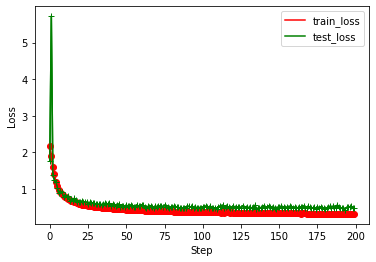

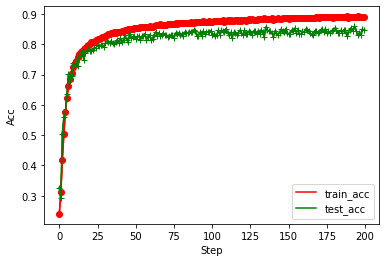

In [45]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [46]:
LOG_PATH="./train19.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn19.pth"
    
model = models.vgg19()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 200
print("Model: VGG-19")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: VGG-19
Batch size: 128
Epoch num: 200
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:50,  7.72it/s]

Finish 1 epoch, Train loss: 3.473001, Train acc@1: 0.099540


Test loss: 2.320191, Test acc@1: 0.100000
Saving Best model...			Top1 = 10.000000%
Elapsed time: 55.078184843063354
---------- Training Epoch #1 ----------


391it [00:48,  8.00it/s]

Finish 2 epoch, Train loss: 2.355143, Train acc@1: 0.100260


Test loss: 2.324291, Test acc@1: 0.100000
Elapsed time: 107.52055406570435
---------- Training Epoch #2 ----------


391it [00:46,  8.46it/s]

Finish 3 epoch, Train loss: 2.342671, Train acc@1: 0.099120


Test loss: 2.317738, Test acc@1: 0.100000
Elapsed time: 156.81561303138733
---------- Training Epoch #3 ----------


391it [00:42,  9.14it/s]

Finish 4 epoch, Train loss: 2.336030, Train acc@1: 0.099280


Test loss: 2.312891, Test acc@1: 0.100000
Elapsed time: 202.6561405658722
---------- Training Epoch #4 ----------


391it [00:42,  9.15it/s]

Finish 5 epoch, Train loss: 2.333731, Train acc@1: 0.099620


Test loss: 2.312768, Test acc@1: 0.100000
Elapsed time: 248.56234169006348
---------- Training Epoch #5 ----------


391it [00:42,  9.14it/s]

Finish 6 epoch, Train loss: 2.331042, Train acc@1: 0.099660


Test loss: 2.334567, Test acc@1: 0.100000
Elapsed time: 294.4592866897583
---------- Training Epoch #6 ----------


391it [00:42,  9.14it/s]

Finish 7 epoch, Train loss: 2.328154, Train acc@1: 0.101860


Test loss: 2.314628, Test acc@1: 0.100000
Elapsed time: 340.3485085964203
---------- Training Epoch #7 ----------


391it [00:42,  9.14it/s]

Finish 8 epoch, Train loss: 2.328873, Train acc@1: 0.099180


Test loss: 2.312734, Test acc@1: 0.100000
Elapsed time: 386.3045735359192
---------- Training Epoch #8 ----------


391it [00:47,  8.29it/s]

Finish 9 epoch, Train loss: 2.326513, Train acc@1: 0.100020


Test loss: 2.315473, Test acc@1: 0.100000
Elapsed time: 436.5869355201721
---------- Training Epoch #9 ----------


391it [00:48,  8.14it/s]

Finish 10 epoch, Train loss: 2.327134, Train acc@1: 0.100900


Test loss: 2.316940, Test acc@1: 0.100000
Elapsed time: 488.3620984554291
---------- Training Epoch #10 ----------


391it [00:45,  8.65it/s]

Finish 11 epoch, Train loss: 2.323420, Train acc@1: 0.099480


Test loss: 2.315463, Test acc@1: 0.100000
Elapsed time: 536.7115092277527
---------- Training Epoch #11 ----------


391it [00:42,  9.14it/s]

Finish 12 epoch, Train loss: 2.323647, Train acc@1: 0.100280


Test loss: 2.313764, Test acc@1: 0.100000
Elapsed time: 582.5945873260498
---------- Training Epoch #12 ----------


391it [00:42,  9.14it/s]

Finish 13 epoch, Train loss: 2.323426, Train acc@1: 0.099480


Test loss: 2.310932, Test acc@1: 0.100000
Elapsed time: 628.516523361206
---------- Training Epoch #13 ----------


391it [00:42,  9.15it/s]

Finish 14 epoch, Train loss: 2.322009, Train acc@1: 0.102580


Test loss: 2.310614, Test acc@1: 0.100000
Elapsed time: 674.380035161972
---------- Training Epoch #14 ----------


391it [00:42,  9.16it/s]

Finish 15 epoch, Train loss: 2.321653, Train acc@1: 0.100380


Test loss: 2.317211, Test acc@1: 0.100000
Elapsed time: 720.1187422275543
---------- Training Epoch #15 ----------


391it [00:47,  8.29it/s]

Finish 16 epoch, Train loss: 2.321561, Train acc@1: 0.099780


Test loss: 2.313799, Test acc@1: 0.100000
Elapsed time: 771.5994670391083
---------- Training Epoch #16 ----------


391it [00:45,  8.60it/s]

Finish 17 epoch, Train loss: 2.321596, Train acc@1: 0.097640


Test loss: 2.309745, Test acc@1: 0.100000
Elapsed time: 820.222588300705
---------- Training Epoch #17 ----------


391it [00:42,  9.13it/s]

Finish 18 epoch, Train loss: 2.320603, Train acc@1: 0.100680


Test loss: 2.310930, Test acc@1: 0.100000
Elapsed time: 866.6016454696655
---------- Training Epoch #18 ----------


391it [00:44,  8.79it/s]

Finish 19 epoch, Train loss: 2.321267, Train acc@1: 0.098800


Test loss: 2.306774, Test acc@1: 0.100000
Elapsed time: 914.2332227230072
---------- Training Epoch #19 ----------


391it [00:48,  8.02it/s]

Finish 20 epoch, Train loss: 2.319438, Train acc@1: 0.097920


Test loss: 2.317606, Test acc@1: 0.100000
Elapsed time: 966.1277189254761
---------- Training Epoch #20 ----------


391it [00:47,  8.30it/s]

Finish 21 epoch, Train loss: 2.319961, Train acc@1: 0.100820


Test loss: 2.313355, Test acc@1: 0.100000
Elapsed time: 1017.2832071781158
---------- Training Epoch #21 ----------


391it [00:45,  8.62it/s]

Finish 22 epoch, Train loss: 2.319508, Train acc@1: 0.099600


Test loss: 2.311817, Test acc@1: 0.100000
Elapsed time: 1065.8729267120361
---------- Training Epoch #22 ----------


391it [00:46,  8.38it/s]

Finish 23 epoch, Train loss: 2.319094, Train acc@1: 0.097320


Test loss: 2.314664, Test acc@1: 0.100000
Elapsed time: 1116.5682327747345
---------- Training Epoch #23 ----------


391it [00:45,  8.52it/s]

Finish 24 epoch, Train loss: 2.319206, Train acc@1: 0.100540


Test loss: 2.315892, Test acc@1: 0.100000
Elapsed time: 1165.5531959533691
---------- Training Epoch #24 ----------


391it [00:46,  8.35it/s]

Finish 25 epoch, Train loss: 2.318467, Train acc@1: 0.101180


Test loss: 2.315115, Test acc@1: 0.100000
Elapsed time: 1216.440015554428
---------- Training Epoch #25 ----------


391it [00:45,  8.63it/s]

Finish 26 epoch, Train loss: 2.319213, Train acc@1: 0.098880


Test loss: 2.314623, Test acc@1: 0.100000
Elapsed time: 1264.8726029396057
---------- Training Epoch #26 ----------


391it [00:46,  8.37it/s]

Finish 27 epoch, Train loss: 2.317184, Train acc@1: 0.103140


Test loss: 2.308933, Test acc@1: 0.100000
Elapsed time: 1315.6757626533508
---------- Training Epoch #27 ----------


391it [00:45,  8.50it/s]

Finish 28 epoch, Train loss: 2.318560, Train acc@1: 0.100260


Test loss: 2.313131, Test acc@1: 0.100000
Elapsed time: 1364.7124285697937
---------- Training Epoch #28 ----------


391it [00:42,  9.14it/s]

Finish 29 epoch, Train loss: 2.317751, Train acc@1: 0.100020


Test loss: 2.315231, Test acc@1: 0.100000
Elapsed time: 1410.5531179904938
---------- Training Epoch #29 ----------


391it [00:42,  9.14it/s]

Finish 30 epoch, Train loss: 2.318736, Train acc@1: 0.099360


Test loss: 2.315141, Test acc@1: 0.100000
Elapsed time: 1456.963891506195
---------- Training Epoch #30 ----------


391it [00:45,  8.68it/s]

Finish 31 epoch, Train loss: 2.316445, Train acc@1: 0.101680


Test loss: 2.311156, Test acc@1: 0.100000
Elapsed time: 1505.1290473937988
---------- Training Epoch #31 ----------


391it [00:42,  9.14it/s]

Finish 32 epoch, Train loss: 2.317429, Train acc@1: 0.099560


Test loss: 2.315178, Test acc@1: 0.100000
Elapsed time: 1550.9688408374786
---------- Training Epoch #32 ----------


391it [00:46,  8.49it/s]

Finish 33 epoch, Train loss: 2.317165, Train acc@1: 0.097440


Test loss: 2.316884, Test acc@1: 0.100000
Elapsed time: 1600.192579984665
---------- Training Epoch #33 ----------


391it [00:42,  9.15it/s]

Finish 34 epoch, Train loss: 2.317351, Train acc@1: 0.100440


Test loss: 2.313169, Test acc@1: 0.100000
Elapsed time: 1646.032683134079
---------- Training Epoch #34 ----------


391it [00:42,  9.16it/s]

Finish 35 epoch, Train loss: 2.317623, Train acc@1: 0.101440


Test loss: 2.310326, Test acc@1: 0.100000
Elapsed time: 1691.8124544620514
---------- Training Epoch #35 ----------


391it [00:42,  9.15it/s]

Finish 36 epoch, Train loss: 2.316162, Train acc@1: 0.097480


Test loss: 2.317583, Test acc@1: 0.100000
Elapsed time: 1737.6260278224945
---------- Training Epoch #36 ----------


391it [00:45,  8.51it/s]

Finish 37 epoch, Train loss: 2.317972, Train acc@1: 0.099600


Test loss: 2.313022, Test acc@1: 0.100000
Elapsed time: 1786.6895174980164
---------- Training Epoch #37 ----------


391it [00:42,  9.14it/s]

Finish 38 epoch, Train loss: 2.316405, Train acc@1: 0.099520


Test loss: 2.311728, Test acc@1: 0.100000
Elapsed time: 1832.5831725597382
---------- Training Epoch #38 ----------


391it [00:42,  9.15it/s]

Finish 39 epoch, Train loss: 2.316698, Train acc@1: 0.099840


Test loss: 2.306718, Test acc@1: 0.100000
Elapsed time: 1878.5318739414215
---------- Training Epoch #39 ----------


391it [00:45,  8.68it/s]

Finish 40 epoch, Train loss: 2.316777, Train acc@1: 0.098600


Test loss: 2.313796, Test acc@1: 0.100000
Elapsed time: 1927.6787738800049
---------- Training Epoch #40 ----------


391it [00:45,  8.59it/s]

Finish 41 epoch, Train loss: 2.316120, Train acc@1: 0.101000


Test loss: 2.318020, Test acc@1: 0.100000
Elapsed time: 1976.3239624500275
---------- Training Epoch #41 ----------


391it [00:46,  8.45it/s]

Finish 42 epoch, Train loss: 2.317057, Train acc@1: 0.101400


Test loss: 2.311606, Test acc@1: 0.100000
Elapsed time: 2025.6924784183502
---------- Training Epoch #42 ----------


391it [00:44,  8.85it/s]

Finish 43 epoch, Train loss: 2.317055, Train acc@1: 0.100000


Test loss: 2.313054, Test acc@1: 0.100000
Elapsed time: 2072.9324049949646
---------- Training Epoch #43 ----------


391it [00:42,  9.14it/s]

Finish 44 epoch, Train loss: 2.316698, Train acc@1: 0.098480


Test loss: 2.310477, Test acc@1: 0.100000
Elapsed time: 2118.8560559749603
---------- Training Epoch #44 ----------


391it [00:42,  9.13it/s]

Finish 45 epoch, Train loss: 2.316699, Train acc@1: 0.101720


Test loss: 2.310592, Test acc@1: 0.100000
Elapsed time: 2164.835588693619
---------- Training Epoch #45 ----------


391it [00:45,  8.56it/s]

Finish 46 epoch, Train loss: 2.317253, Train acc@1: 0.097340


Test loss: 2.308995, Test acc@1: 0.100000
Elapsed time: 2213.6155908107758
---------- Training Epoch #46 ----------


391it [00:42,  9.15it/s]

Finish 47 epoch, Train loss: 2.315946, Train acc@1: 0.100120


Test loss: 2.319496, Test acc@1: 0.100000
Elapsed time: 2259.517323732376
---------- Training Epoch #47 ----------


391it [00:42,  9.14it/s]

Finish 48 epoch, Train loss: 2.316492, Train acc@1: 0.100540


Test loss: 2.309154, Test acc@1: 0.100000
Elapsed time: 2305.426034927368
---------- Training Epoch #48 ----------


391it [00:44,  8.87it/s]

Finish 49 epoch, Train loss: 2.316727, Train acc@1: 0.099100


Test loss: 2.308076, Test acc@1: 0.100000
Elapsed time: 2352.5798065662384
---------- Training Epoch #49 ----------


391it [00:44,  8.83it/s]

Finish 50 epoch, Train loss: 2.316298, Train acc@1: 0.097880


Test loss: 2.309680, Test acc@1: 0.100000
Elapsed time: 2400.05468082428
---------- Training Epoch #50 ----------


391it [00:42,  9.14it/s]

Finish 51 epoch, Train loss: 2.316013, Train acc@1: 0.100560


Test loss: 2.308765, Test acc@1: 0.100000
Elapsed time: 2445.990570783615
---------- Training Epoch #51 ----------


391it [00:42,  9.14it/s]

Finish 52 epoch, Train loss: 2.316479, Train acc@1: 0.099940


Test loss: 2.310292, Test acc@1: 0.100000
Elapsed time: 2491.891753435135
---------- Training Epoch #52 ----------


391it [00:45,  8.55it/s]

Finish 53 epoch, Train loss: 2.315226, Train acc@1: 0.098420


Test loss: 2.309619, Test acc@1: 0.100000
Elapsed time: 2541.3003146648407
---------- Training Epoch #53 ----------


391it [00:42,  9.15it/s]

Finish 54 epoch, Train loss: 2.315418, Train acc@1: 0.102360


Test loss: 2.312322, Test acc@1: 0.100000
Elapsed time: 2587.145688533783
---------- Training Epoch #54 ----------


391it [00:46,  8.48it/s]

Finish 55 epoch, Train loss: 2.316413, Train acc@1: 0.099420


Test loss: 2.308986, Test acc@1: 0.100000
Elapsed time: 2636.871089220047
---------- Training Epoch #55 ----------


391it [00:42,  9.13it/s]

Finish 56 epoch, Train loss: 2.315260, Train acc@1: 0.102740


Test loss: 2.319108, Test acc@1: 0.100000
Elapsed time: 2683.507392883301
---------- Training Epoch #56 ----------


391it [00:44,  8.78it/s]

Finish 57 epoch, Train loss: 2.315813, Train acc@1: 0.098680


Test loss: 2.309129, Test acc@1: 0.100000
Elapsed time: 2731.1556146144867
---------- Training Epoch #57 ----------


391it [00:45,  8.59it/s]

Finish 58 epoch, Train loss: 2.316194, Train acc@1: 0.098440


Test loss: 2.309886, Test acc@1: 0.100000
Elapsed time: 2779.850133419037
---------- Training Epoch #58 ----------


391it [00:44,  8.85it/s]

Finish 59 epoch, Train loss: 2.315822, Train acc@1: 0.102320


Test loss: 2.308720, Test acc@1: 0.100000
Elapsed time: 2827.111985206604
---------- Training Epoch #59 ----------


391it [00:42,  9.14it/s]

Finish 60 epoch, Train loss: 2.316839, Train acc@1: 0.096980


Test loss: 2.309244, Test acc@1: 0.100000
Elapsed time: 2873.01545381546
---------- Training Epoch #60 ----------


391it [00:42,  9.15it/s]

Finish 61 epoch, Train loss: 2.315696, Train acc@1: 0.099380


Test loss: 2.317846, Test acc@1: 0.100000
Elapsed time: 2918.8934795856476
---------- Training Epoch #61 ----------


391it [00:47,  8.31it/s]

Finish 62 epoch, Train loss: 2.316308, Train acc@1: 0.097480


Test loss: 2.312493, Test acc@1: 0.100000
Elapsed time: 2970.0356962680817
---------- Training Epoch #62 ----------


391it [00:43,  8.90it/s]

Finish 63 epoch, Train loss: 2.315361, Train acc@1: 0.099160


Test loss: 2.320752, Test acc@1: 0.100000
Elapsed time: 3017.9571375846863
---------- Training Epoch #63 ----------


391it [00:42,  9.15it/s]

Finish 64 epoch, Train loss: 2.315353, Train acc@1: 0.098980


Test loss: 2.308781, Test acc@1: 0.100000
Elapsed time: 3063.9009354114532
---------- Training Epoch #64 ----------


391it [00:45,  8.54it/s]

Finish 65 epoch, Train loss: 2.315281, Train acc@1: 0.099880


Test loss: 2.308632, Test acc@1: 0.100000
Elapsed time: 3112.801300764084
---------- Training Epoch #65 ----------


391it [00:45,  8.53it/s]

Finish 66 epoch, Train loss: 2.315177, Train acc@1: 0.098840


Test loss: 2.307630, Test acc@1: 0.100000
Elapsed time: 3161.778910636902
---------- Training Epoch #66 ----------


391it [00:44,  8.82it/s]

Finish 67 epoch, Train loss: 2.316030, Train acc@1: 0.100600


Test loss: 2.309133, Test acc@1: 0.100000
Elapsed time: 3209.2573611736298
---------- Training Epoch #67 ----------


391it [00:42,  9.14it/s]

Finish 68 epoch, Train loss: 2.316083, Train acc@1: 0.098060


Test loss: 2.311209, Test acc@1: 0.100000
Elapsed time: 3255.0979838371277
---------- Training Epoch #68 ----------


391it [00:42,  9.14it/s]

Finish 69 epoch, Train loss: 2.315204, Train acc@1: 0.099900


Test loss: 2.311786, Test acc@1: 0.100000
Elapsed time: 3301.0107686519623
---------- Training Epoch #69 ----------


391it [00:42,  9.13it/s]

Finish 70 epoch, Train loss: 2.315258, Train acc@1: 0.100160


Test loss: 2.307244, Test acc@1: 0.100000
Elapsed time: 3346.9428009986877
---------- Training Epoch #70 ----------


391it [00:47,  8.29it/s]

Finish 71 epoch, Train loss: 2.315787, Train acc@1: 0.098160


Test loss: 2.310969, Test acc@1: 0.100000
Elapsed time: 3397.1860916614532
---------- Training Epoch #71 ----------


391it [00:42,  9.15it/s]

Finish 72 epoch, Train loss: 2.315965, Train acc@1: 0.097940


Test loss: 2.307752, Test acc@1: 0.100000
Elapsed time: 3443.0376393795013
---------- Training Epoch #72 ----------


391it [00:42,  9.14it/s]

Finish 73 epoch, Train loss: 2.314485, Train acc@1: 0.101620


Test loss: 2.308766, Test acc@1: 0.100000
Elapsed time: 3489.385048866272
---------- Training Epoch #73 ----------


391it [00:44,  8.82it/s]

Finish 74 epoch, Train loss: 2.314649, Train acc@1: 0.100500


Test loss: 2.316114, Test acc@1: 0.100000
Elapsed time: 3536.8321990966797
---------- Training Epoch #74 ----------


391it [00:42,  9.14it/s]

Finish 75 epoch, Train loss: 2.315324, Train acc@1: 0.103780


Test loss: 2.315404, Test acc@1: 0.100000
Elapsed time: 3582.6492688655853
---------- Training Epoch #75 ----------


391it [00:45,  8.51it/s]

Finish 76 epoch, Train loss: 2.316316, Train acc@1: 0.097400


Test loss: 2.309303, Test acc@1: 0.100000
Elapsed time: 3632.3896973133087
---------- Training Epoch #76 ----------


391it [00:45,  8.52it/s]

Finish 77 epoch, Train loss: 2.315716, Train acc@1: 0.097720


Test loss: 2.307532, Test acc@1: 0.100000
Elapsed time: 3681.389487504959
---------- Training Epoch #77 ----------


391it [00:45,  8.53it/s]

Finish 78 epoch, Train loss: 2.316115, Train acc@1: 0.098700


Test loss: 2.310368, Test acc@1: 0.100000
Elapsed time: 3730.323703289032
---------- Training Epoch #78 ----------


391it [00:44,  8.88it/s]

Finish 79 epoch, Train loss: 2.315122, Train acc@1: 0.098340


Test loss: 2.308734, Test acc@1: 0.100000
Elapsed time: 3777.447058200836
---------- Training Epoch #79 ----------


391it [00:47,  8.15it/s]

Finish 80 epoch, Train loss: 2.314873, Train acc@1: 0.101240


Test loss: 2.309421, Test acc@1: 0.100000
Elapsed time: 3828.5512042045593
---------- Training Epoch #80 ----------


391it [00:44,  8.81it/s]

Finish 81 epoch, Train loss: 2.315189, Train acc@1: 0.099880


Test loss: 2.313412, Test acc@1: 0.100000
Elapsed time: 3877.1515254974365
---------- Training Epoch #81 ----------


391it [00:44,  8.80it/s]

Finish 82 epoch, Train loss: 2.315481, Train acc@1: 0.099100


Test loss: 2.310740, Test acc@1: 0.100000
Elapsed time: 3924.717017173767
---------- Training Epoch #82 ----------


391it [00:42,  9.16it/s]

Finish 83 epoch, Train loss: 2.314940, Train acc@1: 0.101080


Test loss: 2.309666, Test acc@1: 0.100000
Elapsed time: 3971.120202064514
---------- Training Epoch #83 ----------


391it [00:44,  8.78it/s]

Finish 84 epoch, Train loss: 2.315505, Train acc@1: 0.099840


Test loss: 2.308908, Test acc@1: 0.100000
Elapsed time: 4018.8113033771515
---------- Training Epoch #84 ----------


391it [00:42,  9.16it/s]

Finish 85 epoch, Train loss: 2.315634, Train acc@1: 0.096020


Test loss: 2.310668, Test acc@1: 0.100000
Elapsed time: 4064.5943701267242
---------- Training Epoch #85 ----------


391it [00:42,  9.16it/s]

Finish 86 epoch, Train loss: 2.314937, Train acc@1: 0.101000


Test loss: 2.306270, Test acc@1: 0.100000
Elapsed time: 4110.850214481354
---------- Training Epoch #86 ----------


391it [00:44,  8.77it/s]

Finish 87 epoch, Train loss: 2.315823, Train acc@1: 0.097180


Test loss: 2.307437, Test acc@1: 0.100000
Elapsed time: 4158.540147066116
---------- Training Epoch #87 ----------


391it [00:42,  9.15it/s]

Finish 88 epoch, Train loss: 2.315181, Train acc@1: 0.097460


Test loss: 2.309540, Test acc@1: 0.100000
Elapsed time: 4204.363322734833
---------- Training Epoch #88 ----------


391it [00:45,  8.61it/s]

Finish 89 epoch, Train loss: 2.314520, Train acc@1: 0.100140


Test loss: 2.312861, Test acc@1: 0.100000
Elapsed time: 4253.9060089588165
---------- Training Epoch #89 ----------


391it [00:44,  8.82it/s]

Finish 90 epoch, Train loss: 2.315159, Train acc@1: 0.099540


Test loss: 2.310002, Test acc@1: 0.100000
Elapsed time: 4301.407592535019
---------- Training Epoch #90 ----------


391it [00:43,  8.92it/s]

Finish 91 epoch, Train loss: 2.315247, Train acc@1: 0.100740


Test loss: 2.316343, Test acc@1: 0.100000
Elapsed time: 4348.328829050064
---------- Training Epoch #91 ----------


391it [00:45,  8.67it/s]

Finish 92 epoch, Train loss: 2.315432, Train acc@1: 0.098840


Test loss: 2.307810, Test acc@1: 0.100000
Elapsed time: 4396.58725643158
---------- Training Epoch #92 ----------


391it [00:42,  9.14it/s]

Finish 93 epoch, Train loss: 2.315983, Train acc@1: 0.099480


Test loss: 2.308083, Test acc@1: 0.100000
Elapsed time: 4442.392921209335
---------- Training Epoch #93 ----------


391it [00:42,  9.14it/s]

Finish 94 epoch, Train loss: 2.315184, Train acc@1: 0.098900


Test loss: 2.314345, Test acc@1: 0.100000
Elapsed time: 4488.231390237808
---------- Training Epoch #94 ----------


391it [00:42,  9.14it/s]

Finish 95 epoch, Train loss: 2.315794, Train acc@1: 0.097500


Test loss: 2.308881, Test acc@1: 0.100000
Elapsed time: 4534.136704206467
---------- Training Epoch #95 ----------


391it [00:46,  8.35it/s]

Finish 96 epoch, Train loss: 2.314800, Train acc@1: 0.098060


Test loss: 2.306939, Test acc@1: 0.100000
Elapsed time: 4584.482263088226
---------- Training Epoch #96 ----------


391it [00:44,  8.85it/s]

Finish 97 epoch, Train loss: 2.314445, Train acc@1: 0.101980


Test loss: 2.308863, Test acc@1: 0.100000
Elapsed time: 4631.733044624329
---------- Training Epoch #97 ----------


391it [00:46,  8.36it/s]

Finish 98 epoch, Train loss: 2.314890, Train acc@1: 0.101260


Test loss: 2.311968, Test acc@1: 0.100000
Elapsed time: 4682.626179933548
---------- Training Epoch #98 ----------


391it [00:45,  8.62it/s]

Finish 99 epoch, Train loss: 2.315557, Train acc@1: 0.101380


Test loss: 2.311132, Test acc@1: 0.100000
Elapsed time: 4731.046780586243
---------- Training Epoch #99 ----------


391it [00:47,  8.17it/s]

Finish 100 epoch, Train loss: 2.313835, Train acc@1: 0.101600


Test loss: 2.308406, Test acc@1: 0.100000
Elapsed time: 4782.45836186409
---------- Training Epoch #100 ----------


391it [00:45,  8.58it/s]

Finish 101 epoch, Train loss: 2.314911, Train acc@1: 0.099600


Test loss: 2.308797, Test acc@1: 0.100000
Elapsed time: 4831.104686498642
---------- Training Epoch #101 ----------


391it [00:46,  8.34it/s]

Finish 102 epoch, Train loss: 2.314820, Train acc@1: 0.100500


Test loss: 2.308217, Test acc@1: 0.100000
Elapsed time: 4881.006274938583
---------- Training Epoch #102 ----------


391it [00:44,  8.88it/s]

Finish 103 epoch, Train loss: 2.314677, Train acc@1: 0.100700


Test loss: 2.308984, Test acc@1: 0.100000
Elapsed time: 4928.080561637878
---------- Training Epoch #103 ----------


391it [00:42,  9.14it/s]

Finish 104 epoch, Train loss: 2.314890, Train acc@1: 0.098300


Test loss: 2.307340, Test acc@1: 0.100000
Elapsed time: 4973.879499912262
---------- Training Epoch #104 ----------


391it [00:42,  9.14it/s]

Finish 105 epoch, Train loss: 2.314636, Train acc@1: 0.101780


Test loss: 2.313201, Test acc@1: 0.100000
Elapsed time: 5020.235522031784
---------- Training Epoch #105 ----------


391it [00:44,  8.80it/s]

Finish 106 epoch, Train loss: 2.314786, Train acc@1: 0.100640


Test loss: 2.313516, Test acc@1: 0.100000
Elapsed time: 5067.784034013748
---------- Training Epoch #106 ----------


391it [00:46,  8.48it/s]

Finish 107 epoch, Train loss: 2.314180, Train acc@1: 0.099640


Test loss: 2.306885, Test acc@1: 0.100000
Elapsed time: 5117.037510633469
---------- Training Epoch #107 ----------


391it [00:44,  8.85it/s]

Finish 108 epoch, Train loss: 2.314102, Train acc@1: 0.100740


Test loss: 2.309022, Test acc@1: 0.100000
Elapsed time: 5164.238183498383
---------- Training Epoch #108 ----------


391it [00:42,  9.15it/s]

Finish 109 epoch, Train loss: 2.314384, Train acc@1: 0.099520


Test loss: 2.312459, Test acc@1: 0.100000
Elapsed time: 5210.544090270996
---------- Training Epoch #109 ----------


391it [00:44,  8.84it/s]

Finish 110 epoch, Train loss: 2.315517, Train acc@1: 0.099440


Test loss: 2.307825, Test acc@1: 0.100000
Elapsed time: 5257.874462366104
---------- Training Epoch #110 ----------


391it [00:45,  8.58it/s]

Finish 111 epoch, Train loss: 2.313196, Train acc@1: 0.102560


Test loss: 2.311161, Test acc@1: 0.100000
Elapsed time: 5306.539420843124
---------- Training Epoch #111 ----------


391it [00:44,  8.85it/s]

Finish 112 epoch, Train loss: 2.313983, Train acc@1: 0.098500


Test loss: 2.306736, Test acc@1: 0.100000
Elapsed time: 5353.825125694275
---------- Training Epoch #112 ----------


391it [00:42,  9.15it/s]

Finish 113 epoch, Train loss: 2.314915, Train acc@1: 0.099900


Test loss: 2.307973, Test acc@1: 0.100000
Elapsed time: 5399.670289993286
---------- Training Epoch #113 ----------


391it [00:42,  9.14it/s]

Finish 114 epoch, Train loss: 2.314036, Train acc@1: 0.101300


Test loss: 2.307423, Test acc@1: 0.100000
Elapsed time: 5445.524005413055
---------- Training Epoch #114 ----------


391it [00:45,  8.59it/s]

Finish 115 epoch, Train loss: 2.314362, Train acc@1: 0.101240


Test loss: 2.306515, Test acc@1: 0.100000
Elapsed time: 5494.165093660355
---------- Training Epoch #115 ----------


391it [00:42,  9.15it/s]

Finish 116 epoch, Train loss: 2.314691, Train acc@1: 0.098240


Test loss: 2.306100, Test acc@1: 0.100000
Elapsed time: 5540.035009622574
---------- Training Epoch #116 ----------


391it [00:42,  9.16it/s]

Finish 117 epoch, Train loss: 2.314613, Train acc@1: 0.099520


Test loss: 2.309117, Test acc@1: 0.100000
Elapsed time: 5585.885273218155
---------- Training Epoch #117 ----------


391it [00:42,  9.15it/s]

Finish 118 epoch, Train loss: 2.313969, Train acc@1: 0.102660


Test loss: 2.312621, Test acc@1: 0.100000
Elapsed time: 5632.207534790039
---------- Training Epoch #118 ----------


391it [00:44,  8.85it/s]

Finish 119 epoch, Train loss: 2.313670, Train acc@1: 0.100100


Test loss: 2.306159, Test acc@1: 0.100000
Elapsed time: 5679.497770309448
---------- Training Epoch #119 ----------


391it [00:45,  8.55it/s]

Finish 120 epoch, Train loss: 2.314782, Train acc@1: 0.101200


Test loss: 2.310619, Test acc@1: 0.100000
Elapsed time: 5728.315291881561
---------- Training Epoch #120 ----------


391it [00:43,  8.97it/s]

Finish 121 epoch, Train loss: 2.314562, Train acc@1: 0.097900


Test loss: 2.307597, Test acc@1: 0.100000
Elapsed time: 5775.01331949234
---------- Training Epoch #121 ----------


391it [00:42,  9.15it/s]

Finish 122 epoch, Train loss: 2.314828, Train acc@1: 0.097000


Test loss: 2.307532, Test acc@1: 0.100000
Elapsed time: 5820.858666419983
---------- Training Epoch #122 ----------


391it [00:42,  9.16it/s]

Finish 123 epoch, Train loss: 2.314431, Train acc@1: 0.100580


Test loss: 2.307889, Test acc@1: 0.100000
Elapsed time: 5866.685730934143
---------- Training Epoch #123 ----------


391it [00:42,  9.16it/s]

Finish 124 epoch, Train loss: 2.313912, Train acc@1: 0.100720


Test loss: 2.308651, Test acc@1: 0.100000
Elapsed time: 5912.495821475983
---------- Training Epoch #124 ----------


391it [00:47,  8.21it/s]

Finish 125 epoch, Train loss: 2.314519, Train acc@1: 0.099380


Test loss: 2.307775, Test acc@1: 0.100000
Elapsed time: 5963.245923042297
---------- Training Epoch #125 ----------


391it [00:47,  8.15it/s]

Finish 126 epoch, Train loss: 2.314280, Train acc@1: 0.100960


Test loss: 2.306614, Test acc@1: 0.100000
Elapsed time: 6014.300025701523
---------- Training Epoch #126 ----------


391it [00:44,  8.85it/s]

Finish 127 epoch, Train loss: 2.314002, Train acc@1: 0.098480


Test loss: 2.310739, Test acc@1: 0.100000
Elapsed time: 6061.542262554169
---------- Training Epoch #127 ----------


391it [00:42,  9.15it/s]

Finish 128 epoch, Train loss: 2.313978, Train acc@1: 0.101200


Test loss: 2.308658, Test acc@1: 0.100000
Elapsed time: 6107.335753202438
---------- Training Epoch #128 ----------


391it [00:42,  9.15it/s]

Finish 129 epoch, Train loss: 2.314599, Train acc@1: 0.099040


Test loss: 2.309693, Test acc@1: 0.100000
Elapsed time: 6153.245248556137
---------- Training Epoch #129 ----------


391it [00:42,  9.15it/s]

Finish 130 epoch, Train loss: 2.314672, Train acc@1: 0.101560


Test loss: 2.306785, Test acc@1: 0.100000
Elapsed time: 6199.074292421341
---------- Training Epoch #130 ----------


391it [00:42,  9.15it/s]

Finish 131 epoch, Train loss: 2.314013, Train acc@1: 0.101640


Test loss: 2.315857, Test acc@1: 0.100000
Elapsed time: 6244.882555007935
---------- Training Epoch #131 ----------


391it [00:47,  8.31it/s]

Finish 132 epoch, Train loss: 2.315358, Train acc@1: 0.099780


Test loss: 2.310275, Test acc@1: 0.100000
Elapsed time: 6296.101322412491
---------- Training Epoch #132 ----------


391it [00:45,  8.56it/s]

Finish 133 epoch, Train loss: 2.314099, Train acc@1: 0.103140


Test loss: 2.309575, Test acc@1: 0.100000
Elapsed time: 6344.889966249466
---------- Training Epoch #133 ----------


391it [00:47,  8.29it/s]

Finish 134 epoch, Train loss: 2.313902, Train acc@1: 0.099400


Test loss: 2.307234, Test acc@1: 0.100000
Elapsed time: 6395.078428506851
---------- Training Epoch #134 ----------


391it [00:44,  8.85it/s]

Finish 135 epoch, Train loss: 2.314550, Train acc@1: 0.099960


Test loss: 2.310277, Test acc@1: 0.100000
Elapsed time: 6443.013114452362
---------- Training Epoch #135 ----------


391it [00:45,  8.56it/s]

Finish 136 epoch, Train loss: 2.314473, Train acc@1: 0.096800


Test loss: 2.307553, Test acc@1: 0.100000
Elapsed time: 6491.823213100433
---------- Training Epoch #136 ----------


391it [00:44,  8.75it/s]

Finish 137 epoch, Train loss: 2.314222, Train acc@1: 0.100540


Test loss: 2.309768, Test acc@1: 0.100000
Elapsed time: 6539.621987104416
---------- Training Epoch #137 ----------


391it [00:47,  8.23it/s]

Finish 138 epoch, Train loss: 2.314233, Train acc@1: 0.097960


Test loss: 2.309516, Test acc@1: 0.100000
Elapsed time: 6590.200092792511
---------- Training Epoch #138 ----------


391it [00:44,  8.84it/s]

Finish 139 epoch, Train loss: 2.313404, Train acc@1: 0.099200


Test loss: 2.308595, Test acc@1: 0.100000
Elapsed time: 6638.581505537033
---------- Training Epoch #139 ----------


391it [00:45,  8.68it/s]

Finish 140 epoch, Train loss: 2.314557, Train acc@1: 0.101040


Test loss: 2.308539, Test acc@1: 0.100000
Elapsed time: 6686.797173976898
---------- Training Epoch #140 ----------


391it [00:46,  8.36it/s]

Finish 141 epoch, Train loss: 2.313414, Train acc@1: 0.100900


Test loss: 2.307225, Test acc@1: 0.100000
Elapsed time: 6736.664319753647
---------- Training Epoch #141 ----------


391it [00:44,  8.81it/s]

Finish 142 epoch, Train loss: 2.313948, Train acc@1: 0.098300


Test loss: 2.307023, Test acc@1: 0.100000
Elapsed time: 6784.148304700851
---------- Training Epoch #142 ----------


391it [00:42,  9.13it/s]

Finish 143 epoch, Train loss: 2.313740, Train acc@1: 0.102820


Test loss: 2.307186, Test acc@1: 0.100000
Elapsed time: 6830.701435804367
---------- Training Epoch #143 ----------


391it [00:46,  8.47it/s]

Finish 144 epoch, Train loss: 2.314921, Train acc@1: 0.099060


Test loss: 2.312107, Test acc@1: 0.100000
Elapsed time: 6880.002848863602
---------- Training Epoch #144 ----------


391it [00:44,  8.79it/s]

Finish 145 epoch, Train loss: 2.314257, Train acc@1: 0.100560


Test loss: 2.310938, Test acc@1: 0.100000
Elapsed time: 6928.458162069321
---------- Training Epoch #145 ----------


391it [00:44,  8.84it/s]

Finish 146 epoch, Train loss: 2.313778, Train acc@1: 0.100280


Test loss: 2.306987, Test acc@1: 0.100000
Elapsed time: 6977.155220031738
---------- Training Epoch #146 ----------


391it [00:45,  8.55it/s]

Finish 147 epoch, Train loss: 2.314069, Train acc@1: 0.097900


Test loss: 2.309712, Test acc@1: 0.100000
Elapsed time: 7026.006185531616
---------- Training Epoch #147 ----------


391it [00:47,  8.22it/s]

Finish 148 epoch, Train loss: 2.314408, Train acc@1: 0.099300


Test loss: 2.310514, Test acc@1: 0.100000
Elapsed time: 7077.687934398651
---------- Training Epoch #148 ----------


391it [00:44,  8.69it/s]

Finish 149 epoch, Train loss: 2.314069, Train acc@1: 0.097620


Test loss: 2.305524, Test acc@1: 0.100000
Elapsed time: 7125.72585272789
---------- Training Epoch #149 ----------


391it [00:45,  8.61it/s]

Finish 150 epoch, Train loss: 2.313450, Train acc@1: 0.101920


Test loss: 2.313387, Test acc@1: 0.100000
Elapsed time: 7174.368127584457
---------- Training Epoch #150 ----------


391it [00:44,  8.85it/s]

Finish 151 epoch, Train loss: 2.313294, Train acc@1: 0.100580


Test loss: 2.313359, Test acc@1: 0.100000
Elapsed time: 7222.914274215698
---------- Training Epoch #151 ----------


391it [00:45,  8.55it/s]

Finish 152 epoch, Train loss: 2.315318, Train acc@1: 0.096100


Test loss: 2.310923, Test acc@1: 0.100000
Elapsed time: 7271.725366830826
---------- Training Epoch #152 ----------


391it [00:45,  8.60it/s]

Finish 153 epoch, Train loss: 2.314072, Train acc@1: 0.099520


Test loss: 2.309490, Test acc@1: 0.100000
Elapsed time: 7320.33651471138
---------- Training Epoch #153 ----------


391it [00:44,  8.76it/s]

Finish 154 epoch, Train loss: 2.314433, Train acc@1: 0.098120


Test loss: 2.307250, Test acc@1: 0.100000
Elapsed time: 7368.055743694305
---------- Training Epoch #154 ----------


391it [00:42,  9.15it/s]

Finish 155 epoch, Train loss: 2.314858, Train acc@1: 0.098740


Test loss: 2.306667, Test acc@1: 0.100000
Elapsed time: 7413.975539684296
---------- Training Epoch #155 ----------


391it [00:42,  9.14it/s]

Finish 156 epoch, Train loss: 2.313559, Train acc@1: 0.098880


Test loss: 2.307482, Test acc@1: 0.100000
Elapsed time: 7459.8489446640015
---------- Training Epoch #156 ----------


391it [00:42,  9.14it/s]

Finish 157 epoch, Train loss: 2.313466, Train acc@1: 0.099460


Test loss: 2.308244, Test acc@1: 0.100000
Elapsed time: 7505.697059392929
---------- Training Epoch #157 ----------


391it [00:42,  9.16it/s]

Finish 158 epoch, Train loss: 2.314252, Train acc@1: 0.097880


Test loss: 2.306818, Test acc@1: 0.100000
Elapsed time: 7551.474218606949
---------- Training Epoch #158 ----------


391it [00:42,  9.14it/s]

Finish 159 epoch, Train loss: 2.313539, Train acc@1: 0.100680


Test loss: 2.312154, Test acc@1: 0.100000
Elapsed time: 7597.432995557785
---------- Training Epoch #159 ----------


391it [00:45,  8.61it/s]

Finish 160 epoch, Train loss: 2.314376, Train acc@1: 0.096960


Test loss: 2.306000, Test acc@1: 0.100000
Elapsed time: 7645.939366102219
---------- Training Epoch #160 ----------


391it [00:44,  8.76it/s]

Finish 161 epoch, Train loss: 2.313064, Train acc@1: 0.101000


Test loss: 2.306031, Test acc@1: 0.100000
Elapsed time: 7693.6794147491455
---------- Training Epoch #161 ----------


391it [00:42,  9.15it/s]

Finish 162 epoch, Train loss: 2.314517, Train acc@1: 0.095600


Test loss: 2.308037, Test acc@1: 0.100000
Elapsed time: 7739.595906496048
---------- Training Epoch #162 ----------


391it [00:42,  9.14it/s]

Finish 163 epoch, Train loss: 2.313966, Train acc@1: 0.098800


Test loss: 2.306394, Test acc@1: 0.100000
Elapsed time: 7785.504873752594
---------- Training Epoch #163 ----------


391it [00:47,  8.27it/s]

Finish 164 epoch, Train loss: 2.314455, Train acc@1: 0.098640


Test loss: 2.307624, Test acc@1: 0.100000
Elapsed time: 7835.8497569561005
---------- Training Epoch #164 ----------


391it [00:44,  8.78it/s]

Finish 165 epoch, Train loss: 2.313556, Train acc@1: 0.097260


Test loss: 2.307036, Test acc@1: 0.100000
Elapsed time: 7883.456865310669
---------- Training Epoch #165 ----------


391it [00:42,  9.16it/s]

Finish 166 epoch, Train loss: 2.313977, Train acc@1: 0.100080


Test loss: 2.310275, Test acc@1: 0.100000
Elapsed time: 7929.79080581665
---------- Training Epoch #166 ----------


391it [00:45,  8.52it/s]

Finish 167 epoch, Train loss: 2.313453, Train acc@1: 0.101320


Test loss: 2.309637, Test acc@1: 0.100000
Elapsed time: 7978.901955127716
---------- Training Epoch #167 ----------


391it [00:42,  9.15it/s]

Finish 168 epoch, Train loss: 2.313911, Train acc@1: 0.099300


Test loss: 2.307997, Test acc@1: 0.100000
Elapsed time: 8024.747061252594
---------- Training Epoch #168 ----------


391it [00:45,  8.58it/s]

Finish 169 epoch, Train loss: 2.314308, Train acc@1: 0.101040


Test loss: 2.308629, Test acc@1: 0.100000
Elapsed time: 8073.421919107437
---------- Training Epoch #169 ----------


391it [00:42,  9.16it/s]

Finish 170 epoch, Train loss: 2.314144, Train acc@1: 0.099380


Test loss: 2.306784, Test acc@1: 0.100000
Elapsed time: 8120.154375076294
---------- Training Epoch #170 ----------


391it [00:45,  8.57it/s]

Finish 171 epoch, Train loss: 2.313575, Train acc@1: 0.098160


Test loss: 2.309935, Test acc@1: 0.100000
Elapsed time: 8168.942209482193
---------- Training Epoch #171 ----------


391it [00:45,  8.53it/s]

Finish 172 epoch, Train loss: 2.313949, Train acc@1: 0.101640


Test loss: 2.316852, Test acc@1: 0.100000
Elapsed time: 8217.848328113556
---------- Training Epoch #172 ----------


391it [00:44,  8.79it/s]

Finish 173 epoch, Train loss: 2.313598, Train acc@1: 0.101440


Test loss: 2.307916, Test acc@1: 0.100000
Elapsed time: 8265.433111667633
---------- Training Epoch #173 ----------


391it [00:42,  9.15it/s]

Finish 174 epoch, Train loss: 2.313892, Train acc@1: 0.100140


Test loss: 2.305801, Test acc@1: 0.100000
Elapsed time: 8311.267139673233
---------- Training Epoch #174 ----------


391it [00:42,  9.14it/s]

Finish 175 epoch, Train loss: 2.313810, Train acc@1: 0.099640


Test loss: 2.310551, Test acc@1: 0.100000
Elapsed time: 8357.109272003174
---------- Training Epoch #175 ----------


391it [00:42,  9.16it/s]

Finish 176 epoch, Train loss: 2.313864, Train acc@1: 0.100440


Test loss: 2.315428, Test acc@1: 0.100000
Elapsed time: 8402.985764026642
---------- Training Epoch #176 ----------


391it [00:47,  8.27it/s]

Finish 177 epoch, Train loss: 2.313935, Train acc@1: 0.098040


Test loss: 2.307888, Test acc@1: 0.100000
Elapsed time: 8453.326607942581
---------- Training Epoch #177 ----------


391it [00:46,  8.44it/s]

Finish 178 epoch, Train loss: 2.313611, Train acc@1: 0.099940


Test loss: 2.313194, Test acc@1: 0.100000
Elapsed time: 8502.760152101517
---------- Training Epoch #178 ----------


391it [00:47,  8.19it/s]

Finish 179 epoch, Train loss: 2.313227, Train acc@1: 0.102500


Test loss: 2.308547, Test acc@1: 0.100000
Elapsed time: 8553.607104301453
---------- Training Epoch #179 ----------


391it [00:43,  8.92it/s]

Finish 180 epoch, Train loss: 2.313732, Train acc@1: 0.099780


Test loss: 2.309802, Test acc@1: 0.100000
Elapsed time: 8601.199908971786
---------- Training Epoch #180 ----------


391it [00:45,  8.59it/s]

Finish 181 epoch, Train loss: 2.313313, Train acc@1: 0.101160


Test loss: 2.311048, Test acc@1: 0.100000
Elapsed time: 8649.822352409363
---------- Training Epoch #181 ----------


391it [00:44,  8.77it/s]

Finish 182 epoch, Train loss: 2.314350, Train acc@1: 0.097700


Test loss: 2.307146, Test acc@1: 0.100000
Elapsed time: 8697.45982837677
---------- Training Epoch #182 ----------


391it [00:44,  8.86it/s]

Finish 183 epoch, Train loss: 2.313646, Train acc@1: 0.102500


Test loss: 2.307437, Test acc@1: 0.100000
Elapsed time: 8744.74575972557
---------- Training Epoch #183 ----------


391it [00:42,  9.15it/s]

Finish 184 epoch, Train loss: 2.313875, Train acc@1: 0.097300


Test loss: 2.305486, Test acc@1: 0.100000
Elapsed time: 8790.569693565369
---------- Training Epoch #184 ----------


391it [00:42,  9.15it/s]

Finish 185 epoch, Train loss: 2.313008, Train acc@1: 0.102280


Test loss: 2.307266, Test acc@1: 0.100000
Elapsed time: 8837.258949041367
---------- Training Epoch #185 ----------


391it [00:44,  8.82it/s]

Finish 186 epoch, Train loss: 2.313449, Train acc@1: 0.102700


Test loss: 2.308578, Test acc@1: 0.100000
Elapsed time: 8884.730818510056
---------- Training Epoch #186 ----------


391it [00:44,  8.83it/s]

Finish 187 epoch, Train loss: 2.314194, Train acc@1: 0.100860


Test loss: 2.312580, Test acc@1: 0.100000
Elapsed time: 8932.084525585175
---------- Training Epoch #187 ----------


391it [00:45,  8.59it/s]

Finish 188 epoch, Train loss: 2.313347, Train acc@1: 0.100060


Test loss: 2.305131, Test acc@1: 0.100000
Elapsed time: 8981.172921657562
---------- Training Epoch #188 ----------


391it [00:42,  9.13it/s]

Finish 189 epoch, Train loss: 2.313327, Train acc@1: 0.103660


Test loss: 2.309505, Test acc@1: 0.100000
Elapsed time: 9027.006672620773
---------- Training Epoch #189 ----------


391it [00:42,  9.13it/s]

Finish 190 epoch, Train loss: 2.313773, Train acc@1: 0.099740


Test loss: 2.309455, Test acc@1: 0.100000
Elapsed time: 9072.889649868011
---------- Training Epoch #190 ----------


391it [00:42,  9.15it/s]

Finish 191 epoch, Train loss: 2.313129, Train acc@1: 0.098680


Test loss: 2.306576, Test acc@1: 0.100000
Elapsed time: 9118.746903657913
---------- Training Epoch #191 ----------


391it [00:42,  9.15it/s]

Finish 192 epoch, Train loss: 2.313341, Train acc@1: 0.103360


Test loss: 2.309964, Test acc@1: 0.100000
Elapsed time: 9164.531835079193
---------- Training Epoch #192 ----------


391it [00:46,  8.39it/s]

Finish 193 epoch, Train loss: 2.313569, Train acc@1: 0.099160


Test loss: 2.312683, Test acc@1: 0.100000
Elapsed time: 9214.280270576477
---------- Training Epoch #193 ----------


391it [00:45,  8.67it/s]

Finish 194 epoch, Train loss: 2.313462, Train acc@1: 0.101420


Test loss: 2.313207, Test acc@1: 0.100000
Elapsed time: 9262.408291816711
---------- Training Epoch #194 ----------


391it [00:44,  8.84it/s]

Finish 195 epoch, Train loss: 2.313210, Train acc@1: 0.099180


Test loss: 2.312202, Test acc@1: 0.100000
Elapsed time: 9309.719739675522
---------- Training Epoch #195 ----------


391it [00:42,  9.15it/s]

Finish 196 epoch, Train loss: 2.314006, Train acc@1: 0.101160


Test loss: 2.305667, Test acc@1: 0.100000
Elapsed time: 9355.544796228409
---------- Training Epoch #196 ----------


391it [00:42,  9.16it/s]

Finish 197 epoch, Train loss: 2.313252, Train acc@1: 0.098840


Test loss: 2.310297, Test acc@1: 0.100000
Elapsed time: 9401.374350309372
---------- Training Epoch #197 ----------


391it [00:42,  9.15it/s]

Finish 198 epoch, Train loss: 2.313407, Train acc@1: 0.099880


Test loss: 2.306687, Test acc@1: 0.100000
Elapsed time: 9447.627250909805
---------- Training Epoch #198 ----------


391it [00:45,  8.53it/s]

Finish 199 epoch, Train loss: 2.312859, Train acc@1: 0.099800


Test loss: 2.308231, Test acc@1: 0.100000
Elapsed time: 9496.592898130417
---------- Training Epoch #199 ----------


391it [00:42,  9.13it/s]

Finish 200 epoch, Train loss: 2.313207, Train acc@1: 0.100000


Test loss: 2.307512, Test acc@1: 0.100000
Elapsed time: 9542.529438495636

Test results: Acc@1 = 10.000000%


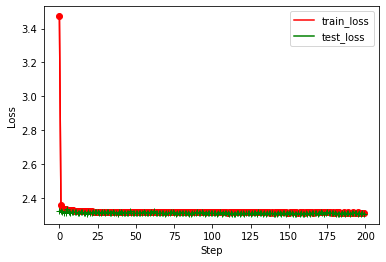

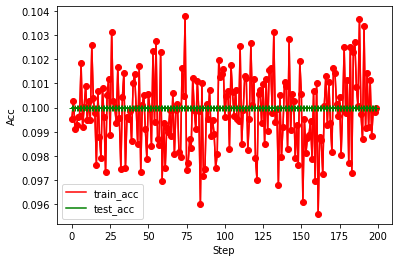

In [47]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [48]:
LOG_PATH="./train20.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn20.pth"
    
model = models.vgg19_bn()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 200
print("Model: VGG-19 with batch normalization")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: VGG-19 with batch normalization
Batch size: 128
Epoch num: 200
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:48,  8.02it/s]

Finish 1 epoch, Train loss: 3.324098, Train acc@1: 0.111540


Test loss: 2.219758, Test acc@1: 0.151400
Saving Best model...			Top1 = 15.140000%
Elapsed time: 53.2494421005249
---------- Training Epoch #1 ----------


391it [00:50,  7.70it/s]

Finish 2 epoch, Train loss: 2.272334, Train acc@1: 0.153320


Test loss: 2.108151, Test acc@1: 0.168900
Saving Best model...			Top1 = 16.890000%
Elapsed time: 110.28243112564087
---------- Training Epoch #2 ----------


391it [00:48,  8.09it/s]

Finish 3 epoch, Train loss: 2.146527, Train acc@1: 0.184920


Test loss: 1.935648, Test acc@1: 0.214800
Saving Best model...			Top1 = 21.480000%
Elapsed time: 164.72563862800598
---------- Training Epoch #3 ----------


391it [00:47,  8.26it/s]

Finish 4 epoch, Train loss: 2.134429, Train acc@1: 0.189200


Test loss: 2.037391, Test acc@1: 0.181300
Elapsed time: 215.32272148132324
---------- Training Epoch #4 ----------


391it [00:46,  8.50it/s]

Finish 5 epoch, Train loss: 2.015397, Train acc@1: 0.205600


Test loss: 1.873882, Test acc@1: 0.254900
Saving Best model...			Top1 = 25.490000%
Elapsed time: 267.0638358592987
---------- Training Epoch #5 ----------


391it [00:47,  8.22it/s]

Finish 6 epoch, Train loss: 1.965151, Train acc@1: 0.237280


Test loss: 1.793362, Test acc@1: 0.283200
Saving Best model...			Top1 = 28.320000%
Elapsed time: 320.26769495010376
---------- Training Epoch #6 ----------


391it [00:48,  8.00it/s]

Finish 7 epoch, Train loss: 1.851769, Train acc@1: 0.284640


Test loss: 1.676697, Test acc@1: 0.343900
Saving Best model...			Top1 = 34.390000%
Elapsed time: 374.8825089931488
---------- Training Epoch #7 ----------


391it [00:47,  8.26it/s]

Finish 8 epoch, Train loss: 1.695588, Train acc@1: 0.352200


Test loss: 1.769371, Test acc@1: 0.328600
Elapsed time: 425.4047842025757
---------- Training Epoch #8 ----------


391it [00:45,  8.55it/s]

Finish 9 epoch, Train loss: 1.528667, Train acc@1: 0.415480


Test loss: 1.386071, Test acc@1: 0.458800
Saving Best model...			Top1 = 45.880000%
Elapsed time: 476.8768627643585
---------- Training Epoch #9 ----------


391it [00:48,  8.09it/s]

Finish 10 epoch, Train loss: 1.353354, Train acc@1: 0.496060


Test loss: 1.255690, Test acc@1: 0.551000
Saving Best model...			Top1 = 55.100000%
Elapsed time: 530.8504371643066
---------- Training Epoch #10 ----------


391it [00:44,  8.73it/s]

Finish 11 epoch, Train loss: 1.195241, Train acc@1: 0.576260


Test loss: 1.272959, Test acc@1: 0.575200
Saving Best model...			Top1 = 57.520000%
Elapsed time: 581.269641160965
---------- Training Epoch #11 ----------


391it [00:44,  8.72it/s]

Finish 12 epoch, Train loss: 1.099827, Train acc@1: 0.614540


Test loss: 1.743451, Test acc@1: 0.498400
Elapsed time: 629.3689432144165
---------- Training Epoch #12 ----------


391it [00:45,  8.56it/s]

Finish 13 epoch, Train loss: 1.042470, Train acc@1: 0.639600


Test loss: 0.998563, Test acc@1: 0.652400
Saving Best model...			Top1 = 65.240000%
Elapsed time: 681.4080884456635
---------- Training Epoch #13 ----------


391it [00:48,  8.07it/s]

Finish 14 epoch, Train loss: 0.959248, Train acc@1: 0.678960


Test loss: 0.912730, Test acc@1: 0.699700
Saving Best model...			Top1 = 69.970000%
Elapsed time: 736.4875299930573
---------- Training Epoch #14 ----------


391it [00:47,  8.22it/s]

Finish 15 epoch, Train loss: 0.877336, Train acc@1: 0.715860


Test loss: 0.768980, Test acc@1: 0.752900
Saving Best model...			Top1 = 75.290000%
Elapsed time: 789.8139905929565
---------- Training Epoch #15 ----------


391it [00:49,  7.92it/s]

Finish 16 epoch, Train loss: 0.804232, Train acc@1: 0.743560


Test loss: 0.812233, Test acc@1: 0.730100
Elapsed time: 842.3690812587738
---------- Training Epoch #16 ----------


391it [00:48,  8.03it/s]

Finish 17 epoch, Train loss: 0.754488, Train acc@1: 0.762980


Test loss: 1.108643, Test acc@1: 0.686300
Elapsed time: 894.2738306522369
---------- Training Epoch #17 ----------


391it [00:45,  8.51it/s]

Finish 18 epoch, Train loss: 0.701841, Train acc@1: 0.781980


Test loss: 0.762855, Test acc@1: 0.766500
Saving Best model...			Top1 = 76.650000%
Elapsed time: 945.9830176830292
---------- Training Epoch #18 ----------


391it [00:47,  8.25it/s]

Finish 19 epoch, Train loss: 0.680356, Train acc@1: 0.791300


Test loss: 0.718209, Test acc@1: 0.779000
Saving Best model...			Top1 = 77.900000%
Elapsed time: 999.0699563026428
---------- Training Epoch #19 ----------


391it [00:48,  8.04it/s]

Finish 20 epoch, Train loss: 0.644585, Train acc@1: 0.802040


Test loss: 0.639479, Test acc@1: 0.805500
Saving Best model...			Top1 = 80.550000%
Elapsed time: 1053.445522069931
---------- Training Epoch #20 ----------


391it [00:46,  8.32it/s]

Finish 21 epoch, Train loss: 0.617914, Train acc@1: 0.810840


Test loss: 0.754075, Test acc@1: 0.783800
Elapsed time: 1103.7028305530548
---------- Training Epoch #21 ----------


391it [00:46,  8.49it/s]

Finish 22 epoch, Train loss: 0.587630, Train acc@1: 0.823200


Test loss: 0.630442, Test acc@1: 0.807400
Saving Best model...			Top1 = 80.740000%
Elapsed time: 1156.3918459415436
---------- Training Epoch #22 ----------


391it [00:49,  7.94it/s]

Finish 23 epoch, Train loss: 0.569059, Train acc@1: 0.826940


Test loss: 0.689831, Test acc@1: 0.795400
Elapsed time: 1208.785447359085
---------- Training Epoch #23 ----------


391it [00:44,  8.72it/s]

Finish 24 epoch, Train loss: 0.552192, Train acc@1: 0.833280


Test loss: 0.700642, Test acc@1: 0.798000
Elapsed time: 1256.840178012848
---------- Training Epoch #24 ----------


391it [00:45,  8.55it/s]

Finish 25 epoch, Train loss: 0.539357, Train acc@1: 0.836100


Test loss: 0.740317, Test acc@1: 0.773000
Elapsed time: 1305.7662193775177
---------- Training Epoch #25 ----------


391it [00:44,  8.75it/s]

Finish 26 epoch, Train loss: 0.517907, Train acc@1: 0.844680


Test loss: 0.582572, Test acc@1: 0.825400
Saving Best model...			Top1 = 82.540000%
Elapsed time: 1356.1017754077911
---------- Training Epoch #26 ----------


391it [00:47,  8.21it/s]

Finish 27 epoch, Train loss: 0.512634, Train acc@1: 0.846000


Test loss: 0.533095, Test acc@1: 0.835500
Saving Best model...			Top1 = 83.550000%
Elapsed time: 1409.4551515579224
---------- Training Epoch #27 ----------


391it [00:48,  8.02it/s]

Finish 28 epoch, Train loss: 0.502706, Train acc@1: 0.849820


Test loss: 0.570454, Test acc@1: 0.827400
Elapsed time: 1461.4671113491058
---------- Training Epoch #28 ----------


391it [00:44,  8.75it/s]

Finish 29 epoch, Train loss: 0.477093, Train acc@1: 0.856180


Test loss: 0.642481, Test acc@1: 0.818100
Elapsed time: 1509.3550498485565
---------- Training Epoch #29 ----------


391it [00:46,  8.46it/s]

Finish 30 epoch, Train loss: 0.468286, Train acc@1: 0.859440


Test loss: 0.571937, Test acc@1: 0.829800
Elapsed time: 1558.7611553668976
---------- Training Epoch #30 ----------


391it [00:48,  8.14it/s]

Finish 31 epoch, Train loss: 0.459476, Train acc@1: 0.861820


Test loss: 0.553403, Test acc@1: 0.832700
Elapsed time: 1610.0577414035797
---------- Training Epoch #31 ----------


391it [00:47,  8.31it/s]

Finish 32 epoch, Train loss: 0.452774, Train acc@1: 0.864940


Test loss: 0.492667, Test acc@1: 0.849600
Saving Best model...			Top1 = 84.960000%
Elapsed time: 1662.7692427635193
---------- Training Epoch #32 ----------


391it [00:47,  8.17it/s]

Finish 33 epoch, Train loss: 0.446258, Train acc@1: 0.866920


Test loss: 0.520768, Test acc@1: 0.841600
Elapsed time: 1713.7980477809906
---------- Training Epoch #33 ----------


391it [00:44,  8.74it/s]

Finish 34 epoch, Train loss: 0.437171, Train acc@1: 0.869600


Test loss: 0.563973, Test acc@1: 0.835800
Elapsed time: 1761.8223848342896
---------- Training Epoch #34 ----------


391it [00:46,  8.44it/s]

Finish 35 epoch, Train loss: 0.428826, Train acc@1: 0.871320


Test loss: 0.473711, Test acc@1: 0.860100
Saving Best model...			Top1 = 86.010000%
Elapsed time: 1813.9514093399048
---------- Training Epoch #35 ----------


391it [00:48,  8.02it/s]

Finish 36 epoch, Train loss: 0.426742, Train acc@1: 0.873000


Test loss: 0.552869, Test acc@1: 0.835900
Elapsed time: 1866.044754266739
---------- Training Epoch #36 ----------


391it [00:49,  7.90it/s]

Finish 37 epoch, Train loss: 0.424654, Train acc@1: 0.874720


Test loss: 0.527082, Test acc@1: 0.844500
Elapsed time: 1918.6891088485718
---------- Training Epoch #37 ----------


391it [00:45,  8.53it/s]

Finish 38 epoch, Train loss: 0.404543, Train acc@1: 0.879680


Test loss: 0.601184, Test acc@1: 0.837600
Elapsed time: 1968.2507767677307
---------- Training Epoch #38 ----------


391it [00:46,  8.49it/s]

Finish 39 epoch, Train loss: 0.403496, Train acc@1: 0.880680


Test loss: 0.588288, Test acc@1: 0.825000
Elapsed time: 2017.4724779129028
---------- Training Epoch #39 ----------


391it [00:46,  8.50it/s]

Finish 40 epoch, Train loss: 0.403408, Train acc@1: 0.879480


Test loss: 0.528291, Test acc@1: 0.846900
Elapsed time: 2066.7642900943756
---------- Training Epoch #40 ----------


391it [00:47,  8.19it/s]

Finish 41 epoch, Train loss: 0.399800, Train acc@1: 0.880960


Test loss: 0.598992, Test acc@1: 0.832800
Elapsed time: 2117.6473145484924
---------- Training Epoch #41 ----------


391it [00:48,  8.02it/s]

Finish 42 epoch, Train loss: 0.392556, Train acc@1: 0.882720


Test loss: 0.506164, Test acc@1: 0.856300
Elapsed time: 2169.532841682434
---------- Training Epoch #42 ----------


391it [00:47,  8.30it/s]

Finish 43 epoch, Train loss: 0.388411, Train acc@1: 0.885000


Test loss: 0.554154, Test acc@1: 0.835300
Elapsed time: 2219.901410341263
---------- Training Epoch #43 ----------


391it [00:47,  8.17it/s]

Finish 44 epoch, Train loss: 0.384943, Train acc@1: 0.884620


Test loss: 0.473948, Test acc@1: 0.859600
Elapsed time: 2270.976383447647
---------- Training Epoch #44 ----------


391it [00:47,  8.26it/s]

Finish 45 epoch, Train loss: 0.380092, Train acc@1: 0.887560


Test loss: 0.510901, Test acc@1: 0.851800
Elapsed time: 2321.53059053421
---------- Training Epoch #45 ----------


391it [00:45,  8.50it/s]

Finish 46 epoch, Train loss: 0.411505, Train acc@1: 0.878380


Test loss: 0.470300, Test acc@1: 0.863800
Saving Best model...			Top1 = 86.380000%
Elapsed time: 2373.072275876999
---------- Training Epoch #46 ----------


391it [00:47,  8.23it/s]

Finish 47 epoch, Train loss: 0.382714, Train acc@1: 0.884640


Test loss: 0.470944, Test acc@1: 0.865100
Saving Best model...			Top1 = 86.510000%
Elapsed time: 2426.176453113556
---------- Training Epoch #47 ----------


391it [00:48,  8.05it/s]

Finish 48 epoch, Train loss: 0.380388, Train acc@1: 0.887700


Test loss: 0.514795, Test acc@1: 0.852900
Elapsed time: 2477.9646258354187
---------- Training Epoch #48 ----------


391it [00:46,  8.32it/s]

Finish 49 epoch, Train loss: 0.363582, Train acc@1: 0.890820


Test loss: 0.529942, Test acc@1: 0.844600
Elapsed time: 2528.1538319587708
---------- Training Epoch #49 ----------


391it [00:48,  8.02it/s]

Finish 50 epoch, Train loss: 0.369640, Train acc@1: 0.890300


Test loss: 0.442154, Test acc@1: 0.873700
Saving Best model...			Top1 = 87.370000%
Elapsed time: 2582.474775314331
---------- Training Epoch #50 ----------


391it [00:48,  7.98it/s]

Finish 51 epoch, Train loss: 0.366721, Train acc@1: 0.893080


Test loss: 0.479430, Test acc@1: 0.864800
Elapsed time: 2634.689738035202
---------- Training Epoch #51 ----------


391it [00:46,  8.43it/s]

Finish 52 epoch, Train loss: 0.370253, Train acc@1: 0.892560


Test loss: 0.492008, Test acc@1: 0.861000
Elapsed time: 2684.312348842621
---------- Training Epoch #52 ----------


391it [00:49,  7.95it/s]

Finish 53 epoch, Train loss: 0.345267, Train acc@1: 0.897700


Test loss: 0.452546, Test acc@1: 0.873500
Elapsed time: 2736.7685589790344
---------- Training Epoch #53 ----------


391it [00:44,  8.73it/s]

Finish 54 epoch, Train loss: 0.371621, Train acc@1: 0.889540


Test loss: 0.487522, Test acc@1: 0.859600
Elapsed time: 2784.7294335365295
---------- Training Epoch #54 ----------


391it [00:46,  8.47it/s]

Finish 55 epoch, Train loss: 0.362278, Train acc@1: 0.892860


Test loss: 0.516423, Test acc@1: 0.844600
Elapsed time: 2834.1863343715668
---------- Training Epoch #55 ----------


391it [00:47,  8.25it/s]

Finish 56 epoch, Train loss: 0.391157, Train acc@1: 0.884360


Test loss: 0.433402, Test acc@1: 0.869000
Elapsed time: 2884.8495514392853
---------- Training Epoch #56 ----------


391it [00:45,  8.57it/s]

Finish 57 epoch, Train loss: 0.363760, Train acc@1: 0.893340


Test loss: 0.455674, Test acc@1: 0.865800
Elapsed time: 2934.495137691498
---------- Training Epoch #57 ----------


391it [00:46,  8.45it/s]

Finish 58 epoch, Train loss: 0.356081, Train acc@1: 0.893580


Test loss: 0.481696, Test acc@1: 0.864100
Elapsed time: 2984.8934347629547
---------- Training Epoch #58 ----------


391it [00:47,  8.28it/s]

Finish 59 epoch, Train loss: 0.351885, Train acc@1: 0.893480


Test loss: 0.496687, Test acc@1: 0.858200
Elapsed time: 3035.301230430603
---------- Training Epoch #59 ----------


391it [00:45,  8.52it/s]

Finish 60 epoch, Train loss: 0.344218, Train acc@1: 0.896940


Test loss: 0.452316, Test acc@1: 0.866500
Elapsed time: 3085.2627370357513
---------- Training Epoch #60 ----------


391it [00:47,  8.22it/s]

Finish 61 epoch, Train loss: 0.343135, Train acc@1: 0.898720


Test loss: 0.512115, Test acc@1: 0.865400
Elapsed time: 3137.061830997467
---------- Training Epoch #61 ----------


391it [00:47,  8.22it/s]

Finish 62 epoch, Train loss: 0.340207, Train acc@1: 0.897540


Test loss: 0.459423, Test acc@1: 0.865000
Elapsed time: 3187.8272199630737
---------- Training Epoch #62 ----------


391it [00:45,  8.67it/s]

Finish 63 epoch, Train loss: 0.344534, Train acc@1: 0.897300


Test loss: 0.541072, Test acc@1: 0.856300
Elapsed time: 3236.0915479660034
---------- Training Epoch #63 ----------


391it [00:44,  8.74it/s]

Finish 64 epoch, Train loss: 0.334867, Train acc@1: 0.900940


Test loss: 0.454301, Test acc@1: 0.872300
Elapsed time: 3284.087015390396
---------- Training Epoch #64 ----------


391it [00:48,  8.00it/s]

Finish 65 epoch, Train loss: 0.334120, Train acc@1: 0.899600


Test loss: 0.494442, Test acc@1: 0.863800
Elapsed time: 3336.2112567424774
---------- Training Epoch #65 ----------


391it [00:48,  8.00it/s]

Finish 66 epoch, Train loss: 0.330041, Train acc@1: 0.900240


Test loss: 0.458159, Test acc@1: 0.860300
Elapsed time: 3388.29877948761
---------- Training Epoch #66 ----------


391it [00:50,  7.80it/s]

Finish 67 epoch, Train loss: 0.333732, Train acc@1: 0.900860


Test loss: 0.445433, Test acc@1: 0.869000
Elapsed time: 3441.7159605026245
---------- Training Epoch #67 ----------


391it [00:46,  8.48it/s]

Finish 68 epoch, Train loss: 0.327618, Train acc@1: 0.902220


Test loss: 0.471934, Test acc@1: 0.870600
Elapsed time: 3491.1409504413605
---------- Training Epoch #68 ----------


391it [00:48,  8.04it/s]

Finish 69 epoch, Train loss: 0.328169, Train acc@1: 0.902420


Test loss: 0.462441, Test acc@1: 0.866900
Elapsed time: 3543.0153663158417
---------- Training Epoch #69 ----------


391it [00:49,  7.95it/s]

Finish 70 epoch, Train loss: 0.326187, Train acc@1: 0.904340


Test loss: 0.531557, Test acc@1: 0.848800
Elapsed time: 3595.4034440517426
---------- Training Epoch #70 ----------


391it [00:44,  8.74it/s]

Finish 71 epoch, Train loss: 0.322376, Train acc@1: 0.903500


Test loss: 0.442041, Test acc@1: 0.868800
Elapsed time: 3643.3439378738403
---------- Training Epoch #71 ----------


391it [00:46,  8.46it/s]

Finish 72 epoch, Train loss: 0.318141, Train acc@1: 0.905540


Test loss: 0.489935, Test acc@1: 0.867200
Elapsed time: 3692.790775537491
---------- Training Epoch #72 ----------


391it [00:44,  8.72it/s]

Finish 73 epoch, Train loss: 0.319378, Train acc@1: 0.904720


Test loss: 0.552839, Test acc@1: 0.848300
Elapsed time: 3740.788072824478
---------- Training Epoch #73 ----------


391it [00:44,  8.75it/s]

Finish 74 epoch, Train loss: 0.325192, Train acc@1: 0.902500


Test loss: 0.474820, Test acc@1: 0.865500
Elapsed time: 3788.7024750709534
---------- Training Epoch #74 ----------


391it [00:44,  8.74it/s]

Finish 75 epoch, Train loss: 0.322119, Train acc@1: 0.904140


Test loss: 0.446004, Test acc@1: 0.867200
Elapsed time: 3836.6079835891724
---------- Training Epoch #75 ----------


391it [00:44,  8.75it/s]

Finish 76 epoch, Train loss: 0.317188, Train acc@1: 0.906720


Test loss: 0.423831, Test acc@1: 0.877500
Saving Best model...			Top1 = 87.750000%
Elapsed time: 3886.7520542144775
---------- Training Epoch #76 ----------


391it [00:50,  7.81it/s]

Finish 77 epoch, Train loss: 0.318352, Train acc@1: 0.905260


Test loss: 0.492198, Test acc@1: 0.869900
Elapsed time: 3940.1335146427155
---------- Training Epoch #77 ----------


391it [00:44,  8.74it/s]

Finish 78 epoch, Train loss: 0.322325, Train acc@1: 0.905140


Test loss: 0.521536, Test acc@1: 0.857700
Elapsed time: 3988.1338126659393
---------- Training Epoch #78 ----------


391it [00:46,  8.49it/s]

Finish 79 epoch, Train loss: 0.314247, Train acc@1: 0.906920


Test loss: 0.427497, Test acc@1: 0.875500
Elapsed time: 4037.3969230651855
---------- Training Epoch #79 ----------


391it [00:48,  8.04it/s]

Finish 80 epoch, Train loss: 0.316374, Train acc@1: 0.907280


Test loss: 0.453017, Test acc@1: 0.867600
Elapsed time: 4089.2291276454926
---------- Training Epoch #80 ----------


391it [00:48,  8.09it/s]

Finish 81 epoch, Train loss: 0.315837, Train acc@1: 0.907320


Test loss: 0.461020, Test acc@1: 0.869700
Elapsed time: 4140.796489238739
---------- Training Epoch #81 ----------


391it [00:48,  8.13it/s]

Finish 82 epoch, Train loss: 0.314833, Train acc@1: 0.907080


Test loss: 0.422448, Test acc@1: 0.875500
Elapsed time: 4192.105640172958
---------- Training Epoch #82 ----------


391it [00:46,  8.46it/s]

Finish 83 epoch, Train loss: 0.310820, Train acc@1: 0.908220


Test loss: 0.546637, Test acc@1: 0.852800
Elapsed time: 4241.588358640671
---------- Training Epoch #83 ----------


391it [00:44,  8.73it/s]

Finish 84 epoch, Train loss: 0.309756, Train acc@1: 0.908300


Test loss: 0.476560, Test acc@1: 0.866300
Elapsed time: 4289.567408084869
---------- Training Epoch #84 ----------


391it [00:44,  8.73it/s]

Finish 85 epoch, Train loss: 0.308851, Train acc@1: 0.908580


Test loss: 0.495677, Test acc@1: 0.857600
Elapsed time: 4337.570599555969
---------- Training Epoch #85 ----------


391it [00:44,  8.75it/s]

Finish 86 epoch, Train loss: 0.310266, Train acc@1: 0.908500


Test loss: 0.480697, Test acc@1: 0.861900
Elapsed time: 4385.413499593735
---------- Training Epoch #86 ----------


391it [00:44,  8.75it/s]

Finish 87 epoch, Train loss: 0.309396, Train acc@1: 0.908580


Test loss: 0.491466, Test acc@1: 0.861400
Elapsed time: 4433.340396404266
---------- Training Epoch #87 ----------


391it [00:44,  8.72it/s]

Finish 88 epoch, Train loss: 0.309629, Train acc@1: 0.908240


Test loss: 0.419711, Test acc@1: 0.877700
Saving Best model...			Top1 = 87.770000%
Elapsed time: 4483.855252504349
---------- Training Epoch #88 ----------


391it [00:47,  8.24it/s]

Finish 89 epoch, Train loss: 0.302149, Train acc@1: 0.911500


Test loss: 0.461771, Test acc@1: 0.867700
Elapsed time: 4534.570150613785
---------- Training Epoch #89 ----------


391it [00:44,  8.75it/s]

Finish 90 epoch, Train loss: 0.307712, Train acc@1: 0.908520


Test loss: 0.427378, Test acc@1: 0.875900
Elapsed time: 4582.42188668251
---------- Training Epoch #90 ----------


391it [00:45,  8.51it/s]

Finish 91 epoch, Train loss: 0.306131, Train acc@1: 0.908800


Test loss: 0.575544, Test acc@1: 0.846300
Elapsed time: 4632.633177995682
---------- Training Epoch #91 ----------


391it [00:46,  8.49it/s]

Finish 92 epoch, Train loss: 0.298510, Train acc@1: 0.911740


Test loss: 0.461953, Test acc@1: 0.872100
Elapsed time: 4682.7434775829315
---------- Training Epoch #92 ----------


391it [00:47,  8.31it/s]

Finish 93 epoch, Train loss: 0.298206, Train acc@1: 0.910720


Test loss: 0.497947, Test acc@1: 0.857300
Elapsed time: 4733.005187511444
---------- Training Epoch #93 ----------


391it [00:45,  8.66it/s]

Finish 94 epoch, Train loss: 0.304690, Train acc@1: 0.908960


Test loss: 0.493749, Test acc@1: 0.860800
Elapsed time: 4781.401869297028
---------- Training Epoch #94 ----------


391it [00:44,  8.74it/s]

Finish 95 epoch, Train loss: 0.308626, Train acc@1: 0.909780


Test loss: 0.417372, Test acc@1: 0.876300
Elapsed time: 4829.4061160087585
---------- Training Epoch #95 ----------


391it [00:48,  7.99it/s]

Finish 96 epoch, Train loss: 0.303607, Train acc@1: 0.909580


Test loss: 0.489521, Test acc@1: 0.862200
Elapsed time: 4881.545382738113
---------- Training Epoch #96 ----------


391it [00:49,  7.98it/s]

Finish 97 epoch, Train loss: 0.298249, Train acc@1: 0.910880


Test loss: 0.436447, Test acc@1: 0.873400
Elapsed time: 4933.767084360123
---------- Training Epoch #97 ----------


391it [00:45,  8.55it/s]

Finish 98 epoch, Train loss: 0.303540, Train acc@1: 0.909320


Test loss: 0.442637, Test acc@1: 0.874800
Elapsed time: 4982.697533369064
---------- Training Epoch #98 ----------


391it [00:47,  8.26it/s]

Finish 99 epoch, Train loss: 0.298116, Train acc@1: 0.910140


Test loss: 0.425352, Test acc@1: 0.873800
Elapsed time: 5033.258146286011
---------- Training Epoch #99 ----------


391it [00:46,  8.46it/s]

Finish 100 epoch, Train loss: 0.299273, Train acc@1: 0.911800


Test loss: 0.421418, Test acc@1: 0.883400
Saving Best model...			Top1 = 88.340000%
Elapsed time: 5085.908831119537
---------- Training Epoch #100 ----------


391it [00:47,  8.26it/s]

Finish 101 epoch, Train loss: 0.291347, Train acc@1: 0.912740


Test loss: 0.430598, Test acc@1: 0.874100
Elapsed time: 5136.461539268494
---------- Training Epoch #101 ----------


391it [00:49,  7.96it/s]

Finish 102 epoch, Train loss: 0.295750, Train acc@1: 0.912160


Test loss: 0.528231, Test acc@1: 0.861700
Elapsed time: 5188.833062887192
---------- Training Epoch #102 ----------


391it [00:44,  8.75it/s]

Finish 103 epoch, Train loss: 0.293477, Train acc@1: 0.913540


Test loss: 0.435926, Test acc@1: 0.871900
Elapsed time: 5236.686336755753
---------- Training Epoch #103 ----------


391it [00:45,  8.51it/s]

Finish 104 epoch, Train loss: 0.293669, Train acc@1: 0.913120


Test loss: 0.479499, Test acc@1: 0.867300
Elapsed time: 5286.794613838196
---------- Training Epoch #104 ----------


391it [00:46,  8.40it/s]

Finish 105 epoch, Train loss: 0.292384, Train acc@1: 0.913740


Test loss: 0.452448, Test acc@1: 0.865700
Elapsed time: 5336.668598175049
---------- Training Epoch #105 ----------


391it [00:45,  8.56it/s]

Finish 106 epoch, Train loss: 0.295672, Train acc@1: 0.912660


Test loss: 0.417925, Test acc@1: 0.878000
Elapsed time: 5385.577486276627
---------- Training Epoch #106 ----------


391it [00:49,  7.93it/s]

Finish 107 epoch, Train loss: 0.297048, Train acc@1: 0.911740


Test loss: 0.445484, Test acc@1: 0.871100
Elapsed time: 5438.199091672897
---------- Training Epoch #107 ----------


391it [00:48,  8.02it/s]

Finish 108 epoch, Train loss: 0.289883, Train acc@1: 0.912620


Test loss: 0.448537, Test acc@1: 0.871500
Elapsed time: 5490.248450040817
---------- Training Epoch #108 ----------


391it [00:46,  8.46it/s]

Finish 109 epoch, Train loss: 0.289178, Train acc@1: 0.913960


Test loss: 0.439817, Test acc@1: 0.877400
Elapsed time: 5539.676149129868
---------- Training Epoch #109 ----------


391it [00:44,  8.73it/s]

Finish 110 epoch, Train loss: 0.289726, Train acc@1: 0.913720


Test loss: 0.464156, Test acc@1: 0.875000
Elapsed time: 5587.639423131943
---------- Training Epoch #110 ----------


391it [00:44,  8.74it/s]

Finish 111 epoch, Train loss: 0.287067, Train acc@1: 0.915260


Test loss: 0.412453, Test acc@1: 0.882400
Elapsed time: 5635.543704032898
---------- Training Epoch #111 ----------


391it [00:44,  8.72it/s]

Finish 112 epoch, Train loss: 0.288292, Train acc@1: 0.915720


Test loss: 0.449094, Test acc@1: 0.874500
Elapsed time: 5683.554457187653
---------- Training Epoch #112 ----------


391it [00:44,  8.73it/s]

Finish 113 epoch, Train loss: 0.291032, Train acc@1: 0.913500


Test loss: 0.431223, Test acc@1: 0.879700
Elapsed time: 5731.513030767441
---------- Training Epoch #113 ----------


391it [00:44,  8.75it/s]

Finish 114 epoch, Train loss: 0.290132, Train acc@1: 0.914000


Test loss: 0.428837, Test acc@1: 0.878400
Elapsed time: 5779.488377571106
---------- Training Epoch #114 ----------


391it [00:44,  8.74it/s]

Finish 115 epoch, Train loss: 0.284448, Train acc@1: 0.915460


Test loss: 0.475708, Test acc@1: 0.872300
Elapsed time: 5827.450382709503
---------- Training Epoch #115 ----------


391it [00:44,  8.74it/s]

Finish 116 epoch, Train loss: 0.287188, Train acc@1: 0.915660


Test loss: 0.464011, Test acc@1: 0.878700
Elapsed time: 5875.331918478012
---------- Training Epoch #116 ----------


391it [00:44,  8.71it/s]

Finish 117 epoch, Train loss: 0.287534, Train acc@1: 0.914480


Test loss: 0.479160, Test acc@1: 0.866900
Elapsed time: 5923.403040409088
---------- Training Epoch #117 ----------


391it [00:44,  8.72it/s]

Finish 118 epoch, Train loss: 0.291518, Train acc@1: 0.913580


Test loss: 0.404334, Test acc@1: 0.884600
Saving Best model...			Top1 = 88.460000%
Elapsed time: 5973.901951313019
---------- Training Epoch #118 ----------


391it [00:46,  8.37it/s]

Finish 119 epoch, Train loss: 0.279405, Train acc@1: 0.916880


Test loss: 0.401655, Test acc@1: 0.880200
Elapsed time: 6023.8547513484955
---------- Training Epoch #119 ----------


391it [00:48,  8.11it/s]

Finish 120 epoch, Train loss: 0.281266, Train acc@1: 0.916760


Test loss: 0.468355, Test acc@1: 0.879300
Elapsed time: 6075.282536745071
---------- Training Epoch #120 ----------


391it [00:44,  8.74it/s]

Finish 121 epoch, Train loss: 0.285534, Train acc@1: 0.914760


Test loss: 0.428300, Test acc@1: 0.882200
Elapsed time: 6123.21674156189
---------- Training Epoch #121 ----------


391it [00:46,  8.49it/s]

Finish 122 epoch, Train loss: 0.282850, Train acc@1: 0.918040


Test loss: 0.409257, Test acc@1: 0.883400
Elapsed time: 6172.483739376068
---------- Training Epoch #122 ----------


391it [00:48,  8.04it/s]

Finish 123 epoch, Train loss: 0.282476, Train acc@1: 0.916900


Test loss: 0.442462, Test acc@1: 0.873800
Elapsed time: 6224.385358572006
---------- Training Epoch #123 ----------


391it [00:48,  8.01it/s]

Finish 124 epoch, Train loss: 0.286356, Train acc@1: 0.915520


Test loss: 0.467158, Test acc@1: 0.871400
Elapsed time: 6276.420916795731
---------- Training Epoch #124 ----------


391it [00:46,  8.46it/s]

Finish 125 epoch, Train loss: 0.287837, Train acc@1: 0.914080


Test loss: 0.432232, Test acc@1: 0.879200
Elapsed time: 6325.780198097229
---------- Training Epoch #125 ----------


391it [00:44,  8.75it/s]

Finish 126 epoch, Train loss: 0.281024, Train acc@1: 0.916760


Test loss: 0.453955, Test acc@1: 0.876400
Elapsed time: 6373.686860799789
---------- Training Epoch #126 ----------


391it [00:44,  8.74it/s]

Finish 127 epoch, Train loss: 0.280103, Train acc@1: 0.916400


Test loss: 0.381260, Test acc@1: 0.892800
Saving Best model...			Top1 = 89.280000%
Elapsed time: 6424.18226480484
---------- Training Epoch #127 ----------


391it [00:46,  8.49it/s]

Finish 128 epoch, Train loss: 0.284877, Train acc@1: 0.916220


Test loss: 0.484851, Test acc@1: 0.869900
Elapsed time: 6473.430466890335
---------- Training Epoch #128 ----------


391it [00:48,  8.06it/s]

Finish 129 epoch, Train loss: 0.291395, Train acc@1: 0.913060


Test loss: 0.382937, Test acc@1: 0.888000
Elapsed time: 6525.163326501846
---------- Training Epoch #129 ----------


391it [00:46,  8.45it/s]

Finish 130 epoch, Train loss: 0.280380, Train acc@1: 0.917600


Test loss: 0.448014, Test acc@1: 0.877800
Elapsed time: 6574.594163179398
---------- Training Epoch #130 ----------


391it [00:48,  8.11it/s]

Finish 131 epoch, Train loss: 0.280683, Train acc@1: 0.916980


Test loss: 0.426493, Test acc@1: 0.882700
Elapsed time: 6625.979630231857
---------- Training Epoch #131 ----------


391it [00:48,  8.10it/s]

Finish 132 epoch, Train loss: 0.283882, Train acc@1: 0.916100


Test loss: 0.430563, Test acc@1: 0.876800
Elapsed time: 6677.428654193878
---------- Training Epoch #132 ----------


391it [00:47,  8.15it/s]

Finish 133 epoch, Train loss: 0.278855, Train acc@1: 0.917940


Test loss: 0.407525, Test acc@1: 0.879200
Elapsed time: 6728.630225658417
---------- Training Epoch #133 ----------


391it [00:44,  8.76it/s]

Finish 134 epoch, Train loss: 0.279285, Train acc@1: 0.918140


Test loss: 0.465413, Test acc@1: 0.872800
Elapsed time: 6777.3801918029785
---------- Training Epoch #134 ----------


391it [00:44,  8.74it/s]

Finish 135 epoch, Train loss: 0.273844, Train acc@1: 0.919300


Test loss: 0.382932, Test acc@1: 0.891700
Elapsed time: 6825.344846010208
---------- Training Epoch #135 ----------


391it [00:48,  8.01it/s]

Finish 136 epoch, Train loss: 0.279484, Train acc@1: 0.917100


Test loss: 0.467754, Test acc@1: 0.873500
Elapsed time: 6877.438066959381
---------- Training Epoch #136 ----------


391it [00:44,  8.72it/s]

Finish 137 epoch, Train loss: 0.278809, Train acc@1: 0.917020


Test loss: 0.492316, Test acc@1: 0.871700
Elapsed time: 6925.560660839081
---------- Training Epoch #137 ----------


391it [00:46,  8.43it/s]

Finish 138 epoch, Train loss: 0.274316, Train acc@1: 0.918180


Test loss: 0.410309, Test acc@1: 0.887400
Elapsed time: 6975.154903173447
---------- Training Epoch #138 ----------


391it [00:48,  8.03it/s]

Finish 139 epoch, Train loss: 0.278147, Train acc@1: 0.916920


Test loss: 0.490021, Test acc@1: 0.870800
Elapsed time: 7027.001703262329
---------- Training Epoch #139 ----------


391it [00:49,  7.96it/s]

Finish 140 epoch, Train loss: 0.275920, Train acc@1: 0.919980


Test loss: 0.435672, Test acc@1: 0.882800
Elapsed time: 7079.461976051331
---------- Training Epoch #140 ----------


391it [00:49,  7.94it/s]

Finish 141 epoch, Train loss: 0.276692, Train acc@1: 0.919780


Test loss: 0.482727, Test acc@1: 0.868400
Elapsed time: 7132.074185848236
---------- Training Epoch #141 ----------


391it [00:47,  8.22it/s]

Finish 142 epoch, Train loss: 0.273566, Train acc@1: 0.919940


Test loss: 0.364675, Test acc@1: 0.894900
Saving Best model...			Top1 = 89.490000%
Elapsed time: 7185.3061945438385
---------- Training Epoch #142 ----------


391it [00:47,  8.23it/s]

Finish 143 epoch, Train loss: 0.273418, Train acc@1: 0.918880


Test loss: 0.393152, Test acc@1: 0.887600
Elapsed time: 7236.008608579636
---------- Training Epoch #143 ----------


391it [00:48,  7.98it/s]

Finish 144 epoch, Train loss: 0.277542, Train acc@1: 0.917220


Test loss: 0.433538, Test acc@1: 0.882200
Elapsed time: 7288.163011074066
---------- Training Epoch #144 ----------


391it [00:48,  7.99it/s]

Finish 145 epoch, Train loss: 0.276196, Train acc@1: 0.918340


Test loss: 0.474727, Test acc@1: 0.867000
Elapsed time: 7340.328533411026
---------- Training Epoch #145 ----------


391it [00:48,  8.08it/s]

Finish 146 epoch, Train loss: 0.275697, Train acc@1: 0.918980


Test loss: 0.381984, Test acc@1: 0.887800
Elapsed time: 7391.89573431015
---------- Training Epoch #146 ----------


391it [00:47,  8.22it/s]

Finish 147 epoch, Train loss: 0.270167, Train acc@1: 0.920320


Test loss: 0.464812, Test acc@1: 0.877800
Elapsed time: 7442.634594678879
---------- Training Epoch #147 ----------


391it [00:49,  7.91it/s]

Finish 148 epoch, Train loss: 0.279904, Train acc@1: 0.917800


Test loss: 0.406498, Test acc@1: 0.881900
Elapsed time: 7495.334719419479
---------- Training Epoch #148 ----------


391it [00:44,  8.73it/s]

Finish 149 epoch, Train loss: 0.275170, Train acc@1: 0.918380


Test loss: 0.452707, Test acc@1: 0.879300
Elapsed time: 7543.360519647598
---------- Training Epoch #149 ----------


391it [00:44,  8.75it/s]

Finish 150 epoch, Train loss: 0.276220, Train acc@1: 0.919520


Test loss: 0.523515, Test acc@1: 0.864900
Elapsed time: 7591.23935675621
---------- Training Epoch #150 ----------


391it [00:45,  8.54it/s]

Finish 151 epoch, Train loss: 0.274218, Train acc@1: 0.919940


Test loss: 0.370928, Test acc@1: 0.890900
Elapsed time: 7640.18615603447
---------- Training Epoch #151 ----------


391it [00:44,  8.74it/s]

Finish 152 epoch, Train loss: 0.275645, Train acc@1: 0.919260


Test loss: 0.485605, Test acc@1: 0.863600
Elapsed time: 7688.1546022892
---------- Training Epoch #152 ----------


391it [00:44,  8.74it/s]

Finish 153 epoch, Train loss: 0.277256, Train acc@1: 0.917560


Test loss: 0.448089, Test acc@1: 0.876100
Elapsed time: 7736.2215230464935
---------- Training Epoch #153 ----------


391it [00:44,  8.75it/s]

Finish 154 epoch, Train loss: 0.273579, Train acc@1: 0.919880


Test loss: 0.419929, Test acc@1: 0.882800
Elapsed time: 7784.0799605846405
---------- Training Epoch #154 ----------


391it [00:44,  8.74it/s]

Finish 155 epoch, Train loss: 0.282170, Train acc@1: 0.918920


Test loss: 0.431782, Test acc@1: 0.877900
Elapsed time: 7831.998585700989
---------- Training Epoch #155 ----------


391it [00:44,  8.73it/s]

Finish 156 epoch, Train loss: 0.281601, Train acc@1: 0.917860


Test loss: 0.453573, Test acc@1: 0.875100
Elapsed time: 7879.994432210922
---------- Training Epoch #156 ----------


391it [00:48,  8.08it/s]

Finish 157 epoch, Train loss: 0.272123, Train acc@1: 0.920460


Test loss: 0.444415, Test acc@1: 0.882800
Elapsed time: 7931.657919168472
---------- Training Epoch #157 ----------


391it [00:49,  7.85it/s]

Finish 158 epoch, Train loss: 0.278370, Train acc@1: 0.918040


Test loss: 0.417561, Test acc@1: 0.884700
Elapsed time: 7984.691129684448
---------- Training Epoch #158 ----------


391it [00:44,  8.73it/s]

Finish 159 epoch, Train loss: 0.279743, Train acc@1: 0.918380


Test loss: 0.391779, Test acc@1: 0.891700
Elapsed time: 8032.658284187317
---------- Training Epoch #159 ----------


391it [00:46,  8.46it/s]

Finish 160 epoch, Train loss: 0.276292, Train acc@1: 0.919480


Test loss: 0.470246, Test acc@1: 0.870100
Elapsed time: 8083.129920244217
---------- Training Epoch #160 ----------


391it [00:47,  8.22it/s]

Finish 161 epoch, Train loss: 0.271745, Train acc@1: 0.919660


Test loss: 0.423515, Test acc@1: 0.884900
Elapsed time: 8133.972323179245
---------- Training Epoch #161 ----------


391it [00:44,  8.75it/s]

Finish 162 epoch, Train loss: 0.268385, Train acc@1: 0.920400


Test loss: 0.532674, Test acc@1: 0.859600
Elapsed time: 8181.803561925888
---------- Training Epoch #162 ----------


391it [00:45,  8.51it/s]

Finish 163 epoch, Train loss: 0.274587, Train acc@1: 0.919320


Test loss: 0.463210, Test acc@1: 0.881400
Elapsed time: 8230.967652797699
---------- Training Epoch #163 ----------


391it [00:44,  8.73it/s]

Finish 164 epoch, Train loss: 0.267417, Train acc@1: 0.921320


Test loss: 0.458546, Test acc@1: 0.878700
Elapsed time: 8278.990525007248
---------- Training Epoch #164 ----------


391it [00:44,  8.73it/s]

Finish 165 epoch, Train loss: 0.268777, Train acc@1: 0.920960


Test loss: 0.394707, Test acc@1: 0.890900
Elapsed time: 8326.978971719742
---------- Training Epoch #165 ----------


391it [00:44,  8.73it/s]

Finish 166 epoch, Train loss: 0.269354, Train acc@1: 0.920080


Test loss: 0.412529, Test acc@1: 0.883700
Elapsed time: 8374.872482299805
---------- Training Epoch #166 ----------


391it [00:44,  8.72it/s]

Finish 167 epoch, Train loss: 0.275230, Train acc@1: 0.919180


Test loss: 0.417855, Test acc@1: 0.879200
Elapsed time: 8422.83425951004
---------- Training Epoch #167 ----------


391it [00:44,  8.77it/s]

Finish 168 epoch, Train loss: 0.267782, Train acc@1: 0.920860


Test loss: 0.433052, Test acc@1: 0.880500
Elapsed time: 8470.678241729736
---------- Training Epoch #168 ----------


391it [00:44,  8.73it/s]

Finish 169 epoch, Train loss: 0.271141, Train acc@1: 0.920240


Test loss: 0.461687, Test acc@1: 0.879500
Elapsed time: 8518.652842521667
---------- Training Epoch #169 ----------


391it [00:44,  8.73it/s]

Finish 170 epoch, Train loss: 0.269926, Train acc@1: 0.921220


Test loss: 0.461789, Test acc@1: 0.876000
Elapsed time: 8566.671196699142
---------- Training Epoch #170 ----------


391it [00:44,  8.74it/s]

Finish 171 epoch, Train loss: 0.270753, Train acc@1: 0.920280


Test loss: 0.483323, Test acc@1: 0.868000
Elapsed time: 8614.658979654312
---------- Training Epoch #171 ----------


391it [00:44,  8.75it/s]

Finish 172 epoch, Train loss: 0.266653, Train acc@1: 0.921420


Test loss: 0.507372, Test acc@1: 0.865300
Elapsed time: 8662.555208921432
---------- Training Epoch #172 ----------


391it [00:44,  8.75it/s]

Finish 173 epoch, Train loss: 0.273327, Train acc@1: 0.920960


Test loss: 0.454031, Test acc@1: 0.878300
Elapsed time: 8710.40125966072
---------- Training Epoch #173 ----------


391it [00:44,  8.74it/s]

Finish 174 epoch, Train loss: 0.269057, Train acc@1: 0.920080


Test loss: 0.392657, Test acc@1: 0.886400
Elapsed time: 8758.329337835312
---------- Training Epoch #174 ----------


391it [00:44,  8.72it/s]

Finish 175 epoch, Train loss: 0.264967, Train acc@1: 0.920700


Test loss: 0.420393, Test acc@1: 0.881700
Elapsed time: 8806.465655565262
---------- Training Epoch #175 ----------


391it [00:44,  8.73it/s]

Finish 176 epoch, Train loss: 0.277886, Train acc@1: 0.918280


Test loss: 0.447789, Test acc@1: 0.878100
Elapsed time: 8854.517664670944
---------- Training Epoch #176 ----------


391it [00:44,  8.74it/s]

Finish 177 epoch, Train loss: 0.284294, Train acc@1: 0.917340


Test loss: 0.430918, Test acc@1: 0.882200
Elapsed time: 8902.413593292236
---------- Training Epoch #177 ----------


391it [00:44,  8.74it/s]

Finish 178 epoch, Train loss: 0.268534, Train acc@1: 0.921700


Test loss: 0.436170, Test acc@1: 0.881900
Elapsed time: 8950.418395519257
---------- Training Epoch #178 ----------


391it [00:44,  8.76it/s]

Finish 179 epoch, Train loss: 0.272626, Train acc@1: 0.920600


Test loss: 0.373948, Test acc@1: 0.891200
Elapsed time: 8998.280121326447
---------- Training Epoch #179 ----------


391it [00:44,  8.75it/s]

Finish 180 epoch, Train loss: 0.268607, Train acc@1: 0.920960


Test loss: 0.449282, Test acc@1: 0.874300
Elapsed time: 9046.192030668259
---------- Training Epoch #180 ----------


391it [00:46,  8.49it/s]

Finish 181 epoch, Train loss: 0.271222, Train acc@1: 0.920540


Test loss: 0.416477, Test acc@1: 0.886300
Elapsed time: 9095.469726324081
---------- Training Epoch #181 ----------


391it [00:45,  8.61it/s]

Finish 182 epoch, Train loss: 0.264442, Train acc@1: 0.922900


Test loss: 0.389931, Test acc@1: 0.886000
Elapsed time: 9144.119016885757
---------- Training Epoch #182 ----------


391it [00:44,  8.74it/s]

Finish 183 epoch, Train loss: 0.266444, Train acc@1: 0.922160


Test loss: 0.480235, Test acc@1: 0.869500
Elapsed time: 9191.988056898117
---------- Training Epoch #183 ----------


391it [00:48,  8.06it/s]

Finish 184 epoch, Train loss: 0.265786, Train acc@1: 0.921580


Test loss: 0.430625, Test acc@1: 0.883700
Elapsed time: 9243.736901283264
---------- Training Epoch #184 ----------


391it [00:45,  8.55it/s]

Finish 185 epoch, Train loss: 0.262431, Train acc@1: 0.923000


Test loss: 0.390774, Test acc@1: 0.890300
Elapsed time: 9292.735763788223
---------- Training Epoch #185 ----------


391it [00:46,  8.47it/s]

Finish 186 epoch, Train loss: 0.263712, Train acc@1: 0.922060


Test loss: 0.407996, Test acc@1: 0.885800
Elapsed time: 9342.156688690186
---------- Training Epoch #186 ----------


391it [00:45,  8.53it/s]

Finish 187 epoch, Train loss: 0.262977, Train acc@1: 0.922320


Test loss: 0.449030, Test acc@1: 0.875500
Elapsed time: 9392.256645202637
---------- Training Epoch #187 ----------


391it [00:46,  8.49it/s]

Finish 188 epoch, Train loss: 0.261474, Train acc@1: 0.922500


Test loss: 0.381243, Test acc@1: 0.889500
Elapsed time: 9442.380986690521
---------- Training Epoch #188 ----------


391it [00:48,  8.10it/s]

Finish 189 epoch, Train loss: 0.263824, Train acc@1: 0.923080


Test loss: 0.478643, Test acc@1: 0.870500
Elapsed time: 9495.114026546478
---------- Training Epoch #189 ----------


391it [00:47,  8.25it/s]

Finish 190 epoch, Train loss: 0.264903, Train acc@1: 0.920900


Test loss: 0.426766, Test acc@1: 0.885300
Elapsed time: 9545.805856704712
---------- Training Epoch #190 ----------


391it [00:44,  8.73it/s]

Finish 191 epoch, Train loss: 0.268188, Train acc@1: 0.921280


Test loss: 0.469970, Test acc@1: 0.869600
Elapsed time: 9593.84826016426
---------- Training Epoch #191 ----------


391it [00:45,  8.56it/s]

Finish 192 epoch, Train loss: 0.261855, Train acc@1: 0.922900


Test loss: 0.393488, Test acc@1: 0.885900
Elapsed time: 9643.947504997253
---------- Training Epoch #192 ----------


391it [00:46,  8.42it/s]

Finish 193 epoch, Train loss: 0.265874, Train acc@1: 0.921240


Test loss: 0.392706, Test acc@1: 0.888200
Elapsed time: 9693.61930346489
---------- Training Epoch #193 ----------


391it [00:45,  8.51it/s]

Finish 194 epoch, Train loss: 0.266772, Train acc@1: 0.920080


Test loss: 0.455714, Test acc@1: 0.876500
Elapsed time: 9742.740576505661
---------- Training Epoch #194 ----------


391it [00:48,  8.01it/s]

Finish 195 epoch, Train loss: 0.263986, Train acc@1: 0.922700


Test loss: 0.402696, Test acc@1: 0.883000
Elapsed time: 9794.854162216187
---------- Training Epoch #195 ----------


391it [00:46,  8.43it/s]

Finish 196 epoch, Train loss: 0.262339, Train acc@1: 0.923040


Test loss: 0.448426, Test acc@1: 0.878500
Elapsed time: 9844.440443992615
---------- Training Epoch #196 ----------


391it [00:44,  8.76it/s]

Finish 197 epoch, Train loss: 0.272305, Train acc@1: 0.920100


Test loss: 0.398031, Test acc@1: 0.884600
Elapsed time: 9892.316351890564
---------- Training Epoch #197 ----------


391it [00:44,  8.74it/s]

Finish 198 epoch, Train loss: 0.268528, Train acc@1: 0.920640


Test loss: 0.491718, Test acc@1: 0.868400
Elapsed time: 9940.284261465073
---------- Training Epoch #198 ----------


391it [00:44,  8.72it/s]

Finish 199 epoch, Train loss: 0.262914, Train acc@1: 0.922440


Test loss: 0.453735, Test acc@1: 0.873300
Elapsed time: 9988.260812997818
---------- Training Epoch #199 ----------


391it [00:44,  8.72it/s]

Finish 200 epoch, Train loss: 0.269771, Train acc@1: 0.919960


Test loss: 0.497401, Test acc@1: 0.867700
Elapsed time: 10036.329765081406

Test results: Acc@1 = 89.490000%


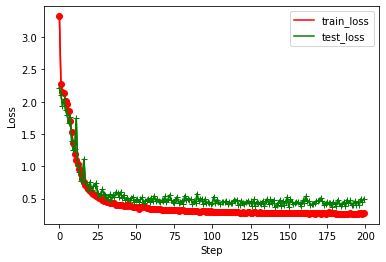

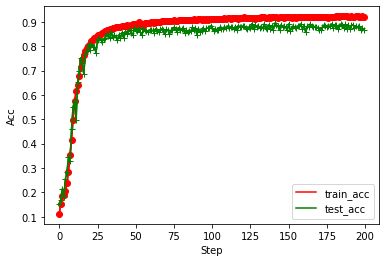

In [49]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [50]:
LOG_PATH="./train21.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn21.pth"
    
model = models.densenet121()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 200
print("Model: Densenet-121")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: Densenet-121
Batch size: 128
Epoch num: 200
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [01:05,  5.95it/s]

Finish 1 epoch, Train loss: 1.556368, Train acc@1: 0.452440


Test loss: 1.295182, Test acc@1: 0.543400
Saving Best model...			Top1 = 54.340000%
Elapsed time: 69.99599003791809
---------- Training Epoch #1 ----------


391it [01:03,  6.13it/s]

Finish 2 epoch, Train loss: 1.200608, Train acc@1: 0.576300


Test loss: 1.102191, Test acc@1: 0.608600
Saving Best model...			Top1 = 60.860000%
Elapsed time: 138.11747455596924
---------- Training Epoch #2 ----------


391it [01:06,  5.90it/s]

Finish 3 epoch, Train loss: 1.023646, Train acc@1: 0.639200


Test loss: 0.978631, Test acc@1: 0.658200
Saving Best model...			Top1 = 65.820000%
Elapsed time: 208.71914315223694
---------- Training Epoch #3 ----------


391it [01:04,  6.02it/s]

Finish 4 epoch, Train loss: 0.914485, Train acc@1: 0.681660


Test loss: 0.991240, Test acc@1: 0.659400
Saving Best model...			Top1 = 65.940000%
Elapsed time: 278.6904296875
---------- Training Epoch #4 ----------


391it [01:04,  6.10it/s]

Finish 5 epoch, Train loss: 0.841917, Train acc@1: 0.708260


Test loss: 0.919641, Test acc@1: 0.694600
Saving Best model...			Top1 = 69.460000%
Elapsed time: 347.0890212059021
---------- Training Epoch #5 ----------


391it [01:00,  6.48it/s]

Finish 6 epoch, Train loss: 0.782130, Train acc@1: 0.729040


Test loss: 0.917156, Test acc@1: 0.694800
Saving Best model...			Top1 = 69.480000%
Elapsed time: 411.73714900016785
---------- Training Epoch #6 ----------


391it [01:02,  6.23it/s]

Finish 7 epoch, Train loss: 0.737467, Train acc@1: 0.742860


Test loss: 0.789312, Test acc@1: 0.734700
Saving Best model...			Top1 = 73.470000%
Elapsed time: 478.9141743183136
---------- Training Epoch #7 ----------


391it [01:02,  6.22it/s]

Finish 8 epoch, Train loss: 0.700212, Train acc@1: 0.757020


Test loss: 0.771468, Test acc@1: 0.740000
Saving Best model...			Top1 = 74.000000%
Elapsed time: 546.1306390762329
---------- Training Epoch #8 ----------


391it [01:05,  5.94it/s]

Finish 9 epoch, Train loss: 0.670758, Train acc@1: 0.767700


Test loss: 0.785231, Test acc@1: 0.726600
Elapsed time: 616.0742568969727
---------- Training Epoch #9 ----------


391it [01:04,  6.08it/s]

Finish 10 epoch, Train loss: 0.645450, Train acc@1: 0.775800


Test loss: 0.657336, Test acc@1: 0.775700
Saving Best model...			Top1 = 77.570000%
Elapsed time: 684.655177116394
---------- Training Epoch #10 ----------


391it [01:06,  5.91it/s]

Finish 11 epoch, Train loss: 0.620266, Train acc@1: 0.786480


Test loss: 0.697472, Test acc@1: 0.763500
Elapsed time: 755.0106785297394
---------- Training Epoch #11 ----------


391it [01:03,  6.16it/s]

Finish 12 epoch, Train loss: 0.601262, Train acc@1: 0.791860


Test loss: 0.682073, Test acc@1: 0.765900
Elapsed time: 822.583573102951
---------- Training Epoch #12 ----------


391it [01:04,  6.09it/s]

Finish 13 epoch, Train loss: 0.585855, Train acc@1: 0.797480


Test loss: 0.601830, Test acc@1: 0.793900
Saving Best model...			Top1 = 79.390000%
Elapsed time: 891.1672427654266
---------- Training Epoch #13 ----------


391it [01:03,  6.18it/s]

Finish 14 epoch, Train loss: 0.570357, Train acc@1: 0.803640


Test loss: 0.662363, Test acc@1: 0.779200
Elapsed time: 958.5127086639404
---------- Training Epoch #14 ----------


391it [01:05,  5.97it/s]

Finish 15 epoch, Train loss: 0.551648, Train acc@1: 0.807600


Test loss: 0.756373, Test acc@1: 0.757000
Elapsed time: 1028.771672964096
---------- Training Epoch #15 ----------


391it [01:05,  6.00it/s]

Finish 16 epoch, Train loss: 0.544481, Train acc@1: 0.812420


Test loss: 0.616910, Test acc@1: 0.795400
Saving Best model...			Top1 = 79.540000%
Elapsed time: 1098.2534596920013
---------- Training Epoch #16 ----------


391it [01:05,  5.95it/s]

Finish 17 epoch, Train loss: 0.526864, Train acc@1: 0.817820


Test loss: 0.639083, Test acc@1: 0.787600
Elapsed time: 1168.1005086898804
---------- Training Epoch #17 ----------


391it [01:05,  5.99it/s]

Finish 18 epoch, Train loss: 0.515108, Train acc@1: 0.822940


Test loss: 0.581535, Test acc@1: 0.803300
Saving Best model...			Top1 = 80.330000%
Elapsed time: 1237.7878184318542
---------- Training Epoch #18 ----------


391it [01:03,  6.18it/s]

Finish 19 epoch, Train loss: 0.508051, Train acc@1: 0.825860


Test loss: 0.638432, Test acc@1: 0.783500
Elapsed time: 1305.2717394828796
---------- Training Epoch #19 ----------


391it [01:03,  6.17it/s]

Finish 20 epoch, Train loss: 0.502739, Train acc@1: 0.827380


Test loss: 0.629604, Test acc@1: 0.790100
Elapsed time: 1372.8121161460876
---------- Training Epoch #20 ----------


391it [01:04,  6.08it/s]

Finish 21 epoch, Train loss: 0.498545, Train acc@1: 0.830120


Test loss: 0.585286, Test acc@1: 0.804500
Saving Best model...			Top1 = 80.450000%
Elapsed time: 1441.5722858905792
---------- Training Epoch #21 ----------


391it [01:04,  6.03it/s]

Finish 22 epoch, Train loss: 0.486636, Train acc@1: 0.833320


Test loss: 0.563471, Test acc@1: 0.809900
Saving Best model...			Top1 = 80.990000%
Elapsed time: 1510.7655425071716
---------- Training Epoch #22 ----------


391it [01:04,  6.05it/s]

Finish 23 epoch, Train loss: 0.480048, Train acc@1: 0.835580


Test loss: 0.544552, Test acc@1: 0.819100
Saving Best model...			Top1 = 81.910000%
Elapsed time: 1579.6234421730042
---------- Training Epoch #23 ----------


391it [01:04,  6.04it/s]

Finish 24 epoch, Train loss: 0.469553, Train acc@1: 0.837480


Test loss: 0.545724, Test acc@1: 0.813100
Elapsed time: 1648.4671301841736
---------- Training Epoch #24 ----------


391it [01:02,  6.27it/s]

Finish 25 epoch, Train loss: 0.469000, Train acc@1: 0.837020


Test loss: 0.600713, Test acc@1: 0.800000
Elapsed time: 1715.8024983406067
---------- Training Epoch #25 ----------


391it [01:04,  6.04it/s]

Finish 26 epoch, Train loss: 0.459944, Train acc@1: 0.840560


Test loss: 0.554711, Test acc@1: 0.811300
Elapsed time: 1784.8747408390045
---------- Training Epoch #26 ----------


391it [01:02,  6.22it/s]

Finish 27 epoch, Train loss: 0.451541, Train acc@1: 0.846260


Test loss: 0.499698, Test acc@1: 0.830200
Saving Best model...			Top1 = 83.020000%
Elapsed time: 1852.0561714172363
---------- Training Epoch #27 ----------


391it [01:06,  5.87it/s]

Finish 28 epoch, Train loss: 0.443926, Train acc@1: 0.846200


Test loss: 0.586637, Test acc@1: 0.810600
Elapsed time: 1922.8813955783844
---------- Training Epoch #28 ----------


391it [01:02,  6.22it/s]

Finish 29 epoch, Train loss: 0.438138, Train acc@1: 0.848100


Test loss: 0.554750, Test acc@1: 0.815500
Elapsed time: 1989.9221274852753
---------- Training Epoch #29 ----------


391it [01:00,  6.51it/s]

Finish 30 epoch, Train loss: 0.442636, Train acc@1: 0.848700


Test loss: 0.625219, Test acc@1: 0.794100
Elapsed time: 2054.2523667812347
---------- Training Epoch #30 ----------


391it [01:04,  6.06it/s]

Finish 31 epoch, Train loss: 0.432995, Train acc@1: 0.851400


Test loss: 0.546761, Test acc@1: 0.814800
Elapsed time: 2123.037276506424
---------- Training Epoch #31 ----------


391it [01:03,  6.16it/s]

Finish 32 epoch, Train loss: 0.427860, Train acc@1: 0.852140


Test loss: 0.515566, Test acc@1: 0.822800
Elapsed time: 2190.74667596817
---------- Training Epoch #32 ----------


391it [01:03,  6.15it/s]

Finish 33 epoch, Train loss: 0.424868, Train acc@1: 0.854280


Test loss: 0.514735, Test acc@1: 0.825400
Elapsed time: 2259.32009100914
---------- Training Epoch #33 ----------


391it [01:02,  6.24it/s]

Finish 34 epoch, Train loss: 0.420314, Train acc@1: 0.854020


Test loss: 0.548783, Test acc@1: 0.817000
Elapsed time: 2326.190793991089
---------- Training Epoch #34 ----------


391it [01:06,  5.91it/s]

Finish 35 epoch, Train loss: 0.421160, Train acc@1: 0.853780


Test loss: 0.511953, Test acc@1: 0.833400
Saving Best model...			Top1 = 83.340000%
Elapsed time: 2396.645440340042
---------- Training Epoch #35 ----------


391it [01:05,  5.96it/s]

Finish 36 epoch, Train loss: 0.415522, Train acc@1: 0.856140


Test loss: 0.490623, Test acc@1: 0.838600
Saving Best model...			Top1 = 83.860000%
Elapsed time: 2466.675847053528
---------- Training Epoch #36 ----------


391it [01:04,  6.11it/s]

Finish 37 epoch, Train loss: 0.413565, Train acc@1: 0.856860


Test loss: 0.509035, Test acc@1: 0.831300
Elapsed time: 2534.87012219429
---------- Training Epoch #37 ----------


391it [01:02,  6.30it/s]

Finish 38 epoch, Train loss: 0.410624, Train acc@1: 0.860260


Test loss: 0.486406, Test acc@1: 0.837300
Elapsed time: 2602.143853187561
---------- Training Epoch #38 ----------


391it [01:05,  5.93it/s]

Finish 39 epoch, Train loss: 0.404108, Train acc@1: 0.860700


Test loss: 0.538217, Test acc@1: 0.819400
Elapsed time: 2672.2614924907684
---------- Training Epoch #39 ----------


391it [01:06,  5.89it/s]

Finish 40 epoch, Train loss: 0.403699, Train acc@1: 0.859160


Test loss: 0.492031, Test acc@1: 0.836000
Elapsed time: 2742.822700738907
---------- Training Epoch #40 ----------


391it [01:03,  6.19it/s]

Finish 41 epoch, Train loss: 0.398650, Train acc@1: 0.862580


Test loss: 0.511839, Test acc@1: 0.826900
Elapsed time: 2810.181576013565
---------- Training Epoch #41 ----------


391it [01:03,  6.16it/s]

Finish 42 epoch, Train loss: 0.399013, Train acc@1: 0.861460


Test loss: 0.524309, Test acc@1: 0.822500
Elapsed time: 2877.8346354961395
---------- Training Epoch #42 ----------


391it [01:03,  6.14it/s]

Finish 43 epoch, Train loss: 0.397136, Train acc@1: 0.864680


Test loss: 0.471042, Test acc@1: 0.839300
Saving Best model...			Top1 = 83.930000%
Elapsed time: 2946.551149368286
---------- Training Epoch #43 ----------


391it [00:58,  6.73it/s]

Finish 44 epoch, Train loss: 0.391845, Train acc@1: 0.865960


Test loss: 0.483143, Test acc@1: 0.838600
Elapsed time: 3008.742436170578
---------- Training Epoch #44 ----------


391it [01:03,  6.17it/s]

Finish 45 epoch, Train loss: 0.389414, Train acc@1: 0.865480


Test loss: 0.584642, Test acc@1: 0.811800
Elapsed time: 3076.3109595775604
---------- Training Epoch #45 ----------


391it [01:01,  6.36it/s]

Finish 46 epoch, Train loss: 0.390811, Train acc@1: 0.865480


Test loss: 0.488028, Test acc@1: 0.834400
Elapsed time: 3142.7306067943573
---------- Training Epoch #46 ----------


391it [01:03,  6.14it/s]

Finish 47 epoch, Train loss: 0.384114, Train acc@1: 0.868020


Test loss: 0.583994, Test acc@1: 0.811100
Elapsed time: 3210.636569738388
---------- Training Epoch #47 ----------


391it [01:00,  6.47it/s]

Finish 48 epoch, Train loss: 0.385063, Train acc@1: 0.868640


Test loss: 0.558702, Test acc@1: 0.820800
Elapsed time: 3275.2534325122833
---------- Training Epoch #48 ----------


391it [01:05,  5.98it/s]

Finish 49 epoch, Train loss: 0.380493, Train acc@1: 0.867220


Test loss: 0.477276, Test acc@1: 0.839400
Saving Best model...			Top1 = 83.940000%
Elapsed time: 3345.550051689148
---------- Training Epoch #49 ----------


391it [01:01,  6.40it/s]

Finish 50 epoch, Train loss: 0.381411, Train acc@1: 0.868240


Test loss: 0.500452, Test acc@1: 0.833200
Elapsed time: 3410.8828463554382
---------- Training Epoch #50 ----------


391it [01:02,  6.30it/s]

Finish 51 epoch, Train loss: 0.379554, Train acc@1: 0.869660


Test loss: 0.488665, Test acc@1: 0.835600
Elapsed time: 3477.1521320343018
---------- Training Epoch #51 ----------


391it [01:04,  6.06it/s]

Finish 52 epoch, Train loss: 0.374871, Train acc@1: 0.869320


Test loss: 0.514092, Test acc@1: 0.831200
Elapsed time: 3545.8669776916504
---------- Training Epoch #52 ----------


391it [01:03,  6.12it/s]

Finish 53 epoch, Train loss: 0.376798, Train acc@1: 0.869180


Test loss: 0.515773, Test acc@1: 0.826000
Elapsed time: 3613.875166654587
---------- Training Epoch #53 ----------


391it [01:04,  6.06it/s]

Finish 54 epoch, Train loss: 0.373319, Train acc@1: 0.870660


Test loss: 0.499360, Test acc@1: 0.835300
Elapsed time: 3682.617609500885
---------- Training Epoch #54 ----------


391it [01:03,  6.20it/s]

Finish 55 epoch, Train loss: 0.370855, Train acc@1: 0.871640


Test loss: 0.489419, Test acc@1: 0.839400
Elapsed time: 3749.7672617435455
---------- Training Epoch #55 ----------


391it [01:02,  6.23it/s]

Finish 56 epoch, Train loss: 0.368560, Train acc@1: 0.872200


Test loss: 0.558657, Test acc@1: 0.812900
Elapsed time: 3817.8142535686493
---------- Training Epoch #56 ----------


391it [01:05,  5.99it/s]

Finish 57 epoch, Train loss: 0.371529, Train acc@1: 0.870780


Test loss: 0.449873, Test acc@1: 0.850200
Saving Best model...			Top1 = 85.020000%
Elapsed time: 3887.371468782425
---------- Training Epoch #57 ----------


391it [01:03,  6.11it/s]

Finish 58 epoch, Train loss: 0.369469, Train acc@1: 0.870980


Test loss: 0.470865, Test acc@1: 0.841700
Elapsed time: 3956.1708946228027
---------- Training Epoch #58 ----------


391it [01:05,  6.01it/s]

Finish 59 epoch, Train loss: 0.366386, Train acc@1: 0.873700


Test loss: 0.491602, Test acc@1: 0.836500
Elapsed time: 4025.3144657611847
---------- Training Epoch #59 ----------


391it [01:05,  6.00it/s]

Finish 60 epoch, Train loss: 0.365242, Train acc@1: 0.873680


Test loss: 0.480835, Test acc@1: 0.841200
Elapsed time: 4094.5750563144684
---------- Training Epoch #60 ----------


391it [01:07,  5.78it/s]

Finish 61 epoch, Train loss: 0.358880, Train acc@1: 0.875280


Test loss: 0.480214, Test acc@1: 0.838200
Elapsed time: 4166.427281618118
---------- Training Epoch #61 ----------


391it [01:03,  6.12it/s]

Finish 62 epoch, Train loss: 0.361445, Train acc@1: 0.875120


Test loss: 0.488827, Test acc@1: 0.841200
Elapsed time: 4235.043383836746
---------- Training Epoch #62 ----------


391it [01:03,  6.11it/s]

Finish 63 epoch, Train loss: 0.359737, Train acc@1: 0.874760


Test loss: 0.500277, Test acc@1: 0.836800
Elapsed time: 4303.138396501541
---------- Training Epoch #63 ----------


391it [01:05,  5.99it/s]

Finish 64 epoch, Train loss: 0.355485, Train acc@1: 0.877540


Test loss: 0.468858, Test acc@1: 0.842800
Elapsed time: 4372.530874013901
---------- Training Epoch #64 ----------


391it [01:03,  6.15it/s]

Finish 65 epoch, Train loss: 0.359962, Train acc@1: 0.875760


Test loss: 0.522259, Test acc@1: 0.827300
Elapsed time: 4440.193029642105
---------- Training Epoch #65 ----------


391it [01:04,  6.07it/s]

Finish 66 epoch, Train loss: 0.352192, Train acc@1: 0.878800


Test loss: 0.486364, Test acc@1: 0.835700
Elapsed time: 4508.767692804337
---------- Training Epoch #66 ----------


391it [01:03,  6.17it/s]

Finish 67 epoch, Train loss: 0.353322, Train acc@1: 0.879520


Test loss: 0.480419, Test acc@1: 0.841100
Elapsed time: 4576.238464593887
---------- Training Epoch #67 ----------


391it [01:01,  6.36it/s]

Finish 68 epoch, Train loss: 0.355419, Train acc@1: 0.877120


Test loss: 0.468882, Test acc@1: 0.842100
Elapsed time: 4641.818940401077
---------- Training Epoch #68 ----------


391it [01:02,  6.24it/s]

Finish 69 epoch, Train loss: 0.349979, Train acc@1: 0.878880


Test loss: 0.482625, Test acc@1: 0.840700
Elapsed time: 4708.60155582428
---------- Training Epoch #69 ----------


391it [01:04,  6.07it/s]

Finish 70 epoch, Train loss: 0.352757, Train acc@1: 0.878340


Test loss: 0.468571, Test acc@1: 0.845600
Elapsed time: 4777.084174156189
---------- Training Epoch #70 ----------


391it [01:02,  6.22it/s]

Finish 71 epoch, Train loss: 0.348620, Train acc@1: 0.879780


Test loss: 0.564167, Test acc@1: 0.813400
Elapsed time: 4844.010840415955
---------- Training Epoch #71 ----------


391it [01:02,  6.24it/s]

Finish 72 epoch, Train loss: 0.352350, Train acc@1: 0.876740


Test loss: 0.479058, Test acc@1: 0.842200
Elapsed time: 4911.734327793121
---------- Training Epoch #72 ----------


391it [01:04,  6.08it/s]

Finish 73 epoch, Train loss: 0.350590, Train acc@1: 0.877240


Test loss: 0.447031, Test acc@1: 0.851800
Saving Best model...			Top1 = 85.180000%
Elapsed time: 4980.5025107860565
---------- Training Epoch #73 ----------


391it [01:05,  5.96it/s]

Finish 74 epoch, Train loss: 0.345984, Train acc@1: 0.877960


Test loss: 0.481801, Test acc@1: 0.837900
Elapsed time: 5050.487839460373
---------- Training Epoch #74 ----------


391it [01:03,  6.17it/s]

Finish 75 epoch, Train loss: 0.348254, Train acc@1: 0.879040


Test loss: 0.466287, Test acc@1: 0.843700
Elapsed time: 5118.165518522263
---------- Training Epoch #75 ----------


391it [01:04,  6.05it/s]

Finish 76 epoch, Train loss: 0.343118, Train acc@1: 0.881300


Test loss: 0.507403, Test acc@1: 0.834600
Elapsed time: 5187.0624413490295
---------- Training Epoch #76 ----------


391it [01:03,  6.14it/s]

Finish 77 epoch, Train loss: 0.341659, Train acc@1: 0.880180


Test loss: 0.474898, Test acc@1: 0.843500
Elapsed time: 5254.808463335037
---------- Training Epoch #77 ----------


391it [01:01,  6.40it/s]

Finish 78 epoch, Train loss: 0.343747, Train acc@1: 0.880160


Test loss: 0.476538, Test acc@1: 0.842500
Elapsed time: 5319.986994743347
---------- Training Epoch #78 ----------


391it [01:06,  5.87it/s]

Finish 79 epoch, Train loss: 0.342973, Train acc@1: 0.881300


Test loss: 0.512190, Test acc@1: 0.832100
Elapsed time: 5390.745268106461
---------- Training Epoch #79 ----------


391it [01:02,  6.24it/s]

Finish 80 epoch, Train loss: 0.343695, Train acc@1: 0.881720


Test loss: 0.456209, Test acc@1: 0.848500
Elapsed time: 5457.763595581055
---------- Training Epoch #80 ----------


391it [01:02,  6.30it/s]

Finish 81 epoch, Train loss: 0.341591, Train acc@1: 0.880300


Test loss: 0.459175, Test acc@1: 0.849400
Elapsed time: 5523.958801746368
---------- Training Epoch #81 ----------


391it [01:02,  6.22it/s]

Finish 82 epoch, Train loss: 0.338518, Train acc@1: 0.883440


Test loss: 0.447590, Test acc@1: 0.845400
Elapsed time: 5591.968506336212
---------- Training Epoch #82 ----------


391it [01:03,  6.20it/s]

Finish 83 epoch, Train loss: 0.338902, Train acc@1: 0.883140


Test loss: 0.461616, Test acc@1: 0.847400
Elapsed time: 5659.318246841431
---------- Training Epoch #83 ----------


391it [01:05,  5.97it/s]

Finish 84 epoch, Train loss: 0.340319, Train acc@1: 0.881640


Test loss: 0.475009, Test acc@1: 0.839600
Elapsed time: 5729.089841365814
---------- Training Epoch #84 ----------


391it [01:04,  6.05it/s]

Finish 85 epoch, Train loss: 0.337207, Train acc@1: 0.884320


Test loss: 0.477277, Test acc@1: 0.843300
Elapsed time: 5798.297368764877
---------- Training Epoch #85 ----------


391it [01:03,  6.12it/s]

Finish 86 epoch, Train loss: 0.334540, Train acc@1: 0.883320


Test loss: 0.498955, Test acc@1: 0.838400
Elapsed time: 5866.426503419876
---------- Training Epoch #86 ----------


391it [01:03,  6.19it/s]

Finish 87 epoch, Train loss: 0.335897, Train acc@1: 0.884300


Test loss: 0.471397, Test acc@1: 0.844200
Elapsed time: 5933.823008298874
---------- Training Epoch #87 ----------


391it [01:04,  6.02it/s]

Finish 88 epoch, Train loss: 0.328913, Train acc@1: 0.886060


Test loss: 0.463683, Test acc@1: 0.845600
Elapsed time: 6003.696336746216
---------- Training Epoch #88 ----------


391it [01:04,  6.09it/s]

Finish 89 epoch, Train loss: 0.335453, Train acc@1: 0.883300


Test loss: 0.479695, Test acc@1: 0.841400
Elapsed time: 6072.10783290863
---------- Training Epoch #89 ----------


391it [01:03,  6.16it/s]

Finish 90 epoch, Train loss: 0.334970, Train acc@1: 0.882840


Test loss: 0.475126, Test acc@1: 0.845700
Elapsed time: 6140.038018941879
---------- Training Epoch #90 ----------


391it [01:03,  6.17it/s]

Finish 91 epoch, Train loss: 0.332735, Train acc@1: 0.884300


Test loss: 0.448892, Test acc@1: 0.848800
Elapsed time: 6207.638128519058
---------- Training Epoch #91 ----------


391it [01:06,  5.84it/s]

Finish 92 epoch, Train loss: 0.333764, Train acc@1: 0.884220


Test loss: 0.447015, Test acc@1: 0.851800
Elapsed time: 6278.84531378746
---------- Training Epoch #92 ----------


391it [01:03,  6.19it/s]

Finish 93 epoch, Train loss: 0.334395, Train acc@1: 0.883960


Test loss: 0.500579, Test acc@1: 0.836700
Elapsed time: 6346.074355602264
---------- Training Epoch #93 ----------


391it [01:04,  6.03it/s]

Finish 94 epoch, Train loss: 0.332491, Train acc@1: 0.884800


Test loss: 0.453021, Test acc@1: 0.850200
Elapsed time: 6415.183189630508
---------- Training Epoch #94 ----------


391it [01:04,  6.08it/s]

Finish 95 epoch, Train loss: 0.330610, Train acc@1: 0.884680


Test loss: 0.450667, Test acc@1: 0.851500
Elapsed time: 6483.779621839523
---------- Training Epoch #95 ----------


391it [01:06,  5.89it/s]

Finish 96 epoch, Train loss: 0.329341, Train acc@1: 0.886840


Test loss: 0.458604, Test acc@1: 0.846600
Elapsed time: 6554.403592586517
---------- Training Epoch #96 ----------


391it [01:01,  6.33it/s]

Finish 97 epoch, Train loss: 0.327598, Train acc@1: 0.886620


Test loss: 0.476074, Test acc@1: 0.846300
Elapsed time: 6620.289702415466
---------- Training Epoch #97 ----------


391it [01:02,  6.24it/s]

Finish 98 epoch, Train loss: 0.330747, Train acc@1: 0.885360


Test loss: 0.466781, Test acc@1: 0.846800
Elapsed time: 6687.053631305695
---------- Training Epoch #98 ----------


391it [01:04,  6.03it/s]

Finish 99 epoch, Train loss: 0.324955, Train acc@1: 0.886980


Test loss: 0.488151, Test acc@1: 0.840700
Elapsed time: 6756.172982215881
---------- Training Epoch #99 ----------


391it [01:05,  6.00it/s]

Finish 100 epoch, Train loss: 0.328299, Train acc@1: 0.885620


Test loss: 0.454313, Test acc@1: 0.851100
Elapsed time: 6825.517429351807
---------- Training Epoch #100 ----------


391it [01:03,  6.11it/s]

Finish 101 epoch, Train loss: 0.330394, Train acc@1: 0.884840


Test loss: 0.470883, Test acc@1: 0.843100
Elapsed time: 6893.666499137878
---------- Training Epoch #101 ----------


391it [01:03,  6.12it/s]

Finish 102 epoch, Train loss: 0.328245, Train acc@1: 0.886760


Test loss: 0.458898, Test acc@1: 0.849100
Elapsed time: 6961.7091364860535
---------- Training Epoch #102 ----------


391it [01:05,  6.01it/s]

Finish 103 epoch, Train loss: 0.329896, Train acc@1: 0.884920


Test loss: 0.494860, Test acc@1: 0.838200
Elapsed time: 7031.896783590317
---------- Training Epoch #103 ----------


391it [01:03,  6.12it/s]

Finish 104 epoch, Train loss: 0.328176, Train acc@1: 0.886680


Test loss: 0.475516, Test acc@1: 0.843700
Elapsed time: 7099.977604866028
---------- Training Epoch #104 ----------


391it [01:02,  6.22it/s]

Finish 105 epoch, Train loss: 0.325738, Train acc@1: 0.884880


Test loss: 0.510033, Test acc@1: 0.832700
Elapsed time: 7166.923465251923
---------- Training Epoch #105 ----------


391it [01:06,  5.92it/s]

Finish 106 epoch, Train loss: 0.323824, Train acc@1: 0.888000


Test loss: 0.475227, Test acc@1: 0.841900
Elapsed time: 7236.999789953232
---------- Training Epoch #106 ----------


391it [01:05,  5.99it/s]

Finish 107 epoch, Train loss: 0.326032, Train acc@1: 0.886940


Test loss: 0.439752, Test acc@1: 0.853900
Saving Best model...			Top1 = 85.390000%
Elapsed time: 7306.510143280029
---------- Training Epoch #107 ----------


391it [01:04,  6.08it/s]

Finish 108 epoch, Train loss: 0.320803, Train acc@1: 0.889140


Test loss: 0.462813, Test acc@1: 0.848500
Elapsed time: 7374.9102256298065
---------- Training Epoch #108 ----------


391it [01:05,  5.97it/s]

Finish 109 epoch, Train loss: 0.326978, Train acc@1: 0.886300


Test loss: 0.462989, Test acc@1: 0.850300
Elapsed time: 7445.158900499344
---------- Training Epoch #109 ----------


391it [00:59,  6.54it/s]

Finish 110 epoch, Train loss: 0.326365, Train acc@1: 0.886160


Test loss: 0.479204, Test acc@1: 0.842200
Elapsed time: 7509.129243850708
---------- Training Epoch #110 ----------


391it [01:05,  6.00it/s]

Finish 111 epoch, Train loss: 0.321615, Train acc@1: 0.889760


Test loss: 0.451048, Test acc@1: 0.853400
Elapsed time: 7578.55447602272
---------- Training Epoch #111 ----------


391it [01:07,  5.81it/s]

Finish 112 epoch, Train loss: 0.317801, Train acc@1: 0.890160


Test loss: 0.519049, Test acc@1: 0.835200
Elapsed time: 7650.085963726044
---------- Training Epoch #112 ----------


391it [01:04,  6.09it/s]

Finish 113 epoch, Train loss: 0.324755, Train acc@1: 0.887480


Test loss: 0.427103, Test acc@1: 0.858100
Saving Best model...			Top1 = 85.810000%
Elapsed time: 7718.748361110687
---------- Training Epoch #113 ----------


391it [01:04,  6.09it/s]

Finish 114 epoch, Train loss: 0.319250, Train acc@1: 0.888480


Test loss: 0.475214, Test acc@1: 0.842900
Elapsed time: 7787.666260719299
---------- Training Epoch #114 ----------


391it [01:03,  6.19it/s]

Finish 115 epoch, Train loss: 0.319960, Train acc@1: 0.889960


Test loss: 0.463502, Test acc@1: 0.850100
Elapsed time: 7855.759127378464
---------- Training Epoch #115 ----------


391it [01:01,  6.40it/s]

Finish 116 epoch, Train loss: 0.322845, Train acc@1: 0.886900


Test loss: 0.459834, Test acc@1: 0.849100
Elapsed time: 7920.935272455215
---------- Training Epoch #116 ----------


391it [01:05,  5.94it/s]

Finish 117 epoch, Train loss: 0.314141, Train acc@1: 0.890320


Test loss: 0.444852, Test acc@1: 0.852300
Elapsed time: 7990.987933635712
---------- Training Epoch #117 ----------


391it [01:03,  6.18it/s]

Finish 118 epoch, Train loss: 0.313664, Train acc@1: 0.890100


Test loss: 0.481827, Test acc@1: 0.842900
Elapsed time: 8058.329403400421
---------- Training Epoch #118 ----------


391it [01:03,  6.13it/s]

Finish 119 epoch, Train loss: 0.316471, Train acc@1: 0.889800


Test loss: 0.437910, Test acc@1: 0.854900
Elapsed time: 8126.219167232513
---------- Training Epoch #119 ----------


391it [01:04,  6.10it/s]

Finish 120 epoch, Train loss: 0.317627, Train acc@1: 0.890240


Test loss: 0.462633, Test acc@1: 0.850700
Elapsed time: 8194.483086824417
---------- Training Epoch #120 ----------


391it [01:01,  6.35it/s]

Finish 121 epoch, Train loss: 0.318889, Train acc@1: 0.889640


Test loss: 0.489139, Test acc@1: 0.845600
Elapsed time: 8260.447534561157
---------- Training Epoch #121 ----------


391it [01:02,  6.23it/s]

Finish 122 epoch, Train loss: 0.314527, Train acc@1: 0.889820


Test loss: 0.457798, Test acc@1: 0.853500
Elapsed time: 8327.264401197433
---------- Training Epoch #122 ----------


391it [01:06,  5.92it/s]

Finish 123 epoch, Train loss: 0.313941, Train acc@1: 0.890080


Test loss: 0.431757, Test acc@1: 0.856800
Elapsed time: 8397.37334728241
---------- Training Epoch #123 ----------


391it [01:06,  5.84it/s]

Finish 124 epoch, Train loss: 0.320451, Train acc@1: 0.889880


Test loss: 0.446939, Test acc@1: 0.853800
Elapsed time: 8468.403817415237
---------- Training Epoch #124 ----------


391it [01:05,  5.95it/s]

Finish 125 epoch, Train loss: 0.315163, Train acc@1: 0.889820


Test loss: 0.430099, Test acc@1: 0.858000
Elapsed time: 8539.179234266281
---------- Training Epoch #125 ----------


391it [01:05,  6.01it/s]

Finish 126 epoch, Train loss: 0.308966, Train acc@1: 0.891300


Test loss: 0.494478, Test acc@1: 0.847000
Elapsed time: 8608.330641746521
---------- Training Epoch #126 ----------


391it [01:05,  5.98it/s]

Finish 127 epoch, Train loss: 0.312542, Train acc@1: 0.889940


Test loss: 0.460781, Test acc@1: 0.849100
Elapsed time: 8677.902511358261
---------- Training Epoch #127 ----------


391it [01:03,  6.11it/s]

Finish 128 epoch, Train loss: 0.312911, Train acc@1: 0.891260


Test loss: 0.512838, Test acc@1: 0.835800
Elapsed time: 8746.619457960129
---------- Training Epoch #128 ----------


391it [01:02,  6.21it/s]

Finish 129 epoch, Train loss: 0.314405, Train acc@1: 0.890300


Test loss: 0.493045, Test acc@1: 0.839400
Elapsed time: 8813.670680761337
---------- Training Epoch #129 ----------


391it [01:04,  6.07it/s]

Finish 130 epoch, Train loss: 0.311228, Train acc@1: 0.891600


Test loss: 0.456509, Test acc@1: 0.850500
Elapsed time: 8882.532171964645
---------- Training Epoch #130 ----------


391it [01:05,  6.01it/s]

Finish 131 epoch, Train loss: 0.315090, Train acc@1: 0.890800


Test loss: 0.466940, Test acc@1: 0.848100
Elapsed time: 8952.491466760635
---------- Training Epoch #131 ----------


391it [01:01,  6.38it/s]

Finish 132 epoch, Train loss: 0.315832, Train acc@1: 0.891260


Test loss: 0.464772, Test acc@1: 0.847300
Elapsed time: 9018.716785907745
---------- Training Epoch #132 ----------


391it [01:05,  5.97it/s]

Finish 133 epoch, Train loss: 0.308610, Train acc@1: 0.891700


Test loss: 0.474692, Test acc@1: 0.845300
Elapsed time: 9088.484968662262
---------- Training Epoch #133 ----------


391it [01:06,  5.91it/s]

Finish 134 epoch, Train loss: 0.306956, Train acc@1: 0.893980


Test loss: 0.483862, Test acc@1: 0.846600
Elapsed time: 9158.814413070679
---------- Training Epoch #134 ----------


391it [01:07,  5.77it/s]

Finish 135 epoch, Train loss: 0.309025, Train acc@1: 0.893200


Test loss: 0.459720, Test acc@1: 0.850600
Elapsed time: 9230.888463020325
---------- Training Epoch #135 ----------


391it [01:05,  6.00it/s]

Finish 136 epoch, Train loss: 0.306515, Train acc@1: 0.893960


Test loss: 0.469846, Test acc@1: 0.845000
Elapsed time: 9300.319880247116
---------- Training Epoch #136 ----------


391it [01:05,  5.93it/s]

Finish 137 epoch, Train loss: 0.308449, Train acc@1: 0.892500


Test loss: 0.463146, Test acc@1: 0.849200
Elapsed time: 9370.354188203812
---------- Training Epoch #137 ----------


391it [01:04,  6.07it/s]

Finish 138 epoch, Train loss: 0.305642, Train acc@1: 0.894340


Test loss: 0.474978, Test acc@1: 0.843800
Elapsed time: 9438.842262268066
---------- Training Epoch #138 ----------


391it [01:05,  5.96it/s]

Finish 139 epoch, Train loss: 0.310417, Train acc@1: 0.891880


Test loss: 0.497506, Test acc@1: 0.839500
Elapsed time: 9508.710616827011
---------- Training Epoch #139 ----------


391it [01:05,  6.01it/s]

Finish 140 epoch, Train loss: 0.309477, Train acc@1: 0.892080


Test loss: 0.491095, Test acc@1: 0.846000
Elapsed time: 9577.87631392479
---------- Training Epoch #140 ----------


391it [01:08,  5.75it/s]

Finish 141 epoch, Train loss: 0.313173, Train acc@1: 0.891040


Test loss: 0.477371, Test acc@1: 0.842800
Elapsed time: 9650.12725687027
---------- Training Epoch #141 ----------


391it [01:05,  6.00it/s]

Finish 142 epoch, Train loss: 0.312487, Train acc@1: 0.892280


Test loss: 0.467828, Test acc@1: 0.846800
Elapsed time: 9719.373417377472
---------- Training Epoch #142 ----------


391it [01:04,  6.03it/s]

Finish 143 epoch, Train loss: 0.308214, Train acc@1: 0.892600


Test loss: 0.476491, Test acc@1: 0.843900
Elapsed time: 9788.307946920395
---------- Training Epoch #143 ----------


391it [01:06,  5.86it/s]

Finish 144 epoch, Train loss: 0.310119, Train acc@1: 0.892620


Test loss: 0.474772, Test acc@1: 0.844300
Elapsed time: 9859.062681674957
---------- Training Epoch #144 ----------


391it [01:04,  6.11it/s]

Finish 145 epoch, Train loss: 0.305777, Train acc@1: 0.893480


Test loss: 0.477130, Test acc@1: 0.843400
Elapsed time: 9927.294283866882
---------- Training Epoch #145 ----------


391it [01:06,  5.88it/s]

Finish 146 epoch, Train loss: 0.310942, Train acc@1: 0.892140


Test loss: 0.441403, Test acc@1: 0.852000
Elapsed time: 9997.825714111328
---------- Training Epoch #146 ----------


391it [01:05,  6.01it/s]

Finish 147 epoch, Train loss: 0.307825, Train acc@1: 0.893740


Test loss: 0.455025, Test acc@1: 0.852200
Elapsed time: 10067.052238941193
---------- Training Epoch #147 ----------


391it [01:01,  6.40it/s]

Finish 148 epoch, Train loss: 0.305360, Train acc@1: 0.894680


Test loss: 0.487921, Test acc@1: 0.844300
Elapsed time: 10132.304462194443
---------- Training Epoch #148 ----------


391it [01:06,  5.88it/s]

Finish 149 epoch, Train loss: 0.306211, Train acc@1: 0.895540


Test loss: 0.442554, Test acc@1: 0.855400
Elapsed time: 10202.958845615387
---------- Training Epoch #149 ----------


391it [01:03,  6.11it/s]

Finish 150 epoch, Train loss: 0.308705, Train acc@1: 0.893040


Test loss: 0.444726, Test acc@1: 0.852900
Elapsed time: 10271.769618272781
---------- Training Epoch #150 ----------


391it [01:06,  5.92it/s]

Finish 151 epoch, Train loss: 0.308090, Train acc@1: 0.892900


Test loss: 0.485654, Test acc@1: 0.841100
Elapsed time: 10342.31750869751
---------- Training Epoch #151 ----------


391it [01:04,  6.03it/s]

Finish 152 epoch, Train loss: 0.304075, Train acc@1: 0.893780


Test loss: 0.482864, Test acc@1: 0.838600
Elapsed time: 10411.3943567276
---------- Training Epoch #152 ----------


391it [01:05,  5.95it/s]

Finish 153 epoch, Train loss: 0.303298, Train acc@1: 0.893380


Test loss: 0.441538, Test acc@1: 0.857400
Elapsed time: 10481.800009727478
---------- Training Epoch #153 ----------


391it [01:01,  6.34it/s]

Finish 154 epoch, Train loss: 0.305574, Train acc@1: 0.893700


Test loss: 0.444142, Test acc@1: 0.854100
Elapsed time: 10547.626356124878
---------- Training Epoch #154 ----------


391it [01:03,  6.19it/s]

Finish 155 epoch, Train loss: 0.305354, Train acc@1: 0.891720


Test loss: 0.466982, Test acc@1: 0.852000
Elapsed time: 10615.020761489868
---------- Training Epoch #155 ----------


391it [01:06,  5.84it/s]

Finish 156 epoch, Train loss: 0.302458, Train acc@1: 0.894800


Test loss: 0.456757, Test acc@1: 0.852500
Elapsed time: 10686.954607725143
---------- Training Epoch #156 ----------


391it [01:05,  5.94it/s]

Finish 157 epoch, Train loss: 0.303558, Train acc@1: 0.894720


Test loss: 0.445018, Test acc@1: 0.856100
Elapsed time: 10757.084115743637
---------- Training Epoch #157 ----------


391it [01:06,  5.88it/s]

Finish 158 epoch, Train loss: 0.304599, Train acc@1: 0.894700


Test loss: 0.452882, Test acc@1: 0.852300
Elapsed time: 10827.86783337593
---------- Training Epoch #158 ----------


391it [01:05,  5.93it/s]

Finish 159 epoch, Train loss: 0.300754, Train acc@1: 0.895600


Test loss: 0.456704, Test acc@1: 0.856000
Elapsed time: 10898.035672187805
---------- Training Epoch #159 ----------


391it [01:06,  5.88it/s]

Finish 160 epoch, Train loss: 0.304366, Train acc@1: 0.894180


Test loss: 0.435107, Test acc@1: 0.858400
Saving Best model...			Top1 = 85.840000%
Elapsed time: 10968.936398267746
---------- Training Epoch #160 ----------


391it [01:06,  5.84it/s]

Finish 161 epoch, Train loss: 0.299047, Train acc@1: 0.895380


Test loss: 0.470240, Test acc@1: 0.848100
Elapsed time: 11040.006951093674
---------- Training Epoch #161 ----------


391it [01:05,  6.01it/s]

Finish 162 epoch, Train loss: 0.306257, Train acc@1: 0.893520


Test loss: 0.473740, Test acc@1: 0.847100
Elapsed time: 11109.306497097015
---------- Training Epoch #162 ----------


391it [01:04,  6.08it/s]

Finish 163 epoch, Train loss: 0.303599, Train acc@1: 0.894240


Test loss: 0.452931, Test acc@1: 0.854000
Elapsed time: 11177.777802705765
---------- Training Epoch #163 ----------


391it [01:04,  6.04it/s]

Finish 164 epoch, Train loss: 0.299756, Train acc@1: 0.894380


Test loss: 0.435141, Test acc@1: 0.858600
Saving Best model...			Top1 = 85.860000%
Elapsed time: 11247.042620658875
---------- Training Epoch #164 ----------


391it [01:08,  5.74it/s]

Finish 165 epoch, Train loss: 0.306732, Train acc@1: 0.893680


Test loss: 0.458179, Test acc@1: 0.846500
Elapsed time: 11319.337478637695
---------- Training Epoch #165 ----------


391it [01:07,  5.76it/s]

Finish 166 epoch, Train loss: 0.302644, Train acc@1: 0.895400


Test loss: 0.458543, Test acc@1: 0.852300
Elapsed time: 11392.236355543137
---------- Training Epoch #166 ----------


391it [01:07,  5.75it/s]

Finish 167 epoch, Train loss: 0.296526, Train acc@1: 0.896740


Test loss: 0.525196, Test acc@1: 0.831700
Elapsed time: 11464.559629440308
---------- Training Epoch #167 ----------


391it [01:04,  6.04it/s]

Finish 168 epoch, Train loss: 0.298716, Train acc@1: 0.895280


Test loss: 0.489692, Test acc@1: 0.843700
Elapsed time: 11534.003658771515
---------- Training Epoch #168 ----------


391it [01:07,  5.81it/s]

Finish 169 epoch, Train loss: 0.299315, Train acc@1: 0.896660


Test loss: 0.464730, Test acc@1: 0.854100
Elapsed time: 11605.502833366394
---------- Training Epoch #169 ----------


391it [01:05,  5.99it/s]

Finish 170 epoch, Train loss: 0.301808, Train acc@1: 0.895520


Test loss: 0.470309, Test acc@1: 0.846900
Elapsed time: 11674.900257349014
---------- Training Epoch #170 ----------


391it [01:05,  5.93it/s]

Finish 171 epoch, Train loss: 0.304031, Train acc@1: 0.893960


Test loss: 0.467610, Test acc@1: 0.848400
Elapsed time: 11745.005217552185
---------- Training Epoch #171 ----------


391it [01:06,  5.90it/s]

Finish 172 epoch, Train loss: 0.298237, Train acc@1: 0.895500


Test loss: 0.474434, Test acc@1: 0.845000
Elapsed time: 11815.501904010773
---------- Training Epoch #172 ----------


391it [01:05,  6.01it/s]

Finish 173 epoch, Train loss: 0.301546, Train acc@1: 0.894640


Test loss: 0.460563, Test acc@1: 0.851400
Elapsed time: 11885.831324100494
---------- Training Epoch #173 ----------


391it [01:04,  6.07it/s]

Finish 174 epoch, Train loss: 0.294925, Train acc@1: 0.896640


Test loss: 0.460190, Test acc@1: 0.849400
Elapsed time: 11954.389518737793
---------- Training Epoch #174 ----------


391it [01:05,  6.01it/s]

Finish 175 epoch, Train loss: 0.296580, Train acc@1: 0.898100


Test loss: 0.461747, Test acc@1: 0.851600
Elapsed time: 12023.73234629631
---------- Training Epoch #175 ----------


391it [01:06,  5.84it/s]

Finish 176 epoch, Train loss: 0.296435, Train acc@1: 0.897320


Test loss: 0.486787, Test acc@1: 0.843000
Elapsed time: 12094.98347067833
---------- Training Epoch #176 ----------


391it [01:05,  5.95it/s]

Finish 177 epoch, Train loss: 0.301032, Train acc@1: 0.895740


Test loss: 0.459870, Test acc@1: 0.850500
Elapsed time: 12164.90308713913
---------- Training Epoch #177 ----------


391it [01:04,  6.10it/s]

Finish 178 epoch, Train loss: 0.299755, Train acc@1: 0.896420


Test loss: 0.456442, Test acc@1: 0.851600
Elapsed time: 12233.279616117477
---------- Training Epoch #178 ----------


391it [01:04,  6.09it/s]

Finish 179 epoch, Train loss: 0.296338, Train acc@1: 0.896780


Test loss: 0.452619, Test acc@1: 0.854800
Elapsed time: 12301.67773771286
---------- Training Epoch #179 ----------


391it [01:04,  6.10it/s]

Finish 180 epoch, Train loss: 0.298610, Train acc@1: 0.895240


Test loss: 0.466004, Test acc@1: 0.849200
Elapsed time: 12370.042980194092
---------- Training Epoch #180 ----------


391it [01:07,  5.81it/s]

Finish 181 epoch, Train loss: 0.292598, Train acc@1: 0.898260


Test loss: 0.471180, Test acc@1: 0.843400
Elapsed time: 12441.583280801773
---------- Training Epoch #181 ----------


391it [01:06,  5.90it/s]

Finish 182 epoch, Train loss: 0.291473, Train acc@1: 0.897240


Test loss: 0.456424, Test acc@1: 0.850300
Elapsed time: 12512.183940172195
---------- Training Epoch #182 ----------


391it [01:06,  5.87it/s]

Finish 183 epoch, Train loss: 0.299272, Train acc@1: 0.895220


Test loss: 0.446649, Test acc@1: 0.855900
Elapsed time: 12583.069266796112
---------- Training Epoch #183 ----------


391it [01:01,  6.36it/s]

Finish 184 epoch, Train loss: 0.295459, Train acc@1: 0.896260


Test loss: 0.491223, Test acc@1: 0.842000
Elapsed time: 12648.895025014877
---------- Training Epoch #184 ----------


391it [01:02,  6.25it/s]

Finish 185 epoch, Train loss: 0.294380, Train acc@1: 0.897820


Test loss: 0.455728, Test acc@1: 0.848600
Elapsed time: 12716.518800258636
---------- Training Epoch #185 ----------


391it [01:07,  5.78it/s]

Finish 186 epoch, Train loss: 0.297961, Train acc@1: 0.896820


Test loss: 0.431263, Test acc@1: 0.856700
Elapsed time: 12788.340379953384
---------- Training Epoch #186 ----------


391it [01:07,  5.76it/s]

Finish 187 epoch, Train loss: 0.297797, Train acc@1: 0.896360


Test loss: 0.466933, Test acc@1: 0.852200
Elapsed time: 12860.422006845474
---------- Training Epoch #187 ----------


391it [01:08,  5.74it/s]

Finish 188 epoch, Train loss: 0.294264, Train acc@1: 0.897260


Test loss: 0.489911, Test acc@1: 0.843400
Elapsed time: 12932.776844263077
---------- Training Epoch #188 ----------


391it [01:05,  5.99it/s]

Finish 189 epoch, Train loss: 0.300940, Train acc@1: 0.895140


Test loss: 0.484039, Test acc@1: 0.845400
Elapsed time: 13003.163500547409
---------- Training Epoch #189 ----------


391it [01:05,  5.93it/s]

Finish 190 epoch, Train loss: 0.291822, Train acc@1: 0.898000


Test loss: 0.495131, Test acc@1: 0.839300
Elapsed time: 13073.30005121231
---------- Training Epoch #190 ----------


391it [01:03,  6.15it/s]

Finish 191 epoch, Train loss: 0.292942, Train acc@1: 0.897100


Test loss: 0.466181, Test acc@1: 0.850200
Elapsed time: 13141.099299669266
---------- Training Epoch #191 ----------


391it [01:06,  5.87it/s]

Finish 192 epoch, Train loss: 0.296041, Train acc@1: 0.896880


Test loss: 0.475308, Test acc@1: 0.846400
Elapsed time: 13211.817039012909
---------- Training Epoch #192 ----------


391it [01:06,  5.89it/s]

Finish 193 epoch, Train loss: 0.296506, Train acc@1: 0.895600


Test loss: 0.469520, Test acc@1: 0.848000
Elapsed time: 13282.455913305283
---------- Training Epoch #193 ----------


391it [01:06,  5.84it/s]

Finish 194 epoch, Train loss: 0.294825, Train acc@1: 0.897560


Test loss: 0.463676, Test acc@1: 0.851800
Elapsed time: 13354.434382677078
---------- Training Epoch #194 ----------


391it [01:03,  6.13it/s]

Finish 195 epoch, Train loss: 0.285819, Train acc@1: 0.901020


Test loss: 0.474200, Test acc@1: 0.849900
Elapsed time: 13422.526227474213
---------- Training Epoch #195 ----------


391it [01:04,  6.09it/s]

Finish 196 epoch, Train loss: 0.296936, Train acc@1: 0.897080


Test loss: 0.471749, Test acc@1: 0.848300
Elapsed time: 13490.945942640305
---------- Training Epoch #196 ----------


391it [01:06,  5.84it/s]

Finish 197 epoch, Train loss: 0.287124, Train acc@1: 0.901400


Test loss: 0.488769, Test acc@1: 0.844900
Elapsed time: 13562.076259851456
---------- Training Epoch #197 ----------


391it [01:05,  5.97it/s]

Finish 198 epoch, Train loss: 0.289647, Train acc@1: 0.900400


Test loss: 0.444464, Test acc@1: 0.851400
Elapsed time: 13631.803039312363
---------- Training Epoch #198 ----------


391it [01:05,  5.97it/s]

Finish 199 epoch, Train loss: 0.295604, Train acc@1: 0.898060


Test loss: 0.463648, Test acc@1: 0.848700
Elapsed time: 13701.674471139908
---------- Training Epoch #199 ----------


391it [01:06,  5.87it/s]

Finish 200 epoch, Train loss: 0.289457, Train acc@1: 0.899060


Test loss: 0.452399, Test acc@1: 0.851800
Elapsed time: 13772.416868925095

Test results: Acc@1 = 85.860000%


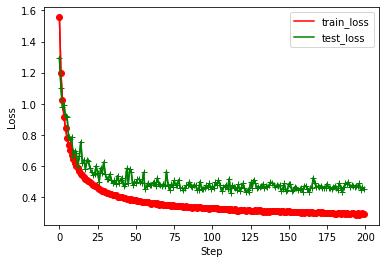

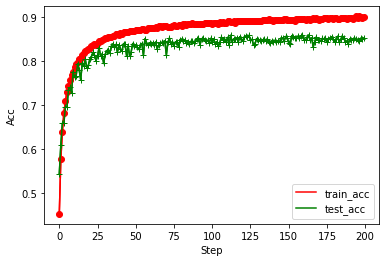

In [51]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [52]:
LOG_PATH="./train22.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
MODEL_PATH="./cnn22.pth"
    
model = models.densenet201()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 200
print("Model: Densenet-201")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: Densenet-201
Batch size: 128
Epoch num: 200
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [01:43,  3.80it/s]

Finish 1 epoch, Train loss: 1.594832, Train acc@1: 0.428980


Test loss: 1.422461, Test acc@1: 0.486400
Saving Best model...			Top1 = 48.640000%
Elapsed time: 108.96323990821838
---------- Training Epoch #1 ----------


391it [01:44,  3.74it/s]

Finish 2 epoch, Train loss: 1.226042, Train acc@1: 0.561980


Test loss: 1.238642, Test acc@1: 0.574600
Saving Best model...			Top1 = 57.460000%
Elapsed time: 220.18144512176514
---------- Training Epoch #2 ----------


391it [01:44,  3.74it/s]

Finish 3 epoch, Train loss: 1.046457, Train acc@1: 0.630380


Test loss: 1.083754, Test acc@1: 0.623200
Saving Best model...			Top1 = 62.320000%
Elapsed time: 330.92142128944397
---------- Training Epoch #3 ----------


391it [01:45,  3.72it/s]

Finish 4 epoch, Train loss: 0.927227, Train acc@1: 0.676380


Test loss: 0.997562, Test acc@1: 0.662300
Saving Best model...			Top1 = 66.230000%
Elapsed time: 442.81031560897827
---------- Training Epoch #4 ----------


391it [01:44,  3.74it/s]

Finish 5 epoch, Train loss: 0.851446, Train acc@1: 0.702840


Test loss: 0.816125, Test acc@1: 0.720400
Saving Best model...			Top1 = 72.040000%
Elapsed time: 554.1876382827759
---------- Training Epoch #5 ----------


391it [01:41,  3.84it/s]

Finish 6 epoch, Train loss: 0.785602, Train acc@1: 0.726100


Test loss: 0.826653, Test acc@1: 0.714400
Elapsed time: 662.0053777694702
---------- Training Epoch #6 ----------


391it [01:49,  3.58it/s]

Finish 7 epoch, Train loss: 0.739117, Train acc@1: 0.743800


Test loss: 0.837806, Test acc@1: 0.719400
Elapsed time: 777.5167100429535
---------- Training Epoch #7 ----------


391it [01:44,  3.74it/s]

Finish 8 epoch, Train loss: 0.708432, Train acc@1: 0.754000


Test loss: 0.733710, Test acc@1: 0.742900
Saving Best model...			Top1 = 74.290000%
Elapsed time: 888.7758345603943
---------- Training Epoch #8 ----------


391it [01:45,  3.71it/s]

Finish 9 epoch, Train loss: 0.672588, Train acc@1: 0.766620


Test loss: 0.780211, Test acc@1: 0.733400
Elapsed time: 1000.0613448619843
---------- Training Epoch #9 ----------


391it [01:43,  3.78it/s]

Finish 10 epoch, Train loss: 0.649670, Train acc@1: 0.775900


Test loss: 0.710819, Test acc@1: 0.757600
Saving Best model...			Top1 = 75.760000%
Elapsed time: 1110.2299740314484
---------- Training Epoch #10 ----------


391it [01:45,  3.70it/s]

Finish 11 epoch, Train loss: 0.619053, Train acc@1: 0.785580


Test loss: 0.702925, Test acc@1: 0.757500
Elapsed time: 1221.69473695755
---------- Training Epoch #11 ----------


391it [01:42,  3.80it/s]

Finish 12 epoch, Train loss: 0.598973, Train acc@1: 0.793360


Test loss: 0.703146, Test acc@1: 0.762000
Saving Best model...			Top1 = 76.200000%
Elapsed time: 1330.4407234191895
---------- Training Epoch #12 ----------


391it [01:45,  3.71it/s]

Finish 13 epoch, Train loss: 0.588641, Train acc@1: 0.798020


Test loss: 0.615730, Test acc@1: 0.790700
Saving Best model...			Top1 = 79.070000%
Elapsed time: 1441.9639806747437
---------- Training Epoch #13 ----------


391it [01:44,  3.75it/s]

Finish 14 epoch, Train loss: 0.570012, Train acc@1: 0.804600


Test loss: 0.642797, Test acc@1: 0.783300
Elapsed time: 1552.7746949195862
---------- Training Epoch #14 ----------


391it [01:43,  3.79it/s]

Finish 15 epoch, Train loss: 0.551752, Train acc@1: 0.811580


Test loss: 0.604403, Test acc@1: 0.792400
Saving Best model...			Top1 = 79.240000%
Elapsed time: 1661.936200618744
---------- Training Epoch #15 ----------


391it [01:46,  3.67it/s]

Finish 16 epoch, Train loss: 0.542034, Train acc@1: 0.815280


Test loss: 0.599693, Test acc@1: 0.797900
Saving Best model...			Top1 = 79.790000%
Elapsed time: 1775.595056772232
---------- Training Epoch #16 ----------


391it [01:43,  3.76it/s]

Finish 17 epoch, Train loss: 0.529787, Train acc@1: 0.819100


Test loss: 0.642784, Test acc@1: 0.788100
Elapsed time: 1886.1448543071747
---------- Training Epoch #17 ----------


391it [01:43,  3.76it/s]

Finish 18 epoch, Train loss: 0.519896, Train acc@1: 0.822240


Test loss: 0.570180, Test acc@1: 0.806100
Saving Best model...			Top1 = 80.610000%
Elapsed time: 1996.7593793869019
---------- Training Epoch #18 ----------


391it [01:41,  3.85it/s]

Finish 19 epoch, Train loss: 0.507544, Train acc@1: 0.824260


Test loss: 0.582621, Test acc@1: 0.801300
Elapsed time: 2104.037479877472
---------- Training Epoch #19 ----------


391it [01:48,  3.61it/s]

Finish 20 epoch, Train loss: 0.497771, Train acc@1: 0.830000


Test loss: 0.584276, Test acc@1: 0.807300
Saving Best model...			Top1 = 80.730000%
Elapsed time: 2218.9930918216705
---------- Training Epoch #20 ----------


391it [01:44,  3.75it/s]

Finish 21 epoch, Train loss: 0.490703, Train acc@1: 0.830700


Test loss: 0.564515, Test acc@1: 0.807600
Saving Best model...			Top1 = 80.760000%
Elapsed time: 2329.1658084392548
---------- Training Epoch #21 ----------


391it [01:41,  3.84it/s]

Finish 22 epoch, Train loss: 0.482206, Train acc@1: 0.834180


Test loss: 0.568197, Test acc@1: 0.803400
Elapsed time: 2436.6936452388763
---------- Training Epoch #22 ----------


391it [01:44,  3.73it/s]

Finish 23 epoch, Train loss: 0.477091, Train acc@1: 0.837060


Test loss: 0.623706, Test acc@1: 0.788300
Elapsed time: 2547.7705256938934
---------- Training Epoch #23 ----------


391it [01:40,  3.88it/s]

Finish 24 epoch, Train loss: 0.467750, Train acc@1: 0.840040


Test loss: 0.528506, Test acc@1: 0.818300
Saving Best model...			Top1 = 81.830000%
Elapsed time: 2654.4880797863007
---------- Training Epoch #24 ----------


391it [01:41,  3.85it/s]

Finish 25 epoch, Train loss: 0.463505, Train acc@1: 0.840980


Test loss: 0.556672, Test acc@1: 0.814500
Elapsed time: 2762.0925340652466
---------- Training Epoch #25 ----------


391it [01:44,  3.75it/s]

Finish 26 epoch, Train loss: 0.454805, Train acc@1: 0.842640


Test loss: 0.516726, Test acc@1: 0.821700
Saving Best model...			Top1 = 82.170000%
Elapsed time: 2872.5115468502045
---------- Training Epoch #26 ----------


391it [01:41,  3.84it/s]

Finish 27 epoch, Train loss: 0.449514, Train acc@1: 0.845940


Test loss: 0.563833, Test acc@1: 0.810800
Elapsed time: 2980.742499113083
---------- Training Epoch #27 ----------


391it [01:39,  3.94it/s]

Finish 28 epoch, Train loss: 0.446486, Train acc@1: 0.844520


Test loss: 0.513138, Test acc@1: 0.823200
Saving Best model...			Top1 = 82.320000%
Elapsed time: 3085.9389402866364
---------- Training Epoch #28 ----------


391it [01:43,  3.80it/s]

Finish 29 epoch, Train loss: 0.439967, Train acc@1: 0.846920


Test loss: 0.532687, Test acc@1: 0.818700
Elapsed time: 3195.348144054413
---------- Training Epoch #29 ----------


391it [01:44,  3.75it/s]

Finish 30 epoch, Train loss: 0.437906, Train acc@1: 0.848840


Test loss: 0.489969, Test acc@1: 0.833100
Saving Best model...			Top1 = 83.310000%
Elapsed time: 3306.464046239853
---------- Training Epoch #30 ----------


391it [01:39,  3.95it/s]

Finish 31 epoch, Train loss: 0.431615, Train acc@1: 0.851380


Test loss: 0.560914, Test acc@1: 0.812400
Elapsed time: 3411.815563440323
---------- Training Epoch #31 ----------


391it [01:43,  3.79it/s]

Finish 32 epoch, Train loss: 0.429519, Train acc@1: 0.850580


Test loss: 0.520254, Test acc@1: 0.827100
Elapsed time: 3520.6078877449036
---------- Training Epoch #32 ----------


391it [01:42,  3.82it/s]

Finish 33 epoch, Train loss: 0.419633, Train acc@1: 0.854440


Test loss: 0.517896, Test acc@1: 0.828600
Elapsed time: 3628.676739692688
---------- Training Epoch #33 ----------


391it [01:41,  3.86it/s]

Finish 34 epoch, Train loss: 0.425197, Train acc@1: 0.853560


Test loss: 0.533936, Test acc@1: 0.821900
Elapsed time: 3736.343941450119
---------- Training Epoch #34 ----------


391it [01:40,  3.89it/s]

Finish 35 epoch, Train loss: 0.413543, Train acc@1: 0.856880


Test loss: 0.531009, Test acc@1: 0.824800
Elapsed time: 3842.42595744133
---------- Training Epoch #35 ----------


391it [01:42,  3.80it/s]

Finish 36 epoch, Train loss: 0.415308, Train acc@1: 0.857260


Test loss: 0.500722, Test acc@1: 0.827500
Elapsed time: 3951.913093805313
---------- Training Epoch #36 ----------


391it [01:41,  3.87it/s]

Finish 37 epoch, Train loss: 0.405891, Train acc@1: 0.858980


Test loss: 0.578316, Test acc@1: 0.807800
Elapsed time: 4058.7480330467224
---------- Training Epoch #37 ----------


391it [01:41,  3.84it/s]

Finish 38 epoch, Train loss: 0.406487, Train acc@1: 0.860340


Test loss: 0.473119, Test acc@1: 0.841800
Saving Best model...			Top1 = 84.180000%
Elapsed time: 4167.0017194747925
---------- Training Epoch #38 ----------


391it [01:38,  3.96it/s]

Finish 39 epoch, Train loss: 0.409281, Train acc@1: 0.856740


Test loss: 0.504964, Test acc@1: 0.832500
Elapsed time: 4271.526968002319
---------- Training Epoch #39 ----------


391it [01:39,  3.95it/s]

Finish 40 epoch, Train loss: 0.402001, Train acc@1: 0.861020


Test loss: 0.485381, Test acc@1: 0.836500
Elapsed time: 4376.137737989426
---------- Training Epoch #40 ----------


391it [01:42,  3.81it/s]

Finish 41 epoch, Train loss: 0.395475, Train acc@1: 0.862700


Test loss: 0.489110, Test acc@1: 0.833000
Elapsed time: 4484.981281995773
---------- Training Epoch #41 ----------


391it [01:41,  3.85it/s]

Finish 42 epoch, Train loss: 0.395549, Train acc@1: 0.863540


Test loss: 0.518288, Test acc@1: 0.822500
Elapsed time: 4592.043576717377
---------- Training Epoch #42 ----------


391it [01:41,  3.85it/s]

Finish 43 epoch, Train loss: 0.389652, Train acc@1: 0.865720


Test loss: 0.470198, Test acc@1: 0.842700
Saving Best model...			Top1 = 84.270000%
Elapsed time: 4699.58521604538
---------- Training Epoch #43 ----------


391it [01:41,  3.86it/s]

Finish 44 epoch, Train loss: 0.394889, Train acc@1: 0.862840


Test loss: 0.501776, Test acc@1: 0.835900
Elapsed time: 4807.015519142151
---------- Training Epoch #44 ----------


391it [01:40,  3.89it/s]

Finish 45 epoch, Train loss: 0.394013, Train acc@1: 0.863960


Test loss: 0.494910, Test acc@1: 0.833400
Elapsed time: 4913.325321674347
---------- Training Epoch #45 ----------


391it [01:41,  3.85it/s]

Finish 46 epoch, Train loss: 0.384678, Train acc@1: 0.865740


Test loss: 0.484430, Test acc@1: 0.834100
Elapsed time: 5020.534819602966
---------- Training Epoch #46 ----------


391it [01:41,  3.86it/s]

Finish 47 epoch, Train loss: 0.380913, Train acc@1: 0.867680


Test loss: 0.485734, Test acc@1: 0.839900
Elapsed time: 5127.35072016716
---------- Training Epoch #47 ----------


391it [01:46,  3.66it/s]

Finish 48 epoch, Train loss: 0.380752, Train acc@1: 0.867660


Test loss: 0.497489, Test acc@1: 0.831400
Elapsed time: 5240.521782875061
---------- Training Epoch #48 ----------


391it [01:41,  3.84it/s]

Finish 49 epoch, Train loss: 0.378517, Train acc@1: 0.869000


Test loss: 0.471868, Test acc@1: 0.840200
Elapsed time: 5348.749068260193
---------- Training Epoch #49 ----------


391it [01:42,  3.82it/s]

Finish 50 epoch, Train loss: 0.378930, Train acc@1: 0.867840


Test loss: 0.491647, Test acc@1: 0.834200
Elapsed time: 5456.719923496246
---------- Training Epoch #50 ----------


391it [01:42,  3.82it/s]

Finish 51 epoch, Train loss: 0.379540, Train acc@1: 0.867820


Test loss: 0.497284, Test acc@1: 0.838700
Elapsed time: 5565.686464309692
---------- Training Epoch #51 ----------


391it [01:42,  3.81it/s]

Finish 52 epoch, Train loss: 0.375318, Train acc@1: 0.870220


Test loss: 0.494973, Test acc@1: 0.833800
Elapsed time: 5673.835696935654
---------- Training Epoch #52 ----------


391it [01:43,  3.79it/s]

Finish 53 epoch, Train loss: 0.371679, Train acc@1: 0.871660


Test loss: 0.506365, Test acc@1: 0.833000
Elapsed time: 5783.3786063194275
---------- Training Epoch #53 ----------


391it [01:39,  3.93it/s]

Finish 54 epoch, Train loss: 0.374910, Train acc@1: 0.871220


Test loss: 0.489796, Test acc@1: 0.840500
Elapsed time: 5888.65384221077
---------- Training Epoch #54 ----------


391it [01:43,  3.77it/s]

Finish 55 epoch, Train loss: 0.371405, Train acc@1: 0.870840


Test loss: 0.501453, Test acc@1: 0.835100
Elapsed time: 5998.712623596191
---------- Training Epoch #55 ----------


391it [01:41,  3.86it/s]

Finish 56 epoch, Train loss: 0.365214, Train acc@1: 0.874080


Test loss: 0.515366, Test acc@1: 0.828300
Elapsed time: 6105.711427927017
---------- Training Epoch #56 ----------


391it [01:38,  3.99it/s]

Finish 57 epoch, Train loss: 0.364674, Train acc@1: 0.872880


Test loss: 0.486636, Test acc@1: 0.839900
Elapsed time: 6210.130389690399
---------- Training Epoch #57 ----------


391it [01:43,  3.77it/s]

Finish 58 epoch, Train loss: 0.367214, Train acc@1: 0.873000


Test loss: 0.472011, Test acc@1: 0.844000
Saving Best model...			Top1 = 84.400000%
Elapsed time: 6320.534177541733
---------- Training Epoch #58 ----------


391it [01:45,  3.71it/s]

Finish 59 epoch, Train loss: 0.367623, Train acc@1: 0.872720


Test loss: 0.568644, Test acc@1: 0.816700
Elapsed time: 6431.743590354919
---------- Training Epoch #59 ----------


391it [01:40,  3.89it/s]

Finish 60 epoch, Train loss: 0.361636, Train acc@1: 0.875540


Test loss: 0.469537, Test acc@1: 0.839700
Elapsed time: 6538.7664177417755
---------- Training Epoch #60 ----------


391it [01:41,  3.85it/s]

Finish 61 epoch, Train loss: 0.360617, Train acc@1: 0.875080


Test loss: 0.460380, Test acc@1: 0.849000
Saving Best model...			Top1 = 84.900000%
Elapsed time: 6646.854901790619
---------- Training Epoch #61 ----------


391it [01:43,  3.79it/s]

Finish 62 epoch, Train loss: 0.361812, Train acc@1: 0.875360


Test loss: 0.492180, Test acc@1: 0.836800
Elapsed time: 6755.576137542725
---------- Training Epoch #62 ----------


391it [01:45,  3.72it/s]

Finish 63 epoch, Train loss: 0.358727, Train acc@1: 0.875780


Test loss: 0.505336, Test acc@1: 0.834200
Elapsed time: 6867.074365615845
---------- Training Epoch #63 ----------


391it [01:38,  3.97it/s]

Finish 64 epoch, Train loss: 0.358452, Train acc@1: 0.875460


Test loss: 0.508583, Test acc@1: 0.830700
Elapsed time: 6971.043706893921
---------- Training Epoch #64 ----------


391it [01:38,  3.96it/s]

Finish 65 epoch, Train loss: 0.358269, Train acc@1: 0.876160


Test loss: 0.488229, Test acc@1: 0.837100
Elapsed time: 7076.297196149826
---------- Training Epoch #65 ----------


391it [01:42,  3.83it/s]

Finish 66 epoch, Train loss: 0.353658, Train acc@1: 0.877140


Test loss: 0.487606, Test acc@1: 0.837800
Elapsed time: 7184.409283161163
---------- Training Epoch #66 ----------


391it [01:39,  3.92it/s]

Finish 67 epoch, Train loss: 0.357642, Train acc@1: 0.876640


Test loss: 0.505660, Test acc@1: 0.834300
Elapsed time: 7289.865143299103
---------- Training Epoch #67 ----------


391it [01:40,  3.88it/s]

Finish 68 epoch, Train loss: 0.356661, Train acc@1: 0.875900


Test loss: 0.486198, Test acc@1: 0.839400
Elapsed time: 7396.259421110153
---------- Training Epoch #68 ----------


391it [01:38,  3.96it/s]

Finish 69 epoch, Train loss: 0.349975, Train acc@1: 0.878100


Test loss: 0.491021, Test acc@1: 0.834000
Elapsed time: 7501.4196310043335
---------- Training Epoch #69 ----------


391it [01:38,  3.98it/s]

Finish 70 epoch, Train loss: 0.354483, Train acc@1: 0.876100


Test loss: 0.479879, Test acc@1: 0.842100
Elapsed time: 7605.875428438187
---------- Training Epoch #70 ----------


391it [01:41,  3.87it/s]

Finish 71 epoch, Train loss: 0.349398, Train acc@1: 0.879800


Test loss: 0.455927, Test acc@1: 0.849200
Saving Best model...			Top1 = 84.920000%
Elapsed time: 7712.931545257568
---------- Training Epoch #71 ----------


391it [01:41,  3.83it/s]

Finish 72 epoch, Train loss: 0.347433, Train acc@1: 0.878580


Test loss: 0.475975, Test acc@1: 0.838500
Elapsed time: 7820.531366348267
---------- Training Epoch #72 ----------


391it [01:38,  3.97it/s]

Finish 73 epoch, Train loss: 0.350149, Train acc@1: 0.878620


Test loss: 0.510772, Test acc@1: 0.834300
Elapsed time: 7924.882456541061
---------- Training Epoch #73 ----------


391it [01:39,  3.94it/s]

Finish 74 epoch, Train loss: 0.348528, Train acc@1: 0.878640


Test loss: 0.458135, Test acc@1: 0.849900
Saving Best model...			Top1 = 84.990000%
Elapsed time: 8030.792699337006
---------- Training Epoch #74 ----------


391it [01:40,  3.89it/s]

Finish 75 epoch, Train loss: 0.341419, Train acc@1: 0.880740


Test loss: 0.465841, Test acc@1: 0.846600
Elapsed time: 8136.874844551086
---------- Training Epoch #75 ----------


391it [01:39,  3.92it/s]

Finish 76 epoch, Train loss: 0.342244, Train acc@1: 0.881560


Test loss: 0.488009, Test acc@1: 0.837900
Elapsed time: 8242.44356226921
---------- Training Epoch #76 ----------


391it [01:46,  3.69it/s]

Finish 77 epoch, Train loss: 0.345322, Train acc@1: 0.880260


Test loss: 0.472878, Test acc@1: 0.844300
Elapsed time: 8354.211772918701
---------- Training Epoch #77 ----------


391it [01:43,  3.77it/s]

Finish 78 epoch, Train loss: 0.343735, Train acc@1: 0.880840


Test loss: 0.470892, Test acc@1: 0.844000
Elapsed time: 8464.10077548027
---------- Training Epoch #78 ----------


391it [01:42,  3.82it/s]

Finish 79 epoch, Train loss: 0.346539, Train acc@1: 0.880840


Test loss: 0.449495, Test acc@1: 0.846900
Elapsed time: 8572.907123327255
---------- Training Epoch #79 ----------


391it [01:42,  3.83it/s]

Finish 80 epoch, Train loss: 0.344568, Train acc@1: 0.881260


Test loss: 0.491140, Test acc@1: 0.842200
Elapsed time: 8680.769160032272
---------- Training Epoch #80 ----------


391it [01:45,  3.70it/s]

Finish 81 epoch, Train loss: 0.341783, Train acc@1: 0.880640


Test loss: 0.497920, Test acc@1: 0.835900
Elapsed time: 8792.387238740921
---------- Training Epoch #81 ----------


391it [01:43,  3.79it/s]

Finish 82 epoch, Train loss: 0.337919, Train acc@1: 0.883100


Test loss: 0.490874, Test acc@1: 0.840900
Elapsed time: 8901.877707719803
---------- Training Epoch #82 ----------


391it [01:40,  3.90it/s]

Finish 83 epoch, Train loss: 0.337488, Train acc@1: 0.883880


Test loss: 0.502038, Test acc@1: 0.838200
Elapsed time: 9008.688795089722
---------- Training Epoch #83 ----------


391it [01:42,  3.81it/s]

Finish 84 epoch, Train loss: 0.340658, Train acc@1: 0.881960


Test loss: 0.490435, Test acc@1: 0.838600
Elapsed time: 9117.964853286743
---------- Training Epoch #84 ----------


391it [01:42,  3.81it/s]

Finish 85 epoch, Train loss: 0.337873, Train acc@1: 0.881920


Test loss: 0.474181, Test acc@1: 0.843800
Elapsed time: 9226.274474143982
---------- Training Epoch #85 ----------


391it [01:42,  3.82it/s]

Finish 86 epoch, Train loss: 0.339324, Train acc@1: 0.881740


Test loss: 0.461748, Test acc@1: 0.844700
Elapsed time: 9334.163796663284
---------- Training Epoch #86 ----------


391it [01:42,  3.83it/s]

Finish 87 epoch, Train loss: 0.336319, Train acc@1: 0.881500


Test loss: 0.479125, Test acc@1: 0.844400
Elapsed time: 9442.228575229645
---------- Training Epoch #87 ----------


391it [01:44,  3.74it/s]

Finish 88 epoch, Train loss: 0.333561, Train acc@1: 0.885900


Test loss: 0.461054, Test acc@1: 0.852300
Saving Best model...			Top1 = 85.230000%
Elapsed time: 9553.398204803467
---------- Training Epoch #88 ----------


391it [01:38,  3.96it/s]

Finish 89 epoch, Train loss: 0.333275, Train acc@1: 0.883940


Test loss: 0.467917, Test acc@1: 0.843500
Elapsed time: 9658.627339363098
---------- Training Epoch #89 ----------


391it [01:43,  3.76it/s]

Finish 90 epoch, Train loss: 0.331662, Train acc@1: 0.883800


Test loss: 0.480637, Test acc@1: 0.842900
Elapsed time: 9768.044394016266
---------- Training Epoch #90 ----------


391it [01:39,  3.92it/s]

Finish 91 epoch, Train loss: 0.334011, Train acc@1: 0.882860


Test loss: 0.477970, Test acc@1: 0.842800
Elapsed time: 9873.45039844513
---------- Training Epoch #91 ----------


391it [01:37,  4.00it/s]

Finish 92 epoch, Train loss: 0.333482, Train acc@1: 0.882860


Test loss: 0.521926, Test acc@1: 0.835300
Elapsed time: 9977.248641729355
---------- Training Epoch #92 ----------


391it [01:43,  3.79it/s]

Finish 93 epoch, Train loss: 0.330597, Train acc@1: 0.884460


Test loss: 0.463318, Test acc@1: 0.843900
Elapsed time: 10086.103927850723
---------- Training Epoch #93 ----------


391it [01:42,  3.83it/s]

Finish 94 epoch, Train loss: 0.331050, Train acc@1: 0.885380


Test loss: 0.448883, Test acc@1: 0.845400
Elapsed time: 10194.070051670074
---------- Training Epoch #94 ----------


391it [01:39,  3.93it/s]

Finish 95 epoch, Train loss: 0.330918, Train acc@1: 0.885180


Test loss: 0.478568, Test acc@1: 0.838800
Elapsed time: 10299.152522563934
---------- Training Epoch #95 ----------


391it [01:38,  3.99it/s]

Finish 96 epoch, Train loss: 0.326073, Train acc@1: 0.886720


Test loss: 0.449976, Test acc@1: 0.852700
Saving Best model...			Top1 = 85.270000%
Elapsed time: 10403.127144098282
---------- Training Epoch #96 ----------


391it [01:44,  3.74it/s]

Finish 97 epoch, Train loss: 0.330051, Train acc@1: 0.884660


Test loss: 0.473643, Test acc@1: 0.842100
Elapsed time: 10513.334212064743
---------- Training Epoch #97 ----------


391it [01:43,  3.78it/s]

Finish 98 epoch, Train loss: 0.331226, Train acc@1: 0.886520


Test loss: 0.499940, Test acc@1: 0.836500
Elapsed time: 10622.992485523224
---------- Training Epoch #98 ----------


391it [01:41,  3.84it/s]

Finish 99 epoch, Train loss: 0.329717, Train acc@1: 0.884580


Test loss: 0.471825, Test acc@1: 0.841800
Elapsed time: 10730.437020540237
---------- Training Epoch #99 ----------


391it [01:40,  3.89it/s]

Finish 100 epoch, Train loss: 0.328638, Train acc@1: 0.886100


Test loss: 0.460337, Test acc@1: 0.849000
Elapsed time: 10836.558150053024
---------- Training Epoch #100 ----------


391it [01:42,  3.80it/s]

Finish 101 epoch, Train loss: 0.330394, Train acc@1: 0.885060


Test loss: 0.444532, Test acc@1: 0.852300
Elapsed time: 10945.516761779785
---------- Training Epoch #101 ----------


391it [01:43,  3.79it/s]

Finish 102 epoch, Train loss: 0.330316, Train acc@1: 0.885600


Test loss: 0.494069, Test acc@1: 0.839000
Elapsed time: 11054.496884346008
---------- Training Epoch #102 ----------


391it [01:38,  3.98it/s]

Finish 103 epoch, Train loss: 0.327238, Train acc@1: 0.885960


Test loss: 0.466080, Test acc@1: 0.846300
Elapsed time: 11158.357585191727
---------- Training Epoch #103 ----------


391it [01:52,  3.46it/s]


Finish 104 epoch, Train loss: 0.331662, Train acc@1: 0.885240
Test loss: 0.458853, Test acc@1: 0.847700
Elapsed time: 11278.545914888382
---------- Training Epoch #104 ----------


391it [02:21,  2.77it/s]


Finish 105 epoch, Train loss: 0.326121, Train acc@1: 0.886480
Test loss: 0.446994, Test acc@1: 0.852500
Elapsed time: 11427.746133804321
---------- Training Epoch #105 ----------


391it [02:28,  2.64it/s]

Finish 106 epoch, Train loss: 0.326258, Train acc@1: 0.886020


Test loss: 0.463113, Test acc@1: 0.850200
Elapsed time: 11583.052114486694
---------- Training Epoch #106 ----------


391it [02:28,  2.63it/s]

Finish 107 epoch, Train loss: 0.323455, Train acc@1: 0.888100


Test loss: 0.474185, Test acc@1: 0.842000
Elapsed time: 11739.458624601364
---------- Training Epoch #107 ----------


391it [02:31,  2.58it/s]

Finish 108 epoch, Train loss: 0.322764, Train acc@1: 0.887720


Test loss: 0.450550, Test acc@1: 0.849700
Elapsed time: 11898.231439590454
---------- Training Epoch #108 ----------


391it [02:30,  2.60it/s]

Finish 109 epoch, Train loss: 0.324746, Train acc@1: 0.887840


Test loss: 0.489654, Test acc@1: 0.839700
Elapsed time: 12056.836988210678
---------- Training Epoch #109 ----------


391it [02:05,  3.10it/s]

Finish 110 epoch, Train loss: 0.323144, Train acc@1: 0.887960


Test loss: 0.478201, Test acc@1: 0.845600
Elapsed time: 12189.313054084778
---------- Training Epoch #110 ----------


391it [01:39,  3.92it/s]

Finish 111 epoch, Train loss: 0.322897, Train acc@1: 0.886700


Test loss: 0.465003, Test acc@1: 0.848900
Elapsed time: 12295.48394036293
---------- Training Epoch #111 ----------


391it [01:43,  3.79it/s]

Finish 112 epoch, Train loss: 0.327834, Train acc@1: 0.887380


Test loss: 0.458061, Test acc@1: 0.848700
Elapsed time: 12404.46961092949
---------- Training Epoch #112 ----------


391it [01:40,  3.88it/s]

Finish 113 epoch, Train loss: 0.323434, Train acc@1: 0.886760


Test loss: 0.456883, Test acc@1: 0.851500
Elapsed time: 12511.57392168045
---------- Training Epoch #113 ----------


391it [01:38,  3.97it/s]

Finish 114 epoch, Train loss: 0.322280, Train acc@1: 0.887780


Test loss: 0.479138, Test acc@1: 0.844000
Elapsed time: 12616.520613193512
---------- Training Epoch #114 ----------


391it [01:44,  3.76it/s]

Finish 115 epoch, Train loss: 0.319828, Train acc@1: 0.887320


Test loss: 0.468392, Test acc@1: 0.846700
Elapsed time: 12726.410376787186
---------- Training Epoch #115 ----------


391it [01:40,  3.91it/s]

Finish 116 epoch, Train loss: 0.318131, Train acc@1: 0.890080


Test loss: 0.467839, Test acc@1: 0.847700
Elapsed time: 12832.015538930893
---------- Training Epoch #116 ----------


391it [01:42,  3.82it/s]

Finish 117 epoch, Train loss: 0.321728, Train acc@1: 0.887700


Test loss: 0.479354, Test acc@1: 0.845100
Elapsed time: 12939.890803813934
---------- Training Epoch #117 ----------


391it [01:42,  3.80it/s]

Finish 118 epoch, Train loss: 0.318170, Train acc@1: 0.887480


Test loss: 0.490729, Test acc@1: 0.840800
Elapsed time: 13048.515070915222
---------- Training Epoch #118 ----------


391it [01:43,  3.77it/s]

Finish 119 epoch, Train loss: 0.320938, Train acc@1: 0.888980


Test loss: 0.451788, Test acc@1: 0.849600
Elapsed time: 13157.73355102539
---------- Training Epoch #119 ----------


391it [01:43,  3.77it/s]

Finish 120 epoch, Train loss: 0.322059, Train acc@1: 0.888500


Test loss: 0.466485, Test acc@1: 0.848500
Elapsed time: 13267.252285957336
---------- Training Epoch #120 ----------


391it [01:39,  3.93it/s]

Finish 121 epoch, Train loss: 0.313294, Train acc@1: 0.890540


Test loss: 0.505775, Test acc@1: 0.838300
Elapsed time: 13372.53012251854
---------- Training Epoch #121 ----------


391it [01:42,  3.83it/s]

Finish 122 epoch, Train loss: 0.317272, Train acc@1: 0.889200


Test loss: 0.447531, Test acc@1: 0.850200
Elapsed time: 13480.372374296188
---------- Training Epoch #122 ----------


391it [01:39,  3.94it/s]

Finish 123 epoch, Train loss: 0.315984, Train acc@1: 0.889940


Test loss: 0.470391, Test acc@1: 0.844600
Elapsed time: 13585.986646413803
---------- Training Epoch #123 ----------


391it [01:40,  3.88it/s]

Finish 124 epoch, Train loss: 0.319520, Train acc@1: 0.890600


Test loss: 0.495991, Test acc@1: 0.840000
Elapsed time: 13693.077249765396
---------- Training Epoch #124 ----------


391it [01:41,  3.85it/s]

Finish 125 epoch, Train loss: 0.317395, Train acc@1: 0.890440


Test loss: 0.479225, Test acc@1: 0.842900
Elapsed time: 13800.724150419235
---------- Training Epoch #125 ----------


391it [01:43,  3.79it/s]

Finish 126 epoch, Train loss: 0.312097, Train acc@1: 0.891460


Test loss: 0.431548, Test acc@1: 0.856000
Saving Best model...			Top1 = 85.600000%
Elapsed time: 13910.55802321434
---------- Training Epoch #126 ----------


391it [01:42,  3.81it/s]

Finish 127 epoch, Train loss: 0.315720, Train acc@1: 0.890600


Test loss: 0.439004, Test acc@1: 0.858400
Saving Best model...			Top1 = 85.840000%
Elapsed time: 14019.596792459488
---------- Training Epoch #127 ----------


391it [02:15,  2.88it/s]

Finish 128 epoch, Train loss: 0.316713, Train acc@1: 0.888940


Test loss: 0.440422, Test acc@1: 0.853400
Elapsed time: 14163.568068265915
---------- Training Epoch #128 ----------


391it [02:19,  2.80it/s]

Finish 129 epoch, Train loss: 0.316626, Train acc@1: 0.889240


Test loss: 0.477174, Test acc@1: 0.844300
Elapsed time: 14311.586837053299
---------- Training Epoch #129 ----------


391it [02:20,  2.78it/s]

Finish 130 epoch, Train loss: 0.313813, Train acc@1: 0.890940


Test loss: 0.478696, Test acc@1: 0.844900
Elapsed time: 14460.56233882904
---------- Training Epoch #130 ----------


391it [02:19,  2.81it/s]

Finish 131 epoch, Train loss: 0.312249, Train acc@1: 0.893400


Test loss: 0.447969, Test acc@1: 0.852900
Elapsed time: 14607.160892486572
---------- Training Epoch #131 ----------


391it [02:19,  2.80it/s]

Finish 132 epoch, Train loss: 0.308234, Train acc@1: 0.891240


Test loss: 0.490732, Test acc@1: 0.843700
Elapsed time: 14754.31732058525
---------- Training Epoch #132 ----------


391it [02:20,  2.78it/s]

Finish 133 epoch, Train loss: 0.312586, Train acc@1: 0.890840


Test loss: 0.463801, Test acc@1: 0.849200
Elapsed time: 14902.111456632614
---------- Training Epoch #133 ----------


391it [01:43,  3.77it/s]

Finish 134 epoch, Train loss: 0.313617, Train acc@1: 0.890480


Test loss: 0.444459, Test acc@1: 0.853700
Elapsed time: 15011.769838809967
---------- Training Epoch #134 ----------


391it [01:41,  3.87it/s]

Finish 135 epoch, Train loss: 0.311000, Train acc@1: 0.892040


Test loss: 0.488176, Test acc@1: 0.843000
Elapsed time: 15119.116391658783
---------- Training Epoch #135 ----------


391it [01:43,  3.76it/s]

Finish 136 epoch, Train loss: 0.310187, Train acc@1: 0.892480


Test loss: 0.475469, Test acc@1: 0.846100
Elapsed time: 15228.597079515457
---------- Training Epoch #136 ----------


391it [01:41,  3.85it/s]

Finish 137 epoch, Train loss: 0.309003, Train acc@1: 0.892540


Test loss: 0.465744, Test acc@1: 0.845300
Elapsed time: 15335.82202553749
---------- Training Epoch #137 ----------


391it [01:40,  3.90it/s]

Finish 138 epoch, Train loss: 0.309113, Train acc@1: 0.892740


Test loss: 0.486971, Test acc@1: 0.847400
Elapsed time: 15441.723528623581
---------- Training Epoch #138 ----------


391it [01:46,  3.67it/s]

Finish 139 epoch, Train loss: 0.309457, Train acc@1: 0.892660


Test loss: 0.432344, Test acc@1: 0.856700
Elapsed time: 15555.85997915268
---------- Training Epoch #139 ----------


391it [02:22,  2.74it/s]

Finish 140 epoch, Train loss: 0.311264, Train acc@1: 0.891860


Test loss: 0.433494, Test acc@1: 0.858800
Saving Best model...			Top1 = 85.880000%
Elapsed time: 15707.358455896378
---------- Training Epoch #140 ----------


391it [02:19,  2.81it/s]

Finish 141 epoch, Train loss: 0.308604, Train acc@1: 0.893500


Test loss: 0.442357, Test acc@1: 0.856100
Elapsed time: 15853.876659154892
---------- Training Epoch #141 ----------


391it [02:19,  2.80it/s]

Finish 142 epoch, Train loss: 0.307360, Train acc@1: 0.893080


Test loss: 0.467471, Test acc@1: 0.848400
Elapsed time: 16000.936194181442
---------- Training Epoch #142 ----------


391it [02:20,  2.77it/s]

Finish 143 epoch, Train loss: 0.308260, Train acc@1: 0.893140


Test loss: 0.490752, Test acc@1: 0.843500
Elapsed time: 16149.066658496857
---------- Training Epoch #143 ----------


391it [02:21,  2.77it/s]

Finish 144 epoch, Train loss: 0.307571, Train acc@1: 0.891700


Test loss: 0.427676, Test acc@1: 0.861600
Saving Best model...			Top1 = 86.160000%
Elapsed time: 16297.83929681778
---------- Training Epoch #144 ----------


391it [02:14,  2.91it/s]

Finish 145 epoch, Train loss: 0.306483, Train acc@1: 0.893100


Test loss: 0.443828, Test acc@1: 0.855100
Elapsed time: 16438.686155080795
---------- Training Epoch #145 ----------


391it [01:41,  3.87it/s]

Finish 146 epoch, Train loss: 0.309891, Train acc@1: 0.892460


Test loss: 0.430114, Test acc@1: 0.860700
Elapsed time: 16546.424730062485
---------- Training Epoch #146 ----------


391it [01:43,  3.76it/s]

Finish 147 epoch, Train loss: 0.308160, Train acc@1: 0.892820


Test loss: 0.471085, Test acc@1: 0.845200
Elapsed time: 16656.86883211136
---------- Training Epoch #147 ----------


391it [01:44,  3.75it/s]

Finish 148 epoch, Train loss: 0.307421, Train acc@1: 0.892360


Test loss: 0.477275, Test acc@1: 0.845300
Elapsed time: 16767.254372358322
---------- Training Epoch #148 ----------


391it [01:42,  3.81it/s]

Finish 149 epoch, Train loss: 0.310539, Train acc@1: 0.890820


Test loss: 0.488660, Test acc@1: 0.845200
Elapsed time: 16875.43645977974
---------- Training Epoch #149 ----------


391it [01:44,  3.75it/s]

Finish 150 epoch, Train loss: 0.310125, Train acc@1: 0.891900


Test loss: 0.444209, Test acc@1: 0.858400
Elapsed time: 16985.365844249725
---------- Training Epoch #150 ----------


391it [01:38,  3.96it/s]

Finish 151 epoch, Train loss: 0.305394, Train acc@1: 0.894860


Test loss: 0.432427, Test acc@1: 0.860500
Elapsed time: 17090.651046276093
---------- Training Epoch #151 ----------


391it [01:40,  3.89it/s]

Finish 152 epoch, Train loss: 0.304852, Train acc@1: 0.894740


Test loss: 0.461749, Test acc@1: 0.850300
Elapsed time: 17197.391267299652
---------- Training Epoch #152 ----------


391it [01:43,  3.78it/s]

Finish 153 epoch, Train loss: 0.306652, Train acc@1: 0.892160


Test loss: 0.431393, Test acc@1: 0.858500
Elapsed time: 17307.297963142395
---------- Training Epoch #153 ----------


391it [01:40,  3.89it/s]

Finish 154 epoch, Train loss: 0.303437, Train acc@1: 0.894500


Test loss: 0.458620, Test acc@1: 0.848400
Elapsed time: 17413.59600687027
---------- Training Epoch #154 ----------


391it [01:40,  3.89it/s]

Finish 155 epoch, Train loss: 0.305959, Train acc@1: 0.894040


Test loss: 0.434364, Test acc@1: 0.859300
Elapsed time: 17519.61853170395
---------- Training Epoch #155 ----------


391it [01:39,  3.94it/s]

Finish 156 epoch, Train loss: 0.305568, Train acc@1: 0.893000


Test loss: 0.452164, Test acc@1: 0.853900
Elapsed time: 17624.479487657547
---------- Training Epoch #156 ----------


391it [01:40,  3.90it/s]

Finish 157 epoch, Train loss: 0.303500, Train acc@1: 0.895560


Test loss: 0.481328, Test acc@1: 0.839600
Elapsed time: 17730.98871064186
---------- Training Epoch #157 ----------


391it [01:41,  3.84it/s]

Finish 158 epoch, Train loss: 0.304868, Train acc@1: 0.895020


Test loss: 0.438334, Test acc@1: 0.852700
Elapsed time: 17838.622985363007
---------- Training Epoch #158 ----------


391it [01:44,  3.76it/s]

Finish 159 epoch, Train loss: 0.302528, Train acc@1: 0.894600


Test loss: 0.474177, Test acc@1: 0.845900
Elapsed time: 17948.92318367958
---------- Training Epoch #159 ----------


391it [01:43,  3.79it/s]

Finish 160 epoch, Train loss: 0.298940, Train acc@1: 0.895360


Test loss: 0.456738, Test acc@1: 0.849100
Elapsed time: 18057.94996023178
---------- Training Epoch #160 ----------


391it [01:42,  3.81it/s]

Finish 161 epoch, Train loss: 0.304256, Train acc@1: 0.894840


Test loss: 0.456598, Test acc@1: 0.852200
Elapsed time: 18166.13216805458
---------- Training Epoch #161 ----------


391it [01:42,  3.82it/s]

Finish 162 epoch, Train loss: 0.302162, Train acc@1: 0.895760


Test loss: 0.448948, Test acc@1: 0.853200
Elapsed time: 18274.181072950363
---------- Training Epoch #162 ----------


391it [01:42,  3.83it/s]

Finish 163 epoch, Train loss: 0.309924, Train acc@1: 0.891300


Test loss: 0.437369, Test acc@1: 0.853400
Elapsed time: 18382.95889878273
---------- Training Epoch #163 ----------


391it [01:41,  3.86it/s]

Finish 164 epoch, Train loss: 0.304287, Train acc@1: 0.893800


Test loss: 0.448516, Test acc@1: 0.855000
Elapsed time: 18489.857493400574
---------- Training Epoch #164 ----------


391it [01:39,  3.91it/s]

Finish 165 epoch, Train loss: 0.298278, Train acc@1: 0.896780


Test loss: 0.502663, Test acc@1: 0.838700
Elapsed time: 18595.780938863754
---------- Training Epoch #165 ----------


391it [01:40,  3.90it/s]

Finish 166 epoch, Train loss: 0.301552, Train acc@1: 0.894780


Test loss: 0.476926, Test acc@1: 0.846200
Elapsed time: 18701.738226413727
---------- Training Epoch #166 ----------


391it [01:40,  3.91it/s]

Finish 167 epoch, Train loss: 0.299381, Train acc@1: 0.895020


Test loss: 0.455675, Test acc@1: 0.849800
Elapsed time: 18807.514389514923
---------- Training Epoch #167 ----------


391it [02:04,  3.14it/s]

Finish 168 epoch, Train loss: 0.296297, Train acc@1: 0.895020


Test loss: 0.467347, Test acc@1: 0.845700
Elapsed time: 18940.01927089691
---------- Training Epoch #168 ----------


391it [02:12,  2.94it/s]

Finish 169 epoch, Train loss: 0.302429, Train acc@1: 0.894280


Test loss: 0.436857, Test acc@1: 0.856300
Elapsed time: 19080.000742912292
---------- Training Epoch #169 ----------


391it [02:12,  2.96it/s]

Finish 170 epoch, Train loss: 0.303007, Train acc@1: 0.894980


Test loss: 0.449764, Test acc@1: 0.856900
Elapsed time: 19219.646316051483
---------- Training Epoch #170 ----------


391it [02:16,  2.87it/s]

Finish 171 epoch, Train loss: 0.302333, Train acc@1: 0.893920


Test loss: 0.439587, Test acc@1: 0.856800
Elapsed time: 19363.2698969841
---------- Training Epoch #171 ----------


391it [02:13,  2.93it/s]

Finish 172 epoch, Train loss: 0.303583, Train acc@1: 0.893540


Test loss: 0.451281, Test acc@1: 0.853800
Elapsed time: 19504.46964788437
---------- Training Epoch #172 ----------


391it [02:11,  2.97it/s]

Finish 173 epoch, Train loss: 0.298831, Train acc@1: 0.896380


Test loss: 0.441294, Test acc@1: 0.857300
Elapsed time: 19643.514985322952
---------- Training Epoch #173 ----------


391it [02:06,  3.09it/s]

Finish 174 epoch, Train loss: 0.299843, Train acc@1: 0.896940


Test loss: 0.424584, Test acc@1: 0.864400
Saving Best model...			Top1 = 86.440000%
Elapsed time: 19775.992061138153
---------- Training Epoch #174 ----------


391it [01:42,  3.82it/s]

Finish 175 epoch, Train loss: 0.296884, Train acc@1: 0.899040


Test loss: 0.464633, Test acc@1: 0.851600
Elapsed time: 19883.817744493484
---------- Training Epoch #175 ----------


391it [01:39,  3.92it/s]

Finish 176 epoch, Train loss: 0.293882, Train acc@1: 0.896500


Test loss: 0.444977, Test acc@1: 0.853700
Elapsed time: 19989.984743595123
---------- Training Epoch #176 ----------


391it [01:43,  3.77it/s]

Finish 177 epoch, Train loss: 0.295498, Train acc@1: 0.896880


Test loss: 0.490545, Test acc@1: 0.840900
Elapsed time: 20100.287105083466
---------- Training Epoch #177 ----------


391it [01:40,  3.87it/s]

Finish 178 epoch, Train loss: 0.301406, Train acc@1: 0.897800


Test loss: 0.444594, Test acc@1: 0.855000
Elapsed time: 20206.711542844772
---------- Training Epoch #178 ----------


391it [01:40,  3.89it/s]

Finish 179 epoch, Train loss: 0.298093, Train acc@1: 0.896800


Test loss: 0.440083, Test acc@1: 0.857200
Elapsed time: 20313.783423662186
---------- Training Epoch #179 ----------


391it [01:40,  3.91it/s]

Finish 180 epoch, Train loss: 0.293139, Train acc@1: 0.898920


Test loss: 0.445158, Test acc@1: 0.856900
Elapsed time: 20419.548959970474
---------- Training Epoch #180 ----------


391it [01:38,  3.96it/s]

Finish 181 epoch, Train loss: 0.299318, Train acc@1: 0.896740


Test loss: 0.459723, Test acc@1: 0.849900
Elapsed time: 20524.603026390076
---------- Training Epoch #181 ----------


391it [01:40,  3.90it/s]

Finish 182 epoch, Train loss: 0.302617, Train acc@1: 0.895280


Test loss: 0.441315, Test acc@1: 0.857400
Elapsed time: 20631.212674856186
---------- Training Epoch #182 ----------


391it [01:41,  3.84it/s]

Finish 183 epoch, Train loss: 0.299724, Train acc@1: 0.895360


Test loss: 0.431816, Test acc@1: 0.857000
Elapsed time: 20738.75985622406
---------- Training Epoch #183 ----------


391it [01:39,  3.94it/s]

Finish 184 epoch, Train loss: 0.297855, Train acc@1: 0.895680


Test loss: 0.460283, Test acc@1: 0.849300
Elapsed time: 20844.305208683014
---------- Training Epoch #184 ----------


391it [01:41,  3.87it/s]

Finish 185 epoch, Train loss: 0.296298, Train acc@1: 0.897000


Test loss: 0.422882, Test acc@1: 0.859300
Elapsed time: 20951.042402267456
---------- Training Epoch #185 ----------


391it [01:42,  3.83it/s]

Finish 186 epoch, Train loss: 0.300917, Train acc@1: 0.895780


Test loss: 0.491732, Test acc@1: 0.838800
Elapsed time: 21058.696249485016
---------- Training Epoch #186 ----------


391it [01:40,  3.87it/s]

Finish 187 epoch, Train loss: 0.298318, Train acc@1: 0.896840


Test loss: 0.442530, Test acc@1: 0.857600
Elapsed time: 21166.32737803459
---------- Training Epoch #187 ----------


391it [01:46,  3.68it/s]

Finish 188 epoch, Train loss: 0.297026, Train acc@1: 0.896100


Test loss: 0.440515, Test acc@1: 0.857000
Elapsed time: 21278.942816972733
---------- Training Epoch #188 ----------


391it [01:44,  3.76it/s]

Finish 189 epoch, Train loss: 0.298651, Train acc@1: 0.896060


Test loss: 0.444868, Test acc@1: 0.855600
Elapsed time: 21389.255786418915
---------- Training Epoch #189 ----------


391it [01:39,  3.92it/s]

Finish 190 epoch, Train loss: 0.292650, Train acc@1: 0.897880


Test loss: 0.446613, Test acc@1: 0.854600
Elapsed time: 21495.425141572952
---------- Training Epoch #190 ----------


391it [01:38,  3.96it/s]

Finish 191 epoch, Train loss: 0.294652, Train acc@1: 0.896960


Test loss: 0.446930, Test acc@1: 0.853900
Elapsed time: 21600.511718034744
---------- Training Epoch #191 ----------


391it [01:44,  3.73it/s]

Finish 192 epoch, Train loss: 0.296278, Train acc@1: 0.896000


Test loss: 0.450756, Test acc@1: 0.851300
Elapsed time: 21711.605305671692
---------- Training Epoch #192 ----------


391it [01:41,  3.84it/s]

Finish 193 epoch, Train loss: 0.298576, Train acc@1: 0.896840


Test loss: 0.449942, Test acc@1: 0.851800
Elapsed time: 21818.9402115345
---------- Training Epoch #193 ----------


391it [01:38,  3.99it/s]

Finish 194 epoch, Train loss: 0.298039, Train acc@1: 0.895800


Test loss: 0.435618, Test acc@1: 0.857300
Elapsed time: 21922.574744462967
---------- Training Epoch #194 ----------


391it [01:41,  3.85it/s]

Finish 195 epoch, Train loss: 0.300702, Train acc@1: 0.896600


Test loss: 0.450176, Test acc@1: 0.852500
Elapsed time: 22030.0685274601
---------- Training Epoch #195 ----------


391it [01:42,  3.81it/s]

Finish 196 epoch, Train loss: 0.292245, Train acc@1: 0.896760


Test loss: 0.435730, Test acc@1: 0.857800
Elapsed time: 22138.1776843071
---------- Training Epoch #196 ----------


391it [01:58,  3.29it/s]

Finish 197 epoch, Train loss: 0.299881, Train acc@1: 0.896120


Test loss: 0.440001, Test acc@1: 0.854300
Elapsed time: 22263.420090436935
---------- Training Epoch #197 ----------


391it [01:43,  3.76it/s]

Finish 198 epoch, Train loss: 0.294619, Train acc@1: 0.896840


Test loss: 0.475864, Test acc@1: 0.843700
Elapsed time: 22373.58260679245
---------- Training Epoch #198 ----------


391it [01:54,  3.41it/s]

Finish 199 epoch, Train loss: 0.294932, Train acc@1: 0.895980


Test loss: 0.440282, Test acc@1: 0.857800
Elapsed time: 22495.37419462204
---------- Training Epoch #199 ----------


391it [01:40,  3.88it/s]

Finish 200 epoch, Train loss: 0.289409, Train acc@1: 0.897940


Test loss: 0.464325, Test acc@1: 0.850200
Elapsed time: 22602.398508787155

Test results: Acc@1 = 86.440000%


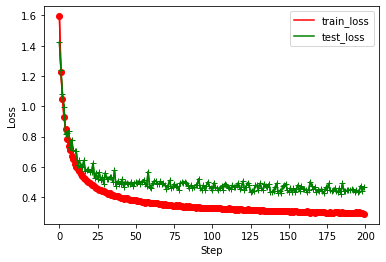

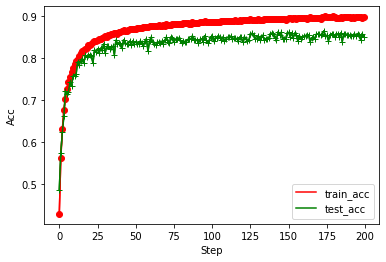

In [53]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

## Reference
- [CIFAR-10 and CIFAR-100 datasets](https://www.cs.toronto.edu/~kriz/cifar.html)
- [PyTorch tutorial for CIFAR-10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [Machine Learning 2021 Spring - Hung-Yi Lee @ National Taiwan University](https://speech.ee.ntu.edu.tw/~hylee/ml/2021-spring.html)
- [ML2021-Spring HW01 - Heng-Jui Chang @ NTUEE](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
- [ML2021-Spring HW03](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW03/HW03.ipynb)
- [TORCHVISION.MODELS](https://pytorch.org/vision/stable/models.html)
- [GitHub - meliketoy/wide-resnet.pytorch](https://github.com/meliketoy/wide-resnet.pytorch)